In [1]:
# text manipulation
import re
import string

# Data management
import pandas as pd
import numpy as np
from scipy.sparse import *
import scipy

# NLP
import nltk
import nltk.collocations as collocations
from nltk.tag import tnt
import spacy
import gensim
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, FastText
from collections import defaultdict
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

# sklearn
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.externals import joblib

# keras
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Embedding

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
train = pd.read_csv('./Data/train.csv')

In [3]:
train.head()

qid                                      question_text  \
0  00002165364db923c7e6  How did Quebec nationalists see their province...   
1  000032939017120e6e44  Do you have an adopted dog, how would you enco...   
2  0000412ca6e4628ce2cf  Why does velocity affect time? Does velocity a...   
3  000042bf85aa498cd78e  How did Otto von Guericke used the Magdeburg h...   
4  0000455dfa3e01eae3af  Can I convert montra helicon D to a mountain b...   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

In [4]:
train.shape

(1306122, 3)

In [5]:
no_insincere = train[train['target']==1].target.count()
no_sincere = train[train['target']==0].target.count()

print('No. of insincere questions:', no_insincere)
print('No. of sincere questions:', no_sincere)
print('% of insincere questions:', train.target.mean())
print('Null score:', 1- train.target.mean())

No. of insincere questions: 80810
No. of sincere questions: 1225312
% of insincere questions: 0.06187017751787352
Null score: 0.9381298224821265


In [6]:
clean_questions = (re.sub("[^A-Za-z']+", ' ', q).lower() for q in train['question_text'])

In [7]:
%%time
token_questions = [nltk.word_tokenize(q) for q in clean_questions]

Wall time: 2min 38s


In [8]:
Xt = token_questions
y = train.target

In [9]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, y, stratify=y, random_state=495, test_size=0.2)

In [10]:
clean_questions = (re.sub("[^A-Za-z']+", ' ', q).lower() for q in train['question_text'])

In [11]:
train['clean_question'] = [q for q in clean_questions]
train.head()

qid                                      question_text  \
0  00002165364db923c7e6  How did Quebec nationalists see their province...   
1  000032939017120e6e44  Do you have an adopted dog, how would you enco...   
2  0000412ca6e4628ce2cf  Why does velocity affect time? Does velocity a...   
3  000042bf85aa498cd78e  How did Otto von Guericke used the Magdeburg h...   
4  0000455dfa3e01eae3af  Can I convert montra helicon D to a mountain b...   

   target                                     clean_question  
0       0  how did quebec nationalists see their province...  
1       0  do you have an adopted dog how would you encou...  
2       0  why does velocity affect time does velocity af...  
3       0  how did otto von guericke used the magdeburg h...  
4       0  can i convert montra helicon d to a mountain b...

In [12]:
X = train['clean_question']
y = train.target

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=495, test_size=0.2)

In [14]:
INPUT_LEN = 80

tokenizer = Tokenizer(num_words = 160000)
tokenizer.fit_on_texts(X_train)

Train_sequences = tokenizer.texts_to_sequences(X_train) 
X_train_data = pad_sequences(Train_sequences, maxlen=INPUT_LEN)

Test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_data = pad_sequences(Test_sequences, maxlen=INPUT_LEN)

In [15]:
word_index = tokenizer.word_index

In [16]:
len(word_index)

173994

### Word2Vec CBOW embedding using training data.

In [18]:
%%time
w2v_CBOW = Word2Vec(sentences=X_train_t, size=300, window=5, min_count=5, workers=6, sg=0)

INFO - 00:28:04: collecting all words and their counts
INFO - 00:28:04: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 00:28:05: PROGRESS: at sentence #10000, processed 130140 words, keeping 14738 word types
INFO - 00:28:05: PROGRESS: at sentence #20000, processed 259997 words, keeping 21600 word types
INFO - 00:28:05: PROGRESS: at sentence #30000, processed 389329 words, keeping 26790 word types
INFO - 00:28:05: PROGRESS: at sentence #40000, processed 518014 words, keeping 31120 word types
INFO - 00:28:05: PROGRESS: at sentence #50000, processed 646632 words, keeping 34806 word types
INFO - 00:28:05: PROGRESS: at sentence #60000, processed 775136 words, keeping 38145 word types
INFO - 00:28:05: PROGRESS: at sentence #70000, processed 904057 words, keeping 41267 word types
INFO - 00:28:05: PROGRESS: at sentence #80000, processed 1034004 words, keeping 44155 word types
INFO - 00:28:05: PROGRESS: at sentence #90000, processed 1163059 words, keeping 46939 word ty

INFO - 00:28:47: EPOCH 4 - PROGRESS: at 58.96% examples, 948244 words/s, in_qsize 12, out_qsize 0
INFO - 00:28:48: EPOCH 4 - PROGRESS: at 69.42% examples, 957051 words/s, in_qsize 11, out_qsize 0
INFO - 00:28:49: EPOCH 4 - PROGRESS: at 79.80% examples, 962540 words/s, in_qsize 11, out_qsize 0
INFO - 00:28:50: EPOCH 4 - PROGRESS: at 90.60% examples, 970492 words/s, in_qsize 12, out_qsize 0
INFO - 00:28:51: worker thread finished; awaiting finish of 5 more threads
INFO - 00:28:51: worker thread finished; awaiting finish of 4 more threads
INFO - 00:28:51: worker thread finished; awaiting finish of 3 more threads
INFO - 00:28:51: worker thread finished; awaiting finish of 2 more threads
INFO - 00:28:51: worker thread finished; awaiting finish of 1 more threads
INFO - 00:28:51: worker thread finished; awaiting finish of 0 more threads
INFO - 00:28:51: EPOCH - 4 : training on 13489665 raw words (9705377 effective words) took 10.0s, 966579 effective words/s
INFO - 00:28:52: EPOCH 5 - PROGRESS

Wall time: 57.2 s


In [19]:
w2v_CBOW.wv.most_similar('nice')

INFO - 00:29:02: precomputing L2-norms of word weight vectors


[('cute', 0.6796778440475464),
 ('shy', 0.6661938428878784),
 ('rude', 0.6473860740661621),
 ('creepy', 0.6434831619262695),
 ('sexy', 0.6326261758804321),
 ('quiet', 0.631784975528717),
 ('ugly', 0.6288224458694458),
 ('cool', 0.6215671300888062),
 ('funny', 0.6097778081893921),
 ('lazy', 0.6068848371505737)]

In [20]:
# Tunning parameters
MAX_NB_WORDS = 160000
EMBEDDING_DIM = 300
LSTM_UNITS = 100
DROP = 0.2
RE_DROP = 0.2

In [21]:
%%time
embedding_matrix = np.zeros((len(tokenizer.word_index), EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in w2v_CBOW.wv.vocab:
        embedding_matrix[i] = w2v_CBOW.wv.get_vector(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 130051
Wall time: 394 ms


In [22]:
embedding_matrix.shape

(173994, 300)

In [23]:
%%time
#### LSTM## Network architecture
model = Sequential()

model.add(Embedding(173994, EMBEDDING_DIM, weights = [embedding_matrix], input_length=INPUT_LEN)) 
model.add(LSTM(LSTM_UNITS, dropout=DROP, recurrent_dropout=RE_DROP))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_data, y_train, validation_split=0.4, epochs=3)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 626938 samples, validate on 417959 samples
Epoch 1/3


  6176/626938 [..............................] - ETA: 21:43:07 - loss: 0.7958 - acc: 0.250 - ETA: 11:27:26 - loss: 0.7393 - acc: 0.421 - ETA: 8:09:23 - loss: 0.6845 - acc: 0.541 - ETA: 6:28:19 - loss: 0.6329 - acc: 0.64 - ETA: 5:28:59 - loss: 0.5795 - acc: 0.70 - ETA: 4:48:56 - loss: 0.5352 - acc: 0.74 - ETA: 4:21:41 - loss: 0.5084 - acc: 0.76 - ETA: 4:01:54 - loss: 0.4733 - acc: 0.79 - ETA: 3:46:34 - loss: 0.4791 - acc: 0.79 - ETA: 3:34:13 - loss: 0.4450 - acc: 0.81 - ETA: 3:23:17 - loss: 0.4274 - acc: 0.82 - ETA: 3:14:09 - loss: 0.4194 - acc: 0.83 - ETA: 3:06:42 - loss: 0.4424 - acc: 0.83 - ETA: 2:59:40 - loss: 0.4298 - acc: 0.83 - ETA: 2:53:34 - loss: 0.4290 - acc: 0.84 - ETA: 2:47:50 - loss: 0.4118 - acc: 0.84 - ETA: 2:42:58 - loss: 0.3973 - acc: 0.85 - ETA: 2:37:49 - loss: 0.3962 - acc: 0.85 - ETA: 2:33:30 - loss: 0.3884 - acc: 0.86 - ETA: 2:30:19 - loss: 0.3836 - acc: 0.86 - ETA: 2:27:36 - loss: 0.3878 - acc: 0.86 - ETA: 2:24:48 - loss: 0.3906 - acc: 0.86 - ETA: 2:22:40 - loss: 0

 43424/626938 [=>............................] - ETA: 1:10:56 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:56 - loss: 0.1518 - acc: 0.94 - ETA: 1:10:55 - loss: 0.1518 - acc: 0.94 - ETA: 1:10:55 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:55 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:55 - loss: 0.1518 - acc: 0.94 - ETA: 1:10:54 - loss: 0.1518 - acc: 0.94 - ETA: 1:10:54 - loss: 0.1518 - acc: 0.94 - ETA: 1:10:53 - loss: 0.1518 - acc: 0.94 - ETA: 1:10:52 - loss: 0.1518 - acc: 0.94 - ETA: 1:10:52 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:51 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:51 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:50 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:50 - loss: 0.1516 - acc: 0.94 - ETA: 1:10:49 - loss: 0.1516 - acc: 0.94 - ETA: 1:10:49 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:48 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:48 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:47 - loss: 0.1517 - acc: 0.94 - ETA: 1:10:46 - loss: 0.1516 - acc: 0.94 - ETA: 1:10:46 - loss: 0.1515 - acc: 0.94 - ETA: 1:10:46 - loss: 0.1515

 49632/626938 [=>............................] - ETA: 1:09:45 - loss: 0.1485 - acc: 0.94 - ETA: 1:09:44 - loss: 0.1487 - acc: 0.94 - ETA: 1:09:44 - loss: 0.1487 - acc: 0.94 - ETA: 1:09:43 - loss: 0.1486 - acc: 0.94 - ETA: 1:09:43 - loss: 0.1486 - acc: 0.94 - ETA: 1:09:43 - loss: 0.1485 - acc: 0.94 - ETA: 1:09:43 - loss: 0.1485 - acc: 0.94 - ETA: 1:09:42 - loss: 0.1484 - acc: 0.94 - ETA: 1:09:43 - loss: 0.1483 - acc: 0.94 - ETA: 1:09:43 - loss: 0.1483 - acc: 0.94 - ETA: 1:09:43 - loss: 0.1482 - acc: 0.94 - ETA: 1:09:42 - loss: 0.1482 - acc: 0.94 - ETA: 1:09:42 - loss: 0.1481 - acc: 0.94 - ETA: 1:09:42 - loss: 0.1481 - acc: 0.94 - ETA: 1:09:42 - loss: 0.1481 - acc: 0.94 - ETA: 1:09:42 - loss: 0.1481 - acc: 0.94 - ETA: 1:09:41 - loss: 0.1482 - acc: 0.94 - ETA: 1:09:41 - loss: 0.1481 - acc: 0.94 - ETA: 1:09:41 - loss: 0.1482 - acc: 0.94 - ETA: 1:09:40 - loss: 0.1482 - acc: 0.94 - ETA: 1:09:40 - loss: 0.1483 - acc: 0.94 - ETA: 1:09:40 - loss: 0.1484 - acc: 0.94 - ETA: 1:09:39 - loss: 0.1484

 55840/626938 [=>............................] - ETA: 1:08:46 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:46 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:46 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:45 - loss: 0.1472 - acc: 0.94 - ETA: 1:08:45 - loss: 0.1472 - acc: 0.94 - ETA: 1:08:45 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:45 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:44 - loss: 0.1472 - acc: 0.94 - ETA: 1:08:44 - loss: 0.1472 - acc: 0.94 - ETA: 1:08:44 - loss: 0.1472 - acc: 0.94 - ETA: 1:08:43 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:43 - loss: 0.1474 - acc: 0.94 - ETA: 1:08:42 - loss: 0.1474 - acc: 0.94 - ETA: 1:08:42 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:42 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:41 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:41 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:41 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:40 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:40 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:39 - loss: 0.1472 - acc: 0.94 - ETA: 1:08:39 - loss: 0.1473 - acc: 0.94 - ETA: 1:08:39 - loss: 0.1472

 62048/626938 [=>............................] - ETA: 1:07:42 - loss: 0.1453 - acc: 0.94 - ETA: 1:07:42 - loss: 0.1453 - acc: 0.94 - ETA: 1:07:41 - loss: 0.1453 - acc: 0.94 - ETA: 1:07:42 - loss: 0.1452 - acc: 0.94 - ETA: 1:07:41 - loss: 0.1452 - acc: 0.94 - ETA: 1:07:41 - loss: 0.1451 - acc: 0.94 - ETA: 1:07:40 - loss: 0.1451 - acc: 0.94 - ETA: 1:07:40 - loss: 0.1451 - acc: 0.94 - ETA: 1:07:40 - loss: 0.1452 - acc: 0.94 - ETA: 1:07:40 - loss: 0.1452 - acc: 0.94 - ETA: 1:07:39 - loss: 0.1452 - acc: 0.94 - ETA: 1:07:39 - loss: 0.1452 - acc: 0.94 - ETA: 1:07:39 - loss: 0.1451 - acc: 0.94 - ETA: 1:07:38 - loss: 0.1452 - acc: 0.94 - ETA: 1:07:38 - loss: 0.1451 - acc: 0.94 - ETA: 1:07:37 - loss: 0.1451 - acc: 0.94 - ETA: 1:07:37 - loss: 0.1451 - acc: 0.94 - ETA: 1:07:37 - loss: 0.1451 - acc: 0.94 - ETA: 1:07:37 - loss: 0.1451 - acc: 0.94 - ETA: 1:07:36 - loss: 0.1450 - acc: 0.94 - ETA: 1:07:36 - loss: 0.1450 - acc: 0.94 - ETA: 1:07:36 - loss: 0.1450 - acc: 0.94 - ETA: 1:07:35 - loss: 0.1450

 68256/626938 [==>...........................] - ETA: 1:06:45 - loss: 0.1442 - acc: 0.94 - ETA: 1:06:45 - loss: 0.1441 - acc: 0.94 - ETA: 1:06:45 - loss: 0.1441 - acc: 0.94 - ETA: 1:06:44 - loss: 0.1440 - acc: 0.94 - ETA: 1:06:44 - loss: 0.1440 - acc: 0.94 - ETA: 1:06:44 - loss: 0.1440 - acc: 0.94 - ETA: 1:06:44 - loss: 0.1441 - acc: 0.94 - ETA: 1:06:43 - loss: 0.1440 - acc: 0.94 - ETA: 1:06:43 - loss: 0.1441 - acc: 0.94 - ETA: 1:06:43 - loss: 0.1440 - acc: 0.94 - ETA: 1:06:43 - loss: 0.1440 - acc: 0.94 - ETA: 1:06:42 - loss: 0.1440 - acc: 0.94 - ETA: 1:06:42 - loss: 0.1439 - acc: 0.94 - ETA: 1:06:41 - loss: 0.1439 - acc: 0.94 - ETA: 1:06:41 - loss: 0.1438 - acc: 0.94 - ETA: 1:06:41 - loss: 0.1438 - acc: 0.94 - ETA: 1:06:41 - loss: 0.1438 - acc: 0.94 - ETA: 1:06:40 - loss: 0.1439 - acc: 0.94 - ETA: 1:06:40 - loss: 0.1439 - acc: 0.94 - ETA: 1:06:40 - loss: 0.1439 - acc: 0.94 - ETA: 1:06:40 - loss: 0.1439 - acc: 0.94 - ETA: 1:06:39 - loss: 0.1438 - acc: 0.94 - ETA: 1:06:39 - loss: 0.1438

 74464/626938 [==>...........................] - ETA: 1:05:52 - loss: 0.1424 - acc: 0.94 - ETA: 1:05:52 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:51 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:51 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:51 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:50 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:50 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:50 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:49 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:49 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:49 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:48 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:48 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:48 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:47 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:47 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:47 - loss: 0.1426 - acc: 0.94 - ETA: 1:05:47 - loss: 0.1426 - acc: 0.94 - ETA: 1:05:47 - loss: 0.1425 - acc: 0.94 - ETA: 1:05:47 - loss: 0.1426 - acc: 0.94 - ETA: 1:05:46 - loss: 0.1426 - acc: 0.94 - ETA: 1:05:46 - loss: 0.1426 - acc: 0.94 - ETA: 1:05:46 - loss: 0.1426

 80672/626938 [==>...........................] - ETA: 1:04:59 - loss: 0.1410 - acc: 0.94 - ETA: 1:04:58 - loss: 0.1409 - acc: 0.94 - ETA: 1:04:58 - loss: 0.1409 - acc: 0.94 - ETA: 1:04:58 - loss: 0.1408 - acc: 0.94 - ETA: 1:04:57 - loss: 0.1408 - acc: 0.94 - ETA: 1:04:57 - loss: 0.1408 - acc: 0.94 - ETA: 1:04:57 - loss: 0.1407 - acc: 0.94 - ETA: 1:04:57 - loss: 0.1407 - acc: 0.94 - ETA: 1:04:56 - loss: 0.1407 - acc: 0.94 - ETA: 1:04:56 - loss: 0.1407 - acc: 0.94 - ETA: 1:04:56 - loss: 0.1407 - acc: 0.94 - ETA: 1:04:56 - loss: 0.1406 - acc: 0.94 - ETA: 1:04:55 - loss: 0.1406 - acc: 0.94 - ETA: 1:04:55 - loss: 0.1406 - acc: 0.94 - ETA: 1:04:55 - loss: 0.1405 - acc: 0.94 - ETA: 1:04:54 - loss: 0.1405 - acc: 0.94 - ETA: 1:04:54 - loss: 0.1405 - acc: 0.94 - ETA: 1:04:54 - loss: 0.1404 - acc: 0.94 - ETA: 1:04:53 - loss: 0.1404 - acc: 0.94 - ETA: 1:04:53 - loss: 0.1404 - acc: 0.94 - ETA: 1:04:53 - loss: 0.1404 - acc: 0.94 - ETA: 1:04:53 - loss: 0.1404 - acc: 0.94 - ETA: 1:04:52 - loss: 0.1404

 86880/626938 [===>..........................] - ETA: 1:04:07 - loss: 0.1397 - acc: 0.94 - ETA: 1:04:07 - loss: 0.1397 - acc: 0.94 - ETA: 1:04:07 - loss: 0.1397 - acc: 0.94 - ETA: 1:04:06 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:06 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:06 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:05 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:05 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:05 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:04 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:04 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:04 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:04 - loss: 0.1397 - acc: 0.94 - ETA: 1:04:04 - loss: 0.1397 - acc: 0.94 - ETA: 1:04:03 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:03 - loss: 0.1397 - acc: 0.94 - ETA: 1:04:03 - loss: 0.1397 - acc: 0.94 - ETA: 1:04:02 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:02 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:02 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:02 - loss: 0.1397 - acc: 0.94 - ETA: 1:04:02 - loss: 0.1398 - acc: 0.94 - ETA: 1:04:02 - loss: 0.1398

 93088/626938 [===>..........................] - ETA: 1:03:17 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:17 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:17 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:16 - loss: 0.1393 - acc: 0.94 - ETA: 1:03:16 - loss: 0.1393 - acc: 0.94 - ETA: 1:03:16 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:15 - loss: 0.1393 - acc: 0.94 - ETA: 1:03:15 - loss: 0.1393 - acc: 0.94 - ETA: 1:03:15 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:15 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:14 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:14 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:14 - loss: 0.1395 - acc: 0.94 - ETA: 1:03:13 - loss: 0.1395 - acc: 0.94 - ETA: 1:03:13 - loss: 0.1395 - acc: 0.94 - ETA: 1:03:13 - loss: 0.1395 - acc: 0.94 - ETA: 1:03:13 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:12 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:12 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:12 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:12 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:11 - loss: 0.1394 - acc: 0.94 - ETA: 1:03:11 - loss: 0.1393

 99296/626938 [===>..........................] - ETA: 1:02:27 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:26 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:26 - loss: 0.1387 - acc: 0.94 - ETA: 1:02:26 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:26 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:26 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:25 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:25 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:25 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:25 - loss: 0.1385 - acc: 0.94 - ETA: 1:02:24 - loss: 0.1385 - acc: 0.94 - ETA: 1:02:24 - loss: 0.1385 - acc: 0.94 - ETA: 1:02:24 - loss: 0.1385 - acc: 0.94 - ETA: 1:02:24 - loss: 0.1385 - acc: 0.94 - ETA: 1:02:23 - loss: 0.1385 - acc: 0.94 - ETA: 1:02:23 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:23 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:22 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:22 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:22 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:22 - loss: 0.1386 - acc: 0.94 - ETA: 1:02:21 - loss: 0.1385 - acc: 0.94 - ETA: 1:02:21 - loss: 0.1385

105504/626938 [====>.........................] - ETA: 1:01:38 - loss: 0.1373 - acc: 0.94 - ETA: 1:01:38 - loss: 0.1373 - acc: 0.94 - ETA: 1:01:37 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:37 - loss: 0.1373 - acc: 0.94 - ETA: 1:01:37 - loss: 0.1373 - acc: 0.94 - ETA: 1:01:37 - loss: 0.1373 - acc: 0.94 - ETA: 1:01:36 - loss: 0.1372 - acc: 0.94 - ETA: 1:01:36 - loss: 0.1372 - acc: 0.94 - ETA: 1:01:36 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:36 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:35 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:35 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:35 - loss: 0.1373 - acc: 0.94 - ETA: 1:01:35 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:34 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:34 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:34 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:34 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:33 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:33 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:33 - loss: 0.1374 - acc: 0.94 - ETA: 1:01:33 - loss: 0.1373 - acc: 0.94 - ETA: 1:01:32 - loss: 0.1373

111712/626938 [====>.........................] - ETA: 1:00:51 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:51 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:51 - loss: 0.1365 - acc: 0.94 - ETA: 1:00:50 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:50 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:50 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:50 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:49 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:49 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:49 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:48 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:48 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:48 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:48 - loss: 0.1366 - acc: 0.94 - ETA: 1:00:47 - loss: 0.1365 - acc: 0.94 - ETA: 1:00:47 - loss: 0.1365 - acc: 0.94 - ETA: 1:00:47 - loss: 0.1365 - acc: 0.94 - ETA: 1:00:47 - loss: 0.1365 - acc: 0.94 - ETA: 1:00:46 - loss: 0.1365 - acc: 0.94 - ETA: 1:00:46 - loss: 0.1365 - acc: 0.94 - ETA: 1:00:46 - loss: 0.1365 - acc: 0.94 - ETA: 1:00:45 - loss: 0.1365 - acc: 0.94 - ETA: 1:00:45 - loss: 0.1365

118208/626938 [====>.........................] - ETA: 1:00:04 - loss: 0.1353 - acc: 0.94 - ETA: 1:00:04 - loss: 0.1353 - acc: 0.94 - ETA: 1:00:03 - loss: 0.1353 - acc: 0.94 - ETA: 1:00:03 - loss: 0.1353 - acc: 0.94 - ETA: 1:00:03 - loss: 0.1353 - acc: 0.94 - ETA: 1:00:03 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:03 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:03 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:03 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:02 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:02 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:02 - loss: 0.1351 - acc: 0.94 - ETA: 1:00:01 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:01 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:01 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:01 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:01 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:00 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:00 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:00 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:00 - loss: 0.1352 - acc: 0.94 - ETA: 1:00:00 - loss: 0.1352 - acc: 0.94 - ETA: 59:59 - loss: 0.1352 -

124736/626938 [====>.........................] - ETA: 59:14 - loss: 0.1346 - acc: 0.94 - ETA: 59:14 - loss: 0.1346 - acc: 0.94 - ETA: 59:14 - loss: 0.1345 - acc: 0.94 - ETA: 59:14 - loss: 0.1346 - acc: 0.94 - ETA: 59:13 - loss: 0.1346 - acc: 0.94 - ETA: 59:13 - loss: 0.1346 - acc: 0.94 - ETA: 59:13 - loss: 0.1346 - acc: 0.94 - ETA: 59:12 - loss: 0.1346 - acc: 0.94 - ETA: 59:12 - loss: 0.1346 - acc: 0.94 - ETA: 59:12 - loss: 0.1346 - acc: 0.94 - ETA: 59:12 - loss: 0.1346 - acc: 0.94 - ETA: 59:12 - loss: 0.1346 - acc: 0.94 - ETA: 59:12 - loss: 0.1346 - acc: 0.94 - ETA: 59:11 - loss: 0.1346 - acc: 0.94 - ETA: 59:11 - loss: 0.1346 - acc: 0.94 - ETA: 59:11 - loss: 0.1346 - acc: 0.94 - ETA: 59:11 - loss: 0.1346 - acc: 0.94 - ETA: 59:10 - loss: 0.1346 - acc: 0.94 - ETA: 59:10 - loss: 0.1346 - acc: 0.94 - ETA: 59:10 - loss: 0.1346 - acc: 0.94 - ETA: 59:10 - loss: 0.1346 - acc: 0.94 - ETA: 59:09 - loss: 0.1346 - acc: 0.94 - ETA: 59:09 - loss: 0.1346 - acc: 0.94 - ETA: 59:09 - loss: 0.1346 - acc

131264/626938 [=====>........................] - ETA: 58:25 - loss: 0.1339 - acc: 0.94 - ETA: 58:25 - loss: 0.1339 - acc: 0.94 - ETA: 58:25 - loss: 0.1339 - acc: 0.94 - ETA: 58:25 - loss: 0.1339 - acc: 0.94 - ETA: 58:24 - loss: 0.1339 - acc: 0.94 - ETA: 58:24 - loss: 0.1339 - acc: 0.94 - ETA: 58:24 - loss: 0.1339 - acc: 0.94 - ETA: 58:24 - loss: 0.1339 - acc: 0.94 - ETA: 58:24 - loss: 0.1339 - acc: 0.94 - ETA: 58:23 - loss: 0.1338 - acc: 0.94 - ETA: 58:23 - loss: 0.1338 - acc: 0.94 - ETA: 58:23 - loss: 0.1338 - acc: 0.94 - ETA: 58:23 - loss: 0.1339 - acc: 0.94 - ETA: 58:22 - loss: 0.1339 - acc: 0.94 - ETA: 58:22 - loss: 0.1338 - acc: 0.94 - ETA: 58:22 - loss: 0.1338 - acc: 0.94 - ETA: 58:22 - loss: 0.1339 - acc: 0.94 - ETA: 58:21 - loss: 0.1339 - acc: 0.94 - ETA: 58:21 - loss: 0.1339 - acc: 0.94 - ETA: 58:21 - loss: 0.1339 - acc: 0.94 - ETA: 58:21 - loss: 0.1338 - acc: 0.94 - ETA: 58:21 - loss: 0.1339 - acc: 0.94 - ETA: 58:20 - loss: 0.1339 - acc: 0.94 - ETA: 58:20 - loss: 0.1339 - acc

137792/626938 [=====>........................] - ETA: 57:38 - loss: 0.1334 - acc: 0.94 - ETA: 57:38 - loss: 0.1334 - acc: 0.94 - ETA: 57:38 - loss: 0.1333 - acc: 0.94 - ETA: 57:37 - loss: 0.1334 - acc: 0.94 - ETA: 57:37 - loss: 0.1334 - acc: 0.94 - ETA: 57:37 - loss: 0.1334 - acc: 0.94 - ETA: 57:37 - loss: 0.1333 - acc: 0.94 - ETA: 57:37 - loss: 0.1333 - acc: 0.94 - ETA: 57:36 - loss: 0.1333 - acc: 0.94 - ETA: 57:36 - loss: 0.1333 - acc: 0.94 - ETA: 57:36 - loss: 0.1333 - acc: 0.94 - ETA: 57:36 - loss: 0.1333 - acc: 0.94 - ETA: 57:35 - loss: 0.1333 - acc: 0.94 - ETA: 57:35 - loss: 0.1333 - acc: 0.94 - ETA: 57:35 - loss: 0.1333 - acc: 0.94 - ETA: 57:35 - loss: 0.1333 - acc: 0.94 - ETA: 57:35 - loss: 0.1332 - acc: 0.94 - ETA: 57:34 - loss: 0.1332 - acc: 0.94 - ETA: 57:34 - loss: 0.1332 - acc: 0.94 - ETA: 57:34 - loss: 0.1332 - acc: 0.94 - ETA: 57:33 - loss: 0.1332 - acc: 0.94 - ETA: 57:33 - loss: 0.1332 - acc: 0.94 - ETA: 57:33 - loss: 0.1332 - acc: 0.94 - ETA: 57:33 - loss: 0.1332 - acc

144320/626938 [=====>........................] - ETA: 56:51 - loss: 0.1327 - acc: 0.94 - ETA: 56:50 - loss: 0.1327 - acc: 0.94 - ETA: 56:50 - loss: 0.1327 - acc: 0.94 - ETA: 56:50 - loss: 0.1326 - acc: 0.94 - ETA: 56:50 - loss: 0.1326 - acc: 0.94 - ETA: 56:49 - loss: 0.1326 - acc: 0.94 - ETA: 56:49 - loss: 0.1326 - acc: 0.94 - ETA: 56:49 - loss: 0.1326 - acc: 0.94 - ETA: 56:49 - loss: 0.1326 - acc: 0.94 - ETA: 56:49 - loss: 0.1326 - acc: 0.94 - ETA: 56:48 - loss: 0.1326 - acc: 0.94 - ETA: 56:48 - loss: 0.1326 - acc: 0.94 - ETA: 56:48 - loss: 0.1326 - acc: 0.94 - ETA: 56:48 - loss: 0.1326 - acc: 0.94 - ETA: 56:47 - loss: 0.1326 - acc: 0.94 - ETA: 56:47 - loss: 0.1326 - acc: 0.94 - ETA: 56:47 - loss: 0.1325 - acc: 0.94 - ETA: 56:47 - loss: 0.1325 - acc: 0.94 - ETA: 56:47 - loss: 0.1326 - acc: 0.94 - ETA: 56:46 - loss: 0.1326 - acc: 0.94 - ETA: 56:46 - loss: 0.1326 - acc: 0.94 - ETA: 56:46 - loss: 0.1325 - acc: 0.94 - ETA: 56:46 - loss: 0.1326 - acc: 0.94 - ETA: 56:46 - loss: 0.1326 - acc

150848/626938 [======>.......................] - ETA: 56:04 - loss: 0.1319 - acc: 0.94 - ETA: 56:04 - loss: 0.1320 - acc: 0.94 - ETA: 56:03 - loss: 0.1320 - acc: 0.94 - ETA: 56:03 - loss: 0.1319 - acc: 0.94 - ETA: 56:03 - loss: 0.1319 - acc: 0.94 - ETA: 56:02 - loss: 0.1319 - acc: 0.94 - ETA: 56:02 - loss: 0.1319 - acc: 0.94 - ETA: 56:02 - loss: 0.1319 - acc: 0.94 - ETA: 56:02 - loss: 0.1319 - acc: 0.94 - ETA: 56:02 - loss: 0.1319 - acc: 0.94 - ETA: 56:02 - loss: 0.1319 - acc: 0.94 - ETA: 56:01 - loss: 0.1319 - acc: 0.94 - ETA: 56:01 - loss: 0.1319 - acc: 0.94 - ETA: 56:01 - loss: 0.1319 - acc: 0.94 - ETA: 56:01 - loss: 0.1319 - acc: 0.94 - ETA: 56:00 - loss: 0.1319 - acc: 0.94 - ETA: 56:00 - loss: 0.1319 - acc: 0.94 - ETA: 56:00 - loss: 0.1319 - acc: 0.94 - ETA: 56:00 - loss: 0.1319 - acc: 0.94 - ETA: 55:59 - loss: 0.1319 - acc: 0.94 - ETA: 55:59 - loss: 0.1319 - acc: 0.94 - ETA: 55:59 - loss: 0.1318 - acc: 0.94 - ETA: 55:59 - loss: 0.1318 - acc: 0.94 - ETA: 55:59 - loss: 0.1318 - acc

157376/626938 [======>.......................] - ETA: 55:17 - loss: 0.1317 - acc: 0.94 - ETA: 55:17 - loss: 0.1317 - acc: 0.94 - ETA: 55:16 - loss: 0.1316 - acc: 0.94 - ETA: 55:16 - loss: 0.1316 - acc: 0.94 - ETA: 55:16 - loss: 0.1316 - acc: 0.94 - ETA: 55:16 - loss: 0.1316 - acc: 0.94 - ETA: 55:15 - loss: 0.1316 - acc: 0.94 - ETA: 55:15 - loss: 0.1316 - acc: 0.94 - ETA: 55:15 - loss: 0.1316 - acc: 0.94 - ETA: 55:15 - loss: 0.1316 - acc: 0.94 - ETA: 55:14 - loss: 0.1316 - acc: 0.94 - ETA: 55:14 - loss: 0.1316 - acc: 0.94 - ETA: 55:14 - loss: 0.1315 - acc: 0.94 - ETA: 55:14 - loss: 0.1315 - acc: 0.94 - ETA: 55:13 - loss: 0.1315 - acc: 0.94 - ETA: 55:13 - loss: 0.1315 - acc: 0.94 - ETA: 55:13 - loss: 0.1315 - acc: 0.94 - ETA: 55:13 - loss: 0.1316 - acc: 0.94 - ETA: 55:12 - loss: 0.1316 - acc: 0.94 - ETA: 55:12 - loss: 0.1316 - acc: 0.94 - ETA: 55:12 - loss: 0.1316 - acc: 0.94 - ETA: 55:12 - loss: 0.1316 - acc: 0.94 - ETA: 55:11 - loss: 0.1316 - acc: 0.94 - ETA: 55:11 - loss: 0.1316 - acc

163904/626938 [======>.......................] - ETA: 54:30 - loss: 0.1313 - acc: 0.94 - ETA: 54:29 - loss: 0.1313 - acc: 0.94 - ETA: 54:29 - loss: 0.1313 - acc: 0.94 - ETA: 54:29 - loss: 0.1313 - acc: 0.94 - ETA: 54:29 - loss: 0.1313 - acc: 0.94 - ETA: 54:28 - loss: 0.1313 - acc: 0.94 - ETA: 54:28 - loss: 0.1312 - acc: 0.94 - ETA: 54:28 - loss: 0.1312 - acc: 0.94 - ETA: 54:28 - loss: 0.1313 - acc: 0.94 - ETA: 54:27 - loss: 0.1313 - acc: 0.94 - ETA: 54:27 - loss: 0.1313 - acc: 0.94 - ETA: 54:27 - loss: 0.1313 - acc: 0.94 - ETA: 54:27 - loss: 0.1313 - acc: 0.94 - ETA: 54:26 - loss: 0.1313 - acc: 0.94 - ETA: 54:26 - loss: 0.1313 - acc: 0.94 - ETA: 54:26 - loss: 0.1313 - acc: 0.94 - ETA: 54:26 - loss: 0.1313 - acc: 0.94 - ETA: 54:26 - loss: 0.1313 - acc: 0.94 - ETA: 54:25 - loss: 0.1313 - acc: 0.94 - ETA: 54:25 - loss: 0.1313 - acc: 0.94 - ETA: 54:25 - loss: 0.1312 - acc: 0.94 - ETA: 54:25 - loss: 0.1312 - acc: 0.94 - ETA: 54:24 - loss: 0.1312 - acc: 0.94 - ETA: 54:24 - loss: 0.1312 - acc

170432/626938 [=======>......................] - ETA: 53:42 - loss: 0.1307 - acc: 0.94 - ETA: 53:42 - loss: 0.1307 - acc: 0.94 - ETA: 53:42 - loss: 0.1307 - acc: 0.94 - ETA: 53:41 - loss: 0.1307 - acc: 0.94 - ETA: 53:41 - loss: 0.1307 - acc: 0.94 - ETA: 53:41 - loss: 0.1307 - acc: 0.94 - ETA: 53:41 - loss: 0.1307 - acc: 0.94 - ETA: 53:40 - loss: 0.1307 - acc: 0.94 - ETA: 53:40 - loss: 0.1307 - acc: 0.94 - ETA: 53:40 - loss: 0.1307 - acc: 0.94 - ETA: 53:40 - loss: 0.1307 - acc: 0.94 - ETA: 53:40 - loss: 0.1307 - acc: 0.94 - ETA: 53:39 - loss: 0.1307 - acc: 0.94 - ETA: 53:39 - loss: 0.1307 - acc: 0.94 - ETA: 53:39 - loss: 0.1307 - acc: 0.94 - ETA: 53:39 - loss: 0.1307 - acc: 0.94 - ETA: 53:39 - loss: 0.1307 - acc: 0.94 - ETA: 53:38 - loss: 0.1307 - acc: 0.94 - ETA: 53:38 - loss: 0.1307 - acc: 0.94 - ETA: 53:38 - loss: 0.1307 - acc: 0.94 - ETA: 53:38 - loss: 0.1307 - acc: 0.94 - ETA: 53:38 - loss: 0.1307 - acc: 0.94 - ETA: 53:37 - loss: 0.1307 - acc: 0.94 - ETA: 53:37 - loss: 0.1306 - acc

176960/626938 [=======>......................] - ETA: 52:56 - loss: 0.1301 - acc: 0.94 - ETA: 52:56 - loss: 0.1302 - acc: 0.94 - ETA: 52:56 - loss: 0.1301 - acc: 0.94 - ETA: 52:55 - loss: 0.1301 - acc: 0.94 - ETA: 52:55 - loss: 0.1301 - acc: 0.94 - ETA: 52:55 - loss: 0.1301 - acc: 0.94 - ETA: 52:55 - loss: 0.1301 - acc: 0.94 - ETA: 52:54 - loss: 0.1302 - acc: 0.94 - ETA: 52:54 - loss: 0.1301 - acc: 0.94 - ETA: 52:54 - loss: 0.1301 - acc: 0.94 - ETA: 52:54 - loss: 0.1302 - acc: 0.94 - ETA: 52:54 - loss: 0.1301 - acc: 0.94 - ETA: 52:53 - loss: 0.1301 - acc: 0.94 - ETA: 52:53 - loss: 0.1301 - acc: 0.94 - ETA: 52:53 - loss: 0.1301 - acc: 0.94 - ETA: 52:53 - loss: 0.1301 - acc: 0.94 - ETA: 52:52 - loss: 0.1301 - acc: 0.94 - ETA: 52:52 - loss: 0.1301 - acc: 0.94 - ETA: 52:52 - loss: 0.1301 - acc: 0.94 - ETA: 52:52 - loss: 0.1301 - acc: 0.94 - ETA: 52:51 - loss: 0.1301 - acc: 0.94 - ETA: 52:51 - loss: 0.1301 - acc: 0.94 - ETA: 52:51 - loss: 0.1301 - acc: 0.94 - ETA: 52:51 - loss: 0.1301 - acc

183488/626938 [=======>......................] - ETA: 52:10 - loss: 0.1297 - acc: 0.94 - ETA: 52:10 - loss: 0.1297 - acc: 0.94 - ETA: 52:10 - loss: 0.1298 - acc: 0.94 - ETA: 52:09 - loss: 0.1298 - acc: 0.94 - ETA: 52:09 - loss: 0.1298 - acc: 0.94 - ETA: 52:09 - loss: 0.1298 - acc: 0.94 - ETA: 52:09 - loss: 0.1298 - acc: 0.94 - ETA: 52:09 - loss: 0.1298 - acc: 0.94 - ETA: 52:09 - loss: 0.1298 - acc: 0.94 - ETA: 52:08 - loss: 0.1299 - acc: 0.94 - ETA: 52:08 - loss: 0.1299 - acc: 0.94 - ETA: 52:08 - loss: 0.1299 - acc: 0.94 - ETA: 52:08 - loss: 0.1299 - acc: 0.94 - ETA: 52:07 - loss: 0.1299 - acc: 0.94 - ETA: 52:07 - loss: 0.1299 - acc: 0.94 - ETA: 52:07 - loss: 0.1299 - acc: 0.94 - ETA: 52:07 - loss: 0.1299 - acc: 0.94 - ETA: 52:06 - loss: 0.1299 - acc: 0.94 - ETA: 52:06 - loss: 0.1298 - acc: 0.94 - ETA: 52:06 - loss: 0.1298 - acc: 0.94 - ETA: 52:06 - loss: 0.1298 - acc: 0.94 - ETA: 52:05 - loss: 0.1298 - acc: 0.94 - ETA: 52:05 - loss: 0.1298 - acc: 0.94 - ETA: 52:05 - loss: 0.1298 - acc

190016/626938 [========>.....................] - ETA: 51:23 - loss: 0.1292 - acc: 0.95 - ETA: 51:23 - loss: 0.1291 - acc: 0.95 - ETA: 51:23 - loss: 0.1292 - acc: 0.95 - ETA: 51:22 - loss: 0.1292 - acc: 0.95 - ETA: 51:22 - loss: 0.1292 - acc: 0.95 - ETA: 51:22 - loss: 0.1292 - acc: 0.95 - ETA: 51:22 - loss: 0.1292 - acc: 0.95 - ETA: 51:21 - loss: 0.1292 - acc: 0.95 - ETA: 51:21 - loss: 0.1293 - acc: 0.95 - ETA: 51:21 - loss: 0.1292 - acc: 0.95 - ETA: 51:21 - loss: 0.1292 - acc: 0.95 - ETA: 51:20 - loss: 0.1292 - acc: 0.95 - ETA: 51:20 - loss: 0.1292 - acc: 0.95 - ETA: 51:20 - loss: 0.1292 - acc: 0.95 - ETA: 51:20 - loss: 0.1292 - acc: 0.95 - ETA: 51:19 - loss: 0.1292 - acc: 0.95 - ETA: 51:19 - loss: 0.1292 - acc: 0.95 - ETA: 51:19 - loss: 0.1292 - acc: 0.95 - ETA: 51:19 - loss: 0.1292 - acc: 0.95 - ETA: 51:19 - loss: 0.1292 - acc: 0.95 - ETA: 51:18 - loss: 0.1292 - acc: 0.95 - ETA: 51:18 - loss: 0.1292 - acc: 0.95 - ETA: 51:18 - loss: 0.1292 - acc: 0.95 - ETA: 51:18 - loss: 0.1292 - acc

196544/626938 [========>.....................] - ETA: 50:36 - loss: 0.1288 - acc: 0.95 - ETA: 50:36 - loss: 0.1288 - acc: 0.95 - ETA: 50:36 - loss: 0.1288 - acc: 0.95 - ETA: 50:36 - loss: 0.1288 - acc: 0.95 - ETA: 50:36 - loss: 0.1288 - acc: 0.95 - ETA: 50:35 - loss: 0.1288 - acc: 0.95 - ETA: 50:35 - loss: 0.1287 - acc: 0.95 - ETA: 50:35 - loss: 0.1287 - acc: 0.95 - ETA: 50:35 - loss: 0.1287 - acc: 0.95 - ETA: 50:35 - loss: 0.1287 - acc: 0.95 - ETA: 50:35 - loss: 0.1287 - acc: 0.95 - ETA: 50:34 - loss: 0.1287 - acc: 0.95 - ETA: 50:34 - loss: 0.1287 - acc: 0.95 - ETA: 50:34 - loss: 0.1287 - acc: 0.95 - ETA: 50:34 - loss: 0.1287 - acc: 0.95 - ETA: 50:33 - loss: 0.1287 - acc: 0.95 - ETA: 50:33 - loss: 0.1286 - acc: 0.95 - ETA: 50:33 - loss: 0.1286 - acc: 0.95 - ETA: 50:33 - loss: 0.1286 - acc: 0.95 - ETA: 50:33 - loss: 0.1286 - acc: 0.95 - ETA: 50:32 - loss: 0.1286 - acc: 0.95 - ETA: 50:32 - loss: 0.1286 - acc: 0.95 - ETA: 50:32 - loss: 0.1286 - acc: 0.95 - ETA: 50:32 - loss: 0.1286 - acc

203072/626938 [========>.....................] - ETA: 49:50 - loss: 0.1286 - acc: 0.95 - ETA: 49:50 - loss: 0.1286 - acc: 0.95 - ETA: 49:50 - loss: 0.1285 - acc: 0.95 - ETA: 49:49 - loss: 0.1285 - acc: 0.95 - ETA: 49:49 - loss: 0.1286 - acc: 0.95 - ETA: 49:49 - loss: 0.1286 - acc: 0.95 - ETA: 49:49 - loss: 0.1286 - acc: 0.95 - ETA: 49:49 - loss: 0.1286 - acc: 0.95 - ETA: 49:48 - loss: 0.1286 - acc: 0.95 - ETA: 49:48 - loss: 0.1286 - acc: 0.95 - ETA: 49:48 - loss: 0.1286 - acc: 0.95 - ETA: 49:48 - loss: 0.1286 - acc: 0.95 - ETA: 49:47 - loss: 0.1286 - acc: 0.95 - ETA: 49:47 - loss: 0.1286 - acc: 0.95 - ETA: 49:47 - loss: 0.1286 - acc: 0.95 - ETA: 49:47 - loss: 0.1286 - acc: 0.95 - ETA: 49:47 - loss: 0.1286 - acc: 0.95 - ETA: 49:46 - loss: 0.1286 - acc: 0.95 - ETA: 49:46 - loss: 0.1286 - acc: 0.95 - ETA: 49:46 - loss: 0.1286 - acc: 0.95 - ETA: 49:46 - loss: 0.1286 - acc: 0.95 - ETA: 49:45 - loss: 0.1286 - acc: 0.95 - ETA: 49:45 - loss: 0.1286 - acc: 0.95 - ETA: 49:45 - loss: 0.1286 - acc

209600/626938 [=========>....................] - ETA: 49:03 - loss: 0.1284 - acc: 0.95 - ETA: 49:03 - loss: 0.1284 - acc: 0.95 - ETA: 49:03 - loss: 0.1284 - acc: 0.95 - ETA: 49:03 - loss: 0.1284 - acc: 0.95 - ETA: 49:02 - loss: 0.1284 - acc: 0.95 - ETA: 49:02 - loss: 0.1284 - acc: 0.95 - ETA: 49:02 - loss: 0.1284 - acc: 0.95 - ETA: 49:02 - loss: 0.1284 - acc: 0.95 - ETA: 49:02 - loss: 0.1284 - acc: 0.95 - ETA: 49:01 - loss: 0.1285 - acc: 0.95 - ETA: 49:01 - loss: 0.1285 - acc: 0.95 - ETA: 49:01 - loss: 0.1284 - acc: 0.95 - ETA: 49:01 - loss: 0.1284 - acc: 0.95 - ETA: 49:00 - loss: 0.1284 - acc: 0.95 - ETA: 49:00 - loss: 0.1285 - acc: 0.95 - ETA: 49:00 - loss: 0.1285 - acc: 0.95 - ETA: 49:00 - loss: 0.1284 - acc: 0.95 - ETA: 48:59 - loss: 0.1284 - acc: 0.95 - ETA: 48:59 - loss: 0.1284 - acc: 0.95 - ETA: 48:59 - loss: 0.1285 - acc: 0.95 - ETA: 48:59 - loss: 0.1284 - acc: 0.95 - ETA: 48:59 - loss: 0.1284 - acc: 0.95 - ETA: 48:58 - loss: 0.1284 - acc: 0.95 - ETA: 48:58 - loss: 0.1284 - acc

216128/626938 [=========>....................] - ETA: 48:17 - loss: 0.1281 - acc: 0.95 - ETA: 48:17 - loss: 0.1281 - acc: 0.95 - ETA: 48:16 - loss: 0.1281 - acc: 0.95 - ETA: 48:16 - loss: 0.1281 - acc: 0.95 - ETA: 48:16 - loss: 0.1281 - acc: 0.95 - ETA: 48:16 - loss: 0.1281 - acc: 0.95 - ETA: 48:15 - loss: 0.1281 - acc: 0.95 - ETA: 48:15 - loss: 0.1281 - acc: 0.95 - ETA: 48:15 - loss: 0.1281 - acc: 0.95 - ETA: 48:15 - loss: 0.1281 - acc: 0.95 - ETA: 48:15 - loss: 0.1281 - acc: 0.95 - ETA: 48:14 - loss: 0.1281 - acc: 0.95 - ETA: 48:14 - loss: 0.1281 - acc: 0.95 - ETA: 48:14 - loss: 0.1281 - acc: 0.95 - ETA: 48:14 - loss: 0.1281 - acc: 0.95 - ETA: 48:13 - loss: 0.1281 - acc: 0.95 - ETA: 48:13 - loss: 0.1281 - acc: 0.95 - ETA: 48:13 - loss: 0.1281 - acc: 0.95 - ETA: 48:13 - loss: 0.1281 - acc: 0.95 - ETA: 48:12 - loss: 0.1281 - acc: 0.95 - ETA: 48:12 - loss: 0.1281 - acc: 0.95 - ETA: 48:12 - loss: 0.1281 - acc: 0.95 - ETA: 48:12 - loss: 0.1281 - acc: 0.95 - ETA: 48:12 - loss: 0.1282 - acc

222656/626938 [=========>....................] - ETA: 47:31 - loss: 0.1277 - acc: 0.95 - ETA: 47:31 - loss: 0.1277 - acc: 0.95 - ETA: 47:30 - loss: 0.1277 - acc: 0.95 - ETA: 47:30 - loss: 0.1277 - acc: 0.95 - ETA: 47:30 - loss: 0.1277 - acc: 0.95 - ETA: 47:30 - loss: 0.1277 - acc: 0.95 - ETA: 47:30 - loss: 0.1277 - acc: 0.95 - ETA: 47:29 - loss: 0.1277 - acc: 0.95 - ETA: 47:29 - loss: 0.1277 - acc: 0.95 - ETA: 47:29 - loss: 0.1277 - acc: 0.95 - ETA: 47:29 - loss: 0.1277 - acc: 0.95 - ETA: 47:28 - loss: 0.1277 - acc: 0.95 - ETA: 47:28 - loss: 0.1277 - acc: 0.95 - ETA: 47:28 - loss: 0.1277 - acc: 0.95 - ETA: 47:28 - loss: 0.1277 - acc: 0.95 - ETA: 47:28 - loss: 0.1277 - acc: 0.95 - ETA: 47:27 - loss: 0.1277 - acc: 0.95 - ETA: 47:27 - loss: 0.1277 - acc: 0.95 - ETA: 47:27 - loss: 0.1277 - acc: 0.95 - ETA: 47:27 - loss: 0.1277 - acc: 0.95 - ETA: 47:26 - loss: 0.1277 - acc: 0.95 - ETA: 47:26 - loss: 0.1277 - acc: 0.95 - ETA: 47:26 - loss: 0.1277 - acc: 0.95 - ETA: 47:26 - loss: 0.1277 - acc

229184/626938 [=========>....................] - ETA: 46:44 - loss: 0.1272 - acc: 0.95 - ETA: 46:44 - loss: 0.1272 - acc: 0.95 - ETA: 46:44 - loss: 0.1272 - acc: 0.95 - ETA: 46:44 - loss: 0.1272 - acc: 0.95 - ETA: 46:43 - loss: 0.1272 - acc: 0.95 - ETA: 46:43 - loss: 0.1272 - acc: 0.95 - ETA: 46:43 - loss: 0.1272 - acc: 0.95 - ETA: 46:43 - loss: 0.1272 - acc: 0.95 - ETA: 46:42 - loss: 0.1272 - acc: 0.95 - ETA: 46:42 - loss: 0.1272 - acc: 0.95 - ETA: 46:42 - loss: 0.1272 - acc: 0.95 - ETA: 46:42 - loss: 0.1272 - acc: 0.95 - ETA: 46:42 - loss: 0.1272 - acc: 0.95 - ETA: 46:41 - loss: 0.1272 - acc: 0.95 - ETA: 46:41 - loss: 0.1272 - acc: 0.95 - ETA: 46:41 - loss: 0.1272 - acc: 0.95 - ETA: 46:41 - loss: 0.1272 - acc: 0.95 - ETA: 46:40 - loss: 0.1272 - acc: 0.95 - ETA: 46:40 - loss: 0.1272 - acc: 0.95 - ETA: 46:40 - loss: 0.1272 - acc: 0.95 - ETA: 46:40 - loss: 0.1272 - acc: 0.95 - ETA: 46:40 - loss: 0.1272 - acc: 0.95 - ETA: 46:39 - loss: 0.1272 - acc: 0.95 - ETA: 46:39 - loss: 0.1272 - acc

235712/626938 [==========>...................] - ETA: 45:58 - loss: 0.1269 - acc: 0.95 - ETA: 45:58 - loss: 0.1269 - acc: 0.95 - ETA: 45:57 - loss: 0.1269 - acc: 0.95 - ETA: 45:57 - loss: 0.1269 - acc: 0.95 - ETA: 45:57 - loss: 0.1269 - acc: 0.95 - ETA: 45:57 - loss: 0.1269 - acc: 0.95 - ETA: 45:57 - loss: 0.1269 - acc: 0.95 - ETA: 45:56 - loss: 0.1269 - acc: 0.95 - ETA: 45:56 - loss: 0.1269 - acc: 0.95 - ETA: 45:56 - loss: 0.1269 - acc: 0.95 - ETA: 45:56 - loss: 0.1269 - acc: 0.95 - ETA: 45:55 - loss: 0.1269 - acc: 0.95 - ETA: 45:55 - loss: 0.1268 - acc: 0.95 - ETA: 45:55 - loss: 0.1268 - acc: 0.95 - ETA: 45:55 - loss: 0.1268 - acc: 0.95 - ETA: 45:54 - loss: 0.1268 - acc: 0.95 - ETA: 45:54 - loss: 0.1268 - acc: 0.95 - ETA: 45:54 - loss: 0.1268 - acc: 0.95 - ETA: 45:54 - loss: 0.1269 - acc: 0.95 - ETA: 45:54 - loss: 0.1269 - acc: 0.95 - ETA: 45:53 - loss: 0.1269 - acc: 0.95 - ETA: 45:53 - loss: 0.1269 - acc: 0.95 - ETA: 45:53 - loss: 0.1269 - acc: 0.95 - ETA: 45:53 - loss: 0.1269 - acc

242240/626938 [==========>...................] - ETA: 45:12 - loss: 0.1267 - acc: 0.95 - ETA: 45:12 - loss: 0.1267 - acc: 0.95 - ETA: 45:12 - loss: 0.1267 - acc: 0.95 - ETA: 45:11 - loss: 0.1267 - acc: 0.95 - ETA: 45:11 - loss: 0.1267 - acc: 0.95 - ETA: 45:11 - loss: 0.1267 - acc: 0.95 - ETA: 45:11 - loss: 0.1267 - acc: 0.95 - ETA: 45:11 - loss: 0.1267 - acc: 0.95 - ETA: 45:10 - loss: 0.1266 - acc: 0.95 - ETA: 45:10 - loss: 0.1266 - acc: 0.95 - ETA: 45:10 - loss: 0.1266 - acc: 0.95 - ETA: 45:10 - loss: 0.1266 - acc: 0.95 - ETA: 45:09 - loss: 0.1266 - acc: 0.95 - ETA: 45:09 - loss: 0.1266 - acc: 0.95 - ETA: 45:09 - loss: 0.1266 - acc: 0.95 - ETA: 45:09 - loss: 0.1266 - acc: 0.95 - ETA: 45:09 - loss: 0.1266 - acc: 0.95 - ETA: 45:08 - loss: 0.1266 - acc: 0.95 - ETA: 45:08 - loss: 0.1266 - acc: 0.95 - ETA: 45:08 - loss: 0.1266 - acc: 0.95 - ETA: 45:08 - loss: 0.1266 - acc: 0.95 - ETA: 45:07 - loss: 0.1266 - acc: 0.95 - ETA: 45:07 - loss: 0.1266 - acc: 0.95 - ETA: 45:07 - loss: 0.1266 - acc

248768/626938 [==========>...................] - ETA: 44:26 - loss: 0.1263 - acc: 0.95 - ETA: 44:26 - loss: 0.1263 - acc: 0.95 - ETA: 44:26 - loss: 0.1263 - acc: 0.95 - ETA: 44:25 - loss: 0.1263 - acc: 0.95 - ETA: 44:25 - loss: 0.1263 - acc: 0.95 - ETA: 44:25 - loss: 0.1263 - acc: 0.95 - ETA: 44:25 - loss: 0.1263 - acc: 0.95 - ETA: 44:24 - loss: 0.1263 - acc: 0.95 - ETA: 44:24 - loss: 0.1263 - acc: 0.95 - ETA: 44:24 - loss: 0.1263 - acc: 0.95 - ETA: 44:24 - loss: 0.1263 - acc: 0.95 - ETA: 44:24 - loss: 0.1263 - acc: 0.95 - ETA: 44:23 - loss: 0.1263 - acc: 0.95 - ETA: 44:23 - loss: 0.1263 - acc: 0.95 - ETA: 44:23 - loss: 0.1262 - acc: 0.95 - ETA: 44:23 - loss: 0.1262 - acc: 0.95 - ETA: 44:22 - loss: 0.1262 - acc: 0.95 - ETA: 44:22 - loss: 0.1262 - acc: 0.95 - ETA: 44:22 - loss: 0.1262 - acc: 0.95 - ETA: 44:22 - loss: 0.1262 - acc: 0.95 - ETA: 44:22 - loss: 0.1262 - acc: 0.95 - ETA: 44:21 - loss: 0.1262 - acc: 0.95 - ETA: 44:21 - loss: 0.1262 - acc: 0.95 - ETA: 44:21 - loss: 0.1262 - acc

255296/626938 [===========>..................] - ETA: 43:40 - loss: 0.1261 - acc: 0.95 - ETA: 43:40 - loss: 0.1261 - acc: 0.95 - ETA: 43:40 - loss: 0.1261 - acc: 0.95 - ETA: 43:39 - loss: 0.1261 - acc: 0.95 - ETA: 43:39 - loss: 0.1261 - acc: 0.95 - ETA: 43:39 - loss: 0.1261 - acc: 0.95 - ETA: 43:39 - loss: 0.1261 - acc: 0.95 - ETA: 43:38 - loss: 0.1261 - acc: 0.95 - ETA: 43:38 - loss: 0.1261 - acc: 0.95 - ETA: 43:38 - loss: 0.1261 - acc: 0.95 - ETA: 43:38 - loss: 0.1261 - acc: 0.95 - ETA: 43:38 - loss: 0.1261 - acc: 0.95 - ETA: 43:37 - loss: 0.1261 - acc: 0.95 - ETA: 43:37 - loss: 0.1261 - acc: 0.95 - ETA: 43:37 - loss: 0.1261 - acc: 0.95 - ETA: 43:37 - loss: 0.1261 - acc: 0.95 - ETA: 43:36 - loss: 0.1261 - acc: 0.95 - ETA: 43:36 - loss: 0.1261 - acc: 0.95 - ETA: 43:36 - loss: 0.1261 - acc: 0.95 - ETA: 43:36 - loss: 0.1261 - acc: 0.95 - ETA: 43:35 - loss: 0.1260 - acc: 0.95 - ETA: 43:35 - loss: 0.1260 - acc: 0.95 - ETA: 43:35 - loss: 0.1260 - acc: 0.95 - ETA: 43:35 - loss: 0.1260 - acc

261824/626938 [===========>..................] - ETA: 42:54 - loss: 0.1258 - acc: 0.95 - ETA: 42:54 - loss: 0.1258 - acc: 0.95 - ETA: 42:53 - loss: 0.1258 - acc: 0.95 - ETA: 42:53 - loss: 0.1258 - acc: 0.95 - ETA: 42:53 - loss: 0.1258 - acc: 0.95 - ETA: 42:53 - loss: 0.1258 - acc: 0.95 - ETA: 42:53 - loss: 0.1258 - acc: 0.95 - ETA: 42:52 - loss: 0.1258 - acc: 0.95 - ETA: 42:52 - loss: 0.1258 - acc: 0.95 - ETA: 42:52 - loss: 0.1257 - acc: 0.95 - ETA: 42:52 - loss: 0.1257 - acc: 0.95 - ETA: 42:51 - loss: 0.1257 - acc: 0.95 - ETA: 42:51 - loss: 0.1257 - acc: 0.95 - ETA: 42:51 - loss: 0.1257 - acc: 0.95 - ETA: 42:51 - loss: 0.1258 - acc: 0.95 - ETA: 42:50 - loss: 0.1257 - acc: 0.95 - ETA: 42:50 - loss: 0.1257 - acc: 0.95 - ETA: 42:50 - loss: 0.1257 - acc: 0.95 - ETA: 42:50 - loss: 0.1257 - acc: 0.95 - ETA: 42:50 - loss: 0.1257 - acc: 0.95 - ETA: 42:49 - loss: 0.1257 - acc: 0.95 - ETA: 42:49 - loss: 0.1257 - acc: 0.95 - ETA: 42:49 - loss: 0.1257 - acc: 0.95 - ETA: 42:49 - loss: 0.1258 - acc

268352/626938 [===========>..................] - ETA: 42:08 - loss: 0.1255 - acc: 0.95 - ETA: 42:08 - loss: 0.1255 - acc: 0.95 - ETA: 42:07 - loss: 0.1255 - acc: 0.95 - ETA: 42:07 - loss: 0.1255 - acc: 0.95 - ETA: 42:07 - loss: 0.1255 - acc: 0.95 - ETA: 42:07 - loss: 0.1255 - acc: 0.95 - ETA: 42:06 - loss: 0.1255 - acc: 0.95 - ETA: 42:06 - loss: 0.1255 - acc: 0.95 - ETA: 42:06 - loss: 0.1255 - acc: 0.95 - ETA: 42:06 - loss: 0.1255 - acc: 0.95 - ETA: 42:06 - loss: 0.1255 - acc: 0.95 - ETA: 42:05 - loss: 0.1255 - acc: 0.95 - ETA: 42:05 - loss: 0.1255 - acc: 0.95 - ETA: 42:05 - loss: 0.1255 - acc: 0.95 - ETA: 42:05 - loss: 0.1255 - acc: 0.95 - ETA: 42:05 - loss: 0.1255 - acc: 0.95 - ETA: 42:04 - loss: 0.1255 - acc: 0.95 - ETA: 42:04 - loss: 0.1255 - acc: 0.95 - ETA: 42:04 - loss: 0.1255 - acc: 0.95 - ETA: 42:04 - loss: 0.1255 - acc: 0.95 - ETA: 42:03 - loss: 0.1255 - acc: 0.95 - ETA: 42:03 - loss: 0.1255 - acc: 0.95 - ETA: 42:03 - loss: 0.1255 - acc: 0.95 - ETA: 42:03 - loss: 0.1254 - acc

274880/626938 [============>.................] - ETA: 41:22 - loss: 0.1253 - acc: 0.95 - ETA: 41:22 - loss: 0.1253 - acc: 0.95 - ETA: 41:22 - loss: 0.1253 - acc: 0.95 - ETA: 41:22 - loss: 0.1253 - acc: 0.95 - ETA: 41:21 - loss: 0.1253 - acc: 0.95 - ETA: 41:21 - loss: 0.1253 - acc: 0.95 - ETA: 41:21 - loss: 0.1253 - acc: 0.95 - ETA: 41:21 - loss: 0.1253 - acc: 0.95 - ETA: 41:20 - loss: 0.1253 - acc: 0.95 - ETA: 41:20 - loss: 0.1253 - acc: 0.95 - ETA: 41:20 - loss: 0.1253 - acc: 0.95 - ETA: 41:20 - loss: 0.1253 - acc: 0.95 - ETA: 41:20 - loss: 0.1253 - acc: 0.95 - ETA: 41:19 - loss: 0.1253 - acc: 0.95 - ETA: 41:19 - loss: 0.1253 - acc: 0.95 - ETA: 41:19 - loss: 0.1253 - acc: 0.95 - ETA: 41:19 - loss: 0.1253 - acc: 0.95 - ETA: 41:18 - loss: 0.1253 - acc: 0.95 - ETA: 41:18 - loss: 0.1253 - acc: 0.95 - ETA: 41:18 - loss: 0.1253 - acc: 0.95 - ETA: 41:18 - loss: 0.1253 - acc: 0.95 - ETA: 41:17 - loss: 0.1253 - acc: 0.95 - ETA: 41:17 - loss: 0.1253 - acc: 0.95 - ETA: 41:17 - loss: 0.1253 - acc

281408/626938 [============>.................] - ETA: 40:37 - loss: 0.1251 - acc: 0.95 - ETA: 40:37 - loss: 0.1251 - acc: 0.95 - ETA: 40:36 - loss: 0.1251 - acc: 0.95 - ETA: 40:36 - loss: 0.1251 - acc: 0.95 - ETA: 40:36 - loss: 0.1251 - acc: 0.95 - ETA: 40:36 - loss: 0.1251 - acc: 0.95 - ETA: 40:36 - loss: 0.1251 - acc: 0.95 - ETA: 40:35 - loss: 0.1251 - acc: 0.95 - ETA: 40:35 - loss: 0.1251 - acc: 0.95 - ETA: 40:35 - loss: 0.1251 - acc: 0.95 - ETA: 40:35 - loss: 0.1251 - acc: 0.95 - ETA: 40:34 - loss: 0.1251 - acc: 0.95 - ETA: 40:34 - loss: 0.1251 - acc: 0.95 - ETA: 40:34 - loss: 0.1251 - acc: 0.95 - ETA: 40:34 - loss: 0.1251 - acc: 0.95 - ETA: 40:34 - loss: 0.1251 - acc: 0.95 - ETA: 40:33 - loss: 0.1251 - acc: 0.95 - ETA: 40:33 - loss: 0.1250 - acc: 0.95 - ETA: 40:33 - loss: 0.1250 - acc: 0.95 - ETA: 40:33 - loss: 0.1250 - acc: 0.95 - ETA: 40:33 - loss: 0.1250 - acc: 0.95 - ETA: 40:32 - loss: 0.1250 - acc: 0.95 - ETA: 40:32 - loss: 0.1250 - acc: 0.95 - ETA: 40:32 - loss: 0.1250 - acc

287936/626938 [============>.................] - ETA: 39:51 - loss: 0.1248 - acc: 0.95 - ETA: 39:51 - loss: 0.1248 - acc: 0.95 - ETA: 39:51 - loss: 0.1248 - acc: 0.95 - ETA: 39:51 - loss: 0.1248 - acc: 0.95 - ETA: 39:50 - loss: 0.1248 - acc: 0.95 - ETA: 39:50 - loss: 0.1248 - acc: 0.95 - ETA: 39:50 - loss: 0.1248 - acc: 0.95 - ETA: 39:50 - loss: 0.1248 - acc: 0.95 - ETA: 39:49 - loss: 0.1248 - acc: 0.95 - ETA: 39:49 - loss: 0.1248 - acc: 0.95 - ETA: 39:49 - loss: 0.1248 - acc: 0.95 - ETA: 39:49 - loss: 0.1248 - acc: 0.95 - ETA: 39:49 - loss: 0.1248 - acc: 0.95 - ETA: 39:48 - loss: 0.1248 - acc: 0.95 - ETA: 39:48 - loss: 0.1248 - acc: 0.95 - ETA: 39:48 - loss: 0.1248 - acc: 0.95 - ETA: 39:48 - loss: 0.1248 - acc: 0.95 - ETA: 39:47 - loss: 0.1247 - acc: 0.95 - ETA: 39:47 - loss: 0.1247 - acc: 0.95 - ETA: 39:47 - loss: 0.1247 - acc: 0.95 - ETA: 39:47 - loss: 0.1247 - acc: 0.95 - ETA: 39:47 - loss: 0.1247 - acc: 0.95 - ETA: 39:46 - loss: 0.1247 - acc: 0.95 - ETA: 39:46 - loss: 0.1247 - acc

294464/626938 [=============>................] - ETA: 39:06 - loss: 0.1245 - acc: 0.95 - ETA: 39:05 - loss: 0.1244 - acc: 0.95 - ETA: 39:05 - loss: 0.1245 - acc: 0.95 - ETA: 39:05 - loss: 0.1245 - acc: 0.95 - ETA: 39:05 - loss: 0.1245 - acc: 0.95 - ETA: 39:04 - loss: 0.1244 - acc: 0.95 - ETA: 39:04 - loss: 0.1244 - acc: 0.95 - ETA: 39:04 - loss: 0.1244 - acc: 0.95 - ETA: 39:04 - loss: 0.1244 - acc: 0.95 - ETA: 39:03 - loss: 0.1244 - acc: 0.95 - ETA: 39:03 - loss: 0.1244 - acc: 0.95 - ETA: 39:03 - loss: 0.1244 - acc: 0.95 - ETA: 39:03 - loss: 0.1244 - acc: 0.95 - ETA: 39:03 - loss: 0.1244 - acc: 0.95 - ETA: 39:02 - loss: 0.1244 - acc: 0.95 - ETA: 39:02 - loss: 0.1244 - acc: 0.95 - ETA: 39:02 - loss: 0.1244 - acc: 0.95 - ETA: 39:02 - loss: 0.1244 - acc: 0.95 - ETA: 39:01 - loss: 0.1244 - acc: 0.95 - ETA: 39:01 - loss: 0.1244 - acc: 0.95 - ETA: 39:01 - loss: 0.1244 - acc: 0.95 - ETA: 39:01 - loss: 0.1244 - acc: 0.95 - ETA: 39:01 - loss: 0.1244 - acc: 0.95 - ETA: 39:00 - loss: 0.1245 - acc

300992/626938 [=============>................] - ETA: 38:19 - loss: 0.1242 - acc: 0.95 - ETA: 38:19 - loss: 0.1242 - acc: 0.95 - ETA: 38:19 - loss: 0.1242 - acc: 0.95 - ETA: 38:19 - loss: 0.1242 - acc: 0.95 - ETA: 38:19 - loss: 0.1242 - acc: 0.95 - ETA: 38:18 - loss: 0.1242 - acc: 0.95 - ETA: 38:18 - loss: 0.1242 - acc: 0.95 - ETA: 38:18 - loss: 0.1242 - acc: 0.95 - ETA: 38:18 - loss: 0.1242 - acc: 0.95 - ETA: 38:17 - loss: 0.1242 - acc: 0.95 - ETA: 38:17 - loss: 0.1242 - acc: 0.95 - ETA: 38:17 - loss: 0.1242 - acc: 0.95 - ETA: 38:17 - loss: 0.1242 - acc: 0.95 - ETA: 38:16 - loss: 0.1242 - acc: 0.95 - ETA: 38:16 - loss: 0.1242 - acc: 0.95 - ETA: 38:16 - loss: 0.1242 - acc: 0.95 - ETA: 38:16 - loss: 0.1242 - acc: 0.95 - ETA: 38:16 - loss: 0.1242 - acc: 0.95 - ETA: 38:15 - loss: 0.1242 - acc: 0.95 - ETA: 38:15 - loss: 0.1242 - acc: 0.95 - ETA: 38:15 - loss: 0.1242 - acc: 0.95 - ETA: 38:15 - loss: 0.1242 - acc: 0.95 - ETA: 38:15 - loss: 0.1242 - acc: 0.95 - ETA: 38:14 - loss: 0.1243 - acc

307520/626938 [=============>................] - ETA: 37:35 - loss: 0.1241 - acc: 0.95 - ETA: 37:34 - loss: 0.1241 - acc: 0.95 - ETA: 37:34 - loss: 0.1241 - acc: 0.95 - ETA: 37:34 - loss: 0.1241 - acc: 0.95 - ETA: 37:34 - loss: 0.1241 - acc: 0.95 - ETA: 37:33 - loss: 0.1241 - acc: 0.95 - ETA: 37:33 - loss: 0.1241 - acc: 0.95 - ETA: 37:33 - loss: 0.1241 - acc: 0.95 - ETA: 37:33 - loss: 0.1241 - acc: 0.95 - ETA: 37:33 - loss: 0.1241 - acc: 0.95 - ETA: 37:32 - loss: 0.1241 - acc: 0.95 - ETA: 37:32 - loss: 0.1241 - acc: 0.95 - ETA: 37:32 - loss: 0.1241 - acc: 0.95 - ETA: 37:32 - loss: 0.1241 - acc: 0.95 - ETA: 37:31 - loss: 0.1241 - acc: 0.95 - ETA: 37:31 - loss: 0.1241 - acc: 0.95 - ETA: 37:31 - loss: 0.1241 - acc: 0.95 - ETA: 37:31 - loss: 0.1241 - acc: 0.95 - ETA: 37:31 - loss: 0.1241 - acc: 0.95 - ETA: 37:30 - loss: 0.1240 - acc: 0.95 - ETA: 37:30 - loss: 0.1240 - acc: 0.95 - ETA: 37:30 - loss: 0.1240 - acc: 0.95 - ETA: 37:30 - loss: 0.1240 - acc: 0.95 - ETA: 37:29 - loss: 0.1240 - acc

314048/626938 [==============>...............] - ETA: 36:49 - loss: 0.1236 - acc: 0.95 - ETA: 36:49 - loss: 0.1236 - acc: 0.95 - ETA: 36:48 - loss: 0.1236 - acc: 0.95 - ETA: 36:48 - loss: 0.1236 - acc: 0.95 - ETA: 36:48 - loss: 0.1236 - acc: 0.95 - ETA: 36:48 - loss: 0.1236 - acc: 0.95 - ETA: 36:47 - loss: 0.1236 - acc: 0.95 - ETA: 36:47 - loss: 0.1237 - acc: 0.95 - ETA: 36:47 - loss: 0.1237 - acc: 0.95 - ETA: 36:47 - loss: 0.1236 - acc: 0.95 - ETA: 36:47 - loss: 0.1236 - acc: 0.95 - ETA: 36:46 - loss: 0.1236 - acc: 0.95 - ETA: 36:46 - loss: 0.1236 - acc: 0.95 - ETA: 36:46 - loss: 0.1236 - acc: 0.95 - ETA: 36:46 - loss: 0.1236 - acc: 0.95 - ETA: 36:46 - loss: 0.1236 - acc: 0.95 - ETA: 36:45 - loss: 0.1236 - acc: 0.95 - ETA: 36:45 - loss: 0.1236 - acc: 0.95 - ETA: 36:45 - loss: 0.1236 - acc: 0.95 - ETA: 36:45 - loss: 0.1236 - acc: 0.95 - ETA: 36:44 - loss: 0.1236 - acc: 0.95 - ETA: 36:44 - loss: 0.1236 - acc: 0.95 - ETA: 36:44 - loss: 0.1236 - acc: 0.95 - ETA: 36:44 - loss: 0.1236 - acc

320576/626938 [==============>...............] - ETA: 36:03 - loss: 0.1233 - acc: 0.95 - ETA: 36:03 - loss: 0.1233 - acc: 0.95 - ETA: 36:03 - loss: 0.1233 - acc: 0.95 - ETA: 36:03 - loss: 0.1233 - acc: 0.95 - ETA: 36:03 - loss: 0.1233 - acc: 0.95 - ETA: 36:02 - loss: 0.1233 - acc: 0.95 - ETA: 36:02 - loss: 0.1233 - acc: 0.95 - ETA: 36:02 - loss: 0.1233 - acc: 0.95 - ETA: 36:02 - loss: 0.1233 - acc: 0.95 - ETA: 36:01 - loss: 0.1233 - acc: 0.95 - ETA: 36:01 - loss: 0.1233 - acc: 0.95 - ETA: 36:01 - loss: 0.1233 - acc: 0.95 - ETA: 36:01 - loss: 0.1233 - acc: 0.95 - ETA: 36:00 - loss: 0.1233 - acc: 0.95 - ETA: 36:00 - loss: 0.1233 - acc: 0.95 - ETA: 36:00 - loss: 0.1233 - acc: 0.95 - ETA: 36:00 - loss: 0.1233 - acc: 0.95 - ETA: 36:00 - loss: 0.1233 - acc: 0.95 - ETA: 35:59 - loss: 0.1233 - acc: 0.95 - ETA: 35:59 - loss: 0.1233 - acc: 0.95 - ETA: 35:59 - loss: 0.1233 - acc: 0.95 - ETA: 35:59 - loss: 0.1233 - acc: 0.95 - ETA: 35:59 - loss: 0.1233 - acc: 0.95 - ETA: 35:58 - loss: 0.1233 - acc

327104/626938 [==============>...............] - ETA: 35:18 - loss: 0.1230 - acc: 0.95 - ETA: 35:18 - loss: 0.1230 - acc: 0.95 - ETA: 35:18 - loss: 0.1230 - acc: 0.95 - ETA: 35:17 - loss: 0.1230 - acc: 0.95 - ETA: 35:17 - loss: 0.1230 - acc: 0.95 - ETA: 35:17 - loss: 0.1230 - acc: 0.95 - ETA: 35:17 - loss: 0.1230 - acc: 0.95 - ETA: 35:16 - loss: 0.1230 - acc: 0.95 - ETA: 35:16 - loss: 0.1230 - acc: 0.95 - ETA: 35:16 - loss: 0.1230 - acc: 0.95 - ETA: 35:16 - loss: 0.1230 - acc: 0.95 - ETA: 35:15 - loss: 0.1230 - acc: 0.95 - ETA: 35:15 - loss: 0.1230 - acc: 0.95 - ETA: 35:15 - loss: 0.1230 - acc: 0.95 - ETA: 35:15 - loss: 0.1230 - acc: 0.95 - ETA: 35:15 - loss: 0.1230 - acc: 0.95 - ETA: 35:14 - loss: 0.1230 - acc: 0.95 - ETA: 35:14 - loss: 0.1230 - acc: 0.95 - ETA: 35:14 - loss: 0.1230 - acc: 0.95 - ETA: 35:14 - loss: 0.1230 - acc: 0.95 - ETA: 35:13 - loss: 0.1230 - acc: 0.95 - ETA: 35:13 - loss: 0.1230 - acc: 0.95 - ETA: 35:13 - loss: 0.1230 - acc: 0.95 - ETA: 35:13 - loss: 0.1230 - acc

333632/626938 [==============>...............] - ETA: 34:33 - loss: 0.1230 - acc: 0.95 - ETA: 34:32 - loss: 0.1229 - acc: 0.95 - ETA: 34:32 - loss: 0.1230 - acc: 0.95 - ETA: 34:32 - loss: 0.1230 - acc: 0.95 - ETA: 34:32 - loss: 0.1230 - acc: 0.95 - ETA: 34:31 - loss: 0.1230 - acc: 0.95 - ETA: 34:31 - loss: 0.1230 - acc: 0.95 - ETA: 34:31 - loss: 0.1230 - acc: 0.95 - ETA: 34:31 - loss: 0.1230 - acc: 0.95 - ETA: 34:31 - loss: 0.1230 - acc: 0.95 - ETA: 34:30 - loss: 0.1230 - acc: 0.95 - ETA: 34:30 - loss: 0.1230 - acc: 0.95 - ETA: 34:30 - loss: 0.1230 - acc: 0.95 - ETA: 34:30 - loss: 0.1230 - acc: 0.95 - ETA: 34:29 - loss: 0.1230 - acc: 0.95 - ETA: 34:29 - loss: 0.1230 - acc: 0.95 - ETA: 34:29 - loss: 0.1230 - acc: 0.95 - ETA: 34:29 - loss: 0.1230 - acc: 0.95 - ETA: 34:28 - loss: 0.1229 - acc: 0.95 - ETA: 34:28 - loss: 0.1229 - acc: 0.95 - ETA: 34:28 - loss: 0.1229 - acc: 0.95 - ETA: 34:28 - loss: 0.1229 - acc: 0.95 - ETA: 34:28 - loss: 0.1229 - acc: 0.95 - ETA: 34:27 - loss: 0.1229 - acc

340160/626938 [===============>..............] - ETA: 33:47 - loss: 0.1227 - acc: 0.95 - ETA: 33:46 - loss: 0.1227 - acc: 0.95 - ETA: 33:46 - loss: 0.1227 - acc: 0.95 - ETA: 33:46 - loss: 0.1227 - acc: 0.95 - ETA: 33:46 - loss: 0.1227 - acc: 0.95 - ETA: 33:45 - loss: 0.1227 - acc: 0.95 - ETA: 33:45 - loss: 0.1227 - acc: 0.95 - ETA: 33:45 - loss: 0.1226 - acc: 0.95 - ETA: 33:45 - loss: 0.1227 - acc: 0.95 - ETA: 33:45 - loss: 0.1227 - acc: 0.95 - ETA: 33:44 - loss: 0.1227 - acc: 0.95 - ETA: 33:44 - loss: 0.1226 - acc: 0.95 - ETA: 33:44 - loss: 0.1227 - acc: 0.95 - ETA: 33:44 - loss: 0.1227 - acc: 0.95 - ETA: 33:43 - loss: 0.1227 - acc: 0.95 - ETA: 33:43 - loss: 0.1227 - acc: 0.95 - ETA: 33:43 - loss: 0.1227 - acc: 0.95 - ETA: 33:43 - loss: 0.1227 - acc: 0.95 - ETA: 33:43 - loss: 0.1227 - acc: 0.95 - ETA: 33:42 - loss: 0.1227 - acc: 0.95 - ETA: 33:42 - loss: 0.1227 - acc: 0.95 - ETA: 33:42 - loss: 0.1227 - acc: 0.95 - ETA: 33:42 - loss: 0.1227 - acc: 0.95 - ETA: 33:41 - loss: 0.1227 - acc

346688/626938 [===============>..............] - ETA: 33:01 - loss: 0.1224 - acc: 0.95 - ETA: 33:01 - loss: 0.1224 - acc: 0.95 - ETA: 33:01 - loss: 0.1224 - acc: 0.95 - ETA: 33:00 - loss: 0.1224 - acc: 0.95 - ETA: 33:00 - loss: 0.1224 - acc: 0.95 - ETA: 33:00 - loss: 0.1224 - acc: 0.95 - ETA: 33:00 - loss: 0.1224 - acc: 0.95 - ETA: 33:00 - loss: 0.1224 - acc: 0.95 - ETA: 32:59 - loss: 0.1224 - acc: 0.95 - ETA: 32:59 - loss: 0.1224 - acc: 0.95 - ETA: 32:59 - loss: 0.1224 - acc: 0.95 - ETA: 32:59 - loss: 0.1224 - acc: 0.95 - ETA: 32:59 - loss: 0.1224 - acc: 0.95 - ETA: 32:58 - loss: 0.1224 - acc: 0.95 - ETA: 32:58 - loss: 0.1224 - acc: 0.95 - ETA: 32:58 - loss: 0.1224 - acc: 0.95 - ETA: 32:58 - loss: 0.1224 - acc: 0.95 - ETA: 32:57 - loss: 0.1224 - acc: 0.95 - ETA: 32:57 - loss: 0.1224 - acc: 0.95 - ETA: 32:57 - loss: 0.1224 - acc: 0.95 - ETA: 32:57 - loss: 0.1224 - acc: 0.95 - ETA: 32:57 - loss: 0.1224 - acc: 0.95 - ETA: 32:56 - loss: 0.1224 - acc: 0.95 - ETA: 32:56 - loss: 0.1224 - acc

353216/626938 [===============>..............] - ETA: 32:16 - loss: 0.1223 - acc: 0.95 - ETA: 32:16 - loss: 0.1223 - acc: 0.95 - ETA: 32:15 - loss: 0.1223 - acc: 0.95 - ETA: 32:15 - loss: 0.1223 - acc: 0.95 - ETA: 32:15 - loss: 0.1223 - acc: 0.95 - ETA: 32:15 - loss: 0.1223 - acc: 0.95 - ETA: 32:15 - loss: 0.1223 - acc: 0.95 - ETA: 32:14 - loss: 0.1223 - acc: 0.95 - ETA: 32:14 - loss: 0.1222 - acc: 0.95 - ETA: 32:14 - loss: 0.1222 - acc: 0.95 - ETA: 32:14 - loss: 0.1223 - acc: 0.95 - ETA: 32:13 - loss: 0.1222 - acc: 0.95 - ETA: 32:13 - loss: 0.1223 - acc: 0.95 - ETA: 32:13 - loss: 0.1222 - acc: 0.95 - ETA: 32:13 - loss: 0.1222 - acc: 0.95 - ETA: 32:13 - loss: 0.1222 - acc: 0.95 - ETA: 32:12 - loss: 0.1222 - acc: 0.95 - ETA: 32:12 - loss: 0.1223 - acc: 0.95 - ETA: 32:12 - loss: 0.1222 - acc: 0.95 - ETA: 32:12 - loss: 0.1222 - acc: 0.95 - ETA: 32:11 - loss: 0.1222 - acc: 0.95 - ETA: 32:11 - loss: 0.1222 - acc: 0.95 - ETA: 32:11 - loss: 0.1222 - acc: 0.95 - ETA: 32:11 - loss: 0.1222 - acc

359744/626938 [================>.............] - ETA: 31:31 - loss: 0.1220 - acc: 0.95 - ETA: 31:30 - loss: 0.1220 - acc: 0.95 - ETA: 31:30 - loss: 0.1220 - acc: 0.95 - ETA: 31:30 - loss: 0.1221 - acc: 0.95 - ETA: 31:30 - loss: 0.1220 - acc: 0.95 - ETA: 31:30 - loss: 0.1220 - acc: 0.95 - ETA: 31:29 - loss: 0.1221 - acc: 0.95 - ETA: 31:29 - loss: 0.1220 - acc: 0.95 - ETA: 31:29 - loss: 0.1220 - acc: 0.95 - ETA: 31:29 - loss: 0.1220 - acc: 0.95 - ETA: 31:28 - loss: 0.1220 - acc: 0.95 - ETA: 31:28 - loss: 0.1220 - acc: 0.95 - ETA: 31:28 - loss: 0.1220 - acc: 0.95 - ETA: 31:28 - loss: 0.1220 - acc: 0.95 - ETA: 31:28 - loss: 0.1220 - acc: 0.95 - ETA: 31:27 - loss: 0.1220 - acc: 0.95 - ETA: 31:27 - loss: 0.1220 - acc: 0.95 - ETA: 31:27 - loss: 0.1220 - acc: 0.95 - ETA: 31:27 - loss: 0.1220 - acc: 0.95 - ETA: 31:26 - loss: 0.1220 - acc: 0.95 - ETA: 31:26 - loss: 0.1220 - acc: 0.95 - ETA: 31:26 - loss: 0.1220 - acc: 0.95 - ETA: 31:26 - loss: 0.1220 - acc: 0.95 - ETA: 31:26 - loss: 0.1220 - acc

366272/626938 [================>.............] - ETA: 30:45 - loss: 0.1220 - acc: 0.95 - ETA: 30:45 - loss: 0.1219 - acc: 0.95 - ETA: 30:45 - loss: 0.1219 - acc: 0.95 - ETA: 30:44 - loss: 0.1219 - acc: 0.95 - ETA: 30:44 - loss: 0.1219 - acc: 0.95 - ETA: 30:44 - loss: 0.1219 - acc: 0.95 - ETA: 30:44 - loss: 0.1219 - acc: 0.95 - ETA: 30:44 - loss: 0.1219 - acc: 0.95 - ETA: 30:43 - loss: 0.1219 - acc: 0.95 - ETA: 30:43 - loss: 0.1219 - acc: 0.95 - ETA: 30:43 - loss: 0.1219 - acc: 0.95 - ETA: 30:43 - loss: 0.1219 - acc: 0.95 - ETA: 30:43 - loss: 0.1219 - acc: 0.95 - ETA: 30:42 - loss: 0.1219 - acc: 0.95 - ETA: 30:42 - loss: 0.1219 - acc: 0.95 - ETA: 30:42 - loss: 0.1219 - acc: 0.95 - ETA: 30:42 - loss: 0.1219 - acc: 0.95 - ETA: 30:41 - loss: 0.1219 - acc: 0.95 - ETA: 30:41 - loss: 0.1219 - acc: 0.95 - ETA: 30:41 - loss: 0.1219 - acc: 0.95 - ETA: 30:41 - loss: 0.1219 - acc: 0.95 - ETA: 30:41 - loss: 0.1219 - acc: 0.95 - ETA: 30:40 - loss: 0.1219 - acc: 0.95 - ETA: 30:40 - loss: 0.1219 - acc

372800/626938 [================>.............] - ETA: 30:00 - loss: 0.1217 - acc: 0.95 - ETA: 29:59 - loss: 0.1217 - acc: 0.95 - ETA: 29:59 - loss: 0.1217 - acc: 0.95 - ETA: 29:59 - loss: 0.1217 - acc: 0.95 - ETA: 29:59 - loss: 0.1217 - acc: 0.95 - ETA: 29:59 - loss: 0.1217 - acc: 0.95 - ETA: 29:58 - loss: 0.1217 - acc: 0.95 - ETA: 29:58 - loss: 0.1218 - acc: 0.95 - ETA: 29:58 - loss: 0.1217 - acc: 0.95 - ETA: 29:58 - loss: 0.1217 - acc: 0.95 - ETA: 29:57 - loss: 0.1217 - acc: 0.95 - ETA: 29:57 - loss: 0.1217 - acc: 0.95 - ETA: 29:57 - loss: 0.1217 - acc: 0.95 - ETA: 29:57 - loss: 0.1217 - acc: 0.95 - ETA: 29:57 - loss: 0.1217 - acc: 0.95 - ETA: 29:56 - loss: 0.1217 - acc: 0.95 - ETA: 29:56 - loss: 0.1217 - acc: 0.95 - ETA: 29:56 - loss: 0.1217 - acc: 0.95 - ETA: 29:56 - loss: 0.1217 - acc: 0.95 - ETA: 29:55 - loss: 0.1218 - acc: 0.95 - ETA: 29:55 - loss: 0.1217 - acc: 0.95 - ETA: 29:55 - loss: 0.1218 - acc: 0.95 - ETA: 29:55 - loss: 0.1217 - acc: 0.95 - ETA: 29:55 - loss: 0.1217 - acc

379328/626938 [=================>............] - ETA: 29:14 - loss: 0.1216 - acc: 0.95 - ETA: 29:14 - loss: 0.1216 - acc: 0.95 - ETA: 29:14 - loss: 0.1216 - acc: 0.95 - ETA: 29:14 - loss: 0.1216 - acc: 0.95 - ETA: 29:13 - loss: 0.1216 - acc: 0.95 - ETA: 29:13 - loss: 0.1216 - acc: 0.95 - ETA: 29:13 - loss: 0.1216 - acc: 0.95 - ETA: 29:13 - loss: 0.1216 - acc: 0.95 - ETA: 29:13 - loss: 0.1216 - acc: 0.95 - ETA: 29:12 - loss: 0.1216 - acc: 0.95 - ETA: 29:12 - loss: 0.1216 - acc: 0.95 - ETA: 29:12 - loss: 0.1216 - acc: 0.95 - ETA: 29:12 - loss: 0.1216 - acc: 0.95 - ETA: 29:11 - loss: 0.1216 - acc: 0.95 - ETA: 29:11 - loss: 0.1216 - acc: 0.95 - ETA: 29:11 - loss: 0.1216 - acc: 0.95 - ETA: 29:11 - loss: 0.1216 - acc: 0.95 - ETA: 29:11 - loss: 0.1216 - acc: 0.95 - ETA: 29:10 - loss: 0.1216 - acc: 0.95 - ETA: 29:10 - loss: 0.1216 - acc: 0.95 - ETA: 29:10 - loss: 0.1216 - acc: 0.95 - ETA: 29:10 - loss: 0.1216 - acc: 0.95 - ETA: 29:10 - loss: 0.1216 - acc: 0.95 - ETA: 29:09 - loss: 0.1215 - acc

385856/626938 [=================>............] - ETA: 28:29 - loss: 0.1214 - acc: 0.95 - ETA: 28:29 - loss: 0.1214 - acc: 0.95 - ETA: 28:29 - loss: 0.1214 - acc: 0.95 - ETA: 28:29 - loss: 0.1214 - acc: 0.95 - ETA: 28:28 - loss: 0.1214 - acc: 0.95 - ETA: 28:28 - loss: 0.1214 - acc: 0.95 - ETA: 28:28 - loss: 0.1214 - acc: 0.95 - ETA: 28:28 - loss: 0.1214 - acc: 0.95 - ETA: 28:28 - loss: 0.1214 - acc: 0.95 - ETA: 28:27 - loss: 0.1214 - acc: 0.95 - ETA: 28:27 - loss: 0.1214 - acc: 0.95 - ETA: 28:27 - loss: 0.1214 - acc: 0.95 - ETA: 28:27 - loss: 0.1214 - acc: 0.95 - ETA: 28:26 - loss: 0.1214 - acc: 0.95 - ETA: 28:26 - loss: 0.1214 - acc: 0.95 - ETA: 28:26 - loss: 0.1214 - acc: 0.95 - ETA: 28:26 - loss: 0.1214 - acc: 0.95 - ETA: 28:26 - loss: 0.1214 - acc: 0.95 - ETA: 28:25 - loss: 0.1214 - acc: 0.95 - ETA: 28:25 - loss: 0.1214 - acc: 0.95 - ETA: 28:25 - loss: 0.1214 - acc: 0.95 - ETA: 28:25 - loss: 0.1214 - acc: 0.95 - ETA: 28:24 - loss: 0.1214 - acc: 0.95 - ETA: 28:24 - loss: 0.1214 - acc

392384/626938 [=================>............] - ETA: 27:44 - loss: 0.1214 - acc: 0.95 - ETA: 27:44 - loss: 0.1214 - acc: 0.95 - ETA: 27:44 - loss: 0.1214 - acc: 0.95 - ETA: 27:43 - loss: 0.1214 - acc: 0.95 - ETA: 27:43 - loss: 0.1214 - acc: 0.95 - ETA: 27:43 - loss: 0.1214 - acc: 0.95 - ETA: 27:43 - loss: 0.1214 - acc: 0.95 - ETA: 27:42 - loss: 0.1214 - acc: 0.95 - ETA: 27:42 - loss: 0.1213 - acc: 0.95 - ETA: 27:42 - loss: 0.1213 - acc: 0.95 - ETA: 27:42 - loss: 0.1213 - acc: 0.95 - ETA: 27:42 - loss: 0.1213 - acc: 0.95 - ETA: 27:41 - loss: 0.1214 - acc: 0.95 - ETA: 27:41 - loss: 0.1214 - acc: 0.95 - ETA: 27:41 - loss: 0.1213 - acc: 0.95 - ETA: 27:41 - loss: 0.1213 - acc: 0.95 - ETA: 27:40 - loss: 0.1213 - acc: 0.95 - ETA: 27:40 - loss: 0.1213 - acc: 0.95 - ETA: 27:40 - loss: 0.1213 - acc: 0.95 - ETA: 27:40 - loss: 0.1213 - acc: 0.95 - ETA: 27:40 - loss: 0.1213 - acc: 0.95 - ETA: 27:39 - loss: 0.1213 - acc: 0.95 - ETA: 27:39 - loss: 0.1213 - acc: 0.95 - ETA: 27:39 - loss: 0.1213 - acc

398912/626938 [==================>...........] - ETA: 26:59 - loss: 0.1212 - acc: 0.95 - ETA: 26:59 - loss: 0.1212 - acc: 0.95 - ETA: 26:58 - loss: 0.1212 - acc: 0.95 - ETA: 26:58 - loss: 0.1212 - acc: 0.95 - ETA: 26:58 - loss: 0.1212 - acc: 0.95 - ETA: 26:58 - loss: 0.1212 - acc: 0.95 - ETA: 26:58 - loss: 0.1212 - acc: 0.95 - ETA: 26:57 - loss: 0.1212 - acc: 0.95 - ETA: 26:57 - loss: 0.1212 - acc: 0.95 - ETA: 26:57 - loss: 0.1212 - acc: 0.95 - ETA: 26:57 - loss: 0.1212 - acc: 0.95 - ETA: 26:56 - loss: 0.1212 - acc: 0.95 - ETA: 26:56 - loss: 0.1212 - acc: 0.95 - ETA: 26:56 - loss: 0.1212 - acc: 0.95 - ETA: 26:56 - loss: 0.1212 - acc: 0.95 - ETA: 26:56 - loss: 0.1212 - acc: 0.95 - ETA: 26:55 - loss: 0.1212 - acc: 0.95 - ETA: 26:55 - loss: 0.1212 - acc: 0.95 - ETA: 26:55 - loss: 0.1212 - acc: 0.95 - ETA: 26:55 - loss: 0.1212 - acc: 0.95 - ETA: 26:54 - loss: 0.1212 - acc: 0.95 - ETA: 26:54 - loss: 0.1212 - acc: 0.95 - ETA: 26:54 - loss: 0.1212 - acc: 0.95 - ETA: 26:54 - loss: 0.1212 - acc

405440/626938 [==================>...........] - ETA: 26:14 - loss: 0.1212 - acc: 0.95 - ETA: 26:13 - loss: 0.1212 - acc: 0.95 - ETA: 26:13 - loss: 0.1212 - acc: 0.95 - ETA: 26:13 - loss: 0.1212 - acc: 0.95 - ETA: 26:13 - loss: 0.1212 - acc: 0.95 - ETA: 26:12 - loss: 0.1212 - acc: 0.95 - ETA: 26:12 - loss: 0.1212 - acc: 0.95 - ETA: 26:12 - loss: 0.1212 - acc: 0.95 - ETA: 26:12 - loss: 0.1212 - acc: 0.95 - ETA: 26:12 - loss: 0.1212 - acc: 0.95 - ETA: 26:11 - loss: 0.1212 - acc: 0.95 - ETA: 26:11 - loss: 0.1212 - acc: 0.95 - ETA: 26:11 - loss: 0.1213 - acc: 0.95 - ETA: 26:11 - loss: 0.1212 - acc: 0.95 - ETA: 26:10 - loss: 0.1212 - acc: 0.95 - ETA: 26:10 - loss: 0.1212 - acc: 0.95 - ETA: 26:10 - loss: 0.1213 - acc: 0.95 - ETA: 26:10 - loss: 0.1213 - acc: 0.95 - ETA: 26:10 - loss: 0.1213 - acc: 0.95 - ETA: 26:09 - loss: 0.1213 - acc: 0.95 - ETA: 26:09 - loss: 0.1213 - acc: 0.95 - ETA: 26:09 - loss: 0.1213 - acc: 0.95 - ETA: 26:09 - loss: 0.1213 - acc: 0.95 - ETA: 26:08 - loss: 0.1213 - acc

411968/626938 [==================>...........] - ETA: 25:29 - loss: 0.1211 - acc: 0.95 - ETA: 25:28 - loss: 0.1211 - acc: 0.95 - ETA: 25:28 - loss: 0.1211 - acc: 0.95 - ETA: 25:28 - loss: 0.1211 - acc: 0.95 - ETA: 25:28 - loss: 0.1211 - acc: 0.95 - ETA: 25:27 - loss: 0.1211 - acc: 0.95 - ETA: 25:27 - loss: 0.1211 - acc: 0.95 - ETA: 25:27 - loss: 0.1211 - acc: 0.95 - ETA: 25:27 - loss: 0.1211 - acc: 0.95 - ETA: 25:26 - loss: 0.1211 - acc: 0.95 - ETA: 25:26 - loss: 0.1211 - acc: 0.95 - ETA: 25:26 - loss: 0.1211 - acc: 0.95 - ETA: 25:26 - loss: 0.1211 - acc: 0.95 - ETA: 25:26 - loss: 0.1211 - acc: 0.95 - ETA: 25:25 - loss: 0.1211 - acc: 0.95 - ETA: 25:25 - loss: 0.1211 - acc: 0.95 - ETA: 25:25 - loss: 0.1211 - acc: 0.95 - ETA: 25:25 - loss: 0.1211 - acc: 0.95 - ETA: 25:24 - loss: 0.1211 - acc: 0.95 - ETA: 25:24 - loss: 0.1211 - acc: 0.95 - ETA: 25:24 - loss: 0.1211 - acc: 0.95 - ETA: 25:24 - loss: 0.1211 - acc: 0.95 - ETA: 25:24 - loss: 0.1211 - acc: 0.95 - ETA: 25:23 - loss: 0.1211 - acc

418496/626938 [===================>..........] - ETA: 24:43 - loss: 0.1209 - acc: 0.95 - ETA: 24:43 - loss: 0.1209 - acc: 0.95 - ETA: 24:43 - loss: 0.1209 - acc: 0.95 - ETA: 24:43 - loss: 0.1209 - acc: 0.95 - ETA: 24:42 - loss: 0.1209 - acc: 0.95 - ETA: 24:42 - loss: 0.1209 - acc: 0.95 - ETA: 24:42 - loss: 0.1209 - acc: 0.95 - ETA: 24:42 - loss: 0.1209 - acc: 0.95 - ETA: 24:42 - loss: 0.1209 - acc: 0.95 - ETA: 24:41 - loss: 0.1209 - acc: 0.95 - ETA: 24:41 - loss: 0.1209 - acc: 0.95 - ETA: 24:41 - loss: 0.1209 - acc: 0.95 - ETA: 24:41 - loss: 0.1209 - acc: 0.95 - ETA: 24:41 - loss: 0.1209 - acc: 0.95 - ETA: 24:40 - loss: 0.1209 - acc: 0.95 - ETA: 24:40 - loss: 0.1209 - acc: 0.95 - ETA: 24:40 - loss: 0.1209 - acc: 0.95 - ETA: 24:40 - loss: 0.1209 - acc: 0.95 - ETA: 24:39 - loss: 0.1209 - acc: 0.95 - ETA: 24:39 - loss: 0.1209 - acc: 0.95 - ETA: 24:39 - loss: 0.1209 - acc: 0.95 - ETA: 24:39 - loss: 0.1209 - acc: 0.95 - ETA: 24:38 - loss: 0.1209 - acc: 0.95 - ETA: 24:38 - loss: 0.1209 - acc

425024/626938 [===================>..........] - ETA: 23:58 - loss: 0.1208 - acc: 0.95 - ETA: 23:58 - loss: 0.1208 - acc: 0.95 - ETA: 23:58 - loss: 0.1208 - acc: 0.95 - ETA: 23:58 - loss: 0.1208 - acc: 0.95 - ETA: 23:57 - loss: 0.1208 - acc: 0.95 - ETA: 23:57 - loss: 0.1208 - acc: 0.95 - ETA: 23:57 - loss: 0.1208 - acc: 0.95 - ETA: 23:57 - loss: 0.1208 - acc: 0.95 - ETA: 23:57 - loss: 0.1208 - acc: 0.95 - ETA: 23:56 - loss: 0.1208 - acc: 0.95 - ETA: 23:56 - loss: 0.1208 - acc: 0.95 - ETA: 23:56 - loss: 0.1208 - acc: 0.95 - ETA: 23:56 - loss: 0.1208 - acc: 0.95 - ETA: 23:56 - loss: 0.1208 - acc: 0.95 - ETA: 23:55 - loss: 0.1208 - acc: 0.95 - ETA: 23:55 - loss: 0.1208 - acc: 0.95 - ETA: 23:55 - loss: 0.1208 - acc: 0.95 - ETA: 23:55 - loss: 0.1208 - acc: 0.95 - ETA: 23:54 - loss: 0.1208 - acc: 0.95 - ETA: 23:54 - loss: 0.1208 - acc: 0.95 - ETA: 23:54 - loss: 0.1208 - acc: 0.95 - ETA: 23:54 - loss: 0.1208 - acc: 0.95 - ETA: 23:54 - loss: 0.1208 - acc: 0.95 - ETA: 23:53 - loss: 0.1208 - acc

431552/626938 [===================>..........] - ETA: 23:13 - loss: 0.1206 - acc: 0.95 - ETA: 23:13 - loss: 0.1206 - acc: 0.95 - ETA: 23:13 - loss: 0.1206 - acc: 0.95 - ETA: 23:13 - loss: 0.1205 - acc: 0.95 - ETA: 23:12 - loss: 0.1205 - acc: 0.95 - ETA: 23:12 - loss: 0.1206 - acc: 0.95 - ETA: 23:12 - loss: 0.1206 - acc: 0.95 - ETA: 23:12 - loss: 0.1206 - acc: 0.95 - ETA: 23:12 - loss: 0.1206 - acc: 0.95 - ETA: 23:11 - loss: 0.1206 - acc: 0.95 - ETA: 23:11 - loss: 0.1206 - acc: 0.95 - ETA: 23:11 - loss: 0.1206 - acc: 0.95 - ETA: 23:11 - loss: 0.1206 - acc: 0.95 - ETA: 23:10 - loss: 0.1206 - acc: 0.95 - ETA: 23:10 - loss: 0.1206 - acc: 0.95 - ETA: 23:10 - loss: 0.1205 - acc: 0.95 - ETA: 23:10 - loss: 0.1205 - acc: 0.95 - ETA: 23:09 - loss: 0.1206 - acc: 0.95 - ETA: 23:09 - loss: 0.1206 - acc: 0.95 - ETA: 23:09 - loss: 0.1206 - acc: 0.95 - ETA: 23:09 - loss: 0.1206 - acc: 0.95 - ETA: 23:09 - loss: 0.1206 - acc: 0.95 - ETA: 23:08 - loss: 0.1206 - acc: 0.95 - ETA: 23:08 - loss: 0.1206 - acc

438080/626938 [===================>..........] - ETA: 22:28 - loss: 0.1205 - acc: 0.95 - ETA: 22:28 - loss: 0.1204 - acc: 0.95 - ETA: 22:27 - loss: 0.1204 - acc: 0.95 - ETA: 22:27 - loss: 0.1204 - acc: 0.95 - ETA: 22:27 - loss: 0.1204 - acc: 0.95 - ETA: 22:27 - loss: 0.1204 - acc: 0.95 - ETA: 22:27 - loss: 0.1204 - acc: 0.95 - ETA: 22:26 - loss: 0.1204 - acc: 0.95 - ETA: 22:26 - loss: 0.1204 - acc: 0.95 - ETA: 22:26 - loss: 0.1204 - acc: 0.95 - ETA: 22:26 - loss: 0.1204 - acc: 0.95 - ETA: 22:25 - loss: 0.1204 - acc: 0.95 - ETA: 22:25 - loss: 0.1204 - acc: 0.95 - ETA: 22:25 - loss: 0.1204 - acc: 0.95 - ETA: 22:25 - loss: 0.1204 - acc: 0.95 - ETA: 22:25 - loss: 0.1204 - acc: 0.95 - ETA: 22:24 - loss: 0.1204 - acc: 0.95 - ETA: 22:24 - loss: 0.1204 - acc: 0.95 - ETA: 22:24 - loss: 0.1204 - acc: 0.95 - ETA: 22:24 - loss: 0.1204 - acc: 0.95 - ETA: 22:23 - loss: 0.1204 - acc: 0.95 - ETA: 22:23 - loss: 0.1204 - acc: 0.95 - ETA: 22:23 - loss: 0.1204 - acc: 0.95 - ETA: 22:23 - loss: 0.1204 - acc

444608/626938 [====================>.........] - ETA: 21:43 - loss: 0.1202 - acc: 0.95 - ETA: 21:43 - loss: 0.1202 - acc: 0.95 - ETA: 21:42 - loss: 0.1202 - acc: 0.95 - ETA: 21:42 - loss: 0.1202 - acc: 0.95 - ETA: 21:42 - loss: 0.1202 - acc: 0.95 - ETA: 21:42 - loss: 0.1202 - acc: 0.95 - ETA: 21:41 - loss: 0.1202 - acc: 0.95 - ETA: 21:41 - loss: 0.1202 - acc: 0.95 - ETA: 21:41 - loss: 0.1202 - acc: 0.95 - ETA: 21:41 - loss: 0.1202 - acc: 0.95 - ETA: 21:41 - loss: 0.1202 - acc: 0.95 - ETA: 21:40 - loss: 0.1202 - acc: 0.95 - ETA: 21:40 - loss: 0.1202 - acc: 0.95 - ETA: 21:40 - loss: 0.1202 - acc: 0.95 - ETA: 21:40 - loss: 0.1202 - acc: 0.95 - ETA: 21:39 - loss: 0.1202 - acc: 0.95 - ETA: 21:39 - loss: 0.1202 - acc: 0.95 - ETA: 21:39 - loss: 0.1202 - acc: 0.95 - ETA: 21:39 - loss: 0.1202 - acc: 0.95 - ETA: 21:39 - loss: 0.1202 - acc: 0.95 - ETA: 21:38 - loss: 0.1202 - acc: 0.95 - ETA: 21:38 - loss: 0.1202 - acc: 0.95 - ETA: 21:38 - loss: 0.1202 - acc: 0.95 - ETA: 21:38 - loss: 0.1202 - acc

451136/626938 [====================>.........] - ETA: 20:58 - loss: 0.1201 - acc: 0.95 - ETA: 20:57 - loss: 0.1201 - acc: 0.95 - ETA: 20:57 - loss: 0.1201 - acc: 0.95 - ETA: 20:57 - loss: 0.1201 - acc: 0.95 - ETA: 20:57 - loss: 0.1201 - acc: 0.95 - ETA: 20:56 - loss: 0.1201 - acc: 0.95 - ETA: 20:56 - loss: 0.1201 - acc: 0.95 - ETA: 20:56 - loss: 0.1200 - acc: 0.95 - ETA: 20:56 - loss: 0.1201 - acc: 0.95 - ETA: 20:56 - loss: 0.1200 - acc: 0.95 - ETA: 20:55 - loss: 0.1200 - acc: 0.95 - ETA: 20:55 - loss: 0.1200 - acc: 0.95 - ETA: 20:55 - loss: 0.1200 - acc: 0.95 - ETA: 20:55 - loss: 0.1201 - acc: 0.95 - ETA: 20:55 - loss: 0.1201 - acc: 0.95 - ETA: 20:54 - loss: 0.1201 - acc: 0.95 - ETA: 20:54 - loss: 0.1201 - acc: 0.95 - ETA: 20:54 - loss: 0.1201 - acc: 0.95 - ETA: 20:54 - loss: 0.1201 - acc: 0.95 - ETA: 20:53 - loss: 0.1201 - acc: 0.95 - ETA: 20:53 - loss: 0.1201 - acc: 0.95 - ETA: 20:53 - loss: 0.1201 - acc: 0.95 - ETA: 20:53 - loss: 0.1201 - acc: 0.95 - ETA: 20:52 - loss: 0.1201 - acc

457664/626938 [====================>.........] - ETA: 20:12 - loss: 0.1199 - acc: 0.95 - ETA: 20:12 - loss: 0.1199 - acc: 0.95 - ETA: 20:12 - loss: 0.1199 - acc: 0.95 - ETA: 20:12 - loss: 0.1199 - acc: 0.95 - ETA: 20:11 - loss: 0.1199 - acc: 0.95 - ETA: 20:11 - loss: 0.1199 - acc: 0.95 - ETA: 20:11 - loss: 0.1199 - acc: 0.95 - ETA: 20:11 - loss: 0.1199 - acc: 0.95 - ETA: 20:11 - loss: 0.1199 - acc: 0.95 - ETA: 20:10 - loss: 0.1199 - acc: 0.95 - ETA: 20:10 - loss: 0.1199 - acc: 0.95 - ETA: 20:10 - loss: 0.1199 - acc: 0.95 - ETA: 20:10 - loss: 0.1199 - acc: 0.95 - ETA: 20:09 - loss: 0.1199 - acc: 0.95 - ETA: 20:09 - loss: 0.1199 - acc: 0.95 - ETA: 20:09 - loss: 0.1199 - acc: 0.95 - ETA: 20:09 - loss: 0.1199 - acc: 0.95 - ETA: 20:08 - loss: 0.1199 - acc: 0.95 - ETA: 20:08 - loss: 0.1199 - acc: 0.95 - ETA: 20:08 - loss: 0.1199 - acc: 0.95 - ETA: 20:08 - loss: 0.1199 - acc: 0.95 - ETA: 20:08 - loss: 0.1199 - acc: 0.95 - ETA: 20:07 - loss: 0.1199 - acc: 0.95 - ETA: 20:07 - loss: 0.1199 - acc

464192/626938 [=====================>........] - ETA: 19:27 - loss: 0.1198 - acc: 0.95 - ETA: 19:27 - loss: 0.1198 - acc: 0.95 - ETA: 19:27 - loss: 0.1198 - acc: 0.95 - ETA: 19:26 - loss: 0.1198 - acc: 0.95 - ETA: 19:26 - loss: 0.1198 - acc: 0.95 - ETA: 19:26 - loss: 0.1198 - acc: 0.95 - ETA: 19:26 - loss: 0.1198 - acc: 0.95 - ETA: 19:26 - loss: 0.1198 - acc: 0.95 - ETA: 19:25 - loss: 0.1198 - acc: 0.95 - ETA: 19:25 - loss: 0.1198 - acc: 0.95 - ETA: 19:25 - loss: 0.1198 - acc: 0.95 - ETA: 19:25 - loss: 0.1198 - acc: 0.95 - ETA: 19:24 - loss: 0.1198 - acc: 0.95 - ETA: 19:24 - loss: 0.1198 - acc: 0.95 - ETA: 19:24 - loss: 0.1198 - acc: 0.95 - ETA: 19:24 - loss: 0.1198 - acc: 0.95 - ETA: 19:24 - loss: 0.1198 - acc: 0.95 - ETA: 19:23 - loss: 0.1198 - acc: 0.95 - ETA: 19:23 - loss: 0.1198 - acc: 0.95 - ETA: 19:23 - loss: 0.1198 - acc: 0.95 - ETA: 19:23 - loss: 0.1198 - acc: 0.95 - ETA: 19:22 - loss: 0.1198 - acc: 0.95 - ETA: 19:22 - loss: 0.1198 - acc: 0.95 - ETA: 19:22 - loss: 0.1198 - acc

470720/626938 [=====================>........] - ETA: 18:42 - loss: 0.1197 - acc: 0.95 - ETA: 18:42 - loss: 0.1197 - acc: 0.95 - ETA: 18:42 - loss: 0.1197 - acc: 0.95 - ETA: 18:41 - loss: 0.1197 - acc: 0.95 - ETA: 18:41 - loss: 0.1197 - acc: 0.95 - ETA: 18:41 - loss: 0.1197 - acc: 0.95 - ETA: 18:41 - loss: 0.1197 - acc: 0.95 - ETA: 18:41 - loss: 0.1197 - acc: 0.95 - ETA: 18:40 - loss: 0.1197 - acc: 0.95 - ETA: 18:40 - loss: 0.1197 - acc: 0.95 - ETA: 18:40 - loss: 0.1197 - acc: 0.95 - ETA: 18:40 - loss: 0.1197 - acc: 0.95 - ETA: 18:39 - loss: 0.1197 - acc: 0.95 - ETA: 18:39 - loss: 0.1197 - acc: 0.95 - ETA: 18:39 - loss: 0.1197 - acc: 0.95 - ETA: 18:39 - loss: 0.1197 - acc: 0.95 - ETA: 18:39 - loss: 0.1197 - acc: 0.95 - ETA: 18:38 - loss: 0.1197 - acc: 0.95 - ETA: 18:38 - loss: 0.1197 - acc: 0.95 - ETA: 18:38 - loss: 0.1197 - acc: 0.95 - ETA: 18:38 - loss: 0.1197 - acc: 0.95 - ETA: 18:37 - loss: 0.1197 - acc: 0.95 - ETA: 18:37 - loss: 0.1197 - acc: 0.95 - ETA: 18:37 - loss: 0.1197 - acc

477248/626938 [=====================>........] - ETA: 17:57 - loss: 0.1197 - acc: 0.95 - ETA: 17:57 - loss: 0.1197 - acc: 0.95 - ETA: 17:57 - loss: 0.1197 - acc: 0.95 - ETA: 17:56 - loss: 0.1197 - acc: 0.95 - ETA: 17:56 - loss: 0.1197 - acc: 0.95 - ETA: 17:56 - loss: 0.1196 - acc: 0.95 - ETA: 17:56 - loss: 0.1196 - acc: 0.95 - ETA: 17:55 - loss: 0.1196 - acc: 0.95 - ETA: 17:55 - loss: 0.1196 - acc: 0.95 - ETA: 17:55 - loss: 0.1196 - acc: 0.95 - ETA: 17:55 - loss: 0.1196 - acc: 0.95 - ETA: 17:55 - loss: 0.1196 - acc: 0.95 - ETA: 17:54 - loss: 0.1196 - acc: 0.95 - ETA: 17:54 - loss: 0.1196 - acc: 0.95 - ETA: 17:54 - loss: 0.1196 - acc: 0.95 - ETA: 17:54 - loss: 0.1196 - acc: 0.95 - ETA: 17:53 - loss: 0.1196 - acc: 0.95 - ETA: 17:53 - loss: 0.1196 - acc: 0.95 - ETA: 17:53 - loss: 0.1196 - acc: 0.95 - ETA: 17:53 - loss: 0.1196 - acc: 0.95 - ETA: 17:53 - loss: 0.1196 - acc: 0.95 - ETA: 17:52 - loss: 0.1196 - acc: 0.95 - ETA: 17:52 - loss: 0.1196 - acc: 0.95 - ETA: 17:52 - loss: 0.1196 - acc

483776/626938 [======================>.......] - ETA: 17:12 - loss: 0.1196 - acc: 0.95 - ETA: 17:12 - loss: 0.1196 - acc: 0.95 - ETA: 17:11 - loss: 0.1196 - acc: 0.95 - ETA: 17:11 - loss: 0.1196 - acc: 0.95 - ETA: 17:11 - loss: 0.1196 - acc: 0.95 - ETA: 17:11 - loss: 0.1196 - acc: 0.95 - ETA: 17:11 - loss: 0.1196 - acc: 0.95 - ETA: 17:10 - loss: 0.1196 - acc: 0.95 - ETA: 17:10 - loss: 0.1196 - acc: 0.95 - ETA: 17:10 - loss: 0.1196 - acc: 0.95 - ETA: 17:10 - loss: 0.1196 - acc: 0.95 - ETA: 17:09 - loss: 0.1196 - acc: 0.95 - ETA: 17:09 - loss: 0.1196 - acc: 0.95 - ETA: 17:09 - loss: 0.1196 - acc: 0.95 - ETA: 17:09 - loss: 0.1196 - acc: 0.95 - ETA: 17:09 - loss: 0.1196 - acc: 0.95 - ETA: 17:08 - loss: 0.1196 - acc: 0.95 - ETA: 17:08 - loss: 0.1196 - acc: 0.95 - ETA: 17:08 - loss: 0.1196 - acc: 0.95 - ETA: 17:08 - loss: 0.1196 - acc: 0.95 - ETA: 17:07 - loss: 0.1196 - acc: 0.95 - ETA: 17:07 - loss: 0.1196 - acc: 0.95 - ETA: 17:07 - loss: 0.1196 - acc: 0.95 - ETA: 17:07 - loss: 0.1196 - acc

490304/626938 [======================>.......] - ETA: 16:27 - loss: 0.1194 - acc: 0.95 - ETA: 16:27 - loss: 0.1194 - acc: 0.95 - ETA: 16:26 - loss: 0.1194 - acc: 0.95 - ETA: 16:26 - loss: 0.1194 - acc: 0.95 - ETA: 16:26 - loss: 0.1194 - acc: 0.95 - ETA: 16:26 - loss: 0.1194 - acc: 0.95 - ETA: 16:25 - loss: 0.1194 - acc: 0.95 - ETA: 16:25 - loss: 0.1194 - acc: 0.95 - ETA: 16:25 - loss: 0.1194 - acc: 0.95 - ETA: 16:25 - loss: 0.1194 - acc: 0.95 - ETA: 16:25 - loss: 0.1194 - acc: 0.95 - ETA: 16:24 - loss: 0.1194 - acc: 0.95 - ETA: 16:24 - loss: 0.1194 - acc: 0.95 - ETA: 16:24 - loss: 0.1194 - acc: 0.95 - ETA: 16:24 - loss: 0.1194 - acc: 0.95 - ETA: 16:23 - loss: 0.1194 - acc: 0.95 - ETA: 16:23 - loss: 0.1194 - acc: 0.95 - ETA: 16:23 - loss: 0.1194 - acc: 0.95 - ETA: 16:23 - loss: 0.1194 - acc: 0.95 - ETA: 16:23 - loss: 0.1194 - acc: 0.95 - ETA: 16:22 - loss: 0.1194 - acc: 0.95 - ETA: 16:22 - loss: 0.1194 - acc: 0.95 - ETA: 16:22 - loss: 0.1194 - acc: 0.95 - ETA: 16:22 - loss: 0.1194 - acc

496832/626938 [======================>.......] - ETA: 15:42 - loss: 0.1194 - acc: 0.95 - ETA: 15:41 - loss: 0.1194 - acc: 0.95 - ETA: 15:41 - loss: 0.1194 - acc: 0.95 - ETA: 15:41 - loss: 0.1194 - acc: 0.95 - ETA: 15:41 - loss: 0.1194 - acc: 0.95 - ETA: 15:41 - loss: 0.1194 - acc: 0.95 - ETA: 15:40 - loss: 0.1195 - acc: 0.95 - ETA: 15:40 - loss: 0.1194 - acc: 0.95 - ETA: 15:40 - loss: 0.1194 - acc: 0.95 - ETA: 15:40 - loss: 0.1194 - acc: 0.95 - ETA: 15:39 - loss: 0.1195 - acc: 0.95 - ETA: 15:39 - loss: 0.1195 - acc: 0.95 - ETA: 15:39 - loss: 0.1195 - acc: 0.95 - ETA: 15:39 - loss: 0.1195 - acc: 0.95 - ETA: 15:39 - loss: 0.1195 - acc: 0.95 - ETA: 15:38 - loss: 0.1195 - acc: 0.95 - ETA: 15:38 - loss: 0.1195 - acc: 0.95 - ETA: 15:38 - loss: 0.1195 - acc: 0.95 - ETA: 15:38 - loss: 0.1195 - acc: 0.95 - ETA: 15:37 - loss: 0.1195 - acc: 0.95 - ETA: 15:37 - loss: 0.1195 - acc: 0.95 - ETA: 15:37 - loss: 0.1195 - acc: 0.95 - ETA: 15:37 - loss: 0.1195 - acc: 0.95 - ETA: 15:37 - loss: 0.1195 - acc

503360/626938 [=======================>......] - ETA: 14:57 - loss: 0.1194 - acc: 0.95 - ETA: 14:56 - loss: 0.1194 - acc: 0.95 - ETA: 14:56 - loss: 0.1194 - acc: 0.95 - ETA: 14:56 - loss: 0.1194 - acc: 0.95 - ETA: 14:56 - loss: 0.1194 - acc: 0.95 - ETA: 14:55 - loss: 0.1194 - acc: 0.95 - ETA: 14:55 - loss: 0.1194 - acc: 0.95 - ETA: 14:55 - loss: 0.1194 - acc: 0.95 - ETA: 14:55 - loss: 0.1194 - acc: 0.95 - ETA: 14:55 - loss: 0.1194 - acc: 0.95 - ETA: 14:54 - loss: 0.1194 - acc: 0.95 - ETA: 14:54 - loss: 0.1194 - acc: 0.95 - ETA: 14:54 - loss: 0.1194 - acc: 0.95 - ETA: 14:54 - loss: 0.1194 - acc: 0.95 - ETA: 14:54 - loss: 0.1194 - acc: 0.95 - ETA: 14:53 - loss: 0.1194 - acc: 0.95 - ETA: 14:53 - loss: 0.1194 - acc: 0.95 - ETA: 14:53 - loss: 0.1194 - acc: 0.95 - ETA: 14:53 - loss: 0.1194 - acc: 0.95 - ETA: 14:52 - loss: 0.1194 - acc: 0.95 - ETA: 14:52 - loss: 0.1194 - acc: 0.95 - ETA: 14:52 - loss: 0.1194 - acc: 0.95 - ETA: 14:52 - loss: 0.1194 - acc: 0.95 - ETA: 14:52 - loss: 0.1194 - acc

509888/626938 [=======================>......] - ETA: 14:12 - loss: 0.1194 - acc: 0.95 - ETA: 14:11 - loss: 0.1194 - acc: 0.95 - ETA: 14:11 - loss: 0.1194 - acc: 0.95 - ETA: 14:11 - loss: 0.1194 - acc: 0.95 - ETA: 14:11 - loss: 0.1194 - acc: 0.95 - ETA: 14:10 - loss: 0.1194 - acc: 0.95 - ETA: 14:10 - loss: 0.1194 - acc: 0.95 - ETA: 14:10 - loss: 0.1194 - acc: 0.95 - ETA: 14:10 - loss: 0.1194 - acc: 0.95 - ETA: 14:10 - loss: 0.1194 - acc: 0.95 - ETA: 14:09 - loss: 0.1194 - acc: 0.95 - ETA: 14:09 - loss: 0.1194 - acc: 0.95 - ETA: 14:09 - loss: 0.1194 - acc: 0.95 - ETA: 14:09 - loss: 0.1194 - acc: 0.95 - ETA: 14:08 - loss: 0.1194 - acc: 0.95 - ETA: 14:08 - loss: 0.1194 - acc: 0.95 - ETA: 14:08 - loss: 0.1194 - acc: 0.95 - ETA: 14:08 - loss: 0.1193 - acc: 0.95 - ETA: 14:08 - loss: 0.1194 - acc: 0.95 - ETA: 14:07 - loss: 0.1194 - acc: 0.95 - ETA: 14:07 - loss: 0.1194 - acc: 0.95 - ETA: 14:07 - loss: 0.1194 - acc: 0.95 - ETA: 14:07 - loss: 0.1194 - acc: 0.95 - ETA: 14:06 - loss: 0.1194 - acc

516416/626938 [=======================>......] - ETA: 13:27 - loss: 0.1193 - acc: 0.95 - ETA: 13:26 - loss: 0.1193 - acc: 0.95 - ETA: 13:26 - loss: 0.1193 - acc: 0.95 - ETA: 13:26 - loss: 0.1193 - acc: 0.95 - ETA: 13:26 - loss: 0.1193 - acc: 0.95 - ETA: 13:25 - loss: 0.1193 - acc: 0.95 - ETA: 13:25 - loss: 0.1193 - acc: 0.95 - ETA: 13:25 - loss: 0.1193 - acc: 0.95 - ETA: 13:25 - loss: 0.1193 - acc: 0.95 - ETA: 13:25 - loss: 0.1193 - acc: 0.95 - ETA: 13:24 - loss: 0.1193 - acc: 0.95 - ETA: 13:24 - loss: 0.1193 - acc: 0.95 - ETA: 13:24 - loss: 0.1193 - acc: 0.95 - ETA: 13:24 - loss: 0.1193 - acc: 0.95 - ETA: 13:23 - loss: 0.1193 - acc: 0.95 - ETA: 13:23 - loss: 0.1193 - acc: 0.95 - ETA: 13:23 - loss: 0.1193 - acc: 0.95 - ETA: 13:23 - loss: 0.1193 - acc: 0.95 - ETA: 13:23 - loss: 0.1193 - acc: 0.95 - ETA: 13:22 - loss: 0.1193 - acc: 0.95 - ETA: 13:22 - loss: 0.1193 - acc: 0.95 - ETA: 13:22 - loss: 0.1193 - acc: 0.95 - ETA: 13:22 - loss: 0.1193 - acc: 0.95 - ETA: 13:21 - loss: 0.1193 - acc

522944/626938 [========================>.....] - ETA: 12:41 - loss: 0.1191 - acc: 0.95 - ETA: 12:41 - loss: 0.1192 - acc: 0.95 - ETA: 12:41 - loss: 0.1191 - acc: 0.95 - ETA: 12:41 - loss: 0.1192 - acc: 0.95 - ETA: 12:41 - loss: 0.1191 - acc: 0.95 - ETA: 12:40 - loss: 0.1191 - acc: 0.95 - ETA: 12:40 - loss: 0.1191 - acc: 0.95 - ETA: 12:40 - loss: 0.1191 - acc: 0.95 - ETA: 12:40 - loss: 0.1191 - acc: 0.95 - ETA: 12:40 - loss: 0.1191 - acc: 0.95 - ETA: 12:39 - loss: 0.1192 - acc: 0.95 - ETA: 12:39 - loss: 0.1192 - acc: 0.95 - ETA: 12:39 - loss: 0.1192 - acc: 0.95 - ETA: 12:39 - loss: 0.1192 - acc: 0.95 - ETA: 12:38 - loss: 0.1192 - acc: 0.95 - ETA: 12:38 - loss: 0.1192 - acc: 0.95 - ETA: 12:38 - loss: 0.1192 - acc: 0.95 - ETA: 12:38 - loss: 0.1192 - acc: 0.95 - ETA: 12:38 - loss: 0.1192 - acc: 0.95 - ETA: 12:37 - loss: 0.1192 - acc: 0.95 - ETA: 12:37 - loss: 0.1192 - acc: 0.95 - ETA: 12:37 - loss: 0.1192 - acc: 0.95 - ETA: 12:37 - loss: 0.1192 - acc: 0.95 - ETA: 12:36 - loss: 0.1192 - acc

529472/626938 [========================>.....] - ETA: 11:56 - loss: 0.1191 - acc: 0.95 - ETA: 11:56 - loss: 0.1191 - acc: 0.95 - ETA: 11:56 - loss: 0.1191 - acc: 0.95 - ETA: 11:56 - loss: 0.1191 - acc: 0.95 - ETA: 11:56 - loss: 0.1191 - acc: 0.95 - ETA: 11:55 - loss: 0.1191 - acc: 0.95 - ETA: 11:55 - loss: 0.1191 - acc: 0.95 - ETA: 11:55 - loss: 0.1191 - acc: 0.95 - ETA: 11:55 - loss: 0.1191 - acc: 0.95 - ETA: 11:54 - loss: 0.1191 - acc: 0.95 - ETA: 11:54 - loss: 0.1191 - acc: 0.95 - ETA: 11:54 - loss: 0.1191 - acc: 0.95 - ETA: 11:54 - loss: 0.1191 - acc: 0.95 - ETA: 11:54 - loss: 0.1191 - acc: 0.95 - ETA: 11:53 - loss: 0.1191 - acc: 0.95 - ETA: 11:53 - loss: 0.1191 - acc: 0.95 - ETA: 11:53 - loss: 0.1191 - acc: 0.95 - ETA: 11:53 - loss: 0.1191 - acc: 0.95 - ETA: 11:52 - loss: 0.1191 - acc: 0.95 - ETA: 11:52 - loss: 0.1191 - acc: 0.95 - ETA: 11:52 - loss: 0.1191 - acc: 0.95 - ETA: 11:52 - loss: 0.1191 - acc: 0.95 - ETA: 11:52 - loss: 0.1191 - acc: 0.95 - ETA: 11:51 - loss: 0.1191 - acc

536000/626938 [========================>.....] - ETA: 11:11 - loss: 0.1190 - acc: 0.95 - ETA: 11:11 - loss: 0.1190 - acc: 0.95 - ETA: 11:11 - loss: 0.1190 - acc: 0.95 - ETA: 11:11 - loss: 0.1190 - acc: 0.95 - ETA: 11:10 - loss: 0.1190 - acc: 0.95 - ETA: 11:10 - loss: 0.1190 - acc: 0.95 - ETA: 11:10 - loss: 0.1190 - acc: 0.95 - ETA: 11:10 - loss: 0.1190 - acc: 0.95 - ETA: 11:10 - loss: 0.1190 - acc: 0.95 - ETA: 11:09 - loss: 0.1190 - acc: 0.95 - ETA: 11:09 - loss: 0.1190 - acc: 0.95 - ETA: 11:09 - loss: 0.1190 - acc: 0.95 - ETA: 11:09 - loss: 0.1190 - acc: 0.95 - ETA: 11:08 - loss: 0.1190 - acc: 0.95 - ETA: 11:08 - loss: 0.1190 - acc: 0.95 - ETA: 11:08 - loss: 0.1190 - acc: 0.95 - ETA: 11:08 - loss: 0.1190 - acc: 0.95 - ETA: 11:08 - loss: 0.1190 - acc: 0.95 - ETA: 11:07 - loss: 0.1189 - acc: 0.95 - ETA: 11:07 - loss: 0.1189 - acc: 0.95 - ETA: 11:07 - loss: 0.1189 - acc: 0.95 - ETA: 11:07 - loss: 0.1189 - acc: 0.95 - ETA: 11:06 - loss: 0.1189 - acc: 0.95 - ETA: 11:06 - loss: 0.1189 - acc

542528/626938 [========================>.....] - ETA: 10:26 - loss: 0.1189 - acc: 0.95 - ETA: 10:26 - loss: 0.1189 - acc: 0.95 - ETA: 10:26 - loss: 0.1189 - acc: 0.95 - ETA: 10:26 - loss: 0.1189 - acc: 0.95 - ETA: 10:25 - loss: 0.1189 - acc: 0.95 - ETA: 10:25 - loss: 0.1189 - acc: 0.95 - ETA: 10:25 - loss: 0.1189 - acc: 0.95 - ETA: 10:25 - loss: 0.1189 - acc: 0.95 - ETA: 10:25 - loss: 0.1189 - acc: 0.95 - ETA: 10:24 - loss: 0.1189 - acc: 0.95 - ETA: 10:24 - loss: 0.1189 - acc: 0.95 - ETA: 10:24 - loss: 0.1189 - acc: 0.95 - ETA: 10:24 - loss: 0.1189 - acc: 0.95 - ETA: 10:23 - loss: 0.1189 - acc: 0.95 - ETA: 10:23 - loss: 0.1189 - acc: 0.95 - ETA: 10:23 - loss: 0.1189 - acc: 0.95 - ETA: 10:23 - loss: 0.1189 - acc: 0.95 - ETA: 10:23 - loss: 0.1189 - acc: 0.95 - ETA: 10:22 - loss: 0.1189 - acc: 0.95 - ETA: 10:22 - loss: 0.1189 - acc: 0.95 - ETA: 10:22 - loss: 0.1189 - acc: 0.95 - ETA: 10:22 - loss: 0.1189 - acc: 0.95 - ETA: 10:21 - loss: 0.1189 - acc: 0.95 - ETA: 10:21 - loss: 0.1189 - acc

549056/626938 [=========================>....] - ETA: 9:41 - loss: 0.1188 - acc: 0.953 - ETA: 9:41 - loss: 0.1188 - acc: 0.953 - ETA: 9:41 - loss: 0.1188 - acc: 0.953 - ETA: 9:41 - loss: 0.1188 - acc: 0.953 - ETA: 9:40 - loss: 0.1188 - acc: 0.953 - ETA: 9:40 - loss: 0.1188 - acc: 0.953 - ETA: 9:40 - loss: 0.1188 - acc: 0.953 - ETA: 9:40 - loss: 0.1188 - acc: 0.953 - ETA: 9:39 - loss: 0.1188 - acc: 0.953 - ETA: 9:39 - loss: 0.1188 - acc: 0.953 - ETA: 9:39 - loss: 0.1188 - acc: 0.953 - ETA: 9:39 - loss: 0.1188 - acc: 0.953 - ETA: 9:39 - loss: 0.1188 - acc: 0.953 - ETA: 9:38 - loss: 0.1188 - acc: 0.953 - ETA: 9:38 - loss: 0.1188 - acc: 0.953 - ETA: 9:38 - loss: 0.1188 - acc: 0.953 - ETA: 9:38 - loss: 0.1188 - acc: 0.953 - ETA: 9:37 - loss: 0.1188 - acc: 0.953 - ETA: 9:37 - loss: 0.1188 - acc: 0.953 - ETA: 9:37 - loss: 0.1188 - acc: 0.953 - ETA: 9:37 - loss: 0.1188 - acc: 0.953 - ETA: 9:37 - loss: 0.1188 - acc: 0.953 - ETA: 9:36 - loss: 0.1188 - acc: 0.953 - ETA: 9:36 - loss: 0.1188 - acc:

555584/626938 [=========================>....] - ETA: 8:56 - loss: 0.1187 - acc: 0.953 - ETA: 8:56 - loss: 0.1187 - acc: 0.953 - ETA: 8:56 - loss: 0.1187 - acc: 0.953 - ETA: 8:56 - loss: 0.1187 - acc: 0.953 - ETA: 8:55 - loss: 0.1187 - acc: 0.953 - ETA: 8:55 - loss: 0.1187 - acc: 0.953 - ETA: 8:55 - loss: 0.1187 - acc: 0.953 - ETA: 8:55 - loss: 0.1187 - acc: 0.953 - ETA: 8:54 - loss: 0.1187 - acc: 0.953 - ETA: 8:54 - loss: 0.1187 - acc: 0.953 - ETA: 8:54 - loss: 0.1187 - acc: 0.953 - ETA: 8:54 - loss: 0.1187 - acc: 0.953 - ETA: 8:54 - loss: 0.1187 - acc: 0.953 - ETA: 8:53 - loss: 0.1187 - acc: 0.953 - ETA: 8:53 - loss: 0.1187 - acc: 0.953 - ETA: 8:53 - loss: 0.1187 - acc: 0.953 - ETA: 8:53 - loss: 0.1187 - acc: 0.953 - ETA: 8:52 - loss: 0.1187 - acc: 0.953 - ETA: 8:52 - loss: 0.1187 - acc: 0.953 - ETA: 8:52 - loss: 0.1187 - acc: 0.953 - ETA: 8:52 - loss: 0.1187 - acc: 0.953 - ETA: 8:52 - loss: 0.1187 - acc: 0.953 - ETA: 8:51 - loss: 0.1187 - acc: 0.953 - ETA: 8:51 - loss: 0.1187 - acc:

562112/626938 [=========================>....] - ETA: 8:11 - loss: 0.1187 - acc: 0.953 - ETA: 8:11 - loss: 0.1187 - acc: 0.953 - ETA: 8:11 - loss: 0.1187 - acc: 0.953 - ETA: 8:11 - loss: 0.1187 - acc: 0.953 - ETA: 8:10 - loss: 0.1187 - acc: 0.953 - ETA: 8:10 - loss: 0.1187 - acc: 0.953 - ETA: 8:10 - loss: 0.1187 - acc: 0.953 - ETA: 8:10 - loss: 0.1187 - acc: 0.953 - ETA: 8:09 - loss: 0.1187 - acc: 0.953 - ETA: 8:09 - loss: 0.1187 - acc: 0.953 - ETA: 8:09 - loss: 0.1187 - acc: 0.953 - ETA: 8:09 - loss: 0.1187 - acc: 0.953 - ETA: 8:09 - loss: 0.1187 - acc: 0.953 - ETA: 8:08 - loss: 0.1187 - acc: 0.953 - ETA: 8:08 - loss: 0.1187 - acc: 0.953 - ETA: 8:08 - loss: 0.1187 - acc: 0.953 - ETA: 8:08 - loss: 0.1186 - acc: 0.953 - ETA: 8:07 - loss: 0.1186 - acc: 0.953 - ETA: 8:07 - loss: 0.1186 - acc: 0.953 - ETA: 8:07 - loss: 0.1186 - acc: 0.953 - ETA: 8:07 - loss: 0.1186 - acc: 0.953 - ETA: 8:07 - loss: 0.1186 - acc: 0.953 - ETA: 8:06 - loss: 0.1187 - acc: 0.953 - ETA: 8:06 - loss: 0.1187 - acc:

568640/626938 [==========================>...] - ETA: 7:26 - loss: 0.1186 - acc: 0.953 - ETA: 7:26 - loss: 0.1186 - acc: 0.953 - ETA: 7:26 - loss: 0.1186 - acc: 0.953 - ETA: 7:25 - loss: 0.1186 - acc: 0.953 - ETA: 7:25 - loss: 0.1186 - acc: 0.953 - ETA: 7:25 - loss: 0.1186 - acc: 0.953 - ETA: 7:25 - loss: 0.1186 - acc: 0.953 - ETA: 7:25 - loss: 0.1186 - acc: 0.953 - ETA: 7:24 - loss: 0.1186 - acc: 0.953 - ETA: 7:24 - loss: 0.1186 - acc: 0.953 - ETA: 7:24 - loss: 0.1185 - acc: 0.953 - ETA: 7:24 - loss: 0.1186 - acc: 0.953 - ETA: 7:23 - loss: 0.1186 - acc: 0.953 - ETA: 7:23 - loss: 0.1186 - acc: 0.953 - ETA: 7:23 - loss: 0.1186 - acc: 0.953 - ETA: 7:23 - loss: 0.1186 - acc: 0.953 - ETA: 7:23 - loss: 0.1185 - acc: 0.953 - ETA: 7:22 - loss: 0.1185 - acc: 0.953 - ETA: 7:22 - loss: 0.1186 - acc: 0.953 - ETA: 7:22 - loss: 0.1186 - acc: 0.953 - ETA: 7:22 - loss: 0.1185 - acc: 0.953 - ETA: 7:21 - loss: 0.1186 - acc: 0.953 - ETA: 7:21 - loss: 0.1186 - acc: 0.953 - ETA: 7:21 - loss: 0.1185 - acc:

575168/626938 [==========================>...] - ETA: 6:41 - loss: 0.1185 - acc: 0.953 - ETA: 6:41 - loss: 0.1185 - acc: 0.953 - ETA: 6:41 - loss: 0.1185 - acc: 0.953 - ETA: 6:40 - loss: 0.1185 - acc: 0.953 - ETA: 6:40 - loss: 0.1185 - acc: 0.953 - ETA: 6:40 - loss: 0.1185 - acc: 0.953 - ETA: 6:40 - loss: 0.1185 - acc: 0.953 - ETA: 6:40 - loss: 0.1185 - acc: 0.953 - ETA: 6:39 - loss: 0.1184 - acc: 0.953 - ETA: 6:39 - loss: 0.1185 - acc: 0.953 - ETA: 6:39 - loss: 0.1185 - acc: 0.953 - ETA: 6:39 - loss: 0.1184 - acc: 0.953 - ETA: 6:38 - loss: 0.1184 - acc: 0.953 - ETA: 6:38 - loss: 0.1184 - acc: 0.953 - ETA: 6:38 - loss: 0.1184 - acc: 0.953 - ETA: 6:38 - loss: 0.1184 - acc: 0.953 - ETA: 6:38 - loss: 0.1184 - acc: 0.953 - ETA: 6:37 - loss: 0.1184 - acc: 0.953 - ETA: 6:37 - loss: 0.1184 - acc: 0.953 - ETA: 6:37 - loss: 0.1184 - acc: 0.953 - ETA: 6:37 - loss: 0.1184 - acc: 0.953 - ETA: 6:36 - loss: 0.1184 - acc: 0.953 - ETA: 6:36 - loss: 0.1184 - acc: 0.953 - ETA: 6:36 - loss: 0.1184 - acc:

581696/626938 [==========================>...] - ETA: 5:56 - loss: 0.1183 - acc: 0.953 - ETA: 5:56 - loss: 0.1183 - acc: 0.953 - ETA: 5:56 - loss: 0.1183 - acc: 0.953 - ETA: 5:55 - loss: 0.1183 - acc: 0.953 - ETA: 5:55 - loss: 0.1183 - acc: 0.953 - ETA: 5:55 - loss: 0.1183 - acc: 0.953 - ETA: 5:55 - loss: 0.1183 - acc: 0.953 - ETA: 5:55 - loss: 0.1183 - acc: 0.953 - ETA: 5:54 - loss: 0.1184 - acc: 0.953 - ETA: 5:54 - loss: 0.1183 - acc: 0.953 - ETA: 5:54 - loss: 0.1183 - acc: 0.953 - ETA: 5:54 - loss: 0.1183 - acc: 0.953 - ETA: 5:53 - loss: 0.1183 - acc: 0.953 - ETA: 5:53 - loss: 0.1183 - acc: 0.953 - ETA: 5:53 - loss: 0.1183 - acc: 0.953 - ETA: 5:53 - loss: 0.1183 - acc: 0.953 - ETA: 5:53 - loss: 0.1183 - acc: 0.953 - ETA: 5:52 - loss: 0.1183 - acc: 0.953 - ETA: 5:52 - loss: 0.1183 - acc: 0.953 - ETA: 5:52 - loss: 0.1184 - acc: 0.953 - ETA: 5:52 - loss: 0.1184 - acc: 0.953 - ETA: 5:51 - loss: 0.1184 - acc: 0.953 - ETA: 5:51 - loss: 0.1184 - acc: 0.953 - ETA: 5:51 - loss: 0.1184 - acc:

588224/626938 [===========================>..] - ETA: 5:11 - loss: 0.1183 - acc: 0.953 - ETA: 5:11 - loss: 0.1183 - acc: 0.953 - ETA: 5:11 - loss: 0.1183 - acc: 0.953 - ETA: 5:10 - loss: 0.1183 - acc: 0.953 - ETA: 5:10 - loss: 0.1183 - acc: 0.953 - ETA: 5:10 - loss: 0.1183 - acc: 0.953 - ETA: 5:10 - loss: 0.1183 - acc: 0.953 - ETA: 5:10 - loss: 0.1183 - acc: 0.953 - ETA: 5:09 - loss: 0.1183 - acc: 0.953 - ETA: 5:09 - loss: 0.1183 - acc: 0.953 - ETA: 5:09 - loss: 0.1183 - acc: 0.953 - ETA: 5:09 - loss: 0.1183 - acc: 0.953 - ETA: 5:08 - loss: 0.1183 - acc: 0.953 - ETA: 5:08 - loss: 0.1183 - acc: 0.953 - ETA: 5:08 - loss: 0.1183 - acc: 0.953 - ETA: 5:08 - loss: 0.1183 - acc: 0.953 - ETA: 5:08 - loss: 0.1183 - acc: 0.953 - ETA: 5:07 - loss: 0.1183 - acc: 0.953 - ETA: 5:07 - loss: 0.1183 - acc: 0.953 - ETA: 5:07 - loss: 0.1183 - acc: 0.953 - ETA: 5:07 - loss: 0.1183 - acc: 0.953 - ETA: 5:06 - loss: 0.1183 - acc: 0.953 - ETA: 5:06 - loss: 0.1183 - acc: 0.953 - ETA: 5:06 - loss: 0.1183 - acc:

594752/626938 [===========================>..] - ETA: 4:26 - loss: 0.1183 - acc: 0.953 - ETA: 4:26 - loss: 0.1183 - acc: 0.953 - ETA: 4:26 - loss: 0.1183 - acc: 0.953 - ETA: 4:25 - loss: 0.1183 - acc: 0.953 - ETA: 4:25 - loss: 0.1183 - acc: 0.953 - ETA: 4:25 - loss: 0.1183 - acc: 0.953 - ETA: 4:25 - loss: 0.1183 - acc: 0.953 - ETA: 4:25 - loss: 0.1183 - acc: 0.953 - ETA: 4:24 - loss: 0.1183 - acc: 0.953 - ETA: 4:24 - loss: 0.1183 - acc: 0.953 - ETA: 4:24 - loss: 0.1183 - acc: 0.953 - ETA: 4:24 - loss: 0.1183 - acc: 0.953 - ETA: 4:23 - loss: 0.1183 - acc: 0.953 - ETA: 4:23 - loss: 0.1183 - acc: 0.953 - ETA: 4:23 - loss: 0.1183 - acc: 0.953 - ETA: 4:23 - loss: 0.1183 - acc: 0.953 - ETA: 4:23 - loss: 0.1183 - acc: 0.953 - ETA: 4:22 - loss: 0.1183 - acc: 0.953 - ETA: 4:22 - loss: 0.1183 - acc: 0.953 - ETA: 4:22 - loss: 0.1182 - acc: 0.953 - ETA: 4:22 - loss: 0.1182 - acc: 0.953 - ETA: 4:21 - loss: 0.1182 - acc: 0.953 - ETA: 4:21 - loss: 0.1182 - acc: 0.953 - ETA: 4:21 - loss: 0.1182 - acc:

601280/626938 [===========================>..] - ETA: 3:41 - loss: 0.1181 - acc: 0.953 - ETA: 3:41 - loss: 0.1181 - acc: 0.953 - ETA: 3:41 - loss: 0.1181 - acc: 0.953 - ETA: 3:40 - loss: 0.1181 - acc: 0.953 - ETA: 3:40 - loss: 0.1181 - acc: 0.953 - ETA: 3:40 - loss: 0.1181 - acc: 0.953 - ETA: 3:40 - loss: 0.1181 - acc: 0.953 - ETA: 3:40 - loss: 0.1181 - acc: 0.953 - ETA: 3:39 - loss: 0.1181 - acc: 0.953 - ETA: 3:39 - loss: 0.1181 - acc: 0.953 - ETA: 3:39 - loss: 0.1181 - acc: 0.953 - ETA: 3:39 - loss: 0.1181 - acc: 0.953 - ETA: 3:38 - loss: 0.1181 - acc: 0.953 - ETA: 3:38 - loss: 0.1181 - acc: 0.953 - ETA: 3:38 - loss: 0.1181 - acc: 0.953 - ETA: 3:38 - loss: 0.1181 - acc: 0.953 - ETA: 3:38 - loss: 0.1181 - acc: 0.953 - ETA: 3:37 - loss: 0.1181 - acc: 0.953 - ETA: 3:37 - loss: 0.1181 - acc: 0.953 - ETA: 3:37 - loss: 0.1181 - acc: 0.953 - ETA: 3:37 - loss: 0.1181 - acc: 0.953 - ETA: 3:36 - loss: 0.1181 - acc: 0.953 - ETA: 3:36 - loss: 0.1181 - acc: 0.953 - ETA: 3:36 - loss: 0.1181 - acc:

607808/626938 [============================>.] - ETA: 2:56 - loss: 0.1180 - acc: 0.953 - ETA: 2:56 - loss: 0.1180 - acc: 0.953 - ETA: 2:56 - loss: 0.1180 - acc: 0.953 - ETA: 2:55 - loss: 0.1180 - acc: 0.953 - ETA: 2:55 - loss: 0.1180 - acc: 0.953 - ETA: 2:55 - loss: 0.1180 - acc: 0.953 - ETA: 2:55 - loss: 0.1180 - acc: 0.953 - ETA: 2:55 - loss: 0.1180 - acc: 0.953 - ETA: 2:54 - loss: 0.1180 - acc: 0.953 - ETA: 2:54 - loss: 0.1180 - acc: 0.953 - ETA: 2:54 - loss: 0.1180 - acc: 0.953 - ETA: 2:54 - loss: 0.1180 - acc: 0.953 - ETA: 2:53 - loss: 0.1180 - acc: 0.953 - ETA: 2:53 - loss: 0.1180 - acc: 0.953 - ETA: 2:53 - loss: 0.1180 - acc: 0.953 - ETA: 2:53 - loss: 0.1180 - acc: 0.953 - ETA: 2:53 - loss: 0.1180 - acc: 0.953 - ETA: 2:52 - loss: 0.1180 - acc: 0.953 - ETA: 2:52 - loss: 0.1180 - acc: 0.953 - ETA: 2:52 - loss: 0.1180 - acc: 0.953 - ETA: 2:52 - loss: 0.1180 - acc: 0.953 - ETA: 2:51 - loss: 0.1180 - acc: 0.953 - ETA: 2:51 - loss: 0.1180 - acc: 0.953 - ETA: 2:51 - loss: 0.1180 - acc:

614336/626938 [============================>.] - ETA: 2:11 - loss: 0.1180 - acc: 0.953 - ETA: 2:11 - loss: 0.1180 - acc: 0.953 - ETA: 2:11 - loss: 0.1180 - acc: 0.953 - ETA: 2:10 - loss: 0.1180 - acc: 0.953 - ETA: 2:10 - loss: 0.1180 - acc: 0.953 - ETA: 2:10 - loss: 0.1180 - acc: 0.953 - ETA: 2:10 - loss: 0.1180 - acc: 0.953 - ETA: 2:10 - loss: 0.1180 - acc: 0.953 - ETA: 2:09 - loss: 0.1180 - acc: 0.953 - ETA: 2:09 - loss: 0.1180 - acc: 0.953 - ETA: 2:09 - loss: 0.1180 - acc: 0.953 - ETA: 2:09 - loss: 0.1180 - acc: 0.953 - ETA: 2:08 - loss: 0.1180 - acc: 0.953 - ETA: 2:08 - loss: 0.1180 - acc: 0.953 - ETA: 2:08 - loss: 0.1180 - acc: 0.953 - ETA: 2:08 - loss: 0.1180 - acc: 0.953 - ETA: 2:08 - loss: 0.1180 - acc: 0.953 - ETA: 2:07 - loss: 0.1180 - acc: 0.953 - ETA: 2:07 - loss: 0.1180 - acc: 0.953 - ETA: 2:07 - loss: 0.1180 - acc: 0.953 - ETA: 2:07 - loss: 0.1180 - acc: 0.953 - ETA: 2:06 - loss: 0.1180 - acc: 0.953 - ETA: 2:06 - loss: 0.1180 - acc: 0.953 - ETA: 2:06 - loss: 0.1180 - acc:

620992/626938 [============================>.] - ETA: 1:26 - loss: 0.1180 - acc: 0.953 - ETA: 1:26 - loss: 0.1180 - acc: 0.953 - ETA: 1:26 - loss: 0.1180 - acc: 0.953 - ETA: 1:25 - loss: 0.1180 - acc: 0.953 - ETA: 1:25 - loss: 0.1180 - acc: 0.953 - ETA: 1:25 - loss: 0.1180 - acc: 0.953 - ETA: 1:25 - loss: 0.1180 - acc: 0.953 - ETA: 1:25 - loss: 0.1180 - acc: 0.953 - ETA: 1:24 - loss: 0.1180 - acc: 0.953 - ETA: 1:24 - loss: 0.1180 - acc: 0.953 - ETA: 1:24 - loss: 0.1180 - acc: 0.953 - ETA: 1:24 - loss: 0.1180 - acc: 0.953 - ETA: 1:23 - loss: 0.1180 - acc: 0.953 - ETA: 1:23 - loss: 0.1180 - acc: 0.953 - ETA: 1:23 - loss: 0.1180 - acc: 0.953 - ETA: 1:23 - loss: 0.1180 - acc: 0.953 - ETA: 1:23 - loss: 0.1180 - acc: 0.953 - ETA: 1:22 - loss: 0.1180 - acc: 0.953 - ETA: 1:22 - loss: 0.1180 - acc: 0.953 - ETA: 1:22 - loss: 0.1180 - acc: 0.953 - ETA: 1:22 - loss: 0.1180 - acc: 0.953 - ETA: 1:21 - loss: 0.1180 - acc: 0.953 - ETA: 1:21 - loss: 0.1180 - acc: 0.953 - ETA: 1:21 - loss: 0.1180 - acc:

626938/626938 [==============================] - ETA: 40s - loss: 0.1178 - acc: 0.95 - ETA: 40s - loss: 0.1178 - acc: 0.95 - ETA: 40s - loss: 0.1178 - acc: 0.95 - ETA: 40s - loss: 0.1178 - acc: 0.95 - ETA: 39s - loss: 0.1178 - acc: 0.95 - ETA: 39s - loss: 0.1178 - acc: 0.95 - ETA: 39s - loss: 0.1178 - acc: 0.95 - ETA: 39s - loss: 0.1178 - acc: 0.95 - ETA: 38s - loss: 0.1178 - acc: 0.95 - ETA: 38s - loss: 0.1178 - acc: 0.95 - ETA: 38s - loss: 0.1178 - acc: 0.95 - ETA: 38s - loss: 0.1178 - acc: 0.95 - ETA: 38s - loss: 0.1178 - acc: 0.95 - ETA: 37s - loss: 0.1178 - acc: 0.95 - ETA: 37s - loss: 0.1178 - acc: 0.95 - ETA: 37s - loss: 0.1178 - acc: 0.95 - ETA: 37s - loss: 0.1178 - acc: 0.95 - ETA: 37s - loss: 0.1178 - acc: 0.95 - ETA: 36s - loss: 0.1178 - acc: 0.95 - ETA: 36s - loss: 0.1178 - acc: 0.95 - ETA: 36s - loss: 0.1178 - acc: 0.95 - ETA: 36s - loss: 0.1178 - acc: 0.95 - ETA: 35s - loss: 0.1178 - acc: 0.95 - ETA: 35s - loss: 0.1178 - acc: 0.95 - ETA: 35s - loss: 0.1178 - acc: 0.95 - E

  6208/626938 [..............................] - ETA: 1:17:03 - loss: 0.0520 - acc: 0.96 - ETA: 1:14:16 - loss: 0.0834 - acc: 0.95 - ETA: 1:13:27 - loss: 0.0599 - acc: 0.96 - ETA: 1:13:17 - loss: 0.0970 - acc: 0.96 - ETA: 1:12:16 - loss: 0.0847 - acc: 0.97 - ETA: 1:14:22 - loss: 0.0818 - acc: 0.97 - ETA: 1:13:29 - loss: 0.0803 - acc: 0.97 - ETA: 1:13:48 - loss: 0.0853 - acc: 0.97 - ETA: 1:13:24 - loss: 0.0793 - acc: 0.97 - ETA: 1:12:52 - loss: 0.0869 - acc: 0.97 - ETA: 1:12:19 - loss: 0.0947 - acc: 0.96 - ETA: 1:12:56 - loss: 0.0954 - acc: 0.96 - ETA: 1:12:43 - loss: 0.1029 - acc: 0.96 - ETA: 1:12:20 - loss: 0.1003 - acc: 0.95 - ETA: 1:12:13 - loss: 0.0960 - acc: 0.96 - ETA: 1:11:57 - loss: 0.0912 - acc: 0.96 - ETA: 1:11:46 - loss: 0.0990 - acc: 0.96 - ETA: 1:11:47 - loss: 0.0960 - acc: 0.96 - ETA: 1:11:40 - loss: 0.0982 - acc: 0.96 - ETA: 1:12:02 - loss: 0.0944 - acc: 0.96 - ETA: 1:11:52 - loss: 0.0964 - acc: 0.96 - ETA: 1:11:43 - loss: 0.0953 - acc: 0.96 - ETA: 1:11:45 - loss: 0.0940

 43456/626938 [=>............................] - ETA: 1:07:20 - loss: 0.0977 - acc: 0.96 - ETA: 1:07:19 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:19 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:19 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:19 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:18 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:18 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:18 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:19 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:19 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:19 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:18 - loss: 0.0977 - acc: 0.96 - ETA: 1:07:19 - loss: 0.0977 - acc: 0.96 - ETA: 1:07:18 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:18 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:18 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:18 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:17 - loss: 0.0977 - acc: 0.96 - ETA: 1:07:17 - loss: 0.0977 - acc: 0.96 - ETA: 1:07:17 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:16 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:16 - loss: 0.0978 - acc: 0.96 - ETA: 1:07:15 - loss: 0.0979

 49664/626938 [=>............................] - ETA: 1:06:35 - loss: 0.0978 - acc: 0.96 - ETA: 1:06:35 - loss: 0.0977 - acc: 0.96 - ETA: 1:06:35 - loss: 0.0977 - acc: 0.96 - ETA: 1:06:35 - loss: 0.0977 - acc: 0.96 - ETA: 1:06:35 - loss: 0.0977 - acc: 0.96 - ETA: 1:06:34 - loss: 0.0976 - acc: 0.96 - ETA: 1:06:34 - loss: 0.0976 - acc: 0.96 - ETA: 1:06:34 - loss: 0.0976 - acc: 0.96 - ETA: 1:06:34 - loss: 0.0976 - acc: 0.96 - ETA: 1:06:33 - loss: 0.0976 - acc: 0.96 - ETA: 1:06:33 - loss: 0.0977 - acc: 0.96 - ETA: 1:06:33 - loss: 0.0977 - acc: 0.96 - ETA: 1:06:32 - loss: 0.0977 - acc: 0.96 - ETA: 1:06:32 - loss: 0.0977 - acc: 0.96 - ETA: 1:06:32 - loss: 0.0976 - acc: 0.96 - ETA: 1:06:32 - loss: 0.0975 - acc: 0.96 - ETA: 1:06:32 - loss: 0.0975 - acc: 0.96 - ETA: 1:06:31 - loss: 0.0975 - acc: 0.96 - ETA: 1:06:31 - loss: 0.0975 - acc: 0.96 - ETA: 1:06:30 - loss: 0.0975 - acc: 0.96 - ETA: 1:06:31 - loss: 0.0974 - acc: 0.96 - ETA: 1:06:30 - loss: 0.0974 - acc: 0.96 - ETA: 1:06:30 - loss: 0.0973

 55872/626938 [=>............................] - ETA: 1:05:52 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:52 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:52 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:52 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:51 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:51 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:51 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:51 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:51 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:51 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:51 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:50 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:50 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:50 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:50 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:50 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:49 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:49 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:49 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:49 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:49 - loss: 0.0967 - acc: 0.96 - ETA: 1:05:48 - loss: 0.0968 - acc: 0.96 - ETA: 1:05:48 - loss: 0.0969

 62080/626938 [=>............................] - ETA: 1:05:15 - loss: 0.0958 - acc: 0.96 - ETA: 1:05:15 - loss: 0.0958 - acc: 0.96 - ETA: 1:05:15 - loss: 0.0958 - acc: 0.96 - ETA: 1:05:15 - loss: 0.0959 - acc: 0.96 - ETA: 1:05:14 - loss: 0.0959 - acc: 0.96 - ETA: 1:05:14 - loss: 0.0960 - acc: 0.96 - ETA: 1:05:14 - loss: 0.0960 - acc: 0.96 - ETA: 1:05:14 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:13 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:13 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:13 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:13 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:13 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:13 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:13 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:12 - loss: 0.0962 - acc: 0.96 - ETA: 1:05:12 - loss: 0.0962 - acc: 0.96 - ETA: 1:05:12 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:12 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:12 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:11 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:11 - loss: 0.0961 - acc: 0.96 - ETA: 1:05:11 - loss: 0.0961

 68288/626938 [==>...........................] - ETA: 1:04:34 - loss: 0.0955 - acc: 0.96 - ETA: 1:04:34 - loss: 0.0955 - acc: 0.96 - ETA: 1:04:33 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:33 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:33 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:33 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:33 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:32 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:32 - loss: 0.0953 - acc: 0.96 - ETA: 1:04:32 - loss: 0.0953 - acc: 0.96 - ETA: 1:04:32 - loss: 0.0953 - acc: 0.96 - ETA: 1:04:31 - loss: 0.0953 - acc: 0.96 - ETA: 1:04:31 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:31 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:31 - loss: 0.0953 - acc: 0.96 - ETA: 1:04:30 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:30 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:30 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:29 - loss: 0.0955 - acc: 0.96 - ETA: 1:04:29 - loss: 0.0954 - acc: 0.96 - ETA: 1:04:29 - loss: 0.0955 - acc: 0.96 - ETA: 1:04:29 - loss: 0.0955 - acc: 0.96 - ETA: 1:04:28 - loss: 0.0955

 74496/626938 [==>...........................] - ETA: 1:03:51 - loss: 0.0948 - acc: 0.96 - ETA: 1:03:51 - loss: 0.0948 - acc: 0.96 - ETA: 1:03:51 - loss: 0.0948 - acc: 0.96 - ETA: 1:03:50 - loss: 0.0948 - acc: 0.96 - ETA: 1:03:50 - loss: 0.0948 - acc: 0.96 - ETA: 1:03:50 - loss: 0.0948 - acc: 0.96 - ETA: 1:03:50 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:49 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:49 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:49 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:48 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:48 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:48 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:48 - loss: 0.0946 - acc: 0.96 - ETA: 1:03:47 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:47 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:47 - loss: 0.0946 - acc: 0.96 - ETA: 1:03:47 - loss: 0.0947 - acc: 0.96 - ETA: 1:03:47 - loss: 0.0946 - acc: 0.96 - ETA: 1:03:47 - loss: 0.0946 - acc: 0.96 - ETA: 1:03:47 - loss: 0.0946 - acc: 0.96 - ETA: 1:03:47 - loss: 0.0945 - acc: 0.96 - ETA: 1:03:47 - loss: 0.0946

 80704/626938 [==>...........................] - ETA: 1:03:11 - loss: 0.0951 - acc: 0.96 - ETA: 1:03:11 - loss: 0.0951 - acc: 0.96 - ETA: 1:03:11 - loss: 0.0951 - acc: 0.96 - ETA: 1:03:11 - loss: 0.0951 - acc: 0.96 - ETA: 1:03:10 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:10 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:10 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:09 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:10 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:09 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:09 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:09 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:09 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:08 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:08 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:08 - loss: 0.0949 - acc: 0.96 - ETA: 1:03:08 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:08 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:07 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:07 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:07 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:06 - loss: 0.0950 - acc: 0.96 - ETA: 1:03:06 - loss: 0.0950

 86912/626938 [===>..........................] - ETA: 1:02:30 - loss: 0.0950 - acc: 0.96 - ETA: 1:02:30 - loss: 0.0950 - acc: 0.96 - ETA: 1:02:29 - loss: 0.0950 - acc: 0.96 - ETA: 1:02:29 - loss: 0.0950 - acc: 0.96 - ETA: 1:02:29 - loss: 0.0950 - acc: 0.96 - ETA: 1:02:29 - loss: 0.0949 - acc: 0.96 - ETA: 1:02:29 - loss: 0.0949 - acc: 0.96 - ETA: 1:02:29 - loss: 0.0949 - acc: 0.96 - ETA: 1:02:29 - loss: 0.0948 - acc: 0.96 - ETA: 1:02:28 - loss: 0.0949 - acc: 0.96 - ETA: 1:02:28 - loss: 0.0949 - acc: 0.96 - ETA: 1:02:28 - loss: 0.0949 - acc: 0.96 - ETA: 1:02:28 - loss: 0.0948 - acc: 0.96 - ETA: 1:02:27 - loss: 0.0949 - acc: 0.96 - ETA: 1:02:27 - loss: 0.0949 - acc: 0.96 - ETA: 1:02:27 - loss: 0.0949 - acc: 0.96 - ETA: 1:02:27 - loss: 0.0948 - acc: 0.96 - ETA: 1:02:27 - loss: 0.0948 - acc: 0.96 - ETA: 1:02:26 - loss: 0.0948 - acc: 0.96 - ETA: 1:02:26 - loss: 0.0948 - acc: 0.96 - ETA: 1:02:26 - loss: 0.0948 - acc: 0.96 - ETA: 1:02:25 - loss: 0.0948 - acc: 0.96 - ETA: 1:02:25 - loss: 0.0948

 93120/626938 [===>..........................] - ETA: 1:01:49 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:48 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:48 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:48 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:48 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:47 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:47 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:47 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:47 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:47 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:46 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:46 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:46 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:46 - loss: 0.0950 - acc: 0.96 - ETA: 1:01:46 - loss: 0.0950 - acc: 0.96 - ETA: 1:01:45 - loss: 0.0950 - acc: 0.96 - ETA: 1:01:45 - loss: 0.0950 - acc: 0.96 - ETA: 1:01:45 - loss: 0.0950 - acc: 0.96 - ETA: 1:01:44 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:44 - loss: 0.0950 - acc: 0.96 - ETA: 1:01:44 - loss: 0.0951 - acc: 0.96 - ETA: 1:01:44 - loss: 0.0950 - acc: 0.96 - ETA: 1:01:43 - loss: 0.0950

 99328/626938 [===>..........................] - ETA: 1:01:06 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:05 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:05 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:05 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:05 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:04 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:05 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:04 - loss: 0.0947 - acc: 0.96 - ETA: 1:01:04 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:04 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:04 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:04 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:03 - loss: 0.0947 - acc: 0.96 - ETA: 1:01:03 - loss: 0.0947 - acc: 0.96 - ETA: 1:01:03 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:03 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:02 - loss: 0.0948 - acc: 0.96 - ETA: 1:01:02 - loss: 0.0949 - acc: 0.96 - ETA: 1:01:02 - loss: 0.0949 - acc: 0.96 - ETA: 1:01:02 - loss: 0.0949 - acc: 0.96 - ETA: 1:01:02 - loss: 0.0949 - acc: 0.96 - ETA: 1:01:02 - loss: 0.0949 - acc: 0.96 - ETA: 1:01:01 - loss: 0.0948

105696/626938 [====>.........................] - ETA: 1:00:23 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:23 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:23 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:22 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:22 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:22 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:22 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:22 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:21 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:21 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:21 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:20 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:20 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:20 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:20 - loss: 0.0947 - acc: 0.96 - ETA: 1:00:20 - loss: 0.0948 - acc: 0.96 - ETA: 1:00:19 - loss: 0.0948 - acc: 0.96 - ETA: 1:00:19 - loss: 0.0949 - acc: 0.96 - ETA: 1:00:19 - loss: 0.0949 - acc: 0.96 - ETA: 1:00:19 - loss: 0.0949 - acc: 0.96 - ETA: 1:00:18 - loss: 0.0949 - acc: 0.96 - ETA: 1:00:18 - loss: 0.0949 - acc: 0.96 - ETA: 1:00:18 - loss: 0.0949

112224/626938 [====>.........................] - ETA: 59:40 - loss: 0.0952 - acc: 0.96 - ETA: 59:40 - loss: 0.0952 - acc: 0.96 - ETA: 59:40 - loss: 0.0952 - acc: 0.96 - ETA: 59:40 - loss: 0.0952 - acc: 0.96 - ETA: 59:39 - loss: 0.0952 - acc: 0.96 - ETA: 59:39 - loss: 0.0952 - acc: 0.96 - ETA: 59:39 - loss: 0.0952 - acc: 0.96 - ETA: 59:39 - loss: 0.0953 - acc: 0.96 - ETA: 59:38 - loss: 0.0953 - acc: 0.96 - ETA: 59:38 - loss: 0.0952 - acc: 0.96 - ETA: 59:38 - loss: 0.0952 - acc: 0.96 - ETA: 59:38 - loss: 0.0952 - acc: 0.96 - ETA: 59:37 - loss: 0.0952 - acc: 0.96 - ETA: 59:37 - loss: 0.0952 - acc: 0.96 - ETA: 59:37 - loss: 0.0953 - acc: 0.96 - ETA: 59:37 - loss: 0.0953 - acc: 0.96 - ETA: 59:36 - loss: 0.0953 - acc: 0.96 - ETA: 59:36 - loss: 0.0953 - acc: 0.96 - ETA: 59:36 - loss: 0.0954 - acc: 0.96 - ETA: 59:36 - loss: 0.0954 - acc: 0.96 - ETA: 59:36 - loss: 0.0954 - acc: 0.96 - ETA: 59:35 - loss: 0.0954 - acc: 0.96 - ETA: 59:35 - loss: 0.0954 - acc: 0.96 - ETA: 59:35 - loss: 0.0954 - acc

118752/626938 [====>.........................] - ETA: 58:55 - loss: 0.0958 - acc: 0.96 - ETA: 58:55 - loss: 0.0958 - acc: 0.96 - ETA: 58:55 - loss: 0.0958 - acc: 0.96 - ETA: 58:55 - loss: 0.0958 - acc: 0.96 - ETA: 58:54 - loss: 0.0958 - acc: 0.96 - ETA: 58:54 - loss: 0.0958 - acc: 0.96 - ETA: 58:54 - loss: 0.0958 - acc: 0.96 - ETA: 58:54 - loss: 0.0958 - acc: 0.96 - ETA: 58:53 - loss: 0.0958 - acc: 0.96 - ETA: 58:53 - loss: 0.0958 - acc: 0.96 - ETA: 58:53 - loss: 0.0958 - acc: 0.96 - ETA: 58:53 - loss: 0.0958 - acc: 0.96 - ETA: 58:52 - loss: 0.0958 - acc: 0.96 - ETA: 58:52 - loss: 0.0958 - acc: 0.96 - ETA: 58:52 - loss: 0.0958 - acc: 0.96 - ETA: 58:52 - loss: 0.0958 - acc: 0.96 - ETA: 58:51 - loss: 0.0958 - acc: 0.96 - ETA: 58:51 - loss: 0.0958 - acc: 0.96 - ETA: 58:51 - loss: 0.0958 - acc: 0.96 - ETA: 58:51 - loss: 0.0958 - acc: 0.96 - ETA: 58:50 - loss: 0.0958 - acc: 0.96 - ETA: 58:50 - loss: 0.0958 - acc: 0.96 - ETA: 58:50 - loss: 0.0958 - acc: 0.96 - ETA: 58:50 - loss: 0.0958 - acc

125280/626938 [====>.........................] - ETA: 58:08 - loss: 0.0957 - acc: 0.96 - ETA: 58:08 - loss: 0.0957 - acc: 0.96 - ETA: 58:08 - loss: 0.0957 - acc: 0.96 - ETA: 58:08 - loss: 0.0957 - acc: 0.96 - ETA: 58:07 - loss: 0.0957 - acc: 0.96 - ETA: 58:07 - loss: 0.0957 - acc: 0.96 - ETA: 58:07 - loss: 0.0957 - acc: 0.96 - ETA: 58:07 - loss: 0.0957 - acc: 0.96 - ETA: 58:06 - loss: 0.0957 - acc: 0.96 - ETA: 58:06 - loss: 0.0957 - acc: 0.96 - ETA: 58:06 - loss: 0.0958 - acc: 0.96 - ETA: 58:06 - loss: 0.0958 - acc: 0.96 - ETA: 58:05 - loss: 0.0958 - acc: 0.96 - ETA: 58:05 - loss: 0.0958 - acc: 0.96 - ETA: 58:05 - loss: 0.0958 - acc: 0.96 - ETA: 58:04 - loss: 0.0958 - acc: 0.96 - ETA: 58:04 - loss: 0.0958 - acc: 0.96 - ETA: 58:05 - loss: 0.0958 - acc: 0.96 - ETA: 58:04 - loss: 0.0958 - acc: 0.96 - ETA: 58:04 - loss: 0.0957 - acc: 0.96 - ETA: 58:04 - loss: 0.0958 - acc: 0.96 - ETA: 58:04 - loss: 0.0957 - acc: 0.96 - ETA: 58:03 - loss: 0.0957 - acc: 0.96 - ETA: 58:03 - loss: 0.0957 - acc

131808/626938 [=====>........................] - ETA: 57:22 - loss: 0.0954 - acc: 0.96 - ETA: 57:22 - loss: 0.0954 - acc: 0.96 - ETA: 57:22 - loss: 0.0954 - acc: 0.96 - ETA: 57:21 - loss: 0.0954 - acc: 0.96 - ETA: 57:21 - loss: 0.0954 - acc: 0.96 - ETA: 57:21 - loss: 0.0954 - acc: 0.96 - ETA: 57:21 - loss: 0.0954 - acc: 0.96 - ETA: 57:20 - loss: 0.0954 - acc: 0.96 - ETA: 57:20 - loss: 0.0954 - acc: 0.96 - ETA: 57:20 - loss: 0.0954 - acc: 0.96 - ETA: 57:20 - loss: 0.0954 - acc: 0.96 - ETA: 57:20 - loss: 0.0954 - acc: 0.96 - ETA: 57:20 - loss: 0.0954 - acc: 0.96 - ETA: 57:19 - loss: 0.0954 - acc: 0.96 - ETA: 57:19 - loss: 0.0954 - acc: 0.96 - ETA: 57:19 - loss: 0.0954 - acc: 0.96 - ETA: 57:19 - loss: 0.0954 - acc: 0.96 - ETA: 57:18 - loss: 0.0954 - acc: 0.96 - ETA: 57:18 - loss: 0.0953 - acc: 0.96 - ETA: 57:18 - loss: 0.0953 - acc: 0.96 - ETA: 57:18 - loss: 0.0953 - acc: 0.96 - ETA: 57:17 - loss: 0.0953 - acc: 0.96 - ETA: 57:17 - loss: 0.0953 - acc: 0.96 - ETA: 57:17 - loss: 0.0953 - acc

138336/626938 [=====>........................] - ETA: 56:36 - loss: 0.0958 - acc: 0.96 - ETA: 56:36 - loss: 0.0958 - acc: 0.96 - ETA: 56:36 - loss: 0.0958 - acc: 0.96 - ETA: 56:36 - loss: 0.0958 - acc: 0.96 - ETA: 56:35 - loss: 0.0958 - acc: 0.96 - ETA: 56:35 - loss: 0.0958 - acc: 0.96 - ETA: 56:35 - loss: 0.0958 - acc: 0.96 - ETA: 56:35 - loss: 0.0958 - acc: 0.96 - ETA: 56:34 - loss: 0.0958 - acc: 0.96 - ETA: 56:34 - loss: 0.0958 - acc: 0.96 - ETA: 56:34 - loss: 0.0958 - acc: 0.96 - ETA: 56:34 - loss: 0.0958 - acc: 0.96 - ETA: 56:34 - loss: 0.0958 - acc: 0.96 - ETA: 56:33 - loss: 0.0958 - acc: 0.96 - ETA: 56:33 - loss: 0.0958 - acc: 0.96 - ETA: 56:33 - loss: 0.0958 - acc: 0.96 - ETA: 56:33 - loss: 0.0958 - acc: 0.96 - ETA: 56:33 - loss: 0.0958 - acc: 0.96 - ETA: 56:32 - loss: 0.0958 - acc: 0.96 - ETA: 56:32 - loss: 0.0958 - acc: 0.96 - ETA: 56:32 - loss: 0.0958 - acc: 0.96 - ETA: 56:32 - loss: 0.0958 - acc: 0.96 - ETA: 56:32 - loss: 0.0958 - acc: 0.96 - ETA: 56:32 - loss: 0.0958 - acc

144864/626938 [=====>........................] - ETA: 55:51 - loss: 0.0960 - acc: 0.96 - ETA: 55:51 - loss: 0.0961 - acc: 0.96 - ETA: 55:51 - loss: 0.0961 - acc: 0.96 - ETA: 55:51 - loss: 0.0961 - acc: 0.96 - ETA: 55:51 - loss: 0.0961 - acc: 0.96 - ETA: 55:50 - loss: 0.0961 - acc: 0.96 - ETA: 55:50 - loss: 0.0961 - acc: 0.96 - ETA: 55:50 - loss: 0.0961 - acc: 0.96 - ETA: 55:50 - loss: 0.0961 - acc: 0.96 - ETA: 55:50 - loss: 0.0961 - acc: 0.96 - ETA: 55:49 - loss: 0.0962 - acc: 0.96 - ETA: 55:49 - loss: 0.0962 - acc: 0.96 - ETA: 55:49 - loss: 0.0961 - acc: 0.96 - ETA: 55:49 - loss: 0.0962 - acc: 0.96 - ETA: 55:49 - loss: 0.0961 - acc: 0.96 - ETA: 55:49 - loss: 0.0962 - acc: 0.96 - ETA: 55:48 - loss: 0.0962 - acc: 0.96 - ETA: 55:48 - loss: 0.0962 - acc: 0.96 - ETA: 55:48 - loss: 0.0962 - acc: 0.96 - ETA: 55:48 - loss: 0.0962 - acc: 0.96 - ETA: 55:48 - loss: 0.0962 - acc: 0.96 - ETA: 55:47 - loss: 0.0962 - acc: 0.96 - ETA: 55:47 - loss: 0.0962 - acc: 0.96 - ETA: 55:47 - loss: 0.0962 - acc

151392/626938 [======>.......................] - ETA: 55:08 - loss: 0.0964 - acc: 0.96 - ETA: 55:08 - loss: 0.0964 - acc: 0.96 - ETA: 55:08 - loss: 0.0964 - acc: 0.96 - ETA: 55:08 - loss: 0.0964 - acc: 0.96 - ETA: 55:07 - loss: 0.0964 - acc: 0.96 - ETA: 55:07 - loss: 0.0964 - acc: 0.96 - ETA: 55:07 - loss: 0.0964 - acc: 0.96 - ETA: 55:07 - loss: 0.0964 - acc: 0.96 - ETA: 55:06 - loss: 0.0964 - acc: 0.96 - ETA: 55:06 - loss: 0.0964 - acc: 0.96 - ETA: 55:06 - loss: 0.0965 - acc: 0.96 - ETA: 55:06 - loss: 0.0965 - acc: 0.96 - ETA: 55:05 - loss: 0.0965 - acc: 0.96 - ETA: 55:05 - loss: 0.0965 - acc: 0.96 - ETA: 55:05 - loss: 0.0965 - acc: 0.96 - ETA: 55:05 - loss: 0.0965 - acc: 0.96 - ETA: 55:05 - loss: 0.0965 - acc: 0.96 - ETA: 55:04 - loss: 0.0965 - acc: 0.96 - ETA: 55:04 - loss: 0.0965 - acc: 0.96 - ETA: 55:04 - loss: 0.0965 - acc: 0.96 - ETA: 55:04 - loss: 0.0965 - acc: 0.96 - ETA: 55:03 - loss: 0.0965 - acc: 0.96 - ETA: 55:03 - loss: 0.0965 - acc: 0.96 - ETA: 55:03 - loss: 0.0965 - acc

157920/626938 [======>.......................] - ETA: 54:23 - loss: 0.0965 - acc: 0.96 - ETA: 54:23 - loss: 0.0965 - acc: 0.96 - ETA: 54:23 - loss: 0.0965 - acc: 0.96 - ETA: 54:22 - loss: 0.0965 - acc: 0.96 - ETA: 54:22 - loss: 0.0965 - acc: 0.96 - ETA: 54:22 - loss: 0.0965 - acc: 0.96 - ETA: 54:22 - loss: 0.0965 - acc: 0.96 - ETA: 54:21 - loss: 0.0965 - acc: 0.96 - ETA: 54:21 - loss: 0.0965 - acc: 0.96 - ETA: 54:21 - loss: 0.0965 - acc: 0.96 - ETA: 54:21 - loss: 0.0965 - acc: 0.96 - ETA: 54:20 - loss: 0.0965 - acc: 0.96 - ETA: 54:20 - loss: 0.0965 - acc: 0.96 - ETA: 54:20 - loss: 0.0965 - acc: 0.96 - ETA: 54:20 - loss: 0.0965 - acc: 0.96 - ETA: 54:20 - loss: 0.0965 - acc: 0.96 - ETA: 54:19 - loss: 0.0965 - acc: 0.96 - ETA: 54:19 - loss: 0.0964 - acc: 0.96 - ETA: 54:19 - loss: 0.0964 - acc: 0.96 - ETA: 54:19 - loss: 0.0965 - acc: 0.96 - ETA: 54:18 - loss: 0.0964 - acc: 0.96 - ETA: 54:18 - loss: 0.0964 - acc: 0.96 - ETA: 54:18 - loss: 0.0964 - acc: 0.96 - ETA: 54:18 - loss: 0.0964 - acc

164448/626938 [======>.......................] - ETA: 53:38 - loss: 0.0965 - acc: 0.96 - ETA: 53:38 - loss: 0.0965 - acc: 0.96 - ETA: 53:38 - loss: 0.0965 - acc: 0.96 - ETA: 53:37 - loss: 0.0965 - acc: 0.96 - ETA: 53:37 - loss: 0.0965 - acc: 0.96 - ETA: 53:37 - loss: 0.0965 - acc: 0.96 - ETA: 53:37 - loss: 0.0965 - acc: 0.96 - ETA: 53:36 - loss: 0.0965 - acc: 0.96 - ETA: 53:36 - loss: 0.0965 - acc: 0.96 - ETA: 53:36 - loss: 0.0965 - acc: 0.96 - ETA: 53:36 - loss: 0.0965 - acc: 0.96 - ETA: 53:36 - loss: 0.0965 - acc: 0.96 - ETA: 53:36 - loss: 0.0964 - acc: 0.96 - ETA: 53:35 - loss: 0.0964 - acc: 0.96 - ETA: 53:35 - loss: 0.0964 - acc: 0.96 - ETA: 53:35 - loss: 0.0964 - acc: 0.96 - ETA: 53:35 - loss: 0.0964 - acc: 0.96 - ETA: 53:34 - loss: 0.0964 - acc: 0.96 - ETA: 53:34 - loss: 0.0964 - acc: 0.96 - ETA: 53:34 - loss: 0.0964 - acc: 0.96 - ETA: 53:34 - loss: 0.0964 - acc: 0.96 - ETA: 53:34 - loss: 0.0964 - acc: 0.96 - ETA: 53:33 - loss: 0.0964 - acc: 0.96 - ETA: 53:33 - loss: 0.0964 - acc

170976/626938 [=======>......................] - ETA: 52:54 - loss: 0.0965 - acc: 0.96 - ETA: 52:53 - loss: 0.0965 - acc: 0.96 - ETA: 52:53 - loss: 0.0965 - acc: 0.96 - ETA: 52:53 - loss: 0.0965 - acc: 0.96 - ETA: 52:53 - loss: 0.0965 - acc: 0.96 - ETA: 52:52 - loss: 0.0965 - acc: 0.96 - ETA: 52:52 - loss: 0.0965 - acc: 0.96 - ETA: 52:52 - loss: 0.0965 - acc: 0.96 - ETA: 52:52 - loss: 0.0965 - acc: 0.96 - ETA: 52:52 - loss: 0.0965 - acc: 0.96 - ETA: 52:51 - loss: 0.0965 - acc: 0.96 - ETA: 52:51 - loss: 0.0965 - acc: 0.96 - ETA: 52:51 - loss: 0.0965 - acc: 0.96 - ETA: 52:51 - loss: 0.0965 - acc: 0.96 - ETA: 52:50 - loss: 0.0965 - acc: 0.96 - ETA: 52:50 - loss: 0.0965 - acc: 0.96 - ETA: 52:50 - loss: 0.0965 - acc: 0.96 - ETA: 52:50 - loss: 0.0965 - acc: 0.96 - ETA: 52:49 - loss: 0.0965 - acc: 0.96 - ETA: 52:49 - loss: 0.0965 - acc: 0.96 - ETA: 52:49 - loss: 0.0965 - acc: 0.96 - ETA: 52:49 - loss: 0.0965 - acc: 0.96 - ETA: 52:49 - loss: 0.0965 - acc: 0.96 - ETA: 52:48 - loss: 0.0965 - acc

177504/626938 [=======>......................] - ETA: 52:08 - loss: 0.0964 - acc: 0.96 - ETA: 52:08 - loss: 0.0964 - acc: 0.96 - ETA: 52:08 - loss: 0.0964 - acc: 0.96 - ETA: 52:08 - loss: 0.0964 - acc: 0.96 - ETA: 52:07 - loss: 0.0964 - acc: 0.96 - ETA: 52:07 - loss: 0.0964 - acc: 0.96 - ETA: 52:07 - loss: 0.0963 - acc: 0.96 - ETA: 52:07 - loss: 0.0963 - acc: 0.96 - ETA: 52:07 - loss: 0.0963 - acc: 0.96 - ETA: 52:06 - loss: 0.0963 - acc: 0.96 - ETA: 52:06 - loss: 0.0964 - acc: 0.96 - ETA: 52:06 - loss: 0.0964 - acc: 0.96 - ETA: 52:06 - loss: 0.0964 - acc: 0.96 - ETA: 52:05 - loss: 0.0963 - acc: 0.96 - ETA: 52:05 - loss: 0.0963 - acc: 0.96 - ETA: 52:05 - loss: 0.0963 - acc: 0.96 - ETA: 52:05 - loss: 0.0963 - acc: 0.96 - ETA: 52:05 - loss: 0.0963 - acc: 0.96 - ETA: 52:04 - loss: 0.0963 - acc: 0.96 - ETA: 52:04 - loss: 0.0963 - acc: 0.96 - ETA: 52:04 - loss: 0.0963 - acc: 0.96 - ETA: 52:04 - loss: 0.0963 - acc: 0.96 - ETA: 52:03 - loss: 0.0963 - acc: 0.96 - ETA: 52:03 - loss: 0.0963 - acc

184032/626938 [=======>......................] - ETA: 51:24 - loss: 0.0964 - acc: 0.96 - ETA: 51:24 - loss: 0.0964 - acc: 0.96 - ETA: 51:24 - loss: 0.0964 - acc: 0.96 - ETA: 51:23 - loss: 0.0964 - acc: 0.96 - ETA: 51:23 - loss: 0.0964 - acc: 0.96 - ETA: 51:23 - loss: 0.0964 - acc: 0.96 - ETA: 51:23 - loss: 0.0964 - acc: 0.96 - ETA: 51:23 - loss: 0.0964 - acc: 0.96 - ETA: 51:22 - loss: 0.0964 - acc: 0.96 - ETA: 51:22 - loss: 0.0964 - acc: 0.96 - ETA: 51:22 - loss: 0.0964 - acc: 0.96 - ETA: 51:22 - loss: 0.0964 - acc: 0.96 - ETA: 51:21 - loss: 0.0964 - acc: 0.96 - ETA: 51:21 - loss: 0.0964 - acc: 0.96 - ETA: 51:21 - loss: 0.0964 - acc: 0.96 - ETA: 51:21 - loss: 0.0964 - acc: 0.96 - ETA: 51:20 - loss: 0.0964 - acc: 0.96 - ETA: 51:20 - loss: 0.0963 - acc: 0.96 - ETA: 51:20 - loss: 0.0963 - acc: 0.96 - ETA: 51:20 - loss: 0.0964 - acc: 0.96 - ETA: 51:19 - loss: 0.0964 - acc: 0.96 - ETA: 51:19 - loss: 0.0964 - acc: 0.96 - ETA: 51:19 - loss: 0.0964 - acc: 0.96 - ETA: 51:19 - loss: 0.0963 - acc

190560/626938 [========>.....................] - ETA: 50:39 - loss: 0.0963 - acc: 0.96 - ETA: 50:38 - loss: 0.0963 - acc: 0.96 - ETA: 50:38 - loss: 0.0963 - acc: 0.96 - ETA: 50:38 - loss: 0.0963 - acc: 0.96 - ETA: 50:38 - loss: 0.0963 - acc: 0.96 - ETA: 50:37 - loss: 0.0963 - acc: 0.96 - ETA: 50:37 - loss: 0.0963 - acc: 0.96 - ETA: 50:37 - loss: 0.0963 - acc: 0.96 - ETA: 50:37 - loss: 0.0963 - acc: 0.96 - ETA: 50:37 - loss: 0.0963 - acc: 0.96 - ETA: 50:36 - loss: 0.0963 - acc: 0.96 - ETA: 50:36 - loss: 0.0963 - acc: 0.96 - ETA: 50:36 - loss: 0.0963 - acc: 0.96 - ETA: 50:36 - loss: 0.0963 - acc: 0.96 - ETA: 50:36 - loss: 0.0963 - acc: 0.96 - ETA: 50:35 - loss: 0.0963 - acc: 0.96 - ETA: 50:35 - loss: 0.0963 - acc: 0.96 - ETA: 50:35 - loss: 0.0963 - acc: 0.96 - ETA: 50:35 - loss: 0.0963 - acc: 0.96 - ETA: 50:35 - loss: 0.0963 - acc: 0.96 - ETA: 50:34 - loss: 0.0963 - acc: 0.96 - ETA: 50:34 - loss: 0.0963 - acc: 0.96 - ETA: 50:34 - loss: 0.0963 - acc: 0.96 - ETA: 50:34 - loss: 0.0963 - acc

197088/626938 [========>.....................] - ETA: 49:54 - loss: 0.0962 - acc: 0.96 - ETA: 49:54 - loss: 0.0962 - acc: 0.96 - ETA: 49:54 - loss: 0.0962 - acc: 0.96 - ETA: 49:53 - loss: 0.0962 - acc: 0.96 - ETA: 49:53 - loss: 0.0962 - acc: 0.96 - ETA: 49:53 - loss: 0.0962 - acc: 0.96 - ETA: 49:53 - loss: 0.0962 - acc: 0.96 - ETA: 49:52 - loss: 0.0962 - acc: 0.96 - ETA: 49:52 - loss: 0.0962 - acc: 0.96 - ETA: 49:52 - loss: 0.0962 - acc: 0.96 - ETA: 49:52 - loss: 0.0962 - acc: 0.96 - ETA: 49:52 - loss: 0.0962 - acc: 0.96 - ETA: 49:51 - loss: 0.0962 - acc: 0.96 - ETA: 49:51 - loss: 0.0962 - acc: 0.96 - ETA: 49:51 - loss: 0.0962 - acc: 0.96 - ETA: 49:51 - loss: 0.0962 - acc: 0.96 - ETA: 49:50 - loss: 0.0962 - acc: 0.96 - ETA: 49:50 - loss: 0.0962 - acc: 0.96 - ETA: 49:50 - loss: 0.0962 - acc: 0.96 - ETA: 49:50 - loss: 0.0962 - acc: 0.96 - ETA: 49:49 - loss: 0.0962 - acc: 0.96 - ETA: 49:49 - loss: 0.0962 - acc: 0.96 - ETA: 49:49 - loss: 0.0962 - acc: 0.96 - ETA: 49:49 - loss: 0.0962 - acc

203616/626938 [========>.....................] - ETA: 49:09 - loss: 0.0966 - acc: 0.96 - ETA: 49:09 - loss: 0.0966 - acc: 0.96 - ETA: 49:08 - loss: 0.0966 - acc: 0.96 - ETA: 49:08 - loss: 0.0966 - acc: 0.96 - ETA: 49:08 - loss: 0.0966 - acc: 0.96 - ETA: 49:08 - loss: 0.0966 - acc: 0.96 - ETA: 49:08 - loss: 0.0966 - acc: 0.96 - ETA: 49:08 - loss: 0.0966 - acc: 0.96 - ETA: 49:07 - loss: 0.0966 - acc: 0.96 - ETA: 49:07 - loss: 0.0966 - acc: 0.96 - ETA: 49:07 - loss: 0.0966 - acc: 0.96 - ETA: 49:07 - loss: 0.0966 - acc: 0.96 - ETA: 49:06 - loss: 0.0966 - acc: 0.96 - ETA: 49:06 - loss: 0.0966 - acc: 0.96 - ETA: 49:06 - loss: 0.0966 - acc: 0.96 - ETA: 49:06 - loss: 0.0966 - acc: 0.96 - ETA: 49:05 - loss: 0.0966 - acc: 0.96 - ETA: 49:05 - loss: 0.0966 - acc: 0.96 - ETA: 49:05 - loss: 0.0966 - acc: 0.96 - ETA: 49:05 - loss: 0.0966 - acc: 0.96 - ETA: 49:04 - loss: 0.0966 - acc: 0.96 - ETA: 49:04 - loss: 0.0966 - acc: 0.96 - ETA: 49:04 - loss: 0.0966 - acc: 0.96 - ETA: 49:04 - loss: 0.0966 - acc

210144/626938 [=========>....................] - ETA: 48:25 - loss: 0.0966 - acc: 0.96 - ETA: 48:25 - loss: 0.0966 - acc: 0.96 - ETA: 48:25 - loss: 0.0966 - acc: 0.96 - ETA: 48:24 - loss: 0.0965 - acc: 0.96 - ETA: 48:24 - loss: 0.0965 - acc: 0.96 - ETA: 48:24 - loss: 0.0965 - acc: 0.96 - ETA: 48:24 - loss: 0.0965 - acc: 0.96 - ETA: 48:24 - loss: 0.0965 - acc: 0.96 - ETA: 48:23 - loss: 0.0965 - acc: 0.96 - ETA: 48:23 - loss: 0.0965 - acc: 0.96 - ETA: 48:23 - loss: 0.0966 - acc: 0.96 - ETA: 48:23 - loss: 0.0965 - acc: 0.96 - ETA: 48:22 - loss: 0.0965 - acc: 0.96 - ETA: 48:22 - loss: 0.0965 - acc: 0.96 - ETA: 48:22 - loss: 0.0965 - acc: 0.96 - ETA: 48:22 - loss: 0.0965 - acc: 0.96 - ETA: 48:21 - loss: 0.0965 - acc: 0.96 - ETA: 48:21 - loss: 0.0965 - acc: 0.96 - ETA: 48:21 - loss: 0.0965 - acc: 0.96 - ETA: 48:21 - loss: 0.0965 - acc: 0.96 - ETA: 48:21 - loss: 0.0965 - acc: 0.96 - ETA: 48:20 - loss: 0.0965 - acc: 0.96 - ETA: 48:20 - loss: 0.0965 - acc: 0.96 - ETA: 48:20 - loss: 0.0965 - acc

216672/626938 [=========>....................] - ETA: 47:40 - loss: 0.0965 - acc: 0.96 - ETA: 47:39 - loss: 0.0965 - acc: 0.96 - ETA: 47:39 - loss: 0.0966 - acc: 0.96 - ETA: 47:39 - loss: 0.0966 - acc: 0.96 - ETA: 47:39 - loss: 0.0965 - acc: 0.96 - ETA: 47:39 - loss: 0.0965 - acc: 0.96 - ETA: 47:38 - loss: 0.0965 - acc: 0.96 - ETA: 47:38 - loss: 0.0965 - acc: 0.96 - ETA: 47:38 - loss: 0.0965 - acc: 0.96 - ETA: 47:38 - loss: 0.0965 - acc: 0.96 - ETA: 47:38 - loss: 0.0965 - acc: 0.96 - ETA: 47:37 - loss: 0.0965 - acc: 0.96 - ETA: 47:37 - loss: 0.0965 - acc: 0.96 - ETA: 47:37 - loss: 0.0965 - acc: 0.96 - ETA: 47:37 - loss: 0.0965 - acc: 0.96 - ETA: 47:36 - loss: 0.0965 - acc: 0.96 - ETA: 47:36 - loss: 0.0965 - acc: 0.96 - ETA: 47:36 - loss: 0.0965 - acc: 0.96 - ETA: 47:36 - loss: 0.0965 - acc: 0.96 - ETA: 47:36 - loss: 0.0965 - acc: 0.96 - ETA: 47:35 - loss: 0.0965 - acc: 0.96 - ETA: 47:35 - loss: 0.0965 - acc: 0.96 - ETA: 47:35 - loss: 0.0965 - acc: 0.96 - ETA: 47:35 - loss: 0.0965 - acc

223200/626938 [=========>....................] - ETA: 46:55 - loss: 0.0965 - acc: 0.96 - ETA: 46:55 - loss: 0.0965 - acc: 0.96 - ETA: 46:55 - loss: 0.0965 - acc: 0.96 - ETA: 46:55 - loss: 0.0965 - acc: 0.96 - ETA: 46:55 - loss: 0.0965 - acc: 0.96 - ETA: 46:54 - loss: 0.0965 - acc: 0.96 - ETA: 46:54 - loss: 0.0965 - acc: 0.96 - ETA: 46:54 - loss: 0.0965 - acc: 0.96 - ETA: 46:54 - loss: 0.0965 - acc: 0.96 - ETA: 46:53 - loss: 0.0965 - acc: 0.96 - ETA: 46:53 - loss: 0.0965 - acc: 0.96 - ETA: 46:53 - loss: 0.0965 - acc: 0.96 - ETA: 46:53 - loss: 0.0965 - acc: 0.96 - ETA: 46:53 - loss: 0.0965 - acc: 0.96 - ETA: 46:52 - loss: 0.0965 - acc: 0.96 - ETA: 46:52 - loss: 0.0965 - acc: 0.96 - ETA: 46:52 - loss: 0.0965 - acc: 0.96 - ETA: 46:52 - loss: 0.0965 - acc: 0.96 - ETA: 46:52 - loss: 0.0965 - acc: 0.96 - ETA: 46:51 - loss: 0.0965 - acc: 0.96 - ETA: 46:51 - loss: 0.0965 - acc: 0.96 - ETA: 46:51 - loss: 0.0965 - acc: 0.96 - ETA: 46:51 - loss: 0.0965 - acc: 0.96 - ETA: 46:51 - loss: 0.0965 - acc

229728/626938 [=========>....................] - ETA: 46:12 - loss: 0.0965 - acc: 0.96 - ETA: 46:11 - loss: 0.0965 - acc: 0.96 - ETA: 46:11 - loss: 0.0965 - acc: 0.96 - ETA: 46:11 - loss: 0.0965 - acc: 0.96 - ETA: 46:11 - loss: 0.0965 - acc: 0.96 - ETA: 46:11 - loss: 0.0965 - acc: 0.96 - ETA: 46:10 - loss: 0.0965 - acc: 0.96 - ETA: 46:10 - loss: 0.0965 - acc: 0.96 - ETA: 46:10 - loss: 0.0965 - acc: 0.96 - ETA: 46:10 - loss: 0.0965 - acc: 0.96 - ETA: 46:09 - loss: 0.0965 - acc: 0.96 - ETA: 46:09 - loss: 0.0965 - acc: 0.96 - ETA: 46:09 - loss: 0.0965 - acc: 0.96 - ETA: 46:09 - loss: 0.0965 - acc: 0.96 - ETA: 46:09 - loss: 0.0965 - acc: 0.96 - ETA: 46:08 - loss: 0.0965 - acc: 0.96 - ETA: 46:08 - loss: 0.0965 - acc: 0.96 - ETA: 46:08 - loss: 0.0965 - acc: 0.96 - ETA: 46:08 - loss: 0.0965 - acc: 0.96 - ETA: 46:08 - loss: 0.0965 - acc: 0.96 - ETA: 46:07 - loss: 0.0965 - acc: 0.96 - ETA: 46:07 - loss: 0.0965 - acc: 0.96 - ETA: 46:07 - loss: 0.0965 - acc: 0.96 - ETA: 46:07 - loss: 0.0965 - acc

236256/626938 [==========>...................] - ETA: 45:28 - loss: 0.0962 - acc: 0.96 - ETA: 45:27 - loss: 0.0962 - acc: 0.96 - ETA: 45:27 - loss: 0.0962 - acc: 0.96 - ETA: 45:27 - loss: 0.0962 - acc: 0.96 - ETA: 45:27 - loss: 0.0962 - acc: 0.96 - ETA: 45:26 - loss: 0.0962 - acc: 0.96 - ETA: 45:26 - loss: 0.0962 - acc: 0.96 - ETA: 45:26 - loss: 0.0962 - acc: 0.96 - ETA: 45:26 - loss: 0.0962 - acc: 0.96 - ETA: 45:26 - loss: 0.0962 - acc: 0.96 - ETA: 45:25 - loss: 0.0962 - acc: 0.96 - ETA: 45:25 - loss: 0.0962 - acc: 0.96 - ETA: 45:25 - loss: 0.0962 - acc: 0.96 - ETA: 45:25 - loss: 0.0963 - acc: 0.96 - ETA: 45:25 - loss: 0.0963 - acc: 0.96 - ETA: 45:24 - loss: 0.0962 - acc: 0.96 - ETA: 45:24 - loss: 0.0962 - acc: 0.96 - ETA: 45:24 - loss: 0.0962 - acc: 0.96 - ETA: 45:24 - loss: 0.0962 - acc: 0.96 - ETA: 45:23 - loss: 0.0962 - acc: 0.96 - ETA: 45:23 - loss: 0.0962 - acc: 0.96 - ETA: 45:23 - loss: 0.0962 - acc: 0.96 - ETA: 45:23 - loss: 0.0963 - acc: 0.96 - ETA: 45:23 - loss: 0.0963 - acc

242784/626938 [==========>...................] - ETA: 44:43 - loss: 0.0963 - acc: 0.96 - ETA: 44:43 - loss: 0.0962 - acc: 0.96 - ETA: 44:42 - loss: 0.0963 - acc: 0.96 - ETA: 44:42 - loss: 0.0962 - acc: 0.96 - ETA: 44:42 - loss: 0.0962 - acc: 0.96 - ETA: 44:42 - loss: 0.0963 - acc: 0.96 - ETA: 44:41 - loss: 0.0963 - acc: 0.96 - ETA: 44:41 - loss: 0.0963 - acc: 0.96 - ETA: 44:41 - loss: 0.0963 - acc: 0.96 - ETA: 44:41 - loss: 0.0962 - acc: 0.96 - ETA: 44:41 - loss: 0.0962 - acc: 0.96 - ETA: 44:40 - loss: 0.0962 - acc: 0.96 - ETA: 44:40 - loss: 0.0962 - acc: 0.96 - ETA: 44:40 - loss: 0.0962 - acc: 0.96 - ETA: 44:40 - loss: 0.0962 - acc: 0.96 - ETA: 44:39 - loss: 0.0962 - acc: 0.96 - ETA: 44:39 - loss: 0.0962 - acc: 0.96 - ETA: 44:39 - loss: 0.0962 - acc: 0.96 - ETA: 44:39 - loss: 0.0962 - acc: 0.96 - ETA: 44:39 - loss: 0.0962 - acc: 0.96 - ETA: 44:38 - loss: 0.0962 - acc: 0.96 - ETA: 44:38 - loss: 0.0962 - acc: 0.96 - ETA: 44:38 - loss: 0.0962 - acc: 0.96 - ETA: 44:38 - loss: 0.0962 - acc

249312/626938 [==========>...................] - ETA: 43:57 - loss: 0.0965 - acc: 0.96 - ETA: 43:57 - loss: 0.0965 - acc: 0.96 - ETA: 43:57 - loss: 0.0965 - acc: 0.96 - ETA: 43:57 - loss: 0.0964 - acc: 0.96 - ETA: 43:57 - loss: 0.0965 - acc: 0.96 - ETA: 43:56 - loss: 0.0965 - acc: 0.96 - ETA: 43:56 - loss: 0.0965 - acc: 0.96 - ETA: 43:56 - loss: 0.0965 - acc: 0.96 - ETA: 43:56 - loss: 0.0965 - acc: 0.96 - ETA: 43:56 - loss: 0.0965 - acc: 0.96 - ETA: 43:55 - loss: 0.0965 - acc: 0.96 - ETA: 43:55 - loss: 0.0965 - acc: 0.96 - ETA: 43:55 - loss: 0.0965 - acc: 0.96 - ETA: 43:55 - loss: 0.0965 - acc: 0.96 - ETA: 43:54 - loss: 0.0965 - acc: 0.96 - ETA: 43:54 - loss: 0.0965 - acc: 0.96 - ETA: 43:54 - loss: 0.0965 - acc: 0.96 - ETA: 43:54 - loss: 0.0965 - acc: 0.96 - ETA: 43:54 - loss: 0.0965 - acc: 0.96 - ETA: 43:53 - loss: 0.0965 - acc: 0.96 - ETA: 43:53 - loss: 0.0965 - acc: 0.96 - ETA: 43:53 - loss: 0.0965 - acc: 0.96 - ETA: 43:53 - loss: 0.0965 - acc: 0.96 - ETA: 43:52 - loss: 0.0965 - acc

255840/626938 [===========>..................] - ETA: 43:12 - loss: 0.0964 - acc: 0.96 - ETA: 43:12 - loss: 0.0964 - acc: 0.96 - ETA: 43:12 - loss: 0.0964 - acc: 0.96 - ETA: 43:12 - loss: 0.0964 - acc: 0.96 - ETA: 43:12 - loss: 0.0964 - acc: 0.96 - ETA: 43:11 - loss: 0.0964 - acc: 0.96 - ETA: 43:11 - loss: 0.0964 - acc: 0.96 - ETA: 43:11 - loss: 0.0964 - acc: 0.96 - ETA: 43:11 - loss: 0.0964 - acc: 0.96 - ETA: 43:11 - loss: 0.0964 - acc: 0.96 - ETA: 43:10 - loss: 0.0964 - acc: 0.96 - ETA: 43:10 - loss: 0.0964 - acc: 0.96 - ETA: 43:10 - loss: 0.0964 - acc: 0.96 - ETA: 43:10 - loss: 0.0964 - acc: 0.96 - ETA: 43:09 - loss: 0.0964 - acc: 0.96 - ETA: 43:09 - loss: 0.0964 - acc: 0.96 - ETA: 43:09 - loss: 0.0964 - acc: 0.96 - ETA: 43:09 - loss: 0.0964 - acc: 0.96 - ETA: 43:09 - loss: 0.0964 - acc: 0.96 - ETA: 43:08 - loss: 0.0964 - acc: 0.96 - ETA: 43:08 - loss: 0.0964 - acc: 0.96 - ETA: 43:08 - loss: 0.0964 - acc: 0.96 - ETA: 43:08 - loss: 0.0964 - acc: 0.96 - ETA: 43:07 - loss: 0.0964 - acc

262368/626938 [===========>..................] - ETA: 42:28 - loss: 0.0964 - acc: 0.96 - ETA: 42:28 - loss: 0.0964 - acc: 0.96 - ETA: 42:28 - loss: 0.0964 - acc: 0.96 - ETA: 42:27 - loss: 0.0964 - acc: 0.96 - ETA: 42:27 - loss: 0.0964 - acc: 0.96 - ETA: 42:27 - loss: 0.0964 - acc: 0.96 - ETA: 42:27 - loss: 0.0964 - acc: 0.96 - ETA: 42:26 - loss: 0.0964 - acc: 0.96 - ETA: 42:26 - loss: 0.0964 - acc: 0.96 - ETA: 42:26 - loss: 0.0964 - acc: 0.96 - ETA: 42:26 - loss: 0.0964 - acc: 0.96 - ETA: 42:26 - loss: 0.0964 - acc: 0.96 - ETA: 42:25 - loss: 0.0964 - acc: 0.96 - ETA: 42:25 - loss: 0.0964 - acc: 0.96 - ETA: 42:25 - loss: 0.0964 - acc: 0.96 - ETA: 42:25 - loss: 0.0964 - acc: 0.96 - ETA: 42:24 - loss: 0.0964 - acc: 0.96 - ETA: 42:24 - loss: 0.0963 - acc: 0.96 - ETA: 42:24 - loss: 0.0963 - acc: 0.96 - ETA: 42:24 - loss: 0.0963 - acc: 0.96 - ETA: 42:24 - loss: 0.0963 - acc: 0.96 - ETA: 42:23 - loss: 0.0963 - acc: 0.96 - ETA: 42:23 - loss: 0.0964 - acc: 0.96 - ETA: 42:23 - loss: 0.0963 - acc

268896/626938 [===========>..................] - ETA: 41:43 - loss: 0.0963 - acc: 0.96 - ETA: 41:43 - loss: 0.0963 - acc: 0.96 - ETA: 41:43 - loss: 0.0963 - acc: 0.96 - ETA: 41:43 - loss: 0.0963 - acc: 0.96 - ETA: 41:43 - loss: 0.0963 - acc: 0.96 - ETA: 41:42 - loss: 0.0963 - acc: 0.96 - ETA: 41:42 - loss: 0.0963 - acc: 0.96 - ETA: 41:42 - loss: 0.0963 - acc: 0.96 - ETA: 41:42 - loss: 0.0963 - acc: 0.96 - ETA: 41:41 - loss: 0.0963 - acc: 0.96 - ETA: 41:41 - loss: 0.0963 - acc: 0.96 - ETA: 41:41 - loss: 0.0963 - acc: 0.96 - ETA: 41:41 - loss: 0.0963 - acc: 0.96 - ETA: 41:41 - loss: 0.0963 - acc: 0.96 - ETA: 41:40 - loss: 0.0963 - acc: 0.96 - ETA: 41:40 - loss: 0.0963 - acc: 0.96 - ETA: 41:40 - loss: 0.0963 - acc: 0.96 - ETA: 41:40 - loss: 0.0963 - acc: 0.96 - ETA: 41:39 - loss: 0.0963 - acc: 0.96 - ETA: 41:39 - loss: 0.0963 - acc: 0.96 - ETA: 41:39 - loss: 0.0963 - acc: 0.96 - ETA: 41:39 - loss: 0.0963 - acc: 0.96 - ETA: 41:39 - loss: 0.0963 - acc: 0.96 - ETA: 41:38 - loss: 0.0963 - acc

275424/626938 [============>.................] - ETA: 40:59 - loss: 0.0962 - acc: 0.96 - ETA: 40:59 - loss: 0.0962 - acc: 0.96 - ETA: 40:58 - loss: 0.0962 - acc: 0.96 - ETA: 40:58 - loss: 0.0963 - acc: 0.96 - ETA: 40:58 - loss: 0.0963 - acc: 0.96 - ETA: 40:58 - loss: 0.0963 - acc: 0.96 - ETA: 40:58 - loss: 0.0963 - acc: 0.96 - ETA: 40:57 - loss: 0.0963 - acc: 0.96 - ETA: 40:57 - loss: 0.0963 - acc: 0.96 - ETA: 40:57 - loss: 0.0963 - acc: 0.96 - ETA: 40:57 - loss: 0.0963 - acc: 0.96 - ETA: 40:57 - loss: 0.0963 - acc: 0.96 - ETA: 40:56 - loss: 0.0963 - acc: 0.96 - ETA: 40:56 - loss: 0.0963 - acc: 0.96 - ETA: 40:56 - loss: 0.0963 - acc: 0.96 - ETA: 40:56 - loss: 0.0963 - acc: 0.96 - ETA: 40:55 - loss: 0.0963 - acc: 0.96 - ETA: 40:55 - loss: 0.0963 - acc: 0.96 - ETA: 40:55 - loss: 0.0963 - acc: 0.96 - ETA: 40:55 - loss: 0.0963 - acc: 0.96 - ETA: 40:55 - loss: 0.0963 - acc: 0.96 - ETA: 40:54 - loss: 0.0963 - acc: 0.96 - ETA: 40:54 - loss: 0.0963 - acc: 0.96 - ETA: 40:54 - loss: 0.0963 - acc

281952/626938 [============>.................] - ETA: 40:14 - loss: 0.0965 - acc: 0.96 - ETA: 40:14 - loss: 0.0965 - acc: 0.96 - ETA: 40:14 - loss: 0.0965 - acc: 0.96 - ETA: 40:13 - loss: 0.0965 - acc: 0.96 - ETA: 40:13 - loss: 0.0965 - acc: 0.96 - ETA: 40:13 - loss: 0.0965 - acc: 0.96 - ETA: 40:13 - loss: 0.0965 - acc: 0.96 - ETA: 40:13 - loss: 0.0965 - acc: 0.96 - ETA: 40:12 - loss: 0.0964 - acc: 0.96 - ETA: 40:12 - loss: 0.0964 - acc: 0.96 - ETA: 40:12 - loss: 0.0965 - acc: 0.96 - ETA: 40:12 - loss: 0.0965 - acc: 0.96 - ETA: 40:12 - loss: 0.0965 - acc: 0.96 - ETA: 40:11 - loss: 0.0965 - acc: 0.96 - ETA: 40:11 - loss: 0.0965 - acc: 0.96 - ETA: 40:11 - loss: 0.0965 - acc: 0.96 - ETA: 40:11 - loss: 0.0964 - acc: 0.96 - ETA: 40:10 - loss: 0.0965 - acc: 0.96 - ETA: 40:10 - loss: 0.0965 - acc: 0.96 - ETA: 40:10 - loss: 0.0964 - acc: 0.96 - ETA: 40:10 - loss: 0.0964 - acc: 0.96 - ETA: 40:09 - loss: 0.0964 - acc: 0.96 - ETA: 40:09 - loss: 0.0964 - acc: 0.96 - ETA: 40:09 - loss: 0.0964 - acc

288480/626938 [============>.................] - ETA: 39:29 - loss: 0.0965 - acc: 0.96 - ETA: 39:29 - loss: 0.0965 - acc: 0.96 - ETA: 39:29 - loss: 0.0965 - acc: 0.96 - ETA: 39:29 - loss: 0.0965 - acc: 0.96 - ETA: 39:28 - loss: 0.0965 - acc: 0.96 - ETA: 39:28 - loss: 0.0965 - acc: 0.96 - ETA: 39:28 - loss: 0.0965 - acc: 0.96 - ETA: 39:28 - loss: 0.0965 - acc: 0.96 - ETA: 39:27 - loss: 0.0965 - acc: 0.96 - ETA: 39:27 - loss: 0.0965 - acc: 0.96 - ETA: 39:27 - loss: 0.0965 - acc: 0.96 - ETA: 39:27 - loss: 0.0965 - acc: 0.96 - ETA: 39:27 - loss: 0.0965 - acc: 0.96 - ETA: 39:26 - loss: 0.0966 - acc: 0.96 - ETA: 39:26 - loss: 0.0966 - acc: 0.96 - ETA: 39:26 - loss: 0.0966 - acc: 0.96 - ETA: 39:26 - loss: 0.0965 - acc: 0.96 - ETA: 39:26 - loss: 0.0965 - acc: 0.96 - ETA: 39:25 - loss: 0.0966 - acc: 0.96 - ETA: 39:25 - loss: 0.0966 - acc: 0.96 - ETA: 39:25 - loss: 0.0965 - acc: 0.96 - ETA: 39:25 - loss: 0.0965 - acc: 0.96 - ETA: 39:24 - loss: 0.0965 - acc: 0.96 - ETA: 39:24 - loss: 0.0966 - acc

295008/626938 [=============>................] - ETA: 38:44 - loss: 0.0965 - acc: 0.96 - ETA: 38:44 - loss: 0.0965 - acc: 0.96 - ETA: 38:44 - loss: 0.0965 - acc: 0.96 - ETA: 38:44 - loss: 0.0965 - acc: 0.96 - ETA: 38:44 - loss: 0.0965 - acc: 0.96 - ETA: 38:43 - loss: 0.0965 - acc: 0.96 - ETA: 38:43 - loss: 0.0965 - acc: 0.96 - ETA: 38:43 - loss: 0.0965 - acc: 0.96 - ETA: 38:43 - loss: 0.0965 - acc: 0.96 - ETA: 38:43 - loss: 0.0965 - acc: 0.96 - ETA: 38:42 - loss: 0.0965 - acc: 0.96 - ETA: 38:42 - loss: 0.0965 - acc: 0.96 - ETA: 38:42 - loss: 0.0965 - acc: 0.96 - ETA: 38:42 - loss: 0.0965 - acc: 0.96 - ETA: 38:41 - loss: 0.0965 - acc: 0.96 - ETA: 38:41 - loss: 0.0965 - acc: 0.96 - ETA: 38:41 - loss: 0.0965 - acc: 0.96 - ETA: 38:41 - loss: 0.0965 - acc: 0.96 - ETA: 38:41 - loss: 0.0965 - acc: 0.96 - ETA: 38:40 - loss: 0.0965 - acc: 0.96 - ETA: 38:40 - loss: 0.0965 - acc: 0.96 - ETA: 38:40 - loss: 0.0965 - acc: 0.96 - ETA: 38:40 - loss: 0.0965 - acc: 0.96 - ETA: 38:40 - loss: 0.0965 - acc

301536/626938 [=============>................] - ETA: 38:00 - loss: 0.0965 - acc: 0.96 - ETA: 38:00 - loss: 0.0965 - acc: 0.96 - ETA: 38:00 - loss: 0.0965 - acc: 0.96 - ETA: 37:59 - loss: 0.0965 - acc: 0.96 - ETA: 37:59 - loss: 0.0965 - acc: 0.96 - ETA: 37:59 - loss: 0.0965 - acc: 0.96 - ETA: 37:59 - loss: 0.0965 - acc: 0.96 - ETA: 37:59 - loss: 0.0965 - acc: 0.96 - ETA: 37:58 - loss: 0.0965 - acc: 0.96 - ETA: 37:58 - loss: 0.0965 - acc: 0.96 - ETA: 37:58 - loss: 0.0965 - acc: 0.96 - ETA: 37:58 - loss: 0.0965 - acc: 0.96 - ETA: 37:57 - loss: 0.0965 - acc: 0.96 - ETA: 37:57 - loss: 0.0965 - acc: 0.96 - ETA: 37:57 - loss: 0.0965 - acc: 0.96 - ETA: 37:57 - loss: 0.0965 - acc: 0.96 - ETA: 37:57 - loss: 0.0965 - acc: 0.96 - ETA: 37:56 - loss: 0.0965 - acc: 0.96 - ETA: 37:56 - loss: 0.0965 - acc: 0.96 - ETA: 37:56 - loss: 0.0965 - acc: 0.96 - ETA: 37:56 - loss: 0.0965 - acc: 0.96 - ETA: 37:56 - loss: 0.0965 - acc: 0.96 - ETA: 37:55 - loss: 0.0965 - acc: 0.96 - ETA: 37:55 - loss: 0.0965 - acc

308064/626938 [=============>................] - ETA: 37:15 - loss: 0.0967 - acc: 0.96 - ETA: 37:15 - loss: 0.0967 - acc: 0.96 - ETA: 37:15 - loss: 0.0967 - acc: 0.96 - ETA: 37:15 - loss: 0.0967 - acc: 0.96 - ETA: 37:14 - loss: 0.0967 - acc: 0.96 - ETA: 37:14 - loss: 0.0967 - acc: 0.96 - ETA: 37:14 - loss: 0.0967 - acc: 0.96 - ETA: 37:14 - loss: 0.0967 - acc: 0.96 - ETA: 37:13 - loss: 0.0967 - acc: 0.96 - ETA: 37:13 - loss: 0.0967 - acc: 0.96 - ETA: 37:13 - loss: 0.0967 - acc: 0.96 - ETA: 37:13 - loss: 0.0967 - acc: 0.96 - ETA: 37:12 - loss: 0.0967 - acc: 0.96 - ETA: 37:12 - loss: 0.0967 - acc: 0.96 - ETA: 37:12 - loss: 0.0967 - acc: 0.96 - ETA: 37:12 - loss: 0.0967 - acc: 0.96 - ETA: 37:12 - loss: 0.0967 - acc: 0.96 - ETA: 37:11 - loss: 0.0967 - acc: 0.96 - ETA: 37:11 - loss: 0.0967 - acc: 0.96 - ETA: 37:11 - loss: 0.0967 - acc: 0.96 - ETA: 37:11 - loss: 0.0967 - acc: 0.96 - ETA: 37:10 - loss: 0.0967 - acc: 0.96 - ETA: 37:10 - loss: 0.0967 - acc: 0.96 - ETA: 37:10 - loss: 0.0967 - acc

314592/626938 [==============>...............] - ETA: 36:30 - loss: 0.0966 - acc: 0.96 - ETA: 36:30 - loss: 0.0966 - acc: 0.96 - ETA: 36:30 - loss: 0.0966 - acc: 0.96 - ETA: 36:29 - loss: 0.0966 - acc: 0.96 - ETA: 36:29 - loss: 0.0966 - acc: 0.96 - ETA: 36:29 - loss: 0.0966 - acc: 0.96 - ETA: 36:29 - loss: 0.0966 - acc: 0.96 - ETA: 36:29 - loss: 0.0966 - acc: 0.96 - ETA: 36:28 - loss: 0.0966 - acc: 0.96 - ETA: 36:28 - loss: 0.0966 - acc: 0.96 - ETA: 36:28 - loss: 0.0966 - acc: 0.96 - ETA: 36:28 - loss: 0.0966 - acc: 0.96 - ETA: 36:28 - loss: 0.0966 - acc: 0.96 - ETA: 36:27 - loss: 0.0966 - acc: 0.96 - ETA: 36:27 - loss: 0.0966 - acc: 0.96 - ETA: 36:27 - loss: 0.0966 - acc: 0.96 - ETA: 36:27 - loss: 0.0966 - acc: 0.96 - ETA: 36:26 - loss: 0.0966 - acc: 0.96 - ETA: 36:26 - loss: 0.0965 - acc: 0.96 - ETA: 36:26 - loss: 0.0965 - acc: 0.96 - ETA: 36:26 - loss: 0.0965 - acc: 0.96 - ETA: 36:26 - loss: 0.0965 - acc: 0.96 - ETA: 36:25 - loss: 0.0965 - acc: 0.96 - ETA: 36:25 - loss: 0.0965 - acc

321120/626938 [==============>...............] - ETA: 35:45 - loss: 0.0965 - acc: 0.96 - ETA: 35:45 - loss: 0.0965 - acc: 0.96 - ETA: 35:45 - loss: 0.0965 - acc: 0.96 - ETA: 35:45 - loss: 0.0965 - acc: 0.96 - ETA: 35:44 - loss: 0.0965 - acc: 0.96 - ETA: 35:44 - loss: 0.0965 - acc: 0.96 - ETA: 35:44 - loss: 0.0965 - acc: 0.96 - ETA: 35:44 - loss: 0.0965 - acc: 0.96 - ETA: 35:44 - loss: 0.0965 - acc: 0.96 - ETA: 35:43 - loss: 0.0965 - acc: 0.96 - ETA: 35:43 - loss: 0.0965 - acc: 0.96 - ETA: 35:43 - loss: 0.0965 - acc: 0.96 - ETA: 35:43 - loss: 0.0965 - acc: 0.96 - ETA: 35:42 - loss: 0.0965 - acc: 0.96 - ETA: 35:42 - loss: 0.0965 - acc: 0.96 - ETA: 35:42 - loss: 0.0965 - acc: 0.96 - ETA: 35:42 - loss: 0.0965 - acc: 0.96 - ETA: 35:42 - loss: 0.0965 - acc: 0.96 - ETA: 35:41 - loss: 0.0965 - acc: 0.96 - ETA: 35:41 - loss: 0.0965 - acc: 0.96 - ETA: 35:41 - loss: 0.0965 - acc: 0.96 - ETA: 35:41 - loss: 0.0965 - acc: 0.96 - ETA: 35:40 - loss: 0.0965 - acc: 0.96 - ETA: 35:40 - loss: 0.0965 - acc

327648/626938 [==============>...............] - ETA: 35:00 - loss: 0.0963 - acc: 0.96 - ETA: 35:00 - loss: 0.0963 - acc: 0.96 - ETA: 35:00 - loss: 0.0963 - acc: 0.96 - ETA: 35:00 - loss: 0.0963 - acc: 0.96 - ETA: 35:00 - loss: 0.0963 - acc: 0.96 - ETA: 34:59 - loss: 0.0963 - acc: 0.96 - ETA: 34:59 - loss: 0.0963 - acc: 0.96 - ETA: 34:59 - loss: 0.0963 - acc: 0.96 - ETA: 34:59 - loss: 0.0963 - acc: 0.96 - ETA: 34:59 - loss: 0.0963 - acc: 0.96 - ETA: 34:58 - loss: 0.0963 - acc: 0.96 - ETA: 34:58 - loss: 0.0964 - acc: 0.96 - ETA: 34:58 - loss: 0.0964 - acc: 0.96 - ETA: 34:58 - loss: 0.0963 - acc: 0.96 - ETA: 34:58 - loss: 0.0963 - acc: 0.96 - ETA: 34:57 - loss: 0.0963 - acc: 0.96 - ETA: 34:57 - loss: 0.0963 - acc: 0.96 - ETA: 34:57 - loss: 0.0963 - acc: 0.96 - ETA: 34:57 - loss: 0.0963 - acc: 0.96 - ETA: 34:57 - loss: 0.0963 - acc: 0.96 - ETA: 34:56 - loss: 0.0963 - acc: 0.96 - ETA: 34:56 - loss: 0.0963 - acc: 0.96 - ETA: 34:56 - loss: 0.0963 - acc: 0.96 - ETA: 34:56 - loss: 0.0964 - acc

334176/626938 [==============>...............] - ETA: 34:16 - loss: 0.0964 - acc: 0.96 - ETA: 34:15 - loss: 0.0964 - acc: 0.96 - ETA: 34:15 - loss: 0.0964 - acc: 0.96 - ETA: 34:15 - loss: 0.0964 - acc: 0.96 - ETA: 34:15 - loss: 0.0964 - acc: 0.96 - ETA: 34:14 - loss: 0.0964 - acc: 0.96 - ETA: 34:14 - loss: 0.0964 - acc: 0.96 - ETA: 34:14 - loss: 0.0964 - acc: 0.96 - ETA: 34:14 - loss: 0.0964 - acc: 0.96 - ETA: 34:14 - loss: 0.0964 - acc: 0.96 - ETA: 34:13 - loss: 0.0964 - acc: 0.96 - ETA: 34:13 - loss: 0.0964 - acc: 0.96 - ETA: 34:13 - loss: 0.0964 - acc: 0.96 - ETA: 34:13 - loss: 0.0964 - acc: 0.96 - ETA: 34:13 - loss: 0.0964 - acc: 0.96 - ETA: 34:12 - loss: 0.0964 - acc: 0.96 - ETA: 34:12 - loss: 0.0964 - acc: 0.96 - ETA: 34:12 - loss: 0.0964 - acc: 0.96 - ETA: 34:12 - loss: 0.0964 - acc: 0.96 - ETA: 34:12 - loss: 0.0964 - acc: 0.96 - ETA: 34:11 - loss: 0.0964 - acc: 0.96 - ETA: 34:11 - loss: 0.0964 - acc: 0.96 - ETA: 34:11 - loss: 0.0964 - acc: 0.96 - ETA: 34:11 - loss: 0.0964 - acc

340704/626938 [===============>..............] - ETA: 33:31 - loss: 0.0962 - acc: 0.96 - ETA: 33:31 - loss: 0.0962 - acc: 0.96 - ETA: 33:30 - loss: 0.0962 - acc: 0.96 - ETA: 33:30 - loss: 0.0962 - acc: 0.96 - ETA: 33:30 - loss: 0.0962 - acc: 0.96 - ETA: 33:30 - loss: 0.0962 - acc: 0.96 - ETA: 33:29 - loss: 0.0961 - acc: 0.96 - ETA: 33:29 - loss: 0.0961 - acc: 0.96 - ETA: 33:29 - loss: 0.0962 - acc: 0.96 - ETA: 33:29 - loss: 0.0962 - acc: 0.96 - ETA: 33:29 - loss: 0.0962 - acc: 0.96 - ETA: 33:28 - loss: 0.0961 - acc: 0.96 - ETA: 33:28 - loss: 0.0961 - acc: 0.96 - ETA: 33:28 - loss: 0.0961 - acc: 0.96 - ETA: 33:28 - loss: 0.0961 - acc: 0.96 - ETA: 33:27 - loss: 0.0961 - acc: 0.96 - ETA: 33:27 - loss: 0.0961 - acc: 0.96 - ETA: 33:27 - loss: 0.0961 - acc: 0.96 - ETA: 33:27 - loss: 0.0961 - acc: 0.96 - ETA: 33:27 - loss: 0.0961 - acc: 0.96 - ETA: 33:26 - loss: 0.0961 - acc: 0.96 - ETA: 33:26 - loss: 0.0961 - acc: 0.96 - ETA: 33:26 - loss: 0.0962 - acc: 0.96 - ETA: 33:26 - loss: 0.0961 - acc

347232/626938 [===============>..............] - ETA: 32:46 - loss: 0.0962 - acc: 0.96 - ETA: 32:46 - loss: 0.0962 - acc: 0.96 - ETA: 32:45 - loss: 0.0961 - acc: 0.96 - ETA: 32:45 - loss: 0.0962 - acc: 0.96 - ETA: 32:45 - loss: 0.0962 - acc: 0.96 - ETA: 32:45 - loss: 0.0961 - acc: 0.96 - ETA: 32:44 - loss: 0.0962 - acc: 0.96 - ETA: 32:44 - loss: 0.0962 - acc: 0.96 - ETA: 32:44 - loss: 0.0961 - acc: 0.96 - ETA: 32:44 - loss: 0.0961 - acc: 0.96 - ETA: 32:44 - loss: 0.0961 - acc: 0.96 - ETA: 32:43 - loss: 0.0962 - acc: 0.96 - ETA: 32:43 - loss: 0.0962 - acc: 0.96 - ETA: 32:43 - loss: 0.0962 - acc: 0.96 - ETA: 32:43 - loss: 0.0962 - acc: 0.96 - ETA: 32:43 - loss: 0.0962 - acc: 0.96 - ETA: 32:42 - loss: 0.0961 - acc: 0.96 - ETA: 32:42 - loss: 0.0962 - acc: 0.96 - ETA: 32:42 - loss: 0.0962 - acc: 0.96 - ETA: 32:42 - loss: 0.0962 - acc: 0.96 - ETA: 32:41 - loss: 0.0962 - acc: 0.96 - ETA: 32:41 - loss: 0.0962 - acc: 0.96 - ETA: 32:41 - loss: 0.0962 - acc: 0.96 - ETA: 32:41 - loss: 0.0962 - acc

353760/626938 [===============>..............] - ETA: 32:01 - loss: 0.0961 - acc: 0.96 - ETA: 32:01 - loss: 0.0961 - acc: 0.96 - ETA: 32:01 - loss: 0.0961 - acc: 0.96 - ETA: 32:00 - loss: 0.0961 - acc: 0.96 - ETA: 32:00 - loss: 0.0961 - acc: 0.96 - ETA: 32:00 - loss: 0.0961 - acc: 0.96 - ETA: 32:00 - loss: 0.0961 - acc: 0.96 - ETA: 31:59 - loss: 0.0961 - acc: 0.96 - ETA: 31:59 - loss: 0.0961 - acc: 0.96 - ETA: 31:59 - loss: 0.0961 - acc: 0.96 - ETA: 31:59 - loss: 0.0961 - acc: 0.96 - ETA: 31:59 - loss: 0.0961 - acc: 0.96 - ETA: 31:58 - loss: 0.0961 - acc: 0.96 - ETA: 31:58 - loss: 0.0961 - acc: 0.96 - ETA: 31:58 - loss: 0.0961 - acc: 0.96 - ETA: 31:58 - loss: 0.0961 - acc: 0.96 - ETA: 31:57 - loss: 0.0961 - acc: 0.96 - ETA: 31:57 - loss: 0.0961 - acc: 0.96 - ETA: 31:57 - loss: 0.0961 - acc: 0.96 - ETA: 31:57 - loss: 0.0961 - acc: 0.96 - ETA: 31:57 - loss: 0.0961 - acc: 0.96 - ETA: 31:56 - loss: 0.0961 - acc: 0.96 - ETA: 31:56 - loss: 0.0961 - acc: 0.96 - ETA: 31:56 - loss: 0.0961 - acc

360288/626938 [================>.............] - ETA: 31:16 - loss: 0.0961 - acc: 0.96 - ETA: 31:16 - loss: 0.0961 - acc: 0.96 - ETA: 31:16 - loss: 0.0961 - acc: 0.96 - ETA: 31:15 - loss: 0.0961 - acc: 0.96 - ETA: 31:15 - loss: 0.0961 - acc: 0.96 - ETA: 31:15 - loss: 0.0961 - acc: 0.96 - ETA: 31:15 - loss: 0.0961 - acc: 0.96 - ETA: 31:14 - loss: 0.0961 - acc: 0.96 - ETA: 31:14 - loss: 0.0961 - acc: 0.96 - ETA: 31:14 - loss: 0.0961 - acc: 0.96 - ETA: 31:14 - loss: 0.0961 - acc: 0.96 - ETA: 31:14 - loss: 0.0961 - acc: 0.96 - ETA: 31:13 - loss: 0.0961 - acc: 0.96 - ETA: 31:13 - loss: 0.0961 - acc: 0.96 - ETA: 31:13 - loss: 0.0961 - acc: 0.96 - ETA: 31:13 - loss: 0.0961 - acc: 0.96 - ETA: 31:13 - loss: 0.0961 - acc: 0.96 - ETA: 31:12 - loss: 0.0961 - acc: 0.96 - ETA: 31:12 - loss: 0.0961 - acc: 0.96 - ETA: 31:12 - loss: 0.0961 - acc: 0.96 - ETA: 31:12 - loss: 0.0961 - acc: 0.96 - ETA: 31:11 - loss: 0.0961 - acc: 0.96 - ETA: 31:11 - loss: 0.0961 - acc: 0.96 - ETA: 31:11 - loss: 0.0961 - acc

366816/626938 [================>.............] - ETA: 30:31 - loss: 0.0959 - acc: 0.96 - ETA: 30:31 - loss: 0.0959 - acc: 0.96 - ETA: 30:31 - loss: 0.0959 - acc: 0.96 - ETA: 30:31 - loss: 0.0959 - acc: 0.96 - ETA: 30:30 - loss: 0.0959 - acc: 0.96 - ETA: 30:30 - loss: 0.0959 - acc: 0.96 - ETA: 30:30 - loss: 0.0959 - acc: 0.96 - ETA: 30:30 - loss: 0.0959 - acc: 0.96 - ETA: 30:29 - loss: 0.0959 - acc: 0.96 - ETA: 30:29 - loss: 0.0959 - acc: 0.96 - ETA: 30:29 - loss: 0.0960 - acc: 0.96 - ETA: 30:29 - loss: 0.0960 - acc: 0.96 - ETA: 30:29 - loss: 0.0960 - acc: 0.96 - ETA: 30:28 - loss: 0.0960 - acc: 0.96 - ETA: 30:28 - loss: 0.0960 - acc: 0.96 - ETA: 30:28 - loss: 0.0960 - acc: 0.96 - ETA: 30:28 - loss: 0.0959 - acc: 0.96 - ETA: 30:27 - loss: 0.0959 - acc: 0.96 - ETA: 30:27 - loss: 0.0959 - acc: 0.96 - ETA: 30:27 - loss: 0.0959 - acc: 0.96 - ETA: 30:27 - loss: 0.0959 - acc: 0.96 - ETA: 30:27 - loss: 0.0960 - acc: 0.96 - ETA: 30:26 - loss: 0.0960 - acc: 0.96 - ETA: 30:26 - loss: 0.0960 - acc

373344/626938 [================>.............] - ETA: 29:46 - loss: 0.0960 - acc: 0.96 - ETA: 29:46 - loss: 0.0960 - acc: 0.96 - ETA: 29:46 - loss: 0.0960 - acc: 0.96 - ETA: 29:46 - loss: 0.0960 - acc: 0.96 - ETA: 29:45 - loss: 0.0960 - acc: 0.96 - ETA: 29:45 - loss: 0.0960 - acc: 0.96 - ETA: 29:45 - loss: 0.0960 - acc: 0.96 - ETA: 29:45 - loss: 0.0960 - acc: 0.96 - ETA: 29:44 - loss: 0.0960 - acc: 0.96 - ETA: 29:44 - loss: 0.0960 - acc: 0.96 - ETA: 29:44 - loss: 0.0960 - acc: 0.96 - ETA: 29:44 - loss: 0.0960 - acc: 0.96 - ETA: 29:44 - loss: 0.0960 - acc: 0.96 - ETA: 29:43 - loss: 0.0960 - acc: 0.96 - ETA: 29:43 - loss: 0.0960 - acc: 0.96 - ETA: 29:43 - loss: 0.0960 - acc: 0.96 - ETA: 29:43 - loss: 0.0960 - acc: 0.96 - ETA: 29:43 - loss: 0.0960 - acc: 0.96 - ETA: 29:42 - loss: 0.0960 - acc: 0.96 - ETA: 29:42 - loss: 0.0960 - acc: 0.96 - ETA: 29:42 - loss: 0.0960 - acc: 0.96 - ETA: 29:42 - loss: 0.0960 - acc: 0.96 - ETA: 29:41 - loss: 0.0960 - acc: 0.96 - ETA: 29:41 - loss: 0.0960 - acc

379872/626938 [=================>............] - ETA: 29:01 - loss: 0.0962 - acc: 0.96 - ETA: 29:01 - loss: 0.0962 - acc: 0.96 - ETA: 29:01 - loss: 0.0962 - acc: 0.96 - ETA: 29:01 - loss: 0.0962 - acc: 0.96 - ETA: 29:00 - loss: 0.0962 - acc: 0.96 - ETA: 29:00 - loss: 0.0962 - acc: 0.96 - ETA: 29:00 - loss: 0.0962 - acc: 0.96 - ETA: 29:00 - loss: 0.0962 - acc: 0.96 - ETA: 29:00 - loss: 0.0962 - acc: 0.96 - ETA: 28:59 - loss: 0.0961 - acc: 0.96 - ETA: 28:59 - loss: 0.0961 - acc: 0.96 - ETA: 28:59 - loss: 0.0962 - acc: 0.96 - ETA: 28:59 - loss: 0.0962 - acc: 0.96 - ETA: 28:58 - loss: 0.0962 - acc: 0.96 - ETA: 28:58 - loss: 0.0962 - acc: 0.96 - ETA: 28:58 - loss: 0.0962 - acc: 0.96 - ETA: 28:58 - loss: 0.0962 - acc: 0.96 - ETA: 28:58 - loss: 0.0962 - acc: 0.96 - ETA: 28:57 - loss: 0.0962 - acc: 0.96 - ETA: 28:57 - loss: 0.0962 - acc: 0.96 - ETA: 28:57 - loss: 0.0962 - acc: 0.96 - ETA: 28:57 - loss: 0.0962 - acc: 0.96 - ETA: 28:57 - loss: 0.0962 - acc: 0.96 - ETA: 28:56 - loss: 0.0962 - acc

386400/626938 [=================>............] - ETA: 28:17 - loss: 0.0962 - acc: 0.96 - ETA: 28:16 - loss: 0.0962 - acc: 0.96 - ETA: 28:16 - loss: 0.0962 - acc: 0.96 - ETA: 28:16 - loss: 0.0962 - acc: 0.96 - ETA: 28:16 - loss: 0.0962 - acc: 0.96 - ETA: 28:16 - loss: 0.0962 - acc: 0.96 - ETA: 28:15 - loss: 0.0962 - acc: 0.96 - ETA: 28:15 - loss: 0.0962 - acc: 0.96 - ETA: 28:15 - loss: 0.0962 - acc: 0.96 - ETA: 28:15 - loss: 0.0962 - acc: 0.96 - ETA: 28:15 - loss: 0.0962 - acc: 0.96 - ETA: 28:14 - loss: 0.0962 - acc: 0.96 - ETA: 28:14 - loss: 0.0962 - acc: 0.96 - ETA: 28:14 - loss: 0.0962 - acc: 0.96 - ETA: 28:14 - loss: 0.0962 - acc: 0.96 - ETA: 28:13 - loss: 0.0962 - acc: 0.96 - ETA: 28:13 - loss: 0.0962 - acc: 0.96 - ETA: 28:13 - loss: 0.0962 - acc: 0.96 - ETA: 28:13 - loss: 0.0962 - acc: 0.96 - ETA: 28:13 - loss: 0.0962 - acc: 0.96 - ETA: 28:12 - loss: 0.0962 - acc: 0.96 - ETA: 28:12 - loss: 0.0962 - acc: 0.96 - ETA: 28:12 - loss: 0.0962 - acc: 0.96 - ETA: 28:12 - loss: 0.0962 - acc

392928/626938 [=================>............] - ETA: 27:32 - loss: 0.0964 - acc: 0.96 - ETA: 27:32 - loss: 0.0964 - acc: 0.96 - ETA: 27:31 - loss: 0.0964 - acc: 0.96 - ETA: 27:31 - loss: 0.0964 - acc: 0.96 - ETA: 27:31 - loss: 0.0964 - acc: 0.96 - ETA: 27:31 - loss: 0.0964 - acc: 0.96 - ETA: 27:30 - loss: 0.0964 - acc: 0.96 - ETA: 27:30 - loss: 0.0964 - acc: 0.96 - ETA: 27:30 - loss: 0.0964 - acc: 0.96 - ETA: 27:30 - loss: 0.0964 - acc: 0.96 - ETA: 27:30 - loss: 0.0964 - acc: 0.96 - ETA: 27:29 - loss: 0.0964 - acc: 0.96 - ETA: 27:29 - loss: 0.0964 - acc: 0.96 - ETA: 27:29 - loss: 0.0964 - acc: 0.96 - ETA: 27:29 - loss: 0.0964 - acc: 0.96 - ETA: 27:28 - loss: 0.0964 - acc: 0.96 - ETA: 27:28 - loss: 0.0964 - acc: 0.96 - ETA: 27:28 - loss: 0.0964 - acc: 0.96 - ETA: 27:28 - loss: 0.0964 - acc: 0.96 - ETA: 27:28 - loss: 0.0964 - acc: 0.96 - ETA: 27:27 - loss: 0.0964 - acc: 0.96 - ETA: 27:27 - loss: 0.0964 - acc: 0.96 - ETA: 27:27 - loss: 0.0964 - acc: 0.96 - ETA: 27:27 - loss: 0.0964 - acc

399456/626938 [==================>...........] - ETA: 26:47 - loss: 0.0965 - acc: 0.96 - ETA: 26:47 - loss: 0.0965 - acc: 0.96 - ETA: 26:46 - loss: 0.0965 - acc: 0.96 - ETA: 26:46 - loss: 0.0965 - acc: 0.96 - ETA: 26:46 - loss: 0.0965 - acc: 0.96 - ETA: 26:46 - loss: 0.0965 - acc: 0.96 - ETA: 26:45 - loss: 0.0965 - acc: 0.96 - ETA: 26:45 - loss: 0.0965 - acc: 0.96 - ETA: 26:45 - loss: 0.0965 - acc: 0.96 - ETA: 26:45 - loss: 0.0965 - acc: 0.96 - ETA: 26:45 - loss: 0.0965 - acc: 0.96 - ETA: 26:44 - loss: 0.0965 - acc: 0.96 - ETA: 26:44 - loss: 0.0965 - acc: 0.96 - ETA: 26:44 - loss: 0.0965 - acc: 0.96 - ETA: 26:44 - loss: 0.0965 - acc: 0.96 - ETA: 26:43 - loss: 0.0965 - acc: 0.96 - ETA: 26:43 - loss: 0.0965 - acc: 0.96 - ETA: 26:43 - loss: 0.0965 - acc: 0.96 - ETA: 26:43 - loss: 0.0965 - acc: 0.96 - ETA: 26:43 - loss: 0.0965 - acc: 0.96 - ETA: 26:42 - loss: 0.0965 - acc: 0.96 - ETA: 26:42 - loss: 0.0965 - acc: 0.96 - ETA: 26:42 - loss: 0.0965 - acc: 0.96 - ETA: 26:42 - loss: 0.0965 - acc

405984/626938 [==================>...........] - ETA: 26:02 - loss: 0.0965 - acc: 0.96 - ETA: 26:02 - loss: 0.0965 - acc: 0.96 - ETA: 26:01 - loss: 0.0965 - acc: 0.96 - ETA: 26:01 - loss: 0.0965 - acc: 0.96 - ETA: 26:01 - loss: 0.0965 - acc: 0.96 - ETA: 26:01 - loss: 0.0965 - acc: 0.96 - ETA: 26:01 - loss: 0.0965 - acc: 0.96 - ETA: 26:00 - loss: 0.0965 - acc: 0.96 - ETA: 26:00 - loss: 0.0965 - acc: 0.96 - ETA: 26:00 - loss: 0.0965 - acc: 0.96 - ETA: 26:00 - loss: 0.0964 - acc: 0.96 - ETA: 25:59 - loss: 0.0964 - acc: 0.96 - ETA: 25:59 - loss: 0.0964 - acc: 0.96 - ETA: 25:59 - loss: 0.0964 - acc: 0.96 - ETA: 25:59 - loss: 0.0964 - acc: 0.96 - ETA: 25:59 - loss: 0.0964 - acc: 0.96 - ETA: 25:58 - loss: 0.0964 - acc: 0.96 - ETA: 25:58 - loss: 0.0964 - acc: 0.96 - ETA: 25:58 - loss: 0.0964 - acc: 0.96 - ETA: 25:58 - loss: 0.0964 - acc: 0.96 - ETA: 25:57 - loss: 0.0964 - acc: 0.96 - ETA: 25:57 - loss: 0.0964 - acc: 0.96 - ETA: 25:57 - loss: 0.0964 - acc: 0.96 - ETA: 25:57 - loss: 0.0964 - acc

412512/626938 [==================>...........] - ETA: 25:17 - loss: 0.0964 - acc: 0.96 - ETA: 25:17 - loss: 0.0964 - acc: 0.96 - ETA: 25:16 - loss: 0.0964 - acc: 0.96 - ETA: 25:16 - loss: 0.0964 - acc: 0.96 - ETA: 25:16 - loss: 0.0964 - acc: 0.96 - ETA: 25:16 - loss: 0.0964 - acc: 0.96 - ETA: 25:16 - loss: 0.0964 - acc: 0.96 - ETA: 25:15 - loss: 0.0964 - acc: 0.96 - ETA: 25:15 - loss: 0.0964 - acc: 0.96 - ETA: 25:15 - loss: 0.0964 - acc: 0.96 - ETA: 25:15 - loss: 0.0964 - acc: 0.96 - ETA: 25:14 - loss: 0.0964 - acc: 0.96 - ETA: 25:14 - loss: 0.0964 - acc: 0.96 - ETA: 25:14 - loss: 0.0964 - acc: 0.96 - ETA: 25:14 - loss: 0.0964 - acc: 0.96 - ETA: 25:14 - loss: 0.0964 - acc: 0.96 - ETA: 25:13 - loss: 0.0964 - acc: 0.96 - ETA: 25:13 - loss: 0.0964 - acc: 0.96 - ETA: 25:13 - loss: 0.0964 - acc: 0.96 - ETA: 25:13 - loss: 0.0964 - acc: 0.96 - ETA: 25:13 - loss: 0.0964 - acc: 0.96 - ETA: 25:12 - loss: 0.0964 - acc: 0.96 - ETA: 25:12 - loss: 0.0964 - acc: 0.96 - ETA: 25:12 - loss: 0.0964 - acc

419040/626938 [===================>..........] - ETA: 24:32 - loss: 0.0965 - acc: 0.96 - ETA: 24:32 - loss: 0.0965 - acc: 0.96 - ETA: 24:32 - loss: 0.0965 - acc: 0.96 - ETA: 24:31 - loss: 0.0965 - acc: 0.96 - ETA: 24:31 - loss: 0.0966 - acc: 0.96 - ETA: 24:31 - loss: 0.0966 - acc: 0.96 - ETA: 24:31 - loss: 0.0965 - acc: 0.96 - ETA: 24:31 - loss: 0.0965 - acc: 0.96 - ETA: 24:30 - loss: 0.0966 - acc: 0.96 - ETA: 24:30 - loss: 0.0965 - acc: 0.96 - ETA: 24:30 - loss: 0.0966 - acc: 0.96 - ETA: 24:30 - loss: 0.0965 - acc: 0.96 - ETA: 24:29 - loss: 0.0965 - acc: 0.96 - ETA: 24:29 - loss: 0.0965 - acc: 0.96 - ETA: 24:29 - loss: 0.0965 - acc: 0.96 - ETA: 24:29 - loss: 0.0965 - acc: 0.96 - ETA: 24:29 - loss: 0.0965 - acc: 0.96 - ETA: 24:28 - loss: 0.0965 - acc: 0.96 - ETA: 24:28 - loss: 0.0965 - acc: 0.96 - ETA: 24:28 - loss: 0.0965 - acc: 0.96 - ETA: 24:28 - loss: 0.0965 - acc: 0.96 - ETA: 24:27 - loss: 0.0965 - acc: 0.96 - ETA: 24:27 - loss: 0.0965 - acc: 0.96 - ETA: 24:27 - loss: 0.0965 - acc

425568/626938 [===================>..........] - ETA: 23:47 - loss: 0.0966 - acc: 0.96 - ETA: 23:47 - loss: 0.0966 - acc: 0.96 - ETA: 23:47 - loss: 0.0966 - acc: 0.96 - ETA: 23:46 - loss: 0.0966 - acc: 0.96 - ETA: 23:46 - loss: 0.0966 - acc: 0.96 - ETA: 23:46 - loss: 0.0966 - acc: 0.96 - ETA: 23:46 - loss: 0.0966 - acc: 0.96 - ETA: 23:46 - loss: 0.0966 - acc: 0.96 - ETA: 23:45 - loss: 0.0966 - acc: 0.96 - ETA: 23:45 - loss: 0.0966 - acc: 0.96 - ETA: 23:45 - loss: 0.0966 - acc: 0.96 - ETA: 23:45 - loss: 0.0966 - acc: 0.96 - ETA: 23:44 - loss: 0.0966 - acc: 0.96 - ETA: 23:44 - loss: 0.0966 - acc: 0.96 - ETA: 23:44 - loss: 0.0966 - acc: 0.96 - ETA: 23:44 - loss: 0.0966 - acc: 0.96 - ETA: 23:44 - loss: 0.0966 - acc: 0.96 - ETA: 23:43 - loss: 0.0966 - acc: 0.96 - ETA: 23:43 - loss: 0.0966 - acc: 0.96 - ETA: 23:43 - loss: 0.0966 - acc: 0.96 - ETA: 23:43 - loss: 0.0966 - acc: 0.96 - ETA: 23:43 - loss: 0.0966 - acc: 0.96 - ETA: 23:42 - loss: 0.0966 - acc: 0.96 - ETA: 23:42 - loss: 0.0966 - acc

432096/626938 [===================>..........] - ETA: 23:02 - loss: 0.0966 - acc: 0.96 - ETA: 23:02 - loss: 0.0966 - acc: 0.96 - ETA: 23:02 - loss: 0.0966 - acc: 0.96 - ETA: 23:02 - loss: 0.0966 - acc: 0.96 - ETA: 23:01 - loss: 0.0966 - acc: 0.96 - ETA: 23:01 - loss: 0.0966 - acc: 0.96 - ETA: 23:01 - loss: 0.0966 - acc: 0.96 - ETA: 23:01 - loss: 0.0966 - acc: 0.96 - ETA: 23:01 - loss: 0.0966 - acc: 0.96 - ETA: 23:00 - loss: 0.0966 - acc: 0.96 - ETA: 23:00 - loss: 0.0966 - acc: 0.96 - ETA: 23:00 - loss: 0.0966 - acc: 0.96 - ETA: 23:00 - loss: 0.0966 - acc: 0.96 - ETA: 22:59 - loss: 0.0966 - acc: 0.96 - ETA: 22:59 - loss: 0.0966 - acc: 0.96 - ETA: 22:59 - loss: 0.0966 - acc: 0.96 - ETA: 22:59 - loss: 0.0966 - acc: 0.96 - ETA: 22:59 - loss: 0.0966 - acc: 0.96 - ETA: 22:58 - loss: 0.0966 - acc: 0.96 - ETA: 22:58 - loss: 0.0966 - acc: 0.96 - ETA: 22:58 - loss: 0.0967 - acc: 0.96 - ETA: 22:58 - loss: 0.0967 - acc: 0.96 - ETA: 22:57 - loss: 0.0967 - acc: 0.96 - ETA: 22:57 - loss: 0.0967 - acc

438624/626938 [===================>..........] - ETA: 22:18 - loss: 0.0967 - acc: 0.96 - ETA: 22:17 - loss: 0.0967 - acc: 0.96 - ETA: 22:17 - loss: 0.0967 - acc: 0.96 - ETA: 22:17 - loss: 0.0967 - acc: 0.96 - ETA: 22:17 - loss: 0.0967 - acc: 0.96 - ETA: 22:16 - loss: 0.0967 - acc: 0.96 - ETA: 22:16 - loss: 0.0967 - acc: 0.96 - ETA: 22:16 - loss: 0.0967 - acc: 0.96 - ETA: 22:16 - loss: 0.0967 - acc: 0.96 - ETA: 22:16 - loss: 0.0967 - acc: 0.96 - ETA: 22:15 - loss: 0.0967 - acc: 0.96 - ETA: 22:15 - loss: 0.0967 - acc: 0.96 - ETA: 22:15 - loss: 0.0967 - acc: 0.96 - ETA: 22:15 - loss: 0.0967 - acc: 0.96 - ETA: 22:14 - loss: 0.0967 - acc: 0.96 - ETA: 22:14 - loss: 0.0967 - acc: 0.96 - ETA: 22:14 - loss: 0.0967 - acc: 0.96 - ETA: 22:14 - loss: 0.0967 - acc: 0.96 - ETA: 22:14 - loss: 0.0967 - acc: 0.96 - ETA: 22:13 - loss: 0.0967 - acc: 0.96 - ETA: 22:13 - loss: 0.0967 - acc: 0.96 - ETA: 22:13 - loss: 0.0967 - acc: 0.96 - ETA: 22:13 - loss: 0.0967 - acc: 0.96 - ETA: 22:12 - loss: 0.0967 - acc

445152/626938 [====================>.........] - ETA: 21:33 - loss: 0.0968 - acc: 0.96 - ETA: 21:33 - loss: 0.0968 - acc: 0.96 - ETA: 21:32 - loss: 0.0968 - acc: 0.96 - ETA: 21:32 - loss: 0.0968 - acc: 0.96 - ETA: 21:32 - loss: 0.0968 - acc: 0.96 - ETA: 21:32 - loss: 0.0968 - acc: 0.96 - ETA: 21:31 - loss: 0.0968 - acc: 0.96 - ETA: 21:31 - loss: 0.0968 - acc: 0.96 - ETA: 21:31 - loss: 0.0968 - acc: 0.96 - ETA: 21:31 - loss: 0.0968 - acc: 0.96 - ETA: 21:31 - loss: 0.0968 - acc: 0.96 - ETA: 21:30 - loss: 0.0968 - acc: 0.96 - ETA: 21:30 - loss: 0.0968 - acc: 0.96 - ETA: 21:30 - loss: 0.0968 - acc: 0.96 - ETA: 21:30 - loss: 0.0968 - acc: 0.96 - ETA: 21:29 - loss: 0.0968 - acc: 0.96 - ETA: 21:29 - loss: 0.0968 - acc: 0.96 - ETA: 21:29 - loss: 0.0968 - acc: 0.96 - ETA: 21:29 - loss: 0.0968 - acc: 0.96 - ETA: 21:29 - loss: 0.0968 - acc: 0.96 - ETA: 21:28 - loss: 0.0968 - acc: 0.96 - ETA: 21:28 - loss: 0.0968 - acc: 0.96 - ETA: 21:28 - loss: 0.0968 - acc: 0.96 - ETA: 21:28 - loss: 0.0968 - acc

451680/626938 [====================>.........] - ETA: 20:48 - loss: 0.0969 - acc: 0.96 - ETA: 20:48 - loss: 0.0969 - acc: 0.96 - ETA: 20:47 - loss: 0.0969 - acc: 0.96 - ETA: 20:47 - loss: 0.0969 - acc: 0.96 - ETA: 20:47 - loss: 0.0969 - acc: 0.96 - ETA: 20:47 - loss: 0.0969 - acc: 0.96 - ETA: 20:47 - loss: 0.0969 - acc: 0.96 - ETA: 20:46 - loss: 0.0969 - acc: 0.96 - ETA: 20:46 - loss: 0.0969 - acc: 0.96 - ETA: 20:46 - loss: 0.0969 - acc: 0.96 - ETA: 20:46 - loss: 0.0969 - acc: 0.96 - ETA: 20:45 - loss: 0.0969 - acc: 0.96 - ETA: 20:45 - loss: 0.0969 - acc: 0.96 - ETA: 20:45 - loss: 0.0969 - acc: 0.96 - ETA: 20:45 - loss: 0.0969 - acc: 0.96 - ETA: 20:45 - loss: 0.0969 - acc: 0.96 - ETA: 20:44 - loss: 0.0969 - acc: 0.96 - ETA: 20:44 - loss: 0.0969 - acc: 0.96 - ETA: 20:44 - loss: 0.0969 - acc: 0.96 - ETA: 20:44 - loss: 0.0969 - acc: 0.96 - ETA: 20:43 - loss: 0.0969 - acc: 0.96 - ETA: 20:43 - loss: 0.0969 - acc: 0.96 - ETA: 20:43 - loss: 0.0969 - acc: 0.96 - ETA: 20:43 - loss: 0.0969 - acc

458208/626938 [====================>.........] - ETA: 20:03 - loss: 0.0969 - acc: 0.96 - ETA: 20:03 - loss: 0.0969 - acc: 0.96 - ETA: 20:02 - loss: 0.0969 - acc: 0.96 - ETA: 20:02 - loss: 0.0969 - acc: 0.96 - ETA: 20:02 - loss: 0.0968 - acc: 0.96 - ETA: 20:02 - loss: 0.0969 - acc: 0.96 - ETA: 20:02 - loss: 0.0969 - acc: 0.96 - ETA: 20:01 - loss: 0.0969 - acc: 0.96 - ETA: 20:01 - loss: 0.0969 - acc: 0.96 - ETA: 20:01 - loss: 0.0969 - acc: 0.96 - ETA: 20:01 - loss: 0.0968 - acc: 0.96 - ETA: 20:00 - loss: 0.0968 - acc: 0.96 - ETA: 20:00 - loss: 0.0968 - acc: 0.96 - ETA: 20:00 - loss: 0.0968 - acc: 0.96 - ETA: 20:00 - loss: 0.0968 - acc: 0.96 - ETA: 20:00 - loss: 0.0969 - acc: 0.96 - ETA: 19:59 - loss: 0.0969 - acc: 0.96 - ETA: 19:59 - loss: 0.0969 - acc: 0.96 - ETA: 19:59 - loss: 0.0969 - acc: 0.96 - ETA: 19:59 - loss: 0.0969 - acc: 0.96 - ETA: 19:59 - loss: 0.0969 - acc: 0.96 - ETA: 19:58 - loss: 0.0969 - acc: 0.96 - ETA: 19:58 - loss: 0.0969 - acc: 0.96 - ETA: 19:58 - loss: 0.0969 - acc

464736/626938 [=====================>........] - ETA: 19:18 - loss: 0.0970 - acc: 0.96 - ETA: 19:18 - loss: 0.0970 - acc: 0.96 - ETA: 19:18 - loss: 0.0970 - acc: 0.96 - ETA: 19:17 - loss: 0.0970 - acc: 0.96 - ETA: 19:17 - loss: 0.0970 - acc: 0.96 - ETA: 19:17 - loss: 0.0970 - acc: 0.96 - ETA: 19:17 - loss: 0.0970 - acc: 0.96 - ETA: 19:16 - loss: 0.0970 - acc: 0.96 - ETA: 19:16 - loss: 0.0970 - acc: 0.96 - ETA: 19:16 - loss: 0.0970 - acc: 0.96 - ETA: 19:16 - loss: 0.0970 - acc: 0.96 - ETA: 19:16 - loss: 0.0970 - acc: 0.96 - ETA: 19:15 - loss: 0.0970 - acc: 0.96 - ETA: 19:15 - loss: 0.0970 - acc: 0.96 - ETA: 19:15 - loss: 0.0970 - acc: 0.96 - ETA: 19:15 - loss: 0.0970 - acc: 0.96 - ETA: 19:14 - loss: 0.0970 - acc: 0.96 - ETA: 19:14 - loss: 0.0970 - acc: 0.96 - ETA: 19:14 - loss: 0.0970 - acc: 0.96 - ETA: 19:14 - loss: 0.0970 - acc: 0.96 - ETA: 19:14 - loss: 0.0970 - acc: 0.96 - ETA: 19:13 - loss: 0.0970 - acc: 0.96 - ETA: 19:13 - loss: 0.0970 - acc: 0.96 - ETA: 19:13 - loss: 0.0970 - acc

471264/626938 [=====================>........] - ETA: 18:33 - loss: 0.0970 - acc: 0.96 - ETA: 18:33 - loss: 0.0970 - acc: 0.96 - ETA: 18:33 - loss: 0.0970 - acc: 0.96 - ETA: 18:33 - loss: 0.0970 - acc: 0.96 - ETA: 18:32 - loss: 0.0970 - acc: 0.96 - ETA: 18:32 - loss: 0.0970 - acc: 0.96 - ETA: 18:32 - loss: 0.0970 - acc: 0.96 - ETA: 18:32 - loss: 0.0970 - acc: 0.96 - ETA: 18:32 - loss: 0.0970 - acc: 0.96 - ETA: 18:31 - loss: 0.0970 - acc: 0.96 - ETA: 18:31 - loss: 0.0970 - acc: 0.96 - ETA: 18:31 - loss: 0.0970 - acc: 0.96 - ETA: 18:31 - loss: 0.0970 - acc: 0.96 - ETA: 18:30 - loss: 0.0970 - acc: 0.96 - ETA: 18:30 - loss: 0.0970 - acc: 0.96 - ETA: 18:30 - loss: 0.0970 - acc: 0.96 - ETA: 18:30 - loss: 0.0970 - acc: 0.96 - ETA: 18:30 - loss: 0.0970 - acc: 0.96 - ETA: 18:29 - loss: 0.0970 - acc: 0.96 - ETA: 18:29 - loss: 0.0970 - acc: 0.96 - ETA: 18:29 - loss: 0.0970 - acc: 0.96 - ETA: 18:29 - loss: 0.0970 - acc: 0.96 - ETA: 18:28 - loss: 0.0970 - acc: 0.96 - ETA: 18:28 - loss: 0.0970 - acc

477792/626938 [=====================>........] - ETA: 17:48 - loss: 0.0970 - acc: 0.96 - ETA: 17:48 - loss: 0.0970 - acc: 0.96 - ETA: 17:48 - loss: 0.0970 - acc: 0.96 - ETA: 17:48 - loss: 0.0970 - acc: 0.96 - ETA: 17:48 - loss: 0.0970 - acc: 0.96 - ETA: 17:47 - loss: 0.0970 - acc: 0.96 - ETA: 17:47 - loss: 0.0970 - acc: 0.96 - ETA: 17:47 - loss: 0.0970 - acc: 0.96 - ETA: 17:47 - loss: 0.0970 - acc: 0.96 - ETA: 17:46 - loss: 0.0970 - acc: 0.96 - ETA: 17:46 - loss: 0.0970 - acc: 0.96 - ETA: 17:46 - loss: 0.0970 - acc: 0.96 - ETA: 17:46 - loss: 0.0970 - acc: 0.96 - ETA: 17:46 - loss: 0.0970 - acc: 0.96 - ETA: 17:45 - loss: 0.0970 - acc: 0.96 - ETA: 17:45 - loss: 0.0970 - acc: 0.96 - ETA: 17:45 - loss: 0.0970 - acc: 0.96 - ETA: 17:45 - loss: 0.0970 - acc: 0.96 - ETA: 17:44 - loss: 0.0970 - acc: 0.96 - ETA: 17:44 - loss: 0.0970 - acc: 0.96 - ETA: 17:44 - loss: 0.0970 - acc: 0.96 - ETA: 17:44 - loss: 0.0970 - acc: 0.96 - ETA: 17:44 - loss: 0.0970 - acc: 0.96 - ETA: 17:43 - loss: 0.0970 - acc

484320/626938 [======================>.......] - ETA: 17:04 - loss: 0.0970 - acc: 0.96 - ETA: 17:03 - loss: 0.0970 - acc: 0.96 - ETA: 17:03 - loss: 0.0970 - acc: 0.96 - ETA: 17:03 - loss: 0.0970 - acc: 0.96 - ETA: 17:03 - loss: 0.0970 - acc: 0.96 - ETA: 17:02 - loss: 0.0970 - acc: 0.96 - ETA: 17:02 - loss: 0.0970 - acc: 0.96 - ETA: 17:02 - loss: 0.0970 - acc: 0.96 - ETA: 17:02 - loss: 0.0970 - acc: 0.96 - ETA: 17:02 - loss: 0.0970 - acc: 0.96 - ETA: 17:01 - loss: 0.0970 - acc: 0.96 - ETA: 17:01 - loss: 0.0970 - acc: 0.96 - ETA: 17:01 - loss: 0.0970 - acc: 0.96 - ETA: 17:01 - loss: 0.0970 - acc: 0.96 - ETA: 17:00 - loss: 0.0970 - acc: 0.96 - ETA: 17:00 - loss: 0.0970 - acc: 0.96 - ETA: 17:00 - loss: 0.0970 - acc: 0.96 - ETA: 17:00 - loss: 0.0970 - acc: 0.96 - ETA: 17:00 - loss: 0.0970 - acc: 0.96 - ETA: 16:59 - loss: 0.0970 - acc: 0.96 - ETA: 16:59 - loss: 0.0970 - acc: 0.96 - ETA: 16:59 - loss: 0.0970 - acc: 0.96 - ETA: 16:59 - loss: 0.0970 - acc: 0.96 - ETA: 16:58 - loss: 0.0970 - acc

490848/626938 [======================>.......] - ETA: 16:19 - loss: 0.0970 - acc: 0.96 - ETA: 16:18 - loss: 0.0970 - acc: 0.96 - ETA: 16:18 - loss: 0.0970 - acc: 0.96 - ETA: 16:18 - loss: 0.0970 - acc: 0.96 - ETA: 16:18 - loss: 0.0971 - acc: 0.96 - ETA: 16:17 - loss: 0.0971 - acc: 0.96 - ETA: 16:17 - loss: 0.0971 - acc: 0.96 - ETA: 16:17 - loss: 0.0971 - acc: 0.96 - ETA: 16:17 - loss: 0.0971 - acc: 0.96 - ETA: 16:17 - loss: 0.0971 - acc: 0.96 - ETA: 16:16 - loss: 0.0971 - acc: 0.96 - ETA: 16:16 - loss: 0.0970 - acc: 0.96 - ETA: 16:16 - loss: 0.0970 - acc: 0.96 - ETA: 16:16 - loss: 0.0970 - acc: 0.96 - ETA: 16:15 - loss: 0.0970 - acc: 0.96 - ETA: 16:15 - loss: 0.0971 - acc: 0.96 - ETA: 16:15 - loss: 0.0971 - acc: 0.96 - ETA: 16:15 - loss: 0.0970 - acc: 0.96 - ETA: 16:15 - loss: 0.0970 - acc: 0.96 - ETA: 16:14 - loss: 0.0970 - acc: 0.96 - ETA: 16:14 - loss: 0.0970 - acc: 0.96 - ETA: 16:14 - loss: 0.0970 - acc: 0.96 - ETA: 16:14 - loss: 0.0970 - acc: 0.96 - ETA: 16:14 - loss: 0.0970 - acc

497376/626938 [======================>.......] - ETA: 15:34 - loss: 0.0971 - acc: 0.96 - ETA: 15:33 - loss: 0.0971 - acc: 0.96 - ETA: 15:33 - loss: 0.0971 - acc: 0.96 - ETA: 15:33 - loss: 0.0971 - acc: 0.96 - ETA: 15:33 - loss: 0.0971 - acc: 0.96 - ETA: 15:33 - loss: 0.0971 - acc: 0.96 - ETA: 15:32 - loss: 0.0971 - acc: 0.96 - ETA: 15:32 - loss: 0.0971 - acc: 0.96 - ETA: 15:32 - loss: 0.0971 - acc: 0.96 - ETA: 15:32 - loss: 0.0971 - acc: 0.96 - ETA: 15:31 - loss: 0.0971 - acc: 0.96 - ETA: 15:31 - loss: 0.0971 - acc: 0.96 - ETA: 15:31 - loss: 0.0971 - acc: 0.96 - ETA: 15:31 - loss: 0.0971 - acc: 0.96 - ETA: 15:31 - loss: 0.0971 - acc: 0.96 - ETA: 15:30 - loss: 0.0971 - acc: 0.96 - ETA: 15:30 - loss: 0.0971 - acc: 0.96 - ETA: 15:30 - loss: 0.0971 - acc: 0.96 - ETA: 15:30 - loss: 0.0971 - acc: 0.96 - ETA: 15:29 - loss: 0.0971 - acc: 0.96 - ETA: 15:29 - loss: 0.0971 - acc: 0.96 - ETA: 15:29 - loss: 0.0971 - acc: 0.96 - ETA: 15:29 - loss: 0.0971 - acc: 0.96 - ETA: 15:29 - loss: 0.0971 - acc

503904/626938 [=======================>......] - ETA: 14:49 - loss: 0.0971 - acc: 0.96 - ETA: 14:49 - loss: 0.0971 - acc: 0.96 - ETA: 14:48 - loss: 0.0971 - acc: 0.96 - ETA: 14:48 - loss: 0.0971 - acc: 0.96 - ETA: 14:48 - loss: 0.0971 - acc: 0.96 - ETA: 14:48 - loss: 0.0971 - acc: 0.96 - ETA: 14:47 - loss: 0.0971 - acc: 0.96 - ETA: 14:47 - loss: 0.0971 - acc: 0.96 - ETA: 14:47 - loss: 0.0971 - acc: 0.96 - ETA: 14:47 - loss: 0.0971 - acc: 0.96 - ETA: 14:47 - loss: 0.0971 - acc: 0.96 - ETA: 14:46 - loss: 0.0971 - acc: 0.96 - ETA: 14:46 - loss: 0.0971 - acc: 0.96 - ETA: 14:46 - loss: 0.0971 - acc: 0.96 - ETA: 14:46 - loss: 0.0971 - acc: 0.96 - ETA: 14:45 - loss: 0.0971 - acc: 0.96 - ETA: 14:45 - loss: 0.0971 - acc: 0.96 - ETA: 14:45 - loss: 0.0971 - acc: 0.96 - ETA: 14:45 - loss: 0.0971 - acc: 0.96 - ETA: 14:45 - loss: 0.0971 - acc: 0.96 - ETA: 14:44 - loss: 0.0971 - acc: 0.96 - ETA: 14:44 - loss: 0.0971 - acc: 0.96 - ETA: 14:44 - loss: 0.0971 - acc: 0.96 - ETA: 14:44 - loss: 0.0971 - acc

510432/626938 [=======================>......] - ETA: 14:04 - loss: 0.0971 - acc: 0.96 - ETA: 14:04 - loss: 0.0971 - acc: 0.96 - ETA: 14:03 - loss: 0.0971 - acc: 0.96 - ETA: 14:03 - loss: 0.0971 - acc: 0.96 - ETA: 14:03 - loss: 0.0971 - acc: 0.96 - ETA: 14:03 - loss: 0.0971 - acc: 0.96 - ETA: 14:02 - loss: 0.0971 - acc: 0.96 - ETA: 14:02 - loss: 0.0971 - acc: 0.96 - ETA: 14:02 - loss: 0.0971 - acc: 0.96 - ETA: 14:02 - loss: 0.0971 - acc: 0.96 - ETA: 14:02 - loss: 0.0971 - acc: 0.96 - ETA: 14:01 - loss: 0.0971 - acc: 0.96 - ETA: 14:01 - loss: 0.0971 - acc: 0.96 - ETA: 14:01 - loss: 0.0971 - acc: 0.96 - ETA: 14:01 - loss: 0.0971 - acc: 0.96 - ETA: 14:00 - loss: 0.0971 - acc: 0.96 - ETA: 14:00 - loss: 0.0971 - acc: 0.96 - ETA: 14:00 - loss: 0.0971 - acc: 0.96 - ETA: 14:00 - loss: 0.0971 - acc: 0.96 - ETA: 14:00 - loss: 0.0971 - acc: 0.96 - ETA: 13:59 - loss: 0.0971 - acc: 0.96 - ETA: 13:59 - loss: 0.0971 - acc: 0.96 - ETA: 13:59 - loss: 0.0971 - acc: 0.96 - ETA: 13:59 - loss: 0.0971 - acc

516960/626938 [=======================>......] - ETA: 13:19 - loss: 0.0972 - acc: 0.96 - ETA: 13:19 - loss: 0.0972 - acc: 0.96 - ETA: 13:18 - loss: 0.0972 - acc: 0.96 - ETA: 13:18 - loss: 0.0972 - acc: 0.96 - ETA: 13:18 - loss: 0.0972 - acc: 0.96 - ETA: 13:18 - loss: 0.0972 - acc: 0.96 - ETA: 13:18 - loss: 0.0972 - acc: 0.96 - ETA: 13:17 - loss: 0.0972 - acc: 0.96 - ETA: 13:17 - loss: 0.0972 - acc: 0.96 - ETA: 13:17 - loss: 0.0972 - acc: 0.96 - ETA: 13:17 - loss: 0.0972 - acc: 0.96 - ETA: 13:16 - loss: 0.0972 - acc: 0.96 - ETA: 13:16 - loss: 0.0972 - acc: 0.96 - ETA: 13:16 - loss: 0.0972 - acc: 0.96 - ETA: 13:16 - loss: 0.0972 - acc: 0.96 - ETA: 13:16 - loss: 0.0972 - acc: 0.96 - ETA: 13:15 - loss: 0.0972 - acc: 0.96 - ETA: 13:15 - loss: 0.0972 - acc: 0.96 - ETA: 13:15 - loss: 0.0972 - acc: 0.96 - ETA: 13:15 - loss: 0.0972 - acc: 0.96 - ETA: 13:14 - loss: 0.0972 - acc: 0.96 - ETA: 13:14 - loss: 0.0972 - acc: 0.96 - ETA: 13:14 - loss: 0.0972 - acc: 0.96 - ETA: 13:14 - loss: 0.0972 - acc

523488/626938 [========================>.....] - ETA: 12:34 - loss: 0.0972 - acc: 0.96 - ETA: 12:34 - loss: 0.0972 - acc: 0.96 - ETA: 12:33 - loss: 0.0972 - acc: 0.96 - ETA: 12:33 - loss: 0.0972 - acc: 0.96 - ETA: 12:33 - loss: 0.0972 - acc: 0.96 - ETA: 12:33 - loss: 0.0972 - acc: 0.96 - ETA: 12:33 - loss: 0.0972 - acc: 0.96 - ETA: 12:32 - loss: 0.0972 - acc: 0.96 - ETA: 12:32 - loss: 0.0972 - acc: 0.96 - ETA: 12:32 - loss: 0.0972 - acc: 0.96 - ETA: 12:32 - loss: 0.0972 - acc: 0.96 - ETA: 12:32 - loss: 0.0972 - acc: 0.96 - ETA: 12:31 - loss: 0.0972 - acc: 0.96 - ETA: 12:31 - loss: 0.0972 - acc: 0.96 - ETA: 12:31 - loss: 0.0972 - acc: 0.96 - ETA: 12:31 - loss: 0.0973 - acc: 0.96 - ETA: 12:30 - loss: 0.0973 - acc: 0.96 - ETA: 12:30 - loss: 0.0973 - acc: 0.96 - ETA: 12:30 - loss: 0.0973 - acc: 0.96 - ETA: 12:30 - loss: 0.0973 - acc: 0.96 - ETA: 12:30 - loss: 0.0973 - acc: 0.96 - ETA: 12:29 - loss: 0.0973 - acc: 0.96 - ETA: 12:29 - loss: 0.0973 - acc: 0.96 - ETA: 12:29 - loss: 0.0973 - acc

530016/626938 [========================>.....] - ETA: 11:49 - loss: 0.0971 - acc: 0.96 - ETA: 11:49 - loss: 0.0971 - acc: 0.96 - ETA: 11:49 - loss: 0.0971 - acc: 0.96 - ETA: 11:48 - loss: 0.0971 - acc: 0.96 - ETA: 11:48 - loss: 0.0971 - acc: 0.96 - ETA: 11:48 - loss: 0.0971 - acc: 0.96 - ETA: 11:48 - loss: 0.0971 - acc: 0.96 - ETA: 11:48 - loss: 0.0971 - acc: 0.96 - ETA: 11:47 - loss: 0.0971 - acc: 0.96 - ETA: 11:47 - loss: 0.0971 - acc: 0.96 - ETA: 11:47 - loss: 0.0971 - acc: 0.96 - ETA: 11:47 - loss: 0.0971 - acc: 0.96 - ETA: 11:46 - loss: 0.0971 - acc: 0.96 - ETA: 11:46 - loss: 0.0971 - acc: 0.96 - ETA: 11:46 - loss: 0.0971 - acc: 0.96 - ETA: 11:46 - loss: 0.0971 - acc: 0.96 - ETA: 11:46 - loss: 0.0971 - acc: 0.96 - ETA: 11:45 - loss: 0.0971 - acc: 0.96 - ETA: 11:45 - loss: 0.0971 - acc: 0.96 - ETA: 11:45 - loss: 0.0971 - acc: 0.96 - ETA: 11:45 - loss: 0.0971 - acc: 0.96 - ETA: 11:44 - loss: 0.0971 - acc: 0.96 - ETA: 11:44 - loss: 0.0971 - acc: 0.96 - ETA: 11:44 - loss: 0.0971 - acc

536544/626938 [========================>.....] - ETA: 11:04 - loss: 0.0971 - acc: 0.96 - ETA: 11:04 - loss: 0.0971 - acc: 0.96 - ETA: 11:04 - loss: 0.0971 - acc: 0.96 - ETA: 11:04 - loss: 0.0971 - acc: 0.96 - ETA: 11:03 - loss: 0.0971 - acc: 0.96 - ETA: 11:03 - loss: 0.0971 - acc: 0.96 - ETA: 11:03 - loss: 0.0971 - acc: 0.96 - ETA: 11:03 - loss: 0.0971 - acc: 0.96 - ETA: 11:03 - loss: 0.0971 - acc: 0.96 - ETA: 11:02 - loss: 0.0971 - acc: 0.96 - ETA: 11:02 - loss: 0.0971 - acc: 0.96 - ETA: 11:02 - loss: 0.0971 - acc: 0.96 - ETA: 11:02 - loss: 0.0971 - acc: 0.96 - ETA: 11:01 - loss: 0.0971 - acc: 0.96 - ETA: 11:01 - loss: 0.0971 - acc: 0.96 - ETA: 11:01 - loss: 0.0971 - acc: 0.96 - ETA: 11:01 - loss: 0.0971 - acc: 0.96 - ETA: 11:01 - loss: 0.0971 - acc: 0.96 - ETA: 11:00 - loss: 0.0971 - acc: 0.96 - ETA: 11:00 - loss: 0.0971 - acc: 0.96 - ETA: 11:00 - loss: 0.0971 - acc: 0.96 - ETA: 11:00 - loss: 0.0971 - acc: 0.96 - ETA: 10:59 - loss: 0.0971 - acc: 0.96 - ETA: 10:59 - loss: 0.0971 - acc

543072/626938 [========================>.....] - ETA: 10:19 - loss: 0.0971 - acc: 0.96 - ETA: 10:19 - loss: 0.0971 - acc: 0.96 - ETA: 10:19 - loss: 0.0971 - acc: 0.96 - ETA: 10:19 - loss: 0.0971 - acc: 0.96 - ETA: 10:19 - loss: 0.0971 - acc: 0.96 - ETA: 10:18 - loss: 0.0971 - acc: 0.96 - ETA: 10:18 - loss: 0.0971 - acc: 0.96 - ETA: 10:18 - loss: 0.0971 - acc: 0.96 - ETA: 10:18 - loss: 0.0971 - acc: 0.96 - ETA: 10:17 - loss: 0.0971 - acc: 0.96 - ETA: 10:17 - loss: 0.0971 - acc: 0.96 - ETA: 10:17 - loss: 0.0971 - acc: 0.96 - ETA: 10:17 - loss: 0.0971 - acc: 0.96 - ETA: 10:17 - loss: 0.0971 - acc: 0.96 - ETA: 10:16 - loss: 0.0971 - acc: 0.96 - ETA: 10:16 - loss: 0.0971 - acc: 0.96 - ETA: 10:16 - loss: 0.0971 - acc: 0.96 - ETA: 10:16 - loss: 0.0971 - acc: 0.96 - ETA: 10:15 - loss: 0.0971 - acc: 0.96 - ETA: 10:15 - loss: 0.0971 - acc: 0.96 - ETA: 10:15 - loss: 0.0971 - acc: 0.96 - ETA: 10:15 - loss: 0.0971 - acc: 0.96 - ETA: 10:15 - loss: 0.0971 - acc: 0.96 - ETA: 10:14 - loss: 0.0971 - acc

549600/626938 [=========================>....] - ETA: 9:35 - loss: 0.0972 - acc: 0.961 - ETA: 9:34 - loss: 0.0971 - acc: 0.961 - ETA: 9:34 - loss: 0.0971 - acc: 0.961 - ETA: 9:34 - loss: 0.0972 - acc: 0.961 - ETA: 9:34 - loss: 0.0972 - acc: 0.961 - ETA: 9:33 - loss: 0.0972 - acc: 0.961 - ETA: 9:33 - loss: 0.0972 - acc: 0.961 - ETA: 9:33 - loss: 0.0972 - acc: 0.961 - ETA: 9:33 - loss: 0.0972 - acc: 0.961 - ETA: 9:33 - loss: 0.0972 - acc: 0.961 - ETA: 9:32 - loss: 0.0972 - acc: 0.961 - ETA: 9:32 - loss: 0.0972 - acc: 0.961 - ETA: 9:32 - loss: 0.0972 - acc: 0.961 - ETA: 9:32 - loss: 0.0972 - acc: 0.961 - ETA: 9:31 - loss: 0.0972 - acc: 0.961 - ETA: 9:31 - loss: 0.0972 - acc: 0.961 - ETA: 9:31 - loss: 0.0972 - acc: 0.961 - ETA: 9:31 - loss: 0.0972 - acc: 0.961 - ETA: 9:31 - loss: 0.0972 - acc: 0.961 - ETA: 9:30 - loss: 0.0972 - acc: 0.961 - ETA: 9:30 - loss: 0.0972 - acc: 0.961 - ETA: 9:30 - loss: 0.0972 - acc: 0.961 - ETA: 9:30 - loss: 0.0972 - acc: 0.961 - ETA: 9:29 - loss: 0.0972 - acc:

556128/626938 [=========================>....] - ETA: 8:50 - loss: 0.0973 - acc: 0.961 - ETA: 8:49 - loss: 0.0973 - acc: 0.961 - ETA: 8:49 - loss: 0.0973 - acc: 0.961 - ETA: 8:49 - loss: 0.0973 - acc: 0.961 - ETA: 8:49 - loss: 0.0972 - acc: 0.961 - ETA: 8:49 - loss: 0.0972 - acc: 0.961 - ETA: 8:48 - loss: 0.0972 - acc: 0.961 - ETA: 8:48 - loss: 0.0972 - acc: 0.961 - ETA: 8:48 - loss: 0.0972 - acc: 0.961 - ETA: 8:48 - loss: 0.0972 - acc: 0.961 - ETA: 8:47 - loss: 0.0972 - acc: 0.961 - ETA: 8:47 - loss: 0.0972 - acc: 0.961 - ETA: 8:47 - loss: 0.0972 - acc: 0.961 - ETA: 8:47 - loss: 0.0972 - acc: 0.961 - ETA: 8:47 - loss: 0.0972 - acc: 0.961 - ETA: 8:46 - loss: 0.0972 - acc: 0.961 - ETA: 8:46 - loss: 0.0972 - acc: 0.961 - ETA: 8:46 - loss: 0.0972 - acc: 0.961 - ETA: 8:46 - loss: 0.0972 - acc: 0.961 - ETA: 8:46 - loss: 0.0972 - acc: 0.961 - ETA: 8:45 - loss: 0.0972 - acc: 0.961 - ETA: 8:45 - loss: 0.0972 - acc: 0.961 - ETA: 8:45 - loss: 0.0972 - acc: 0.961 - ETA: 8:45 - loss: 0.0972 - acc:

562656/626938 [=========================>....] - ETA: 8:05 - loss: 0.0972 - acc: 0.961 - ETA: 8:05 - loss: 0.0972 - acc: 0.961 - ETA: 8:04 - loss: 0.0972 - acc: 0.961 - ETA: 8:04 - loss: 0.0972 - acc: 0.961 - ETA: 8:04 - loss: 0.0972 - acc: 0.961 - ETA: 8:04 - loss: 0.0972 - acc: 0.961 - ETA: 8:04 - loss: 0.0972 - acc: 0.961 - ETA: 8:03 - loss: 0.0972 - acc: 0.961 - ETA: 8:03 - loss: 0.0972 - acc: 0.961 - ETA: 8:03 - loss: 0.0972 - acc: 0.961 - ETA: 8:03 - loss: 0.0972 - acc: 0.961 - ETA: 8:02 - loss: 0.0972 - acc: 0.961 - ETA: 8:02 - loss: 0.0972 - acc: 0.961 - ETA: 8:02 - loss: 0.0972 - acc: 0.961 - ETA: 8:02 - loss: 0.0972 - acc: 0.961 - ETA: 8:02 - loss: 0.0972 - acc: 0.961 - ETA: 8:01 - loss: 0.0972 - acc: 0.961 - ETA: 8:01 - loss: 0.0972 - acc: 0.961 - ETA: 8:01 - loss: 0.0972 - acc: 0.961 - ETA: 8:01 - loss: 0.0972 - acc: 0.961 - ETA: 8:00 - loss: 0.0972 - acc: 0.961 - ETA: 8:00 - loss: 0.0972 - acc: 0.961 - ETA: 8:00 - loss: 0.0972 - acc: 0.961 - ETA: 8:00 - loss: 0.0972 - acc:

569184/626938 [==========================>...] - ETA: 7:20 - loss: 0.0972 - acc: 0.961 - ETA: 7:20 - loss: 0.0972 - acc: 0.961 - ETA: 7:20 - loss: 0.0972 - acc: 0.961 - ETA: 7:19 - loss: 0.0972 - acc: 0.961 - ETA: 7:19 - loss: 0.0972 - acc: 0.961 - ETA: 7:19 - loss: 0.0972 - acc: 0.961 - ETA: 7:19 - loss: 0.0972 - acc: 0.961 - ETA: 7:19 - loss: 0.0972 - acc: 0.961 - ETA: 7:18 - loss: 0.0972 - acc: 0.961 - ETA: 7:18 - loss: 0.0972 - acc: 0.961 - ETA: 7:18 - loss: 0.0972 - acc: 0.961 - ETA: 7:18 - loss: 0.0972 - acc: 0.961 - ETA: 7:17 - loss: 0.0972 - acc: 0.961 - ETA: 7:17 - loss: 0.0972 - acc: 0.961 - ETA: 7:17 - loss: 0.0972 - acc: 0.961 - ETA: 7:17 - loss: 0.0972 - acc: 0.961 - ETA: 7:17 - loss: 0.0972 - acc: 0.961 - ETA: 7:16 - loss: 0.0972 - acc: 0.961 - ETA: 7:16 - loss: 0.0972 - acc: 0.961 - ETA: 7:16 - loss: 0.0971 - acc: 0.961 - ETA: 7:16 - loss: 0.0971 - acc: 0.961 - ETA: 7:15 - loss: 0.0971 - acc: 0.961 - ETA: 7:15 - loss: 0.0972 - acc: 0.961 - ETA: 7:15 - loss: 0.0972 - acc:

575712/626938 [==========================>...] - ETA: 6:35 - loss: 0.0971 - acc: 0.961 - ETA: 6:35 - loss: 0.0971 - acc: 0.961 - ETA: 6:35 - loss: 0.0971 - acc: 0.961 - ETA: 6:35 - loss: 0.0971 - acc: 0.961 - ETA: 6:34 - loss: 0.0971 - acc: 0.961 - ETA: 6:34 - loss: 0.0971 - acc: 0.961 - ETA: 6:34 - loss: 0.0971 - acc: 0.961 - ETA: 6:34 - loss: 0.0971 - acc: 0.961 - ETA: 6:33 - loss: 0.0971 - acc: 0.961 - ETA: 6:33 - loss: 0.0971 - acc: 0.961 - ETA: 6:33 - loss: 0.0971 - acc: 0.961 - ETA: 6:33 - loss: 0.0971 - acc: 0.961 - ETA: 6:33 - loss: 0.0971 - acc: 0.961 - ETA: 6:32 - loss: 0.0971 - acc: 0.961 - ETA: 6:32 - loss: 0.0971 - acc: 0.961 - ETA: 6:32 - loss: 0.0971 - acc: 0.961 - ETA: 6:32 - loss: 0.0971 - acc: 0.961 - ETA: 6:32 - loss: 0.0971 - acc: 0.961 - ETA: 6:31 - loss: 0.0971 - acc: 0.961 - ETA: 6:31 - loss: 0.0971 - acc: 0.961 - ETA: 6:31 - loss: 0.0971 - acc: 0.961 - ETA: 6:31 - loss: 0.0971 - acc: 0.961 - ETA: 6:30 - loss: 0.0971 - acc: 0.961 - ETA: 6:30 - loss: 0.0971 - acc:

582240/626938 [==========================>...] - ETA: 5:50 - loss: 0.0972 - acc: 0.961 - ETA: 5:50 - loss: 0.0972 - acc: 0.961 - ETA: 5:50 - loss: 0.0972 - acc: 0.961 - ETA: 5:50 - loss: 0.0972 - acc: 0.961 - ETA: 5:50 - loss: 0.0971 - acc: 0.961 - ETA: 5:49 - loss: 0.0971 - acc: 0.961 - ETA: 5:49 - loss: 0.0971 - acc: 0.961 - ETA: 5:49 - loss: 0.0971 - acc: 0.961 - ETA: 5:49 - loss: 0.0971 - acc: 0.961 - ETA: 5:48 - loss: 0.0971 - acc: 0.961 - ETA: 5:48 - loss: 0.0971 - acc: 0.961 - ETA: 5:48 - loss: 0.0972 - acc: 0.961 - ETA: 5:48 - loss: 0.0971 - acc: 0.961 - ETA: 5:48 - loss: 0.0971 - acc: 0.961 - ETA: 5:47 - loss: 0.0971 - acc: 0.961 - ETA: 5:47 - loss: 0.0971 - acc: 0.961 - ETA: 5:47 - loss: 0.0971 - acc: 0.961 - ETA: 5:47 - loss: 0.0971 - acc: 0.961 - ETA: 5:46 - loss: 0.0971 - acc: 0.961 - ETA: 5:46 - loss: 0.0971 - acc: 0.961 - ETA: 5:46 - loss: 0.0971 - acc: 0.961 - ETA: 5:46 - loss: 0.0971 - acc: 0.961 - ETA: 5:46 - loss: 0.0971 - acc: 0.961 - ETA: 5:45 - loss: 0.0971 - acc:

588768/626938 [===========================>..] - ETA: 5:06 - loss: 0.0971 - acc: 0.961 - ETA: 5:05 - loss: 0.0971 - acc: 0.961 - ETA: 5:05 - loss: 0.0971 - acc: 0.961 - ETA: 5:05 - loss: 0.0971 - acc: 0.961 - ETA: 5:05 - loss: 0.0971 - acc: 0.961 - ETA: 5:05 - loss: 0.0971 - acc: 0.961 - ETA: 5:04 - loss: 0.0971 - acc: 0.961 - ETA: 5:04 - loss: 0.0971 - acc: 0.961 - ETA: 5:04 - loss: 0.0971 - acc: 0.961 - ETA: 5:04 - loss: 0.0971 - acc: 0.961 - ETA: 5:03 - loss: 0.0971 - acc: 0.961 - ETA: 5:03 - loss: 0.0971 - acc: 0.961 - ETA: 5:03 - loss: 0.0971 - acc: 0.961 - ETA: 5:03 - loss: 0.0971 - acc: 0.961 - ETA: 5:03 - loss: 0.0970 - acc: 0.961 - ETA: 5:02 - loss: 0.0970 - acc: 0.961 - ETA: 5:02 - loss: 0.0971 - acc: 0.961 - ETA: 5:02 - loss: 0.0971 - acc: 0.961 - ETA: 5:02 - loss: 0.0971 - acc: 0.961 - ETA: 5:02 - loss: 0.0970 - acc: 0.961 - ETA: 5:01 - loss: 0.0970 - acc: 0.961 - ETA: 5:01 - loss: 0.0970 - acc: 0.961 - ETA: 5:01 - loss: 0.0970 - acc: 0.961 - ETA: 5:01 - loss: 0.0970 - acc:

595296/626938 [===========================>..] - ETA: 4:21 - loss: 0.0971 - acc: 0.961 - ETA: 4:21 - loss: 0.0971 - acc: 0.961 - ETA: 4:20 - loss: 0.0971 - acc: 0.961 - ETA: 4:20 - loss: 0.0971 - acc: 0.961 - ETA: 4:20 - loss: 0.0971 - acc: 0.961 - ETA: 4:20 - loss: 0.0971 - acc: 0.961 - ETA: 4:20 - loss: 0.0971 - acc: 0.961 - ETA: 4:19 - loss: 0.0971 - acc: 0.961 - ETA: 4:19 - loss: 0.0971 - acc: 0.961 - ETA: 4:19 - loss: 0.0971 - acc: 0.961 - ETA: 4:19 - loss: 0.0971 - acc: 0.961 - ETA: 4:19 - loss: 0.0971 - acc: 0.961 - ETA: 4:18 - loss: 0.0971 - acc: 0.961 - ETA: 4:18 - loss: 0.0971 - acc: 0.961 - ETA: 4:18 - loss: 0.0971 - acc: 0.961 - ETA: 4:18 - loss: 0.0971 - acc: 0.961 - ETA: 4:17 - loss: 0.0971 - acc: 0.961 - ETA: 4:17 - loss: 0.0971 - acc: 0.961 - ETA: 4:17 - loss: 0.0971 - acc: 0.961 - ETA: 4:17 - loss: 0.0971 - acc: 0.961 - ETA: 4:17 - loss: 0.0971 - acc: 0.961 - ETA: 4:16 - loss: 0.0971 - acc: 0.961 - ETA: 4:16 - loss: 0.0971 - acc: 0.961 - ETA: 4:16 - loss: 0.0971 - acc:

601824/626938 [===========================>..] - ETA: 3:36 - loss: 0.0970 - acc: 0.961 - ETA: 3:36 - loss: 0.0970 - acc: 0.961 - ETA: 3:36 - loss: 0.0970 - acc: 0.961 - ETA: 3:36 - loss: 0.0970 - acc: 0.961 - ETA: 3:35 - loss: 0.0970 - acc: 0.961 - ETA: 3:35 - loss: 0.0970 - acc: 0.961 - ETA: 3:35 - loss: 0.0970 - acc: 0.961 - ETA: 3:35 - loss: 0.0970 - acc: 0.961 - ETA: 3:34 - loss: 0.0971 - acc: 0.961 - ETA: 3:34 - loss: 0.0970 - acc: 0.961 - ETA: 3:34 - loss: 0.0970 - acc: 0.961 - ETA: 3:34 - loss: 0.0971 - acc: 0.961 - ETA: 3:34 - loss: 0.0970 - acc: 0.961 - ETA: 3:33 - loss: 0.0970 - acc: 0.961 - ETA: 3:33 - loss: 0.0970 - acc: 0.961 - ETA: 3:33 - loss: 0.0970 - acc: 0.961 - ETA: 3:33 - loss: 0.0970 - acc: 0.961 - ETA: 3:32 - loss: 0.0970 - acc: 0.961 - ETA: 3:32 - loss: 0.0970 - acc: 0.961 - ETA: 3:32 - loss: 0.0970 - acc: 0.961 - ETA: 3:32 - loss: 0.0970 - acc: 0.961 - ETA: 3:32 - loss: 0.0970 - acc: 0.961 - ETA: 3:31 - loss: 0.0970 - acc: 0.961 - ETA: 3:31 - loss: 0.0970 - acc:

608352/626938 [============================>.] - ETA: 2:51 - loss: 0.0971 - acc: 0.961 - ETA: 2:51 - loss: 0.0971 - acc: 0.961 - ETA: 2:51 - loss: 0.0971 - acc: 0.961 - ETA: 2:51 - loss: 0.0971 - acc: 0.961 - ETA: 2:51 - loss: 0.0971 - acc: 0.961 - ETA: 2:50 - loss: 0.0971 - acc: 0.961 - ETA: 2:50 - loss: 0.0971 - acc: 0.961 - ETA: 2:50 - loss: 0.0971 - acc: 0.961 - ETA: 2:50 - loss: 0.0971 - acc: 0.961 - ETA: 2:49 - loss: 0.0971 - acc: 0.961 - ETA: 2:49 - loss: 0.0971 - acc: 0.961 - ETA: 2:49 - loss: 0.0971 - acc: 0.961 - ETA: 2:49 - loss: 0.0971 - acc: 0.961 - ETA: 2:49 - loss: 0.0971 - acc: 0.961 - ETA: 2:48 - loss: 0.0971 - acc: 0.961 - ETA: 2:48 - loss: 0.0971 - acc: 0.961 - ETA: 2:48 - loss: 0.0971 - acc: 0.961 - ETA: 2:48 - loss: 0.0971 - acc: 0.961 - ETA: 2:47 - loss: 0.0971 - acc: 0.961 - ETA: 2:47 - loss: 0.0971 - acc: 0.961 - ETA: 2:47 - loss: 0.0971 - acc: 0.961 - ETA: 2:47 - loss: 0.0971 - acc: 0.961 - ETA: 2:47 - loss: 0.0971 - acc: 0.961 - ETA: 2:46 - loss: 0.0971 - acc:

614880/626938 [============================>.] - ETA: 2:07 - loss: 0.0971 - acc: 0.961 - ETA: 2:06 - loss: 0.0971 - acc: 0.961 - ETA: 2:06 - loss: 0.0971 - acc: 0.961 - ETA: 2:06 - loss: 0.0971 - acc: 0.961 - ETA: 2:06 - loss: 0.0971 - acc: 0.961 - ETA: 2:06 - loss: 0.0971 - acc: 0.961 - ETA: 2:05 - loss: 0.0971 - acc: 0.961 - ETA: 2:05 - loss: 0.0971 - acc: 0.961 - ETA: 2:05 - loss: 0.0971 - acc: 0.961 - ETA: 2:05 - loss: 0.0971 - acc: 0.961 - ETA: 2:04 - loss: 0.0971 - acc: 0.961 - ETA: 2:04 - loss: 0.0971 - acc: 0.961 - ETA: 2:04 - loss: 0.0971 - acc: 0.961 - ETA: 2:04 - loss: 0.0971 - acc: 0.961 - ETA: 2:04 - loss: 0.0971 - acc: 0.961 - ETA: 2:03 - loss: 0.0971 - acc: 0.961 - ETA: 2:03 - loss: 0.0971 - acc: 0.961 - ETA: 2:03 - loss: 0.0971 - acc: 0.961 - ETA: 2:03 - loss: 0.0971 - acc: 0.961 - ETA: 2:02 - loss: 0.0971 - acc: 0.961 - ETA: 2:02 - loss: 0.0971 - acc: 0.961 - ETA: 2:02 - loss: 0.0971 - acc: 0.961 - ETA: 2:02 - loss: 0.0971 - acc: 0.961 - ETA: 2:02 - loss: 0.0971 - acc:

621568/626938 [============================>.] - ETA: 1:22 - loss: 0.0971 - acc: 0.961 - ETA: 1:22 - loss: 0.0971 - acc: 0.961 - ETA: 1:21 - loss: 0.0971 - acc: 0.961 - ETA: 1:21 - loss: 0.0971 - acc: 0.961 - ETA: 1:21 - loss: 0.0971 - acc: 0.961 - ETA: 1:21 - loss: 0.0971 - acc: 0.961 - ETA: 1:21 - loss: 0.0971 - acc: 0.961 - ETA: 1:20 - loss: 0.0971 - acc: 0.961 - ETA: 1:20 - loss: 0.0971 - acc: 0.961 - ETA: 1:20 - loss: 0.0971 - acc: 0.961 - ETA: 1:20 - loss: 0.0971 - acc: 0.961 - ETA: 1:19 - loss: 0.0971 - acc: 0.961 - ETA: 1:19 - loss: 0.0971 - acc: 0.961 - ETA: 1:19 - loss: 0.0971 - acc: 0.961 - ETA: 1:19 - loss: 0.0971 - acc: 0.961 - ETA: 1:19 - loss: 0.0971 - acc: 0.961 - ETA: 1:18 - loss: 0.0971 - acc: 0.961 - ETA: 1:18 - loss: 0.0971 - acc: 0.961 - ETA: 1:18 - loss: 0.0971 - acc: 0.961 - ETA: 1:18 - loss: 0.0971 - acc: 0.961 - ETA: 1:18 - loss: 0.0971 - acc: 0.961 - ETA: 1:17 - loss: 0.0971 - acc: 0.961 - ETA: 1:17 - loss: 0.0971 - acc: 0.961 - ETA: 1:17 - loss: 0.0971 - acc:

626938/626938 [==============================] - ETA: 36s - loss: 0.0971 - acc: 0.96 - ETA: 36s - loss: 0.0971 - acc: 0.96 - ETA: 36s - loss: 0.0971 - acc: 0.96 - ETA: 35s - loss: 0.0971 - acc: 0.96 - ETA: 35s - loss: 0.0971 - acc: 0.96 - ETA: 35s - loss: 0.0971 - acc: 0.96 - ETA: 35s - loss: 0.0971 - acc: 0.96 - ETA: 35s - loss: 0.0971 - acc: 0.96 - ETA: 34s - loss: 0.0971 - acc: 0.96 - ETA: 34s - loss: 0.0971 - acc: 0.96 - ETA: 34s - loss: 0.0971 - acc: 0.96 - ETA: 34s - loss: 0.0971 - acc: 0.96 - ETA: 33s - loss: 0.0971 - acc: 0.96 - ETA: 33s - loss: 0.0971 - acc: 0.96 - ETA: 33s - loss: 0.0971 - acc: 0.96 - ETA: 33s - loss: 0.0971 - acc: 0.96 - ETA: 33s - loss: 0.0971 - acc: 0.96 - ETA: 32s - loss: 0.0971 - acc: 0.96 - ETA: 32s - loss: 0.0971 - acc: 0.96 - ETA: 32s - loss: 0.0971 - acc: 0.96 - ETA: 32s - loss: 0.0971 - acc: 0.96 - ETA: 31s - loss: 0.0971 - acc: 0.96 - ETA: 31s - loss: 0.0971 - acc: 0.96 - ETA: 31s - loss: 0.0971 - acc: 0.96 - ETA: 31s - loss: 0.0971 - acc: 0.96 - E

  6208/626938 [..............................] - ETA: 1:15:06 - loss: 0.1481 - acc: 0.93 - ETA: 1:12:29 - loss: 0.0878 - acc: 0.96 - ETA: 1:10:18 - loss: 0.1415 - acc: 0.95 - ETA: 1:09:56 - loss: 0.1189 - acc: 0.96 - ETA: 1:09:51 - loss: 0.1257 - acc: 0.96 - ETA: 1:12:50 - loss: 0.1411 - acc: 0.95 - ETA: 1:12:11 - loss: 0.1287 - acc: 0.95 - ETA: 1:12:49 - loss: 0.1365 - acc: 0.95 - ETA: 1:12:31 - loss: 0.1291 - acc: 0.95 - ETA: 1:12:11 - loss: 0.1280 - acc: 0.95 - ETA: 1:13:20 - loss: 0.1203 - acc: 0.96 - ETA: 1:13:10 - loss: 0.1144 - acc: 0.96 - ETA: 1:12:52 - loss: 0.1090 - acc: 0.96 - ETA: 1:12:38 - loss: 0.1115 - acc: 0.96 - ETA: 1:12:13 - loss: 0.1070 - acc: 0.96 - ETA: 1:13:02 - loss: 0.1038 - acc: 0.96 - ETA: 1:12:55 - loss: 0.1056 - acc: 0.96 - ETA: 1:12:39 - loss: 0.1053 - acc: 0.96 - ETA: 1:12:34 - loss: 0.1021 - acc: 0.96 - ETA: 1:13:18 - loss: 0.1031 - acc: 0.96 - ETA: 1:13:08 - loss: 0.1073 - acc: 0.96 - ETA: 1:12:55 - loss: 0.1041 - acc: 0.96 - ETA: 1:12:43 - loss: 0.1026

 43456/626938 [=>............................] - ETA: 1:06:49 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:49 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:49 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:49 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:49 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:48 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:48 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:48 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:48 - loss: 0.0805 - acc: 0.96 - ETA: 1:06:48 - loss: 0.0805 - acc: 0.96 - ETA: 1:06:47 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:47 - loss: 0.0808 - acc: 0.96 - ETA: 1:06:47 - loss: 0.0807 - acc: 0.96 - ETA: 1:06:47 - loss: 0.0807 - acc: 0.96 - ETA: 1:06:47 - loss: 0.0807 - acc: 0.96 - ETA: 1:06:47 - loss: 0.0807 - acc: 0.96 - ETA: 1:06:46 - loss: 0.0807 - acc: 0.96 - ETA: 1:06:46 - loss: 0.0808 - acc: 0.96 - ETA: 1:06:46 - loss: 0.0807 - acc: 0.96 - ETA: 1:06:46 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:46 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:45 - loss: 0.0806 - acc: 0.96 - ETA: 1:06:45 - loss: 0.0807

 49664/626938 [=>............................] - ETA: 1:06:08 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:08 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:08 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:07 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:07 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:07 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:06 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:06 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:06 - loss: 0.0800 - acc: 0.96 - ETA: 1:06:06 - loss: 0.0800 - acc: 0.96 - ETA: 1:06:06 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:05 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:05 - loss: 0.0800 - acc: 0.96 - ETA: 1:06:05 - loss: 0.0800 - acc: 0.96 - ETA: 1:06:04 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:04 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:04 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:03 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:04 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:03 - loss: 0.0798 - acc: 0.96 - ETA: 1:06:03 - loss: 0.0798 - acc: 0.96 - ETA: 1:06:03 - loss: 0.0799 - acc: 0.96 - ETA: 1:06:02 - loss: 0.0799

 55872/626938 [=>............................] - ETA: 1:05:27 - loss: 0.0802 - acc: 0.96 - ETA: 1:05:27 - loss: 0.0802 - acc: 0.96 - ETA: 1:05:27 - loss: 0.0802 - acc: 0.96 - ETA: 1:05:26 - loss: 0.0802 - acc: 0.96 - ETA: 1:05:26 - loss: 0.0801 - acc: 0.96 - ETA: 1:05:26 - loss: 0.0802 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0802 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0801 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0801 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0801 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0800 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0801 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0800 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0800 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0800 - acc: 0.96 - ETA: 1:05:25 - loss: 0.0800 - acc: 0.96 - ETA: 1:05:24 - loss: 0.0800 - acc: 0.96 - ETA: 1:05:24 - loss: 0.0801 - acc: 0.96 - ETA: 1:05:24 - loss: 0.0801 - acc: 0.96 - ETA: 1:05:24 - loss: 0.0800 - acc: 0.96 - ETA: 1:05:24 - loss: 0.0800 - acc: 0.96 - ETA: 1:05:23 - loss: 0.0800 - acc: 0.96 - ETA: 1:05:23 - loss: 0.0800

 62080/626938 [=>............................] - ETA: 1:04:47 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:46 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:46 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:46 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:46 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:45 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:45 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:45 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:45 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:44 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:44 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:44 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:44 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:43 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:43 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:43 - loss: 0.0797 - acc: 0.96 - ETA: 1:04:43 - loss: 0.0797 - acc: 0.96 - ETA: 1:04:43 - loss: 0.0797 - acc: 0.96 - ETA: 1:04:42 - loss: 0.0797 - acc: 0.96 - ETA: 1:04:42 - loss: 0.0797 - acc: 0.96 - ETA: 1:04:42 - loss: 0.0796 - acc: 0.96 - ETA: 1:04:42 - loss: 0.0796 - acc: 0.96 - ETA: 1:04:41 - loss: 0.0797

 68288/626938 [==>...........................] - ETA: 1:04:03 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:03 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:02 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:02 - loss: 0.0799 - acc: 0.96 - ETA: 1:04:02 - loss: 0.0799 - acc: 0.96 - ETA: 1:04:01 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:01 - loss: 0.0799 - acc: 0.96 - ETA: 1:04:01 - loss: 0.0799 - acc: 0.96 - ETA: 1:04:01 - loss: 0.0799 - acc: 0.96 - ETA: 1:04:01 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:00 - loss: 0.0798 - acc: 0.96 - ETA: 1:04:00 - loss: 0.0799 - acc: 0.96 - ETA: 1:04:00 - loss: 0.0799 - acc: 0.96 - ETA: 1:03:59 - loss: 0.0799 - acc: 0.96 - ETA: 1:03:59 - loss: 0.0800 - acc: 0.96 - ETA: 1:03:59 - loss: 0.0800 - acc: 0.96 - ETA: 1:03:59 - loss: 0.0801 - acc: 0.96 - ETA: 1:03:59 - loss: 0.0801 - acc: 0.96 - ETA: 1:03:59 - loss: 0.0801 - acc: 0.96 - ETA: 1:03:58 - loss: 0.0801 - acc: 0.96 - ETA: 1:03:58 - loss: 0.0801 - acc: 0.96 - ETA: 1:03:58 - loss: 0.0800 - acc: 0.96 - ETA: 1:03:58 - loss: 0.0800

 74496/626938 [==>...........................] - ETA: 1:03:19 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:19 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:19 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:19 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:19 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:18 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:18 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:18 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:18 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:18 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:17 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:17 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:17 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:17 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:17 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:16 - loss: 0.0808 - acc: 0.96 - ETA: 1:03:16 - loss: 0.0807 - acc: 0.96 - ETA: 1:03:16 - loss: 0.0807 - acc: 0.96 - ETA: 1:03:15 - loss: 0.0807 - acc: 0.96 - ETA: 1:03:15 - loss: 0.0807 - acc: 0.96 - ETA: 1:03:15 - loss: 0.0807 - acc: 0.96 - ETA: 1:03:15 - loss: 0.0807 - acc: 0.96 - ETA: 1:03:15 - loss: 0.0807

 80704/626938 [==>...........................] - ETA: 1:02:36 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:36 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:36 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:35 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:35 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:35 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:35 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:34 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:34 - loss: 0.0802 - acc: 0.96 - ETA: 1:02:34 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:34 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:33 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:33 - loss: 0.0802 - acc: 0.96 - ETA: 1:02:33 - loss: 0.0802 - acc: 0.96 - ETA: 1:02:32 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:32 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:32 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:32 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:32 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:31 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:31 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:31 - loss: 0.0803 - acc: 0.96 - ETA: 1:02:31 - loss: 0.0802

 86912/626938 [===>..........................] - ETA: 1:01:52 - loss: 0.0800 - acc: 0.96 - ETA: 1:01:52 - loss: 0.0800 - acc: 0.96 - ETA: 1:01:52 - loss: 0.0801 - acc: 0.96 - ETA: 1:01:52 - loss: 0.0800 - acc: 0.96 - ETA: 1:01:52 - loss: 0.0800 - acc: 0.96 - ETA: 1:01:52 - loss: 0.0800 - acc: 0.96 - ETA: 1:01:51 - loss: 0.0800 - acc: 0.96 - ETA: 1:01:51 - loss: 0.0800 - acc: 0.96 - ETA: 1:01:51 - loss: 0.0800 - acc: 0.96 - ETA: 1:01:51 - loss: 0.0801 - acc: 0.96 - ETA: 1:01:51 - loss: 0.0802 - acc: 0.96 - ETA: 1:01:51 - loss: 0.0802 - acc: 0.96 - ETA: 1:01:51 - loss: 0.0802 - acc: 0.96 - ETA: 1:01:50 - loss: 0.0802 - acc: 0.96 - ETA: 1:01:50 - loss: 0.0802 - acc: 0.96 - ETA: 1:01:50 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:50 - loss: 0.0802 - acc: 0.96 - ETA: 1:01:49 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:49 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:49 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:49 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:48 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:48 - loss: 0.0803

 93120/626938 [===>..........................] - ETA: 1:01:10 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:10 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:10 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:10 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:09 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:09 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:09 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:09 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:09 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:09 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:09 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:08 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:08 - loss: 0.0802 - acc: 0.96 - ETA: 1:01:08 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:08 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:08 - loss: 0.0804 - acc: 0.96 - ETA: 1:01:07 - loss: 0.0804 - acc: 0.96 - ETA: 1:01:07 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:07 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:07 - loss: 0.0804 - acc: 0.96 - ETA: 1:01:07 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:06 - loss: 0.0803 - acc: 0.96 - ETA: 1:01:06 - loss: 0.0803

 99456/626938 [===>..........................] - ETA: 1:00:27 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:27 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:27 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:26 - loss: 0.0805 - acc: 0.96 - ETA: 1:00:26 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:26 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:26 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:26 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:25 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:25 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:25 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:25 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:24 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:24 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:24 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:24 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:24 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:24 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:23 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:23 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:23 - loss: 0.0804 - acc: 0.96 - ETA: 1:00:23 - loss: 0.0803 - acc: 0.96 - ETA: 1:00:23 - loss: 0.0804

105984/626938 [====>.........................] - ETA: 59:46 - loss: 0.0801 - acc: 0.96 - ETA: 59:46 - loss: 0.0802 - acc: 0.96 - ETA: 59:45 - loss: 0.0802 - acc: 0.96 - ETA: 59:45 - loss: 0.0802 - acc: 0.96 - ETA: 59:45 - loss: 0.0802 - acc: 0.96 - ETA: 59:45 - loss: 0.0801 - acc: 0.96 - ETA: 59:44 - loss: 0.0801 - acc: 0.96 - ETA: 59:44 - loss: 0.0802 - acc: 0.96 - ETA: 59:44 - loss: 0.0801 - acc: 0.96 - ETA: 59:44 - loss: 0.0801 - acc: 0.96 - ETA: 59:44 - loss: 0.0802 - acc: 0.96 - ETA: 59:43 - loss: 0.0801 - acc: 0.96 - ETA: 59:43 - loss: 0.0801 - acc: 0.96 - ETA: 59:43 - loss: 0.0801 - acc: 0.96 - ETA: 59:43 - loss: 0.0801 - acc: 0.96 - ETA: 59:43 - loss: 0.0801 - acc: 0.96 - ETA: 59:42 - loss: 0.0801 - acc: 0.96 - ETA: 59:42 - loss: 0.0801 - acc: 0.96 - ETA: 59:42 - loss: 0.0801 - acc: 0.96 - ETA: 59:42 - loss: 0.0801 - acc: 0.96 - ETA: 59:42 - loss: 0.0801 - acc: 0.96 - ETA: 59:41 - loss: 0.0801 - acc: 0.96 - ETA: 59:41 - loss: 0.0801 - acc: 0.96 - ETA: 59:41 - loss: 0.0801 - acc

112512/626938 [====>.........................] - ETA: 58:59 - loss: 0.0802 - acc: 0.96 - ETA: 58:59 - loss: 0.0802 - acc: 0.96 - ETA: 58:59 - loss: 0.0802 - acc: 0.96 - ETA: 58:59 - loss: 0.0802 - acc: 0.96 - ETA: 58:58 - loss: 0.0802 - acc: 0.96 - ETA: 58:58 - loss: 0.0802 - acc: 0.96 - ETA: 58:58 - loss: 0.0802 - acc: 0.96 - ETA: 58:58 - loss: 0.0802 - acc: 0.96 - ETA: 58:58 - loss: 0.0802 - acc: 0.96 - ETA: 58:58 - loss: 0.0802 - acc: 0.96 - ETA: 58:57 - loss: 0.0802 - acc: 0.96 - ETA: 58:57 - loss: 0.0802 - acc: 0.96 - ETA: 58:57 - loss: 0.0803 - acc: 0.96 - ETA: 58:57 - loss: 0.0803 - acc: 0.96 - ETA: 58:57 - loss: 0.0803 - acc: 0.96 - ETA: 58:56 - loss: 0.0803 - acc: 0.96 - ETA: 58:56 - loss: 0.0803 - acc: 0.96 - ETA: 58:56 - loss: 0.0803 - acc: 0.96 - ETA: 58:56 - loss: 0.0803 - acc: 0.96 - ETA: 58:56 - loss: 0.0803 - acc: 0.96 - ETA: 58:56 - loss: 0.0803 - acc: 0.96 - ETA: 58:55 - loss: 0.0803 - acc: 0.96 - ETA: 58:55 - loss: 0.0803 - acc: 0.96 - ETA: 58:55 - loss: 0.0803 - acc

119040/626938 [====>.........................] - ETA: 58:16 - loss: 0.0802 - acc: 0.96 - ETA: 58:16 - loss: 0.0802 - acc: 0.96 - ETA: 58:16 - loss: 0.0802 - acc: 0.96 - ETA: 58:15 - loss: 0.0802 - acc: 0.96 - ETA: 58:15 - loss: 0.0802 - acc: 0.96 - ETA: 58:15 - loss: 0.0802 - acc: 0.96 - ETA: 58:15 - loss: 0.0802 - acc: 0.96 - ETA: 58:15 - loss: 0.0803 - acc: 0.96 - ETA: 58:15 - loss: 0.0803 - acc: 0.96 - ETA: 58:14 - loss: 0.0803 - acc: 0.96 - ETA: 58:14 - loss: 0.0803 - acc: 0.96 - ETA: 58:14 - loss: 0.0802 - acc: 0.96 - ETA: 58:14 - loss: 0.0803 - acc: 0.96 - ETA: 58:13 - loss: 0.0802 - acc: 0.96 - ETA: 58:13 - loss: 0.0802 - acc: 0.96 - ETA: 58:13 - loss: 0.0802 - acc: 0.96 - ETA: 58:13 - loss: 0.0802 - acc: 0.96 - ETA: 58:13 - loss: 0.0802 - acc: 0.96 - ETA: 58:12 - loss: 0.0802 - acc: 0.96 - ETA: 58:12 - loss: 0.0802 - acc: 0.96 - ETA: 58:12 - loss: 0.0802 - acc: 0.96 - ETA: 58:12 - loss: 0.0802 - acc: 0.96 - ETA: 58:12 - loss: 0.0802 - acc: 0.96 - ETA: 58:11 - loss: 0.0802 - acc

125568/626938 [=====>........................] - ETA: 57:31 - loss: 0.0804 - acc: 0.96 - ETA: 57:31 - loss: 0.0804 - acc: 0.96 - ETA: 57:31 - loss: 0.0803 - acc: 0.96 - ETA: 57:31 - loss: 0.0803 - acc: 0.96 - ETA: 57:30 - loss: 0.0803 - acc: 0.96 - ETA: 57:30 - loss: 0.0803 - acc: 0.96 - ETA: 57:30 - loss: 0.0803 - acc: 0.96 - ETA: 57:30 - loss: 0.0803 - acc: 0.96 - ETA: 57:29 - loss: 0.0803 - acc: 0.96 - ETA: 57:29 - loss: 0.0803 - acc: 0.96 - ETA: 57:29 - loss: 0.0803 - acc: 0.96 - ETA: 57:29 - loss: 0.0803 - acc: 0.96 - ETA: 57:28 - loss: 0.0803 - acc: 0.96 - ETA: 57:28 - loss: 0.0803 - acc: 0.96 - ETA: 57:28 - loss: 0.0803 - acc: 0.96 - ETA: 57:28 - loss: 0.0802 - acc: 0.96 - ETA: 57:28 - loss: 0.0803 - acc: 0.96 - ETA: 57:27 - loss: 0.0802 - acc: 0.96 - ETA: 57:27 - loss: 0.0803 - acc: 0.96 - ETA: 57:27 - loss: 0.0803 - acc: 0.96 - ETA: 57:27 - loss: 0.0803 - acc: 0.96 - ETA: 57:26 - loss: 0.0803 - acc: 0.96 - ETA: 57:26 - loss: 0.0803 - acc: 0.96 - ETA: 57:26 - loss: 0.0804 - acc

132096/626938 [=====>........................] - ETA: 56:46 - loss: 0.0804 - acc: 0.96 - ETA: 56:46 - loss: 0.0804 - acc: 0.96 - ETA: 56:45 - loss: 0.0804 - acc: 0.96 - ETA: 56:45 - loss: 0.0804 - acc: 0.96 - ETA: 56:45 - loss: 0.0804 - acc: 0.96 - ETA: 56:45 - loss: 0.0804 - acc: 0.96 - ETA: 56:44 - loss: 0.0804 - acc: 0.96 - ETA: 56:44 - loss: 0.0804 - acc: 0.96 - ETA: 56:44 - loss: 0.0804 - acc: 0.96 - ETA: 56:44 - loss: 0.0804 - acc: 0.96 - ETA: 56:43 - loss: 0.0804 - acc: 0.96 - ETA: 56:43 - loss: 0.0804 - acc: 0.96 - ETA: 56:43 - loss: 0.0804 - acc: 0.96 - ETA: 56:43 - loss: 0.0804 - acc: 0.96 - ETA: 56:43 - loss: 0.0804 - acc: 0.96 - ETA: 56:42 - loss: 0.0805 - acc: 0.96 - ETA: 56:42 - loss: 0.0805 - acc: 0.96 - ETA: 56:42 - loss: 0.0805 - acc: 0.96 - ETA: 56:42 - loss: 0.0804 - acc: 0.96 - ETA: 56:41 - loss: 0.0804 - acc: 0.96 - ETA: 56:41 - loss: 0.0804 - acc: 0.96 - ETA: 56:41 - loss: 0.0804 - acc: 0.96 - ETA: 56:41 - loss: 0.0804 - acc: 0.96 - ETA: 56:41 - loss: 0.0804 - acc

138624/626938 [=====>........................] - ETA: 56:01 - loss: 0.0804 - acc: 0.96 - ETA: 56:01 - loss: 0.0804 - acc: 0.96 - ETA: 56:00 - loss: 0.0804 - acc: 0.96 - ETA: 56:00 - loss: 0.0804 - acc: 0.96 - ETA: 56:00 - loss: 0.0804 - acc: 0.96 - ETA: 56:00 - loss: 0.0804 - acc: 0.96 - ETA: 56:00 - loss: 0.0804 - acc: 0.96 - ETA: 55:59 - loss: 0.0804 - acc: 0.96 - ETA: 55:59 - loss: 0.0804 - acc: 0.96 - ETA: 55:59 - loss: 0.0804 - acc: 0.96 - ETA: 55:59 - loss: 0.0803 - acc: 0.96 - ETA: 55:58 - loss: 0.0804 - acc: 0.96 - ETA: 55:58 - loss: 0.0803 - acc: 0.96 - ETA: 55:58 - loss: 0.0803 - acc: 0.96 - ETA: 55:58 - loss: 0.0803 - acc: 0.96 - ETA: 55:58 - loss: 0.0803 - acc: 0.96 - ETA: 55:57 - loss: 0.0803 - acc: 0.96 - ETA: 55:57 - loss: 0.0803 - acc: 0.96 - ETA: 55:57 - loss: 0.0803 - acc: 0.96 - ETA: 55:57 - loss: 0.0803 - acc: 0.96 - ETA: 55:56 - loss: 0.0803 - acc: 0.96 - ETA: 55:56 - loss: 0.0803 - acc: 0.96 - ETA: 55:56 - loss: 0.0803 - acc: 0.96 - ETA: 55:56 - loss: 0.0803 - acc

145152/626938 [=====>........................] - ETA: 55:17 - loss: 0.0807 - acc: 0.96 - ETA: 55:17 - loss: 0.0807 - acc: 0.96 - ETA: 55:16 - loss: 0.0807 - acc: 0.96 - ETA: 55:16 - loss: 0.0807 - acc: 0.96 - ETA: 55:16 - loss: 0.0807 - acc: 0.96 - ETA: 55:16 - loss: 0.0807 - acc: 0.96 - ETA: 55:15 - loss: 0.0807 - acc: 0.96 - ETA: 55:15 - loss: 0.0807 - acc: 0.96 - ETA: 55:15 - loss: 0.0807 - acc: 0.96 - ETA: 55:15 - loss: 0.0807 - acc: 0.96 - ETA: 55:14 - loss: 0.0807 - acc: 0.96 - ETA: 55:14 - loss: 0.0807 - acc: 0.96 - ETA: 55:14 - loss: 0.0807 - acc: 0.96 - ETA: 55:14 - loss: 0.0807 - acc: 0.96 - ETA: 55:14 - loss: 0.0807 - acc: 0.96 - ETA: 55:13 - loss: 0.0807 - acc: 0.96 - ETA: 55:13 - loss: 0.0806 - acc: 0.96 - ETA: 55:13 - loss: 0.0806 - acc: 0.96 - ETA: 55:13 - loss: 0.0806 - acc: 0.96 - ETA: 55:13 - loss: 0.0806 - acc: 0.96 - ETA: 55:13 - loss: 0.0806 - acc: 0.96 - ETA: 55:12 - loss: 0.0806 - acc: 0.96 - ETA: 55:12 - loss: 0.0806 - acc: 0.96 - ETA: 55:12 - loss: 0.0806 - acc

151680/626938 [======>.......................] - ETA: 54:33 - loss: 0.0809 - acc: 0.96 - ETA: 54:33 - loss: 0.0809 - acc: 0.96 - ETA: 54:32 - loss: 0.0809 - acc: 0.96 - ETA: 54:32 - loss: 0.0810 - acc: 0.96 - ETA: 54:32 - loss: 0.0810 - acc: 0.96 - ETA: 54:32 - loss: 0.0810 - acc: 0.96 - ETA: 54:31 - loss: 0.0810 - acc: 0.96 - ETA: 54:31 - loss: 0.0810 - acc: 0.96 - ETA: 54:31 - loss: 0.0810 - acc: 0.96 - ETA: 54:31 - loss: 0.0810 - acc: 0.96 - ETA: 54:31 - loss: 0.0810 - acc: 0.96 - ETA: 54:30 - loss: 0.0810 - acc: 0.96 - ETA: 54:30 - loss: 0.0810 - acc: 0.96 - ETA: 54:30 - loss: 0.0810 - acc: 0.96 - ETA: 54:30 - loss: 0.0811 - acc: 0.96 - ETA: 54:29 - loss: 0.0811 - acc: 0.96 - ETA: 54:29 - loss: 0.0811 - acc: 0.96 - ETA: 54:29 - loss: 0.0811 - acc: 0.96 - ETA: 54:29 - loss: 0.0811 - acc: 0.96 - ETA: 54:28 - loss: 0.0811 - acc: 0.96 - ETA: 54:28 - loss: 0.0810 - acc: 0.96 - ETA: 54:28 - loss: 0.0810 - acc: 0.96 - ETA: 54:28 - loss: 0.0811 - acc: 0.96 - ETA: 54:27 - loss: 0.0811 - acc

158208/626938 [======>.......................] - ETA: 53:48 - loss: 0.0809 - acc: 0.96 - ETA: 53:48 - loss: 0.0809 - acc: 0.96 - ETA: 53:47 - loss: 0.0809 - acc: 0.96 - ETA: 53:47 - loss: 0.0809 - acc: 0.96 - ETA: 53:47 - loss: 0.0809 - acc: 0.96 - ETA: 53:47 - loss: 0.0809 - acc: 0.96 - ETA: 53:47 - loss: 0.0809 - acc: 0.96 - ETA: 53:47 - loss: 0.0809 - acc: 0.96 - ETA: 53:46 - loss: 0.0809 - acc: 0.96 - ETA: 53:46 - loss: 0.0809 - acc: 0.96 - ETA: 53:46 - loss: 0.0809 - acc: 0.96 - ETA: 53:46 - loss: 0.0809 - acc: 0.96 - ETA: 53:45 - loss: 0.0809 - acc: 0.96 - ETA: 53:45 - loss: 0.0809 - acc: 0.96 - ETA: 53:45 - loss: 0.0809 - acc: 0.96 - ETA: 53:45 - loss: 0.0809 - acc: 0.96 - ETA: 53:44 - loss: 0.0809 - acc: 0.96 - ETA: 53:44 - loss: 0.0809 - acc: 0.96 - ETA: 53:44 - loss: 0.0809 - acc: 0.96 - ETA: 53:44 - loss: 0.0809 - acc: 0.96 - ETA: 53:44 - loss: 0.0809 - acc: 0.96 - ETA: 53:43 - loss: 0.0809 - acc: 0.96 - ETA: 53:43 - loss: 0.0809 - acc: 0.96 - ETA: 53:43 - loss: 0.0809 - acc

164736/626938 [======>.......................] - ETA: 53:03 - loss: 0.0809 - acc: 0.96 - ETA: 53:02 - loss: 0.0809 - acc: 0.96 - ETA: 53:02 - loss: 0.0809 - acc: 0.96 - ETA: 53:02 - loss: 0.0809 - acc: 0.96 - ETA: 53:02 - loss: 0.0809 - acc: 0.96 - ETA: 53:02 - loss: 0.0809 - acc: 0.96 - ETA: 53:01 - loss: 0.0809 - acc: 0.96 - ETA: 53:01 - loss: 0.0809 - acc: 0.96 - ETA: 53:01 - loss: 0.0809 - acc: 0.96 - ETA: 53:01 - loss: 0.0810 - acc: 0.96 - ETA: 53:00 - loss: 0.0809 - acc: 0.96 - ETA: 53:00 - loss: 0.0809 - acc: 0.96 - ETA: 53:00 - loss: 0.0809 - acc: 0.96 - ETA: 53:00 - loss: 0.0809 - acc: 0.96 - ETA: 53:00 - loss: 0.0809 - acc: 0.96 - ETA: 53:00 - loss: 0.0809 - acc: 0.96 - ETA: 52:59 - loss: 0.0809 - acc: 0.96 - ETA: 52:59 - loss: 0.0809 - acc: 0.96 - ETA: 52:59 - loss: 0.0809 - acc: 0.96 - ETA: 52:59 - loss: 0.0809 - acc: 0.96 - ETA: 52:58 - loss: 0.0809 - acc: 0.96 - ETA: 52:58 - loss: 0.0809 - acc: 0.96 - ETA: 52:58 - loss: 0.0809 - acc: 0.96 - ETA: 52:58 - loss: 0.0809 - acc

171264/626938 [=======>......................] - ETA: 52:19 - loss: 0.0809 - acc: 0.96 - ETA: 52:19 - loss: 0.0810 - acc: 0.96 - ETA: 52:19 - loss: 0.0810 - acc: 0.96 - ETA: 52:19 - loss: 0.0810 - acc: 0.96 - ETA: 52:18 - loss: 0.0809 - acc: 0.96 - ETA: 52:18 - loss: 0.0809 - acc: 0.96 - ETA: 52:18 - loss: 0.0809 - acc: 0.96 - ETA: 52:18 - loss: 0.0809 - acc: 0.96 - ETA: 52:17 - loss: 0.0809 - acc: 0.96 - ETA: 52:17 - loss: 0.0809 - acc: 0.96 - ETA: 52:17 - loss: 0.0809 - acc: 0.96 - ETA: 52:17 - loss: 0.0809 - acc: 0.96 - ETA: 52:17 - loss: 0.0809 - acc: 0.96 - ETA: 52:16 - loss: 0.0809 - acc: 0.96 - ETA: 52:16 - loss: 0.0809 - acc: 0.96 - ETA: 52:16 - loss: 0.0809 - acc: 0.96 - ETA: 52:16 - loss: 0.0809 - acc: 0.96 - ETA: 52:15 - loss: 0.0809 - acc: 0.96 - ETA: 52:15 - loss: 0.0809 - acc: 0.96 - ETA: 52:15 - loss: 0.0809 - acc: 0.96 - ETA: 52:15 - loss: 0.0809 - acc: 0.96 - ETA: 52:15 - loss: 0.0810 - acc: 0.96 - ETA: 52:14 - loss: 0.0809 - acc: 0.96 - ETA: 52:14 - loss: 0.0809 - acc

177792/626938 [=======>......................] - ETA: 51:35 - loss: 0.0808 - acc: 0.96 - ETA: 51:35 - loss: 0.0808 - acc: 0.96 - ETA: 51:34 - loss: 0.0808 - acc: 0.96 - ETA: 51:34 - loss: 0.0808 - acc: 0.96 - ETA: 51:34 - loss: 0.0808 - acc: 0.96 - ETA: 51:34 - loss: 0.0808 - acc: 0.96 - ETA: 51:34 - loss: 0.0808 - acc: 0.96 - ETA: 51:33 - loss: 0.0808 - acc: 0.96 - ETA: 51:33 - loss: 0.0808 - acc: 0.96 - ETA: 51:33 - loss: 0.0809 - acc: 0.96 - ETA: 51:33 - loss: 0.0808 - acc: 0.96 - ETA: 51:32 - loss: 0.0809 - acc: 0.96 - ETA: 51:32 - loss: 0.0808 - acc: 0.96 - ETA: 51:32 - loss: 0.0808 - acc: 0.96 - ETA: 51:32 - loss: 0.0808 - acc: 0.96 - ETA: 51:32 - loss: 0.0808 - acc: 0.96 - ETA: 51:31 - loss: 0.0808 - acc: 0.96 - ETA: 51:31 - loss: 0.0808 - acc: 0.96 - ETA: 51:31 - loss: 0.0808 - acc: 0.96 - ETA: 51:31 - loss: 0.0808 - acc: 0.96 - ETA: 51:30 - loss: 0.0808 - acc: 0.96 - ETA: 51:30 - loss: 0.0808 - acc: 0.96 - ETA: 51:30 - loss: 0.0808 - acc: 0.96 - ETA: 51:30 - loss: 0.0808 - acc

184320/626938 [=======>......................] - ETA: 50:50 - loss: 0.0808 - acc: 0.96 - ETA: 50:50 - loss: 0.0808 - acc: 0.96 - ETA: 50:49 - loss: 0.0808 - acc: 0.96 - ETA: 50:49 - loss: 0.0808 - acc: 0.96 - ETA: 50:49 - loss: 0.0808 - acc: 0.96 - ETA: 50:49 - loss: 0.0808 - acc: 0.96 - ETA: 50:49 - loss: 0.0808 - acc: 0.96 - ETA: 50:48 - loss: 0.0808 - acc: 0.96 - ETA: 50:48 - loss: 0.0808 - acc: 0.96 - ETA: 50:48 - loss: 0.0808 - acc: 0.96 - ETA: 50:48 - loss: 0.0808 - acc: 0.96 - ETA: 50:48 - loss: 0.0808 - acc: 0.96 - ETA: 50:47 - loss: 0.0808 - acc: 0.96 - ETA: 50:47 - loss: 0.0808 - acc: 0.96 - ETA: 50:47 - loss: 0.0808 - acc: 0.96 - ETA: 50:47 - loss: 0.0808 - acc: 0.96 - ETA: 50:46 - loss: 0.0808 - acc: 0.96 - ETA: 50:46 - loss: 0.0808 - acc: 0.96 - ETA: 50:46 - loss: 0.0808 - acc: 0.96 - ETA: 50:46 - loss: 0.0808 - acc: 0.96 - ETA: 50:46 - loss: 0.0808 - acc: 0.96 - ETA: 50:45 - loss: 0.0808 - acc: 0.96 - ETA: 50:45 - loss: 0.0808 - acc: 0.96 - ETA: 50:45 - loss: 0.0808 - acc

190848/626938 [========>.....................] - ETA: 50:06 - loss: 0.0810 - acc: 0.96 - ETA: 50:05 - loss: 0.0810 - acc: 0.96 - ETA: 50:05 - loss: 0.0810 - acc: 0.96 - ETA: 50:05 - loss: 0.0810 - acc: 0.96 - ETA: 50:05 - loss: 0.0810 - acc: 0.96 - ETA: 50:05 - loss: 0.0810 - acc: 0.96 - ETA: 50:04 - loss: 0.0810 - acc: 0.96 - ETA: 50:04 - loss: 0.0810 - acc: 0.96 - ETA: 50:04 - loss: 0.0811 - acc: 0.96 - ETA: 50:04 - loss: 0.0811 - acc: 0.96 - ETA: 50:03 - loss: 0.0810 - acc: 0.96 - ETA: 50:03 - loss: 0.0810 - acc: 0.96 - ETA: 50:03 - loss: 0.0810 - acc: 0.96 - ETA: 50:03 - loss: 0.0810 - acc: 0.96 - ETA: 50:03 - loss: 0.0810 - acc: 0.96 - ETA: 50:02 - loss: 0.0810 - acc: 0.96 - ETA: 50:02 - loss: 0.0810 - acc: 0.96 - ETA: 50:02 - loss: 0.0810 - acc: 0.96 - ETA: 50:02 - loss: 0.0810 - acc: 0.96 - ETA: 50:02 - loss: 0.0810 - acc: 0.96 - ETA: 50:02 - loss: 0.0810 - acc: 0.96 - ETA: 50:01 - loss: 0.0810 - acc: 0.96 - ETA: 50:01 - loss: 0.0810 - acc: 0.96 - ETA: 50:01 - loss: 0.0810 - acc

197376/626938 [========>.....................] - ETA: 49:21 - loss: 0.0811 - acc: 0.96 - ETA: 49:21 - loss: 0.0811 - acc: 0.96 - ETA: 49:21 - loss: 0.0811 - acc: 0.96 - ETA: 49:21 - loss: 0.0811 - acc: 0.96 - ETA: 49:21 - loss: 0.0811 - acc: 0.96 - ETA: 49:20 - loss: 0.0811 - acc: 0.96 - ETA: 49:20 - loss: 0.0811 - acc: 0.96 - ETA: 49:20 - loss: 0.0812 - acc: 0.96 - ETA: 49:20 - loss: 0.0812 - acc: 0.96 - ETA: 49:20 - loss: 0.0812 - acc: 0.96 - ETA: 49:19 - loss: 0.0811 - acc: 0.96 - ETA: 49:19 - loss: 0.0811 - acc: 0.96 - ETA: 49:19 - loss: 0.0811 - acc: 0.96 - ETA: 49:19 - loss: 0.0811 - acc: 0.96 - ETA: 49:19 - loss: 0.0811 - acc: 0.96 - ETA: 49:18 - loss: 0.0811 - acc: 0.96 - ETA: 49:18 - loss: 0.0812 - acc: 0.96 - ETA: 49:18 - loss: 0.0812 - acc: 0.96 - ETA: 49:18 - loss: 0.0812 - acc: 0.96 - ETA: 49:18 - loss: 0.0811 - acc: 0.96 - ETA: 49:18 - loss: 0.0811 - acc: 0.96 - ETA: 49:17 - loss: 0.0811 - acc: 0.96 - ETA: 49:17 - loss: 0.0811 - acc: 0.96 - ETA: 49:17 - loss: 0.0811 - acc

203904/626938 [========>.....................] - ETA: 48:37 - loss: 0.0814 - acc: 0.96 - ETA: 48:37 - loss: 0.0814 - acc: 0.96 - ETA: 48:37 - loss: 0.0814 - acc: 0.96 - ETA: 48:37 - loss: 0.0814 - acc: 0.96 - ETA: 48:36 - loss: 0.0814 - acc: 0.96 - ETA: 48:36 - loss: 0.0814 - acc: 0.96 - ETA: 48:36 - loss: 0.0814 - acc: 0.96 - ETA: 48:36 - loss: 0.0814 - acc: 0.96 - ETA: 48:36 - loss: 0.0814 - acc: 0.96 - ETA: 48:36 - loss: 0.0814 - acc: 0.96 - ETA: 48:35 - loss: 0.0814 - acc: 0.96 - ETA: 48:35 - loss: 0.0814 - acc: 0.96 - ETA: 48:35 - loss: 0.0814 - acc: 0.96 - ETA: 48:35 - loss: 0.0814 - acc: 0.96 - ETA: 48:34 - loss: 0.0814 - acc: 0.96 - ETA: 48:34 - loss: 0.0814 - acc: 0.96 - ETA: 48:34 - loss: 0.0814 - acc: 0.96 - ETA: 48:34 - loss: 0.0814 - acc: 0.96 - ETA: 48:34 - loss: 0.0814 - acc: 0.96 - ETA: 48:33 - loss: 0.0814 - acc: 0.96 - ETA: 48:33 - loss: 0.0814 - acc: 0.96 - ETA: 48:33 - loss: 0.0814 - acc: 0.96 - ETA: 48:33 - loss: 0.0814 - acc: 0.96 - ETA: 48:33 - loss: 0.0814 - acc

210432/626938 [=========>....................] - ETA: 47:53 - loss: 0.0813 - acc: 0.96 - ETA: 47:53 - loss: 0.0813 - acc: 0.96 - ETA: 47:53 - loss: 0.0813 - acc: 0.96 - ETA: 47:53 - loss: 0.0813 - acc: 0.96 - ETA: 47:52 - loss: 0.0813 - acc: 0.96 - ETA: 47:52 - loss: 0.0813 - acc: 0.96 - ETA: 47:52 - loss: 0.0813 - acc: 0.96 - ETA: 47:52 - loss: 0.0813 - acc: 0.96 - ETA: 47:51 - loss: 0.0813 - acc: 0.96 - ETA: 47:51 - loss: 0.0813 - acc: 0.96 - ETA: 47:51 - loss: 0.0813 - acc: 0.96 - ETA: 47:51 - loss: 0.0813 - acc: 0.96 - ETA: 47:51 - loss: 0.0813 - acc: 0.96 - ETA: 47:50 - loss: 0.0813 - acc: 0.96 - ETA: 47:50 - loss: 0.0813 - acc: 0.96 - ETA: 47:50 - loss: 0.0813 - acc: 0.96 - ETA: 47:50 - loss: 0.0813 - acc: 0.96 - ETA: 47:50 - loss: 0.0813 - acc: 0.96 - ETA: 47:49 - loss: 0.0813 - acc: 0.96 - ETA: 47:49 - loss: 0.0813 - acc: 0.96 - ETA: 47:49 - loss: 0.0813 - acc: 0.96 - ETA: 47:49 - loss: 0.0813 - acc: 0.96 - ETA: 47:48 - loss: 0.0813 - acc: 0.96 - ETA: 47:48 - loss: 0.0813 - acc

216960/626938 [=========>....................] - ETA: 47:09 - loss: 0.0814 - acc: 0.96 - ETA: 47:09 - loss: 0.0814 - acc: 0.96 - ETA: 47:09 - loss: 0.0814 - acc: 0.96 - ETA: 47:09 - loss: 0.0814 - acc: 0.96 - ETA: 47:08 - loss: 0.0814 - acc: 0.96 - ETA: 47:08 - loss: 0.0814 - acc: 0.96 - ETA: 47:08 - loss: 0.0814 - acc: 0.96 - ETA: 47:08 - loss: 0.0814 - acc: 0.96 - ETA: 47:08 - loss: 0.0814 - acc: 0.96 - ETA: 47:07 - loss: 0.0814 - acc: 0.96 - ETA: 47:07 - loss: 0.0814 - acc: 0.96 - ETA: 47:07 - loss: 0.0815 - acc: 0.96 - ETA: 47:07 - loss: 0.0815 - acc: 0.96 - ETA: 47:07 - loss: 0.0814 - acc: 0.96 - ETA: 47:06 - loss: 0.0815 - acc: 0.96 - ETA: 47:06 - loss: 0.0815 - acc: 0.96 - ETA: 47:06 - loss: 0.0815 - acc: 0.96 - ETA: 47:06 - loss: 0.0815 - acc: 0.96 - ETA: 47:05 - loss: 0.0815 - acc: 0.96 - ETA: 47:05 - loss: 0.0815 - acc: 0.96 - ETA: 47:05 - loss: 0.0815 - acc: 0.96 - ETA: 47:05 - loss: 0.0814 - acc: 0.96 - ETA: 47:05 - loss: 0.0814 - acc: 0.96 - ETA: 47:04 - loss: 0.0814 - acc

223488/626938 [=========>....................] - ETA: 46:25 - loss: 0.0813 - acc: 0.96 - ETA: 46:25 - loss: 0.0813 - acc: 0.96 - ETA: 46:25 - loss: 0.0813 - acc: 0.96 - ETA: 46:25 - loss: 0.0813 - acc: 0.96 - ETA: 46:24 - loss: 0.0813 - acc: 0.96 - ETA: 46:24 - loss: 0.0813 - acc: 0.96 - ETA: 46:24 - loss: 0.0813 - acc: 0.96 - ETA: 46:24 - loss: 0.0813 - acc: 0.96 - ETA: 46:23 - loss: 0.0813 - acc: 0.96 - ETA: 46:23 - loss: 0.0813 - acc: 0.96 - ETA: 46:23 - loss: 0.0813 - acc: 0.96 - ETA: 46:23 - loss: 0.0813 - acc: 0.96 - ETA: 46:23 - loss: 0.0813 - acc: 0.96 - ETA: 46:22 - loss: 0.0813 - acc: 0.96 - ETA: 46:22 - loss: 0.0813 - acc: 0.96 - ETA: 46:22 - loss: 0.0813 - acc: 0.96 - ETA: 46:22 - loss: 0.0813 - acc: 0.96 - ETA: 46:22 - loss: 0.0814 - acc: 0.96 - ETA: 46:21 - loss: 0.0814 - acc: 0.96 - ETA: 46:21 - loss: 0.0814 - acc: 0.96 - ETA: 46:21 - loss: 0.0814 - acc: 0.96 - ETA: 46:21 - loss: 0.0814 - acc: 0.96 - ETA: 46:21 - loss: 0.0814 - acc: 0.96 - ETA: 46:20 - loss: 0.0814 - acc

230016/626938 [==========>...................] - ETA: 45:41 - loss: 0.0816 - acc: 0.96 - ETA: 45:41 - loss: 0.0816 - acc: 0.96 - ETA: 45:40 - loss: 0.0816 - acc: 0.96 - ETA: 45:40 - loss: 0.0816 - acc: 0.96 - ETA: 45:40 - loss: 0.0816 - acc: 0.96 - ETA: 45:40 - loss: 0.0816 - acc: 0.96 - ETA: 45:40 - loss: 0.0816 - acc: 0.96 - ETA: 45:39 - loss: 0.0816 - acc: 0.96 - ETA: 45:39 - loss: 0.0816 - acc: 0.96 - ETA: 45:39 - loss: 0.0816 - acc: 0.96 - ETA: 45:39 - loss: 0.0815 - acc: 0.96 - ETA: 45:39 - loss: 0.0816 - acc: 0.96 - ETA: 45:38 - loss: 0.0815 - acc: 0.96 - ETA: 45:38 - loss: 0.0816 - acc: 0.96 - ETA: 45:38 - loss: 0.0816 - acc: 0.96 - ETA: 45:38 - loss: 0.0816 - acc: 0.96 - ETA: 45:37 - loss: 0.0816 - acc: 0.96 - ETA: 45:37 - loss: 0.0816 - acc: 0.96 - ETA: 45:37 - loss: 0.0816 - acc: 0.96 - ETA: 45:37 - loss: 0.0816 - acc: 0.96 - ETA: 45:37 - loss: 0.0816 - acc: 0.96 - ETA: 45:36 - loss: 0.0816 - acc: 0.96 - ETA: 45:36 - loss: 0.0816 - acc: 0.96 - ETA: 45:36 - loss: 0.0816 - acc

236544/626938 [==========>...................] - ETA: 44:56 - loss: 0.0818 - acc: 0.96 - ETA: 44:56 - loss: 0.0818 - acc: 0.96 - ETA: 44:56 - loss: 0.0818 - acc: 0.96 - ETA: 44:55 - loss: 0.0818 - acc: 0.96 - ETA: 44:55 - loss: 0.0818 - acc: 0.96 - ETA: 44:55 - loss: 0.0818 - acc: 0.96 - ETA: 44:55 - loss: 0.0818 - acc: 0.96 - ETA: 44:55 - loss: 0.0818 - acc: 0.96 - ETA: 44:54 - loss: 0.0818 - acc: 0.96 - ETA: 44:54 - loss: 0.0818 - acc: 0.96 - ETA: 44:54 - loss: 0.0818 - acc: 0.96 - ETA: 44:54 - loss: 0.0818 - acc: 0.96 - ETA: 44:53 - loss: 0.0818 - acc: 0.96 - ETA: 44:53 - loss: 0.0818 - acc: 0.96 - ETA: 44:53 - loss: 0.0818 - acc: 0.96 - ETA: 44:53 - loss: 0.0818 - acc: 0.96 - ETA: 44:52 - loss: 0.0818 - acc: 0.96 - ETA: 44:52 - loss: 0.0818 - acc: 0.96 - ETA: 44:52 - loss: 0.0818 - acc: 0.96 - ETA: 44:52 - loss: 0.0818 - acc: 0.96 - ETA: 44:52 - loss: 0.0818 - acc: 0.96 - ETA: 44:51 - loss: 0.0818 - acc: 0.96 - ETA: 44:51 - loss: 0.0819 - acc: 0.96 - ETA: 44:51 - loss: 0.0818 - acc

243072/626938 [==========>...................] - ETA: 44:11 - loss: 0.0818 - acc: 0.96 - ETA: 44:11 - loss: 0.0818 - acc: 0.96 - ETA: 44:11 - loss: 0.0818 - acc: 0.96 - ETA: 44:11 - loss: 0.0818 - acc: 0.96 - ETA: 44:10 - loss: 0.0818 - acc: 0.96 - ETA: 44:10 - loss: 0.0818 - acc: 0.96 - ETA: 44:10 - loss: 0.0818 - acc: 0.96 - ETA: 44:10 - loss: 0.0818 - acc: 0.96 - ETA: 44:09 - loss: 0.0818 - acc: 0.96 - ETA: 44:09 - loss: 0.0818 - acc: 0.96 - ETA: 44:09 - loss: 0.0818 - acc: 0.96 - ETA: 44:09 - loss: 0.0818 - acc: 0.96 - ETA: 44:08 - loss: 0.0818 - acc: 0.96 - ETA: 44:08 - loss: 0.0818 - acc: 0.96 - ETA: 44:08 - loss: 0.0818 - acc: 0.96 - ETA: 44:08 - loss: 0.0818 - acc: 0.96 - ETA: 44:08 - loss: 0.0818 - acc: 0.96 - ETA: 44:07 - loss: 0.0818 - acc: 0.96 - ETA: 44:07 - loss: 0.0818 - acc: 0.96 - ETA: 44:07 - loss: 0.0818 - acc: 0.96 - ETA: 44:07 - loss: 0.0818 - acc: 0.96 - ETA: 44:06 - loss: 0.0818 - acc: 0.96 - ETA: 44:06 - loss: 0.0818 - acc: 0.96 - ETA: 44:06 - loss: 0.0818 - acc

249600/626938 [==========>...................] - ETA: 43:26 - loss: 0.0818 - acc: 0.96 - ETA: 43:26 - loss: 0.0818 - acc: 0.96 - ETA: 43:25 - loss: 0.0818 - acc: 0.96 - ETA: 43:25 - loss: 0.0818 - acc: 0.96 - ETA: 43:25 - loss: 0.0818 - acc: 0.96 - ETA: 43:25 - loss: 0.0818 - acc: 0.96 - ETA: 43:24 - loss: 0.0818 - acc: 0.96 - ETA: 43:24 - loss: 0.0818 - acc: 0.96 - ETA: 43:24 - loss: 0.0818 - acc: 0.96 - ETA: 43:24 - loss: 0.0818 - acc: 0.96 - ETA: 43:24 - loss: 0.0818 - acc: 0.96 - ETA: 43:23 - loss: 0.0818 - acc: 0.96 - ETA: 43:23 - loss: 0.0819 - acc: 0.96 - ETA: 43:23 - loss: 0.0819 - acc: 0.96 - ETA: 43:23 - loss: 0.0819 - acc: 0.96 - ETA: 43:22 - loss: 0.0819 - acc: 0.96 - ETA: 43:22 - loss: 0.0819 - acc: 0.96 - ETA: 43:22 - loss: 0.0819 - acc: 0.96 - ETA: 43:22 - loss: 0.0819 - acc: 0.96 - ETA: 43:22 - loss: 0.0820 - acc: 0.96 - ETA: 43:21 - loss: 0.0820 - acc: 0.96 - ETA: 43:21 - loss: 0.0820 - acc: 0.96 - ETA: 43:21 - loss: 0.0820 - acc: 0.96 - ETA: 43:21 - loss: 0.0820 - acc

256128/626938 [===========>..................] - ETA: 42:41 - loss: 0.0821 - acc: 0.96 - ETA: 42:41 - loss: 0.0820 - acc: 0.96 - ETA: 42:40 - loss: 0.0820 - acc: 0.96 - ETA: 42:40 - loss: 0.0820 - acc: 0.96 - ETA: 42:40 - loss: 0.0820 - acc: 0.96 - ETA: 42:40 - loss: 0.0820 - acc: 0.96 - ETA: 42:39 - loss: 0.0820 - acc: 0.96 - ETA: 42:39 - loss: 0.0820 - acc: 0.96 - ETA: 42:39 - loss: 0.0820 - acc: 0.96 - ETA: 42:39 - loss: 0.0820 - acc: 0.96 - ETA: 42:39 - loss: 0.0820 - acc: 0.96 - ETA: 42:38 - loss: 0.0820 - acc: 0.96 - ETA: 42:38 - loss: 0.0820 - acc: 0.96 - ETA: 42:38 - loss: 0.0820 - acc: 0.96 - ETA: 42:38 - loss: 0.0820 - acc: 0.96 - ETA: 42:37 - loss: 0.0820 - acc: 0.96 - ETA: 42:37 - loss: 0.0820 - acc: 0.96 - ETA: 42:37 - loss: 0.0821 - acc: 0.96 - ETA: 42:37 - loss: 0.0821 - acc: 0.96 - ETA: 42:37 - loss: 0.0820 - acc: 0.96 - ETA: 42:36 - loss: 0.0820 - acc: 0.96 - ETA: 42:36 - loss: 0.0820 - acc: 0.96 - ETA: 42:36 - loss: 0.0820 - acc: 0.96 - ETA: 42:36 - loss: 0.0820 - acc

262656/626938 [===========>..................] - ETA: 41:56 - loss: 0.0820 - acc: 0.96 - ETA: 41:56 - loss: 0.0820 - acc: 0.96 - ETA: 41:55 - loss: 0.0820 - acc: 0.96 - ETA: 41:55 - loss: 0.0820 - acc: 0.96 - ETA: 41:55 - loss: 0.0820 - acc: 0.96 - ETA: 41:55 - loss: 0.0820 - acc: 0.96 - ETA: 41:55 - loss: 0.0820 - acc: 0.96 - ETA: 41:54 - loss: 0.0819 - acc: 0.96 - ETA: 41:54 - loss: 0.0819 - acc: 0.96 - ETA: 41:54 - loss: 0.0819 - acc: 0.96 - ETA: 41:54 - loss: 0.0819 - acc: 0.96 - ETA: 41:53 - loss: 0.0820 - acc: 0.96 - ETA: 41:53 - loss: 0.0820 - acc: 0.96 - ETA: 41:53 - loss: 0.0820 - acc: 0.96 - ETA: 41:53 - loss: 0.0820 - acc: 0.96 - ETA: 41:52 - loss: 0.0820 - acc: 0.96 - ETA: 41:52 - loss: 0.0820 - acc: 0.96 - ETA: 41:52 - loss: 0.0820 - acc: 0.96 - ETA: 41:52 - loss: 0.0820 - acc: 0.96 - ETA: 41:52 - loss: 0.0820 - acc: 0.96 - ETA: 41:51 - loss: 0.0820 - acc: 0.96 - ETA: 41:51 - loss: 0.0820 - acc: 0.96 - ETA: 41:51 - loss: 0.0820 - acc: 0.96 - ETA: 41:51 - loss: 0.0820 - acc

269184/626938 [===========>..................] - ETA: 41:11 - loss: 0.0821 - acc: 0.96 - ETA: 41:11 - loss: 0.0820 - acc: 0.96 - ETA: 41:10 - loss: 0.0820 - acc: 0.96 - ETA: 41:10 - loss: 0.0820 - acc: 0.96 - ETA: 41:10 - loss: 0.0820 - acc: 0.96 - ETA: 41:10 - loss: 0.0820 - acc: 0.96 - ETA: 41:10 - loss: 0.0820 - acc: 0.96 - ETA: 41:09 - loss: 0.0820 - acc: 0.96 - ETA: 41:09 - loss: 0.0820 - acc: 0.96 - ETA: 41:09 - loss: 0.0820 - acc: 0.96 - ETA: 41:09 - loss: 0.0820 - acc: 0.96 - ETA: 41:08 - loss: 0.0820 - acc: 0.96 - ETA: 41:08 - loss: 0.0820 - acc: 0.96 - ETA: 41:08 - loss: 0.0820 - acc: 0.96 - ETA: 41:08 - loss: 0.0820 - acc: 0.96 - ETA: 41:08 - loss: 0.0820 - acc: 0.96 - ETA: 41:07 - loss: 0.0820 - acc: 0.96 - ETA: 41:07 - loss: 0.0820 - acc: 0.96 - ETA: 41:07 - loss: 0.0820 - acc: 0.96 - ETA: 41:07 - loss: 0.0820 - acc: 0.96 - ETA: 41:06 - loss: 0.0820 - acc: 0.96 - ETA: 41:06 - loss: 0.0820 - acc: 0.96 - ETA: 41:06 - loss: 0.0820 - acc: 0.96 - ETA: 41:06 - loss: 0.0820 - acc

275712/626938 [============>.................] - ETA: 40:26 - loss: 0.0820 - acc: 0.96 - ETA: 40:26 - loss: 0.0820 - acc: 0.96 - ETA: 40:25 - loss: 0.0820 - acc: 0.96 - ETA: 40:25 - loss: 0.0820 - acc: 0.96 - ETA: 40:25 - loss: 0.0820 - acc: 0.96 - ETA: 40:25 - loss: 0.0820 - acc: 0.96 - ETA: 40:25 - loss: 0.0820 - acc: 0.96 - ETA: 40:24 - loss: 0.0820 - acc: 0.96 - ETA: 40:24 - loss: 0.0820 - acc: 0.96 - ETA: 40:24 - loss: 0.0820 - acc: 0.96 - ETA: 40:24 - loss: 0.0820 - acc: 0.96 - ETA: 40:23 - loss: 0.0820 - acc: 0.96 - ETA: 40:23 - loss: 0.0820 - acc: 0.96 - ETA: 40:23 - loss: 0.0820 - acc: 0.96 - ETA: 40:23 - loss: 0.0820 - acc: 0.96 - ETA: 40:23 - loss: 0.0820 - acc: 0.96 - ETA: 40:22 - loss: 0.0820 - acc: 0.96 - ETA: 40:22 - loss: 0.0820 - acc: 0.96 - ETA: 40:22 - loss: 0.0820 - acc: 0.96 - ETA: 40:22 - loss: 0.0820 - acc: 0.96 - ETA: 40:21 - loss: 0.0820 - acc: 0.96 - ETA: 40:21 - loss: 0.0820 - acc: 0.96 - ETA: 40:21 - loss: 0.0820 - acc: 0.96 - ETA: 40:21 - loss: 0.0820 - acc

282240/626938 [============>.................] - ETA: 39:41 - loss: 0.0821 - acc: 0.96 - ETA: 39:41 - loss: 0.0821 - acc: 0.96 - ETA: 39:40 - loss: 0.0821 - acc: 0.96 - ETA: 39:40 - loss: 0.0821 - acc: 0.96 - ETA: 39:40 - loss: 0.0821 - acc: 0.96 - ETA: 39:40 - loss: 0.0821 - acc: 0.96 - ETA: 39:40 - loss: 0.0821 - acc: 0.96 - ETA: 39:39 - loss: 0.0821 - acc: 0.96 - ETA: 39:39 - loss: 0.0821 - acc: 0.96 - ETA: 39:39 - loss: 0.0821 - acc: 0.96 - ETA: 39:39 - loss: 0.0821 - acc: 0.96 - ETA: 39:38 - loss: 0.0821 - acc: 0.96 - ETA: 39:38 - loss: 0.0821 - acc: 0.96 - ETA: 39:38 - loss: 0.0821 - acc: 0.96 - ETA: 39:38 - loss: 0.0821 - acc: 0.96 - ETA: 39:38 - loss: 0.0821 - acc: 0.96 - ETA: 39:37 - loss: 0.0821 - acc: 0.96 - ETA: 39:37 - loss: 0.0821 - acc: 0.96 - ETA: 39:37 - loss: 0.0821 - acc: 0.96 - ETA: 39:37 - loss: 0.0821 - acc: 0.96 - ETA: 39:37 - loss: 0.0821 - acc: 0.96 - ETA: 39:36 - loss: 0.0821 - acc: 0.96 - ETA: 39:36 - loss: 0.0821 - acc: 0.96 - ETA: 39:36 - loss: 0.0821 - acc

288768/626938 [============>.................] - ETA: 38:56 - loss: 0.0821 - acc: 0.96 - ETA: 38:56 - loss: 0.0821 - acc: 0.96 - ETA: 38:56 - loss: 0.0821 - acc: 0.96 - ETA: 38:56 - loss: 0.0821 - acc: 0.96 - ETA: 38:56 - loss: 0.0821 - acc: 0.96 - ETA: 38:55 - loss: 0.0821 - acc: 0.96 - ETA: 38:55 - loss: 0.0821 - acc: 0.96 - ETA: 38:55 - loss: 0.0821 - acc: 0.96 - ETA: 38:55 - loss: 0.0821 - acc: 0.96 - ETA: 38:54 - loss: 0.0821 - acc: 0.96 - ETA: 38:54 - loss: 0.0821 - acc: 0.96 - ETA: 38:54 - loss: 0.0821 - acc: 0.96 - ETA: 38:54 - loss: 0.0821 - acc: 0.96 - ETA: 38:54 - loss: 0.0821 - acc: 0.96 - ETA: 38:53 - loss: 0.0821 - acc: 0.96 - ETA: 38:53 - loss: 0.0821 - acc: 0.96 - ETA: 38:53 - loss: 0.0821 - acc: 0.96 - ETA: 38:53 - loss: 0.0821 - acc: 0.96 - ETA: 38:52 - loss: 0.0821 - acc: 0.96 - ETA: 38:52 - loss: 0.0821 - acc: 0.96 - ETA: 38:52 - loss: 0.0821 - acc: 0.96 - ETA: 38:52 - loss: 0.0821 - acc: 0.96 - ETA: 38:52 - loss: 0.0821 - acc: 0.96 - ETA: 38:51 - loss: 0.0821 - acc

295296/626938 [=============>................] - ETA: 38:12 - loss: 0.0822 - acc: 0.96 - ETA: 38:11 - loss: 0.0822 - acc: 0.96 - ETA: 38:11 - loss: 0.0822 - acc: 0.96 - ETA: 38:11 - loss: 0.0822 - acc: 0.96 - ETA: 38:11 - loss: 0.0822 - acc: 0.96 - ETA: 38:11 - loss: 0.0822 - acc: 0.96 - ETA: 38:10 - loss: 0.0822 - acc: 0.96 - ETA: 38:10 - loss: 0.0822 - acc: 0.96 - ETA: 38:10 - loss: 0.0822 - acc: 0.96 - ETA: 38:10 - loss: 0.0822 - acc: 0.96 - ETA: 38:10 - loss: 0.0822 - acc: 0.96 - ETA: 38:09 - loss: 0.0822 - acc: 0.96 - ETA: 38:09 - loss: 0.0822 - acc: 0.96 - ETA: 38:09 - loss: 0.0822 - acc: 0.96 - ETA: 38:09 - loss: 0.0822 - acc: 0.96 - ETA: 38:08 - loss: 0.0822 - acc: 0.96 - ETA: 38:08 - loss: 0.0822 - acc: 0.96 - ETA: 38:08 - loss: 0.0822 - acc: 0.96 - ETA: 38:08 - loss: 0.0822 - acc: 0.96 - ETA: 38:08 - loss: 0.0822 - acc: 0.96 - ETA: 38:07 - loss: 0.0822 - acc: 0.96 - ETA: 38:07 - loss: 0.0822 - acc: 0.96 - ETA: 38:07 - loss: 0.0822 - acc: 0.96 - ETA: 38:07 - loss: 0.0822 - acc

301824/626938 [=============>................] - ETA: 37:27 - loss: 0.0822 - acc: 0.96 - ETA: 37:27 - loss: 0.0822 - acc: 0.96 - ETA: 37:27 - loss: 0.0822 - acc: 0.96 - ETA: 37:26 - loss: 0.0822 - acc: 0.96 - ETA: 37:26 - loss: 0.0822 - acc: 0.96 - ETA: 37:26 - loss: 0.0822 - acc: 0.96 - ETA: 37:26 - loss: 0.0822 - acc: 0.96 - ETA: 37:26 - loss: 0.0822 - acc: 0.96 - ETA: 37:25 - loss: 0.0822 - acc: 0.96 - ETA: 37:25 - loss: 0.0822 - acc: 0.96 - ETA: 37:25 - loss: 0.0822 - acc: 0.96 - ETA: 37:25 - loss: 0.0822 - acc: 0.96 - ETA: 37:25 - loss: 0.0822 - acc: 0.96 - ETA: 37:24 - loss: 0.0822 - acc: 0.96 - ETA: 37:24 - loss: 0.0822 - acc: 0.96 - ETA: 37:24 - loss: 0.0822 - acc: 0.96 - ETA: 37:24 - loss: 0.0822 - acc: 0.96 - ETA: 37:23 - loss: 0.0822 - acc: 0.96 - ETA: 37:23 - loss: 0.0822 - acc: 0.96 - ETA: 37:23 - loss: 0.0822 - acc: 0.96 - ETA: 37:23 - loss: 0.0822 - acc: 0.96 - ETA: 37:23 - loss: 0.0822 - acc: 0.96 - ETA: 37:22 - loss: 0.0822 - acc: 0.96 - ETA: 37:22 - loss: 0.0822 - acc

308352/626938 [=============>................] - ETA: 36:42 - loss: 0.0822 - acc: 0.96 - ETA: 36:42 - loss: 0.0822 - acc: 0.96 - ETA: 36:42 - loss: 0.0822 - acc: 0.96 - ETA: 36:42 - loss: 0.0822 - acc: 0.96 - ETA: 36:42 - loss: 0.0822 - acc: 0.96 - ETA: 36:41 - loss: 0.0822 - acc: 0.96 - ETA: 36:41 - loss: 0.0822 - acc: 0.96 - ETA: 36:41 - loss: 0.0822 - acc: 0.96 - ETA: 36:41 - loss: 0.0822 - acc: 0.96 - ETA: 36:40 - loss: 0.0822 - acc: 0.96 - ETA: 36:40 - loss: 0.0822 - acc: 0.96 - ETA: 36:40 - loss: 0.0822 - acc: 0.96 - ETA: 36:40 - loss: 0.0823 - acc: 0.96 - ETA: 36:40 - loss: 0.0822 - acc: 0.96 - ETA: 36:39 - loss: 0.0822 - acc: 0.96 - ETA: 36:39 - loss: 0.0822 - acc: 0.96 - ETA: 36:39 - loss: 0.0822 - acc: 0.96 - ETA: 36:39 - loss: 0.0822 - acc: 0.96 - ETA: 36:39 - loss: 0.0823 - acc: 0.96 - ETA: 36:38 - loss: 0.0823 - acc: 0.96 - ETA: 36:38 - loss: 0.0823 - acc: 0.96 - ETA: 36:38 - loss: 0.0823 - acc: 0.96 - ETA: 36:38 - loss: 0.0822 - acc: 0.96 - ETA: 36:37 - loss: 0.0822 - acc

314880/626938 [==============>...............] - ETA: 35:58 - loss: 0.0824 - acc: 0.96 - ETA: 35:58 - loss: 0.0824 - acc: 0.96 - ETA: 35:57 - loss: 0.0824 - acc: 0.96 - ETA: 35:57 - loss: 0.0824 - acc: 0.96 - ETA: 35:57 - loss: 0.0824 - acc: 0.96 - ETA: 35:57 - loss: 0.0824 - acc: 0.96 - ETA: 35:56 - loss: 0.0824 - acc: 0.96 - ETA: 35:56 - loss: 0.0824 - acc: 0.96 - ETA: 35:56 - loss: 0.0824 - acc: 0.96 - ETA: 35:56 - loss: 0.0824 - acc: 0.96 - ETA: 35:56 - loss: 0.0824 - acc: 0.96 - ETA: 35:55 - loss: 0.0824 - acc: 0.96 - ETA: 35:55 - loss: 0.0824 - acc: 0.96 - ETA: 35:55 - loss: 0.0824 - acc: 0.96 - ETA: 35:55 - loss: 0.0824 - acc: 0.96 - ETA: 35:54 - loss: 0.0824 - acc: 0.96 - ETA: 35:54 - loss: 0.0824 - acc: 0.96 - ETA: 35:54 - loss: 0.0824 - acc: 0.96 - ETA: 35:54 - loss: 0.0824 - acc: 0.96 - ETA: 35:54 - loss: 0.0824 - acc: 0.96 - ETA: 35:53 - loss: 0.0824 - acc: 0.96 - ETA: 35:53 - loss: 0.0824 - acc: 0.96 - ETA: 35:53 - loss: 0.0824 - acc: 0.96 - ETA: 35:53 - loss: 0.0824 - acc

321408/626938 [==============>...............] - ETA: 35:13 - loss: 0.0822 - acc: 0.96 - ETA: 35:13 - loss: 0.0822 - acc: 0.96 - ETA: 35:13 - loss: 0.0822 - acc: 0.96 - ETA: 35:12 - loss: 0.0822 - acc: 0.96 - ETA: 35:12 - loss: 0.0822 - acc: 0.96 - ETA: 35:12 - loss: 0.0822 - acc: 0.96 - ETA: 35:12 - loss: 0.0822 - acc: 0.96 - ETA: 35:11 - loss: 0.0822 - acc: 0.96 - ETA: 35:11 - loss: 0.0823 - acc: 0.96 - ETA: 35:11 - loss: 0.0823 - acc: 0.96 - ETA: 35:11 - loss: 0.0823 - acc: 0.96 - ETA: 35:11 - loss: 0.0823 - acc: 0.96 - ETA: 35:10 - loss: 0.0823 - acc: 0.96 - ETA: 35:10 - loss: 0.0823 - acc: 0.96 - ETA: 35:10 - loss: 0.0823 - acc: 0.96 - ETA: 35:10 - loss: 0.0823 - acc: 0.96 - ETA: 35:10 - loss: 0.0823 - acc: 0.96 - ETA: 35:09 - loss: 0.0823 - acc: 0.96 - ETA: 35:09 - loss: 0.0823 - acc: 0.96 - ETA: 35:09 - loss: 0.0823 - acc: 0.96 - ETA: 35:09 - loss: 0.0823 - acc: 0.96 - ETA: 35:08 - loss: 0.0823 - acc: 0.96 - ETA: 35:08 - loss: 0.0823 - acc: 0.96 - ETA: 35:08 - loss: 0.0823 - acc

327936/626938 [==============>...............] - ETA: 34:28 - loss: 0.0824 - acc: 0.96 - ETA: 34:28 - loss: 0.0824 - acc: 0.96 - ETA: 34:28 - loss: 0.0824 - acc: 0.96 - ETA: 34:28 - loss: 0.0824 - acc: 0.96 - ETA: 34:27 - loss: 0.0824 - acc: 0.96 - ETA: 34:27 - loss: 0.0824 - acc: 0.96 - ETA: 34:27 - loss: 0.0824 - acc: 0.96 - ETA: 34:27 - loss: 0.0824 - acc: 0.96 - ETA: 34:27 - loss: 0.0824 - acc: 0.96 - ETA: 34:26 - loss: 0.0824 - acc: 0.96 - ETA: 34:26 - loss: 0.0824 - acc: 0.96 - ETA: 34:26 - loss: 0.0824 - acc: 0.96 - ETA: 34:26 - loss: 0.0824 - acc: 0.96 - ETA: 34:25 - loss: 0.0824 - acc: 0.96 - ETA: 34:25 - loss: 0.0824 - acc: 0.96 - ETA: 34:25 - loss: 0.0824 - acc: 0.96 - ETA: 34:25 - loss: 0.0824 - acc: 0.96 - ETA: 34:25 - loss: 0.0824 - acc: 0.96 - ETA: 34:24 - loss: 0.0824 - acc: 0.96 - ETA: 34:24 - loss: 0.0824 - acc: 0.96 - ETA: 34:24 - loss: 0.0824 - acc: 0.96 - ETA: 34:24 - loss: 0.0824 - acc: 0.96 - ETA: 34:23 - loss: 0.0824 - acc: 0.96 - ETA: 34:23 - loss: 0.0824 - acc

334464/626938 [===============>..............] - ETA: 33:44 - loss: 0.0824 - acc: 0.96 - ETA: 33:44 - loss: 0.0823 - acc: 0.96 - ETA: 33:43 - loss: 0.0824 - acc: 0.96 - ETA: 33:43 - loss: 0.0824 - acc: 0.96 - ETA: 33:43 - loss: 0.0824 - acc: 0.96 - ETA: 33:43 - loss: 0.0824 - acc: 0.96 - ETA: 33:42 - loss: 0.0824 - acc: 0.96 - ETA: 33:42 - loss: 0.0824 - acc: 0.96 - ETA: 33:42 - loss: 0.0824 - acc: 0.96 - ETA: 33:42 - loss: 0.0824 - acc: 0.96 - ETA: 33:42 - loss: 0.0824 - acc: 0.96 - ETA: 33:41 - loss: 0.0824 - acc: 0.96 - ETA: 33:41 - loss: 0.0824 - acc: 0.96 - ETA: 33:41 - loss: 0.0824 - acc: 0.96 - ETA: 33:41 - loss: 0.0824 - acc: 0.96 - ETA: 33:40 - loss: 0.0824 - acc: 0.96 - ETA: 33:40 - loss: 0.0824 - acc: 0.96 - ETA: 33:40 - loss: 0.0824 - acc: 0.96 - ETA: 33:40 - loss: 0.0824 - acc: 0.96 - ETA: 33:40 - loss: 0.0823 - acc: 0.96 - ETA: 33:39 - loss: 0.0823 - acc: 0.96 - ETA: 33:39 - loss: 0.0823 - acc: 0.96 - ETA: 33:39 - loss: 0.0823 - acc: 0.96 - ETA: 33:39 - loss: 0.0823 - acc

340992/626938 [===============>..............] - ETA: 32:59 - loss: 0.0824 - acc: 0.96 - ETA: 32:59 - loss: 0.0824 - acc: 0.96 - ETA: 32:59 - loss: 0.0824 - acc: 0.96 - ETA: 32:59 - loss: 0.0824 - acc: 0.96 - ETA: 32:58 - loss: 0.0824 - acc: 0.96 - ETA: 32:58 - loss: 0.0824 - acc: 0.96 - ETA: 32:58 - loss: 0.0824 - acc: 0.96 - ETA: 32:58 - loss: 0.0824 - acc: 0.96 - ETA: 32:57 - loss: 0.0823 - acc: 0.96 - ETA: 32:57 - loss: 0.0824 - acc: 0.96 - ETA: 32:57 - loss: 0.0824 - acc: 0.96 - ETA: 32:57 - loss: 0.0824 - acc: 0.96 - ETA: 32:57 - loss: 0.0824 - acc: 0.96 - ETA: 32:56 - loss: 0.0824 - acc: 0.96 - ETA: 32:56 - loss: 0.0824 - acc: 0.96 - ETA: 32:56 - loss: 0.0824 - acc: 0.96 - ETA: 32:56 - loss: 0.0824 - acc: 0.96 - ETA: 32:55 - loss: 0.0824 - acc: 0.96 - ETA: 32:55 - loss: 0.0824 - acc: 0.96 - ETA: 32:55 - loss: 0.0824 - acc: 0.96 - ETA: 32:55 - loss: 0.0824 - acc: 0.96 - ETA: 32:55 - loss: 0.0824 - acc: 0.96 - ETA: 32:54 - loss: 0.0824 - acc: 0.96 - ETA: 32:54 - loss: 0.0824 - acc

347520/626938 [===============>..............] - ETA: 32:15 - loss: 0.0825 - acc: 0.96 - ETA: 32:14 - loss: 0.0825 - acc: 0.96 - ETA: 32:14 - loss: 0.0825 - acc: 0.96 - ETA: 32:14 - loss: 0.0825 - acc: 0.96 - ETA: 32:14 - loss: 0.0825 - acc: 0.96 - ETA: 32:13 - loss: 0.0825 - acc: 0.96 - ETA: 32:13 - loss: 0.0825 - acc: 0.96 - ETA: 32:13 - loss: 0.0825 - acc: 0.96 - ETA: 32:13 - loss: 0.0825 - acc: 0.96 - ETA: 32:13 - loss: 0.0825 - acc: 0.96 - ETA: 32:12 - loss: 0.0825 - acc: 0.96 - ETA: 32:12 - loss: 0.0825 - acc: 0.96 - ETA: 32:12 - loss: 0.0825 - acc: 0.96 - ETA: 32:12 - loss: 0.0825 - acc: 0.96 - ETA: 32:12 - loss: 0.0825 - acc: 0.96 - ETA: 32:11 - loss: 0.0825 - acc: 0.96 - ETA: 32:11 - loss: 0.0824 - acc: 0.96 - ETA: 32:11 - loss: 0.0824 - acc: 0.96 - ETA: 32:11 - loss: 0.0824 - acc: 0.96 - ETA: 32:11 - loss: 0.0824 - acc: 0.96 - ETA: 32:10 - loss: 0.0824 - acc: 0.96 - ETA: 32:10 - loss: 0.0824 - acc: 0.96 - ETA: 32:10 - loss: 0.0825 - acc: 0.96 - ETA: 32:10 - loss: 0.0825 - acc

354048/626938 [===============>..............] - ETA: 31:30 - loss: 0.0825 - acc: 0.96 - ETA: 31:30 - loss: 0.0825 - acc: 0.96 - ETA: 31:30 - loss: 0.0825 - acc: 0.96 - ETA: 31:30 - loss: 0.0825 - acc: 0.96 - ETA: 31:29 - loss: 0.0825 - acc: 0.96 - ETA: 31:29 - loss: 0.0825 - acc: 0.96 - ETA: 31:29 - loss: 0.0825 - acc: 0.96 - ETA: 31:29 - loss: 0.0825 - acc: 0.96 - ETA: 31:28 - loss: 0.0825 - acc: 0.96 - ETA: 31:28 - loss: 0.0825 - acc: 0.96 - ETA: 31:28 - loss: 0.0825 - acc: 0.96 - ETA: 31:28 - loss: 0.0825 - acc: 0.96 - ETA: 31:28 - loss: 0.0825 - acc: 0.96 - ETA: 31:27 - loss: 0.0825 - acc: 0.96 - ETA: 31:27 - loss: 0.0825 - acc: 0.96 - ETA: 31:27 - loss: 0.0825 - acc: 0.96 - ETA: 31:27 - loss: 0.0825 - acc: 0.96 - ETA: 31:27 - loss: 0.0825 - acc: 0.96 - ETA: 31:26 - loss: 0.0825 - acc: 0.96 - ETA: 31:26 - loss: 0.0825 - acc: 0.96 - ETA: 31:26 - loss: 0.0825 - acc: 0.96 - ETA: 31:26 - loss: 0.0825 - acc: 0.96 - ETA: 31:25 - loss: 0.0825 - acc: 0.96 - ETA: 31:25 - loss: 0.0825 - acc

360576/626938 [================>.............] - ETA: 30:46 - loss: 0.0824 - acc: 0.96 - ETA: 30:46 - loss: 0.0824 - acc: 0.96 - ETA: 30:45 - loss: 0.0825 - acc: 0.96 - ETA: 30:45 - loss: 0.0825 - acc: 0.96 - ETA: 30:45 - loss: 0.0825 - acc: 0.96 - ETA: 30:45 - loss: 0.0825 - acc: 0.96 - ETA: 30:44 - loss: 0.0825 - acc: 0.96 - ETA: 30:44 - loss: 0.0825 - acc: 0.96 - ETA: 30:44 - loss: 0.0825 - acc: 0.96 - ETA: 30:44 - loss: 0.0825 - acc: 0.96 - ETA: 30:44 - loss: 0.0825 - acc: 0.96 - ETA: 30:43 - loss: 0.0825 - acc: 0.96 - ETA: 30:43 - loss: 0.0825 - acc: 0.96 - ETA: 30:43 - loss: 0.0825 - acc: 0.96 - ETA: 30:43 - loss: 0.0825 - acc: 0.96 - ETA: 30:42 - loss: 0.0825 - acc: 0.96 - ETA: 30:42 - loss: 0.0825 - acc: 0.96 - ETA: 30:42 - loss: 0.0825 - acc: 0.96 - ETA: 30:42 - loss: 0.0825 - acc: 0.96 - ETA: 30:42 - loss: 0.0825 - acc: 0.96 - ETA: 30:41 - loss: 0.0825 - acc: 0.96 - ETA: 30:41 - loss: 0.0825 - acc: 0.96 - ETA: 30:41 - loss: 0.0825 - acc: 0.96 - ETA: 30:41 - loss: 0.0825 - acc

367104/626938 [================>.............] - ETA: 30:01 - loss: 0.0825 - acc: 0.96 - ETA: 30:01 - loss: 0.0825 - acc: 0.96 - ETA: 30:01 - loss: 0.0825 - acc: 0.96 - ETA: 30:01 - loss: 0.0825 - acc: 0.96 - ETA: 30:00 - loss: 0.0825 - acc: 0.96 - ETA: 30:00 - loss: 0.0825 - acc: 0.96 - ETA: 30:00 - loss: 0.0825 - acc: 0.96 - ETA: 30:00 - loss: 0.0825 - acc: 0.96 - ETA: 30:00 - loss: 0.0825 - acc: 0.96 - ETA: 29:59 - loss: 0.0825 - acc: 0.96 - ETA: 29:59 - loss: 0.0825 - acc: 0.96 - ETA: 29:59 - loss: 0.0825 - acc: 0.96 - ETA: 29:59 - loss: 0.0825 - acc: 0.96 - ETA: 29:58 - loss: 0.0825 - acc: 0.96 - ETA: 29:58 - loss: 0.0825 - acc: 0.96 - ETA: 29:58 - loss: 0.0825 - acc: 0.96 - ETA: 29:58 - loss: 0.0825 - acc: 0.96 - ETA: 29:58 - loss: 0.0825 - acc: 0.96 - ETA: 29:57 - loss: 0.0825 - acc: 0.96 - ETA: 29:57 - loss: 0.0825 - acc: 0.96 - ETA: 29:57 - loss: 0.0825 - acc: 0.96 - ETA: 29:57 - loss: 0.0825 - acc: 0.96 - ETA: 29:56 - loss: 0.0825 - acc: 0.96 - ETA: 29:56 - loss: 0.0825 - acc

373632/626938 [================>.............] - ETA: 29:17 - loss: 0.0826 - acc: 0.96 - ETA: 29:17 - loss: 0.0826 - acc: 0.96 - ETA: 29:16 - loss: 0.0826 - acc: 0.96 - ETA: 29:16 - loss: 0.0826 - acc: 0.96 - ETA: 29:16 - loss: 0.0826 - acc: 0.96 - ETA: 29:16 - loss: 0.0826 - acc: 0.96 - ETA: 29:15 - loss: 0.0826 - acc: 0.96 - ETA: 29:15 - loss: 0.0826 - acc: 0.96 - ETA: 29:15 - loss: 0.0826 - acc: 0.96 - ETA: 29:15 - loss: 0.0826 - acc: 0.96 - ETA: 29:15 - loss: 0.0826 - acc: 0.96 - ETA: 29:14 - loss: 0.0827 - acc: 0.96 - ETA: 29:14 - loss: 0.0827 - acc: 0.96 - ETA: 29:14 - loss: 0.0826 - acc: 0.96 - ETA: 29:14 - loss: 0.0827 - acc: 0.96 - ETA: 29:14 - loss: 0.0826 - acc: 0.96 - ETA: 29:13 - loss: 0.0826 - acc: 0.96 - ETA: 29:13 - loss: 0.0826 - acc: 0.96 - ETA: 29:13 - loss: 0.0826 - acc: 0.96 - ETA: 29:13 - loss: 0.0826 - acc: 0.96 - ETA: 29:12 - loss: 0.0826 - acc: 0.96 - ETA: 29:12 - loss: 0.0826 - acc: 0.96 - ETA: 29:12 - loss: 0.0826 - acc: 0.96 - ETA: 29:12 - loss: 0.0826 - acc

380160/626938 [=================>............] - ETA: 28:32 - loss: 0.0828 - acc: 0.96 - ETA: 28:32 - loss: 0.0828 - acc: 0.96 - ETA: 28:32 - loss: 0.0828 - acc: 0.96 - ETA: 28:32 - loss: 0.0828 - acc: 0.96 - ETA: 28:31 - loss: 0.0828 - acc: 0.96 - ETA: 28:31 - loss: 0.0828 - acc: 0.96 - ETA: 28:31 - loss: 0.0828 - acc: 0.96 - ETA: 28:31 - loss: 0.0828 - acc: 0.96 - ETA: 28:31 - loss: 0.0828 - acc: 0.96 - ETA: 28:30 - loss: 0.0828 - acc: 0.96 - ETA: 28:30 - loss: 0.0828 - acc: 0.96 - ETA: 28:30 - loss: 0.0828 - acc: 0.96 - ETA: 28:30 - loss: 0.0828 - acc: 0.96 - ETA: 28:29 - loss: 0.0828 - acc: 0.96 - ETA: 28:29 - loss: 0.0828 - acc: 0.96 - ETA: 28:29 - loss: 0.0828 - acc: 0.96 - ETA: 28:29 - loss: 0.0828 - acc: 0.96 - ETA: 28:29 - loss: 0.0828 - acc: 0.96 - ETA: 28:28 - loss: 0.0828 - acc: 0.96 - ETA: 28:28 - loss: 0.0828 - acc: 0.96 - ETA: 28:28 - loss: 0.0828 - acc: 0.96 - ETA: 28:28 - loss: 0.0828 - acc: 0.96 - ETA: 28:27 - loss: 0.0828 - acc: 0.96 - ETA: 28:27 - loss: 0.0828 - acc

386688/626938 [=================>............] - ETA: 27:48 - loss: 0.0829 - acc: 0.96 - ETA: 27:47 - loss: 0.0829 - acc: 0.96 - ETA: 27:47 - loss: 0.0829 - acc: 0.96 - ETA: 27:47 - loss: 0.0829 - acc: 0.96 - ETA: 27:47 - loss: 0.0829 - acc: 0.96 - ETA: 27:47 - loss: 0.0829 - acc: 0.96 - ETA: 27:46 - loss: 0.0830 - acc: 0.96 - ETA: 27:46 - loss: 0.0830 - acc: 0.96 - ETA: 27:46 - loss: 0.0830 - acc: 0.96 - ETA: 27:46 - loss: 0.0830 - acc: 0.96 - ETA: 27:45 - loss: 0.0830 - acc: 0.96 - ETA: 27:45 - loss: 0.0830 - acc: 0.96 - ETA: 27:45 - loss: 0.0830 - acc: 0.96 - ETA: 27:45 - loss: 0.0830 - acc: 0.96 - ETA: 27:45 - loss: 0.0830 - acc: 0.96 - ETA: 27:44 - loss: 0.0830 - acc: 0.96 - ETA: 27:44 - loss: 0.0830 - acc: 0.96 - ETA: 27:44 - loss: 0.0830 - acc: 0.96 - ETA: 27:44 - loss: 0.0830 - acc: 0.96 - ETA: 27:44 - loss: 0.0830 - acc: 0.96 - ETA: 27:43 - loss: 0.0829 - acc: 0.96 - ETA: 27:43 - loss: 0.0829 - acc: 0.96 - ETA: 27:43 - loss: 0.0829 - acc: 0.96 - ETA: 27:43 - loss: 0.0829 - acc

393216/626938 [=================>............] - ETA: 27:03 - loss: 0.0830 - acc: 0.96 - ETA: 27:03 - loss: 0.0830 - acc: 0.96 - ETA: 27:03 - loss: 0.0830 - acc: 0.96 - ETA: 27:03 - loss: 0.0830 - acc: 0.96 - ETA: 27:03 - loss: 0.0830 - acc: 0.96 - ETA: 27:02 - loss: 0.0830 - acc: 0.96 - ETA: 27:02 - loss: 0.0830 - acc: 0.96 - ETA: 27:02 - loss: 0.0830 - acc: 0.96 - ETA: 27:02 - loss: 0.0830 - acc: 0.96 - ETA: 27:02 - loss: 0.0830 - acc: 0.96 - ETA: 27:01 - loss: 0.0830 - acc: 0.96 - ETA: 27:01 - loss: 0.0831 - acc: 0.96 - ETA: 27:01 - loss: 0.0831 - acc: 0.96 - ETA: 27:01 - loss: 0.0831 - acc: 0.96 - ETA: 27:00 - loss: 0.0831 - acc: 0.96 - ETA: 27:00 - loss: 0.0831 - acc: 0.96 - ETA: 27:00 - loss: 0.0831 - acc: 0.96 - ETA: 27:00 - loss: 0.0831 - acc: 0.96 - ETA: 27:00 - loss: 0.0831 - acc: 0.96 - ETA: 26:59 - loss: 0.0831 - acc: 0.96 - ETA: 26:59 - loss: 0.0831 - acc: 0.96 - ETA: 26:59 - loss: 0.0830 - acc: 0.96 - ETA: 26:59 - loss: 0.0830 - acc: 0.96 - ETA: 26:58 - loss: 0.0830 - acc

399744/626938 [==================>...........] - ETA: 26:19 - loss: 0.0831 - acc: 0.96 - ETA: 26:19 - loss: 0.0831 - acc: 0.96 - ETA: 26:19 - loss: 0.0831 - acc: 0.96 - ETA: 26:18 - loss: 0.0831 - acc: 0.96 - ETA: 26:18 - loss: 0.0831 - acc: 0.96 - ETA: 26:18 - loss: 0.0831 - acc: 0.96 - ETA: 26:18 - loss: 0.0831 - acc: 0.96 - ETA: 26:17 - loss: 0.0831 - acc: 0.96 - ETA: 26:17 - loss: 0.0831 - acc: 0.96 - ETA: 26:17 - loss: 0.0831 - acc: 0.96 - ETA: 26:17 - loss: 0.0831 - acc: 0.96 - ETA: 26:17 - loss: 0.0831 - acc: 0.96 - ETA: 26:16 - loss: 0.0831 - acc: 0.96 - ETA: 26:16 - loss: 0.0831 - acc: 0.96 - ETA: 26:16 - loss: 0.0831 - acc: 0.96 - ETA: 26:16 - loss: 0.0831 - acc: 0.96 - ETA: 26:15 - loss: 0.0831 - acc: 0.96 - ETA: 26:15 - loss: 0.0831 - acc: 0.96 - ETA: 26:15 - loss: 0.0831 - acc: 0.96 - ETA: 26:15 - loss: 0.0831 - acc: 0.96 - ETA: 26:15 - loss: 0.0831 - acc: 0.96 - ETA: 26:14 - loss: 0.0831 - acc: 0.96 - ETA: 26:14 - loss: 0.0831 - acc: 0.96 - ETA: 26:14 - loss: 0.0831 - acc

406272/626938 [==================>...........] - ETA: 25:35 - loss: 0.0831 - acc: 0.96 - ETA: 25:34 - loss: 0.0831 - acc: 0.96 - ETA: 25:34 - loss: 0.0831 - acc: 0.96 - ETA: 25:34 - loss: 0.0831 - acc: 0.96 - ETA: 25:34 - loss: 0.0831 - acc: 0.96 - ETA: 25:34 - loss: 0.0831 - acc: 0.96 - ETA: 25:33 - loss: 0.0831 - acc: 0.96 - ETA: 25:33 - loss: 0.0831 - acc: 0.96 - ETA: 25:33 - loss: 0.0831 - acc: 0.96 - ETA: 25:33 - loss: 0.0831 - acc: 0.96 - ETA: 25:33 - loss: 0.0831 - acc: 0.96 - ETA: 25:32 - loss: 0.0831 - acc: 0.96 - ETA: 25:32 - loss: 0.0831 - acc: 0.96 - ETA: 25:32 - loss: 0.0831 - acc: 0.96 - ETA: 25:32 - loss: 0.0831 - acc: 0.96 - ETA: 25:31 - loss: 0.0831 - acc: 0.96 - ETA: 25:31 - loss: 0.0832 - acc: 0.96 - ETA: 25:31 - loss: 0.0832 - acc: 0.96 - ETA: 25:31 - loss: 0.0832 - acc: 0.96 - ETA: 25:31 - loss: 0.0831 - acc: 0.96 - ETA: 25:30 - loss: 0.0831 - acc: 0.96 - ETA: 25:30 - loss: 0.0831 - acc: 0.96 - ETA: 25:30 - loss: 0.0831 - acc: 0.96 - ETA: 25:30 - loss: 0.0831 - acc

412800/626938 [==================>...........] - ETA: 24:50 - loss: 0.0832 - acc: 0.96 - ETA: 24:50 - loss: 0.0832 - acc: 0.96 - ETA: 24:50 - loss: 0.0832 - acc: 0.96 - ETA: 24:50 - loss: 0.0832 - acc: 0.96 - ETA: 24:50 - loss: 0.0832 - acc: 0.96 - ETA: 24:49 - loss: 0.0832 - acc: 0.96 - ETA: 24:49 - loss: 0.0832 - acc: 0.96 - ETA: 24:49 - loss: 0.0832 - acc: 0.96 - ETA: 24:49 - loss: 0.0832 - acc: 0.96 - ETA: 24:48 - loss: 0.0832 - acc: 0.96 - ETA: 24:48 - loss: 0.0832 - acc: 0.96 - ETA: 24:48 - loss: 0.0832 - acc: 0.96 - ETA: 24:48 - loss: 0.0832 - acc: 0.96 - ETA: 24:48 - loss: 0.0832 - acc: 0.96 - ETA: 24:47 - loss: 0.0832 - acc: 0.96 - ETA: 24:47 - loss: 0.0832 - acc: 0.96 - ETA: 24:47 - loss: 0.0832 - acc: 0.96 - ETA: 24:47 - loss: 0.0832 - acc: 0.96 - ETA: 24:46 - loss: 0.0832 - acc: 0.96 - ETA: 24:46 - loss: 0.0832 - acc: 0.96 - ETA: 24:46 - loss: 0.0832 - acc: 0.96 - ETA: 24:46 - loss: 0.0832 - acc: 0.96 - ETA: 24:46 - loss: 0.0832 - acc: 0.96 - ETA: 24:45 - loss: 0.0832 - acc

419328/626938 [===================>..........] - ETA: 24:06 - loss: 0.0830 - acc: 0.96 - ETA: 24:06 - loss: 0.0830 - acc: 0.96 - ETA: 24:06 - loss: 0.0830 - acc: 0.96 - ETA: 24:05 - loss: 0.0830 - acc: 0.96 - ETA: 24:05 - loss: 0.0830 - acc: 0.96 - ETA: 24:05 - loss: 0.0830 - acc: 0.96 - ETA: 24:05 - loss: 0.0830 - acc: 0.96 - ETA: 24:05 - loss: 0.0830 - acc: 0.96 - ETA: 24:04 - loss: 0.0830 - acc: 0.96 - ETA: 24:04 - loss: 0.0830 - acc: 0.96 - ETA: 24:04 - loss: 0.0830 - acc: 0.96 - ETA: 24:04 - loss: 0.0830 - acc: 0.96 - ETA: 24:03 - loss: 0.0830 - acc: 0.96 - ETA: 24:03 - loss: 0.0830 - acc: 0.96 - ETA: 24:03 - loss: 0.0830 - acc: 0.96 - ETA: 24:03 - loss: 0.0830 - acc: 0.96 - ETA: 24:03 - loss: 0.0830 - acc: 0.96 - ETA: 24:02 - loss: 0.0830 - acc: 0.96 - ETA: 24:02 - loss: 0.0830 - acc: 0.96 - ETA: 24:02 - loss: 0.0830 - acc: 0.96 - ETA: 24:02 - loss: 0.0830 - acc: 0.96 - ETA: 24:02 - loss: 0.0830 - acc: 0.96 - ETA: 24:01 - loss: 0.0830 - acc: 0.96 - ETA: 24:01 - loss: 0.0830 - acc

425856/626938 [===================>..........] - ETA: 23:22 - loss: 0.0830 - acc: 0.96 - ETA: 23:21 - loss: 0.0830 - acc: 0.96 - ETA: 23:21 - loss: 0.0830 - acc: 0.96 - ETA: 23:21 - loss: 0.0830 - acc: 0.96 - ETA: 23:21 - loss: 0.0830 - acc: 0.96 - ETA: 23:21 - loss: 0.0830 - acc: 0.96 - ETA: 23:20 - loss: 0.0830 - acc: 0.96 - ETA: 23:20 - loss: 0.0830 - acc: 0.96 - ETA: 23:20 - loss: 0.0830 - acc: 0.96 - ETA: 23:20 - loss: 0.0830 - acc: 0.96 - ETA: 23:20 - loss: 0.0830 - acc: 0.96 - ETA: 23:19 - loss: 0.0830 - acc: 0.96 - ETA: 23:19 - loss: 0.0830 - acc: 0.96 - ETA: 23:19 - loss: 0.0830 - acc: 0.96 - ETA: 23:19 - loss: 0.0830 - acc: 0.96 - ETA: 23:18 - loss: 0.0830 - acc: 0.96 - ETA: 23:18 - loss: 0.0830 - acc: 0.96 - ETA: 23:18 - loss: 0.0830 - acc: 0.96 - ETA: 23:18 - loss: 0.0830 - acc: 0.96 - ETA: 23:18 - loss: 0.0830 - acc: 0.96 - ETA: 23:17 - loss: 0.0830 - acc: 0.96 - ETA: 23:17 - loss: 0.0830 - acc: 0.96 - ETA: 23:17 - loss: 0.0830 - acc: 0.96 - ETA: 23:17 - loss: 0.0830 - acc

432384/626938 [===================>..........] - ETA: 22:37 - loss: 0.0830 - acc: 0.96 - ETA: 22:37 - loss: 0.0830 - acc: 0.96 - ETA: 22:37 - loss: 0.0830 - acc: 0.96 - ETA: 22:37 - loss: 0.0830 - acc: 0.96 - ETA: 22:37 - loss: 0.0830 - acc: 0.96 - ETA: 22:36 - loss: 0.0830 - acc: 0.96 - ETA: 22:36 - loss: 0.0830 - acc: 0.96 - ETA: 22:36 - loss: 0.0830 - acc: 0.96 - ETA: 22:36 - loss: 0.0830 - acc: 0.96 - ETA: 22:35 - loss: 0.0830 - acc: 0.96 - ETA: 22:35 - loss: 0.0830 - acc: 0.96 - ETA: 22:35 - loss: 0.0830 - acc: 0.96 - ETA: 22:35 - loss: 0.0830 - acc: 0.96 - ETA: 22:35 - loss: 0.0830 - acc: 0.96 - ETA: 22:34 - loss: 0.0830 - acc: 0.96 - ETA: 22:34 - loss: 0.0830 - acc: 0.96 - ETA: 22:34 - loss: 0.0830 - acc: 0.96 - ETA: 22:34 - loss: 0.0830 - acc: 0.96 - ETA: 22:33 - loss: 0.0830 - acc: 0.96 - ETA: 22:33 - loss: 0.0830 - acc: 0.96 - ETA: 22:33 - loss: 0.0830 - acc: 0.96 - ETA: 22:33 - loss: 0.0830 - acc: 0.96 - ETA: 22:33 - loss: 0.0830 - acc: 0.96 - ETA: 22:32 - loss: 0.0830 - acc

438912/626938 [====================>.........] - ETA: 21:53 - loss: 0.0831 - acc: 0.96 - ETA: 21:53 - loss: 0.0831 - acc: 0.96 - ETA: 21:53 - loss: 0.0831 - acc: 0.96 - ETA: 21:52 - loss: 0.0831 - acc: 0.96 - ETA: 21:52 - loss: 0.0831 - acc: 0.96 - ETA: 21:52 - loss: 0.0831 - acc: 0.96 - ETA: 21:52 - loss: 0.0831 - acc: 0.96 - ETA: 21:52 - loss: 0.0831 - acc: 0.96 - ETA: 21:51 - loss: 0.0831 - acc: 0.96 - ETA: 21:51 - loss: 0.0831 - acc: 0.96 - ETA: 21:51 - loss: 0.0831 - acc: 0.96 - ETA: 21:51 - loss: 0.0831 - acc: 0.96 - ETA: 21:51 - loss: 0.0831 - acc: 0.96 - ETA: 21:50 - loss: 0.0831 - acc: 0.96 - ETA: 21:50 - loss: 0.0831 - acc: 0.96 - ETA: 21:50 - loss: 0.0831 - acc: 0.96 - ETA: 21:50 - loss: 0.0831 - acc: 0.96 - ETA: 21:49 - loss: 0.0831 - acc: 0.96 - ETA: 21:49 - loss: 0.0831 - acc: 0.96 - ETA: 21:49 - loss: 0.0831 - acc: 0.96 - ETA: 21:49 - loss: 0.0831 - acc: 0.96 - ETA: 21:49 - loss: 0.0831 - acc: 0.96 - ETA: 21:48 - loss: 0.0831 - acc: 0.96 - ETA: 21:48 - loss: 0.0831 - acc

445440/626938 [====================>.........] - ETA: 21:09 - loss: 0.0831 - acc: 0.96 - ETA: 21:09 - loss: 0.0831 - acc: 0.96 - ETA: 21:08 - loss: 0.0831 - acc: 0.96 - ETA: 21:08 - loss: 0.0831 - acc: 0.96 - ETA: 21:08 - loss: 0.0831 - acc: 0.96 - ETA: 21:08 - loss: 0.0831 - acc: 0.96 - ETA: 21:08 - loss: 0.0831 - acc: 0.96 - ETA: 21:07 - loss: 0.0831 - acc: 0.96 - ETA: 21:07 - loss: 0.0831 - acc: 0.96 - ETA: 21:07 - loss: 0.0831 - acc: 0.96 - ETA: 21:07 - loss: 0.0831 - acc: 0.96 - ETA: 21:06 - loss: 0.0831 - acc: 0.96 - ETA: 21:06 - loss: 0.0831 - acc: 0.96 - ETA: 21:06 - loss: 0.0831 - acc: 0.96 - ETA: 21:06 - loss: 0.0831 - acc: 0.96 - ETA: 21:06 - loss: 0.0831 - acc: 0.96 - ETA: 21:05 - loss: 0.0831 - acc: 0.96 - ETA: 21:05 - loss: 0.0831 - acc: 0.96 - ETA: 21:05 - loss: 0.0831 - acc: 0.96 - ETA: 21:05 - loss: 0.0831 - acc: 0.96 - ETA: 21:05 - loss: 0.0831 - acc: 0.96 - ETA: 21:04 - loss: 0.0831 - acc: 0.96 - ETA: 21:04 - loss: 0.0831 - acc: 0.96 - ETA: 21:04 - loss: 0.0831 - acc

451968/626938 [====================>.........] - ETA: 20:25 - loss: 0.0832 - acc: 0.96 - ETA: 20:24 - loss: 0.0832 - acc: 0.96 - ETA: 20:24 - loss: 0.0832 - acc: 0.96 - ETA: 20:24 - loss: 0.0832 - acc: 0.96 - ETA: 20:24 - loss: 0.0832 - acc: 0.96 - ETA: 20:24 - loss: 0.0832 - acc: 0.96 - ETA: 20:23 - loss: 0.0832 - acc: 0.96 - ETA: 20:23 - loss: 0.0832 - acc: 0.96 - ETA: 20:23 - loss: 0.0832 - acc: 0.96 - ETA: 20:23 - loss: 0.0832 - acc: 0.96 - ETA: 20:22 - loss: 0.0832 - acc: 0.96 - ETA: 20:22 - loss: 0.0832 - acc: 0.96 - ETA: 20:22 - loss: 0.0832 - acc: 0.96 - ETA: 20:22 - loss: 0.0832 - acc: 0.96 - ETA: 20:22 - loss: 0.0832 - acc: 0.96 - ETA: 20:21 - loss: 0.0832 - acc: 0.96 - ETA: 20:21 - loss: 0.0832 - acc: 0.96 - ETA: 20:21 - loss: 0.0832 - acc: 0.96 - ETA: 20:21 - loss: 0.0832 - acc: 0.96 - ETA: 20:21 - loss: 0.0832 - acc: 0.96 - ETA: 20:20 - loss: 0.0833 - acc: 0.96 - ETA: 20:20 - loss: 0.0833 - acc: 0.96 - ETA: 20:20 - loss: 0.0833 - acc: 0.96 - ETA: 20:20 - loss: 0.0833 - acc

458496/626938 [====================>.........] - ETA: 19:41 - loss: 0.0833 - acc: 0.96 - ETA: 19:40 - loss: 0.0833 - acc: 0.96 - ETA: 19:40 - loss: 0.0833 - acc: 0.96 - ETA: 19:40 - loss: 0.0833 - acc: 0.96 - ETA: 19:40 - loss: 0.0833 - acc: 0.96 - ETA: 19:40 - loss: 0.0833 - acc: 0.96 - ETA: 19:39 - loss: 0.0833 - acc: 0.96 - ETA: 19:39 - loss: 0.0833 - acc: 0.96 - ETA: 19:39 - loss: 0.0833 - acc: 0.96 - ETA: 19:39 - loss: 0.0833 - acc: 0.96 - ETA: 19:38 - loss: 0.0833 - acc: 0.96 - ETA: 19:38 - loss: 0.0833 - acc: 0.96 - ETA: 19:38 - loss: 0.0833 - acc: 0.96 - ETA: 19:38 - loss: 0.0833 - acc: 0.96 - ETA: 19:38 - loss: 0.0833 - acc: 0.96 - ETA: 19:37 - loss: 0.0833 - acc: 0.96 - ETA: 19:37 - loss: 0.0833 - acc: 0.96 - ETA: 19:37 - loss: 0.0833 - acc: 0.96 - ETA: 19:37 - loss: 0.0833 - acc: 0.96 - ETA: 19:37 - loss: 0.0833 - acc: 0.96 - ETA: 19:36 - loss: 0.0833 - acc: 0.96 - ETA: 19:36 - loss: 0.0833 - acc: 0.96 - ETA: 19:36 - loss: 0.0833 - acc: 0.96 - ETA: 19:36 - loss: 0.0833 - acc

465024/626938 [=====================>........] - ETA: 18:57 - loss: 0.0833 - acc: 0.96 - ETA: 18:56 - loss: 0.0833 - acc: 0.96 - ETA: 18:56 - loss: 0.0833 - acc: 0.96 - ETA: 18:56 - loss: 0.0833 - acc: 0.96 - ETA: 18:56 - loss: 0.0833 - acc: 0.96 - ETA: 18:55 - loss: 0.0833 - acc: 0.96 - ETA: 18:55 - loss: 0.0833 - acc: 0.96 - ETA: 18:55 - loss: 0.0833 - acc: 0.96 - ETA: 18:55 - loss: 0.0833 - acc: 0.96 - ETA: 18:55 - loss: 0.0833 - acc: 0.96 - ETA: 18:54 - loss: 0.0833 - acc: 0.96 - ETA: 18:54 - loss: 0.0833 - acc: 0.96 - ETA: 18:54 - loss: 0.0833 - acc: 0.96 - ETA: 18:54 - loss: 0.0833 - acc: 0.96 - ETA: 18:54 - loss: 0.0833 - acc: 0.96 - ETA: 18:53 - loss: 0.0833 - acc: 0.96 - ETA: 18:53 - loss: 0.0833 - acc: 0.96 - ETA: 18:53 - loss: 0.0833 - acc: 0.96 - ETA: 18:53 - loss: 0.0833 - acc: 0.96 - ETA: 18:52 - loss: 0.0833 - acc: 0.96 - ETA: 18:52 - loss: 0.0833 - acc: 0.96 - ETA: 18:52 - loss: 0.0833 - acc: 0.96 - ETA: 18:52 - loss: 0.0833 - acc: 0.96 - ETA: 18:52 - loss: 0.0833 - acc

471552/626938 [=====================>........] - ETA: 18:12 - loss: 0.0833 - acc: 0.96 - ETA: 18:12 - loss: 0.0833 - acc: 0.96 - ETA: 18:12 - loss: 0.0833 - acc: 0.96 - ETA: 18:12 - loss: 0.0833 - acc: 0.96 - ETA: 18:12 - loss: 0.0833 - acc: 0.96 - ETA: 18:11 - loss: 0.0833 - acc: 0.96 - ETA: 18:11 - loss: 0.0833 - acc: 0.96 - ETA: 18:11 - loss: 0.0833 - acc: 0.96 - ETA: 18:11 - loss: 0.0833 - acc: 0.96 - ETA: 18:10 - loss: 0.0833 - acc: 0.96 - ETA: 18:10 - loss: 0.0833 - acc: 0.96 - ETA: 18:10 - loss: 0.0833 - acc: 0.96 - ETA: 18:10 - loss: 0.0833 - acc: 0.96 - ETA: 18:10 - loss: 0.0833 - acc: 0.96 - ETA: 18:09 - loss: 0.0833 - acc: 0.96 - ETA: 18:09 - loss: 0.0833 - acc: 0.96 - ETA: 18:09 - loss: 0.0833 - acc: 0.96 - ETA: 18:09 - loss: 0.0833 - acc: 0.96 - ETA: 18:09 - loss: 0.0833 - acc: 0.96 - ETA: 18:08 - loss: 0.0833 - acc: 0.96 - ETA: 18:08 - loss: 0.0833 - acc: 0.96 - ETA: 18:08 - loss: 0.0833 - acc: 0.96 - ETA: 18:08 - loss: 0.0833 - acc: 0.96 - ETA: 18:07 - loss: 0.0833 - acc

478080/626938 [=====================>........] - ETA: 17:28 - loss: 0.0834 - acc: 0.96 - ETA: 17:28 - loss: 0.0834 - acc: 0.96 - ETA: 17:28 - loss: 0.0834 - acc: 0.96 - ETA: 17:28 - loss: 0.0834 - acc: 0.96 - ETA: 17:27 - loss: 0.0834 - acc: 0.96 - ETA: 17:27 - loss: 0.0834 - acc: 0.96 - ETA: 17:27 - loss: 0.0834 - acc: 0.96 - ETA: 17:27 - loss: 0.0834 - acc: 0.96 - ETA: 17:27 - loss: 0.0834 - acc: 0.96 - ETA: 17:26 - loss: 0.0834 - acc: 0.96 - ETA: 17:26 - loss: 0.0834 - acc: 0.96 - ETA: 17:26 - loss: 0.0834 - acc: 0.96 - ETA: 17:26 - loss: 0.0834 - acc: 0.96 - ETA: 17:25 - loss: 0.0834 - acc: 0.96 - ETA: 17:25 - loss: 0.0834 - acc: 0.96 - ETA: 17:25 - loss: 0.0834 - acc: 0.96 - ETA: 17:25 - loss: 0.0834 - acc: 0.96 - ETA: 17:25 - loss: 0.0834 - acc: 0.96 - ETA: 17:24 - loss: 0.0834 - acc: 0.96 - ETA: 17:24 - loss: 0.0834 - acc: 0.96 - ETA: 17:24 - loss: 0.0834 - acc: 0.96 - ETA: 17:24 - loss: 0.0834 - acc: 0.96 - ETA: 17:23 - loss: 0.0834 - acc: 0.96 - ETA: 17:23 - loss: 0.0834 - acc

484608/626938 [======================>.......] - ETA: 16:44 - loss: 0.0834 - acc: 0.96 - ETA: 16:44 - loss: 0.0834 - acc: 0.96 - ETA: 16:44 - loss: 0.0834 - acc: 0.96 - ETA: 16:43 - loss: 0.0834 - acc: 0.96 - ETA: 16:43 - loss: 0.0834 - acc: 0.96 - ETA: 16:43 - loss: 0.0834 - acc: 0.96 - ETA: 16:43 - loss: 0.0834 - acc: 0.96 - ETA: 16:43 - loss: 0.0834 - acc: 0.96 - ETA: 16:42 - loss: 0.0834 - acc: 0.96 - ETA: 16:42 - loss: 0.0834 - acc: 0.96 - ETA: 16:42 - loss: 0.0834 - acc: 0.96 - ETA: 16:42 - loss: 0.0834 - acc: 0.96 - ETA: 16:42 - loss: 0.0834 - acc: 0.96 - ETA: 16:41 - loss: 0.0834 - acc: 0.96 - ETA: 16:41 - loss: 0.0834 - acc: 0.96 - ETA: 16:41 - loss: 0.0834 - acc: 0.96 - ETA: 16:41 - loss: 0.0834 - acc: 0.96 - ETA: 16:40 - loss: 0.0834 - acc: 0.96 - ETA: 16:40 - loss: 0.0834 - acc: 0.96 - ETA: 16:40 - loss: 0.0834 - acc: 0.96 - ETA: 16:40 - loss: 0.0834 - acc: 0.96 - ETA: 16:40 - loss: 0.0834 - acc: 0.96 - ETA: 16:39 - loss: 0.0834 - acc: 0.96 - ETA: 16:39 - loss: 0.0834 - acc

491136/626938 [======================>.......] - ETA: 16:00 - loss: 0.0834 - acc: 0.96 - ETA: 16:00 - loss: 0.0834 - acc: 0.96 - ETA: 16:00 - loss: 0.0834 - acc: 0.96 - ETA: 15:59 - loss: 0.0834 - acc: 0.96 - ETA: 15:59 - loss: 0.0834 - acc: 0.96 - ETA: 15:59 - loss: 0.0834 - acc: 0.96 - ETA: 15:59 - loss: 0.0834 - acc: 0.96 - ETA: 15:59 - loss: 0.0834 - acc: 0.96 - ETA: 15:58 - loss: 0.0834 - acc: 0.96 - ETA: 15:58 - loss: 0.0834 - acc: 0.96 - ETA: 15:58 - loss: 0.0834 - acc: 0.96 - ETA: 15:58 - loss: 0.0834 - acc: 0.96 - ETA: 15:57 - loss: 0.0834 - acc: 0.96 - ETA: 15:57 - loss: 0.0834 - acc: 0.96 - ETA: 15:57 - loss: 0.0834 - acc: 0.96 - ETA: 15:57 - loss: 0.0834 - acc: 0.96 - ETA: 15:57 - loss: 0.0834 - acc: 0.96 - ETA: 15:56 - loss: 0.0834 - acc: 0.96 - ETA: 15:56 - loss: 0.0834 - acc: 0.96 - ETA: 15:56 - loss: 0.0834 - acc: 0.96 - ETA: 15:56 - loss: 0.0834 - acc: 0.96 - ETA: 15:55 - loss: 0.0834 - acc: 0.96 - ETA: 15:55 - loss: 0.0834 - acc: 0.96 - ETA: 15:55 - loss: 0.0834 - acc

497664/626938 [======================>.......] - ETA: 15:16 - loss: 0.0835 - acc: 0.96 - ETA: 15:16 - loss: 0.0835 - acc: 0.96 - ETA: 15:15 - loss: 0.0835 - acc: 0.96 - ETA: 15:15 - loss: 0.0835 - acc: 0.96 - ETA: 15:15 - loss: 0.0835 - acc: 0.96 - ETA: 15:15 - loss: 0.0835 - acc: 0.96 - ETA: 15:15 - loss: 0.0835 - acc: 0.96 - ETA: 15:14 - loss: 0.0834 - acc: 0.96 - ETA: 15:14 - loss: 0.0834 - acc: 0.96 - ETA: 15:14 - loss: 0.0835 - acc: 0.96 - ETA: 15:14 - loss: 0.0835 - acc: 0.96 - ETA: 15:13 - loss: 0.0835 - acc: 0.96 - ETA: 15:13 - loss: 0.0835 - acc: 0.96 - ETA: 15:13 - loss: 0.0835 - acc: 0.96 - ETA: 15:13 - loss: 0.0835 - acc: 0.96 - ETA: 15:13 - loss: 0.0835 - acc: 0.96 - ETA: 15:12 - loss: 0.0835 - acc: 0.96 - ETA: 15:12 - loss: 0.0835 - acc: 0.96 - ETA: 15:12 - loss: 0.0835 - acc: 0.96 - ETA: 15:12 - loss: 0.0835 - acc: 0.96 - ETA: 15:12 - loss: 0.0835 - acc: 0.96 - ETA: 15:11 - loss: 0.0835 - acc: 0.96 - ETA: 15:11 - loss: 0.0835 - acc: 0.96 - ETA: 15:11 - loss: 0.0835 - acc

504192/626938 [=======================>......] - ETA: 14:32 - loss: 0.0835 - acc: 0.96 - ETA: 14:31 - loss: 0.0835 - acc: 0.96 - ETA: 14:31 - loss: 0.0835 - acc: 0.96 - ETA: 14:31 - loss: 0.0835 - acc: 0.96 - ETA: 14:31 - loss: 0.0835 - acc: 0.96 - ETA: 14:31 - loss: 0.0835 - acc: 0.96 - ETA: 14:30 - loss: 0.0835 - acc: 0.96 - ETA: 14:30 - loss: 0.0835 - acc: 0.96 - ETA: 14:30 - loss: 0.0835 - acc: 0.96 - ETA: 14:30 - loss: 0.0835 - acc: 0.96 - ETA: 14:30 - loss: 0.0835 - acc: 0.96 - ETA: 14:29 - loss: 0.0836 - acc: 0.96 - ETA: 14:29 - loss: 0.0836 - acc: 0.96 - ETA: 14:29 - loss: 0.0836 - acc: 0.96 - ETA: 14:29 - loss: 0.0835 - acc: 0.96 - ETA: 14:28 - loss: 0.0836 - acc: 0.96 - ETA: 14:28 - loss: 0.0836 - acc: 0.96 - ETA: 14:28 - loss: 0.0836 - acc: 0.96 - ETA: 14:28 - loss: 0.0836 - acc: 0.96 - ETA: 14:28 - loss: 0.0836 - acc: 0.96 - ETA: 14:27 - loss: 0.0836 - acc: 0.96 - ETA: 14:27 - loss: 0.0836 - acc: 0.96 - ETA: 14:27 - loss: 0.0836 - acc: 0.96 - ETA: 14:27 - loss: 0.0836 - acc

510720/626938 [=======================>......] - ETA: 13:48 - loss: 0.0837 - acc: 0.96 - ETA: 13:47 - loss: 0.0837 - acc: 0.96 - ETA: 13:47 - loss: 0.0837 - acc: 0.96 - ETA: 13:47 - loss: 0.0837 - acc: 0.96 - ETA: 13:47 - loss: 0.0837 - acc: 0.96 - ETA: 13:47 - loss: 0.0837 - acc: 0.96 - ETA: 13:46 - loss: 0.0837 - acc: 0.96 - ETA: 13:46 - loss: 0.0837 - acc: 0.96 - ETA: 13:46 - loss: 0.0837 - acc: 0.96 - ETA: 13:46 - loss: 0.0837 - acc: 0.96 - ETA: 13:45 - loss: 0.0837 - acc: 0.96 - ETA: 13:45 - loss: 0.0837 - acc: 0.96 - ETA: 13:45 - loss: 0.0837 - acc: 0.96 - ETA: 13:45 - loss: 0.0837 - acc: 0.96 - ETA: 13:45 - loss: 0.0837 - acc: 0.96 - ETA: 13:44 - loss: 0.0837 - acc: 0.96 - ETA: 13:44 - loss: 0.0837 - acc: 0.96 - ETA: 13:44 - loss: 0.0837 - acc: 0.96 - ETA: 13:44 - loss: 0.0837 - acc: 0.96 - ETA: 13:44 - loss: 0.0837 - acc: 0.96 - ETA: 13:43 - loss: 0.0837 - acc: 0.96 - ETA: 13:43 - loss: 0.0837 - acc: 0.96 - ETA: 13:43 - loss: 0.0837 - acc: 0.96 - ETA: 13:43 - loss: 0.0837 - acc

517248/626938 [=======================>......] - ETA: 13:03 - loss: 0.0837 - acc: 0.96 - ETA: 13:03 - loss: 0.0837 - acc: 0.96 - ETA: 13:03 - loss: 0.0837 - acc: 0.96 - ETA: 13:03 - loss: 0.0837 - acc: 0.96 - ETA: 13:03 - loss: 0.0837 - acc: 0.96 - ETA: 13:02 - loss: 0.0837 - acc: 0.96 - ETA: 13:02 - loss: 0.0837 - acc: 0.96 - ETA: 13:02 - loss: 0.0837 - acc: 0.96 - ETA: 13:02 - loss: 0.0837 - acc: 0.96 - ETA: 13:02 - loss: 0.0837 - acc: 0.96 - ETA: 13:01 - loss: 0.0837 - acc: 0.96 - ETA: 13:01 - loss: 0.0837 - acc: 0.96 - ETA: 13:01 - loss: 0.0837 - acc: 0.96 - ETA: 13:01 - loss: 0.0837 - acc: 0.96 - ETA: 13:00 - loss: 0.0837 - acc: 0.96 - ETA: 13:00 - loss: 0.0837 - acc: 0.96 - ETA: 13:00 - loss: 0.0837 - acc: 0.96 - ETA: 13:00 - loss: 0.0837 - acc: 0.96 - ETA: 13:00 - loss: 0.0837 - acc: 0.96 - ETA: 12:59 - loss: 0.0837 - acc: 0.96 - ETA: 12:59 - loss: 0.0837 - acc: 0.96 - ETA: 12:59 - loss: 0.0837 - acc: 0.96 - ETA: 12:59 - loss: 0.0837 - acc: 0.96 - ETA: 12:59 - loss: 0.0837 - acc

523776/626938 [========================>.....] - ETA: 12:19 - loss: 0.0837 - acc: 0.96 - ETA: 12:19 - loss: 0.0837 - acc: 0.96 - ETA: 12:19 - loss: 0.0837 - acc: 0.96 - ETA: 12:19 - loss: 0.0837 - acc: 0.96 - ETA: 12:19 - loss: 0.0837 - acc: 0.96 - ETA: 12:18 - loss: 0.0837 - acc: 0.96 - ETA: 12:18 - loss: 0.0838 - acc: 0.96 - ETA: 12:18 - loss: 0.0838 - acc: 0.96 - ETA: 12:18 - loss: 0.0838 - acc: 0.96 - ETA: 12:17 - loss: 0.0837 - acc: 0.96 - ETA: 12:17 - loss: 0.0837 - acc: 0.96 - ETA: 12:17 - loss: 0.0837 - acc: 0.96 - ETA: 12:17 - loss: 0.0837 - acc: 0.96 - ETA: 12:17 - loss: 0.0837 - acc: 0.96 - ETA: 12:16 - loss: 0.0837 - acc: 0.96 - ETA: 12:16 - loss: 0.0837 - acc: 0.96 - ETA: 12:16 - loss: 0.0837 - acc: 0.96 - ETA: 12:16 - loss: 0.0837 - acc: 0.96 - ETA: 12:15 - loss: 0.0837 - acc: 0.96 - ETA: 12:15 - loss: 0.0837 - acc: 0.96 - ETA: 12:15 - loss: 0.0837 - acc: 0.96 - ETA: 12:15 - loss: 0.0837 - acc: 0.96 - ETA: 12:15 - loss: 0.0837 - acc: 0.96 - ETA: 12:14 - loss: 0.0837 - acc

530304/626938 [========================>.....] - ETA: 11:35 - loss: 0.0837 - acc: 0.96 - ETA: 11:35 - loss: 0.0838 - acc: 0.96 - ETA: 11:35 - loss: 0.0838 - acc: 0.96 - ETA: 11:35 - loss: 0.0838 - acc: 0.96 - ETA: 11:34 - loss: 0.0838 - acc: 0.96 - ETA: 11:34 - loss: 0.0838 - acc: 0.96 - ETA: 11:34 - loss: 0.0838 - acc: 0.96 - ETA: 11:34 - loss: 0.0838 - acc: 0.96 - ETA: 11:34 - loss: 0.0838 - acc: 0.96 - ETA: 11:33 - loss: 0.0838 - acc: 0.96 - ETA: 11:33 - loss: 0.0838 - acc: 0.96 - ETA: 11:33 - loss: 0.0838 - acc: 0.96 - ETA: 11:33 - loss: 0.0838 - acc: 0.96 - ETA: 11:32 - loss: 0.0838 - acc: 0.96 - ETA: 11:32 - loss: 0.0838 - acc: 0.96 - ETA: 11:32 - loss: 0.0838 - acc: 0.96 - ETA: 11:32 - loss: 0.0838 - acc: 0.96 - ETA: 11:32 - loss: 0.0838 - acc: 0.96 - ETA: 11:31 - loss: 0.0838 - acc: 0.96 - ETA: 11:31 - loss: 0.0838 - acc: 0.96 - ETA: 11:31 - loss: 0.0838 - acc: 0.96 - ETA: 11:31 - loss: 0.0838 - acc: 0.96 - ETA: 11:30 - loss: 0.0838 - acc: 0.96 - ETA: 11:30 - loss: 0.0838 - acc

536832/626938 [========================>.....] - ETA: 10:51 - loss: 0.0838 - acc: 0.96 - ETA: 10:51 - loss: 0.0838 - acc: 0.96 - ETA: 10:51 - loss: 0.0838 - acc: 0.96 - ETA: 10:51 - loss: 0.0838 - acc: 0.96 - ETA: 10:50 - loss: 0.0838 - acc: 0.96 - ETA: 10:50 - loss: 0.0838 - acc: 0.96 - ETA: 10:50 - loss: 0.0838 - acc: 0.96 - ETA: 10:50 - loss: 0.0838 - acc: 0.96 - ETA: 10:49 - loss: 0.0838 - acc: 0.96 - ETA: 10:49 - loss: 0.0838 - acc: 0.96 - ETA: 10:49 - loss: 0.0838 - acc: 0.96 - ETA: 10:49 - loss: 0.0838 - acc: 0.96 - ETA: 10:49 - loss: 0.0838 - acc: 0.96 - ETA: 10:48 - loss: 0.0838 - acc: 0.96 - ETA: 10:48 - loss: 0.0838 - acc: 0.96 - ETA: 10:48 - loss: 0.0838 - acc: 0.96 - ETA: 10:48 - loss: 0.0838 - acc: 0.96 - ETA: 10:47 - loss: 0.0838 - acc: 0.96 - ETA: 10:47 - loss: 0.0838 - acc: 0.96 - ETA: 10:47 - loss: 0.0838 - acc: 0.96 - ETA: 10:47 - loss: 0.0838 - acc: 0.96 - ETA: 10:47 - loss: 0.0838 - acc: 0.96 - ETA: 10:46 - loss: 0.0838 - acc: 0.96 - ETA: 10:46 - loss: 0.0838 - acc

543360/626938 [=========================>....] - ETA: 10:07 - loss: 0.0838 - acc: 0.96 - ETA: 10:07 - loss: 0.0838 - acc: 0.96 - ETA: 10:07 - loss: 0.0838 - acc: 0.96 - ETA: 10:06 - loss: 0.0838 - acc: 0.96 - ETA: 10:06 - loss: 0.0838 - acc: 0.96 - ETA: 10:06 - loss: 0.0838 - acc: 0.96 - ETA: 10:06 - loss: 0.0838 - acc: 0.96 - ETA: 10:06 - loss: 0.0838 - acc: 0.96 - ETA: 10:05 - loss: 0.0838 - acc: 0.96 - ETA: 10:05 - loss: 0.0838 - acc: 0.96 - ETA: 10:05 - loss: 0.0838 - acc: 0.96 - ETA: 10:05 - loss: 0.0838 - acc: 0.96 - ETA: 10:04 - loss: 0.0838 - acc: 0.96 - ETA: 10:04 - loss: 0.0838 - acc: 0.96 - ETA: 10:04 - loss: 0.0838 - acc: 0.96 - ETA: 10:04 - loss: 0.0838 - acc: 0.96 - ETA: 10:04 - loss: 0.0838 - acc: 0.96 - ETA: 10:03 - loss: 0.0838 - acc: 0.96 - ETA: 10:03 - loss: 0.0838 - acc: 0.96 - ETA: 10:03 - loss: 0.0838 - acc: 0.96 - ETA: 10:03 - loss: 0.0838 - acc: 0.96 - ETA: 10:03 - loss: 0.0838 - acc: 0.96 - ETA: 10:02 - loss: 0.0838 - acc: 0.96 - ETA: 10:02 - loss: 0.0838 - acc

549888/626938 [=========================>....] - ETA: 9:23 - loss: 0.0838 - acc: 0.967 - ETA: 9:23 - loss: 0.0838 - acc: 0.967 - ETA: 9:23 - loss: 0.0838 - acc: 0.967 - ETA: 9:22 - loss: 0.0838 - acc: 0.967 - ETA: 9:22 - loss: 0.0838 - acc: 0.967 - ETA: 9:22 - loss: 0.0838 - acc: 0.967 - ETA: 9:22 - loss: 0.0838 - acc: 0.967 - ETA: 9:21 - loss: 0.0838 - acc: 0.967 - ETA: 9:21 - loss: 0.0838 - acc: 0.967 - ETA: 9:21 - loss: 0.0838 - acc: 0.967 - ETA: 9:21 - loss: 0.0838 - acc: 0.967 - ETA: 9:21 - loss: 0.0838 - acc: 0.967 - ETA: 9:20 - loss: 0.0838 - acc: 0.967 - ETA: 9:20 - loss: 0.0838 - acc: 0.967 - ETA: 9:20 - loss: 0.0838 - acc: 0.967 - ETA: 9:20 - loss: 0.0838 - acc: 0.967 - ETA: 9:20 - loss: 0.0838 - acc: 0.967 - ETA: 9:19 - loss: 0.0838 - acc: 0.967 - ETA: 9:19 - loss: 0.0838 - acc: 0.967 - ETA: 9:19 - loss: 0.0838 - acc: 0.967 - ETA: 9:19 - loss: 0.0838 - acc: 0.967 - ETA: 9:18 - loss: 0.0838 - acc: 0.967 - ETA: 9:18 - loss: 0.0838 - acc: 0.967 - ETA: 9:18 - loss: 0.0838 - acc:

556416/626938 [=========================>....] - ETA: 8:39 - loss: 0.0838 - acc: 0.967 - ETA: 8:39 - loss: 0.0838 - acc: 0.967 - ETA: 8:38 - loss: 0.0838 - acc: 0.967 - ETA: 8:38 - loss: 0.0838 - acc: 0.967 - ETA: 8:38 - loss: 0.0838 - acc: 0.967 - ETA: 8:38 - loss: 0.0838 - acc: 0.967 - ETA: 8:38 - loss: 0.0838 - acc: 0.967 - ETA: 8:37 - loss: 0.0838 - acc: 0.967 - ETA: 8:37 - loss: 0.0838 - acc: 0.967 - ETA: 8:37 - loss: 0.0838 - acc: 0.967 - ETA: 8:37 - loss: 0.0838 - acc: 0.967 - ETA: 8:37 - loss: 0.0838 - acc: 0.967 - ETA: 8:36 - loss: 0.0838 - acc: 0.967 - ETA: 8:36 - loss: 0.0838 - acc: 0.967 - ETA: 8:36 - loss: 0.0838 - acc: 0.967 - ETA: 8:36 - loss: 0.0838 - acc: 0.967 - ETA: 8:35 - loss: 0.0839 - acc: 0.967 - ETA: 8:35 - loss: 0.0839 - acc: 0.967 - ETA: 8:35 - loss: 0.0839 - acc: 0.967 - ETA: 8:35 - loss: 0.0839 - acc: 0.967 - ETA: 8:35 - loss: 0.0839 - acc: 0.967 - ETA: 8:34 - loss: 0.0839 - acc: 0.967 - ETA: 8:34 - loss: 0.0839 - acc: 0.967 - ETA: 8:34 - loss: 0.0839 - acc:

562944/626938 [=========================>....] - ETA: 7:55 - loss: 0.0839 - acc: 0.967 - ETA: 7:55 - loss: 0.0839 - acc: 0.967 - ETA: 7:54 - loss: 0.0839 - acc: 0.967 - ETA: 7:54 - loss: 0.0839 - acc: 0.967 - ETA: 7:54 - loss: 0.0839 - acc: 0.967 - ETA: 7:54 - loss: 0.0839 - acc: 0.967 - ETA: 7:54 - loss: 0.0839 - acc: 0.967 - ETA: 7:53 - loss: 0.0839 - acc: 0.967 - ETA: 7:53 - loss: 0.0839 - acc: 0.967 - ETA: 7:53 - loss: 0.0839 - acc: 0.967 - ETA: 7:53 - loss: 0.0839 - acc: 0.967 - ETA: 7:53 - loss: 0.0839 - acc: 0.967 - ETA: 7:52 - loss: 0.0839 - acc: 0.967 - ETA: 7:52 - loss: 0.0839 - acc: 0.967 - ETA: 7:52 - loss: 0.0839 - acc: 0.967 - ETA: 7:52 - loss: 0.0839 - acc: 0.967 - ETA: 7:51 - loss: 0.0839 - acc: 0.967 - ETA: 7:51 - loss: 0.0839 - acc: 0.967 - ETA: 7:51 - loss: 0.0839 - acc: 0.967 - ETA: 7:51 - loss: 0.0839 - acc: 0.967 - ETA: 7:51 - loss: 0.0839 - acc: 0.967 - ETA: 7:50 - loss: 0.0839 - acc: 0.967 - ETA: 7:50 - loss: 0.0839 - acc: 0.967 - ETA: 7:50 - loss: 0.0839 - acc:

569472/626938 [==========================>...] - ETA: 7:11 - loss: 0.0839 - acc: 0.967 - ETA: 7:11 - loss: 0.0839 - acc: 0.967 - ETA: 7:10 - loss: 0.0839 - acc: 0.967 - ETA: 7:10 - loss: 0.0839 - acc: 0.967 - ETA: 7:10 - loss: 0.0839 - acc: 0.967 - ETA: 7:10 - loss: 0.0839 - acc: 0.967 - ETA: 7:10 - loss: 0.0839 - acc: 0.967 - ETA: 7:09 - loss: 0.0839 - acc: 0.967 - ETA: 7:09 - loss: 0.0839 - acc: 0.967 - ETA: 7:09 - loss: 0.0839 - acc: 0.967 - ETA: 7:09 - loss: 0.0839 - acc: 0.967 - ETA: 7:08 - loss: 0.0839 - acc: 0.967 - ETA: 7:08 - loss: 0.0839 - acc: 0.967 - ETA: 7:08 - loss: 0.0839 - acc: 0.967 - ETA: 7:08 - loss: 0.0839 - acc: 0.967 - ETA: 7:08 - loss: 0.0839 - acc: 0.967 - ETA: 7:07 - loss: 0.0839 - acc: 0.967 - ETA: 7:07 - loss: 0.0839 - acc: 0.967 - ETA: 7:07 - loss: 0.0839 - acc: 0.967 - ETA: 7:07 - loss: 0.0839 - acc: 0.967 - ETA: 7:07 - loss: 0.0839 - acc: 0.967 - ETA: 7:06 - loss: 0.0839 - acc: 0.967 - ETA: 7:06 - loss: 0.0839 - acc: 0.967 - ETA: 7:06 - loss: 0.0839 - acc:

576000/626938 [==========================>...] - ETA: 6:27 - loss: 0.0840 - acc: 0.967 - ETA: 6:27 - loss: 0.0840 - acc: 0.967 - ETA: 6:26 - loss: 0.0840 - acc: 0.967 - ETA: 6:26 - loss: 0.0840 - acc: 0.967 - ETA: 6:26 - loss: 0.0840 - acc: 0.967 - ETA: 6:26 - loss: 0.0840 - acc: 0.967 - ETA: 6:25 - loss: 0.0839 - acc: 0.967 - ETA: 6:25 - loss: 0.0839 - acc: 0.967 - ETA: 6:25 - loss: 0.0839 - acc: 0.967 - ETA: 6:25 - loss: 0.0839 - acc: 0.967 - ETA: 6:25 - loss: 0.0839 - acc: 0.967 - ETA: 6:24 - loss: 0.0839 - acc: 0.967 - ETA: 6:24 - loss: 0.0839 - acc: 0.967 - ETA: 6:24 - loss: 0.0839 - acc: 0.967 - ETA: 6:24 - loss: 0.0839 - acc: 0.967 - ETA: 6:24 - loss: 0.0839 - acc: 0.967 - ETA: 6:23 - loss: 0.0839 - acc: 0.967 - ETA: 6:23 - loss: 0.0839 - acc: 0.967 - ETA: 6:23 - loss: 0.0839 - acc: 0.967 - ETA: 6:23 - loss: 0.0839 - acc: 0.967 - ETA: 6:22 - loss: 0.0839 - acc: 0.967 - ETA: 6:22 - loss: 0.0839 - acc: 0.967 - ETA: 6:22 - loss: 0.0839 - acc: 0.967 - ETA: 6:22 - loss: 0.0839 - acc:

582528/626938 [==========================>...] - ETA: 5:43 - loss: 0.0840 - acc: 0.967 - ETA: 5:42 - loss: 0.0840 - acc: 0.967 - ETA: 5:42 - loss: 0.0840 - acc: 0.967 - ETA: 5:42 - loss: 0.0840 - acc: 0.967 - ETA: 5:42 - loss: 0.0840 - acc: 0.967 - ETA: 5:42 - loss: 0.0840 - acc: 0.967 - ETA: 5:41 - loss: 0.0840 - acc: 0.967 - ETA: 5:41 - loss: 0.0840 - acc: 0.967 - ETA: 5:41 - loss: 0.0840 - acc: 0.967 - ETA: 5:41 - loss: 0.0840 - acc: 0.967 - ETA: 5:41 - loss: 0.0840 - acc: 0.967 - ETA: 5:40 - loss: 0.0840 - acc: 0.967 - ETA: 5:40 - loss: 0.0840 - acc: 0.967 - ETA: 5:40 - loss: 0.0839 - acc: 0.967 - ETA: 5:40 - loss: 0.0840 - acc: 0.967 - ETA: 5:39 - loss: 0.0840 - acc: 0.967 - ETA: 5:39 - loss: 0.0840 - acc: 0.967 - ETA: 5:39 - loss: 0.0840 - acc: 0.967 - ETA: 5:39 - loss: 0.0840 - acc: 0.967 - ETA: 5:39 - loss: 0.0840 - acc: 0.967 - ETA: 5:38 - loss: 0.0839 - acc: 0.967 - ETA: 5:38 - loss: 0.0839 - acc: 0.967 - ETA: 5:38 - loss: 0.0840 - acc: 0.967 - ETA: 5:38 - loss: 0.0840 - acc:

589056/626938 [===========================>..] - ETA: 4:59 - loss: 0.0840 - acc: 0.967 - ETA: 4:58 - loss: 0.0840 - acc: 0.967 - ETA: 4:58 - loss: 0.0840 - acc: 0.967 - ETA: 4:58 - loss: 0.0840 - acc: 0.967 - ETA: 4:58 - loss: 0.0840 - acc: 0.967 - ETA: 4:58 - loss: 0.0840 - acc: 0.967 - ETA: 4:57 - loss: 0.0840 - acc: 0.967 - ETA: 4:57 - loss: 0.0840 - acc: 0.967 - ETA: 4:57 - loss: 0.0840 - acc: 0.967 - ETA: 4:57 - loss: 0.0840 - acc: 0.967 - ETA: 4:57 - loss: 0.0840 - acc: 0.967 - ETA: 4:56 - loss: 0.0840 - acc: 0.967 - ETA: 4:56 - loss: 0.0840 - acc: 0.967 - ETA: 4:56 - loss: 0.0840 - acc: 0.967 - ETA: 4:56 - loss: 0.0840 - acc: 0.967 - ETA: 4:55 - loss: 0.0840 - acc: 0.967 - ETA: 4:55 - loss: 0.0840 - acc: 0.967 - ETA: 4:55 - loss: 0.0840 - acc: 0.967 - ETA: 4:55 - loss: 0.0840 - acc: 0.967 - ETA: 4:55 - loss: 0.0840 - acc: 0.967 - ETA: 4:54 - loss: 0.0840 - acc: 0.967 - ETA: 4:54 - loss: 0.0840 - acc: 0.967 - ETA: 4:54 - loss: 0.0840 - acc: 0.967 - ETA: 4:54 - loss: 0.0840 - acc:

595584/626938 [===========================>..] - ETA: 4:15 - loss: 0.0839 - acc: 0.967 - ETA: 4:14 - loss: 0.0839 - acc: 0.967 - ETA: 4:14 - loss: 0.0839 - acc: 0.967 - ETA: 4:14 - loss: 0.0839 - acc: 0.967 - ETA: 4:14 - loss: 0.0839 - acc: 0.967 - ETA: 4:14 - loss: 0.0839 - acc: 0.967 - ETA: 4:13 - loss: 0.0839 - acc: 0.967 - ETA: 4:13 - loss: 0.0839 - acc: 0.967 - ETA: 4:13 - loss: 0.0839 - acc: 0.967 - ETA: 4:13 - loss: 0.0839 - acc: 0.967 - ETA: 4:12 - loss: 0.0839 - acc: 0.967 - ETA: 4:12 - loss: 0.0839 - acc: 0.967 - ETA: 4:12 - loss: 0.0839 - acc: 0.967 - ETA: 4:12 - loss: 0.0839 - acc: 0.967 - ETA: 4:12 - loss: 0.0839 - acc: 0.967 - ETA: 4:11 - loss: 0.0839 - acc: 0.967 - ETA: 4:11 - loss: 0.0839 - acc: 0.967 - ETA: 4:11 - loss: 0.0839 - acc: 0.967 - ETA: 4:11 - loss: 0.0839 - acc: 0.967 - ETA: 4:11 - loss: 0.0839 - acc: 0.967 - ETA: 4:10 - loss: 0.0839 - acc: 0.967 - ETA: 4:10 - loss: 0.0839 - acc: 0.967 - ETA: 4:10 - loss: 0.0839 - acc: 0.967 - ETA: 4:10 - loss: 0.0839 - acc:

602112/626938 [===========================>..] - ETA: 3:31 - loss: 0.0839 - acc: 0.967 - ETA: 3:30 - loss: 0.0839 - acc: 0.967 - ETA: 3:30 - loss: 0.0839 - acc: 0.967 - ETA: 3:30 - loss: 0.0839 - acc: 0.967 - ETA: 3:30 - loss: 0.0839 - acc: 0.967 - ETA: 3:30 - loss: 0.0839 - acc: 0.967 - ETA: 3:29 - loss: 0.0839 - acc: 0.967 - ETA: 3:29 - loss: 0.0839 - acc: 0.967 - ETA: 3:29 - loss: 0.0839 - acc: 0.967 - ETA: 3:29 - loss: 0.0839 - acc: 0.967 - ETA: 3:28 - loss: 0.0839 - acc: 0.967 - ETA: 3:28 - loss: 0.0839 - acc: 0.967 - ETA: 3:28 - loss: 0.0839 - acc: 0.967 - ETA: 3:28 - loss: 0.0839 - acc: 0.967 - ETA: 3:28 - loss: 0.0839 - acc: 0.967 - ETA: 3:27 - loss: 0.0839 - acc: 0.967 - ETA: 3:27 - loss: 0.0839 - acc: 0.967 - ETA: 3:27 - loss: 0.0839 - acc: 0.967 - ETA: 3:27 - loss: 0.0839 - acc: 0.967 - ETA: 3:27 - loss: 0.0839 - acc: 0.967 - ETA: 3:26 - loss: 0.0839 - acc: 0.967 - ETA: 3:26 - loss: 0.0839 - acc: 0.967 - ETA: 3:26 - loss: 0.0839 - acc: 0.967 - ETA: 3:26 - loss: 0.0839 - acc:

608640/626938 [============================>.] - ETA: 2:47 - loss: 0.0839 - acc: 0.967 - ETA: 2:46 - loss: 0.0839 - acc: 0.967 - ETA: 2:46 - loss: 0.0839 - acc: 0.967 - ETA: 2:46 - loss: 0.0839 - acc: 0.967 - ETA: 2:46 - loss: 0.0839 - acc: 0.967 - ETA: 2:46 - loss: 0.0839 - acc: 0.967 - ETA: 2:45 - loss: 0.0839 - acc: 0.967 - ETA: 2:45 - loss: 0.0839 - acc: 0.967 - ETA: 2:45 - loss: 0.0839 - acc: 0.967 - ETA: 2:45 - loss: 0.0839 - acc: 0.967 - ETA: 2:44 - loss: 0.0839 - acc: 0.967 - ETA: 2:44 - loss: 0.0839 - acc: 0.967 - ETA: 2:44 - loss: 0.0839 - acc: 0.967 - ETA: 2:44 - loss: 0.0839 - acc: 0.967 - ETA: 2:44 - loss: 0.0839 - acc: 0.967 - ETA: 2:43 - loss: 0.0839 - acc: 0.967 - ETA: 2:43 - loss: 0.0839 - acc: 0.967 - ETA: 2:43 - loss: 0.0839 - acc: 0.967 - ETA: 2:43 - loss: 0.0839 - acc: 0.967 - ETA: 2:43 - loss: 0.0839 - acc: 0.967 - ETA: 2:42 - loss: 0.0839 - acc: 0.967 - ETA: 2:42 - loss: 0.0839 - acc: 0.967 - ETA: 2:42 - loss: 0.0839 - acc: 0.967 - ETA: 2:42 - loss: 0.0839 - acc:

615168/626938 [============================>.] - ETA: 2:03 - loss: 0.0840 - acc: 0.967 - ETA: 2:02 - loss: 0.0840 - acc: 0.967 - ETA: 2:02 - loss: 0.0840 - acc: 0.967 - ETA: 2:02 - loss: 0.0840 - acc: 0.967 - ETA: 2:02 - loss: 0.0840 - acc: 0.967 - ETA: 2:02 - loss: 0.0840 - acc: 0.967 - ETA: 2:01 - loss: 0.0840 - acc: 0.967 - ETA: 2:01 - loss: 0.0840 - acc: 0.967 - ETA: 2:01 - loss: 0.0840 - acc: 0.967 - ETA: 2:01 - loss: 0.0840 - acc: 0.967 - ETA: 2:00 - loss: 0.0840 - acc: 0.967 - ETA: 2:00 - loss: 0.0840 - acc: 0.967 - ETA: 2:00 - loss: 0.0840 - acc: 0.967 - ETA: 2:00 - loss: 0.0840 - acc: 0.967 - ETA: 2:00 - loss: 0.0840 - acc: 0.967 - ETA: 1:59 - loss: 0.0840 - acc: 0.967 - ETA: 1:59 - loss: 0.0840 - acc: 0.967 - ETA: 1:59 - loss: 0.0840 - acc: 0.967 - ETA: 1:59 - loss: 0.0840 - acc: 0.967 - ETA: 1:59 - loss: 0.0840 - acc: 0.967 - ETA: 1:58 - loss: 0.0840 - acc: 0.967 - ETA: 1:58 - loss: 0.0840 - acc: 0.967 - ETA: 1:58 - loss: 0.0840 - acc: 0.967 - ETA: 1:58 - loss: 0.0840 - acc:

621888/626938 [============================>.] - ETA: 1:19 - loss: 0.0841 - acc: 0.967 - ETA: 1:18 - loss: 0.0841 - acc: 0.967 - ETA: 1:18 - loss: 0.0841 - acc: 0.967 - ETA: 1:18 - loss: 0.0841 - acc: 0.967 - ETA: 1:18 - loss: 0.0841 - acc: 0.967 - ETA: 1:18 - loss: 0.0841 - acc: 0.967 - ETA: 1:17 - loss: 0.0841 - acc: 0.967 - ETA: 1:17 - loss: 0.0841 - acc: 0.967 - ETA: 1:17 - loss: 0.0841 - acc: 0.967 - ETA: 1:17 - loss: 0.0841 - acc: 0.967 - ETA: 1:16 - loss: 0.0841 - acc: 0.967 - ETA: 1:16 - loss: 0.0841 - acc: 0.967 - ETA: 1:16 - loss: 0.0841 - acc: 0.967 - ETA: 1:16 - loss: 0.0841 - acc: 0.967 - ETA: 1:16 - loss: 0.0841 - acc: 0.967 - ETA: 1:15 - loss: 0.0841 - acc: 0.967 - ETA: 1:15 - loss: 0.0841 - acc: 0.967 - ETA: 1:15 - loss: 0.0841 - acc: 0.967 - ETA: 1:15 - loss: 0.0841 - acc: 0.967 - ETA: 1:15 - loss: 0.0841 - acc: 0.967 - ETA: 1:14 - loss: 0.0841 - acc: 0.967 - ETA: 1:14 - loss: 0.0841 - acc: 0.967 - ETA: 1:14 - loss: 0.0841 - acc: 0.967 - ETA: 1:14 - loss: 0.0841 - acc:

626938/626938 [==============================] - ETA: 33s - loss: 0.0841 - acc: 0.96 - ETA: 33s - loss: 0.0841 - acc: 0.96 - ETA: 33s - loss: 0.0841 - acc: 0.96 - ETA: 33s - loss: 0.0841 - acc: 0.96 - ETA: 32s - loss: 0.0841 - acc: 0.96 - ETA: 32s - loss: 0.0841 - acc: 0.96 - ETA: 32s - loss: 0.0841 - acc: 0.96 - ETA: 32s - loss: 0.0841 - acc: 0.96 - ETA: 32s - loss: 0.0841 - acc: 0.96 - ETA: 31s - loss: 0.0841 - acc: 0.96 - ETA: 31s - loss: 0.0841 - acc: 0.96 - ETA: 31s - loss: 0.0841 - acc: 0.96 - ETA: 31s - loss: 0.0841 - acc: 0.96 - ETA: 31s - loss: 0.0841 - acc: 0.96 - ETA: 30s - loss: 0.0841 - acc: 0.96 - ETA: 30s - loss: 0.0841 - acc: 0.96 - ETA: 30s - loss: 0.0841 - acc: 0.96 - ETA: 30s - loss: 0.0841 - acc: 0.96 - ETA: 29s - loss: 0.0841 - acc: 0.96 - ETA: 29s - loss: 0.0841 - acc: 0.96 - ETA: 29s - loss: 0.0841 - acc: 0.96 - ETA: 29s - loss: 0.0841 - acc: 0.96 - ETA: 29s - loss: 0.0841 - acc: 0.96 - ETA: 28s - loss: 0.0841 - acc: 0.96 - ETA: 28s - loss: 0.0841 - acc: 0.96 - E

In [26]:
%%time
y_pred = model.predict(X_test_data, workers=6)

Wall time: 11min 29s


In [35]:
y_predRound = [ 1 if y >= 0.3 else 0  for y in y_pred]

In [36]:
print('accuracy %s' % accuracy_score(y_test, y_predRound))
print(classification_report(y_test, y_predRound))
confusion_matrix(y_test, y_predRound)

accuracy 0.952194468370179
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    245063
           1       0.60      0.66      0.63     16162

   micro avg       0.95      0.95      0.95    261225
   macro avg       0.79      0.82      0.80    261225
weighted avg       0.95      0.95      0.95    261225



array([[238091,   6972],
       [  5516,  10646]], dtype=int64)

In [43]:
threshold_list = []
recall_list = []
precision_list = []
f1_list = []
for thres in range(0, 100, 5):
    
    y_predRound = [ 1 if y >= thres/100 else 0  for y in y_pred]
    threshold_list.append(thres/100)
    recall_list.append(recall_score(y_test,  y_predRound))
    precision_list.append(precision_score(y_test,  y_predRound))
    f1_list.append(f1_score(y_test,  y_predRound))

In [44]:
combined_score = pd.DataFrame(index=threshold_list)
combined_score['F1 Score'] = f1_list
combined_score['Precision'] = precision_list
combined_score['Recall'] = recall_list

In [46]:
# combined_score.to_pickle('./W2VCBOW_combined_score.pkl')

In [47]:
combined_score = pd.read_pickle('./W2VCBOW_combined_score.pkl')

#### Recall, Precision and F1 Score chart

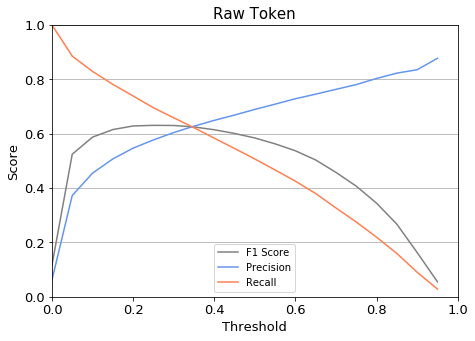

In [50]:
fig, ax = plt.subplots(figsize=(16,5))

plt.subplot(121)
sns.lineplot(x=combined_score.index, y=combined_score['F1 Score'], color='grey')
sns.lineplot(x=combined_score.index, y=combined_score['Precision'], color='cornflowerblue')
sns.lineplot(x=combined_score.index, y=combined_score['Recall'], color='coral')
plt.ylim(0, 1)
plt.xlim(0, 1)
# plt.xticks(rotation=45)
plt.title('Raw Token', fontsize=15)
plt.ylabel('Score', fontsize = 13)
plt.yticks(fontsize=13)
plt.xlabel('Threshold', fontsize = 13)
plt.xticks(fontsize=13)
plt.legend(combined_score.columns, loc='lower center')
plt.grid(axis='y')




In [54]:
model.save('./W2VCBOW.pkl')

In [55]:
keras.models.load_model('./W2VCBOW.pkl')

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### Word2Vec Skip-Gram embedding using training data.

In [28]:
%%time
w2v_SkipGram = Word2Vec(sentences=X_train_t, size=300, window=5, min_count=5, workers=6, sg=1)

INFO - 23:07:13: collecting all words and their counts
INFO - 23:07:13: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 23:07:13: PROGRESS: at sentence #10000, processed 130140 words, keeping 14738 word types
INFO - 23:07:13: PROGRESS: at sentence #20000, processed 259997 words, keeping 21600 word types
INFO - 23:07:13: PROGRESS: at sentence #30000, processed 389329 words, keeping 26790 word types
INFO - 23:07:13: PROGRESS: at sentence #40000, processed 518014 words, keeping 31120 word types
INFO - 23:07:13: PROGRESS: at sentence #50000, processed 646632 words, keeping 34806 word types
INFO - 23:07:14: PROGRESS: at sentence #60000, processed 775136 words, keeping 38145 word types
INFO - 23:07:14: PROGRESS: at sentence #70000, processed 904057 words, keeping 41267 word types
INFO - 23:07:14: PROGRESS: at sentence #80000, processed 1034004 words, keeping 44155 word types
INFO - 23:07:14: PROGRESS: at sentence #90000, processed 1163059 words, keeping 46939 word ty

INFO - 23:08:07: EPOCH 2 - PROGRESS: at 60.74% examples, 323779 words/s, in_qsize 11, out_qsize 0
INFO - 23:08:08: EPOCH 2 - PROGRESS: at 64.23% examples, 324433 words/s, in_qsize 11, out_qsize 0
INFO - 23:08:09: EPOCH 2 - PROGRESS: at 67.93% examples, 326148 words/s, in_qsize 11, out_qsize 0
INFO - 23:08:10: EPOCH 2 - PROGRESS: at 71.43% examples, 326655 words/s, in_qsize 11, out_qsize 0
INFO - 23:08:11: EPOCH 2 - PROGRESS: at 74.90% examples, 326655 words/s, in_qsize 12, out_qsize 0
INFO - 23:08:12: EPOCH 2 - PROGRESS: at 78.39% examples, 326742 words/s, in_qsize 12, out_qsize 0
INFO - 23:08:13: EPOCH 2 - PROGRESS: at 82.14% examples, 328276 words/s, in_qsize 11, out_qsize 0
INFO - 23:08:14: EPOCH 2 - PROGRESS: at 85.69% examples, 328733 words/s, in_qsize 12, out_qsize 0
INFO - 23:08:15: EPOCH 2 - PROGRESS: at 89.34% examples, 329314 words/s, in_qsize 12, out_qsize 0
INFO - 23:08:16: EPOCH 2 - PROGRESS: at 93.12% examples, 330443 words/s, in_qsize 12, out_qsize 0
INFO - 23:08:17: EPO

Wall time: 2min 36s


In [29]:
w2v_SkipGram.wv.most_similar('nice')

INFO - 23:09:50: precomputing L2-norms of word weight vectors


[('charming', 0.6048499345779419),
 ('impolite', 0.5830869674682617),
 ('respectful', 0.5783421993255615),
 ('polite', 0.5741904973983765),
 ('kidding', 0.5729858875274658),
 ('nerdy', 0.5707582831382751),
 ('manly', 0.5679082870483398),
 ('slutty', 0.5676258206367493),
 ('cute', 0.566896378993988),
 ('flirtatious', 0.5658221244812012)]

In [30]:
# Tunning parameters
MAX_NB_WORDS = 160000
EMBEDDING_DIM = 300
LSTM_UNITS = 100
DROP = 0.2
RE_DROP = 0.2

In [36]:
%%time
embedding_matrix = np.zeros((len(tokenizer.word_index), EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in w2v_SkipGram.wv.vocab:
        embedding_matrix[i] = w2v_SkipGram.wv.get_vector(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 130051
Wall time: 428 ms


In [37]:
embedding_matrix.shape

(173994, 300)

In [38]:
%%time
#### LSTM## Network architecture
model = Sequential()

model.add(Embedding(173994, EMBEDDING_DIM, weights = [embedding_matrix], input_length=INPUT_LEN)) 
model.add(LSTM(LSTM_UNITS, dropout=DROP, recurrent_dropout=RE_DROP))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_data, y_train, validation_split=0.4, epochs=3)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 626938 samples, validate on 417959 samples
Epoch 1/3


  6176/626938 [..............................] - ETA: 19:19:47 - loss: 0.6253 - acc: 0.875 - ETA: 10:20:10 - loss: 0.5673 - acc: 0.921 - ETA: 7:21:11 - loss: 0.5282 - acc: 0.927 - ETA: 5:51:50 - loss: 0.4743 - acc: 0.93 - ETA: 4:56:56 - loss: 0.4464 - acc: 0.93 - ETA: 4:20:03 - loss: 0.4077 - acc: 0.94 - ETA: 3:54:13 - loss: 0.4030 - acc: 0.93 - ETA: 3:34:46 - loss: 0.3724 - acc: 0.93 - ETA: 3:19:46 - loss: 0.3484 - acc: 0.94 - ETA: 3:07:47 - loss: 0.3478 - acc: 0.93 - ETA: 2:58:16 - loss: 0.3400 - acc: 0.93 - ETA: 2:50:33 - loss: 0.3137 - acc: 0.94 - ETA: 2:43:41 - loss: 0.3154 - acc: 0.93 - ETA: 2:37:38 - loss: 0.3117 - acc: 0.93 - ETA: 2:33:13 - loss: 0.3061 - acc: 0.93 - ETA: 2:28:42 - loss: 0.2962 - acc: 0.94 - ETA: 2:24:37 - loss: 0.2873 - acc: 0.94 - ETA: 2:21:02 - loss: 0.2728 - acc: 0.94 - ETA: 2:17:50 - loss: 0.2661 - acc: 0.94 - ETA: 2:15:41 - loss: 0.2544 - acc: 0.95 - ETA: 2:13:10 - loss: 0.2535 - acc: 0.94 - ETA: 2:10:56 - loss: 0.2534 - acc: 0.94 - ETA: 2:08:42 - loss: 0

 31008/626938 [>.............................] - ETA: 1:23:23 - loss: 0.1506 - acc: 0.94 - ETA: 1:23:22 - loss: 0.1507 - acc: 0.94 - ETA: 1:23:21 - loss: 0.1505 - acc: 0.94 - ETA: 1:23:21 - loss: 0.1504 - acc: 0.94 - ETA: 1:23:20 - loss: 0.1503 - acc: 0.94 - ETA: 1:23:20 - loss: 0.1504 - acc: 0.94 - ETA: 1:23:19 - loss: 0.1503 - acc: 0.94 - ETA: 1:23:19 - loss: 0.1506 - acc: 0.94 - ETA: 1:23:19 - loss: 0.1504 - acc: 0.94 - ETA: 1:23:19 - loss: 0.1505 - acc: 0.94 - ETA: 1:23:18 - loss: 0.1505 - acc: 0.94 - ETA: 1:23:18 - loss: 0.1505 - acc: 0.94 - ETA: 1:23:17 - loss: 0.1505 - acc: 0.94 - ETA: 1:23:16 - loss: 0.1504 - acc: 0.94 - ETA: 1:23:15 - loss: 0.1505 - acc: 0.94 - ETA: 1:23:15 - loss: 0.1503 - acc: 0.94 - ETA: 1:23:14 - loss: 0.1502 - acc: 0.94 - ETA: 1:23:14 - loss: 0.1501 - acc: 0.94 - ETA: 1:23:13 - loss: 0.1500 - acc: 0.94 - ETA: 1:23:13 - loss: 0.1498 - acc: 0.94 - ETA: 1:23:13 - loss: 0.1497 - acc: 0.94 - ETA: 1:23:12 - loss: 0.1498 - acc: 0.94 - ETA: 1:23:12 - loss: 0.1498

 37216/626938 [>.............................] - ETA: 1:22:19 - loss: 0.1481 - acc: 0.94 - ETA: 1:22:18 - loss: 0.1480 - acc: 0.94 - ETA: 1:22:19 - loss: 0.1482 - acc: 0.94 - ETA: 1:22:18 - loss: 0.1482 - acc: 0.94 - ETA: 1:22:18 - loss: 0.1481 - acc: 0.94 - ETA: 1:22:18 - loss: 0.1480 - acc: 0.94 - ETA: 1:22:19 - loss: 0.1481 - acc: 0.94 - ETA: 1:22:19 - loss: 0.1481 - acc: 0.94 - ETA: 1:22:18 - loss: 0.1481 - acc: 0.94 - ETA: 1:22:18 - loss: 0.1481 - acc: 0.94 - ETA: 1:22:18 - loss: 0.1481 - acc: 0.94 - ETA: 1:22:19 - loss: 0.1481 - acc: 0.94 - ETA: 1:22:19 - loss: 0.1480 - acc: 0.94 - ETA: 1:22:19 - loss: 0.1480 - acc: 0.94 - ETA: 1:22:20 - loss: 0.1479 - acc: 0.94 - ETA: 1:22:19 - loss: 0.1480 - acc: 0.94 - ETA: 1:22:20 - loss: 0.1479 - acc: 0.94 - ETA: 1:22:21 - loss: 0.1479 - acc: 0.94 - ETA: 1:22:21 - loss: 0.1478 - acc: 0.94 - ETA: 1:22:21 - loss: 0.1478 - acc: 0.94 - ETA: 1:22:21 - loss: 0.1477 - acc: 0.94 - ETA: 1:22:21 - loss: 0.1477 - acc: 0.94 - ETA: 1:22:20 - loss: 0.1476

 43424/626938 [=>............................] - ETA: 1:21:04 - loss: 0.1449 - acc: 0.94 - ETA: 1:21:04 - loss: 0.1449 - acc: 0.94 - ETA: 1:21:03 - loss: 0.1450 - acc: 0.94 - ETA: 1:21:03 - loss: 0.1450 - acc: 0.94 - ETA: 1:21:02 - loss: 0.1450 - acc: 0.94 - ETA: 1:21:02 - loss: 0.1449 - acc: 0.94 - ETA: 1:21:01 - loss: 0.1448 - acc: 0.94 - ETA: 1:21:01 - loss: 0.1448 - acc: 0.94 - ETA: 1:21:01 - loss: 0.1449 - acc: 0.94 - ETA: 1:21:01 - loss: 0.1449 - acc: 0.94 - ETA: 1:21:01 - loss: 0.1449 - acc: 0.94 - ETA: 1:21:01 - loss: 0.1448 - acc: 0.94 - ETA: 1:21:01 - loss: 0.1447 - acc: 0.94 - ETA: 1:21:01 - loss: 0.1449 - acc: 0.94 - ETA: 1:21:01 - loss: 0.1449 - acc: 0.94 - ETA: 1:21:00 - loss: 0.1449 - acc: 0.94 - ETA: 1:21:00 - loss: 0.1449 - acc: 0.94 - ETA: 1:21:00 - loss: 0.1448 - acc: 0.94 - ETA: 1:20:59 - loss: 0.1447 - acc: 0.94 - ETA: 1:20:59 - loss: 0.1446 - acc: 0.94 - ETA: 1:20:59 - loss: 0.1445 - acc: 0.94 - ETA: 1:20:58 - loss: 0.1445 - acc: 0.94 - ETA: 1:20:58 - loss: 0.1446

 49632/626938 [=>............................] - ETA: 1:19:35 - loss: 0.1433 - acc: 0.94 - ETA: 1:19:34 - loss: 0.1434 - acc: 0.94 - ETA: 1:19:34 - loss: 0.1433 - acc: 0.94 - ETA: 1:19:33 - loss: 0.1433 - acc: 0.94 - ETA: 1:19:32 - loss: 0.1434 - acc: 0.94 - ETA: 1:19:31 - loss: 0.1433 - acc: 0.94 - ETA: 1:19:31 - loss: 0.1432 - acc: 0.94 - ETA: 1:19:30 - loss: 0.1432 - acc: 0.94 - ETA: 1:19:29 - loss: 0.1433 - acc: 0.94 - ETA: 1:19:28 - loss: 0.1433 - acc: 0.94 - ETA: 1:19:27 - loss: 0.1433 - acc: 0.94 - ETA: 1:19:27 - loss: 0.1432 - acc: 0.94 - ETA: 1:19:26 - loss: 0.1433 - acc: 0.94 - ETA: 1:19:25 - loss: 0.1432 - acc: 0.94 - ETA: 1:19:24 - loss: 0.1432 - acc: 0.94 - ETA: 1:19:23 - loss: 0.1431 - acc: 0.94 - ETA: 1:19:23 - loss: 0.1431 - acc: 0.94 - ETA: 1:19:22 - loss: 0.1430 - acc: 0.94 - ETA: 1:19:21 - loss: 0.1430 - acc: 0.94 - ETA: 1:19:21 - loss: 0.1430 - acc: 0.94 - ETA: 1:19:20 - loss: 0.1430 - acc: 0.94 - ETA: 1:19:19 - loss: 0.1430 - acc: 0.94 - ETA: 1:19:19 - loss: 0.1430

 55840/626938 [=>............................] - ETA: 1:18:15 - loss: 0.1411 - acc: 0.94 - ETA: 1:18:15 - loss: 0.1410 - acc: 0.94 - ETA: 1:18:15 - loss: 0.1410 - acc: 0.94 - ETA: 1:18:14 - loss: 0.1410 - acc: 0.94 - ETA: 1:18:14 - loss: 0.1410 - acc: 0.94 - ETA: 1:18:14 - loss: 0.1410 - acc: 0.94 - ETA: 1:18:14 - loss: 0.1409 - acc: 0.94 - ETA: 1:18:14 - loss: 0.1410 - acc: 0.94 - ETA: 1:18:13 - loss: 0.1411 - acc: 0.94 - ETA: 1:18:13 - loss: 0.1411 - acc: 0.94 - ETA: 1:18:13 - loss: 0.1410 - acc: 0.94 - ETA: 1:18:13 - loss: 0.1410 - acc: 0.94 - ETA: 1:18:13 - loss: 0.1409 - acc: 0.94 - ETA: 1:18:12 - loss: 0.1408 - acc: 0.94 - ETA: 1:18:12 - loss: 0.1408 - acc: 0.94 - ETA: 1:18:12 - loss: 0.1407 - acc: 0.94 - ETA: 1:18:11 - loss: 0.1407 - acc: 0.94 - ETA: 1:18:11 - loss: 0.1407 - acc: 0.94 - ETA: 1:18:11 - loss: 0.1406 - acc: 0.94 - ETA: 1:18:11 - loss: 0.1406 - acc: 0.94 - ETA: 1:18:11 - loss: 0.1407 - acc: 0.94 - ETA: 1:18:10 - loss: 0.1407 - acc: 0.94 - ETA: 1:18:10 - loss: 0.1406

 62048/626938 [=>............................] - ETA: 1:17:43 - loss: 0.1390 - acc: 0.94 - ETA: 1:17:43 - loss: 0.1389 - acc: 0.94 - ETA: 1:17:43 - loss: 0.1389 - acc: 0.94 - ETA: 1:17:42 - loss: 0.1389 - acc: 0.94 - ETA: 1:17:42 - loss: 0.1388 - acc: 0.94 - ETA: 1:17:42 - loss: 0.1388 - acc: 0.94 - ETA: 1:17:41 - loss: 0.1387 - acc: 0.94 - ETA: 1:17:41 - loss: 0.1387 - acc: 0.94 - ETA: 1:17:41 - loss: 0.1387 - acc: 0.94 - ETA: 1:17:40 - loss: 0.1386 - acc: 0.94 - ETA: 1:17:40 - loss: 0.1386 - acc: 0.94 - ETA: 1:17:40 - loss: 0.1385 - acc: 0.94 - ETA: 1:17:40 - loss: 0.1385 - acc: 0.94 - ETA: 1:17:40 - loss: 0.1386 - acc: 0.94 - ETA: 1:17:39 - loss: 0.1386 - acc: 0.94 - ETA: 1:17:39 - loss: 0.1386 - acc: 0.94 - ETA: 1:17:38 - loss: 0.1386 - acc: 0.94 - ETA: 1:17:38 - loss: 0.1386 - acc: 0.94 - ETA: 1:17:37 - loss: 0.1386 - acc: 0.94 - ETA: 1:17:37 - loss: 0.1386 - acc: 0.94 - ETA: 1:17:37 - loss: 0.1386 - acc: 0.94 - ETA: 1:17:36 - loss: 0.1385 - acc: 0.94 - ETA: 1:17:36 - loss: 0.1385

 68256/626938 [==>...........................] - ETA: 1:16:38 - loss: 0.1376 - acc: 0.94 - ETA: 1:16:38 - loss: 0.1376 - acc: 0.94 - ETA: 1:16:38 - loss: 0.1376 - acc: 0.94 - ETA: 1:16:38 - loss: 0.1376 - acc: 0.94 - ETA: 1:16:38 - loss: 0.1376 - acc: 0.94 - ETA: 1:16:37 - loss: 0.1377 - acc: 0.94 - ETA: 1:16:38 - loss: 0.1376 - acc: 0.94 - ETA: 1:16:38 - loss: 0.1376 - acc: 0.94 - ETA: 1:16:39 - loss: 0.1375 - acc: 0.94 - ETA: 1:16:39 - loss: 0.1375 - acc: 0.94 - ETA: 1:16:39 - loss: 0.1375 - acc: 0.94 - ETA: 1:16:38 - loss: 0.1375 - acc: 0.94 - ETA: 1:16:38 - loss: 0.1374 - acc: 0.94 - ETA: 1:16:38 - loss: 0.1374 - acc: 0.94 - ETA: 1:16:38 - loss: 0.1375 - acc: 0.94 - ETA: 1:16:38 - loss: 0.1375 - acc: 0.94 - ETA: 1:16:38 - loss: 0.1375 - acc: 0.94 - ETA: 1:16:37 - loss: 0.1376 - acc: 0.94 - ETA: 1:16:37 - loss: 0.1376 - acc: 0.94 - ETA: 1:16:37 - loss: 0.1376 - acc: 0.94 - ETA: 1:16:37 - loss: 0.1375 - acc: 0.94 - ETA: 1:16:36 - loss: 0.1375 - acc: 0.94 - ETA: 1:16:36 - loss: 0.1376

 74464/626938 [==>...........................] - ETA: 1:15:56 - loss: 0.1366 - acc: 0.94 - ETA: 1:15:56 - loss: 0.1366 - acc: 0.94 - ETA: 1:15:56 - loss: 0.1366 - acc: 0.94 - ETA: 1:15:56 - loss: 0.1365 - acc: 0.94 - ETA: 1:15:56 - loss: 0.1366 - acc: 0.94 - ETA: 1:15:56 - loss: 0.1366 - acc: 0.94 - ETA: 1:15:56 - loss: 0.1366 - acc: 0.94 - ETA: 1:15:56 - loss: 0.1365 - acc: 0.94 - ETA: 1:15:57 - loss: 0.1365 - acc: 0.94 - ETA: 1:15:57 - loss: 0.1365 - acc: 0.94 - ETA: 1:15:56 - loss: 0.1365 - acc: 0.94 - ETA: 1:15:56 - loss: 0.1366 - acc: 0.94 - ETA: 1:15:56 - loss: 0.1365 - acc: 0.94 - ETA: 1:15:56 - loss: 0.1365 - acc: 0.94 - ETA: 1:15:56 - loss: 0.1365 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1365 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1364 - acc: 0.94 - ETA: 1:15:55 - loss: 0.1364 - acc: 0.94 - ETA: 1:15:54 - loss: 0.1364 - acc: 0.94 - ETA: 1:15:54 - loss: 0.1364 - acc: 0.94 - ETA: 1:15:54 - loss: 0.1364 - acc: 0.94 - ETA: 1:15:53 - loss: 0.1363 - acc: 0.94 - ETA: 1:15:53 - loss: 0.1363

 80672/626938 [==>...........................] - ETA: 1:15:17 - loss: 0.1356 - acc: 0.94 - ETA: 1:15:16 - loss: 0.1356 - acc: 0.94 - ETA: 1:15:16 - loss: 0.1355 - acc: 0.94 - ETA: 1:15:16 - loss: 0.1357 - acc: 0.94 - ETA: 1:15:16 - loss: 0.1356 - acc: 0.94 - ETA: 1:15:15 - loss: 0.1356 - acc: 0.94 - ETA: 1:15:15 - loss: 0.1356 - acc: 0.94 - ETA: 1:15:15 - loss: 0.1355 - acc: 0.94 - ETA: 1:15:14 - loss: 0.1355 - acc: 0.94 - ETA: 1:15:14 - loss: 0.1355 - acc: 0.94 - ETA: 1:15:13 - loss: 0.1355 - acc: 0.94 - ETA: 1:15:13 - loss: 0.1355 - acc: 0.94 - ETA: 1:15:13 - loss: 0.1355 - acc: 0.94 - ETA: 1:15:12 - loss: 0.1355 - acc: 0.94 - ETA: 1:15:12 - loss: 0.1355 - acc: 0.94 - ETA: 1:15:11 - loss: 0.1355 - acc: 0.94 - ETA: 1:15:11 - loss: 0.1355 - acc: 0.94 - ETA: 1:15:11 - loss: 0.1356 - acc: 0.94 - ETA: 1:15:11 - loss: 0.1356 - acc: 0.94 - ETA: 1:15:10 - loss: 0.1356 - acc: 0.94 - ETA: 1:15:10 - loss: 0.1356 - acc: 0.94 - ETA: 1:15:09 - loss: 0.1356 - acc: 0.94 - ETA: 1:15:09 - loss: 0.1356

 86880/626938 [===>..........................] - ETA: 1:14:28 - loss: 0.1342 - acc: 0.94 - ETA: 1:14:28 - loss: 0.1342 - acc: 0.94 - ETA: 1:14:28 - loss: 0.1342 - acc: 0.94 - ETA: 1:14:28 - loss: 0.1342 - acc: 0.94 - ETA: 1:14:28 - loss: 0.1342 - acc: 0.94 - ETA: 1:14:28 - loss: 0.1342 - acc: 0.94 - ETA: 1:14:28 - loss: 0.1342 - acc: 0.94 - ETA: 1:14:27 - loss: 0.1341 - acc: 0.94 - ETA: 1:14:27 - loss: 0.1341 - acc: 0.94 - ETA: 1:14:27 - loss: 0.1342 - acc: 0.94 - ETA: 1:14:27 - loss: 0.1343 - acc: 0.94 - ETA: 1:14:27 - loss: 0.1343 - acc: 0.94 - ETA: 1:14:27 - loss: 0.1344 - acc: 0.94 - ETA: 1:14:27 - loss: 0.1343 - acc: 0.94 - ETA: 1:14:27 - loss: 0.1343 - acc: 0.94 - ETA: 1:14:27 - loss: 0.1343 - acc: 0.94 - ETA: 1:14:27 - loss: 0.1343 - acc: 0.94 - ETA: 1:14:26 - loss: 0.1343 - acc: 0.94 - ETA: 1:14:26 - loss: 0.1343 - acc: 0.94 - ETA: 1:14:26 - loss: 0.1343 - acc: 0.94 - ETA: 1:14:26 - loss: 0.1343 - acc: 0.94 - ETA: 1:14:25 - loss: 0.1343 - acc: 0.94 - ETA: 1:14:25 - loss: 0.1343

 93088/626938 [===>..........................] - ETA: 1:13:53 - loss: 0.1336 - acc: 0.94 - ETA: 1:13:53 - loss: 0.1336 - acc: 0.94 - ETA: 1:13:53 - loss: 0.1336 - acc: 0.94 - ETA: 1:13:53 - loss: 0.1337 - acc: 0.94 - ETA: 1:13:52 - loss: 0.1337 - acc: 0.94 - ETA: 1:13:52 - loss: 0.1337 - acc: 0.94 - ETA: 1:13:52 - loss: 0.1337 - acc: 0.94 - ETA: 1:13:52 - loss: 0.1337 - acc: 0.94 - ETA: 1:13:52 - loss: 0.1337 - acc: 0.94 - ETA: 1:13:52 - loss: 0.1337 - acc: 0.94 - ETA: 1:13:51 - loss: 0.1337 - acc: 0.94 - ETA: 1:13:52 - loss: 0.1337 - acc: 0.94 - ETA: 1:13:51 - loss: 0.1336 - acc: 0.94 - ETA: 1:13:51 - loss: 0.1336 - acc: 0.94 - ETA: 1:13:51 - loss: 0.1336 - acc: 0.94 - ETA: 1:13:51 - loss: 0.1336 - acc: 0.94 - ETA: 1:13:51 - loss: 0.1336 - acc: 0.94 - ETA: 1:13:50 - loss: 0.1336 - acc: 0.94 - ETA: 1:13:50 - loss: 0.1337 - acc: 0.94 - ETA: 1:13:50 - loss: 0.1336 - acc: 0.94 - ETA: 1:13:50 - loss: 0.1336 - acc: 0.94 - ETA: 1:13:50 - loss: 0.1336 - acc: 0.94 - ETA: 1:13:50 - loss: 0.1336

 99296/626938 [===>..........................] - ETA: 1:13:22 - loss: 0.1332 - acc: 0.94 - ETA: 1:13:22 - loss: 0.1332 - acc: 0.94 - ETA: 1:13:22 - loss: 0.1333 - acc: 0.94 - ETA: 1:13:22 - loss: 0.1333 - acc: 0.94 - ETA: 1:13:22 - loss: 0.1332 - acc: 0.94 - ETA: 1:13:21 - loss: 0.1333 - acc: 0.94 - ETA: 1:13:21 - loss: 0.1333 - acc: 0.94 - ETA: 1:13:21 - loss: 0.1333 - acc: 0.94 - ETA: 1:13:21 - loss: 0.1333 - acc: 0.94 - ETA: 1:13:21 - loss: 0.1332 - acc: 0.94 - ETA: 1:13:21 - loss: 0.1333 - acc: 0.94 - ETA: 1:13:21 - loss: 0.1333 - acc: 0.94 - ETA: 1:13:21 - loss: 0.1333 - acc: 0.94 - ETA: 1:13:21 - loss: 0.1333 - acc: 0.94 - ETA: 1:13:20 - loss: 0.1332 - acc: 0.94 - ETA: 1:13:20 - loss: 0.1332 - acc: 0.94 - ETA: 1:13:20 - loss: 0.1332 - acc: 0.94 - ETA: 1:13:20 - loss: 0.1332 - acc: 0.94 - ETA: 1:13:20 - loss: 0.1332 - acc: 0.94 - ETA: 1:13:19 - loss: 0.1332 - acc: 0.94 - ETA: 1:13:19 - loss: 0.1332 - acc: 0.94 - ETA: 1:13:20 - loss: 0.1331 - acc: 0.94 - ETA: 1:13:20 - loss: 0.1331

105504/626938 [====>.........................] - ETA: 1:13:15 - loss: 0.1329 - acc: 0.94 - ETA: 1:13:15 - loss: 0.1329 - acc: 0.94 - ETA: 1:13:15 - loss: 0.1329 - acc: 0.94 - ETA: 1:13:15 - loss: 0.1329 - acc: 0.94 - ETA: 1:13:15 - loss: 0.1329 - acc: 0.94 - ETA: 1:13:15 - loss: 0.1329 - acc: 0.94 - ETA: 1:13:15 - loss: 0.1329 - acc: 0.94 - ETA: 1:13:15 - loss: 0.1329 - acc: 0.94 - ETA: 1:13:15 - loss: 0.1328 - acc: 0.94 - ETA: 1:13:15 - loss: 0.1328 - acc: 0.94 - ETA: 1:13:15 - loss: 0.1328 - acc: 0.94 - ETA: 1:13:15 - loss: 0.1329 - acc: 0.94 - ETA: 1:13:14 - loss: 0.1329 - acc: 0.94 - ETA: 1:13:14 - loss: 0.1330 - acc: 0.94 - ETA: 1:13:14 - loss: 0.1329 - acc: 0.94 - ETA: 1:13:14 - loss: 0.1329 - acc: 0.94 - ETA: 1:13:14 - loss: 0.1329 - acc: 0.94 - ETA: 1:13:14 - loss: 0.1329 - acc: 0.94 - ETA: 1:13:14 - loss: 0.1329 - acc: 0.94 - ETA: 1:13:14 - loss: 0.1329 - acc: 0.94 - ETA: 1:13:13 - loss: 0.1329 - acc: 0.94 - ETA: 1:13:13 - loss: 0.1329 - acc: 0.94 - ETA: 1:13:13 - loss: 0.1329

111712/626938 [====>.........................] - ETA: 1:12:44 - loss: 0.1321 - acc: 0.94 - ETA: 1:12:44 - loss: 0.1321 - acc: 0.94 - ETA: 1:12:44 - loss: 0.1321 - acc: 0.94 - ETA: 1:12:44 - loss: 0.1320 - acc: 0.94 - ETA: 1:12:44 - loss: 0.1320 - acc: 0.94 - ETA: 1:12:43 - loss: 0.1321 - acc: 0.94 - ETA: 1:12:43 - loss: 0.1321 - acc: 0.94 - ETA: 1:12:43 - loss: 0.1320 - acc: 0.94 - ETA: 1:12:43 - loss: 0.1320 - acc: 0.94 - ETA: 1:12:42 - loss: 0.1320 - acc: 0.94 - ETA: 1:12:42 - loss: 0.1320 - acc: 0.94 - ETA: 1:12:42 - loss: 0.1320 - acc: 0.94 - ETA: 1:12:41 - loss: 0.1321 - acc: 0.94 - ETA: 1:12:41 - loss: 0.1321 - acc: 0.94 - ETA: 1:12:41 - loss: 0.1321 - acc: 0.94 - ETA: 1:12:41 - loss: 0.1321 - acc: 0.94 - ETA: 1:12:41 - loss: 0.1321 - acc: 0.94 - ETA: 1:12:40 - loss: 0.1321 - acc: 0.94 - ETA: 1:12:40 - loss: 0.1320 - acc: 0.94 - ETA: 1:12:40 - loss: 0.1320 - acc: 0.94 - ETA: 1:12:39 - loss: 0.1320 - acc: 0.94 - ETA: 1:12:39 - loss: 0.1320 - acc: 0.94 - ETA: 1:12:39 - loss: 0.1320

117920/626938 [====>.........................] - ETA: 1:12:11 - loss: 0.1311 - acc: 0.94 - ETA: 1:12:11 - loss: 0.1311 - acc: 0.94 - ETA: 1:12:11 - loss: 0.1311 - acc: 0.94 - ETA: 1:12:11 - loss: 0.1312 - acc: 0.94 - ETA: 1:12:11 - loss: 0.1311 - acc: 0.94 - ETA: 1:12:11 - loss: 0.1312 - acc: 0.94 - ETA: 1:12:10 - loss: 0.1312 - acc: 0.94 - ETA: 1:12:10 - loss: 0.1312 - acc: 0.94 - ETA: 1:12:10 - loss: 0.1312 - acc: 0.94 - ETA: 1:12:10 - loss: 0.1312 - acc: 0.94 - ETA: 1:12:10 - loss: 0.1312 - acc: 0.94 - ETA: 1:12:09 - loss: 0.1312 - acc: 0.94 - ETA: 1:12:09 - loss: 0.1312 - acc: 0.94 - ETA: 1:12:09 - loss: 0.1311 - acc: 0.94 - ETA: 1:12:09 - loss: 0.1311 - acc: 0.94 - ETA: 1:12:09 - loss: 0.1311 - acc: 0.94 - ETA: 1:12:08 - loss: 0.1311 - acc: 0.94 - ETA: 1:12:08 - loss: 0.1311 - acc: 0.94 - ETA: 1:12:08 - loss: 0.1311 - acc: 0.94 - ETA: 1:12:08 - loss: 0.1312 - acc: 0.94 - ETA: 1:12:08 - loss: 0.1312 - acc: 0.94 - ETA: 1:12:08 - loss: 0.1312 - acc: 0.94 - ETA: 1:12:07 - loss: 0.1312

124128/626938 [====>.........................] - ETA: 1:11:22 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:21 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:21 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:21 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:20 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:20 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:20 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:19 - loss: 0.1308 - acc: 0.94 - ETA: 1:11:19 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:19 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:19 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:19 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:18 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:18 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:18 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:17 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:17 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:17 - loss: 0.1308 - acc: 0.94 - ETA: 1:11:17 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:16 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:16 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:16 - loss: 0.1309 - acc: 0.94 - ETA: 1:11:15 - loss: 0.1310

130336/626938 [=====>........................] - ETA: 1:10:40 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:40 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:40 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:39 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:39 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:39 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:38 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:38 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:38 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:38 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:37 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:37 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:37 - loss: 0.1304 - acc: 0.94 - ETA: 1:10:37 - loss: 0.1304 - acc: 0.94 - ETA: 1:10:37 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:37 - loss: 0.1304 - acc: 0.94 - ETA: 1:10:37 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:37 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:37 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:36 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:36 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:36 - loss: 0.1305 - acc: 0.94 - ETA: 1:10:35 - loss: 0.1305

136544/626938 [=====>........................] - ETA: 1:10:09 - loss: 0.1302 - acc: 0.94 - ETA: 1:10:08 - loss: 0.1302 - acc: 0.94 - ETA: 1:10:08 - loss: 0.1302 - acc: 0.94 - ETA: 1:10:08 - loss: 0.1302 - acc: 0.94 - ETA: 1:10:07 - loss: 0.1301 - acc: 0.94 - ETA: 1:10:07 - loss: 0.1302 - acc: 0.94 - ETA: 1:10:07 - loss: 0.1302 - acc: 0.94 - ETA: 1:10:07 - loss: 0.1302 - acc: 0.94 - ETA: 1:10:07 - loss: 0.1302 - acc: 0.94 - ETA: 1:10:06 - loss: 0.1301 - acc: 0.94 - ETA: 1:10:06 - loss: 0.1301 - acc: 0.94 - ETA: 1:10:06 - loss: 0.1301 - acc: 0.94 - ETA: 1:10:05 - loss: 0.1301 - acc: 0.94 - ETA: 1:10:05 - loss: 0.1302 - acc: 0.94 - ETA: 1:10:05 - loss: 0.1302 - acc: 0.94 - ETA: 1:10:05 - loss: 0.1301 - acc: 0.94 - ETA: 1:10:04 - loss: 0.1301 - acc: 0.94 - ETA: 1:10:04 - loss: 0.1301 - acc: 0.94 - ETA: 1:10:04 - loss: 0.1301 - acc: 0.94 - ETA: 1:10:03 - loss: 0.1301 - acc: 0.94 - ETA: 1:10:03 - loss: 0.1301 - acc: 0.94 - ETA: 1:10:03 - loss: 0.1301 - acc: 0.94 - ETA: 1:10:02 - loss: 0.1301

142752/626938 [=====>........................] - ETA: 1:09:14 - loss: 0.1294 - acc: 0.94 - ETA: 1:09:13 - loss: 0.1294 - acc: 0.94 - ETA: 1:09:13 - loss: 0.1294 - acc: 0.94 - ETA: 1:09:13 - loss: 0.1294 - acc: 0.94 - ETA: 1:09:13 - loss: 0.1294 - acc: 0.94 - ETA: 1:09:12 - loss: 0.1294 - acc: 0.94 - ETA: 1:09:12 - loss: 0.1294 - acc: 0.94 - ETA: 1:09:12 - loss: 0.1294 - acc: 0.94 - ETA: 1:09:12 - loss: 0.1294 - acc: 0.94 - ETA: 1:09:12 - loss: 0.1294 - acc: 0.94 - ETA: 1:09:11 - loss: 0.1294 - acc: 0.94 - ETA: 1:09:11 - loss: 0.1294 - acc: 0.94 - ETA: 1:09:11 - loss: 0.1294 - acc: 0.94 - ETA: 1:09:11 - loss: 0.1294 - acc: 0.94 - ETA: 1:09:10 - loss: 0.1294 - acc: 0.94 - ETA: 1:09:10 - loss: 0.1294 - acc: 0.94 - ETA: 1:09:10 - loss: 0.1294 - acc: 0.94 - ETA: 1:09:10 - loss: 0.1293 - acc: 0.94 - ETA: 1:09:09 - loss: 0.1293 - acc: 0.94 - ETA: 1:09:09 - loss: 0.1293 - acc: 0.94 - ETA: 1:09:09 - loss: 0.1293 - acc: 0.94 - ETA: 1:09:09 - loss: 0.1293 - acc: 0.94 - ETA: 1:09:08 - loss: 0.1293

148960/626938 [======>.......................] - ETA: 1:08:19 - loss: 0.1289 - acc: 0.94 - ETA: 1:08:19 - loss: 0.1289 - acc: 0.94 - ETA: 1:08:19 - loss: 0.1289 - acc: 0.94 - ETA: 1:08:18 - loss: 0.1289 - acc: 0.94 - ETA: 1:08:18 - loss: 0.1289 - acc: 0.94 - ETA: 1:08:18 - loss: 0.1289 - acc: 0.94 - ETA: 1:08:18 - loss: 0.1290 - acc: 0.94 - ETA: 1:08:17 - loss: 0.1290 - acc: 0.94 - ETA: 1:08:18 - loss: 0.1290 - acc: 0.94 - ETA: 1:08:17 - loss: 0.1290 - acc: 0.94 - ETA: 1:08:17 - loss: 0.1290 - acc: 0.94 - ETA: 1:08:17 - loss: 0.1290 - acc: 0.94 - ETA: 1:08:17 - loss: 0.1289 - acc: 0.94 - ETA: 1:08:16 - loss: 0.1289 - acc: 0.94 - ETA: 1:08:16 - loss: 0.1290 - acc: 0.94 - ETA: 1:08:16 - loss: 0.1290 - acc: 0.94 - ETA: 1:08:15 - loss: 0.1290 - acc: 0.94 - ETA: 1:08:15 - loss: 0.1290 - acc: 0.94 - ETA: 1:08:15 - loss: 0.1290 - acc: 0.94 - ETA: 1:08:15 - loss: 0.1290 - acc: 0.94 - ETA: 1:08:14 - loss: 0.1290 - acc: 0.94 - ETA: 1:08:14 - loss: 0.1290 - acc: 0.94 - ETA: 1:08:14 - loss: 0.1290

155168/626938 [======>.......................] - ETA: 1:07:30 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:29 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:29 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:29 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:29 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:28 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:28 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:28 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:27 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:27 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:27 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:26 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:26 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:26 - loss: 0.1285 - acc: 0.94 - ETA: 1:07:26 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:25 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:25 - loss: 0.1285 - acc: 0.94 - ETA: 1:07:25 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:24 - loss: 0.1285 - acc: 0.94 - ETA: 1:07:24 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:24 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:24 - loss: 0.1284 - acc: 0.94 - ETA: 1:07:23 - loss: 0.1284

161376/626938 [======>.......................] - ETA: 1:06:31 - loss: 0.1280 - acc: 0.94 - ETA: 1:06:31 - loss: 0.1280 - acc: 0.94 - ETA: 1:06:31 - loss: 0.1280 - acc: 0.94 - ETA: 1:06:30 - loss: 0.1280 - acc: 0.94 - ETA: 1:06:30 - loss: 0.1280 - acc: 0.94 - ETA: 1:06:30 - loss: 0.1280 - acc: 0.94 - ETA: 1:06:30 - loss: 0.1280 - acc: 0.94 - ETA: 1:06:29 - loss: 0.1280 - acc: 0.94 - ETA: 1:06:29 - loss: 0.1280 - acc: 0.94 - ETA: 1:06:29 - loss: 0.1280 - acc: 0.94 - ETA: 1:06:28 - loss: 0.1280 - acc: 0.94 - ETA: 1:06:28 - loss: 0.1279 - acc: 0.94 - ETA: 1:06:28 - loss: 0.1279 - acc: 0.94 - ETA: 1:06:28 - loss: 0.1280 - acc: 0.94 - ETA: 1:06:27 - loss: 0.1279 - acc: 0.94 - ETA: 1:06:27 - loss: 0.1279 - acc: 0.94 - ETA: 1:06:27 - loss: 0.1279 - acc: 0.94 - ETA: 1:06:27 - loss: 0.1279 - acc: 0.94 - ETA: 1:06:27 - loss: 0.1279 - acc: 0.94 - ETA: 1:06:27 - loss: 0.1279 - acc: 0.94 - ETA: 1:06:27 - loss: 0.1279 - acc: 0.94 - ETA: 1:06:26 - loss: 0.1279 - acc: 0.94 - ETA: 1:06:26 - loss: 0.1279

167584/626938 [=======>......................] - ETA: 1:05:40 - loss: 0.1274 - acc: 0.94 - ETA: 1:05:40 - loss: 0.1274 - acc: 0.94 - ETA: 1:05:40 - loss: 0.1274 - acc: 0.94 - ETA: 1:05:40 - loss: 0.1274 - acc: 0.94 - ETA: 1:05:39 - loss: 0.1274 - acc: 0.94 - ETA: 1:05:39 - loss: 0.1274 - acc: 0.94 - ETA: 1:05:39 - loss: 0.1273 - acc: 0.94 - ETA: 1:05:39 - loss: 0.1273 - acc: 0.94 - ETA: 1:05:38 - loss: 0.1273 - acc: 0.94 - ETA: 1:05:38 - loss: 0.1273 - acc: 0.94 - ETA: 1:05:38 - loss: 0.1273 - acc: 0.94 - ETA: 1:05:38 - loss: 0.1273 - acc: 0.94 - ETA: 1:05:37 - loss: 0.1273 - acc: 0.94 - ETA: 1:05:37 - loss: 0.1273 - acc: 0.94 - ETA: 1:05:37 - loss: 0.1273 - acc: 0.94 - ETA: 1:05:37 - loss: 0.1273 - acc: 0.94 - ETA: 1:05:37 - loss: 0.1273 - acc: 0.94 - ETA: 1:05:36 - loss: 0.1273 - acc: 0.94 - ETA: 1:05:36 - loss: 0.1273 - acc: 0.94 - ETA: 1:05:36 - loss: 0.1273 - acc: 0.94 - ETA: 1:05:36 - loss: 0.1273 - acc: 0.94 - ETA: 1:05:35 - loss: 0.1273 - acc: 0.94 - ETA: 1:05:35 - loss: 0.1273

173792/626938 [=======>......................] - ETA: 1:04:47 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:46 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:46 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:46 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:46 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:45 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:45 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:45 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:44 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:44 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:44 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:44 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:43 - loss: 0.1268 - acc: 0.94 - ETA: 1:04:43 - loss: 0.1268 - acc: 0.94 - ETA: 1:04:43 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:42 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:42 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:42 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:41 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:41 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:41 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:40 - loss: 0.1269 - acc: 0.94 - ETA: 1:04:40 - loss: 0.1269

180000/626938 [=======>......................] - ETA: 1:03:46 - loss: 0.1264 - acc: 0.95 - ETA: 1:03:45 - loss: 0.1264 - acc: 0.95 - ETA: 1:03:45 - loss: 0.1264 - acc: 0.95 - ETA: 1:03:45 - loss: 0.1264 - acc: 0.95 - ETA: 1:03:45 - loss: 0.1264 - acc: 0.95 - ETA: 1:03:44 - loss: 0.1264 - acc: 0.95 - ETA: 1:03:44 - loss: 0.1264 - acc: 0.95 - ETA: 1:03:44 - loss: 0.1264 - acc: 0.95 - ETA: 1:03:44 - loss: 0.1264 - acc: 0.95 - ETA: 1:03:43 - loss: 0.1264 - acc: 0.95 - ETA: 1:03:43 - loss: 0.1264 - acc: 0.95 - ETA: 1:03:43 - loss: 0.1264 - acc: 0.95 - ETA: 1:03:43 - loss: 0.1263 - acc: 0.95 - ETA: 1:03:43 - loss: 0.1263 - acc: 0.95 - ETA: 1:03:42 - loss: 0.1263 - acc: 0.95 - ETA: 1:03:42 - loss: 0.1263 - acc: 0.95 - ETA: 1:03:42 - loss: 0.1263 - acc: 0.95 - ETA: 1:03:42 - loss: 0.1263 - acc: 0.95 - ETA: 1:03:42 - loss: 0.1263 - acc: 0.95 - ETA: 1:03:42 - loss: 0.1262 - acc: 0.95 - ETA: 1:03:42 - loss: 0.1262 - acc: 0.95 - ETA: 1:03:42 - loss: 0.1262 - acc: 0.95 - ETA: 1:03:42 - loss: 0.1262

186208/626938 [=======>......................] - ETA: 1:02:48 - loss: 0.1264 - acc: 0.95 - ETA: 1:02:47 - loss: 0.1264 - acc: 0.95 - ETA: 1:02:47 - loss: 0.1264 - acc: 0.95 - ETA: 1:02:47 - loss: 0.1264 - acc: 0.95 - ETA: 1:02:46 - loss: 0.1264 - acc: 0.95 - ETA: 1:02:46 - loss: 0.1264 - acc: 0.95 - ETA: 1:02:46 - loss: 0.1264 - acc: 0.95 - ETA: 1:02:45 - loss: 0.1264 - acc: 0.95 - ETA: 1:02:45 - loss: 0.1264 - acc: 0.95 - ETA: 1:02:45 - loss: 0.1263 - acc: 0.95 - ETA: 1:02:44 - loss: 0.1263 - acc: 0.95 - ETA: 1:02:44 - loss: 0.1263 - acc: 0.95 - ETA: 1:02:44 - loss: 0.1263 - acc: 0.95 - ETA: 1:02:43 - loss: 0.1263 - acc: 0.95 - ETA: 1:02:43 - loss: 0.1263 - acc: 0.95 - ETA: 1:02:43 - loss: 0.1263 - acc: 0.95 - ETA: 1:02:43 - loss: 0.1263 - acc: 0.95 - ETA: 1:02:42 - loss: 0.1263 - acc: 0.95 - ETA: 1:02:42 - loss: 0.1263 - acc: 0.95 - ETA: 1:02:42 - loss: 0.1263 - acc: 0.95 - ETA: 1:02:41 - loss: 0.1263 - acc: 0.95 - ETA: 1:02:41 - loss: 0.1263 - acc: 0.95 - ETA: 1:02:40 - loss: 0.1263

192416/626938 [========>.....................] - ETA: 1:01:47 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:47 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:47 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:46 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:46 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:46 - loss: 0.1261 - acc: 0.95 - ETA: 1:01:45 - loss: 0.1261 - acc: 0.95 - ETA: 1:01:45 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:45 - loss: 0.1261 - acc: 0.95 - ETA: 1:01:45 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:44 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:44 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:44 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:43 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:43 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:43 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:43 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:42 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:42 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:42 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:42 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:41 - loss: 0.1260 - acc: 0.95 - ETA: 1:01:41 - loss: 0.1260

198656/626938 [========>.....................] - ETA: 1:00:51 - loss: 0.1257 - acc: 0.95 - ETA: 1:00:51 - loss: 0.1257 - acc: 0.95 - ETA: 1:00:51 - loss: 0.1257 - acc: 0.95 - ETA: 1:00:50 - loss: 0.1257 - acc: 0.95 - ETA: 1:00:50 - loss: 0.1257 - acc: 0.95 - ETA: 1:00:50 - loss: 0.1257 - acc: 0.95 - ETA: 1:00:50 - loss: 0.1257 - acc: 0.95 - ETA: 1:00:49 - loss: 0.1257 - acc: 0.95 - ETA: 1:00:49 - loss: 0.1258 - acc: 0.95 - ETA: 1:00:49 - loss: 0.1258 - acc: 0.95 - ETA: 1:00:48 - loss: 0.1258 - acc: 0.95 - ETA: 1:00:48 - loss: 0.1258 - acc: 0.95 - ETA: 1:00:48 - loss: 0.1258 - acc: 0.95 - ETA: 1:00:48 - loss: 0.1258 - acc: 0.95 - ETA: 1:00:47 - loss: 0.1258 - acc: 0.95 - ETA: 1:00:47 - loss: 0.1258 - acc: 0.95 - ETA: 1:00:47 - loss: 0.1258 - acc: 0.95 - ETA: 1:00:46 - loss: 0.1258 - acc: 0.95 - ETA: 1:00:46 - loss: 0.1258 - acc: 0.95 - ETA: 1:00:46 - loss: 0.1258 - acc: 0.95 - ETA: 1:00:45 - loss: 0.1258 - acc: 0.95 - ETA: 1:00:45 - loss: 0.1258 - acc: 0.95 - ETA: 1:00:45 - loss: 0.1258

205184/626938 [========>.....................] - ETA: 59:57 - loss: 0.1256 - acc: 0.95 - ETA: 59:57 - loss: 0.1256 - acc: 0.95 - ETA: 59:57 - loss: 0.1256 - acc: 0.95 - ETA: 59:56 - loss: 0.1256 - acc: 0.95 - ETA: 59:56 - loss: 0.1256 - acc: 0.95 - ETA: 59:56 - loss: 0.1256 - acc: 0.95 - ETA: 59:55 - loss: 0.1256 - acc: 0.95 - ETA: 59:55 - loss: 0.1256 - acc: 0.95 - ETA: 59:55 - loss: 0.1256 - acc: 0.95 - ETA: 59:55 - loss: 0.1256 - acc: 0.95 - ETA: 59:54 - loss: 0.1256 - acc: 0.95 - ETA: 59:54 - loss: 0.1256 - acc: 0.95 - ETA: 59:54 - loss: 0.1256 - acc: 0.95 - ETA: 59:54 - loss: 0.1256 - acc: 0.95 - ETA: 59:53 - loss: 0.1255 - acc: 0.95 - ETA: 59:53 - loss: 0.1255 - acc: 0.95 - ETA: 59:53 - loss: 0.1255 - acc: 0.95 - ETA: 59:52 - loss: 0.1255 - acc: 0.95 - ETA: 59:52 - loss: 0.1255 - acc: 0.95 - ETA: 59:52 - loss: 0.1255 - acc: 0.95 - ETA: 59:52 - loss: 0.1255 - acc: 0.95 - ETA: 59:51 - loss: 0.1255 - acc: 0.95 - ETA: 59:51 - loss: 0.1255 - acc: 0.95 - ETA: 59:51 - loss: 0.1255 - acc

211712/626938 [=========>....................] - ETA: 59:03 - loss: 0.1254 - acc: 0.95 - ETA: 59:03 - loss: 0.1254 - acc: 0.95 - ETA: 59:03 - loss: 0.1254 - acc: 0.95 - ETA: 59:02 - loss: 0.1254 - acc: 0.95 - ETA: 59:02 - loss: 0.1254 - acc: 0.95 - ETA: 59:02 - loss: 0.1254 - acc: 0.95 - ETA: 59:01 - loss: 0.1255 - acc: 0.95 - ETA: 59:01 - loss: 0.1255 - acc: 0.95 - ETA: 59:01 - loss: 0.1255 - acc: 0.95 - ETA: 59:00 - loss: 0.1255 - acc: 0.95 - ETA: 59:00 - loss: 0.1255 - acc: 0.95 - ETA: 59:00 - loss: 0.1255 - acc: 0.95 - ETA: 58:59 - loss: 0.1255 - acc: 0.95 - ETA: 58:59 - loss: 0.1255 - acc: 0.95 - ETA: 58:59 - loss: 0.1254 - acc: 0.95 - ETA: 58:58 - loss: 0.1254 - acc: 0.95 - ETA: 58:58 - loss: 0.1254 - acc: 0.95 - ETA: 58:58 - loss: 0.1254 - acc: 0.95 - ETA: 58:58 - loss: 0.1254 - acc: 0.95 - ETA: 58:57 - loss: 0.1254 - acc: 0.95 - ETA: 58:57 - loss: 0.1254 - acc: 0.95 - ETA: 58:57 - loss: 0.1254 - acc: 0.95 - ETA: 58:56 - loss: 0.1254 - acc: 0.95 - ETA: 58:56 - loss: 0.1254 - acc

218240/626938 [=========>....................] - ETA: 58:04 - loss: 0.1253 - acc: 0.95 - ETA: 58:04 - loss: 0.1253 - acc: 0.95 - ETA: 58:04 - loss: 0.1253 - acc: 0.95 - ETA: 58:04 - loss: 0.1253 - acc: 0.95 - ETA: 58:03 - loss: 0.1253 - acc: 0.95 - ETA: 58:03 - loss: 0.1253 - acc: 0.95 - ETA: 58:03 - loss: 0.1253 - acc: 0.95 - ETA: 58:02 - loss: 0.1253 - acc: 0.95 - ETA: 58:02 - loss: 0.1253 - acc: 0.95 - ETA: 58:02 - loss: 0.1253 - acc: 0.95 - ETA: 58:01 - loss: 0.1253 - acc: 0.95 - ETA: 58:01 - loss: 0.1253 - acc: 0.95 - ETA: 58:01 - loss: 0.1253 - acc: 0.95 - ETA: 58:01 - loss: 0.1253 - acc: 0.95 - ETA: 58:00 - loss: 0.1253 - acc: 0.95 - ETA: 58:00 - loss: 0.1253 - acc: 0.95 - ETA: 58:00 - loss: 0.1253 - acc: 0.95 - ETA: 57:59 - loss: 0.1253 - acc: 0.95 - ETA: 57:59 - loss: 0.1253 - acc: 0.95 - ETA: 57:59 - loss: 0.1253 - acc: 0.95 - ETA: 57:58 - loss: 0.1253 - acc: 0.95 - ETA: 57:58 - loss: 0.1253 - acc: 0.95 - ETA: 57:58 - loss: 0.1253 - acc: 0.95 - ETA: 57:58 - loss: 0.1253 - acc

224768/626938 [=========>....................] - ETA: 57:06 - loss: 0.1251 - acc: 0.95 - ETA: 57:05 - loss: 0.1251 - acc: 0.95 - ETA: 57:05 - loss: 0.1251 - acc: 0.95 - ETA: 57:05 - loss: 0.1251 - acc: 0.95 - ETA: 57:05 - loss: 0.1251 - acc: 0.95 - ETA: 57:04 - loss: 0.1251 - acc: 0.95 - ETA: 57:04 - loss: 0.1251 - acc: 0.95 - ETA: 57:04 - loss: 0.1251 - acc: 0.95 - ETA: 57:03 - loss: 0.1251 - acc: 0.95 - ETA: 57:03 - loss: 0.1251 - acc: 0.95 - ETA: 57:03 - loss: 0.1251 - acc: 0.95 - ETA: 57:02 - loss: 0.1251 - acc: 0.95 - ETA: 57:02 - loss: 0.1251 - acc: 0.95 - ETA: 57:02 - loss: 0.1251 - acc: 0.95 - ETA: 57:01 - loss: 0.1251 - acc: 0.95 - ETA: 57:01 - loss: 0.1251 - acc: 0.95 - ETA: 57:01 - loss: 0.1251 - acc: 0.95 - ETA: 57:01 - loss: 0.1251 - acc: 0.95 - ETA: 57:00 - loss: 0.1250 - acc: 0.95 - ETA: 57:00 - loss: 0.1251 - acc: 0.95 - ETA: 57:00 - loss: 0.1251 - acc: 0.95 - ETA: 57:00 - loss: 0.1251 - acc: 0.95 - ETA: 56:59 - loss: 0.1251 - acc: 0.95 - ETA: 56:59 - loss: 0.1251 - acc

231296/626938 [==========>...................] - ETA: 56:06 - loss: 0.1249 - acc: 0.95 - ETA: 56:05 - loss: 0.1249 - acc: 0.95 - ETA: 56:05 - loss: 0.1248 - acc: 0.95 - ETA: 56:05 - loss: 0.1249 - acc: 0.95 - ETA: 56:04 - loss: 0.1249 - acc: 0.95 - ETA: 56:04 - loss: 0.1248 - acc: 0.95 - ETA: 56:04 - loss: 0.1248 - acc: 0.95 - ETA: 56:04 - loss: 0.1248 - acc: 0.95 - ETA: 56:04 - loss: 0.1248 - acc: 0.95 - ETA: 56:03 - loss: 0.1248 - acc: 0.95 - ETA: 56:03 - loss: 0.1248 - acc: 0.95 - ETA: 56:03 - loss: 0.1248 - acc: 0.95 - ETA: 56:02 - loss: 0.1248 - acc: 0.95 - ETA: 56:02 - loss: 0.1248 - acc: 0.95 - ETA: 56:02 - loss: 0.1248 - acc: 0.95 - ETA: 56:01 - loss: 0.1248 - acc: 0.95 - ETA: 56:01 - loss: 0.1248 - acc: 0.95 - ETA: 56:01 - loss: 0.1248 - acc: 0.95 - ETA: 56:00 - loss: 0.1248 - acc: 0.95 - ETA: 56:00 - loss: 0.1248 - acc: 0.95 - ETA: 56:00 - loss: 0.1248 - acc: 0.95 - ETA: 55:59 - loss: 0.1247 - acc: 0.95 - ETA: 55:59 - loss: 0.1247 - acc: 0.95 - ETA: 55:59 - loss: 0.1247 - acc

237824/626938 [==========>...................] - ETA: 55:04 - loss: 0.1247 - acc: 0.95 - ETA: 55:04 - loss: 0.1246 - acc: 0.95 - ETA: 55:04 - loss: 0.1247 - acc: 0.95 - ETA: 55:03 - loss: 0.1247 - acc: 0.95 - ETA: 55:03 - loss: 0.1246 - acc: 0.95 - ETA: 55:03 - loss: 0.1246 - acc: 0.95 - ETA: 55:02 - loss: 0.1246 - acc: 0.95 - ETA: 55:02 - loss: 0.1246 - acc: 0.95 - ETA: 55:02 - loss: 0.1246 - acc: 0.95 - ETA: 55:01 - loss: 0.1246 - acc: 0.95 - ETA: 55:01 - loss: 0.1246 - acc: 0.95 - ETA: 55:01 - loss: 0.1246 - acc: 0.95 - ETA: 55:00 - loss: 0.1246 - acc: 0.95 - ETA: 55:00 - loss: 0.1246 - acc: 0.95 - ETA: 55:00 - loss: 0.1246 - acc: 0.95 - ETA: 55:00 - loss: 0.1247 - acc: 0.95 - ETA: 54:59 - loss: 0.1247 - acc: 0.95 - ETA: 54:59 - loss: 0.1246 - acc: 0.95 - ETA: 54:59 - loss: 0.1246 - acc: 0.95 - ETA: 54:59 - loss: 0.1246 - acc: 0.95 - ETA: 54:58 - loss: 0.1246 - acc: 0.95 - ETA: 54:58 - loss: 0.1247 - acc: 0.95 - ETA: 54:58 - loss: 0.1246 - acc: 0.95 - ETA: 54:58 - loss: 0.1246 - acc

244352/626938 [==========>...................] - ETA: 54:03 - loss: 0.1244 - acc: 0.95 - ETA: 54:03 - loss: 0.1244 - acc: 0.95 - ETA: 54:03 - loss: 0.1244 - acc: 0.95 - ETA: 54:02 - loss: 0.1244 - acc: 0.95 - ETA: 54:02 - loss: 0.1244 - acc: 0.95 - ETA: 54:02 - loss: 0.1244 - acc: 0.95 - ETA: 54:02 - loss: 0.1244 - acc: 0.95 - ETA: 54:01 - loss: 0.1244 - acc: 0.95 - ETA: 54:01 - loss: 0.1244 - acc: 0.95 - ETA: 54:01 - loss: 0.1244 - acc: 0.95 - ETA: 54:00 - loss: 0.1244 - acc: 0.95 - ETA: 54:00 - loss: 0.1244 - acc: 0.95 - ETA: 54:00 - loss: 0.1244 - acc: 0.95 - ETA: 53:59 - loss: 0.1244 - acc: 0.95 - ETA: 53:59 - loss: 0.1244 - acc: 0.95 - ETA: 53:59 - loss: 0.1244 - acc: 0.95 - ETA: 53:59 - loss: 0.1244 - acc: 0.95 - ETA: 53:58 - loss: 0.1243 - acc: 0.95 - ETA: 53:58 - loss: 0.1243 - acc: 0.95 - ETA: 53:58 - loss: 0.1243 - acc: 0.95 - ETA: 53:57 - loss: 0.1243 - acc: 0.95 - ETA: 53:57 - loss: 0.1244 - acc: 0.95 - ETA: 53:57 - loss: 0.1243 - acc: 0.95 - ETA: 53:57 - loss: 0.1244 - acc

250880/626938 [===========>..................] - ETA: 53:07 - loss: 0.1240 - acc: 0.95 - ETA: 53:07 - loss: 0.1240 - acc: 0.95 - ETA: 53:06 - loss: 0.1240 - acc: 0.95 - ETA: 53:06 - loss: 0.1240 - acc: 0.95 - ETA: 53:06 - loss: 0.1240 - acc: 0.95 - ETA: 53:06 - loss: 0.1240 - acc: 0.95 - ETA: 53:05 - loss: 0.1239 - acc: 0.95 - ETA: 53:05 - loss: 0.1240 - acc: 0.95 - ETA: 53:05 - loss: 0.1239 - acc: 0.95 - ETA: 53:04 - loss: 0.1239 - acc: 0.95 - ETA: 53:04 - loss: 0.1239 - acc: 0.95 - ETA: 53:04 - loss: 0.1239 - acc: 0.95 - ETA: 53:04 - loss: 0.1239 - acc: 0.95 - ETA: 53:03 - loss: 0.1239 - acc: 0.95 - ETA: 53:03 - loss: 0.1240 - acc: 0.95 - ETA: 53:03 - loss: 0.1239 - acc: 0.95 - ETA: 53:02 - loss: 0.1239 - acc: 0.95 - ETA: 53:02 - loss: 0.1239 - acc: 0.95 - ETA: 53:02 - loss: 0.1239 - acc: 0.95 - ETA: 53:02 - loss: 0.1239 - acc: 0.95 - ETA: 53:01 - loss: 0.1239 - acc: 0.95 - ETA: 53:01 - loss: 0.1239 - acc: 0.95 - ETA: 53:01 - loss: 0.1240 - acc: 0.95 - ETA: 53:00 - loss: 0.1240 - acc

257408/626938 [===========>..................] - ETA: 52:14 - loss: 0.1237 - acc: 0.95 - ETA: 52:14 - loss: 0.1237 - acc: 0.95 - ETA: 52:14 - loss: 0.1237 - acc: 0.95 - ETA: 52:13 - loss: 0.1237 - acc: 0.95 - ETA: 52:13 - loss: 0.1237 - acc: 0.95 - ETA: 52:13 - loss: 0.1237 - acc: 0.95 - ETA: 52:12 - loss: 0.1237 - acc: 0.95 - ETA: 52:12 - loss: 0.1237 - acc: 0.95 - ETA: 52:12 - loss: 0.1237 - acc: 0.95 - ETA: 52:12 - loss: 0.1237 - acc: 0.95 - ETA: 52:11 - loss: 0.1237 - acc: 0.95 - ETA: 52:11 - loss: 0.1237 - acc: 0.95 - ETA: 52:11 - loss: 0.1237 - acc: 0.95 - ETA: 52:11 - loss: 0.1237 - acc: 0.95 - ETA: 52:11 - loss: 0.1237 - acc: 0.95 - ETA: 52:11 - loss: 0.1238 - acc: 0.95 - ETA: 52:11 - loss: 0.1238 - acc: 0.95 - ETA: 52:10 - loss: 0.1238 - acc: 0.95 - ETA: 52:10 - loss: 0.1238 - acc: 0.95 - ETA: 52:10 - loss: 0.1238 - acc: 0.95 - ETA: 52:09 - loss: 0.1238 - acc: 0.95 - ETA: 52:09 - loss: 0.1237 - acc: 0.95 - ETA: 52:09 - loss: 0.1237 - acc: 0.95 - ETA: 52:09 - loss: 0.1238 - acc

263936/626938 [===========>..................] - ETA: 51:21 - loss: 0.1237 - acc: 0.95 - ETA: 51:20 - loss: 0.1237 - acc: 0.95 - ETA: 51:20 - loss: 0.1237 - acc: 0.95 - ETA: 51:20 - loss: 0.1237 - acc: 0.95 - ETA: 51:20 - loss: 0.1237 - acc: 0.95 - ETA: 51:19 - loss: 0.1237 - acc: 0.95 - ETA: 51:19 - loss: 0.1237 - acc: 0.95 - ETA: 51:19 - loss: 0.1237 - acc: 0.95 - ETA: 51:19 - loss: 0.1237 - acc: 0.95 - ETA: 51:18 - loss: 0.1237 - acc: 0.95 - ETA: 51:18 - loss: 0.1237 - acc: 0.95 - ETA: 51:18 - loss: 0.1237 - acc: 0.95 - ETA: 51:18 - loss: 0.1237 - acc: 0.95 - ETA: 51:17 - loss: 0.1237 - acc: 0.95 - ETA: 51:17 - loss: 0.1237 - acc: 0.95 - ETA: 51:17 - loss: 0.1237 - acc: 0.95 - ETA: 51:16 - loss: 0.1237 - acc: 0.95 - ETA: 51:16 - loss: 0.1237 - acc: 0.95 - ETA: 51:16 - loss: 0.1237 - acc: 0.95 - ETA: 51:16 - loss: 0.1237 - acc: 0.95 - ETA: 51:15 - loss: 0.1237 - acc: 0.95 - ETA: 51:15 - loss: 0.1237 - acc: 0.95 - ETA: 51:15 - loss: 0.1237 - acc: 0.95 - ETA: 51:14 - loss: 0.1237 - acc

270464/626938 [===========>..................] - ETA: 50:24 - loss: 0.1233 - acc: 0.95 - ETA: 50:23 - loss: 0.1233 - acc: 0.95 - ETA: 50:23 - loss: 0.1233 - acc: 0.95 - ETA: 50:23 - loss: 0.1233 - acc: 0.95 - ETA: 50:22 - loss: 0.1233 - acc: 0.95 - ETA: 50:22 - loss: 0.1233 - acc: 0.95 - ETA: 50:22 - loss: 0.1233 - acc: 0.95 - ETA: 50:22 - loss: 0.1233 - acc: 0.95 - ETA: 50:21 - loss: 0.1233 - acc: 0.95 - ETA: 50:21 - loss: 0.1233 - acc: 0.95 - ETA: 50:21 - loss: 0.1233 - acc: 0.95 - ETA: 50:20 - loss: 0.1233 - acc: 0.95 - ETA: 50:20 - loss: 0.1233 - acc: 0.95 - ETA: 50:20 - loss: 0.1233 - acc: 0.95 - ETA: 50:20 - loss: 0.1233 - acc: 0.95 - ETA: 50:19 - loss: 0.1233 - acc: 0.95 - ETA: 50:19 - loss: 0.1233 - acc: 0.95 - ETA: 50:19 - loss: 0.1233 - acc: 0.95 - ETA: 50:19 - loss: 0.1233 - acc: 0.95 - ETA: 50:19 - loss: 0.1233 - acc: 0.95 - ETA: 50:18 - loss: 0.1233 - acc: 0.95 - ETA: 50:18 - loss: 0.1233 - acc: 0.95 - ETA: 50:18 - loss: 0.1233 - acc: 0.95 - ETA: 50:18 - loss: 0.1233 - acc

276992/626938 [============>.................] - ETA: 49:24 - loss: 0.1230 - acc: 0.95 - ETA: 49:24 - loss: 0.1230 - acc: 0.95 - ETA: 49:24 - loss: 0.1230 - acc: 0.95 - ETA: 49:23 - loss: 0.1230 - acc: 0.95 - ETA: 49:23 - loss: 0.1230 - acc: 0.95 - ETA: 49:23 - loss: 0.1230 - acc: 0.95 - ETA: 49:23 - loss: 0.1230 - acc: 0.95 - ETA: 49:22 - loss: 0.1230 - acc: 0.95 - ETA: 49:22 - loss: 0.1230 - acc: 0.95 - ETA: 49:22 - loss: 0.1230 - acc: 0.95 - ETA: 49:21 - loss: 0.1230 - acc: 0.95 - ETA: 49:21 - loss: 0.1230 - acc: 0.95 - ETA: 49:21 - loss: 0.1230 - acc: 0.95 - ETA: 49:21 - loss: 0.1230 - acc: 0.95 - ETA: 49:20 - loss: 0.1230 - acc: 0.95 - ETA: 49:20 - loss: 0.1230 - acc: 0.95 - ETA: 49:20 - loss: 0.1230 - acc: 0.95 - ETA: 49:19 - loss: 0.1230 - acc: 0.95 - ETA: 49:19 - loss: 0.1230 - acc: 0.95 - ETA: 49:19 - loss: 0.1230 - acc: 0.95 - ETA: 49:18 - loss: 0.1230 - acc: 0.95 - ETA: 49:18 - loss: 0.1230 - acc: 0.95 - ETA: 49:18 - loss: 0.1230 - acc: 0.95 - ETA: 49:18 - loss: 0.1230 - acc

283520/626938 [============>.................] - ETA: 48:23 - loss: 0.1227 - acc: 0.95 - ETA: 48:23 - loss: 0.1227 - acc: 0.95 - ETA: 48:23 - loss: 0.1227 - acc: 0.95 - ETA: 48:22 - loss: 0.1227 - acc: 0.95 - ETA: 48:22 - loss: 0.1227 - acc: 0.95 - ETA: 48:22 - loss: 0.1227 - acc: 0.95 - ETA: 48:21 - loss: 0.1227 - acc: 0.95 - ETA: 48:21 - loss: 0.1227 - acc: 0.95 - ETA: 48:21 - loss: 0.1227 - acc: 0.95 - ETA: 48:20 - loss: 0.1227 - acc: 0.95 - ETA: 48:20 - loss: 0.1226 - acc: 0.95 - ETA: 48:20 - loss: 0.1227 - acc: 0.95 - ETA: 48:20 - loss: 0.1227 - acc: 0.95 - ETA: 48:19 - loss: 0.1226 - acc: 0.95 - ETA: 48:19 - loss: 0.1226 - acc: 0.95 - ETA: 48:19 - loss: 0.1227 - acc: 0.95 - ETA: 48:18 - loss: 0.1226 - acc: 0.95 - ETA: 48:18 - loss: 0.1226 - acc: 0.95 - ETA: 48:18 - loss: 0.1226 - acc: 0.95 - ETA: 48:17 - loss: 0.1226 - acc: 0.95 - ETA: 48:17 - loss: 0.1226 - acc: 0.95 - ETA: 48:17 - loss: 0.1226 - acc: 0.95 - ETA: 48:17 - loss: 0.1226 - acc: 0.95 - ETA: 48:16 - loss: 0.1226 - acc

290048/626938 [============>.................] - ETA: 47:24 - loss: 0.1223 - acc: 0.95 - ETA: 47:24 - loss: 0.1223 - acc: 0.95 - ETA: 47:23 - loss: 0.1223 - acc: 0.95 - ETA: 47:23 - loss: 0.1223 - acc: 0.95 - ETA: 47:23 - loss: 0.1223 - acc: 0.95 - ETA: 47:23 - loss: 0.1223 - acc: 0.95 - ETA: 47:22 - loss: 0.1223 - acc: 0.95 - ETA: 47:22 - loss: 0.1222 - acc: 0.95 - ETA: 47:22 - loss: 0.1222 - acc: 0.95 - ETA: 47:21 - loss: 0.1222 - acc: 0.95 - ETA: 47:21 - loss: 0.1222 - acc: 0.95 - ETA: 47:21 - loss: 0.1223 - acc: 0.95 - ETA: 47:21 - loss: 0.1223 - acc: 0.95 - ETA: 47:20 - loss: 0.1222 - acc: 0.95 - ETA: 47:20 - loss: 0.1223 - acc: 0.95 - ETA: 47:20 - loss: 0.1223 - acc: 0.95 - ETA: 47:19 - loss: 0.1223 - acc: 0.95 - ETA: 47:19 - loss: 0.1223 - acc: 0.95 - ETA: 47:19 - loss: 0.1223 - acc: 0.95 - ETA: 47:19 - loss: 0.1222 - acc: 0.95 - ETA: 47:18 - loss: 0.1222 - acc: 0.95 - ETA: 47:18 - loss: 0.1223 - acc: 0.95 - ETA: 47:18 - loss: 0.1223 - acc: 0.95 - ETA: 47:17 - loss: 0.1222 - acc

296576/626938 [=============>................] - ETA: 46:28 - loss: 0.1221 - acc: 0.95 - ETA: 46:27 - loss: 0.1221 - acc: 0.95 - ETA: 46:27 - loss: 0.1221 - acc: 0.95 - ETA: 46:27 - loss: 0.1221 - acc: 0.95 - ETA: 46:27 - loss: 0.1221 - acc: 0.95 - ETA: 46:26 - loss: 0.1221 - acc: 0.95 - ETA: 46:26 - loss: 0.1221 - acc: 0.95 - ETA: 46:26 - loss: 0.1221 - acc: 0.95 - ETA: 46:26 - loss: 0.1221 - acc: 0.95 - ETA: 46:25 - loss: 0.1221 - acc: 0.95 - ETA: 46:25 - loss: 0.1221 - acc: 0.95 - ETA: 46:25 - loss: 0.1221 - acc: 0.95 - ETA: 46:25 - loss: 0.1221 - acc: 0.95 - ETA: 46:24 - loss: 0.1221 - acc: 0.95 - ETA: 46:24 - loss: 0.1221 - acc: 0.95 - ETA: 46:24 - loss: 0.1221 - acc: 0.95 - ETA: 46:24 - loss: 0.1221 - acc: 0.95 - ETA: 46:23 - loss: 0.1221 - acc: 0.95 - ETA: 46:23 - loss: 0.1221 - acc: 0.95 - ETA: 46:23 - loss: 0.1221 - acc: 0.95 - ETA: 46:22 - loss: 0.1221 - acc: 0.95 - ETA: 46:22 - loss: 0.1221 - acc: 0.95 - ETA: 46:22 - loss: 0.1221 - acc: 0.95 - ETA: 46:22 - loss: 0.1221 - acc

303104/626938 [=============>................] - ETA: 45:33 - loss: 0.1221 - acc: 0.95 - ETA: 45:32 - loss: 0.1221 - acc: 0.95 - ETA: 45:32 - loss: 0.1221 - acc: 0.95 - ETA: 45:32 - loss: 0.1221 - acc: 0.95 - ETA: 45:32 - loss: 0.1221 - acc: 0.95 - ETA: 45:31 - loss: 0.1221 - acc: 0.95 - ETA: 45:31 - loss: 0.1221 - acc: 0.95 - ETA: 45:31 - loss: 0.1221 - acc: 0.95 - ETA: 45:30 - loss: 0.1220 - acc: 0.95 - ETA: 45:30 - loss: 0.1221 - acc: 0.95 - ETA: 45:30 - loss: 0.1221 - acc: 0.95 - ETA: 45:29 - loss: 0.1220 - acc: 0.95 - ETA: 45:29 - loss: 0.1220 - acc: 0.95 - ETA: 45:29 - loss: 0.1221 - acc: 0.95 - ETA: 45:29 - loss: 0.1221 - acc: 0.95 - ETA: 45:28 - loss: 0.1221 - acc: 0.95 - ETA: 45:28 - loss: 0.1220 - acc: 0.95 - ETA: 45:28 - loss: 0.1221 - acc: 0.95 - ETA: 45:27 - loss: 0.1220 - acc: 0.95 - ETA: 45:27 - loss: 0.1220 - acc: 0.95 - ETA: 45:27 - loss: 0.1220 - acc: 0.95 - ETA: 45:27 - loss: 0.1220 - acc: 0.95 - ETA: 45:26 - loss: 0.1220 - acc: 0.95 - ETA: 45:26 - loss: 0.1220 - acc

309632/626938 [=============>................] - ETA: 44:35 - loss: 0.1218 - acc: 0.95 - ETA: 44:35 - loss: 0.1218 - acc: 0.95 - ETA: 44:34 - loss: 0.1218 - acc: 0.95 - ETA: 44:34 - loss: 0.1218 - acc: 0.95 - ETA: 44:34 - loss: 0.1218 - acc: 0.95 - ETA: 44:34 - loss: 0.1218 - acc: 0.95 - ETA: 44:33 - loss: 0.1218 - acc: 0.95 - ETA: 44:33 - loss: 0.1218 - acc: 0.95 - ETA: 44:33 - loss: 0.1218 - acc: 0.95 - ETA: 44:32 - loss: 0.1218 - acc: 0.95 - ETA: 44:32 - loss: 0.1218 - acc: 0.95 - ETA: 44:32 - loss: 0.1218 - acc: 0.95 - ETA: 44:32 - loss: 0.1218 - acc: 0.95 - ETA: 44:31 - loss: 0.1218 - acc: 0.95 - ETA: 44:31 - loss: 0.1218 - acc: 0.95 - ETA: 44:31 - loss: 0.1218 - acc: 0.95 - ETA: 44:31 - loss: 0.1218 - acc: 0.95 - ETA: 44:30 - loss: 0.1218 - acc: 0.95 - ETA: 44:30 - loss: 0.1218 - acc: 0.95 - ETA: 44:30 - loss: 0.1218 - acc: 0.95 - ETA: 44:29 - loss: 0.1218 - acc: 0.95 - ETA: 44:29 - loss: 0.1217 - acc: 0.95 - ETA: 44:29 - loss: 0.1218 - acc: 0.95 - ETA: 44:29 - loss: 0.1218 - acc

316160/626938 [==============>...............] - ETA: 43:37 - loss: 0.1215 - acc: 0.95 - ETA: 43:37 - loss: 0.1215 - acc: 0.95 - ETA: 43:36 - loss: 0.1215 - acc: 0.95 - ETA: 43:36 - loss: 0.1215 - acc: 0.95 - ETA: 43:36 - loss: 0.1215 - acc: 0.95 - ETA: 43:36 - loss: 0.1215 - acc: 0.95 - ETA: 43:35 - loss: 0.1215 - acc: 0.95 - ETA: 43:35 - loss: 0.1215 - acc: 0.95 - ETA: 43:35 - loss: 0.1215 - acc: 0.95 - ETA: 43:34 - loss: 0.1215 - acc: 0.95 - ETA: 43:34 - loss: 0.1215 - acc: 0.95 - ETA: 43:34 - loss: 0.1215 - acc: 0.95 - ETA: 43:34 - loss: 0.1215 - acc: 0.95 - ETA: 43:33 - loss: 0.1215 - acc: 0.95 - ETA: 43:33 - loss: 0.1215 - acc: 0.95 - ETA: 43:33 - loss: 0.1215 - acc: 0.95 - ETA: 43:32 - loss: 0.1215 - acc: 0.95 - ETA: 43:32 - loss: 0.1215 - acc: 0.95 - ETA: 43:32 - loss: 0.1215 - acc: 0.95 - ETA: 43:32 - loss: 0.1215 - acc: 0.95 - ETA: 43:31 - loss: 0.1214 - acc: 0.95 - ETA: 43:31 - loss: 0.1214 - acc: 0.95 - ETA: 43:31 - loss: 0.1214 - acc: 0.95 - ETA: 43:30 - loss: 0.1215 - acc

322688/626938 [==============>...............] - ETA: 42:40 - loss: 0.1212 - acc: 0.95 - ETA: 42:40 - loss: 0.1212 - acc: 0.95 - ETA: 42:39 - loss: 0.1212 - acc: 0.95 - ETA: 42:39 - loss: 0.1212 - acc: 0.95 - ETA: 42:39 - loss: 0.1212 - acc: 0.95 - ETA: 42:39 - loss: 0.1212 - acc: 0.95 - ETA: 42:38 - loss: 0.1212 - acc: 0.95 - ETA: 42:38 - loss: 0.1212 - acc: 0.95 - ETA: 42:38 - loss: 0.1212 - acc: 0.95 - ETA: 42:37 - loss: 0.1212 - acc: 0.95 - ETA: 42:37 - loss: 0.1212 - acc: 0.95 - ETA: 42:37 - loss: 0.1212 - acc: 0.95 - ETA: 42:36 - loss: 0.1212 - acc: 0.95 - ETA: 42:36 - loss: 0.1212 - acc: 0.95 - ETA: 42:36 - loss: 0.1212 - acc: 0.95 - ETA: 42:36 - loss: 0.1212 - acc: 0.95 - ETA: 42:35 - loss: 0.1212 - acc: 0.95 - ETA: 42:35 - loss: 0.1212 - acc: 0.95 - ETA: 42:35 - loss: 0.1212 - acc: 0.95 - ETA: 42:35 - loss: 0.1212 - acc: 0.95 - ETA: 42:34 - loss: 0.1212 - acc: 0.95 - ETA: 42:34 - loss: 0.1212 - acc: 0.95 - ETA: 42:34 - loss: 0.1212 - acc: 0.95 - ETA: 42:33 - loss: 0.1212 - acc

329216/626938 [==============>...............] - ETA: 41:42 - loss: 0.1212 - acc: 0.95 - ETA: 41:42 - loss: 0.1212 - acc: 0.95 - ETA: 41:42 - loss: 0.1212 - acc: 0.95 - ETA: 41:41 - loss: 0.1212 - acc: 0.95 - ETA: 41:41 - loss: 0.1212 - acc: 0.95 - ETA: 41:41 - loss: 0.1212 - acc: 0.95 - ETA: 41:41 - loss: 0.1211 - acc: 0.95 - ETA: 41:40 - loss: 0.1211 - acc: 0.95 - ETA: 41:40 - loss: 0.1211 - acc: 0.95 - ETA: 41:40 - loss: 0.1211 - acc: 0.95 - ETA: 41:39 - loss: 0.1211 - acc: 0.95 - ETA: 41:39 - loss: 0.1211 - acc: 0.95 - ETA: 41:39 - loss: 0.1211 - acc: 0.95 - ETA: 41:39 - loss: 0.1211 - acc: 0.95 - ETA: 41:38 - loss: 0.1211 - acc: 0.95 - ETA: 41:38 - loss: 0.1212 - acc: 0.95 - ETA: 41:38 - loss: 0.1211 - acc: 0.95 - ETA: 41:38 - loss: 0.1211 - acc: 0.95 - ETA: 41:37 - loss: 0.1211 - acc: 0.95 - ETA: 41:37 - loss: 0.1211 - acc: 0.95 - ETA: 41:37 - loss: 0.1211 - acc: 0.95 - ETA: 41:36 - loss: 0.1211 - acc: 0.95 - ETA: 41:36 - loss: 0.1211 - acc: 0.95 - ETA: 41:36 - loss: 0.1211 - acc

335744/626938 [===============>..............] - ETA: 40:45 - loss: 0.1209 - acc: 0.95 - ETA: 40:45 - loss: 0.1209 - acc: 0.95 - ETA: 40:45 - loss: 0.1209 - acc: 0.95 - ETA: 40:44 - loss: 0.1209 - acc: 0.95 - ETA: 40:44 - loss: 0.1209 - acc: 0.95 - ETA: 40:44 - loss: 0.1209 - acc: 0.95 - ETA: 40:44 - loss: 0.1209 - acc: 0.95 - ETA: 40:43 - loss: 0.1209 - acc: 0.95 - ETA: 40:43 - loss: 0.1209 - acc: 0.95 - ETA: 40:43 - loss: 0.1209 - acc: 0.95 - ETA: 40:43 - loss: 0.1209 - acc: 0.95 - ETA: 40:42 - loss: 0.1209 - acc: 0.95 - ETA: 40:42 - loss: 0.1209 - acc: 0.95 - ETA: 40:42 - loss: 0.1209 - acc: 0.95 - ETA: 40:42 - loss: 0.1209 - acc: 0.95 - ETA: 40:41 - loss: 0.1209 - acc: 0.95 - ETA: 40:41 - loss: 0.1209 - acc: 0.95 - ETA: 40:41 - loss: 0.1209 - acc: 0.95 - ETA: 40:40 - loss: 0.1209 - acc: 0.95 - ETA: 40:40 - loss: 0.1209 - acc: 0.95 - ETA: 40:40 - loss: 0.1209 - acc: 0.95 - ETA: 40:40 - loss: 0.1209 - acc: 0.95 - ETA: 40:39 - loss: 0.1209 - acc: 0.95 - ETA: 40:39 - loss: 0.1209 - acc

342272/626938 [===============>..............] - ETA: 39:49 - loss: 0.1205 - acc: 0.95 - ETA: 39:49 - loss: 0.1205 - acc: 0.95 - ETA: 39:49 - loss: 0.1205 - acc: 0.95 - ETA: 39:48 - loss: 0.1205 - acc: 0.95 - ETA: 39:48 - loss: 0.1205 - acc: 0.95 - ETA: 39:48 - loss: 0.1205 - acc: 0.95 - ETA: 39:47 - loss: 0.1205 - acc: 0.95 - ETA: 39:47 - loss: 0.1205 - acc: 0.95 - ETA: 39:47 - loss: 0.1205 - acc: 0.95 - ETA: 39:47 - loss: 0.1205 - acc: 0.95 - ETA: 39:46 - loss: 0.1205 - acc: 0.95 - ETA: 39:46 - loss: 0.1205 - acc: 0.95 - ETA: 39:46 - loss: 0.1205 - acc: 0.95 - ETA: 39:45 - loss: 0.1205 - acc: 0.95 - ETA: 39:45 - loss: 0.1205 - acc: 0.95 - ETA: 39:45 - loss: 0.1205 - acc: 0.95 - ETA: 39:45 - loss: 0.1205 - acc: 0.95 - ETA: 39:44 - loss: 0.1205 - acc: 0.95 - ETA: 39:44 - loss: 0.1205 - acc: 0.95 - ETA: 39:44 - loss: 0.1205 - acc: 0.95 - ETA: 39:44 - loss: 0.1205 - acc: 0.95 - ETA: 39:43 - loss: 0.1205 - acc: 0.95 - ETA: 39:43 - loss: 0.1205 - acc: 0.95 - ETA: 39:43 - loss: 0.1205 - acc

348800/626938 [===============>..............] - ETA: 38:53 - loss: 0.1203 - acc: 0.95 - ETA: 38:53 - loss: 0.1203 - acc: 0.95 - ETA: 38:52 - loss: 0.1203 - acc: 0.95 - ETA: 38:52 - loss: 0.1203 - acc: 0.95 - ETA: 38:52 - loss: 0.1203 - acc: 0.95 - ETA: 38:52 - loss: 0.1203 - acc: 0.95 - ETA: 38:51 - loss: 0.1203 - acc: 0.95 - ETA: 38:51 - loss: 0.1203 - acc: 0.95 - ETA: 38:51 - loss: 0.1203 - acc: 0.95 - ETA: 38:51 - loss: 0.1202 - acc: 0.95 - ETA: 38:50 - loss: 0.1202 - acc: 0.95 - ETA: 38:50 - loss: 0.1203 - acc: 0.95 - ETA: 38:50 - loss: 0.1202 - acc: 0.95 - ETA: 38:49 - loss: 0.1202 - acc: 0.95 - ETA: 38:49 - loss: 0.1202 - acc: 0.95 - ETA: 38:49 - loss: 0.1202 - acc: 0.95 - ETA: 38:49 - loss: 0.1202 - acc: 0.95 - ETA: 38:48 - loss: 0.1202 - acc: 0.95 - ETA: 38:48 - loss: 0.1202 - acc: 0.95 - ETA: 38:48 - loss: 0.1202 - acc: 0.95 - ETA: 38:47 - loss: 0.1202 - acc: 0.95 - ETA: 38:47 - loss: 0.1202 - acc: 0.95 - ETA: 38:47 - loss: 0.1202 - acc: 0.95 - ETA: 38:47 - loss: 0.1202 - acc

355328/626938 [================>.............] - ETA: 37:56 - loss: 0.1201 - acc: 0.95 - ETA: 37:56 - loss: 0.1201 - acc: 0.95 - ETA: 37:56 - loss: 0.1201 - acc: 0.95 - ETA: 37:55 - loss: 0.1201 - acc: 0.95 - ETA: 37:55 - loss: 0.1201 - acc: 0.95 - ETA: 37:55 - loss: 0.1200 - acc: 0.95 - ETA: 37:55 - loss: 0.1200 - acc: 0.95 - ETA: 37:54 - loss: 0.1200 - acc: 0.95 - ETA: 37:54 - loss: 0.1200 - acc: 0.95 - ETA: 37:54 - loss: 0.1200 - acc: 0.95 - ETA: 37:53 - loss: 0.1200 - acc: 0.95 - ETA: 37:53 - loss: 0.1200 - acc: 0.95 - ETA: 37:53 - loss: 0.1200 - acc: 0.95 - ETA: 37:53 - loss: 0.1200 - acc: 0.95 - ETA: 37:52 - loss: 0.1200 - acc: 0.95 - ETA: 37:52 - loss: 0.1201 - acc: 0.95 - ETA: 37:52 - loss: 0.1200 - acc: 0.95 - ETA: 37:52 - loss: 0.1200 - acc: 0.95 - ETA: 37:51 - loss: 0.1200 - acc: 0.95 - ETA: 37:51 - loss: 0.1200 - acc: 0.95 - ETA: 37:51 - loss: 0.1200 - acc: 0.95 - ETA: 37:50 - loss: 0.1200 - acc: 0.95 - ETA: 37:50 - loss: 0.1200 - acc: 0.95 - ETA: 37:50 - loss: 0.1200 - acc

361856/626938 [================>.............] - ETA: 37:00 - loss: 0.1198 - acc: 0.95 - ETA: 37:00 - loss: 0.1198 - acc: 0.95 - ETA: 36:59 - loss: 0.1198 - acc: 0.95 - ETA: 36:59 - loss: 0.1198 - acc: 0.95 - ETA: 36:59 - loss: 0.1198 - acc: 0.95 - ETA: 36:59 - loss: 0.1198 - acc: 0.95 - ETA: 36:58 - loss: 0.1198 - acc: 0.95 - ETA: 36:58 - loss: 0.1198 - acc: 0.95 - ETA: 36:58 - loss: 0.1198 - acc: 0.95 - ETA: 36:57 - loss: 0.1198 - acc: 0.95 - ETA: 36:57 - loss: 0.1198 - acc: 0.95 - ETA: 36:57 - loss: 0.1198 - acc: 0.95 - ETA: 36:57 - loss: 0.1198 - acc: 0.95 - ETA: 36:56 - loss: 0.1198 - acc: 0.95 - ETA: 36:56 - loss: 0.1198 - acc: 0.95 - ETA: 36:56 - loss: 0.1198 - acc: 0.95 - ETA: 36:56 - loss: 0.1198 - acc: 0.95 - ETA: 36:55 - loss: 0.1198 - acc: 0.95 - ETA: 36:55 - loss: 0.1198 - acc: 0.95 - ETA: 36:55 - loss: 0.1198 - acc: 0.95 - ETA: 36:54 - loss: 0.1198 - acc: 0.95 - ETA: 36:54 - loss: 0.1198 - acc: 0.95 - ETA: 36:54 - loss: 0.1198 - acc: 0.95 - ETA: 36:54 - loss: 0.1198 - acc

368384/626938 [================>.............] - ETA: 36:05 - loss: 0.1198 - acc: 0.95 - ETA: 36:05 - loss: 0.1198 - acc: 0.95 - ETA: 36:05 - loss: 0.1198 - acc: 0.95 - ETA: 36:04 - loss: 0.1198 - acc: 0.95 - ETA: 36:04 - loss: 0.1198 - acc: 0.95 - ETA: 36:04 - loss: 0.1198 - acc: 0.95 - ETA: 36:04 - loss: 0.1198 - acc: 0.95 - ETA: 36:03 - loss: 0.1198 - acc: 0.95 - ETA: 36:03 - loss: 0.1198 - acc: 0.95 - ETA: 36:03 - loss: 0.1198 - acc: 0.95 - ETA: 36:03 - loss: 0.1198 - acc: 0.95 - ETA: 36:02 - loss: 0.1198 - acc: 0.95 - ETA: 36:02 - loss: 0.1198 - acc: 0.95 - ETA: 36:02 - loss: 0.1198 - acc: 0.95 - ETA: 36:01 - loss: 0.1198 - acc: 0.95 - ETA: 36:01 - loss: 0.1198 - acc: 0.95 - ETA: 36:01 - loss: 0.1198 - acc: 0.95 - ETA: 36:01 - loss: 0.1198 - acc: 0.95 - ETA: 36:00 - loss: 0.1198 - acc: 0.95 - ETA: 36:00 - loss: 0.1198 - acc: 0.95 - ETA: 36:00 - loss: 0.1198 - acc: 0.95 - ETA: 36:00 - loss: 0.1198 - acc: 0.95 - ETA: 35:59 - loss: 0.1198 - acc: 0.95 - ETA: 35:59 - loss: 0.1198 - acc

374912/626938 [================>.............] - ETA: 35:12 - loss: 0.1196 - acc: 0.95 - ETA: 35:12 - loss: 0.1196 - acc: 0.95 - ETA: 35:12 - loss: 0.1196 - acc: 0.95 - ETA: 35:11 - loss: 0.1196 - acc: 0.95 - ETA: 35:11 - loss: 0.1196 - acc: 0.95 - ETA: 35:11 - loss: 0.1196 - acc: 0.95 - ETA: 35:11 - loss: 0.1196 - acc: 0.95 - ETA: 35:10 - loss: 0.1196 - acc: 0.95 - ETA: 35:10 - loss: 0.1196 - acc: 0.95 - ETA: 35:10 - loss: 0.1196 - acc: 0.95 - ETA: 35:09 - loss: 0.1196 - acc: 0.95 - ETA: 35:09 - loss: 0.1196 - acc: 0.95 - ETA: 35:09 - loss: 0.1196 - acc: 0.95 - ETA: 35:09 - loss: 0.1196 - acc: 0.95 - ETA: 35:08 - loss: 0.1196 - acc: 0.95 - ETA: 35:08 - loss: 0.1196 - acc: 0.95 - ETA: 35:08 - loss: 0.1196 - acc: 0.95 - ETA: 35:08 - loss: 0.1196 - acc: 0.95 - ETA: 35:07 - loss: 0.1196 - acc: 0.95 - ETA: 35:07 - loss: 0.1196 - acc: 0.95 - ETA: 35:07 - loss: 0.1196 - acc: 0.95 - ETA: 35:06 - loss: 0.1196 - acc: 0.95 - ETA: 35:06 - loss: 0.1196 - acc: 0.95 - ETA: 35:06 - loss: 0.1196 - acc

381440/626938 [=================>............] - ETA: 34:17 - loss: 0.1195 - acc: 0.95 - ETA: 34:16 - loss: 0.1195 - acc: 0.95 - ETA: 34:16 - loss: 0.1195 - acc: 0.95 - ETA: 34:16 - loss: 0.1195 - acc: 0.95 - ETA: 34:16 - loss: 0.1195 - acc: 0.95 - ETA: 34:15 - loss: 0.1195 - acc: 0.95 - ETA: 34:15 - loss: 0.1195 - acc: 0.95 - ETA: 34:15 - loss: 0.1195 - acc: 0.95 - ETA: 34:14 - loss: 0.1195 - acc: 0.95 - ETA: 34:14 - loss: 0.1195 - acc: 0.95 - ETA: 34:14 - loss: 0.1195 - acc: 0.95 - ETA: 34:14 - loss: 0.1195 - acc: 0.95 - ETA: 34:13 - loss: 0.1195 - acc: 0.95 - ETA: 34:13 - loss: 0.1195 - acc: 0.95 - ETA: 34:13 - loss: 0.1195 - acc: 0.95 - ETA: 34:13 - loss: 0.1195 - acc: 0.95 - ETA: 34:12 - loss: 0.1195 - acc: 0.95 - ETA: 34:12 - loss: 0.1195 - acc: 0.95 - ETA: 34:12 - loss: 0.1195 - acc: 0.95 - ETA: 34:11 - loss: 0.1195 - acc: 0.95 - ETA: 34:11 - loss: 0.1195 - acc: 0.95 - ETA: 34:11 - loss: 0.1195 - acc: 0.95 - ETA: 34:11 - loss: 0.1195 - acc: 0.95 - ETA: 34:10 - loss: 0.1195 - acc

387968/626938 [=================>............] - ETA: 33:21 - loss: 0.1192 - acc: 0.95 - ETA: 33:21 - loss: 0.1192 - acc: 0.95 - ETA: 33:21 - loss: 0.1192 - acc: 0.95 - ETA: 33:20 - loss: 0.1192 - acc: 0.95 - ETA: 33:20 - loss: 0.1192 - acc: 0.95 - ETA: 33:20 - loss: 0.1192 - acc: 0.95 - ETA: 33:19 - loss: 0.1192 - acc: 0.95 - ETA: 33:19 - loss: 0.1192 - acc: 0.95 - ETA: 33:19 - loss: 0.1192 - acc: 0.95 - ETA: 33:19 - loss: 0.1192 - acc: 0.95 - ETA: 33:18 - loss: 0.1192 - acc: 0.95 - ETA: 33:18 - loss: 0.1192 - acc: 0.95 - ETA: 33:18 - loss: 0.1192 - acc: 0.95 - ETA: 33:17 - loss: 0.1192 - acc: 0.95 - ETA: 33:17 - loss: 0.1192 - acc: 0.95 - ETA: 33:17 - loss: 0.1192 - acc: 0.95 - ETA: 33:17 - loss: 0.1192 - acc: 0.95 - ETA: 33:16 - loss: 0.1192 - acc: 0.95 - ETA: 33:16 - loss: 0.1192 - acc: 0.95 - ETA: 33:16 - loss: 0.1192 - acc: 0.95 - ETA: 33:16 - loss: 0.1192 - acc: 0.95 - ETA: 33:15 - loss: 0.1192 - acc: 0.95 - ETA: 33:15 - loss: 0.1192 - acc: 0.95 - ETA: 33:15 - loss: 0.1192 - acc

394496/626938 [=================>............] - ETA: 32:27 - loss: 0.1191 - acc: 0.95 - ETA: 32:26 - loss: 0.1191 - acc: 0.95 - ETA: 32:26 - loss: 0.1191 - acc: 0.95 - ETA: 32:26 - loss: 0.1191 - acc: 0.95 - ETA: 32:26 - loss: 0.1191 - acc: 0.95 - ETA: 32:26 - loss: 0.1191 - acc: 0.95 - ETA: 32:25 - loss: 0.1191 - acc: 0.95 - ETA: 32:25 - loss: 0.1191 - acc: 0.95 - ETA: 32:25 - loss: 0.1191 - acc: 0.95 - ETA: 32:25 - loss: 0.1191 - acc: 0.95 - ETA: 32:24 - loss: 0.1191 - acc: 0.95 - ETA: 32:24 - loss: 0.1191 - acc: 0.95 - ETA: 32:24 - loss: 0.1191 - acc: 0.95 - ETA: 32:24 - loss: 0.1191 - acc: 0.95 - ETA: 32:23 - loss: 0.1191 - acc: 0.95 - ETA: 32:23 - loss: 0.1191 - acc: 0.95 - ETA: 32:23 - loss: 0.1191 - acc: 0.95 - ETA: 32:22 - loss: 0.1191 - acc: 0.95 - ETA: 32:22 - loss: 0.1191 - acc: 0.95 - ETA: 32:22 - loss: 0.1191 - acc: 0.95 - ETA: 32:22 - loss: 0.1191 - acc: 0.95 - ETA: 32:21 - loss: 0.1191 - acc: 0.95 - ETA: 32:21 - loss: 0.1191 - acc: 0.95 - ETA: 32:21 - loss: 0.1191 - acc

401024/626938 [==================>...........] - ETA: 31:34 - loss: 0.1190 - acc: 0.95 - ETA: 31:34 - loss: 0.1190 - acc: 0.95 - ETA: 31:34 - loss: 0.1190 - acc: 0.95 - ETA: 31:33 - loss: 0.1190 - acc: 0.95 - ETA: 31:33 - loss: 0.1190 - acc: 0.95 - ETA: 31:33 - loss: 0.1190 - acc: 0.95 - ETA: 31:33 - loss: 0.1190 - acc: 0.95 - ETA: 31:32 - loss: 0.1190 - acc: 0.95 - ETA: 31:32 - loss: 0.1190 - acc: 0.95 - ETA: 31:32 - loss: 0.1190 - acc: 0.95 - ETA: 31:31 - loss: 0.1190 - acc: 0.95 - ETA: 31:31 - loss: 0.1190 - acc: 0.95 - ETA: 31:31 - loss: 0.1190 - acc: 0.95 - ETA: 31:31 - loss: 0.1190 - acc: 0.95 - ETA: 31:30 - loss: 0.1190 - acc: 0.95 - ETA: 31:30 - loss: 0.1190 - acc: 0.95 - ETA: 31:30 - loss: 0.1190 - acc: 0.95 - ETA: 31:30 - loss: 0.1190 - acc: 0.95 - ETA: 31:29 - loss: 0.1190 - acc: 0.95 - ETA: 31:29 - loss: 0.1190 - acc: 0.95 - ETA: 31:29 - loss: 0.1190 - acc: 0.95 - ETA: 31:28 - loss: 0.1190 - acc: 0.95 - ETA: 31:28 - loss: 0.1190 - acc: 0.95 - ETA: 31:28 - loss: 0.1190 - acc

407552/626938 [==================>...........] - ETA: 30:39 - loss: 0.1190 - acc: 0.95 - ETA: 30:39 - loss: 0.1190 - acc: 0.95 - ETA: 30:39 - loss: 0.1190 - acc: 0.95 - ETA: 30:39 - loss: 0.1190 - acc: 0.95 - ETA: 30:38 - loss: 0.1190 - acc: 0.95 - ETA: 30:38 - loss: 0.1190 - acc: 0.95 - ETA: 30:38 - loss: 0.1190 - acc: 0.95 - ETA: 30:37 - loss: 0.1190 - acc: 0.95 - ETA: 30:37 - loss: 0.1190 - acc: 0.95 - ETA: 30:37 - loss: 0.1190 - acc: 0.95 - ETA: 30:37 - loss: 0.1189 - acc: 0.95 - ETA: 30:36 - loss: 0.1189 - acc: 0.95 - ETA: 30:36 - loss: 0.1189 - acc: 0.95 - ETA: 30:36 - loss: 0.1189 - acc: 0.95 - ETA: 30:36 - loss: 0.1189 - acc: 0.95 - ETA: 30:35 - loss: 0.1189 - acc: 0.95 - ETA: 30:35 - loss: 0.1189 - acc: 0.95 - ETA: 30:35 - loss: 0.1189 - acc: 0.95 - ETA: 30:34 - loss: 0.1190 - acc: 0.95 - ETA: 30:34 - loss: 0.1190 - acc: 0.95 - ETA: 30:34 - loss: 0.1190 - acc: 0.95 - ETA: 30:34 - loss: 0.1190 - acc: 0.95 - ETA: 30:33 - loss: 0.1190 - acc: 0.95 - ETA: 30:33 - loss: 0.1189 - acc

414080/626938 [==================>...........] - ETA: 29:45 - loss: 0.1188 - acc: 0.95 - ETA: 29:45 - loss: 0.1188 - acc: 0.95 - ETA: 29:44 - loss: 0.1188 - acc: 0.95 - ETA: 29:44 - loss: 0.1188 - acc: 0.95 - ETA: 29:44 - loss: 0.1188 - acc: 0.95 - ETA: 29:43 - loss: 0.1188 - acc: 0.95 - ETA: 29:43 - loss: 0.1188 - acc: 0.95 - ETA: 29:43 - loss: 0.1188 - acc: 0.95 - ETA: 29:43 - loss: 0.1188 - acc: 0.95 - ETA: 29:42 - loss: 0.1188 - acc: 0.95 - ETA: 29:42 - loss: 0.1188 - acc: 0.95 - ETA: 29:42 - loss: 0.1188 - acc: 0.95 - ETA: 29:42 - loss: 0.1188 - acc: 0.95 - ETA: 29:41 - loss: 0.1188 - acc: 0.95 - ETA: 29:41 - loss: 0.1187 - acc: 0.95 - ETA: 29:41 - loss: 0.1187 - acc: 0.95 - ETA: 29:40 - loss: 0.1187 - acc: 0.95 - ETA: 29:40 - loss: 0.1187 - acc: 0.95 - ETA: 29:40 - loss: 0.1188 - acc: 0.95 - ETA: 29:40 - loss: 0.1188 - acc: 0.95 - ETA: 29:39 - loss: 0.1188 - acc: 0.95 - ETA: 29:39 - loss: 0.1188 - acc: 0.95 - ETA: 29:39 - loss: 0.1187 - acc: 0.95 - ETA: 29:39 - loss: 0.1187 - acc

420608/626938 [===================>..........] - ETA: 28:50 - loss: 0.1185 - acc: 0.95 - ETA: 28:50 - loss: 0.1185 - acc: 0.95 - ETA: 28:49 - loss: 0.1185 - acc: 0.95 - ETA: 28:49 - loss: 0.1184 - acc: 0.95 - ETA: 28:49 - loss: 0.1184 - acc: 0.95 - ETA: 28:49 - loss: 0.1184 - acc: 0.95 - ETA: 28:48 - loss: 0.1184 - acc: 0.95 - ETA: 28:48 - loss: 0.1184 - acc: 0.95 - ETA: 28:48 - loss: 0.1184 - acc: 0.95 - ETA: 28:48 - loss: 0.1184 - acc: 0.95 - ETA: 28:47 - loss: 0.1184 - acc: 0.95 - ETA: 28:47 - loss: 0.1184 - acc: 0.95 - ETA: 28:47 - loss: 0.1184 - acc: 0.95 - ETA: 28:46 - loss: 0.1184 - acc: 0.95 - ETA: 28:46 - loss: 0.1184 - acc: 0.95 - ETA: 28:46 - loss: 0.1184 - acc: 0.95 - ETA: 28:46 - loss: 0.1184 - acc: 0.95 - ETA: 28:45 - loss: 0.1184 - acc: 0.95 - ETA: 28:45 - loss: 0.1184 - acc: 0.95 - ETA: 28:45 - loss: 0.1184 - acc: 0.95 - ETA: 28:45 - loss: 0.1184 - acc: 0.95 - ETA: 28:44 - loss: 0.1184 - acc: 0.95 - ETA: 28:44 - loss: 0.1184 - acc: 0.95 - ETA: 28:44 - loss: 0.1184 - acc

427136/626938 [===================>..........] - ETA: 27:55 - loss: 0.1184 - acc: 0.95 - ETA: 27:55 - loss: 0.1184 - acc: 0.95 - ETA: 27:54 - loss: 0.1184 - acc: 0.95 - ETA: 27:54 - loss: 0.1184 - acc: 0.95 - ETA: 27:54 - loss: 0.1184 - acc: 0.95 - ETA: 27:53 - loss: 0.1184 - acc: 0.95 - ETA: 27:53 - loss: 0.1184 - acc: 0.95 - ETA: 27:53 - loss: 0.1184 - acc: 0.95 - ETA: 27:53 - loss: 0.1184 - acc: 0.95 - ETA: 27:52 - loss: 0.1184 - acc: 0.95 - ETA: 27:52 - loss: 0.1184 - acc: 0.95 - ETA: 27:52 - loss: 0.1184 - acc: 0.95 - ETA: 27:52 - loss: 0.1184 - acc: 0.95 - ETA: 27:51 - loss: 0.1184 - acc: 0.95 - ETA: 27:51 - loss: 0.1184 - acc: 0.95 - ETA: 27:51 - loss: 0.1184 - acc: 0.95 - ETA: 27:50 - loss: 0.1184 - acc: 0.95 - ETA: 27:50 - loss: 0.1184 - acc: 0.95 - ETA: 27:50 - loss: 0.1184 - acc: 0.95 - ETA: 27:50 - loss: 0.1184 - acc: 0.95 - ETA: 27:49 - loss: 0.1184 - acc: 0.95 - ETA: 27:49 - loss: 0.1184 - acc: 0.95 - ETA: 27:49 - loss: 0.1184 - acc: 0.95 - ETA: 27:49 - loss: 0.1184 - acc

433664/626938 [===================>..........] - ETA: 27:00 - loss: 0.1182 - acc: 0.95 - ETA: 26:59 - loss: 0.1182 - acc: 0.95 - ETA: 26:59 - loss: 0.1182 - acc: 0.95 - ETA: 26:59 - loss: 0.1182 - acc: 0.95 - ETA: 26:59 - loss: 0.1182 - acc: 0.95 - ETA: 26:58 - loss: 0.1182 - acc: 0.95 - ETA: 26:58 - loss: 0.1182 - acc: 0.95 - ETA: 26:58 - loss: 0.1182 - acc: 0.95 - ETA: 26:58 - loss: 0.1182 - acc: 0.95 - ETA: 26:57 - loss: 0.1182 - acc: 0.95 - ETA: 26:57 - loss: 0.1182 - acc: 0.95 - ETA: 26:57 - loss: 0.1182 - acc: 0.95 - ETA: 26:56 - loss: 0.1182 - acc: 0.95 - ETA: 26:56 - loss: 0.1182 - acc: 0.95 - ETA: 26:56 - loss: 0.1182 - acc: 0.95 - ETA: 26:56 - loss: 0.1182 - acc: 0.95 - ETA: 26:55 - loss: 0.1182 - acc: 0.95 - ETA: 26:55 - loss: 0.1183 - acc: 0.95 - ETA: 26:55 - loss: 0.1182 - acc: 0.95 - ETA: 26:55 - loss: 0.1183 - acc: 0.95 - ETA: 26:54 - loss: 0.1183 - acc: 0.95 - ETA: 26:54 - loss: 0.1183 - acc: 0.95 - ETA: 26:54 - loss: 0.1183 - acc: 0.95 - ETA: 26:53 - loss: 0.1183 - acc

440192/626938 [====================>.........] - ETA: 26:05 - loss: 0.1183 - acc: 0.95 - ETA: 26:05 - loss: 0.1183 - acc: 0.95 - ETA: 26:04 - loss: 0.1183 - acc: 0.95 - ETA: 26:04 - loss: 0.1182 - acc: 0.95 - ETA: 26:04 - loss: 0.1182 - acc: 0.95 - ETA: 26:04 - loss: 0.1182 - acc: 0.95 - ETA: 26:03 - loss: 0.1182 - acc: 0.95 - ETA: 26:03 - loss: 0.1182 - acc: 0.95 - ETA: 26:03 - loss: 0.1182 - acc: 0.95 - ETA: 26:03 - loss: 0.1182 - acc: 0.95 - ETA: 26:02 - loss: 0.1182 - acc: 0.95 - ETA: 26:02 - loss: 0.1182 - acc: 0.95 - ETA: 26:02 - loss: 0.1182 - acc: 0.95 - ETA: 26:01 - loss: 0.1182 - acc: 0.95 - ETA: 26:01 - loss: 0.1182 - acc: 0.95 - ETA: 26:01 - loss: 0.1182 - acc: 0.95 - ETA: 26:01 - loss: 0.1182 - acc: 0.95 - ETA: 26:00 - loss: 0.1182 - acc: 0.95 - ETA: 26:00 - loss: 0.1182 - acc: 0.95 - ETA: 26:00 - loss: 0.1182 - acc: 0.95 - ETA: 26:00 - loss: 0.1182 - acc: 0.95 - ETA: 25:59 - loss: 0.1182 - acc: 0.95 - ETA: 25:59 - loss: 0.1182 - acc: 0.95 - ETA: 25:59 - loss: 0.1182 - acc

446720/626938 [====================>.........] - ETA: 25:10 - loss: 0.1180 - acc: 0.95 - ETA: 25:10 - loss: 0.1180 - acc: 0.95 - ETA: 25:10 - loss: 0.1180 - acc: 0.95 - ETA: 25:09 - loss: 0.1180 - acc: 0.95 - ETA: 25:09 - loss: 0.1180 - acc: 0.95 - ETA: 25:09 - loss: 0.1180 - acc: 0.95 - ETA: 25:09 - loss: 0.1180 - acc: 0.95 - ETA: 25:08 - loss: 0.1180 - acc: 0.95 - ETA: 25:08 - loss: 0.1180 - acc: 0.95 - ETA: 25:08 - loss: 0.1180 - acc: 0.95 - ETA: 25:08 - loss: 0.1180 - acc: 0.95 - ETA: 25:07 - loss: 0.1180 - acc: 0.95 - ETA: 25:07 - loss: 0.1180 - acc: 0.95 - ETA: 25:07 - loss: 0.1180 - acc: 0.95 - ETA: 25:07 - loss: 0.1180 - acc: 0.95 - ETA: 25:06 - loss: 0.1180 - acc: 0.95 - ETA: 25:06 - loss: 0.1180 - acc: 0.95 - ETA: 25:06 - loss: 0.1180 - acc: 0.95 - ETA: 25:05 - loss: 0.1180 - acc: 0.95 - ETA: 25:05 - loss: 0.1180 - acc: 0.95 - ETA: 25:05 - loss: 0.1180 - acc: 0.95 - ETA: 25:05 - loss: 0.1180 - acc: 0.95 - ETA: 25:04 - loss: 0.1180 - acc: 0.95 - ETA: 25:04 - loss: 0.1180 - acc

453248/626938 [====================>.........] - ETA: 24:16 - loss: 0.1178 - acc: 0.95 - ETA: 24:16 - loss: 0.1178 - acc: 0.95 - ETA: 24:15 - loss: 0.1178 - acc: 0.95 - ETA: 24:15 - loss: 0.1178 - acc: 0.95 - ETA: 24:15 - loss: 0.1178 - acc: 0.95 - ETA: 24:15 - loss: 0.1178 - acc: 0.95 - ETA: 24:14 - loss: 0.1178 - acc: 0.95 - ETA: 24:14 - loss: 0.1178 - acc: 0.95 - ETA: 24:14 - loss: 0.1178 - acc: 0.95 - ETA: 24:14 - loss: 0.1178 - acc: 0.95 - ETA: 24:13 - loss: 0.1178 - acc: 0.95 - ETA: 24:13 - loss: 0.1178 - acc: 0.95 - ETA: 24:13 - loss: 0.1178 - acc: 0.95 - ETA: 24:13 - loss: 0.1178 - acc: 0.95 - ETA: 24:12 - loss: 0.1178 - acc: 0.95 - ETA: 24:12 - loss: 0.1178 - acc: 0.95 - ETA: 24:12 - loss: 0.1178 - acc: 0.95 - ETA: 24:11 - loss: 0.1178 - acc: 0.95 - ETA: 24:11 - loss: 0.1178 - acc: 0.95 - ETA: 24:11 - loss: 0.1178 - acc: 0.95 - ETA: 24:11 - loss: 0.1178 - acc: 0.95 - ETA: 24:10 - loss: 0.1178 - acc: 0.95 - ETA: 24:10 - loss: 0.1178 - acc: 0.95 - ETA: 24:10 - loss: 0.1178 - acc

459776/626938 [=====================>........] - ETA: 23:22 - loss: 0.1177 - acc: 0.95 - ETA: 23:22 - loss: 0.1177 - acc: 0.95 - ETA: 23:21 - loss: 0.1177 - acc: 0.95 - ETA: 23:21 - loss: 0.1177 - acc: 0.95 - ETA: 23:21 - loss: 0.1177 - acc: 0.95 - ETA: 23:20 - loss: 0.1177 - acc: 0.95 - ETA: 23:20 - loss: 0.1177 - acc: 0.95 - ETA: 23:20 - loss: 0.1177 - acc: 0.95 - ETA: 23:20 - loss: 0.1177 - acc: 0.95 - ETA: 23:19 - loss: 0.1177 - acc: 0.95 - ETA: 23:19 - loss: 0.1177 - acc: 0.95 - ETA: 23:19 - loss: 0.1177 - acc: 0.95 - ETA: 23:19 - loss: 0.1177 - acc: 0.95 - ETA: 23:18 - loss: 0.1177 - acc: 0.95 - ETA: 23:18 - loss: 0.1177 - acc: 0.95 - ETA: 23:18 - loss: 0.1177 - acc: 0.95 - ETA: 23:18 - loss: 0.1177 - acc: 0.95 - ETA: 23:17 - loss: 0.1177 - acc: 0.95 - ETA: 23:17 - loss: 0.1177 - acc: 0.95 - ETA: 23:17 - loss: 0.1177 - acc: 0.95 - ETA: 23:16 - loss: 0.1177 - acc: 0.95 - ETA: 23:16 - loss: 0.1177 - acc: 0.95 - ETA: 23:16 - loss: 0.1177 - acc: 0.95 - ETA: 23:16 - loss: 0.1177 - acc

466304/626938 [=====================>........] - ETA: 22:27 - loss: 0.1176 - acc: 0.95 - ETA: 22:27 - loss: 0.1176 - acc: 0.95 - ETA: 22:27 - loss: 0.1176 - acc: 0.95 - ETA: 22:27 - loss: 0.1176 - acc: 0.95 - ETA: 22:26 - loss: 0.1176 - acc: 0.95 - ETA: 22:26 - loss: 0.1176 - acc: 0.95 - ETA: 22:26 - loss: 0.1176 - acc: 0.95 - ETA: 22:26 - loss: 0.1176 - acc: 0.95 - ETA: 22:25 - loss: 0.1176 - acc: 0.95 - ETA: 22:25 - loss: 0.1176 - acc: 0.95 - ETA: 22:25 - loss: 0.1176 - acc: 0.95 - ETA: 22:25 - loss: 0.1176 - acc: 0.95 - ETA: 22:24 - loss: 0.1176 - acc: 0.95 - ETA: 22:24 - loss: 0.1176 - acc: 0.95 - ETA: 22:24 - loss: 0.1176 - acc: 0.95 - ETA: 22:23 - loss: 0.1176 - acc: 0.95 - ETA: 22:23 - loss: 0.1176 - acc: 0.95 - ETA: 22:23 - loss: 0.1176 - acc: 0.95 - ETA: 22:23 - loss: 0.1176 - acc: 0.95 - ETA: 22:22 - loss: 0.1176 - acc: 0.95 - ETA: 22:22 - loss: 0.1176 - acc: 0.95 - ETA: 22:22 - loss: 0.1176 - acc: 0.95 - ETA: 22:22 - loss: 0.1176 - acc: 0.95 - ETA: 22:21 - loss: 0.1176 - acc

472832/626938 [=====================>........] - ETA: 21:34 - loss: 0.1175 - acc: 0.95 - ETA: 21:33 - loss: 0.1175 - acc: 0.95 - ETA: 21:33 - loss: 0.1175 - acc: 0.95 - ETA: 21:33 - loss: 0.1175 - acc: 0.95 - ETA: 21:32 - loss: 0.1175 - acc: 0.95 - ETA: 21:32 - loss: 0.1175 - acc: 0.95 - ETA: 21:32 - loss: 0.1175 - acc: 0.95 - ETA: 21:32 - loss: 0.1175 - acc: 0.95 - ETA: 21:31 - loss: 0.1175 - acc: 0.95 - ETA: 21:31 - loss: 0.1175 - acc: 0.95 - ETA: 21:31 - loss: 0.1175 - acc: 0.95 - ETA: 21:31 - loss: 0.1175 - acc: 0.95 - ETA: 21:30 - loss: 0.1175 - acc: 0.95 - ETA: 21:30 - loss: 0.1175 - acc: 0.95 - ETA: 21:30 - loss: 0.1175 - acc: 0.95 - ETA: 21:30 - loss: 0.1175 - acc: 0.95 - ETA: 21:29 - loss: 0.1175 - acc: 0.95 - ETA: 21:29 - loss: 0.1175 - acc: 0.95 - ETA: 21:29 - loss: 0.1175 - acc: 0.95 - ETA: 21:29 - loss: 0.1175 - acc: 0.95 - ETA: 21:28 - loss: 0.1175 - acc: 0.95 - ETA: 21:28 - loss: 0.1175 - acc: 0.95 - ETA: 21:28 - loss: 0.1175 - acc: 0.95 - ETA: 21:27 - loss: 0.1175 - acc

479360/626938 [=====================>........] - ETA: 20:40 - loss: 0.1175 - acc: 0.95 - ETA: 20:39 - loss: 0.1175 - acc: 0.95 - ETA: 20:39 - loss: 0.1175 - acc: 0.95 - ETA: 20:39 - loss: 0.1175 - acc: 0.95 - ETA: 20:39 - loss: 0.1175 - acc: 0.95 - ETA: 20:38 - loss: 0.1175 - acc: 0.95 - ETA: 20:38 - loss: 0.1175 - acc: 0.95 - ETA: 20:38 - loss: 0.1175 - acc: 0.95 - ETA: 20:38 - loss: 0.1175 - acc: 0.95 - ETA: 20:37 - loss: 0.1175 - acc: 0.95 - ETA: 20:37 - loss: 0.1175 - acc: 0.95 - ETA: 20:37 - loss: 0.1175 - acc: 0.95 - ETA: 20:37 - loss: 0.1175 - acc: 0.95 - ETA: 20:36 - loss: 0.1175 - acc: 0.95 - ETA: 20:36 - loss: 0.1175 - acc: 0.95 - ETA: 20:36 - loss: 0.1175 - acc: 0.95 - ETA: 20:35 - loss: 0.1175 - acc: 0.95 - ETA: 20:35 - loss: 0.1175 - acc: 0.95 - ETA: 20:35 - loss: 0.1175 - acc: 0.95 - ETA: 20:35 - loss: 0.1175 - acc: 0.95 - ETA: 20:34 - loss: 0.1175 - acc: 0.95 - ETA: 20:34 - loss: 0.1175 - acc: 0.95 - ETA: 20:34 - loss: 0.1175 - acc: 0.95 - ETA: 20:34 - loss: 0.1175 - acc

485888/626938 [======================>.......] - ETA: 19:46 - loss: 0.1173 - acc: 0.95 - ETA: 19:46 - loss: 0.1173 - acc: 0.95 - ETA: 19:45 - loss: 0.1173 - acc: 0.95 - ETA: 19:45 - loss: 0.1173 - acc: 0.95 - ETA: 19:45 - loss: 0.1173 - acc: 0.95 - ETA: 19:45 - loss: 0.1173 - acc: 0.95 - ETA: 19:44 - loss: 0.1173 - acc: 0.95 - ETA: 19:44 - loss: 0.1173 - acc: 0.95 - ETA: 19:44 - loss: 0.1173 - acc: 0.95 - ETA: 19:44 - loss: 0.1173 - acc: 0.95 - ETA: 19:43 - loss: 0.1173 - acc: 0.95 - ETA: 19:43 - loss: 0.1173 - acc: 0.95 - ETA: 19:43 - loss: 0.1173 - acc: 0.95 - ETA: 19:43 - loss: 0.1173 - acc: 0.95 - ETA: 19:42 - loss: 0.1173 - acc: 0.95 - ETA: 19:42 - loss: 0.1173 - acc: 0.95 - ETA: 19:42 - loss: 0.1173 - acc: 0.95 - ETA: 19:41 - loss: 0.1173 - acc: 0.95 - ETA: 19:41 - loss: 0.1173 - acc: 0.95 - ETA: 19:41 - loss: 0.1173 - acc: 0.95 - ETA: 19:41 - loss: 0.1173 - acc: 0.95 - ETA: 19:40 - loss: 0.1173 - acc: 0.95 - ETA: 19:40 - loss: 0.1173 - acc: 0.95 - ETA: 19:40 - loss: 0.1173 - acc

492416/626938 [======================>.......] - ETA: 18:52 - loss: 0.1172 - acc: 0.95 - ETA: 18:52 - loss: 0.1172 - acc: 0.95 - ETA: 18:52 - loss: 0.1172 - acc: 0.95 - ETA: 18:52 - loss: 0.1172 - acc: 0.95 - ETA: 18:51 - loss: 0.1172 - acc: 0.95 - ETA: 18:51 - loss: 0.1172 - acc: 0.95 - ETA: 18:51 - loss: 0.1172 - acc: 0.95 - ETA: 18:51 - loss: 0.1172 - acc: 0.95 - ETA: 18:50 - loss: 0.1172 - acc: 0.95 - ETA: 18:50 - loss: 0.1172 - acc: 0.95 - ETA: 18:50 - loss: 0.1172 - acc: 0.95 - ETA: 18:50 - loss: 0.1172 - acc: 0.95 - ETA: 18:49 - loss: 0.1172 - acc: 0.95 - ETA: 18:49 - loss: 0.1172 - acc: 0.95 - ETA: 18:49 - loss: 0.1172 - acc: 0.95 - ETA: 18:48 - loss: 0.1172 - acc: 0.95 - ETA: 18:48 - loss: 0.1172 - acc: 0.95 - ETA: 18:48 - loss: 0.1172 - acc: 0.95 - ETA: 18:48 - loss: 0.1172 - acc: 0.95 - ETA: 18:47 - loss: 0.1172 - acc: 0.95 - ETA: 18:47 - loss: 0.1172 - acc: 0.95 - ETA: 18:47 - loss: 0.1172 - acc: 0.95 - ETA: 18:47 - loss: 0.1172 - acc: 0.95 - ETA: 18:46 - loss: 0.1172 - acc

498944/626938 [======================>.......] - ETA: 17:59 - loss: 0.1171 - acc: 0.95 - ETA: 17:59 - loss: 0.1171 - acc: 0.95 - ETA: 17:58 - loss: 0.1171 - acc: 0.95 - ETA: 17:58 - loss: 0.1171 - acc: 0.95 - ETA: 17:58 - loss: 0.1171 - acc: 0.95 - ETA: 17:58 - loss: 0.1171 - acc: 0.95 - ETA: 17:57 - loss: 0.1171 - acc: 0.95 - ETA: 17:57 - loss: 0.1171 - acc: 0.95 - ETA: 17:57 - loss: 0.1171 - acc: 0.95 - ETA: 17:57 - loss: 0.1171 - acc: 0.95 - ETA: 17:56 - loss: 0.1171 - acc: 0.95 - ETA: 17:56 - loss: 0.1171 - acc: 0.95 - ETA: 17:56 - loss: 0.1171 - acc: 0.95 - ETA: 17:55 - loss: 0.1171 - acc: 0.95 - ETA: 17:55 - loss: 0.1171 - acc: 0.95 - ETA: 17:55 - loss: 0.1171 - acc: 0.95 - ETA: 17:55 - loss: 0.1171 - acc: 0.95 - ETA: 17:54 - loss: 0.1171 - acc: 0.95 - ETA: 17:54 - loss: 0.1171 - acc: 0.95 - ETA: 17:54 - loss: 0.1171 - acc: 0.95 - ETA: 17:54 - loss: 0.1171 - acc: 0.95 - ETA: 17:53 - loss: 0.1171 - acc: 0.95 - ETA: 17:53 - loss: 0.1171 - acc: 0.95 - ETA: 17:53 - loss: 0.1171 - acc

505472/626938 [=======================>......] - ETA: 17:07 - loss: 0.1171 - acc: 0.95 - ETA: 17:07 - loss: 0.1171 - acc: 0.95 - ETA: 17:06 - loss: 0.1171 - acc: 0.95 - ETA: 17:06 - loss: 0.1171 - acc: 0.95 - ETA: 17:06 - loss: 0.1171 - acc: 0.95 - ETA: 17:05 - loss: 0.1171 - acc: 0.95 - ETA: 17:05 - loss: 0.1171 - acc: 0.95 - ETA: 17:05 - loss: 0.1171 - acc: 0.95 - ETA: 17:05 - loss: 0.1171 - acc: 0.95 - ETA: 17:04 - loss: 0.1171 - acc: 0.95 - ETA: 17:04 - loss: 0.1171 - acc: 0.95 - ETA: 17:04 - loss: 0.1171 - acc: 0.95 - ETA: 17:04 - loss: 0.1171 - acc: 0.95 - ETA: 17:03 - loss: 0.1171 - acc: 0.95 - ETA: 17:03 - loss: 0.1171 - acc: 0.95 - ETA: 17:03 - loss: 0.1171 - acc: 0.95 - ETA: 17:03 - loss: 0.1171 - acc: 0.95 - ETA: 17:02 - loss: 0.1171 - acc: 0.95 - ETA: 17:02 - loss: 0.1171 - acc: 0.95 - ETA: 17:02 - loss: 0.1171 - acc: 0.95 - ETA: 17:02 - loss: 0.1171 - acc: 0.95 - ETA: 17:01 - loss: 0.1171 - acc: 0.95 - ETA: 17:01 - loss: 0.1171 - acc: 0.95 - ETA: 17:01 - loss: 0.1171 - acc

512000/626938 [=======================>......] - ETA: 16:14 - loss: 0.1170 - acc: 0.95 - ETA: 16:13 - loss: 0.1170 - acc: 0.95 - ETA: 16:13 - loss: 0.1170 - acc: 0.95 - ETA: 16:13 - loss: 0.1170 - acc: 0.95 - ETA: 16:13 - loss: 0.1170 - acc: 0.95 - ETA: 16:12 - loss: 0.1170 - acc: 0.95 - ETA: 16:12 - loss: 0.1170 - acc: 0.95 - ETA: 16:12 - loss: 0.1170 - acc: 0.95 - ETA: 16:11 - loss: 0.1170 - acc: 0.95 - ETA: 16:11 - loss: 0.1170 - acc: 0.95 - ETA: 16:11 - loss: 0.1170 - acc: 0.95 - ETA: 16:11 - loss: 0.1170 - acc: 0.95 - ETA: 16:10 - loss: 0.1170 - acc: 0.95 - ETA: 16:10 - loss: 0.1170 - acc: 0.95 - ETA: 16:10 - loss: 0.1170 - acc: 0.95 - ETA: 16:10 - loss: 0.1170 - acc: 0.95 - ETA: 16:09 - loss: 0.1170 - acc: 0.95 - ETA: 16:09 - loss: 0.1170 - acc: 0.95 - ETA: 16:09 - loss: 0.1170 - acc: 0.95 - ETA: 16:09 - loss: 0.1170 - acc: 0.95 - ETA: 16:08 - loss: 0.1170 - acc: 0.95 - ETA: 16:08 - loss: 0.1170 - acc: 0.95 - ETA: 16:08 - loss: 0.1170 - acc: 0.95 - ETA: 16:08 - loss: 0.1170 - acc

518528/626938 [=======================>......] - ETA: 15:21 - loss: 0.1170 - acc: 0.95 - ETA: 15:21 - loss: 0.1170 - acc: 0.95 - ETA: 15:21 - loss: 0.1170 - acc: 0.95 - ETA: 15:21 - loss: 0.1170 - acc: 0.95 - ETA: 15:20 - loss: 0.1170 - acc: 0.95 - ETA: 15:20 - loss: 0.1170 - acc: 0.95 - ETA: 15:20 - loss: 0.1170 - acc: 0.95 - ETA: 15:20 - loss: 0.1170 - acc: 0.95 - ETA: 15:19 - loss: 0.1170 - acc: 0.95 - ETA: 15:19 - loss: 0.1170 - acc: 0.95 - ETA: 15:19 - loss: 0.1170 - acc: 0.95 - ETA: 15:19 - loss: 0.1170 - acc: 0.95 - ETA: 15:18 - loss: 0.1170 - acc: 0.95 - ETA: 15:18 - loss: 0.1170 - acc: 0.95 - ETA: 15:18 - loss: 0.1170 - acc: 0.95 - ETA: 15:18 - loss: 0.1170 - acc: 0.95 - ETA: 15:17 - loss: 0.1170 - acc: 0.95 - ETA: 15:17 - loss: 0.1170 - acc: 0.95 - ETA: 15:17 - loss: 0.1170 - acc: 0.95 - ETA: 15:17 - loss: 0.1170 - acc: 0.95 - ETA: 15:16 - loss: 0.1170 - acc: 0.95 - ETA: 15:16 - loss: 0.1170 - acc: 0.95 - ETA: 15:16 - loss: 0.1170 - acc: 0.95 - ETA: 15:16 - loss: 0.1170 - acc

525056/626938 [========================>.....] - ETA: 14:29 - loss: 0.1169 - acc: 0.95 - ETA: 14:29 - loss: 0.1169 - acc: 0.95 - ETA: 14:29 - loss: 0.1169 - acc: 0.95 - ETA: 14:29 - loss: 0.1169 - acc: 0.95 - ETA: 14:28 - loss: 0.1169 - acc: 0.95 - ETA: 14:28 - loss: 0.1169 - acc: 0.95 - ETA: 14:28 - loss: 0.1169 - acc: 0.95 - ETA: 14:28 - loss: 0.1169 - acc: 0.95 - ETA: 14:27 - loss: 0.1169 - acc: 0.95 - ETA: 14:27 - loss: 0.1169 - acc: 0.95 - ETA: 14:27 - loss: 0.1169 - acc: 0.95 - ETA: 14:27 - loss: 0.1169 - acc: 0.95 - ETA: 14:26 - loss: 0.1169 - acc: 0.95 - ETA: 14:26 - loss: 0.1169 - acc: 0.95 - ETA: 14:26 - loss: 0.1169 - acc: 0.95 - ETA: 14:26 - loss: 0.1169 - acc: 0.95 - ETA: 14:25 - loss: 0.1169 - acc: 0.95 - ETA: 14:25 - loss: 0.1169 - acc: 0.95 - ETA: 14:25 - loss: 0.1168 - acc: 0.95 - ETA: 14:25 - loss: 0.1168 - acc: 0.95 - ETA: 14:24 - loss: 0.1168 - acc: 0.95 - ETA: 14:24 - loss: 0.1169 - acc: 0.95 - ETA: 14:24 - loss: 0.1169 - acc: 0.95 - ETA: 14:24 - loss: 0.1169 - acc

531584/626938 [========================>.....] - ETA: 13:38 - loss: 0.1167 - acc: 0.95 - ETA: 13:37 - loss: 0.1167 - acc: 0.95 - ETA: 13:37 - loss: 0.1167 - acc: 0.95 - ETA: 13:37 - loss: 0.1167 - acc: 0.95 - ETA: 13:37 - loss: 0.1167 - acc: 0.95 - ETA: 13:36 - loss: 0.1167 - acc: 0.95 - ETA: 13:36 - loss: 0.1167 - acc: 0.95 - ETA: 13:36 - loss: 0.1167 - acc: 0.95 - ETA: 13:36 - loss: 0.1167 - acc: 0.95 - ETA: 13:35 - loss: 0.1167 - acc: 0.95 - ETA: 13:35 - loss: 0.1167 - acc: 0.95 - ETA: 13:35 - loss: 0.1167 - acc: 0.95 - ETA: 13:35 - loss: 0.1167 - acc: 0.95 - ETA: 13:34 - loss: 0.1167 - acc: 0.95 - ETA: 13:34 - loss: 0.1167 - acc: 0.95 - ETA: 13:34 - loss: 0.1167 - acc: 0.95 - ETA: 13:34 - loss: 0.1167 - acc: 0.95 - ETA: 13:33 - loss: 0.1167 - acc: 0.95 - ETA: 13:33 - loss: 0.1167 - acc: 0.95 - ETA: 13:33 - loss: 0.1167 - acc: 0.95 - ETA: 13:33 - loss: 0.1167 - acc: 0.95 - ETA: 13:32 - loss: 0.1167 - acc: 0.95 - ETA: 13:32 - loss: 0.1167 - acc: 0.95 - ETA: 13:32 - loss: 0.1167 - acc

538112/626938 [========================>.....] - ETA: 12:45 - loss: 0.1166 - acc: 0.95 - ETA: 12:45 - loss: 0.1166 - acc: 0.95 - ETA: 12:45 - loss: 0.1166 - acc: 0.95 - ETA: 12:45 - loss: 0.1166 - acc: 0.95 - ETA: 12:44 - loss: 0.1166 - acc: 0.95 - ETA: 12:44 - loss: 0.1166 - acc: 0.95 - ETA: 12:44 - loss: 0.1166 - acc: 0.95 - ETA: 12:44 - loss: 0.1166 - acc: 0.95 - ETA: 12:43 - loss: 0.1166 - acc: 0.95 - ETA: 12:43 - loss: 0.1166 - acc: 0.95 - ETA: 12:43 - loss: 0.1167 - acc: 0.95 - ETA: 12:43 - loss: 0.1167 - acc: 0.95 - ETA: 12:42 - loss: 0.1166 - acc: 0.95 - ETA: 12:42 - loss: 0.1167 - acc: 0.95 - ETA: 12:42 - loss: 0.1167 - acc: 0.95 - ETA: 12:42 - loss: 0.1167 - acc: 0.95 - ETA: 12:41 - loss: 0.1167 - acc: 0.95 - ETA: 12:41 - loss: 0.1166 - acc: 0.95 - ETA: 12:41 - loss: 0.1167 - acc: 0.95 - ETA: 12:41 - loss: 0.1166 - acc: 0.95 - ETA: 12:40 - loss: 0.1166 - acc: 0.95 - ETA: 12:40 - loss: 0.1167 - acc: 0.95 - ETA: 12:40 - loss: 0.1166 - acc: 0.95 - ETA: 12:40 - loss: 0.1166 - acc

544640/626938 [=========================>....] - ETA: 11:53 - loss: 0.1164 - acc: 0.95 - ETA: 11:53 - loss: 0.1164 - acc: 0.95 - ETA: 11:53 - loss: 0.1164 - acc: 0.95 - ETA: 11:53 - loss: 0.1164 - acc: 0.95 - ETA: 11:52 - loss: 0.1165 - acc: 0.95 - ETA: 11:52 - loss: 0.1165 - acc: 0.95 - ETA: 11:52 - loss: 0.1165 - acc: 0.95 - ETA: 11:52 - loss: 0.1165 - acc: 0.95 - ETA: 11:51 - loss: 0.1165 - acc: 0.95 - ETA: 11:51 - loss: 0.1165 - acc: 0.95 - ETA: 11:51 - loss: 0.1165 - acc: 0.95 - ETA: 11:51 - loss: 0.1165 - acc: 0.95 - ETA: 11:50 - loss: 0.1164 - acc: 0.95 - ETA: 11:50 - loss: 0.1165 - acc: 0.95 - ETA: 11:50 - loss: 0.1164 - acc: 0.95 - ETA: 11:50 - loss: 0.1164 - acc: 0.95 - ETA: 11:49 - loss: 0.1165 - acc: 0.95 - ETA: 11:49 - loss: 0.1165 - acc: 0.95 - ETA: 11:49 - loss: 0.1165 - acc: 0.95 - ETA: 11:49 - loss: 0.1164 - acc: 0.95 - ETA: 11:48 - loss: 0.1165 - acc: 0.95 - ETA: 11:48 - loss: 0.1164 - acc: 0.95 - ETA: 11:48 - loss: 0.1164 - acc: 0.95 - ETA: 11:48 - loss: 0.1164 - acc

551168/626938 [=========================>....] - ETA: 11:01 - loss: 0.1164 - acc: 0.95 - ETA: 11:01 - loss: 0.1164 - acc: 0.95 - ETA: 11:01 - loss: 0.1164 - acc: 0.95 - ETA: 11:00 - loss: 0.1164 - acc: 0.95 - ETA: 11:00 - loss: 0.1164 - acc: 0.95 - ETA: 11:00 - loss: 0.1164 - acc: 0.95 - ETA: 11:00 - loss: 0.1164 - acc: 0.95 - ETA: 10:59 - loss: 0.1164 - acc: 0.95 - ETA: 10:59 - loss: 0.1164 - acc: 0.95 - ETA: 10:59 - loss: 0.1164 - acc: 0.95 - ETA: 10:59 - loss: 0.1164 - acc: 0.95 - ETA: 10:58 - loss: 0.1164 - acc: 0.95 - ETA: 10:58 - loss: 0.1164 - acc: 0.95 - ETA: 10:58 - loss: 0.1164 - acc: 0.95 - ETA: 10:58 - loss: 0.1164 - acc: 0.95 - ETA: 10:57 - loss: 0.1164 - acc: 0.95 - ETA: 10:57 - loss: 0.1164 - acc: 0.95 - ETA: 10:57 - loss: 0.1164 - acc: 0.95 - ETA: 10:57 - loss: 0.1164 - acc: 0.95 - ETA: 10:56 - loss: 0.1164 - acc: 0.95 - ETA: 10:56 - loss: 0.1164 - acc: 0.95 - ETA: 10:56 - loss: 0.1164 - acc: 0.95 - ETA: 10:56 - loss: 0.1164 - acc: 0.95 - ETA: 10:55 - loss: 0.1164 - acc

557696/626938 [=========================>....] - ETA: 10:09 - loss: 0.1164 - acc: 0.95 - ETA: 10:09 - loss: 0.1164 - acc: 0.95 - ETA: 10:08 - loss: 0.1164 - acc: 0.95 - ETA: 10:08 - loss: 0.1164 - acc: 0.95 - ETA: 10:08 - loss: 0.1164 - acc: 0.95 - ETA: 10:08 - loss: 0.1164 - acc: 0.95 - ETA: 10:07 - loss: 0.1164 - acc: 0.95 - ETA: 10:07 - loss: 0.1164 - acc: 0.95 - ETA: 10:07 - loss: 0.1164 - acc: 0.95 - ETA: 10:07 - loss: 0.1164 - acc: 0.95 - ETA: 10:06 - loss: 0.1164 - acc: 0.95 - ETA: 10:06 - loss: 0.1164 - acc: 0.95 - ETA: 10:06 - loss: 0.1164 - acc: 0.95 - ETA: 10:05 - loss: 0.1164 - acc: 0.95 - ETA: 10:05 - loss: 0.1164 - acc: 0.95 - ETA: 10:05 - loss: 0.1164 - acc: 0.95 - ETA: 10:05 - loss: 0.1164 - acc: 0.95 - ETA: 10:04 - loss: 0.1164 - acc: 0.95 - ETA: 10:04 - loss: 0.1164 - acc: 0.95 - ETA: 10:04 - loss: 0.1164 - acc: 0.95 - ETA: 10:04 - loss: 0.1164 - acc: 0.95 - ETA: 10:03 - loss: 0.1164 - acc: 0.95 - ETA: 10:03 - loss: 0.1164 - acc: 0.95 - ETA: 10:03 - loss: 0.1164 - acc

564224/626938 [=========================>....] - ETA: 9:16 - loss: 0.1163 - acc: 0.953 - ETA: 9:16 - loss: 0.1163 - acc: 0.953 - ETA: 9:16 - loss: 0.1163 - acc: 0.953 - ETA: 9:15 - loss: 0.1162 - acc: 0.953 - ETA: 9:15 - loss: 0.1162 - acc: 0.953 - ETA: 9:15 - loss: 0.1162 - acc: 0.953 - ETA: 9:15 - loss: 0.1162 - acc: 0.953 - ETA: 9:14 - loss: 0.1163 - acc: 0.953 - ETA: 9:14 - loss: 0.1162 - acc: 0.953 - ETA: 9:14 - loss: 0.1162 - acc: 0.953 - ETA: 9:14 - loss: 0.1162 - acc: 0.953 - ETA: 9:13 - loss: 0.1162 - acc: 0.953 - ETA: 9:13 - loss: 0.1162 - acc: 0.953 - ETA: 9:13 - loss: 0.1162 - acc: 0.953 - ETA: 9:13 - loss: 0.1162 - acc: 0.953 - ETA: 9:12 - loss: 0.1162 - acc: 0.953 - ETA: 9:12 - loss: 0.1162 - acc: 0.953 - ETA: 9:12 - loss: 0.1162 - acc: 0.953 - ETA: 9:11 - loss: 0.1162 - acc: 0.953 - ETA: 9:11 - loss: 0.1162 - acc: 0.953 - ETA: 9:11 - loss: 0.1162 - acc: 0.953 - ETA: 9:11 - loss: 0.1162 - acc: 0.953 - ETA: 9:10 - loss: 0.1162 - acc: 0.953 - ETA: 9:10 - loss: 0.1162 - acc:

570752/626938 [==========================>...] - ETA: 8:23 - loss: 0.1162 - acc: 0.953 - ETA: 8:23 - loss: 0.1162 - acc: 0.953 - ETA: 8:23 - loss: 0.1162 - acc: 0.953 - ETA: 8:23 - loss: 0.1162 - acc: 0.953 - ETA: 8:22 - loss: 0.1162 - acc: 0.953 - ETA: 8:22 - loss: 0.1162 - acc: 0.953 - ETA: 8:22 - loss: 0.1162 - acc: 0.953 - ETA: 8:22 - loss: 0.1162 - acc: 0.953 - ETA: 8:21 - loss: 0.1162 - acc: 0.953 - ETA: 8:21 - loss: 0.1162 - acc: 0.953 - ETA: 8:21 - loss: 0.1162 - acc: 0.953 - ETA: 8:21 - loss: 0.1162 - acc: 0.953 - ETA: 8:20 - loss: 0.1162 - acc: 0.953 - ETA: 8:20 - loss: 0.1163 - acc: 0.953 - ETA: 8:20 - loss: 0.1163 - acc: 0.953 - ETA: 8:20 - loss: 0.1162 - acc: 0.953 - ETA: 8:19 - loss: 0.1162 - acc: 0.953 - ETA: 8:19 - loss: 0.1162 - acc: 0.953 - ETA: 8:19 - loss: 0.1162 - acc: 0.953 - ETA: 8:19 - loss: 0.1162 - acc: 0.953 - ETA: 8:18 - loss: 0.1162 - acc: 0.953 - ETA: 8:18 - loss: 0.1162 - acc: 0.953 - ETA: 8:18 - loss: 0.1162 - acc: 0.953 - ETA: 8:18 - loss: 0.1162 - acc:

577280/626938 [==========================>...] - ETA: 7:31 - loss: 0.1163 - acc: 0.953 - ETA: 7:31 - loss: 0.1163 - acc: 0.953 - ETA: 7:30 - loss: 0.1163 - acc: 0.953 - ETA: 7:30 - loss: 0.1163 - acc: 0.953 - ETA: 7:30 - loss: 0.1163 - acc: 0.953 - ETA: 7:30 - loss: 0.1163 - acc: 0.953 - ETA: 7:29 - loss: 0.1163 - acc: 0.953 - ETA: 7:29 - loss: 0.1163 - acc: 0.953 - ETA: 7:29 - loss: 0.1163 - acc: 0.953 - ETA: 7:29 - loss: 0.1163 - acc: 0.953 - ETA: 7:28 - loss: 0.1163 - acc: 0.953 - ETA: 7:28 - loss: 0.1163 - acc: 0.953 - ETA: 7:28 - loss: 0.1163 - acc: 0.953 - ETA: 7:28 - loss: 0.1163 - acc: 0.953 - ETA: 7:27 - loss: 0.1163 - acc: 0.953 - ETA: 7:27 - loss: 0.1163 - acc: 0.953 - ETA: 7:27 - loss: 0.1163 - acc: 0.953 - ETA: 7:26 - loss: 0.1163 - acc: 0.953 - ETA: 7:26 - loss: 0.1163 - acc: 0.953 - ETA: 7:26 - loss: 0.1163 - acc: 0.953 - ETA: 7:26 - loss: 0.1163 - acc: 0.953 - ETA: 7:25 - loss: 0.1163 - acc: 0.953 - ETA: 7:25 - loss: 0.1163 - acc: 0.953 - ETA: 7:25 - loss: 0.1163 - acc:

583808/626938 [==========================>...] - ETA: 6:38 - loss: 0.1162 - acc: 0.953 - ETA: 6:38 - loss: 0.1162 - acc: 0.953 - ETA: 6:38 - loss: 0.1162 - acc: 0.953 - ETA: 6:37 - loss: 0.1162 - acc: 0.953 - ETA: 6:37 - loss: 0.1162 - acc: 0.953 - ETA: 6:37 - loss: 0.1162 - acc: 0.953 - ETA: 6:37 - loss: 0.1162 - acc: 0.953 - ETA: 6:36 - loss: 0.1162 - acc: 0.953 - ETA: 6:36 - loss: 0.1162 - acc: 0.953 - ETA: 6:36 - loss: 0.1162 - acc: 0.953 - ETA: 6:36 - loss: 0.1162 - acc: 0.953 - ETA: 6:35 - loss: 0.1162 - acc: 0.953 - ETA: 6:35 - loss: 0.1162 - acc: 0.953 - ETA: 6:35 - loss: 0.1162 - acc: 0.953 - ETA: 6:35 - loss: 0.1162 - acc: 0.953 - ETA: 6:34 - loss: 0.1162 - acc: 0.953 - ETA: 6:34 - loss: 0.1162 - acc: 0.953 - ETA: 6:34 - loss: 0.1162 - acc: 0.953 - ETA: 6:34 - loss: 0.1162 - acc: 0.953 - ETA: 6:33 - loss: 0.1162 - acc: 0.953 - ETA: 6:33 - loss: 0.1162 - acc: 0.953 - ETA: 6:33 - loss: 0.1162 - acc: 0.953 - ETA: 6:33 - loss: 0.1162 - acc: 0.953 - ETA: 6:32 - loss: 0.1162 - acc:

590336/626938 [===========================>..] - ETA: 5:46 - loss: 0.1160 - acc: 0.953 - ETA: 5:45 - loss: 0.1160 - acc: 0.953 - ETA: 5:45 - loss: 0.1160 - acc: 0.953 - ETA: 5:45 - loss: 0.1160 - acc: 0.953 - ETA: 5:45 - loss: 0.1160 - acc: 0.953 - ETA: 5:44 - loss: 0.1160 - acc: 0.953 - ETA: 5:44 - loss: 0.1160 - acc: 0.953 - ETA: 5:44 - loss: 0.1160 - acc: 0.953 - ETA: 5:44 - loss: 0.1160 - acc: 0.953 - ETA: 5:43 - loss: 0.1160 - acc: 0.953 - ETA: 5:43 - loss: 0.1160 - acc: 0.953 - ETA: 5:43 - loss: 0.1160 - acc: 0.953 - ETA: 5:43 - loss: 0.1160 - acc: 0.953 - ETA: 5:42 - loss: 0.1160 - acc: 0.953 - ETA: 5:42 - loss: 0.1160 - acc: 0.953 - ETA: 5:42 - loss: 0.1160 - acc: 0.953 - ETA: 5:42 - loss: 0.1160 - acc: 0.953 - ETA: 5:41 - loss: 0.1160 - acc: 0.953 - ETA: 5:41 - loss: 0.1160 - acc: 0.953 - ETA: 5:41 - loss: 0.1160 - acc: 0.953 - ETA: 5:41 - loss: 0.1160 - acc: 0.953 - ETA: 5:40 - loss: 0.1160 - acc: 0.953 - ETA: 5:40 - loss: 0.1160 - acc: 0.953 - ETA: 5:40 - loss: 0.1160 - acc:

596864/626938 [===========================>..] - ETA: 4:53 - loss: 0.1159 - acc: 0.953 - ETA: 4:53 - loss: 0.1159 - acc: 0.953 - ETA: 4:53 - loss: 0.1159 - acc: 0.954 - ETA: 4:52 - loss: 0.1159 - acc: 0.954 - ETA: 4:52 - loss: 0.1159 - acc: 0.954 - ETA: 4:52 - loss: 0.1159 - acc: 0.954 - ETA: 4:52 - loss: 0.1159 - acc: 0.954 - ETA: 4:51 - loss: 0.1159 - acc: 0.954 - ETA: 4:51 - loss: 0.1159 - acc: 0.954 - ETA: 4:51 - loss: 0.1159 - acc: 0.954 - ETA: 4:51 - loss: 0.1159 - acc: 0.954 - ETA: 4:50 - loss: 0.1159 - acc: 0.954 - ETA: 4:50 - loss: 0.1159 - acc: 0.953 - ETA: 4:50 - loss: 0.1159 - acc: 0.953 - ETA: 4:50 - loss: 0.1159 - acc: 0.953 - ETA: 4:49 - loss: 0.1159 - acc: 0.953 - ETA: 4:49 - loss: 0.1159 - acc: 0.953 - ETA: 4:49 - loss: 0.1159 - acc: 0.953 - ETA: 4:49 - loss: 0.1159 - acc: 0.953 - ETA: 4:48 - loss: 0.1159 - acc: 0.953 - ETA: 4:48 - loss: 0.1159 - acc: 0.953 - ETA: 4:48 - loss: 0.1159 - acc: 0.953 - ETA: 4:47 - loss: 0.1159 - acc: 0.953 - ETA: 4:47 - loss: 0.1159 - acc:

603392/626938 [===========================>..] - ETA: 4:01 - loss: 0.1159 - acc: 0.954 - ETA: 4:00 - loss: 0.1159 - acc: 0.954 - ETA: 4:00 - loss: 0.1159 - acc: 0.954 - ETA: 4:00 - loss: 0.1159 - acc: 0.954 - ETA: 4:00 - loss: 0.1159 - acc: 0.954 - ETA: 3:59 - loss: 0.1159 - acc: 0.954 - ETA: 3:59 - loss: 0.1159 - acc: 0.954 - ETA: 3:59 - loss: 0.1159 - acc: 0.954 - ETA: 3:59 - loss: 0.1159 - acc: 0.954 - ETA: 3:58 - loss: 0.1159 - acc: 0.954 - ETA: 3:58 - loss: 0.1159 - acc: 0.954 - ETA: 3:58 - loss: 0.1159 - acc: 0.954 - ETA: 3:58 - loss: 0.1158 - acc: 0.954 - ETA: 3:57 - loss: 0.1158 - acc: 0.954 - ETA: 3:57 - loss: 0.1158 - acc: 0.954 - ETA: 3:57 - loss: 0.1158 - acc: 0.954 - ETA: 3:57 - loss: 0.1158 - acc: 0.954 - ETA: 3:56 - loss: 0.1158 - acc: 0.954 - ETA: 3:56 - loss: 0.1158 - acc: 0.954 - ETA: 3:56 - loss: 0.1158 - acc: 0.954 - ETA: 3:56 - loss: 0.1158 - acc: 0.954 - ETA: 3:55 - loss: 0.1158 - acc: 0.954 - ETA: 3:55 - loss: 0.1158 - acc: 0.954 - ETA: 3:55 - loss: 0.1158 - acc:

609920/626938 [============================>.] - ETA: 3:08 - loss: 0.1158 - acc: 0.954 - ETA: 3:08 - loss: 0.1158 - acc: 0.954 - ETA: 3:08 - loss: 0.1158 - acc: 0.954 - ETA: 3:07 - loss: 0.1158 - acc: 0.954 - ETA: 3:07 - loss: 0.1158 - acc: 0.954 - ETA: 3:07 - loss: 0.1158 - acc: 0.954 - ETA: 3:07 - loss: 0.1158 - acc: 0.954 - ETA: 3:06 - loss: 0.1158 - acc: 0.954 - ETA: 3:06 - loss: 0.1158 - acc: 0.954 - ETA: 3:06 - loss: 0.1158 - acc: 0.954 - ETA: 3:06 - loss: 0.1158 - acc: 0.954 - ETA: 3:05 - loss: 0.1158 - acc: 0.954 - ETA: 3:05 - loss: 0.1158 - acc: 0.954 - ETA: 3:05 - loss: 0.1158 - acc: 0.954 - ETA: 3:05 - loss: 0.1158 - acc: 0.954 - ETA: 3:04 - loss: 0.1158 - acc: 0.954 - ETA: 3:04 - loss: 0.1158 - acc: 0.954 - ETA: 3:04 - loss: 0.1158 - acc: 0.954 - ETA: 3:04 - loss: 0.1158 - acc: 0.954 - ETA: 3:03 - loss: 0.1158 - acc: 0.954 - ETA: 3:03 - loss: 0.1158 - acc: 0.954 - ETA: 3:03 - loss: 0.1158 - acc: 0.954 - ETA: 3:03 - loss: 0.1158 - acc: 0.954 - ETA: 3:02 - loss: 0.1158 - acc:

616448/626938 [============================>.] - ETA: 2:16 - loss: 0.1157 - acc: 0.954 - ETA: 2:16 - loss: 0.1157 - acc: 0.954 - ETA: 2:15 - loss: 0.1157 - acc: 0.954 - ETA: 2:15 - loss: 0.1157 - acc: 0.954 - ETA: 2:15 - loss: 0.1157 - acc: 0.954 - ETA: 2:14 - loss: 0.1157 - acc: 0.954 - ETA: 2:14 - loss: 0.1157 - acc: 0.954 - ETA: 2:14 - loss: 0.1157 - acc: 0.954 - ETA: 2:14 - loss: 0.1157 - acc: 0.954 - ETA: 2:13 - loss: 0.1157 - acc: 0.954 - ETA: 2:13 - loss: 0.1157 - acc: 0.954 - ETA: 2:13 - loss: 0.1157 - acc: 0.954 - ETA: 2:13 - loss: 0.1157 - acc: 0.954 - ETA: 2:12 - loss: 0.1157 - acc: 0.954 - ETA: 2:12 - loss: 0.1157 - acc: 0.954 - ETA: 2:12 - loss: 0.1157 - acc: 0.954 - ETA: 2:12 - loss: 0.1157 - acc: 0.954 - ETA: 2:11 - loss: 0.1157 - acc: 0.954 - ETA: 2:11 - loss: 0.1157 - acc: 0.954 - ETA: 2:11 - loss: 0.1157 - acc: 0.954 - ETA: 2:11 - loss: 0.1157 - acc: 0.954 - ETA: 2:10 - loss: 0.1157 - acc: 0.954 - ETA: 2:10 - loss: 0.1157 - acc: 0.954 - ETA: 2:10 - loss: 0.1157 - acc:

623168/626938 [============================>.] - ETA: 1:23 - loss: 0.1157 - acc: 0.954 - ETA: 1:23 - loss: 0.1157 - acc: 0.954 - ETA: 1:23 - loss: 0.1157 - acc: 0.954 - ETA: 1:23 - loss: 0.1157 - acc: 0.954 - ETA: 1:22 - loss: 0.1157 - acc: 0.954 - ETA: 1:22 - loss: 0.1156 - acc: 0.954 - ETA: 1:22 - loss: 0.1156 - acc: 0.954 - ETA: 1:22 - loss: 0.1156 - acc: 0.954 - ETA: 1:21 - loss: 0.1156 - acc: 0.954 - ETA: 1:21 - loss: 0.1156 - acc: 0.954 - ETA: 1:21 - loss: 0.1156 - acc: 0.954 - ETA: 1:21 - loss: 0.1156 - acc: 0.954 - ETA: 1:20 - loss: 0.1156 - acc: 0.954 - ETA: 1:20 - loss: 0.1156 - acc: 0.954 - ETA: 1:20 - loss: 0.1156 - acc: 0.954 - ETA: 1:20 - loss: 0.1156 - acc: 0.954 - ETA: 1:19 - loss: 0.1156 - acc: 0.954 - ETA: 1:19 - loss: 0.1156 - acc: 0.954 - ETA: 1:19 - loss: 0.1156 - acc: 0.954 - ETA: 1:18 - loss: 0.1156 - acc: 0.954 - ETA: 1:18 - loss: 0.1156 - acc: 0.954 - ETA: 1:18 - loss: 0.1156 - acc: 0.954 - ETA: 1:18 - loss: 0.1156 - acc: 0.954 - ETA: 1:17 - loss: 0.1156 - acc:

626938/626938 [==============================] - ETA: 29s - loss: 0.1157 - acc: 0.95 - ETA: 29s - loss: 0.1157 - acc: 0.95 - ETA: 29s - loss: 0.1157 - acc: 0.95 - ETA: 29s - loss: 0.1157 - acc: 0.95 - ETA: 28s - loss: 0.1157 - acc: 0.95 - ETA: 28s - loss: 0.1157 - acc: 0.95 - ETA: 28s - loss: 0.1157 - acc: 0.95 - ETA: 28s - loss: 0.1157 - acc: 0.95 - ETA: 27s - loss: 0.1157 - acc: 0.95 - ETA: 27s - loss: 0.1157 - acc: 0.95 - ETA: 27s - loss: 0.1157 - acc: 0.95 - ETA: 27s - loss: 0.1157 - acc: 0.95 - ETA: 26s - loss: 0.1157 - acc: 0.95 - ETA: 26s - loss: 0.1157 - acc: 0.95 - ETA: 26s - loss: 0.1157 - acc: 0.95 - ETA: 26s - loss: 0.1157 - acc: 0.95 - ETA: 25s - loss: 0.1157 - acc: 0.95 - ETA: 25s - loss: 0.1157 - acc: 0.95 - ETA: 25s - loss: 0.1157 - acc: 0.95 - ETA: 25s - loss: 0.1157 - acc: 0.95 - ETA: 24s - loss: 0.1157 - acc: 0.95 - ETA: 24s - loss: 0.1157 - acc: 0.95 - ETA: 24s - loss: 0.1157 - acc: 0.95 - ETA: 24s - loss: 0.1157 - acc: 0.95 - ETA: 23s - loss: 0.1157 - acc: 0.95 - E

  6208/626938 [..............................] - ETA: 1:19:01 - loss: 0.0698 - acc: 0.96 - ETA: 1:13:28 - loss: 0.0429 - acc: 0.98 - ETA: 1:12:28 - loss: 0.0589 - acc: 0.97 - ETA: 1:10:26 - loss: 0.0850 - acc: 0.96 - ETA: 1:09:24 - loss: 0.0775 - acc: 0.96 - ETA: 1:09:12 - loss: 0.0714 - acc: 0.96 - ETA: 1:08:38 - loss: 0.0814 - acc: 0.96 - ETA: 1:08:30 - loss: 0.0746 - acc: 0.96 - ETA: 1:08:58 - loss: 0.0788 - acc: 0.96 - ETA: 1:09:44 - loss: 0.0781 - acc: 0.96 - ETA: 1:10:06 - loss: 0.0762 - acc: 0.96 - ETA: 1:09:48 - loss: 0.0793 - acc: 0.96 - ETA: 1:09:45 - loss: 0.0782 - acc: 0.96 - ETA: 1:09:27 - loss: 0.0797 - acc: 0.95 - ETA: 1:09:28 - loss: 0.0812 - acc: 0.96 - ETA: 1:09:39 - loss: 0.0767 - acc: 0.96 - ETA: 1:09:24 - loss: 0.0801 - acc: 0.96 - ETA: 1:09:14 - loss: 0.0797 - acc: 0.96 - ETA: 1:08:56 - loss: 0.0794 - acc: 0.96 - ETA: 1:08:45 - loss: 0.0846 - acc: 0.95 - ETA: 1:08:34 - loss: 0.0838 - acc: 0.95 - ETA: 1:08:28 - loss: 0.0865 - acc: 0.95 - ETA: 1:08:32 - loss: 0.0882

 31040/626938 [>.............................] - ETA: 1:03:27 - loss: 0.0901 - acc: 0.96 - ETA: 1:03:27 - loss: 0.0900 - acc: 0.96 - ETA: 1:03:27 - loss: 0.0900 - acc: 0.96 - ETA: 1:03:28 - loss: 0.0899 - acc: 0.96 - ETA: 1:03:27 - loss: 0.0899 - acc: 0.96 - ETA: 1:03:27 - loss: 0.0900 - acc: 0.96 - ETA: 1:03:27 - loss: 0.0899 - acc: 0.96 - ETA: 1:03:27 - loss: 0.0899 - acc: 0.96 - ETA: 1:03:27 - loss: 0.0898 - acc: 0.96 - ETA: 1:03:27 - loss: 0.0898 - acc: 0.96 - ETA: 1:03:27 - loss: 0.0897 - acc: 0.96 - ETA: 1:03:27 - loss: 0.0898 - acc: 0.96 - ETA: 1:03:27 - loss: 0.0897 - acc: 0.96 - ETA: 1:03:26 - loss: 0.0897 - acc: 0.96 - ETA: 1:03:26 - loss: 0.0898 - acc: 0.96 - ETA: 1:03:26 - loss: 0.0898 - acc: 0.96 - ETA: 1:03:25 - loss: 0.0897 - acc: 0.96 - ETA: 1:03:25 - loss: 0.0898 - acc: 0.96 - ETA: 1:03:25 - loss: 0.0898 - acc: 0.96 - ETA: 1:03:25 - loss: 0.0898 - acc: 0.96 - ETA: 1:03:24 - loss: 0.0898 - acc: 0.96 - ETA: 1:03:24 - loss: 0.0900 - acc: 0.96 - ETA: 1:03:24 - loss: 0.0900

 37248/626938 [>.............................] - ETA: 1:02:53 - loss: 0.0897 - acc: 0.96 - ETA: 1:02:53 - loss: 0.0896 - acc: 0.96 - ETA: 1:02:53 - loss: 0.0897 - acc: 0.96 - ETA: 1:02:52 - loss: 0.0897 - acc: 0.96 - ETA: 1:02:52 - loss: 0.0897 - acc: 0.96 - ETA: 1:02:52 - loss: 0.0897 - acc: 0.96 - ETA: 1:02:52 - loss: 0.0899 - acc: 0.96 - ETA: 1:02:52 - loss: 0.0898 - acc: 0.96 - ETA: 1:02:51 - loss: 0.0898 - acc: 0.96 - ETA: 1:02:51 - loss: 0.0897 - acc: 0.96 - ETA: 1:02:51 - loss: 0.0897 - acc: 0.96 - ETA: 1:02:51 - loss: 0.0897 - acc: 0.96 - ETA: 1:02:50 - loss: 0.0897 - acc: 0.96 - ETA: 1:02:50 - loss: 0.0897 - acc: 0.96 - ETA: 1:02:50 - loss: 0.0897 - acc: 0.96 - ETA: 1:02:50 - loss: 0.0897 - acc: 0.96 - ETA: 1:02:50 - loss: 0.0898 - acc: 0.96 - ETA: 1:02:50 - loss: 0.0899 - acc: 0.96 - ETA: 1:02:50 - loss: 0.0900 - acc: 0.96 - ETA: 1:02:50 - loss: 0.0900 - acc: 0.96 - ETA: 1:02:50 - loss: 0.0900 - acc: 0.96 - ETA: 1:02:49 - loss: 0.0900 - acc: 0.96 - ETA: 1:02:49 - loss: 0.0899

 43456/626938 [=>............................] - ETA: 1:02:13 - loss: 0.0909 - acc: 0.96 - ETA: 1:02:12 - loss: 0.0909 - acc: 0.96 - ETA: 1:02:12 - loss: 0.0910 - acc: 0.96 - ETA: 1:02:12 - loss: 0.0909 - acc: 0.96 - ETA: 1:02:12 - loss: 0.0909 - acc: 0.96 - ETA: 1:02:11 - loss: 0.0910 - acc: 0.96 - ETA: 1:02:11 - loss: 0.0910 - acc: 0.96 - ETA: 1:02:11 - loss: 0.0909 - acc: 0.96 - ETA: 1:02:10 - loss: 0.0909 - acc: 0.96 - ETA: 1:02:10 - loss: 0.0910 - acc: 0.96 - ETA: 1:02:10 - loss: 0.0910 - acc: 0.96 - ETA: 1:02:10 - loss: 0.0910 - acc: 0.96 - ETA: 1:02:10 - loss: 0.0909 - acc: 0.96 - ETA: 1:02:09 - loss: 0.0910 - acc: 0.96 - ETA: 1:02:09 - loss: 0.0910 - acc: 0.96 - ETA: 1:02:09 - loss: 0.0910 - acc: 0.96 - ETA: 1:02:09 - loss: 0.0910 - acc: 0.96 - ETA: 1:02:08 - loss: 0.0910 - acc: 0.96 - ETA: 1:02:08 - loss: 0.0910 - acc: 0.96 - ETA: 1:02:08 - loss: 0.0910 - acc: 0.96 - ETA: 1:02:08 - loss: 0.0910 - acc: 0.96 - ETA: 1:02:08 - loss: 0.0909 - acc: 0.96 - ETA: 1:02:07 - loss: 0.0909

 49664/626938 [=>............................] - ETA: 1:01:33 - loss: 0.0912 - acc: 0.96 - ETA: 1:01:33 - loss: 0.0912 - acc: 0.96 - ETA: 1:01:33 - loss: 0.0912 - acc: 0.96 - ETA: 1:01:32 - loss: 0.0912 - acc: 0.96 - ETA: 1:01:32 - loss: 0.0912 - acc: 0.96 - ETA: 1:01:32 - loss: 0.0912 - acc: 0.96 - ETA: 1:01:32 - loss: 0.0912 - acc: 0.96 - ETA: 1:01:31 - loss: 0.0912 - acc: 0.96 - ETA: 1:01:31 - loss: 0.0912 - acc: 0.96 - ETA: 1:01:31 - loss: 0.0911 - acc: 0.96 - ETA: 1:01:31 - loss: 0.0912 - acc: 0.96 - ETA: 1:01:31 - loss: 0.0912 - acc: 0.96 - ETA: 1:01:30 - loss: 0.0912 - acc: 0.96 - ETA: 1:01:30 - loss: 0.0911 - acc: 0.96 - ETA: 1:01:30 - loss: 0.0911 - acc: 0.96 - ETA: 1:01:30 - loss: 0.0911 - acc: 0.96 - ETA: 1:01:29 - loss: 0.0910 - acc: 0.96 - ETA: 1:01:29 - loss: 0.0910 - acc: 0.96 - ETA: 1:01:29 - loss: 0.0910 - acc: 0.96 - ETA: 1:01:29 - loss: 0.0911 - acc: 0.96 - ETA: 1:01:29 - loss: 0.0911 - acc: 0.96 - ETA: 1:01:29 - loss: 0.0911 - acc: 0.96 - ETA: 1:01:28 - loss: 0.0912

 55872/626938 [=>............................] - ETA: 1:00:55 - loss: 0.0909 - acc: 0.96 - ETA: 1:00:55 - loss: 0.0909 - acc: 0.96 - ETA: 1:00:55 - loss: 0.0911 - acc: 0.96 - ETA: 1:00:55 - loss: 0.0910 - acc: 0.96 - ETA: 1:00:54 - loss: 0.0911 - acc: 0.96 - ETA: 1:00:54 - loss: 0.0911 - acc: 0.96 - ETA: 1:00:54 - loss: 0.0910 - acc: 0.96 - ETA: 1:00:54 - loss: 0.0910 - acc: 0.96 - ETA: 1:00:54 - loss: 0.0910 - acc: 0.96 - ETA: 1:00:53 - loss: 0.0911 - acc: 0.96 - ETA: 1:00:53 - loss: 0.0911 - acc: 0.96 - ETA: 1:00:53 - loss: 0.0911 - acc: 0.96 - ETA: 1:00:53 - loss: 0.0911 - acc: 0.96 - ETA: 1:00:53 - loss: 0.0911 - acc: 0.96 - ETA: 1:00:53 - loss: 0.0911 - acc: 0.96 - ETA: 1:00:52 - loss: 0.0911 - acc: 0.96 - ETA: 1:00:52 - loss: 0.0911 - acc: 0.96 - ETA: 1:00:52 - loss: 0.0911 - acc: 0.96 - ETA: 1:00:52 - loss: 0.0911 - acc: 0.96 - ETA: 1:00:51 - loss: 0.0911 - acc: 0.96 - ETA: 1:00:51 - loss: 0.0910 - acc: 0.96 - ETA: 1:00:51 - loss: 0.0911 - acc: 0.96 - ETA: 1:00:51 - loss: 0.0911

 62272/626938 [=>............................] - ETA: 1:00:15 - loss: 0.0902 - acc: 0.96 - ETA: 1:00:15 - loss: 0.0902 - acc: 0.96 - ETA: 1:00:15 - loss: 0.0902 - acc: 0.96 - ETA: 1:00:15 - loss: 0.0902 - acc: 0.96 - ETA: 1:00:15 - loss: 0.0902 - acc: 0.96 - ETA: 1:00:15 - loss: 0.0902 - acc: 0.96 - ETA: 1:00:14 - loss: 0.0902 - acc: 0.96 - ETA: 1:00:14 - loss: 0.0902 - acc: 0.96 - ETA: 1:00:14 - loss: 0.0902 - acc: 0.96 - ETA: 1:00:14 - loss: 0.0902 - acc: 0.96 - ETA: 1:00:14 - loss: 0.0902 - acc: 0.96 - ETA: 1:00:13 - loss: 0.0902 - acc: 0.96 - ETA: 1:00:13 - loss: 0.0902 - acc: 0.96 - ETA: 1:00:13 - loss: 0.0901 - acc: 0.96 - ETA: 1:00:13 - loss: 0.0901 - acc: 0.96 - ETA: 1:00:13 - loss: 0.0902 - acc: 0.96 - ETA: 1:00:13 - loss: 0.0901 - acc: 0.96 - ETA: 1:00:12 - loss: 0.0901 - acc: 0.96 - ETA: 1:00:12 - loss: 0.0901 - acc: 0.96 - ETA: 1:00:12 - loss: 0.0901 - acc: 0.96 - ETA: 1:00:12 - loss: 0.0901 - acc: 0.96 - ETA: 1:00:12 - loss: 0.0901 - acc: 0.96 - ETA: 1:00:11 - loss: 0.0902

 68800/626938 [==>...........................] - ETA: 59:35 - loss: 0.0906 - acc: 0.96 - ETA: 59:35 - loss: 0.0907 - acc: 0.96 - ETA: 59:35 - loss: 0.0907 - acc: 0.96 - ETA: 59:35 - loss: 0.0907 - acc: 0.96 - ETA: 59:34 - loss: 0.0907 - acc: 0.96 - ETA: 59:34 - loss: 0.0906 - acc: 0.96 - ETA: 59:34 - loss: 0.0907 - acc: 0.96 - ETA: 59:34 - loss: 0.0907 - acc: 0.96 - ETA: 59:34 - loss: 0.0907 - acc: 0.96 - ETA: 59:33 - loss: 0.0906 - acc: 0.96 - ETA: 59:33 - loss: 0.0907 - acc: 0.96 - ETA: 59:33 - loss: 0.0907 - acc: 0.96 - ETA: 59:33 - loss: 0.0907 - acc: 0.96 - ETA: 59:33 - loss: 0.0908 - acc: 0.96 - ETA: 59:32 - loss: 0.0908 - acc: 0.96 - ETA: 59:32 - loss: 0.0908 - acc: 0.96 - ETA: 59:32 - loss: 0.0908 - acc: 0.96 - ETA: 59:32 - loss: 0.0908 - acc: 0.96 - ETA: 59:31 - loss: 0.0908 - acc: 0.96 - ETA: 59:31 - loss: 0.0908 - acc: 0.96 - ETA: 59:31 - loss: 0.0908 - acc: 0.96 - ETA: 59:31 - loss: 0.0908 - acc: 0.96 - ETA: 59:31 - loss: 0.0908 - acc: 0.96 - ETA: 59:30 - loss: 0.0909 - acc

 75328/626938 [==>...........................] - ETA: 58:55 - loss: 0.0916 - acc: 0.96 - ETA: 58:54 - loss: 0.0916 - acc: 0.96 - ETA: 58:54 - loss: 0.0916 - acc: 0.96 - ETA: 58:54 - loss: 0.0916 - acc: 0.96 - ETA: 58:54 - loss: 0.0915 - acc: 0.96 - ETA: 58:54 - loss: 0.0915 - acc: 0.96 - ETA: 58:53 - loss: 0.0915 - acc: 0.96 - ETA: 58:53 - loss: 0.0916 - acc: 0.96 - ETA: 58:53 - loss: 0.0916 - acc: 0.96 - ETA: 58:53 - loss: 0.0916 - acc: 0.96 - ETA: 58:53 - loss: 0.0916 - acc: 0.96 - ETA: 58:52 - loss: 0.0916 - acc: 0.96 - ETA: 58:52 - loss: 0.0916 - acc: 0.96 - ETA: 58:52 - loss: 0.0915 - acc: 0.96 - ETA: 58:52 - loss: 0.0916 - acc: 0.96 - ETA: 58:52 - loss: 0.0915 - acc: 0.96 - ETA: 58:51 - loss: 0.0915 - acc: 0.96 - ETA: 58:51 - loss: 0.0915 - acc: 0.96 - ETA: 58:51 - loss: 0.0915 - acc: 0.96 - ETA: 58:51 - loss: 0.0915 - acc: 0.96 - ETA: 58:51 - loss: 0.0914 - acc: 0.96 - ETA: 58:50 - loss: 0.0914 - acc: 0.96 - ETA: 58:50 - loss: 0.0914 - acc: 0.96 - ETA: 58:50 - loss: 0.0914 - acc

 81856/626938 [==>...........................] - ETA: 58:12 - loss: 0.0919 - acc: 0.96 - ETA: 58:12 - loss: 0.0918 - acc: 0.96 - ETA: 58:12 - loss: 0.0918 - acc: 0.96 - ETA: 58:12 - loss: 0.0918 - acc: 0.96 - ETA: 58:11 - loss: 0.0918 - acc: 0.96 - ETA: 58:11 - loss: 0.0919 - acc: 0.96 - ETA: 58:11 - loss: 0.0919 - acc: 0.96 - ETA: 58:11 - loss: 0.0919 - acc: 0.96 - ETA: 58:10 - loss: 0.0919 - acc: 0.96 - ETA: 58:10 - loss: 0.0919 - acc: 0.96 - ETA: 58:10 - loss: 0.0919 - acc: 0.96 - ETA: 58:10 - loss: 0.0918 - acc: 0.96 - ETA: 58:10 - loss: 0.0918 - acc: 0.96 - ETA: 58:09 - loss: 0.0919 - acc: 0.96 - ETA: 58:09 - loss: 0.0919 - acc: 0.96 - ETA: 58:09 - loss: 0.0919 - acc: 0.96 - ETA: 58:09 - loss: 0.0919 - acc: 0.96 - ETA: 58:09 - loss: 0.0919 - acc: 0.96 - ETA: 58:09 - loss: 0.0919 - acc: 0.96 - ETA: 58:08 - loss: 0.0919 - acc: 0.96 - ETA: 58:08 - loss: 0.0919 - acc: 0.96 - ETA: 58:08 - loss: 0.0919 - acc: 0.96 - ETA: 58:08 - loss: 0.0919 - acc: 0.96 - ETA: 58:08 - loss: 0.0919 - acc

 88384/626938 [===>..........................] - ETA: 57:31 - loss: 0.0913 - acc: 0.96 - ETA: 57:30 - loss: 0.0914 - acc: 0.96 - ETA: 57:30 - loss: 0.0914 - acc: 0.96 - ETA: 57:30 - loss: 0.0914 - acc: 0.96 - ETA: 57:30 - loss: 0.0913 - acc: 0.96 - ETA: 57:30 - loss: 0.0913 - acc: 0.96 - ETA: 57:29 - loss: 0.0913 - acc: 0.96 - ETA: 57:29 - loss: 0.0913 - acc: 0.96 - ETA: 57:29 - loss: 0.0913 - acc: 0.96 - ETA: 57:29 - loss: 0.0914 - acc: 0.96 - ETA: 57:29 - loss: 0.0913 - acc: 0.96 - ETA: 57:29 - loss: 0.0913 - acc: 0.96 - ETA: 57:28 - loss: 0.0913 - acc: 0.96 - ETA: 57:28 - loss: 0.0913 - acc: 0.96 - ETA: 57:28 - loss: 0.0913 - acc: 0.96 - ETA: 57:28 - loss: 0.0913 - acc: 0.96 - ETA: 57:27 - loss: 0.0913 - acc: 0.96 - ETA: 57:27 - loss: 0.0914 - acc: 0.96 - ETA: 57:27 - loss: 0.0914 - acc: 0.96 - ETA: 57:27 - loss: 0.0914 - acc: 0.96 - ETA: 57:27 - loss: 0.0913 - acc: 0.96 - ETA: 57:26 - loss: 0.0914 - acc: 0.96 - ETA: 57:26 - loss: 0.0914 - acc: 0.96 - ETA: 57:26 - loss: 0.0914 - acc

 94912/626938 [===>..........................] - ETA: 56:49 - loss: 0.0911 - acc: 0.96 - ETA: 56:49 - loss: 0.0911 - acc: 0.96 - ETA: 56:49 - loss: 0.0911 - acc: 0.96 - ETA: 56:49 - loss: 0.0911 - acc: 0.96 - ETA: 56:49 - loss: 0.0911 - acc: 0.96 - ETA: 56:48 - loss: 0.0910 - acc: 0.96 - ETA: 56:48 - loss: 0.0910 - acc: 0.96 - ETA: 56:48 - loss: 0.0910 - acc: 0.96 - ETA: 56:48 - loss: 0.0910 - acc: 0.96 - ETA: 56:48 - loss: 0.0910 - acc: 0.96 - ETA: 56:48 - loss: 0.0911 - acc: 0.96 - ETA: 56:48 - loss: 0.0910 - acc: 0.96 - ETA: 56:48 - loss: 0.0910 - acc: 0.96 - ETA: 56:47 - loss: 0.0910 - acc: 0.96 - ETA: 56:47 - loss: 0.0910 - acc: 0.96 - ETA: 56:47 - loss: 0.0910 - acc: 0.96 - ETA: 56:47 - loss: 0.0910 - acc: 0.96 - ETA: 56:47 - loss: 0.0910 - acc: 0.96 - ETA: 56:46 - loss: 0.0910 - acc: 0.96 - ETA: 56:46 - loss: 0.0910 - acc: 0.96 - ETA: 56:46 - loss: 0.0910 - acc: 0.96 - ETA: 56:46 - loss: 0.0910 - acc: 0.96 - ETA: 56:46 - loss: 0.0910 - acc: 0.96 - ETA: 56:45 - loss: 0.0909 - acc

101440/626938 [===>..........................] - ETA: 56:08 - loss: 0.0908 - acc: 0.96 - ETA: 56:07 - loss: 0.0908 - acc: 0.96 - ETA: 56:07 - loss: 0.0908 - acc: 0.96 - ETA: 56:07 - loss: 0.0908 - acc: 0.96 - ETA: 56:07 - loss: 0.0908 - acc: 0.96 - ETA: 56:07 - loss: 0.0907 - acc: 0.96 - ETA: 56:06 - loss: 0.0907 - acc: 0.96 - ETA: 56:06 - loss: 0.0907 - acc: 0.96 - ETA: 56:06 - loss: 0.0907 - acc: 0.96 - ETA: 56:06 - loss: 0.0908 - acc: 0.96 - ETA: 56:06 - loss: 0.0907 - acc: 0.96 - ETA: 56:05 - loss: 0.0907 - acc: 0.96 - ETA: 56:05 - loss: 0.0907 - acc: 0.96 - ETA: 56:05 - loss: 0.0907 - acc: 0.96 - ETA: 56:05 - loss: 0.0907 - acc: 0.96 - ETA: 56:05 - loss: 0.0907 - acc: 0.96 - ETA: 56:04 - loss: 0.0907 - acc: 0.96 - ETA: 56:04 - loss: 0.0907 - acc: 0.96 - ETA: 56:04 - loss: 0.0907 - acc: 0.96 - ETA: 56:04 - loss: 0.0906 - acc: 0.96 - ETA: 56:04 - loss: 0.0906 - acc: 0.96 - ETA: 56:04 - loss: 0.0906 - acc: 0.96 - ETA: 56:03 - loss: 0.0906 - acc: 0.96 - ETA: 56:03 - loss: 0.0907 - acc

107968/626938 [====>.........................] - ETA: 55:26 - loss: 0.0907 - acc: 0.96 - ETA: 55:26 - loss: 0.0907 - acc: 0.96 - ETA: 55:26 - loss: 0.0907 - acc: 0.96 - ETA: 55:26 - loss: 0.0907 - acc: 0.96 - ETA: 55:25 - loss: 0.0907 - acc: 0.96 - ETA: 55:25 - loss: 0.0907 - acc: 0.96 - ETA: 55:25 - loss: 0.0907 - acc: 0.96 - ETA: 55:25 - loss: 0.0907 - acc: 0.96 - ETA: 55:25 - loss: 0.0907 - acc: 0.96 - ETA: 55:24 - loss: 0.0907 - acc: 0.96 - ETA: 55:24 - loss: 0.0907 - acc: 0.96 - ETA: 55:24 - loss: 0.0907 - acc: 0.96 - ETA: 55:24 - loss: 0.0907 - acc: 0.96 - ETA: 55:23 - loss: 0.0907 - acc: 0.96 - ETA: 55:23 - loss: 0.0907 - acc: 0.96 - ETA: 55:23 - loss: 0.0907 - acc: 0.96 - ETA: 55:23 - loss: 0.0907 - acc: 0.96 - ETA: 55:23 - loss: 0.0906 - acc: 0.96 - ETA: 55:22 - loss: 0.0906 - acc: 0.96 - ETA: 55:22 - loss: 0.0906 - acc: 0.96 - ETA: 55:22 - loss: 0.0906 - acc: 0.96 - ETA: 55:22 - loss: 0.0907 - acc: 0.96 - ETA: 55:22 - loss: 0.0907 - acc: 0.96 - ETA: 55:21 - loss: 0.0907 - acc

114496/626938 [====>.........................] - ETA: 54:46 - loss: 0.0903 - acc: 0.96 - ETA: 54:45 - loss: 0.0903 - acc: 0.96 - ETA: 54:45 - loss: 0.0903 - acc: 0.96 - ETA: 54:45 - loss: 0.0903 - acc: 0.96 - ETA: 54:45 - loss: 0.0903 - acc: 0.96 - ETA: 54:45 - loss: 0.0903 - acc: 0.96 - ETA: 54:44 - loss: 0.0903 - acc: 0.96 - ETA: 54:44 - loss: 0.0903 - acc: 0.96 - ETA: 54:44 - loss: 0.0903 - acc: 0.96 - ETA: 54:44 - loss: 0.0903 - acc: 0.96 - ETA: 54:44 - loss: 0.0903 - acc: 0.96 - ETA: 54:43 - loss: 0.0903 - acc: 0.96 - ETA: 54:43 - loss: 0.0903 - acc: 0.96 - ETA: 54:43 - loss: 0.0903 - acc: 0.96 - ETA: 54:43 - loss: 0.0903 - acc: 0.96 - ETA: 54:42 - loss: 0.0903 - acc: 0.96 - ETA: 54:42 - loss: 0.0903 - acc: 0.96 - ETA: 54:42 - loss: 0.0903 - acc: 0.96 - ETA: 54:42 - loss: 0.0903 - acc: 0.96 - ETA: 54:42 - loss: 0.0903 - acc: 0.96 - ETA: 54:41 - loss: 0.0903 - acc: 0.96 - ETA: 54:41 - loss: 0.0903 - acc: 0.96 - ETA: 54:41 - loss: 0.0902 - acc: 0.96 - ETA: 54:41 - loss: 0.0903 - acc

121024/626938 [====>.........................] - ETA: 54:04 - loss: 0.0902 - acc: 0.96 - ETA: 54:04 - loss: 0.0902 - acc: 0.96 - ETA: 54:04 - loss: 0.0903 - acc: 0.96 - ETA: 54:03 - loss: 0.0903 - acc: 0.96 - ETA: 54:03 - loss: 0.0903 - acc: 0.96 - ETA: 54:03 - loss: 0.0903 - acc: 0.96 - ETA: 54:03 - loss: 0.0902 - acc: 0.96 - ETA: 54:02 - loss: 0.0902 - acc: 0.96 - ETA: 54:02 - loss: 0.0902 - acc: 0.96 - ETA: 54:02 - loss: 0.0902 - acc: 0.96 - ETA: 54:02 - loss: 0.0902 - acc: 0.96 - ETA: 54:02 - loss: 0.0903 - acc: 0.96 - ETA: 54:01 - loss: 0.0903 - acc: 0.96 - ETA: 54:01 - loss: 0.0903 - acc: 0.96 - ETA: 54:01 - loss: 0.0903 - acc: 0.96 - ETA: 54:01 - loss: 0.0903 - acc: 0.96 - ETA: 54:01 - loss: 0.0903 - acc: 0.96 - ETA: 54:00 - loss: 0.0903 - acc: 0.96 - ETA: 54:00 - loss: 0.0902 - acc: 0.96 - ETA: 54:00 - loss: 0.0903 - acc: 0.96 - ETA: 54:00 - loss: 0.0903 - acc: 0.96 - ETA: 54:00 - loss: 0.0903 - acc: 0.96 - ETA: 54:00 - loss: 0.0903 - acc: 0.96 - ETA: 53:59 - loss: 0.0904 - acc

127552/626938 [=====>........................] - ETA: 53:22 - loss: 0.0900 - acc: 0.96 - ETA: 53:22 - loss: 0.0900 - acc: 0.96 - ETA: 53:21 - loss: 0.0900 - acc: 0.96 - ETA: 53:21 - loss: 0.0900 - acc: 0.96 - ETA: 53:21 - loss: 0.0900 - acc: 0.96 - ETA: 53:21 - loss: 0.0900 - acc: 0.96 - ETA: 53:21 - loss: 0.0900 - acc: 0.96 - ETA: 53:20 - loss: 0.0900 - acc: 0.96 - ETA: 53:20 - loss: 0.0900 - acc: 0.96 - ETA: 53:20 - loss: 0.0900 - acc: 0.96 - ETA: 53:20 - loss: 0.0900 - acc: 0.96 - ETA: 53:20 - loss: 0.0900 - acc: 0.96 - ETA: 53:19 - loss: 0.0900 - acc: 0.96 - ETA: 53:19 - loss: 0.0899 - acc: 0.96 - ETA: 53:19 - loss: 0.0899 - acc: 0.96 - ETA: 53:19 - loss: 0.0899 - acc: 0.96 - ETA: 53:18 - loss: 0.0900 - acc: 0.96 - ETA: 53:18 - loss: 0.0899 - acc: 0.96 - ETA: 53:18 - loss: 0.0899 - acc: 0.96 - ETA: 53:18 - loss: 0.0899 - acc: 0.96 - ETA: 53:18 - loss: 0.0899 - acc: 0.96 - ETA: 53:18 - loss: 0.0899 - acc: 0.96 - ETA: 53:17 - loss: 0.0899 - acc: 0.96 - ETA: 53:17 - loss: 0.0900 - acc

134080/626938 [=====>........................] - ETA: 52:41 - loss: 0.0901 - acc: 0.96 - ETA: 52:41 - loss: 0.0900 - acc: 0.96 - ETA: 52:40 - loss: 0.0901 - acc: 0.96 - ETA: 52:40 - loss: 0.0900 - acc: 0.96 - ETA: 52:40 - loss: 0.0900 - acc: 0.96 - ETA: 52:40 - loss: 0.0900 - acc: 0.96 - ETA: 52:39 - loss: 0.0900 - acc: 0.96 - ETA: 52:39 - loss: 0.0900 - acc: 0.96 - ETA: 52:39 - loss: 0.0900 - acc: 0.96 - ETA: 52:39 - loss: 0.0901 - acc: 0.96 - ETA: 52:39 - loss: 0.0901 - acc: 0.96 - ETA: 52:38 - loss: 0.0901 - acc: 0.96 - ETA: 52:38 - loss: 0.0901 - acc: 0.96 - ETA: 52:38 - loss: 0.0901 - acc: 0.96 - ETA: 52:38 - loss: 0.0901 - acc: 0.96 - ETA: 52:38 - loss: 0.0901 - acc: 0.96 - ETA: 52:37 - loss: 0.0901 - acc: 0.96 - ETA: 52:37 - loss: 0.0901 - acc: 0.96 - ETA: 52:37 - loss: 0.0901 - acc: 0.96 - ETA: 52:37 - loss: 0.0901 - acc: 0.96 - ETA: 52:37 - loss: 0.0901 - acc: 0.96 - ETA: 52:36 - loss: 0.0901 - acc: 0.96 - ETA: 52:36 - loss: 0.0901 - acc: 0.96 - ETA: 52:36 - loss: 0.0901 - acc

140608/626938 [=====>........................] - ETA: 51:59 - loss: 0.0904 - acc: 0.96 - ETA: 51:59 - loss: 0.0903 - acc: 0.96 - ETA: 51:58 - loss: 0.0903 - acc: 0.96 - ETA: 51:58 - loss: 0.0903 - acc: 0.96 - ETA: 51:58 - loss: 0.0904 - acc: 0.96 - ETA: 51:58 - loss: 0.0903 - acc: 0.96 - ETA: 51:58 - loss: 0.0903 - acc: 0.96 - ETA: 51:57 - loss: 0.0904 - acc: 0.96 - ETA: 51:57 - loss: 0.0904 - acc: 0.96 - ETA: 51:57 - loss: 0.0904 - acc: 0.96 - ETA: 51:57 - loss: 0.0904 - acc: 0.96 - ETA: 51:57 - loss: 0.0904 - acc: 0.96 - ETA: 51:56 - loss: 0.0904 - acc: 0.96 - ETA: 51:56 - loss: 0.0904 - acc: 0.96 - ETA: 51:56 - loss: 0.0904 - acc: 0.96 - ETA: 51:56 - loss: 0.0904 - acc: 0.96 - ETA: 51:56 - loss: 0.0904 - acc: 0.96 - ETA: 51:55 - loss: 0.0904 - acc: 0.96 - ETA: 51:55 - loss: 0.0904 - acc: 0.96 - ETA: 51:55 - loss: 0.0904 - acc: 0.96 - ETA: 51:55 - loss: 0.0904 - acc: 0.96 - ETA: 51:55 - loss: 0.0904 - acc: 0.96 - ETA: 51:54 - loss: 0.0904 - acc: 0.96 - ETA: 51:54 - loss: 0.0904 - acc

147136/626938 [======>.......................] - ETA: 51:17 - loss: 0.0905 - acc: 0.96 - ETA: 51:17 - loss: 0.0905 - acc: 0.96 - ETA: 51:16 - loss: 0.0905 - acc: 0.96 - ETA: 51:16 - loss: 0.0905 - acc: 0.96 - ETA: 51:16 - loss: 0.0905 - acc: 0.96 - ETA: 51:16 - loss: 0.0905 - acc: 0.96 - ETA: 51:16 - loss: 0.0905 - acc: 0.96 - ETA: 51:15 - loss: 0.0905 - acc: 0.96 - ETA: 51:15 - loss: 0.0905 - acc: 0.96 - ETA: 51:15 - loss: 0.0905 - acc: 0.96 - ETA: 51:15 - loss: 0.0905 - acc: 0.96 - ETA: 51:15 - loss: 0.0905 - acc: 0.96 - ETA: 51:14 - loss: 0.0905 - acc: 0.96 - ETA: 51:14 - loss: 0.0905 - acc: 0.96 - ETA: 51:14 - loss: 0.0905 - acc: 0.96 - ETA: 51:14 - loss: 0.0905 - acc: 0.96 - ETA: 51:13 - loss: 0.0905 - acc: 0.96 - ETA: 51:13 - loss: 0.0905 - acc: 0.96 - ETA: 51:13 - loss: 0.0905 - acc: 0.96 - ETA: 51:13 - loss: 0.0905 - acc: 0.96 - ETA: 51:13 - loss: 0.0905 - acc: 0.96 - ETA: 51:12 - loss: 0.0905 - acc: 0.96 - ETA: 51:12 - loss: 0.0905 - acc: 0.96 - ETA: 51:12 - loss: 0.0905 - acc

153664/626938 [======>.......................] - ETA: 50:36 - loss: 0.0907 - acc: 0.96 - ETA: 50:36 - loss: 0.0907 - acc: 0.96 - ETA: 50:36 - loss: 0.0908 - acc: 0.96 - ETA: 50:35 - loss: 0.0908 - acc: 0.96 - ETA: 50:35 - loss: 0.0908 - acc: 0.96 - ETA: 50:35 - loss: 0.0908 - acc: 0.96 - ETA: 50:35 - loss: 0.0908 - acc: 0.96 - ETA: 50:34 - loss: 0.0908 - acc: 0.96 - ETA: 50:34 - loss: 0.0908 - acc: 0.96 - ETA: 50:34 - loss: 0.0908 - acc: 0.96 - ETA: 50:34 - loss: 0.0908 - acc: 0.96 - ETA: 50:34 - loss: 0.0909 - acc: 0.96 - ETA: 50:33 - loss: 0.0909 - acc: 0.96 - ETA: 50:33 - loss: 0.0909 - acc: 0.96 - ETA: 50:33 - loss: 0.0909 - acc: 0.96 - ETA: 50:33 - loss: 0.0909 - acc: 0.96 - ETA: 50:33 - loss: 0.0909 - acc: 0.96 - ETA: 50:32 - loss: 0.0909 - acc: 0.96 - ETA: 50:32 - loss: 0.0909 - acc: 0.96 - ETA: 50:32 - loss: 0.0909 - acc: 0.96 - ETA: 50:32 - loss: 0.0909 - acc: 0.96 - ETA: 50:32 - loss: 0.0908 - acc: 0.96 - ETA: 50:31 - loss: 0.0908 - acc: 0.96 - ETA: 50:31 - loss: 0.0908 - acc

160192/626938 [======>.......................] - ETA: 49:55 - loss: 0.0909 - acc: 0.96 - ETA: 49:55 - loss: 0.0909 - acc: 0.96 - ETA: 49:54 - loss: 0.0909 - acc: 0.96 - ETA: 49:54 - loss: 0.0909 - acc: 0.96 - ETA: 49:54 - loss: 0.0909 - acc: 0.96 - ETA: 49:54 - loss: 0.0908 - acc: 0.96 - ETA: 49:54 - loss: 0.0908 - acc: 0.96 - ETA: 49:53 - loss: 0.0909 - acc: 0.96 - ETA: 49:53 - loss: 0.0909 - acc: 0.96 - ETA: 49:53 - loss: 0.0909 - acc: 0.96 - ETA: 49:53 - loss: 0.0908 - acc: 0.96 - ETA: 49:53 - loss: 0.0908 - acc: 0.96 - ETA: 49:53 - loss: 0.0909 - acc: 0.96 - ETA: 49:52 - loss: 0.0909 - acc: 0.96 - ETA: 49:52 - loss: 0.0909 - acc: 0.96 - ETA: 49:52 - loss: 0.0909 - acc: 0.96 - ETA: 49:52 - loss: 0.0909 - acc: 0.96 - ETA: 49:52 - loss: 0.0909 - acc: 0.96 - ETA: 49:51 - loss: 0.0908 - acc: 0.96 - ETA: 49:51 - loss: 0.0908 - acc: 0.96 - ETA: 49:51 - loss: 0.0908 - acc: 0.96 - ETA: 49:51 - loss: 0.0908 - acc: 0.96 - ETA: 49:50 - loss: 0.0908 - acc: 0.96 - ETA: 49:50 - loss: 0.0908 - acc

166720/626938 [======>.......................] - ETA: 49:13 - loss: 0.0910 - acc: 0.96 - ETA: 49:13 - loss: 0.0910 - acc: 0.96 - ETA: 49:13 - loss: 0.0910 - acc: 0.96 - ETA: 49:13 - loss: 0.0910 - acc: 0.96 - ETA: 49:13 - loss: 0.0911 - acc: 0.96 - ETA: 49:12 - loss: 0.0911 - acc: 0.96 - ETA: 49:12 - loss: 0.0910 - acc: 0.96 - ETA: 49:12 - loss: 0.0910 - acc: 0.96 - ETA: 49:12 - loss: 0.0910 - acc: 0.96 - ETA: 49:12 - loss: 0.0910 - acc: 0.96 - ETA: 49:11 - loss: 0.0911 - acc: 0.96 - ETA: 49:11 - loss: 0.0911 - acc: 0.96 - ETA: 49:11 - loss: 0.0911 - acc: 0.96 - ETA: 49:11 - loss: 0.0911 - acc: 0.96 - ETA: 49:11 - loss: 0.0910 - acc: 0.96 - ETA: 49:10 - loss: 0.0910 - acc: 0.96 - ETA: 49:10 - loss: 0.0910 - acc: 0.96 - ETA: 49:10 - loss: 0.0910 - acc: 0.96 - ETA: 49:10 - loss: 0.0910 - acc: 0.96 - ETA: 49:10 - loss: 0.0910 - acc: 0.96 - ETA: 49:09 - loss: 0.0910 - acc: 0.96 - ETA: 49:09 - loss: 0.0911 - acc: 0.96 - ETA: 49:09 - loss: 0.0910 - acc: 0.96 - ETA: 49:09 - loss: 0.0911 - acc

173248/626938 [=======>......................] - ETA: 48:32 - loss: 0.0910 - acc: 0.96 - ETA: 48:32 - loss: 0.0910 - acc: 0.96 - ETA: 48:32 - loss: 0.0910 - acc: 0.96 - ETA: 48:31 - loss: 0.0911 - acc: 0.96 - ETA: 48:31 - loss: 0.0911 - acc: 0.96 - ETA: 48:31 - loss: 0.0910 - acc: 0.96 - ETA: 48:31 - loss: 0.0910 - acc: 0.96 - ETA: 48:31 - loss: 0.0910 - acc: 0.96 - ETA: 48:30 - loss: 0.0910 - acc: 0.96 - ETA: 48:30 - loss: 0.0910 - acc: 0.96 - ETA: 48:30 - loss: 0.0910 - acc: 0.96 - ETA: 48:30 - loss: 0.0910 - acc: 0.96 - ETA: 48:30 - loss: 0.0910 - acc: 0.96 - ETA: 48:29 - loss: 0.0910 - acc: 0.96 - ETA: 48:29 - loss: 0.0910 - acc: 0.96 - ETA: 48:29 - loss: 0.0911 - acc: 0.96 - ETA: 48:29 - loss: 0.0911 - acc: 0.96 - ETA: 48:29 - loss: 0.0911 - acc: 0.96 - ETA: 48:28 - loss: 0.0911 - acc: 0.96 - ETA: 48:28 - loss: 0.0911 - acc: 0.96 - ETA: 48:28 - loss: 0.0911 - acc: 0.96 - ETA: 48:28 - loss: 0.0911 - acc: 0.96 - ETA: 48:28 - loss: 0.0910 - acc: 0.96 - ETA: 48:27 - loss: 0.0911 - acc

179776/626938 [=======>......................] - ETA: 47:51 - loss: 0.0909 - acc: 0.96 - ETA: 47:51 - loss: 0.0909 - acc: 0.96 - ETA: 47:50 - loss: 0.0909 - acc: 0.96 - ETA: 47:50 - loss: 0.0909 - acc: 0.96 - ETA: 47:50 - loss: 0.0909 - acc: 0.96 - ETA: 47:50 - loss: 0.0909 - acc: 0.96 - ETA: 47:50 - loss: 0.0909 - acc: 0.96 - ETA: 47:49 - loss: 0.0909 - acc: 0.96 - ETA: 47:49 - loss: 0.0909 - acc: 0.96 - ETA: 47:49 - loss: 0.0909 - acc: 0.96 - ETA: 47:49 - loss: 0.0909 - acc: 0.96 - ETA: 47:49 - loss: 0.0909 - acc: 0.96 - ETA: 47:48 - loss: 0.0909 - acc: 0.96 - ETA: 47:48 - loss: 0.0909 - acc: 0.96 - ETA: 47:48 - loss: 0.0909 - acc: 0.96 - ETA: 47:48 - loss: 0.0909 - acc: 0.96 - ETA: 47:48 - loss: 0.0909 - acc: 0.96 - ETA: 47:47 - loss: 0.0909 - acc: 0.96 - ETA: 47:47 - loss: 0.0909 - acc: 0.96 - ETA: 47:47 - loss: 0.0909 - acc: 0.96 - ETA: 47:47 - loss: 0.0909 - acc: 0.96 - ETA: 47:47 - loss: 0.0909 - acc: 0.96 - ETA: 47:46 - loss: 0.0910 - acc: 0.96 - ETA: 47:46 - loss: 0.0909 - acc

186304/626938 [=======>......................] - ETA: 47:09 - loss: 0.0911 - acc: 0.96 - ETA: 47:09 - loss: 0.0911 - acc: 0.96 - ETA: 47:09 - loss: 0.0911 - acc: 0.96 - ETA: 47:08 - loss: 0.0911 - acc: 0.96 - ETA: 47:08 - loss: 0.0911 - acc: 0.96 - ETA: 47:08 - loss: 0.0911 - acc: 0.96 - ETA: 47:08 - loss: 0.0911 - acc: 0.96 - ETA: 47:08 - loss: 0.0911 - acc: 0.96 - ETA: 47:07 - loss: 0.0911 - acc: 0.96 - ETA: 47:07 - loss: 0.0911 - acc: 0.96 - ETA: 47:07 - loss: 0.0910 - acc: 0.96 - ETA: 47:07 - loss: 0.0910 - acc: 0.96 - ETA: 47:07 - loss: 0.0911 - acc: 0.96 - ETA: 47:06 - loss: 0.0911 - acc: 0.96 - ETA: 47:06 - loss: 0.0911 - acc: 0.96 - ETA: 47:06 - loss: 0.0911 - acc: 0.96 - ETA: 47:06 - loss: 0.0911 - acc: 0.96 - ETA: 47:06 - loss: 0.0911 - acc: 0.96 - ETA: 47:05 - loss: 0.0911 - acc: 0.96 - ETA: 47:05 - loss: 0.0911 - acc: 0.96 - ETA: 47:05 - loss: 0.0911 - acc: 0.96 - ETA: 47:05 - loss: 0.0911 - acc: 0.96 - ETA: 47:05 - loss: 0.0911 - acc: 0.96 - ETA: 47:04 - loss: 0.0912 - acc

192832/626938 [========>.....................] - ETA: 46:28 - loss: 0.0911 - acc: 0.96 - ETA: 46:28 - loss: 0.0911 - acc: 0.96 - ETA: 46:27 - loss: 0.0911 - acc: 0.96 - ETA: 46:27 - loss: 0.0911 - acc: 0.96 - ETA: 46:27 - loss: 0.0911 - acc: 0.96 - ETA: 46:27 - loss: 0.0911 - acc: 0.96 - ETA: 46:27 - loss: 0.0911 - acc: 0.96 - ETA: 46:26 - loss: 0.0911 - acc: 0.96 - ETA: 46:26 - loss: 0.0911 - acc: 0.96 - ETA: 46:26 - loss: 0.0911 - acc: 0.96 - ETA: 46:26 - loss: 0.0911 - acc: 0.96 - ETA: 46:26 - loss: 0.0911 - acc: 0.96 - ETA: 46:25 - loss: 0.0911 - acc: 0.96 - ETA: 46:25 - loss: 0.0911 - acc: 0.96 - ETA: 46:25 - loss: 0.0911 - acc: 0.96 - ETA: 46:25 - loss: 0.0911 - acc: 0.96 - ETA: 46:25 - loss: 0.0912 - acc: 0.96 - ETA: 46:24 - loss: 0.0912 - acc: 0.96 - ETA: 46:24 - loss: 0.0911 - acc: 0.96 - ETA: 46:24 - loss: 0.0911 - acc: 0.96 - ETA: 46:24 - loss: 0.0911 - acc: 0.96 - ETA: 46:24 - loss: 0.0911 - acc: 0.96 - ETA: 46:23 - loss: 0.0911 - acc: 0.96 - ETA: 46:23 - loss: 0.0911 - acc

199360/626938 [========>.....................] - ETA: 45:47 - loss: 0.0912 - acc: 0.96 - ETA: 45:47 - loss: 0.0912 - acc: 0.96 - ETA: 45:47 - loss: 0.0912 - acc: 0.96 - ETA: 45:46 - loss: 0.0912 - acc: 0.96 - ETA: 45:46 - loss: 0.0912 - acc: 0.96 - ETA: 45:46 - loss: 0.0912 - acc: 0.96 - ETA: 45:46 - loss: 0.0912 - acc: 0.96 - ETA: 45:45 - loss: 0.0913 - acc: 0.96 - ETA: 45:45 - loss: 0.0913 - acc: 0.96 - ETA: 45:45 - loss: 0.0913 - acc: 0.96 - ETA: 45:45 - loss: 0.0913 - acc: 0.96 - ETA: 45:45 - loss: 0.0913 - acc: 0.96 - ETA: 45:44 - loss: 0.0913 - acc: 0.96 - ETA: 45:44 - loss: 0.0913 - acc: 0.96 - ETA: 45:44 - loss: 0.0913 - acc: 0.96 - ETA: 45:44 - loss: 0.0913 - acc: 0.96 - ETA: 45:44 - loss: 0.0913 - acc: 0.96 - ETA: 45:43 - loss: 0.0913 - acc: 0.96 - ETA: 45:43 - loss: 0.0913 - acc: 0.96 - ETA: 45:43 - loss: 0.0913 - acc: 0.96 - ETA: 45:43 - loss: 0.0913 - acc: 0.96 - ETA: 45:43 - loss: 0.0913 - acc: 0.96 - ETA: 45:42 - loss: 0.0912 - acc: 0.96 - ETA: 45:42 - loss: 0.0912 - acc

205888/626938 [========>.....................] - ETA: 45:05 - loss: 0.0912 - acc: 0.96 - ETA: 45:05 - loss: 0.0912 - acc: 0.96 - ETA: 45:05 - loss: 0.0912 - acc: 0.96 - ETA: 45:05 - loss: 0.0912 - acc: 0.96 - ETA: 45:04 - loss: 0.0912 - acc: 0.96 - ETA: 45:04 - loss: 0.0912 - acc: 0.96 - ETA: 45:04 - loss: 0.0912 - acc: 0.96 - ETA: 45:04 - loss: 0.0912 - acc: 0.96 - ETA: 45:04 - loss: 0.0912 - acc: 0.96 - ETA: 45:03 - loss: 0.0912 - acc: 0.96 - ETA: 45:03 - loss: 0.0912 - acc: 0.96 - ETA: 45:03 - loss: 0.0912 - acc: 0.96 - ETA: 45:03 - loss: 0.0912 - acc: 0.96 - ETA: 45:03 - loss: 0.0912 - acc: 0.96 - ETA: 45:02 - loss: 0.0912 - acc: 0.96 - ETA: 45:02 - loss: 0.0912 - acc: 0.96 - ETA: 45:02 - loss: 0.0912 - acc: 0.96 - ETA: 45:02 - loss: 0.0912 - acc: 0.96 - ETA: 45:02 - loss: 0.0912 - acc: 0.96 - ETA: 45:01 - loss: 0.0912 - acc: 0.96 - ETA: 45:01 - loss: 0.0911 - acc: 0.96 - ETA: 45:01 - loss: 0.0911 - acc: 0.96 - ETA: 45:01 - loss: 0.0911 - acc: 0.96 - ETA: 45:01 - loss: 0.0911 - acc

212416/626938 [=========>....................] - ETA: 44:24 - loss: 0.0911 - acc: 0.96 - ETA: 44:24 - loss: 0.0911 - acc: 0.96 - ETA: 44:23 - loss: 0.0911 - acc: 0.96 - ETA: 44:23 - loss: 0.0911 - acc: 0.96 - ETA: 44:23 - loss: 0.0911 - acc: 0.96 - ETA: 44:23 - loss: 0.0911 - acc: 0.96 - ETA: 44:23 - loss: 0.0911 - acc: 0.96 - ETA: 44:22 - loss: 0.0911 - acc: 0.96 - ETA: 44:22 - loss: 0.0911 - acc: 0.96 - ETA: 44:22 - loss: 0.0911 - acc: 0.96 - ETA: 44:22 - loss: 0.0911 - acc: 0.96 - ETA: 44:22 - loss: 0.0911 - acc: 0.96 - ETA: 44:21 - loss: 0.0911 - acc: 0.96 - ETA: 44:21 - loss: 0.0911 - acc: 0.96 - ETA: 44:21 - loss: 0.0911 - acc: 0.96 - ETA: 44:21 - loss: 0.0911 - acc: 0.96 - ETA: 44:20 - loss: 0.0911 - acc: 0.96 - ETA: 44:20 - loss: 0.0911 - acc: 0.96 - ETA: 44:20 - loss: 0.0911 - acc: 0.96 - ETA: 44:20 - loss: 0.0911 - acc: 0.96 - ETA: 44:20 - loss: 0.0911 - acc: 0.96 - ETA: 44:19 - loss: 0.0911 - acc: 0.96 - ETA: 44:19 - loss: 0.0911 - acc: 0.96 - ETA: 44:19 - loss: 0.0911 - acc

218944/626938 [=========>....................] - ETA: 43:42 - loss: 0.0912 - acc: 0.96 - ETA: 43:42 - loss: 0.0912 - acc: 0.96 - ETA: 43:42 - loss: 0.0912 - acc: 0.96 - ETA: 43:42 - loss: 0.0912 - acc: 0.96 - ETA: 43:42 - loss: 0.0912 - acc: 0.96 - ETA: 43:41 - loss: 0.0912 - acc: 0.96 - ETA: 43:41 - loss: 0.0912 - acc: 0.96 - ETA: 43:41 - loss: 0.0912 - acc: 0.96 - ETA: 43:41 - loss: 0.0912 - acc: 0.96 - ETA: 43:41 - loss: 0.0912 - acc: 0.96 - ETA: 43:40 - loss: 0.0912 - acc: 0.96 - ETA: 43:40 - loss: 0.0912 - acc: 0.96 - ETA: 43:40 - loss: 0.0912 - acc: 0.96 - ETA: 43:40 - loss: 0.0912 - acc: 0.96 - ETA: 43:40 - loss: 0.0912 - acc: 0.96 - ETA: 43:39 - loss: 0.0912 - acc: 0.96 - ETA: 43:39 - loss: 0.0912 - acc: 0.96 - ETA: 43:39 - loss: 0.0912 - acc: 0.96 - ETA: 43:39 - loss: 0.0912 - acc: 0.96 - ETA: 43:39 - loss: 0.0912 - acc: 0.96 - ETA: 43:38 - loss: 0.0912 - acc: 0.96 - ETA: 43:38 - loss: 0.0912 - acc: 0.96 - ETA: 43:38 - loss: 0.0912 - acc: 0.96 - ETA: 43:38 - loss: 0.0912 - acc

225472/626938 [=========>....................] - ETA: 43:01 - loss: 0.0911 - acc: 0.96 - ETA: 43:01 - loss: 0.0911 - acc: 0.96 - ETA: 43:00 - loss: 0.0911 - acc: 0.96 - ETA: 43:00 - loss: 0.0911 - acc: 0.96 - ETA: 43:00 - loss: 0.0911 - acc: 0.96 - ETA: 43:00 - loss: 0.0911 - acc: 0.96 - ETA: 43:00 - loss: 0.0911 - acc: 0.96 - ETA: 43:00 - loss: 0.0911 - acc: 0.96 - ETA: 42:59 - loss: 0.0911 - acc: 0.96 - ETA: 42:59 - loss: 0.0911 - acc: 0.96 - ETA: 42:59 - loss: 0.0911 - acc: 0.96 - ETA: 42:59 - loss: 0.0911 - acc: 0.96 - ETA: 42:59 - loss: 0.0911 - acc: 0.96 - ETA: 42:58 - loss: 0.0911 - acc: 0.96 - ETA: 42:58 - loss: 0.0911 - acc: 0.96 - ETA: 42:58 - loss: 0.0911 - acc: 0.96 - ETA: 42:58 - loss: 0.0911 - acc: 0.96 - ETA: 42:57 - loss: 0.0911 - acc: 0.96 - ETA: 42:57 - loss: 0.0911 - acc: 0.96 - ETA: 42:57 - loss: 0.0911 - acc: 0.96 - ETA: 42:57 - loss: 0.0911 - acc: 0.96 - ETA: 42:57 - loss: 0.0911 - acc: 0.96 - ETA: 42:56 - loss: 0.0911 - acc: 0.96 - ETA: 42:56 - loss: 0.0911 - acc

232000/626938 [==========>...................] - ETA: 42:20 - loss: 0.0911 - acc: 0.96 - ETA: 42:19 - loss: 0.0911 - acc: 0.96 - ETA: 42:19 - loss: 0.0911 - acc: 0.96 - ETA: 42:19 - loss: 0.0911 - acc: 0.96 - ETA: 42:19 - loss: 0.0911 - acc: 0.96 - ETA: 42:19 - loss: 0.0911 - acc: 0.96 - ETA: 42:18 - loss: 0.0911 - acc: 0.96 - ETA: 42:18 - loss: 0.0911 - acc: 0.96 - ETA: 42:18 - loss: 0.0911 - acc: 0.96 - ETA: 42:18 - loss: 0.0911 - acc: 0.96 - ETA: 42:18 - loss: 0.0911 - acc: 0.96 - ETA: 42:17 - loss: 0.0911 - acc: 0.96 - ETA: 42:17 - loss: 0.0911 - acc: 0.96 - ETA: 42:17 - loss: 0.0912 - acc: 0.96 - ETA: 42:17 - loss: 0.0912 - acc: 0.96 - ETA: 42:17 - loss: 0.0912 - acc: 0.96 - ETA: 42:16 - loss: 0.0912 - acc: 0.96 - ETA: 42:16 - loss: 0.0912 - acc: 0.96 - ETA: 42:16 - loss: 0.0912 - acc: 0.96 - ETA: 42:16 - loss: 0.0912 - acc: 0.96 - ETA: 42:16 - loss: 0.0912 - acc: 0.96 - ETA: 42:15 - loss: 0.0912 - acc: 0.96 - ETA: 42:15 - loss: 0.0912 - acc: 0.96 - ETA: 42:15 - loss: 0.0912 - acc

238528/626938 [==========>...................] - ETA: 41:38 - loss: 0.0911 - acc: 0.96 - ETA: 41:38 - loss: 0.0911 - acc: 0.96 - ETA: 41:38 - loss: 0.0911 - acc: 0.96 - ETA: 41:38 - loss: 0.0911 - acc: 0.96 - ETA: 41:37 - loss: 0.0911 - acc: 0.96 - ETA: 41:37 - loss: 0.0911 - acc: 0.96 - ETA: 41:37 - loss: 0.0911 - acc: 0.96 - ETA: 41:37 - loss: 0.0911 - acc: 0.96 - ETA: 41:37 - loss: 0.0911 - acc: 0.96 - ETA: 41:36 - loss: 0.0911 - acc: 0.96 - ETA: 41:36 - loss: 0.0911 - acc: 0.96 - ETA: 41:36 - loss: 0.0911 - acc: 0.96 - ETA: 41:36 - loss: 0.0911 - acc: 0.96 - ETA: 41:36 - loss: 0.0911 - acc: 0.96 - ETA: 41:35 - loss: 0.0911 - acc: 0.96 - ETA: 41:35 - loss: 0.0911 - acc: 0.96 - ETA: 41:35 - loss: 0.0911 - acc: 0.96 - ETA: 41:35 - loss: 0.0911 - acc: 0.96 - ETA: 41:35 - loss: 0.0911 - acc: 0.96 - ETA: 41:34 - loss: 0.0911 - acc: 0.96 - ETA: 41:34 - loss: 0.0911 - acc: 0.96 - ETA: 41:34 - loss: 0.0911 - acc: 0.96 - ETA: 41:34 - loss: 0.0911 - acc: 0.96 - ETA: 41:34 - loss: 0.0911 - acc

245056/626938 [==========>...................] - ETA: 40:57 - loss: 0.0914 - acc: 0.96 - ETA: 40:56 - loss: 0.0914 - acc: 0.96 - ETA: 40:56 - loss: 0.0914 - acc: 0.96 - ETA: 40:56 - loss: 0.0914 - acc: 0.96 - ETA: 40:56 - loss: 0.0914 - acc: 0.96 - ETA: 40:56 - loss: 0.0914 - acc: 0.96 - ETA: 40:55 - loss: 0.0914 - acc: 0.96 - ETA: 40:55 - loss: 0.0914 - acc: 0.96 - ETA: 40:55 - loss: 0.0914 - acc: 0.96 - ETA: 40:55 - loss: 0.0914 - acc: 0.96 - ETA: 40:55 - loss: 0.0914 - acc: 0.96 - ETA: 40:54 - loss: 0.0914 - acc: 0.96 - ETA: 40:54 - loss: 0.0914 - acc: 0.96 - ETA: 40:54 - loss: 0.0914 - acc: 0.96 - ETA: 40:54 - loss: 0.0914 - acc: 0.96 - ETA: 40:54 - loss: 0.0914 - acc: 0.96 - ETA: 40:53 - loss: 0.0914 - acc: 0.96 - ETA: 40:53 - loss: 0.0914 - acc: 0.96 - ETA: 40:53 - loss: 0.0914 - acc: 0.96 - ETA: 40:53 - loss: 0.0914 - acc: 0.96 - ETA: 40:53 - loss: 0.0914 - acc: 0.96 - ETA: 40:52 - loss: 0.0914 - acc: 0.96 - ETA: 40:52 - loss: 0.0914 - acc: 0.96 - ETA: 40:52 - loss: 0.0914 - acc

251584/626938 [===========>..................] - ETA: 40:15 - loss: 0.0914 - acc: 0.96 - ETA: 40:15 - loss: 0.0914 - acc: 0.96 - ETA: 40:14 - loss: 0.0914 - acc: 0.96 - ETA: 40:14 - loss: 0.0914 - acc: 0.96 - ETA: 40:14 - loss: 0.0914 - acc: 0.96 - ETA: 40:14 - loss: 0.0914 - acc: 0.96 - ETA: 40:14 - loss: 0.0914 - acc: 0.96 - ETA: 40:13 - loss: 0.0914 - acc: 0.96 - ETA: 40:13 - loss: 0.0914 - acc: 0.96 - ETA: 40:13 - loss: 0.0914 - acc: 0.96 - ETA: 40:13 - loss: 0.0914 - acc: 0.96 - ETA: 40:12 - loss: 0.0914 - acc: 0.96 - ETA: 40:12 - loss: 0.0914 - acc: 0.96 - ETA: 40:12 - loss: 0.0914 - acc: 0.96 - ETA: 40:12 - loss: 0.0914 - acc: 0.96 - ETA: 40:12 - loss: 0.0914 - acc: 0.96 - ETA: 40:11 - loss: 0.0914 - acc: 0.96 - ETA: 40:11 - loss: 0.0914 - acc: 0.96 - ETA: 40:11 - loss: 0.0914 - acc: 0.96 - ETA: 40:11 - loss: 0.0914 - acc: 0.96 - ETA: 40:11 - loss: 0.0914 - acc: 0.96 - ETA: 40:10 - loss: 0.0914 - acc: 0.96 - ETA: 40:10 - loss: 0.0914 - acc: 0.96 - ETA: 40:10 - loss: 0.0914 - acc

258112/626938 [===========>..................] - ETA: 39:35 - loss: 0.0915 - acc: 0.96 - ETA: 39:35 - loss: 0.0915 - acc: 0.96 - ETA: 39:35 - loss: 0.0915 - acc: 0.96 - ETA: 39:34 - loss: 0.0915 - acc: 0.96 - ETA: 39:34 - loss: 0.0915 - acc: 0.96 - ETA: 39:34 - loss: 0.0915 - acc: 0.96 - ETA: 39:34 - loss: 0.0915 - acc: 0.96 - ETA: 39:34 - loss: 0.0915 - acc: 0.96 - ETA: 39:33 - loss: 0.0915 - acc: 0.96 - ETA: 39:33 - loss: 0.0915 - acc: 0.96 - ETA: 39:33 - loss: 0.0915 - acc: 0.96 - ETA: 39:33 - loss: 0.0915 - acc: 0.96 - ETA: 39:33 - loss: 0.0915 - acc: 0.96 - ETA: 39:32 - loss: 0.0915 - acc: 0.96 - ETA: 39:32 - loss: 0.0915 - acc: 0.96 - ETA: 39:32 - loss: 0.0915 - acc: 0.96 - ETA: 39:32 - loss: 0.0915 - acc: 0.96 - ETA: 39:32 - loss: 0.0915 - acc: 0.96 - ETA: 39:31 - loss: 0.0914 - acc: 0.96 - ETA: 39:31 - loss: 0.0915 - acc: 0.96 - ETA: 39:31 - loss: 0.0915 - acc: 0.96 - ETA: 39:31 - loss: 0.0915 - acc: 0.96 - ETA: 39:31 - loss: 0.0915 - acc: 0.96 - ETA: 39:30 - loss: 0.0915 - acc

264640/626938 [===========>..................] - ETA: 38:56 - loss: 0.0916 - acc: 0.96 - ETA: 38:56 - loss: 0.0916 - acc: 0.96 - ETA: 38:55 - loss: 0.0916 - acc: 0.96 - ETA: 38:55 - loss: 0.0916 - acc: 0.96 - ETA: 38:55 - loss: 0.0916 - acc: 0.96 - ETA: 38:55 - loss: 0.0916 - acc: 0.96 - ETA: 38:55 - loss: 0.0916 - acc: 0.96 - ETA: 38:54 - loss: 0.0916 - acc: 0.96 - ETA: 38:54 - loss: 0.0916 - acc: 0.96 - ETA: 38:54 - loss: 0.0916 - acc: 0.96 - ETA: 38:54 - loss: 0.0916 - acc: 0.96 - ETA: 38:54 - loss: 0.0916 - acc: 0.96 - ETA: 38:53 - loss: 0.0916 - acc: 0.96 - ETA: 38:53 - loss: 0.0916 - acc: 0.96 - ETA: 38:53 - loss: 0.0916 - acc: 0.96 - ETA: 38:53 - loss: 0.0916 - acc: 0.96 - ETA: 38:53 - loss: 0.0916 - acc: 0.96 - ETA: 38:52 - loss: 0.0916 - acc: 0.96 - ETA: 38:52 - loss: 0.0916 - acc: 0.96 - ETA: 38:52 - loss: 0.0916 - acc: 0.96 - ETA: 38:52 - loss: 0.0916 - acc: 0.96 - ETA: 38:52 - loss: 0.0916 - acc: 0.96 - ETA: 38:51 - loss: 0.0916 - acc: 0.96 - ETA: 38:51 - loss: 0.0916 - acc

271168/626938 [===========>..................] - ETA: 38:16 - loss: 0.0918 - acc: 0.96 - ETA: 38:16 - loss: 0.0918 - acc: 0.96 - ETA: 38:16 - loss: 0.0918 - acc: 0.96 - ETA: 38:15 - loss: 0.0918 - acc: 0.96 - ETA: 38:15 - loss: 0.0918 - acc: 0.96 - ETA: 38:15 - loss: 0.0918 - acc: 0.96 - ETA: 38:15 - loss: 0.0918 - acc: 0.96 - ETA: 38:15 - loss: 0.0918 - acc: 0.96 - ETA: 38:14 - loss: 0.0918 - acc: 0.96 - ETA: 38:14 - loss: 0.0918 - acc: 0.96 - ETA: 38:14 - loss: 0.0918 - acc: 0.96 - ETA: 38:14 - loss: 0.0918 - acc: 0.96 - ETA: 38:14 - loss: 0.0918 - acc: 0.96 - ETA: 38:13 - loss: 0.0918 - acc: 0.96 - ETA: 38:13 - loss: 0.0918 - acc: 0.96 - ETA: 38:13 - loss: 0.0918 - acc: 0.96 - ETA: 38:13 - loss: 0.0918 - acc: 0.96 - ETA: 38:13 - loss: 0.0918 - acc: 0.96 - ETA: 38:13 - loss: 0.0918 - acc: 0.96 - ETA: 38:12 - loss: 0.0918 - acc: 0.96 - ETA: 38:12 - loss: 0.0918 - acc: 0.96 - ETA: 38:12 - loss: 0.0918 - acc: 0.96 - ETA: 38:12 - loss: 0.0918 - acc: 0.96 - ETA: 38:12 - loss: 0.0918 - acc

277696/626938 [============>.................] - ETA: 37:37 - loss: 0.0919 - acc: 0.96 - ETA: 37:36 - loss: 0.0919 - acc: 0.96 - ETA: 37:36 - loss: 0.0919 - acc: 0.96 - ETA: 37:36 - loss: 0.0919 - acc: 0.96 - ETA: 37:36 - loss: 0.0919 - acc: 0.96 - ETA: 37:36 - loss: 0.0919 - acc: 0.96 - ETA: 37:35 - loss: 0.0919 - acc: 0.96 - ETA: 37:35 - loss: 0.0919 - acc: 0.96 - ETA: 37:35 - loss: 0.0919 - acc: 0.96 - ETA: 37:35 - loss: 0.0919 - acc: 0.96 - ETA: 37:35 - loss: 0.0919 - acc: 0.96 - ETA: 37:34 - loss: 0.0919 - acc: 0.96 - ETA: 37:34 - loss: 0.0919 - acc: 0.96 - ETA: 37:34 - loss: 0.0919 - acc: 0.96 - ETA: 37:34 - loss: 0.0919 - acc: 0.96 - ETA: 37:34 - loss: 0.0919 - acc: 0.96 - ETA: 37:33 - loss: 0.0919 - acc: 0.96 - ETA: 37:33 - loss: 0.0919 - acc: 0.96 - ETA: 37:33 - loss: 0.0919 - acc: 0.96 - ETA: 37:33 - loss: 0.0919 - acc: 0.96 - ETA: 37:33 - loss: 0.0919 - acc: 0.96 - ETA: 37:32 - loss: 0.0919 - acc: 0.96 - ETA: 37:32 - loss: 0.0919 - acc: 0.96 - ETA: 37:32 - loss: 0.0919 - acc

284224/626938 [============>.................] - ETA: 36:56 - loss: 0.0920 - acc: 0.96 - ETA: 36:56 - loss: 0.0920 - acc: 0.96 - ETA: 36:56 - loss: 0.0920 - acc: 0.96 - ETA: 36:56 - loss: 0.0920 - acc: 0.96 - ETA: 36:56 - loss: 0.0920 - acc: 0.96 - ETA: 36:55 - loss: 0.0920 - acc: 0.96 - ETA: 36:55 - loss: 0.0920 - acc: 0.96 - ETA: 36:55 - loss: 0.0920 - acc: 0.96 - ETA: 36:55 - loss: 0.0920 - acc: 0.96 - ETA: 36:55 - loss: 0.0920 - acc: 0.96 - ETA: 36:54 - loss: 0.0920 - acc: 0.96 - ETA: 36:54 - loss: 0.0920 - acc: 0.96 - ETA: 36:54 - loss: 0.0920 - acc: 0.96 - ETA: 36:54 - loss: 0.0919 - acc: 0.96 - ETA: 36:54 - loss: 0.0919 - acc: 0.96 - ETA: 36:53 - loss: 0.0919 - acc: 0.96 - ETA: 36:53 - loss: 0.0919 - acc: 0.96 - ETA: 36:53 - loss: 0.0919 - acc: 0.96 - ETA: 36:53 - loss: 0.0919 - acc: 0.96 - ETA: 36:53 - loss: 0.0919 - acc: 0.96 - ETA: 36:52 - loss: 0.0919 - acc: 0.96 - ETA: 36:52 - loss: 0.0919 - acc: 0.96 - ETA: 36:52 - loss: 0.0919 - acc: 0.96 - ETA: 36:52 - loss: 0.0919 - acc

290752/626938 [============>.................] - ETA: 36:16 - loss: 0.0919 - acc: 0.96 - ETA: 36:15 - loss: 0.0919 - acc: 0.96 - ETA: 36:15 - loss: 0.0919 - acc: 0.96 - ETA: 36:15 - loss: 0.0919 - acc: 0.96 - ETA: 36:15 - loss: 0.0919 - acc: 0.96 - ETA: 36:15 - loss: 0.0919 - acc: 0.96 - ETA: 36:14 - loss: 0.0919 - acc: 0.96 - ETA: 36:14 - loss: 0.0919 - acc: 0.96 - ETA: 36:14 - loss: 0.0919 - acc: 0.96 - ETA: 36:14 - loss: 0.0919 - acc: 0.96 - ETA: 36:14 - loss: 0.0919 - acc: 0.96 - ETA: 36:13 - loss: 0.0919 - acc: 0.96 - ETA: 36:13 - loss: 0.0919 - acc: 0.96 - ETA: 36:13 - loss: 0.0919 - acc: 0.96 - ETA: 36:13 - loss: 0.0919 - acc: 0.96 - ETA: 36:13 - loss: 0.0919 - acc: 0.96 - ETA: 36:12 - loss: 0.0919 - acc: 0.96 - ETA: 36:12 - loss: 0.0919 - acc: 0.96 - ETA: 36:12 - loss: 0.0919 - acc: 0.96 - ETA: 36:12 - loss: 0.0919 - acc: 0.96 - ETA: 36:12 - loss: 0.0919 - acc: 0.96 - ETA: 36:11 - loss: 0.0919 - acc: 0.96 - ETA: 36:11 - loss: 0.0919 - acc: 0.96 - ETA: 36:11 - loss: 0.0919 - acc

297280/626938 [=============>................] - ETA: 35:35 - loss: 0.0919 - acc: 0.96 - ETA: 35:35 - loss: 0.0919 - acc: 0.96 - ETA: 35:35 - loss: 0.0919 - acc: 0.96 - ETA: 35:34 - loss: 0.0919 - acc: 0.96 - ETA: 35:34 - loss: 0.0919 - acc: 0.96 - ETA: 35:34 - loss: 0.0919 - acc: 0.96 - ETA: 35:34 - loss: 0.0919 - acc: 0.96 - ETA: 35:34 - loss: 0.0919 - acc: 0.96 - ETA: 35:34 - loss: 0.0919 - acc: 0.96 - ETA: 35:33 - loss: 0.0919 - acc: 0.96 - ETA: 35:33 - loss: 0.0919 - acc: 0.96 - ETA: 35:33 - loss: 0.0919 - acc: 0.96 - ETA: 35:33 - loss: 0.0919 - acc: 0.96 - ETA: 35:32 - loss: 0.0919 - acc: 0.96 - ETA: 35:32 - loss: 0.0919 - acc: 0.96 - ETA: 35:32 - loss: 0.0919 - acc: 0.96 - ETA: 35:32 - loss: 0.0919 - acc: 0.96 - ETA: 35:32 - loss: 0.0919 - acc: 0.96 - ETA: 35:31 - loss: 0.0919 - acc: 0.96 - ETA: 35:31 - loss: 0.0919 - acc: 0.96 - ETA: 35:31 - loss: 0.0919 - acc: 0.96 - ETA: 35:31 - loss: 0.0919 - acc: 0.96 - ETA: 35:31 - loss: 0.0919 - acc: 0.96 - ETA: 35:31 - loss: 0.0919 - acc

303808/626938 [=============>................] - ETA: 34:54 - loss: 0.0920 - acc: 0.96 - ETA: 34:54 - loss: 0.0920 - acc: 0.96 - ETA: 34:54 - loss: 0.0920 - acc: 0.96 - ETA: 34:54 - loss: 0.0920 - acc: 0.96 - ETA: 34:54 - loss: 0.0920 - acc: 0.96 - ETA: 34:53 - loss: 0.0920 - acc: 0.96 - ETA: 34:53 - loss: 0.0920 - acc: 0.96 - ETA: 34:53 - loss: 0.0920 - acc: 0.96 - ETA: 34:53 - loss: 0.0920 - acc: 0.96 - ETA: 34:53 - loss: 0.0920 - acc: 0.96 - ETA: 34:52 - loss: 0.0920 - acc: 0.96 - ETA: 34:52 - loss: 0.0920 - acc: 0.96 - ETA: 34:52 - loss: 0.0920 - acc: 0.96 - ETA: 34:52 - loss: 0.0920 - acc: 0.96 - ETA: 34:52 - loss: 0.0920 - acc: 0.96 - ETA: 34:51 - loss: 0.0920 - acc: 0.96 - ETA: 34:51 - loss: 0.0920 - acc: 0.96 - ETA: 34:51 - loss: 0.0920 - acc: 0.96 - ETA: 34:51 - loss: 0.0920 - acc: 0.96 - ETA: 34:51 - loss: 0.0920 - acc: 0.96 - ETA: 34:50 - loss: 0.0920 - acc: 0.96 - ETA: 34:50 - loss: 0.0920 - acc: 0.96 - ETA: 34:50 - loss: 0.0920 - acc: 0.96 - ETA: 34:50 - loss: 0.0920 - acc

310336/626938 [=============>................] - ETA: 34:14 - loss: 0.0919 - acc: 0.96 - ETA: 34:14 - loss: 0.0919 - acc: 0.96 - ETA: 34:13 - loss: 0.0919 - acc: 0.96 - ETA: 34:13 - loss: 0.0919 - acc: 0.96 - ETA: 34:13 - loss: 0.0919 - acc: 0.96 - ETA: 34:13 - loss: 0.0920 - acc: 0.96 - ETA: 34:13 - loss: 0.0920 - acc: 0.96 - ETA: 34:12 - loss: 0.0920 - acc: 0.96 - ETA: 34:12 - loss: 0.0920 - acc: 0.96 - ETA: 34:12 - loss: 0.0920 - acc: 0.96 - ETA: 34:12 - loss: 0.0920 - acc: 0.96 - ETA: 34:12 - loss: 0.0920 - acc: 0.96 - ETA: 34:11 - loss: 0.0920 - acc: 0.96 - ETA: 34:11 - loss: 0.0920 - acc: 0.96 - ETA: 34:11 - loss: 0.0920 - acc: 0.96 - ETA: 34:11 - loss: 0.0920 - acc: 0.96 - ETA: 34:11 - loss: 0.0920 - acc: 0.96 - ETA: 34:10 - loss: 0.0920 - acc: 0.96 - ETA: 34:10 - loss: 0.0920 - acc: 0.96 - ETA: 34:10 - loss: 0.0920 - acc: 0.96 - ETA: 34:10 - loss: 0.0920 - acc: 0.96 - ETA: 34:10 - loss: 0.0920 - acc: 0.96 - ETA: 34:09 - loss: 0.0920 - acc: 0.96 - ETA: 34:09 - loss: 0.0920 - acc

316864/626938 [==============>...............] - ETA: 33:33 - loss: 0.0920 - acc: 0.96 - ETA: 33:33 - loss: 0.0920 - acc: 0.96 - ETA: 33:33 - loss: 0.0920 - acc: 0.96 - ETA: 33:32 - loss: 0.0920 - acc: 0.96 - ETA: 33:32 - loss: 0.0920 - acc: 0.96 - ETA: 33:32 - loss: 0.0920 - acc: 0.96 - ETA: 33:32 - loss: 0.0920 - acc: 0.96 - ETA: 33:32 - loss: 0.0920 - acc: 0.96 - ETA: 33:31 - loss: 0.0920 - acc: 0.96 - ETA: 33:31 - loss: 0.0920 - acc: 0.96 - ETA: 33:31 - loss: 0.0920 - acc: 0.96 - ETA: 33:31 - loss: 0.0920 - acc: 0.96 - ETA: 33:31 - loss: 0.0920 - acc: 0.96 - ETA: 33:30 - loss: 0.0920 - acc: 0.96 - ETA: 33:30 - loss: 0.0920 - acc: 0.96 - ETA: 33:30 - loss: 0.0920 - acc: 0.96 - ETA: 33:30 - loss: 0.0920 - acc: 0.96 - ETA: 33:30 - loss: 0.0920 - acc: 0.96 - ETA: 33:29 - loss: 0.0920 - acc: 0.96 - ETA: 33:29 - loss: 0.0920 - acc: 0.96 - ETA: 33:29 - loss: 0.0920 - acc: 0.96 - ETA: 33:29 - loss: 0.0920 - acc: 0.96 - ETA: 33:29 - loss: 0.0920 - acc: 0.96 - ETA: 33:28 - loss: 0.0920 - acc

323392/626938 [==============>...............] - ETA: 32:53 - loss: 0.0920 - acc: 0.96 - ETA: 32:53 - loss: 0.0920 - acc: 0.96 - ETA: 32:52 - loss: 0.0920 - acc: 0.96 - ETA: 32:52 - loss: 0.0920 - acc: 0.96 - ETA: 32:52 - loss: 0.0920 - acc: 0.96 - ETA: 32:52 - loss: 0.0920 - acc: 0.96 - ETA: 32:52 - loss: 0.0920 - acc: 0.96 - ETA: 32:51 - loss: 0.0920 - acc: 0.96 - ETA: 32:51 - loss: 0.0920 - acc: 0.96 - ETA: 32:51 - loss: 0.0920 - acc: 0.96 - ETA: 32:51 - loss: 0.0920 - acc: 0.96 - ETA: 32:51 - loss: 0.0920 - acc: 0.96 - ETA: 32:50 - loss: 0.0920 - acc: 0.96 - ETA: 32:50 - loss: 0.0920 - acc: 0.96 - ETA: 32:50 - loss: 0.0920 - acc: 0.96 - ETA: 32:50 - loss: 0.0920 - acc: 0.96 - ETA: 32:50 - loss: 0.0920 - acc: 0.96 - ETA: 32:49 - loss: 0.0920 - acc: 0.96 - ETA: 32:49 - loss: 0.0920 - acc: 0.96 - ETA: 32:49 - loss: 0.0920 - acc: 0.96 - ETA: 32:49 - loss: 0.0920 - acc: 0.96 - ETA: 32:49 - loss: 0.0920 - acc: 0.96 - ETA: 32:48 - loss: 0.0920 - acc: 0.96 - ETA: 32:48 - loss: 0.0920 - acc

329920/626938 [==============>...............] - ETA: 32:12 - loss: 0.0919 - acc: 0.96 - ETA: 32:12 - loss: 0.0919 - acc: 0.96 - ETA: 32:11 - loss: 0.0919 - acc: 0.96 - ETA: 32:11 - loss: 0.0919 - acc: 0.96 - ETA: 32:11 - loss: 0.0919 - acc: 0.96 - ETA: 32:11 - loss: 0.0919 - acc: 0.96 - ETA: 32:11 - loss: 0.0919 - acc: 0.96 - ETA: 32:10 - loss: 0.0919 - acc: 0.96 - ETA: 32:10 - loss: 0.0919 - acc: 0.96 - ETA: 32:10 - loss: 0.0919 - acc: 0.96 - ETA: 32:10 - loss: 0.0919 - acc: 0.96 - ETA: 32:10 - loss: 0.0919 - acc: 0.96 - ETA: 32:09 - loss: 0.0919 - acc: 0.96 - ETA: 32:09 - loss: 0.0919 - acc: 0.96 - ETA: 32:09 - loss: 0.0918 - acc: 0.96 - ETA: 32:09 - loss: 0.0918 - acc: 0.96 - ETA: 32:09 - loss: 0.0918 - acc: 0.96 - ETA: 32:08 - loss: 0.0918 - acc: 0.96 - ETA: 32:08 - loss: 0.0918 - acc: 0.96 - ETA: 32:08 - loss: 0.0919 - acc: 0.96 - ETA: 32:08 - loss: 0.0919 - acc: 0.96 - ETA: 32:08 - loss: 0.0919 - acc: 0.96 - ETA: 32:07 - loss: 0.0919 - acc: 0.96 - ETA: 32:07 - loss: 0.0919 - acc

336448/626938 [===============>..............] - ETA: 31:31 - loss: 0.0918 - acc: 0.96 - ETA: 31:31 - loss: 0.0918 - acc: 0.96 - ETA: 31:31 - loss: 0.0918 - acc: 0.96 - ETA: 31:30 - loss: 0.0918 - acc: 0.96 - ETA: 31:30 - loss: 0.0918 - acc: 0.96 - ETA: 31:30 - loss: 0.0918 - acc: 0.96 - ETA: 31:30 - loss: 0.0918 - acc: 0.96 - ETA: 31:30 - loss: 0.0918 - acc: 0.96 - ETA: 31:29 - loss: 0.0918 - acc: 0.96 - ETA: 31:29 - loss: 0.0918 - acc: 0.96 - ETA: 31:29 - loss: 0.0918 - acc: 0.96 - ETA: 31:29 - loss: 0.0918 - acc: 0.96 - ETA: 31:29 - loss: 0.0918 - acc: 0.96 - ETA: 31:28 - loss: 0.0918 - acc: 0.96 - ETA: 31:28 - loss: 0.0918 - acc: 0.96 - ETA: 31:28 - loss: 0.0918 - acc: 0.96 - ETA: 31:28 - loss: 0.0918 - acc: 0.96 - ETA: 31:28 - loss: 0.0918 - acc: 0.96 - ETA: 31:27 - loss: 0.0918 - acc: 0.96 - ETA: 31:27 - loss: 0.0918 - acc: 0.96 - ETA: 31:27 - loss: 0.0918 - acc: 0.96 - ETA: 31:27 - loss: 0.0918 - acc: 0.96 - ETA: 31:27 - loss: 0.0917 - acc: 0.96 - ETA: 31:26 - loss: 0.0917 - acc

342976/626938 [===============>..............] - ETA: 30:50 - loss: 0.0918 - acc: 0.96 - ETA: 30:50 - loss: 0.0918 - acc: 0.96 - ETA: 30:50 - loss: 0.0918 - acc: 0.96 - ETA: 30:49 - loss: 0.0918 - acc: 0.96 - ETA: 30:49 - loss: 0.0918 - acc: 0.96 - ETA: 30:49 - loss: 0.0918 - acc: 0.96 - ETA: 30:49 - loss: 0.0918 - acc: 0.96 - ETA: 30:49 - loss: 0.0918 - acc: 0.96 - ETA: 30:48 - loss: 0.0918 - acc: 0.96 - ETA: 30:48 - loss: 0.0918 - acc: 0.96 - ETA: 30:48 - loss: 0.0918 - acc: 0.96 - ETA: 30:48 - loss: 0.0918 - acc: 0.96 - ETA: 30:48 - loss: 0.0918 - acc: 0.96 - ETA: 30:48 - loss: 0.0918 - acc: 0.96 - ETA: 30:47 - loss: 0.0918 - acc: 0.96 - ETA: 30:47 - loss: 0.0918 - acc: 0.96 - ETA: 30:47 - loss: 0.0918 - acc: 0.96 - ETA: 30:47 - loss: 0.0918 - acc: 0.96 - ETA: 30:46 - loss: 0.0918 - acc: 0.96 - ETA: 30:46 - loss: 0.0918 - acc: 0.96 - ETA: 30:46 - loss: 0.0919 - acc: 0.96 - ETA: 30:46 - loss: 0.0919 - acc: 0.96 - ETA: 30:46 - loss: 0.0919 - acc: 0.96 - ETA: 30:45 - loss: 0.0919 - acc

349504/626938 [===============>..............] - ETA: 30:10 - loss: 0.0920 - acc: 0.96 - ETA: 30:09 - loss: 0.0920 - acc: 0.96 - ETA: 30:09 - loss: 0.0920 - acc: 0.96 - ETA: 30:09 - loss: 0.0920 - acc: 0.96 - ETA: 30:09 - loss: 0.0920 - acc: 0.96 - ETA: 30:09 - loss: 0.0920 - acc: 0.96 - ETA: 30:08 - loss: 0.0920 - acc: 0.96 - ETA: 30:08 - loss: 0.0920 - acc: 0.96 - ETA: 30:08 - loss: 0.0920 - acc: 0.96 - ETA: 30:08 - loss: 0.0920 - acc: 0.96 - ETA: 30:08 - loss: 0.0920 - acc: 0.96 - ETA: 30:07 - loss: 0.0920 - acc: 0.96 - ETA: 30:07 - loss: 0.0920 - acc: 0.96 - ETA: 30:07 - loss: 0.0920 - acc: 0.96 - ETA: 30:07 - loss: 0.0920 - acc: 0.96 - ETA: 30:07 - loss: 0.0920 - acc: 0.96 - ETA: 30:06 - loss: 0.0920 - acc: 0.96 - ETA: 30:06 - loss: 0.0920 - acc: 0.96 - ETA: 30:06 - loss: 0.0920 - acc: 0.96 - ETA: 30:06 - loss: 0.0920 - acc: 0.96 - ETA: 30:06 - loss: 0.0920 - acc: 0.96 - ETA: 30:05 - loss: 0.0920 - acc: 0.96 - ETA: 30:05 - loss: 0.0920 - acc: 0.96 - ETA: 30:05 - loss: 0.0920 - acc

356032/626938 [================>.............] - ETA: 29:28 - loss: 0.0920 - acc: 0.96 - ETA: 29:28 - loss: 0.0920 - acc: 0.96 - ETA: 29:28 - loss: 0.0920 - acc: 0.96 - ETA: 29:27 - loss: 0.0920 - acc: 0.96 - ETA: 29:27 - loss: 0.0920 - acc: 0.96 - ETA: 29:27 - loss: 0.0920 - acc: 0.96 - ETA: 29:27 - loss: 0.0920 - acc: 0.96 - ETA: 29:27 - loss: 0.0920 - acc: 0.96 - ETA: 29:26 - loss: 0.0920 - acc: 0.96 - ETA: 29:26 - loss: 0.0920 - acc: 0.96 - ETA: 29:26 - loss: 0.0920 - acc: 0.96 - ETA: 29:26 - loss: 0.0920 - acc: 0.96 - ETA: 29:25 - loss: 0.0920 - acc: 0.96 - ETA: 29:25 - loss: 0.0920 - acc: 0.96 - ETA: 29:25 - loss: 0.0920 - acc: 0.96 - ETA: 29:25 - loss: 0.0920 - acc: 0.96 - ETA: 29:25 - loss: 0.0920 - acc: 0.96 - ETA: 29:24 - loss: 0.0920 - acc: 0.96 - ETA: 29:24 - loss: 0.0920 - acc: 0.96 - ETA: 29:24 - loss: 0.0920 - acc: 0.96 - ETA: 29:24 - loss: 0.0920 - acc: 0.96 - ETA: 29:24 - loss: 0.0920 - acc: 0.96 - ETA: 29:23 - loss: 0.0920 - acc: 0.96 - ETA: 29:23 - loss: 0.0920 - acc

362560/626938 [================>.............] - ETA: 28:46 - loss: 0.0921 - acc: 0.96 - ETA: 28:46 - loss: 0.0921 - acc: 0.96 - ETA: 28:46 - loss: 0.0921 - acc: 0.96 - ETA: 28:46 - loss: 0.0921 - acc: 0.96 - ETA: 28:45 - loss: 0.0921 - acc: 0.96 - ETA: 28:45 - loss: 0.0921 - acc: 0.96 - ETA: 28:45 - loss: 0.0921 - acc: 0.96 - ETA: 28:45 - loss: 0.0921 - acc: 0.96 - ETA: 28:45 - loss: 0.0921 - acc: 0.96 - ETA: 28:44 - loss: 0.0921 - acc: 0.96 - ETA: 28:44 - loss: 0.0921 - acc: 0.96 - ETA: 28:44 - loss: 0.0921 - acc: 0.96 - ETA: 28:44 - loss: 0.0921 - acc: 0.96 - ETA: 28:44 - loss: 0.0921 - acc: 0.96 - ETA: 28:43 - loss: 0.0921 - acc: 0.96 - ETA: 28:43 - loss: 0.0921 - acc: 0.96 - ETA: 28:43 - loss: 0.0921 - acc: 0.96 - ETA: 28:43 - loss: 0.0921 - acc: 0.96 - ETA: 28:43 - loss: 0.0921 - acc: 0.96 - ETA: 28:42 - loss: 0.0921 - acc: 0.96 - ETA: 28:42 - loss: 0.0921 - acc: 0.96 - ETA: 28:42 - loss: 0.0921 - acc: 0.96 - ETA: 28:42 - loss: 0.0921 - acc: 0.96 - ETA: 28:42 - loss: 0.0921 - acc

369088/626938 [================>.............] - ETA: 28:04 - loss: 0.0921 - acc: 0.96 - ETA: 28:04 - loss: 0.0921 - acc: 0.96 - ETA: 28:04 - loss: 0.0921 - acc: 0.96 - ETA: 28:04 - loss: 0.0921 - acc: 0.96 - ETA: 28:03 - loss: 0.0921 - acc: 0.96 - ETA: 28:03 - loss: 0.0922 - acc: 0.96 - ETA: 28:03 - loss: 0.0922 - acc: 0.96 - ETA: 28:03 - loss: 0.0922 - acc: 0.96 - ETA: 28:03 - loss: 0.0921 - acc: 0.96 - ETA: 28:02 - loss: 0.0921 - acc: 0.96 - ETA: 28:02 - loss: 0.0921 - acc: 0.96 - ETA: 28:02 - loss: 0.0922 - acc: 0.96 - ETA: 28:02 - loss: 0.0922 - acc: 0.96 - ETA: 28:02 - loss: 0.0922 - acc: 0.96 - ETA: 28:01 - loss: 0.0922 - acc: 0.96 - ETA: 28:01 - loss: 0.0922 - acc: 0.96 - ETA: 28:01 - loss: 0.0922 - acc: 0.96 - ETA: 28:01 - loss: 0.0922 - acc: 0.96 - ETA: 28:01 - loss: 0.0922 - acc: 0.96 - ETA: 28:00 - loss: 0.0922 - acc: 0.96 - ETA: 28:00 - loss: 0.0922 - acc: 0.96 - ETA: 28:00 - loss: 0.0922 - acc: 0.96 - ETA: 28:00 - loss: 0.0922 - acc: 0.96 - ETA: 28:00 - loss: 0.0922 - acc

375616/626938 [================>.............] - ETA: 27:22 - loss: 0.0922 - acc: 0.96 - ETA: 27:22 - loss: 0.0922 - acc: 0.96 - ETA: 27:22 - loss: 0.0922 - acc: 0.96 - ETA: 27:22 - loss: 0.0922 - acc: 0.96 - ETA: 27:21 - loss: 0.0922 - acc: 0.96 - ETA: 27:21 - loss: 0.0922 - acc: 0.96 - ETA: 27:21 - loss: 0.0922 - acc: 0.96 - ETA: 27:21 - loss: 0.0922 - acc: 0.96 - ETA: 27:21 - loss: 0.0922 - acc: 0.96 - ETA: 27:20 - loss: 0.0922 - acc: 0.96 - ETA: 27:20 - loss: 0.0922 - acc: 0.96 - ETA: 27:20 - loss: 0.0922 - acc: 0.96 - ETA: 27:20 - loss: 0.0922 - acc: 0.96 - ETA: 27:20 - loss: 0.0922 - acc: 0.96 - ETA: 27:19 - loss: 0.0922 - acc: 0.96 - ETA: 27:19 - loss: 0.0922 - acc: 0.96 - ETA: 27:19 - loss: 0.0922 - acc: 0.96 - ETA: 27:19 - loss: 0.0922 - acc: 0.96 - ETA: 27:19 - loss: 0.0922 - acc: 0.96 - ETA: 27:18 - loss: 0.0922 - acc: 0.96 - ETA: 27:18 - loss: 0.0922 - acc: 0.96 - ETA: 27:18 - loss: 0.0922 - acc: 0.96 - ETA: 27:18 - loss: 0.0922 - acc: 0.96 - ETA: 27:18 - loss: 0.0922 - acc

382144/626938 [=================>............] - ETA: 26:40 - loss: 0.0922 - acc: 0.96 - ETA: 26:40 - loss: 0.0922 - acc: 0.96 - ETA: 26:40 - loss: 0.0922 - acc: 0.96 - ETA: 26:40 - loss: 0.0922 - acc: 0.96 - ETA: 26:39 - loss: 0.0922 - acc: 0.96 - ETA: 26:39 - loss: 0.0922 - acc: 0.96 - ETA: 26:39 - loss: 0.0922 - acc: 0.96 - ETA: 26:39 - loss: 0.0922 - acc: 0.96 - ETA: 26:39 - loss: 0.0922 - acc: 0.96 - ETA: 26:38 - loss: 0.0922 - acc: 0.96 - ETA: 26:38 - loss: 0.0922 - acc: 0.96 - ETA: 26:38 - loss: 0.0922 - acc: 0.96 - ETA: 26:38 - loss: 0.0922 - acc: 0.96 - ETA: 26:38 - loss: 0.0922 - acc: 0.96 - ETA: 26:37 - loss: 0.0922 - acc: 0.96 - ETA: 26:37 - loss: 0.0922 - acc: 0.96 - ETA: 26:37 - loss: 0.0922 - acc: 0.96 - ETA: 26:37 - loss: 0.0922 - acc: 0.96 - ETA: 26:37 - loss: 0.0922 - acc: 0.96 - ETA: 26:36 - loss: 0.0922 - acc: 0.96 - ETA: 26:36 - loss: 0.0922 - acc: 0.96 - ETA: 26:36 - loss: 0.0922 - acc: 0.96 - ETA: 26:36 - loss: 0.0922 - acc: 0.96 - ETA: 26:36 - loss: 0.0922 - acc

388672/626938 [=================>............] - ETA: 25:58 - loss: 0.0922 - acc: 0.96 - ETA: 25:58 - loss: 0.0922 - acc: 0.96 - ETA: 25:58 - loss: 0.0922 - acc: 0.96 - ETA: 25:58 - loss: 0.0922 - acc: 0.96 - ETA: 25:57 - loss: 0.0922 - acc: 0.96 - ETA: 25:57 - loss: 0.0923 - acc: 0.96 - ETA: 25:57 - loss: 0.0923 - acc: 0.96 - ETA: 25:57 - loss: 0.0923 - acc: 0.96 - ETA: 25:57 - loss: 0.0923 - acc: 0.96 - ETA: 25:56 - loss: 0.0923 - acc: 0.96 - ETA: 25:56 - loss: 0.0923 - acc: 0.96 - ETA: 25:56 - loss: 0.0923 - acc: 0.96 - ETA: 25:56 - loss: 0.0923 - acc: 0.96 - ETA: 25:56 - loss: 0.0923 - acc: 0.96 - ETA: 25:55 - loss: 0.0923 - acc: 0.96 - ETA: 25:55 - loss: 0.0923 - acc: 0.96 - ETA: 25:55 - loss: 0.0923 - acc: 0.96 - ETA: 25:55 - loss: 0.0923 - acc: 0.96 - ETA: 25:55 - loss: 0.0922 - acc: 0.96 - ETA: 25:54 - loss: 0.0923 - acc: 0.96 - ETA: 25:54 - loss: 0.0922 - acc: 0.96 - ETA: 25:54 - loss: 0.0922 - acc: 0.96 - ETA: 25:54 - loss: 0.0922 - acc: 0.96 - ETA: 25:53 - loss: 0.0922 - acc

395200/626938 [=================>............] - ETA: 25:16 - loss: 0.0923 - acc: 0.96 - ETA: 25:16 - loss: 0.0923 - acc: 0.96 - ETA: 25:16 - loss: 0.0923 - acc: 0.96 - ETA: 25:16 - loss: 0.0923 - acc: 0.96 - ETA: 25:16 - loss: 0.0923 - acc: 0.96 - ETA: 25:15 - loss: 0.0923 - acc: 0.96 - ETA: 25:15 - loss: 0.0923 - acc: 0.96 - ETA: 25:15 - loss: 0.0923 - acc: 0.96 - ETA: 25:15 - loss: 0.0923 - acc: 0.96 - ETA: 25:15 - loss: 0.0923 - acc: 0.96 - ETA: 25:14 - loss: 0.0923 - acc: 0.96 - ETA: 25:14 - loss: 0.0923 - acc: 0.96 - ETA: 25:14 - loss: 0.0923 - acc: 0.96 - ETA: 25:14 - loss: 0.0923 - acc: 0.96 - ETA: 25:14 - loss: 0.0923 - acc: 0.96 - ETA: 25:13 - loss: 0.0923 - acc: 0.96 - ETA: 25:13 - loss: 0.0923 - acc: 0.96 - ETA: 25:13 - loss: 0.0923 - acc: 0.96 - ETA: 25:13 - loss: 0.0923 - acc: 0.96 - ETA: 25:12 - loss: 0.0923 - acc: 0.96 - ETA: 25:12 - loss: 0.0923 - acc: 0.96 - ETA: 25:12 - loss: 0.0924 - acc: 0.96 - ETA: 25:12 - loss: 0.0924 - acc: 0.96 - ETA: 25:12 - loss: 0.0924 - acc

401728/626938 [==================>...........] - ETA: 24:34 - loss: 0.0924 - acc: 0.96 - ETA: 24:34 - loss: 0.0924 - acc: 0.96 - ETA: 24:34 - loss: 0.0924 - acc: 0.96 - ETA: 24:34 - loss: 0.0924 - acc: 0.96 - ETA: 24:34 - loss: 0.0924 - acc: 0.96 - ETA: 24:33 - loss: 0.0924 - acc: 0.96 - ETA: 24:33 - loss: 0.0924 - acc: 0.96 - ETA: 24:33 - loss: 0.0924 - acc: 0.96 - ETA: 24:33 - loss: 0.0924 - acc: 0.96 - ETA: 24:33 - loss: 0.0924 - acc: 0.96 - ETA: 24:32 - loss: 0.0924 - acc: 0.96 - ETA: 24:32 - loss: 0.0924 - acc: 0.96 - ETA: 24:32 - loss: 0.0924 - acc: 0.96 - ETA: 24:32 - loss: 0.0924 - acc: 0.96 - ETA: 24:32 - loss: 0.0924 - acc: 0.96 - ETA: 24:31 - loss: 0.0924 - acc: 0.96 - ETA: 24:31 - loss: 0.0924 - acc: 0.96 - ETA: 24:31 - loss: 0.0924 - acc: 0.96 - ETA: 24:31 - loss: 0.0924 - acc: 0.96 - ETA: 24:31 - loss: 0.0924 - acc: 0.96 - ETA: 24:30 - loss: 0.0924 - acc: 0.96 - ETA: 24:30 - loss: 0.0924 - acc: 0.96 - ETA: 24:30 - loss: 0.0924 - acc: 0.96 - ETA: 24:30 - loss: 0.0924 - acc

408256/626938 [==================>...........] - ETA: 23:52 - loss: 0.0923 - acc: 0.96 - ETA: 23:52 - loss: 0.0923 - acc: 0.96 - ETA: 23:52 - loss: 0.0923 - acc: 0.96 - ETA: 23:52 - loss: 0.0923 - acc: 0.96 - ETA: 23:52 - loss: 0.0923 - acc: 0.96 - ETA: 23:51 - loss: 0.0923 - acc: 0.96 - ETA: 23:51 - loss: 0.0923 - acc: 0.96 - ETA: 23:51 - loss: 0.0923 - acc: 0.96 - ETA: 23:51 - loss: 0.0923 - acc: 0.96 - ETA: 23:51 - loss: 0.0923 - acc: 0.96 - ETA: 23:50 - loss: 0.0923 - acc: 0.96 - ETA: 23:50 - loss: 0.0923 - acc: 0.96 - ETA: 23:50 - loss: 0.0923 - acc: 0.96 - ETA: 23:50 - loss: 0.0923 - acc: 0.96 - ETA: 23:50 - loss: 0.0923 - acc: 0.96 - ETA: 23:49 - loss: 0.0923 - acc: 0.96 - ETA: 23:49 - loss: 0.0923 - acc: 0.96 - ETA: 23:49 - loss: 0.0923 - acc: 0.96 - ETA: 23:49 - loss: 0.0923 - acc: 0.96 - ETA: 23:49 - loss: 0.0923 - acc: 0.96 - ETA: 23:48 - loss: 0.0923 - acc: 0.96 - ETA: 23:48 - loss: 0.0923 - acc: 0.96 - ETA: 23:48 - loss: 0.0923 - acc: 0.96 - ETA: 23:48 - loss: 0.0923 - acc

414784/626938 [==================>...........] - ETA: 23:11 - loss: 0.0923 - acc: 0.96 - ETA: 23:10 - loss: 0.0923 - acc: 0.96 - ETA: 23:10 - loss: 0.0923 - acc: 0.96 - ETA: 23:10 - loss: 0.0923 - acc: 0.96 - ETA: 23:10 - loss: 0.0923 - acc: 0.96 - ETA: 23:10 - loss: 0.0923 - acc: 0.96 - ETA: 23:09 - loss: 0.0923 - acc: 0.96 - ETA: 23:09 - loss: 0.0923 - acc: 0.96 - ETA: 23:09 - loss: 0.0923 - acc: 0.96 - ETA: 23:09 - loss: 0.0923 - acc: 0.96 - ETA: 23:09 - loss: 0.0923 - acc: 0.96 - ETA: 23:08 - loss: 0.0923 - acc: 0.96 - ETA: 23:08 - loss: 0.0923 - acc: 0.96 - ETA: 23:08 - loss: 0.0923 - acc: 0.96 - ETA: 23:08 - loss: 0.0923 - acc: 0.96 - ETA: 23:08 - loss: 0.0923 - acc: 0.96 - ETA: 23:07 - loss: 0.0924 - acc: 0.96 - ETA: 23:07 - loss: 0.0924 - acc: 0.96 - ETA: 23:07 - loss: 0.0924 - acc: 0.96 - ETA: 23:07 - loss: 0.0924 - acc: 0.96 - ETA: 23:07 - loss: 0.0924 - acc: 0.96 - ETA: 23:06 - loss: 0.0924 - acc: 0.96 - ETA: 23:06 - loss: 0.0924 - acc: 0.96 - ETA: 23:06 - loss: 0.0924 - acc

421312/626938 [===================>..........] - ETA: 22:29 - loss: 0.0924 - acc: 0.96 - ETA: 22:29 - loss: 0.0924 - acc: 0.96 - ETA: 22:28 - loss: 0.0924 - acc: 0.96 - ETA: 22:28 - loss: 0.0924 - acc: 0.96 - ETA: 22:28 - loss: 0.0924 - acc: 0.96 - ETA: 22:28 - loss: 0.0924 - acc: 0.96 - ETA: 22:28 - loss: 0.0924 - acc: 0.96 - ETA: 22:27 - loss: 0.0924 - acc: 0.96 - ETA: 22:27 - loss: 0.0924 - acc: 0.96 - ETA: 22:27 - loss: 0.0924 - acc: 0.96 - ETA: 22:27 - loss: 0.0924 - acc: 0.96 - ETA: 22:27 - loss: 0.0924 - acc: 0.96 - ETA: 22:26 - loss: 0.0924 - acc: 0.96 - ETA: 22:26 - loss: 0.0924 - acc: 0.96 - ETA: 22:26 - loss: 0.0924 - acc: 0.96 - ETA: 22:26 - loss: 0.0924 - acc: 0.96 - ETA: 22:26 - loss: 0.0924 - acc: 0.96 - ETA: 22:25 - loss: 0.0924 - acc: 0.96 - ETA: 22:25 - loss: 0.0924 - acc: 0.96 - ETA: 22:25 - loss: 0.0924 - acc: 0.96 - ETA: 22:25 - loss: 0.0924 - acc: 0.96 - ETA: 22:25 - loss: 0.0924 - acc: 0.96 - ETA: 22:24 - loss: 0.0924 - acc: 0.96 - ETA: 22:24 - loss: 0.0924 - acc

427840/626938 [===================>..........] - ETA: 21:47 - loss: 0.0925 - acc: 0.96 - ETA: 21:47 - loss: 0.0925 - acc: 0.96 - ETA: 21:47 - loss: 0.0925 - acc: 0.96 - ETA: 21:47 - loss: 0.0925 - acc: 0.96 - ETA: 21:46 - loss: 0.0925 - acc: 0.96 - ETA: 21:46 - loss: 0.0925 - acc: 0.96 - ETA: 21:46 - loss: 0.0925 - acc: 0.96 - ETA: 21:46 - loss: 0.0925 - acc: 0.96 - ETA: 21:45 - loss: 0.0925 - acc: 0.96 - ETA: 21:45 - loss: 0.0925 - acc: 0.96 - ETA: 21:45 - loss: 0.0925 - acc: 0.96 - ETA: 21:45 - loss: 0.0925 - acc: 0.96 - ETA: 21:45 - loss: 0.0925 - acc: 0.96 - ETA: 21:44 - loss: 0.0925 - acc: 0.96 - ETA: 21:44 - loss: 0.0925 - acc: 0.96 - ETA: 21:44 - loss: 0.0925 - acc: 0.96 - ETA: 21:44 - loss: 0.0925 - acc: 0.96 - ETA: 21:44 - loss: 0.0925 - acc: 0.96 - ETA: 21:43 - loss: 0.0925 - acc: 0.96 - ETA: 21:43 - loss: 0.0925 - acc: 0.96 - ETA: 21:43 - loss: 0.0925 - acc: 0.96 - ETA: 21:43 - loss: 0.0925 - acc: 0.96 - ETA: 21:43 - loss: 0.0925 - acc: 0.96 - ETA: 21:42 - loss: 0.0925 - acc

434368/626938 [===================>..........] - ETA: 21:05 - loss: 0.0925 - acc: 0.96 - ETA: 21:05 - loss: 0.0925 - acc: 0.96 - ETA: 21:05 - loss: 0.0925 - acc: 0.96 - ETA: 21:05 - loss: 0.0925 - acc: 0.96 - ETA: 21:05 - loss: 0.0925 - acc: 0.96 - ETA: 21:04 - loss: 0.0925 - acc: 0.96 - ETA: 21:04 - loss: 0.0925 - acc: 0.96 - ETA: 21:04 - loss: 0.0925 - acc: 0.96 - ETA: 21:04 - loss: 0.0925 - acc: 0.96 - ETA: 21:04 - loss: 0.0925 - acc: 0.96 - ETA: 21:03 - loss: 0.0925 - acc: 0.96 - ETA: 21:03 - loss: 0.0925 - acc: 0.96 - ETA: 21:03 - loss: 0.0925 - acc: 0.96 - ETA: 21:03 - loss: 0.0925 - acc: 0.96 - ETA: 21:03 - loss: 0.0925 - acc: 0.96 - ETA: 21:02 - loss: 0.0925 - acc: 0.96 - ETA: 21:02 - loss: 0.0925 - acc: 0.96 - ETA: 21:02 - loss: 0.0925 - acc: 0.96 - ETA: 21:02 - loss: 0.0925 - acc: 0.96 - ETA: 21:02 - loss: 0.0925 - acc: 0.96 - ETA: 21:01 - loss: 0.0925 - acc: 0.96 - ETA: 21:01 - loss: 0.0925 - acc: 0.96 - ETA: 21:01 - loss: 0.0925 - acc: 0.96 - ETA: 21:01 - loss: 0.0925 - acc

440896/626938 [====================>.........] - ETA: 20:24 - loss: 0.0924 - acc: 0.96 - ETA: 20:23 - loss: 0.0924 - acc: 0.96 - ETA: 20:23 - loss: 0.0924 - acc: 0.96 - ETA: 20:23 - loss: 0.0924 - acc: 0.96 - ETA: 20:23 - loss: 0.0924 - acc: 0.96 - ETA: 20:23 - loss: 0.0924 - acc: 0.96 - ETA: 20:22 - loss: 0.0924 - acc: 0.96 - ETA: 20:22 - loss: 0.0924 - acc: 0.96 - ETA: 20:22 - loss: 0.0924 - acc: 0.96 - ETA: 20:22 - loss: 0.0924 - acc: 0.96 - ETA: 20:22 - loss: 0.0924 - acc: 0.96 - ETA: 20:21 - loss: 0.0924 - acc: 0.96 - ETA: 20:21 - loss: 0.0924 - acc: 0.96 - ETA: 20:21 - loss: 0.0924 - acc: 0.96 - ETA: 20:21 - loss: 0.0924 - acc: 0.96 - ETA: 20:21 - loss: 0.0924 - acc: 0.96 - ETA: 20:20 - loss: 0.0924 - acc: 0.96 - ETA: 20:20 - loss: 0.0924 - acc: 0.96 - ETA: 20:20 - loss: 0.0924 - acc: 0.96 - ETA: 20:20 - loss: 0.0924 - acc: 0.96 - ETA: 20:20 - loss: 0.0924 - acc: 0.96 - ETA: 20:19 - loss: 0.0924 - acc: 0.96 - ETA: 20:19 - loss: 0.0924 - acc: 0.96 - ETA: 20:19 - loss: 0.0924 - acc

447424/626938 [====================>.........] - ETA: 19:42 - loss: 0.0924 - acc: 0.96 - ETA: 19:42 - loss: 0.0924 - acc: 0.96 - ETA: 19:41 - loss: 0.0924 - acc: 0.96 - ETA: 19:41 - loss: 0.0924 - acc: 0.96 - ETA: 19:41 - loss: 0.0924 - acc: 0.96 - ETA: 19:41 - loss: 0.0924 - acc: 0.96 - ETA: 19:41 - loss: 0.0924 - acc: 0.96 - ETA: 19:40 - loss: 0.0924 - acc: 0.96 - ETA: 19:40 - loss: 0.0924 - acc: 0.96 - ETA: 19:40 - loss: 0.0924 - acc: 0.96 - ETA: 19:40 - loss: 0.0924 - acc: 0.96 - ETA: 19:40 - loss: 0.0924 - acc: 0.96 - ETA: 19:39 - loss: 0.0924 - acc: 0.96 - ETA: 19:39 - loss: 0.0924 - acc: 0.96 - ETA: 19:39 - loss: 0.0924 - acc: 0.96 - ETA: 19:39 - loss: 0.0924 - acc: 0.96 - ETA: 19:39 - loss: 0.0924 - acc: 0.96 - ETA: 19:38 - loss: 0.0924 - acc: 0.96 - ETA: 19:38 - loss: 0.0924 - acc: 0.96 - ETA: 19:38 - loss: 0.0924 - acc: 0.96 - ETA: 19:38 - loss: 0.0924 - acc: 0.96 - ETA: 19:38 - loss: 0.0924 - acc: 0.96 - ETA: 19:37 - loss: 0.0924 - acc: 0.96 - ETA: 19:37 - loss: 0.0924 - acc

453952/626938 [====================>.........] - ETA: 19:00 - loss: 0.0924 - acc: 0.96 - ETA: 19:00 - loss: 0.0924 - acc: 0.96 - ETA: 19:00 - loss: 0.0924 - acc: 0.96 - ETA: 19:00 - loss: 0.0924 - acc: 0.96 - ETA: 18:59 - loss: 0.0924 - acc: 0.96 - ETA: 18:59 - loss: 0.0924 - acc: 0.96 - ETA: 18:59 - loss: 0.0924 - acc: 0.96 - ETA: 18:59 - loss: 0.0924 - acc: 0.96 - ETA: 18:59 - loss: 0.0924 - acc: 0.96 - ETA: 18:58 - loss: 0.0924 - acc: 0.96 - ETA: 18:58 - loss: 0.0924 - acc: 0.96 - ETA: 18:58 - loss: 0.0924 - acc: 0.96 - ETA: 18:58 - loss: 0.0924 - acc: 0.96 - ETA: 18:58 - loss: 0.0924 - acc: 0.96 - ETA: 18:57 - loss: 0.0924 - acc: 0.96 - ETA: 18:57 - loss: 0.0924 - acc: 0.96 - ETA: 18:57 - loss: 0.0924 - acc: 0.96 - ETA: 18:57 - loss: 0.0924 - acc: 0.96 - ETA: 18:57 - loss: 0.0924 - acc: 0.96 - ETA: 18:56 - loss: 0.0924 - acc: 0.96 - ETA: 18:56 - loss: 0.0924 - acc: 0.96 - ETA: 18:56 - loss: 0.0924 - acc: 0.96 - ETA: 18:56 - loss: 0.0924 - acc: 0.96 - ETA: 18:56 - loss: 0.0924 - acc

460480/626938 [=====================>........] - ETA: 18:18 - loss: 0.0924 - acc: 0.96 - ETA: 18:18 - loss: 0.0924 - acc: 0.96 - ETA: 18:18 - loss: 0.0924 - acc: 0.96 - ETA: 18:18 - loss: 0.0924 - acc: 0.96 - ETA: 18:18 - loss: 0.0924 - acc: 0.96 - ETA: 18:17 - loss: 0.0924 - acc: 0.96 - ETA: 18:17 - loss: 0.0924 - acc: 0.96 - ETA: 18:17 - loss: 0.0924 - acc: 0.96 - ETA: 18:17 - loss: 0.0924 - acc: 0.96 - ETA: 18:17 - loss: 0.0924 - acc: 0.96 - ETA: 18:16 - loss: 0.0924 - acc: 0.96 - ETA: 18:16 - loss: 0.0924 - acc: 0.96 - ETA: 18:16 - loss: 0.0924 - acc: 0.96 - ETA: 18:16 - loss: 0.0924 - acc: 0.96 - ETA: 18:16 - loss: 0.0924 - acc: 0.96 - ETA: 18:15 - loss: 0.0924 - acc: 0.96 - ETA: 18:15 - loss: 0.0924 - acc: 0.96 - ETA: 18:15 - loss: 0.0924 - acc: 0.96 - ETA: 18:15 - loss: 0.0924 - acc: 0.96 - ETA: 18:15 - loss: 0.0924 - acc: 0.96 - ETA: 18:14 - loss: 0.0924 - acc: 0.96 - ETA: 18:14 - loss: 0.0924 - acc: 0.96 - ETA: 18:14 - loss: 0.0924 - acc: 0.96 - ETA: 18:14 - loss: 0.0924 - acc

467008/626938 [=====================>........] - ETA: 17:37 - loss: 0.0925 - acc: 0.96 - ETA: 17:37 - loss: 0.0925 - acc: 0.96 - ETA: 17:36 - loss: 0.0925 - acc: 0.96 - ETA: 17:36 - loss: 0.0925 - acc: 0.96 - ETA: 17:36 - loss: 0.0925 - acc: 0.96 - ETA: 17:36 - loss: 0.0925 - acc: 0.96 - ETA: 17:36 - loss: 0.0925 - acc: 0.96 - ETA: 17:35 - loss: 0.0925 - acc: 0.96 - ETA: 17:35 - loss: 0.0925 - acc: 0.96 - ETA: 17:35 - loss: 0.0925 - acc: 0.96 - ETA: 17:35 - loss: 0.0925 - acc: 0.96 - ETA: 17:34 - loss: 0.0925 - acc: 0.96 - ETA: 17:34 - loss: 0.0925 - acc: 0.96 - ETA: 17:34 - loss: 0.0925 - acc: 0.96 - ETA: 17:34 - loss: 0.0925 - acc: 0.96 - ETA: 17:34 - loss: 0.0925 - acc: 0.96 - ETA: 17:33 - loss: 0.0925 - acc: 0.96 - ETA: 17:33 - loss: 0.0925 - acc: 0.96 - ETA: 17:33 - loss: 0.0925 - acc: 0.96 - ETA: 17:33 - loss: 0.0925 - acc: 0.96 - ETA: 17:33 - loss: 0.0925 - acc: 0.96 - ETA: 17:32 - loss: 0.0925 - acc: 0.96 - ETA: 17:32 - loss: 0.0925 - acc: 0.96 - ETA: 17:32 - loss: 0.0925 - acc

473536/626938 [=====================>........] - ETA: 16:55 - loss: 0.0925 - acc: 0.96 - ETA: 16:55 - loss: 0.0925 - acc: 0.96 - ETA: 16:55 - loss: 0.0925 - acc: 0.96 - ETA: 16:54 - loss: 0.0925 - acc: 0.96 - ETA: 16:54 - loss: 0.0925 - acc: 0.96 - ETA: 16:54 - loss: 0.0924 - acc: 0.96 - ETA: 16:54 - loss: 0.0924 - acc: 0.96 - ETA: 16:54 - loss: 0.0924 - acc: 0.96 - ETA: 16:53 - loss: 0.0924 - acc: 0.96 - ETA: 16:53 - loss: 0.0924 - acc: 0.96 - ETA: 16:53 - loss: 0.0925 - acc: 0.96 - ETA: 16:53 - loss: 0.0925 - acc: 0.96 - ETA: 16:53 - loss: 0.0924 - acc: 0.96 - ETA: 16:52 - loss: 0.0924 - acc: 0.96 - ETA: 16:52 - loss: 0.0924 - acc: 0.96 - ETA: 16:52 - loss: 0.0924 - acc: 0.96 - ETA: 16:52 - loss: 0.0924 - acc: 0.96 - ETA: 16:52 - loss: 0.0924 - acc: 0.96 - ETA: 16:51 - loss: 0.0924 - acc: 0.96 - ETA: 16:51 - loss: 0.0924 - acc: 0.96 - ETA: 16:51 - loss: 0.0924 - acc: 0.96 - ETA: 16:51 - loss: 0.0924 - acc: 0.96 - ETA: 16:51 - loss: 0.0924 - acc: 0.96 - ETA: 16:50 - loss: 0.0924 - acc

480064/626938 [=====================>........] - ETA: 16:13 - loss: 0.0925 - acc: 0.96 - ETA: 16:13 - loss: 0.0925 - acc: 0.96 - ETA: 16:13 - loss: 0.0925 - acc: 0.96 - ETA: 16:13 - loss: 0.0925 - acc: 0.96 - ETA: 16:13 - loss: 0.0925 - acc: 0.96 - ETA: 16:12 - loss: 0.0925 - acc: 0.96 - ETA: 16:12 - loss: 0.0925 - acc: 0.96 - ETA: 16:12 - loss: 0.0925 - acc: 0.96 - ETA: 16:12 - loss: 0.0925 - acc: 0.96 - ETA: 16:12 - loss: 0.0925 - acc: 0.96 - ETA: 16:11 - loss: 0.0925 - acc: 0.96 - ETA: 16:11 - loss: 0.0925 - acc: 0.96 - ETA: 16:11 - loss: 0.0925 - acc: 0.96 - ETA: 16:11 - loss: 0.0925 - acc: 0.96 - ETA: 16:11 - loss: 0.0925 - acc: 0.96 - ETA: 16:10 - loss: 0.0925 - acc: 0.96 - ETA: 16:10 - loss: 0.0925 - acc: 0.96 - ETA: 16:10 - loss: 0.0925 - acc: 0.96 - ETA: 16:10 - loss: 0.0925 - acc: 0.96 - ETA: 16:10 - loss: 0.0925 - acc: 0.96 - ETA: 16:09 - loss: 0.0925 - acc: 0.96 - ETA: 16:09 - loss: 0.0925 - acc: 0.96 - ETA: 16:09 - loss: 0.0925 - acc: 0.96 - ETA: 16:09 - loss: 0.0925 - acc

486592/626938 [======================>.......] - ETA: 15:32 - loss: 0.0925 - acc: 0.96 - ETA: 15:32 - loss: 0.0925 - acc: 0.96 - ETA: 15:31 - loss: 0.0925 - acc: 0.96 - ETA: 15:31 - loss: 0.0925 - acc: 0.96 - ETA: 15:31 - loss: 0.0925 - acc: 0.96 - ETA: 15:31 - loss: 0.0925 - acc: 0.96 - ETA: 15:31 - loss: 0.0925 - acc: 0.96 - ETA: 15:30 - loss: 0.0925 - acc: 0.96 - ETA: 15:30 - loss: 0.0925 - acc: 0.96 - ETA: 15:30 - loss: 0.0925 - acc: 0.96 - ETA: 15:30 - loss: 0.0925 - acc: 0.96 - ETA: 15:30 - loss: 0.0925 - acc: 0.96 - ETA: 15:29 - loss: 0.0925 - acc: 0.96 - ETA: 15:29 - loss: 0.0925 - acc: 0.96 - ETA: 15:29 - loss: 0.0925 - acc: 0.96 - ETA: 15:29 - loss: 0.0925 - acc: 0.96 - ETA: 15:29 - loss: 0.0925 - acc: 0.96 - ETA: 15:28 - loss: 0.0925 - acc: 0.96 - ETA: 15:28 - loss: 0.0925 - acc: 0.96 - ETA: 15:28 - loss: 0.0925 - acc: 0.96 - ETA: 15:28 - loss: 0.0925 - acc: 0.96 - ETA: 15:28 - loss: 0.0925 - acc: 0.96 - ETA: 15:27 - loss: 0.0925 - acc: 0.96 - ETA: 15:27 - loss: 0.0925 - acc

493120/626938 [======================>.......] - ETA: 14:50 - loss: 0.0926 - acc: 0.96 - ETA: 14:50 - loss: 0.0926 - acc: 0.96 - ETA: 14:50 - loss: 0.0926 - acc: 0.96 - ETA: 14:50 - loss: 0.0926 - acc: 0.96 - ETA: 14:49 - loss: 0.0926 - acc: 0.96 - ETA: 14:49 - loss: 0.0926 - acc: 0.96 - ETA: 14:49 - loss: 0.0926 - acc: 0.96 - ETA: 14:49 - loss: 0.0926 - acc: 0.96 - ETA: 14:49 - loss: 0.0926 - acc: 0.96 - ETA: 14:48 - loss: 0.0926 - acc: 0.96 - ETA: 14:48 - loss: 0.0926 - acc: 0.96 - ETA: 14:48 - loss: 0.0926 - acc: 0.96 - ETA: 14:48 - loss: 0.0926 - acc: 0.96 - ETA: 14:48 - loss: 0.0926 - acc: 0.96 - ETA: 14:47 - loss: 0.0926 - acc: 0.96 - ETA: 14:47 - loss: 0.0926 - acc: 0.96 - ETA: 14:47 - loss: 0.0926 - acc: 0.96 - ETA: 14:47 - loss: 0.0926 - acc: 0.96 - ETA: 14:47 - loss: 0.0926 - acc: 0.96 - ETA: 14:46 - loss: 0.0926 - acc: 0.96 - ETA: 14:46 - loss: 0.0926 - acc: 0.96 - ETA: 14:46 - loss: 0.0926 - acc: 0.96 - ETA: 14:46 - loss: 0.0926 - acc: 0.96 - ETA: 14:46 - loss: 0.0926 - acc

499648/626938 [======================>.......] - ETA: 14:09 - loss: 0.0926 - acc: 0.96 - ETA: 14:08 - loss: 0.0926 - acc: 0.96 - ETA: 14:08 - loss: 0.0926 - acc: 0.96 - ETA: 14:08 - loss: 0.0926 - acc: 0.96 - ETA: 14:08 - loss: 0.0926 - acc: 0.96 - ETA: 14:08 - loss: 0.0926 - acc: 0.96 - ETA: 14:07 - loss: 0.0926 - acc: 0.96 - ETA: 14:07 - loss: 0.0926 - acc: 0.96 - ETA: 14:07 - loss: 0.0926 - acc: 0.96 - ETA: 14:07 - loss: 0.0926 - acc: 0.96 - ETA: 14:07 - loss: 0.0926 - acc: 0.96 - ETA: 14:06 - loss: 0.0926 - acc: 0.96 - ETA: 14:06 - loss: 0.0926 - acc: 0.96 - ETA: 14:06 - loss: 0.0926 - acc: 0.96 - ETA: 14:06 - loss: 0.0926 - acc: 0.96 - ETA: 14:06 - loss: 0.0926 - acc: 0.96 - ETA: 14:05 - loss: 0.0926 - acc: 0.96 - ETA: 14:05 - loss: 0.0926 - acc: 0.96 - ETA: 14:05 - loss: 0.0926 - acc: 0.96 - ETA: 14:05 - loss: 0.0926 - acc: 0.96 - ETA: 14:05 - loss: 0.0926 - acc: 0.96 - ETA: 14:04 - loss: 0.0926 - acc: 0.96 - ETA: 14:04 - loss: 0.0926 - acc: 0.96 - ETA: 14:04 - loss: 0.0926 - acc

506176/626938 [=======================>......] - ETA: 13:27 - loss: 0.0927 - acc: 0.96 - ETA: 13:27 - loss: 0.0927 - acc: 0.96 - ETA: 13:27 - loss: 0.0927 - acc: 0.96 - ETA: 13:27 - loss: 0.0927 - acc: 0.96 - ETA: 13:26 - loss: 0.0927 - acc: 0.96 - ETA: 13:26 - loss: 0.0927 - acc: 0.96 - ETA: 13:26 - loss: 0.0927 - acc: 0.96 - ETA: 13:26 - loss: 0.0927 - acc: 0.96 - ETA: 13:26 - loss: 0.0927 - acc: 0.96 - ETA: 13:25 - loss: 0.0927 - acc: 0.96 - ETA: 13:25 - loss: 0.0927 - acc: 0.96 - ETA: 13:25 - loss: 0.0927 - acc: 0.96 - ETA: 13:25 - loss: 0.0927 - acc: 0.96 - ETA: 13:24 - loss: 0.0927 - acc: 0.96 - ETA: 13:24 - loss: 0.0927 - acc: 0.96 - ETA: 13:24 - loss: 0.0927 - acc: 0.96 - ETA: 13:24 - loss: 0.0927 - acc: 0.96 - ETA: 13:24 - loss: 0.0927 - acc: 0.96 - ETA: 13:23 - loss: 0.0927 - acc: 0.96 - ETA: 13:23 - loss: 0.0927 - acc: 0.96 - ETA: 13:23 - loss: 0.0927 - acc: 0.96 - ETA: 13:23 - loss: 0.0927 - acc: 0.96 - ETA: 13:23 - loss: 0.0927 - acc: 0.96 - ETA: 13:22 - loss: 0.0927 - acc

512704/626938 [=======================>......] - ETA: 12:46 - loss: 0.0928 - acc: 0.96 - ETA: 12:45 - loss: 0.0928 - acc: 0.96 - ETA: 12:45 - loss: 0.0928 - acc: 0.96 - ETA: 12:45 - loss: 0.0928 - acc: 0.96 - ETA: 12:45 - loss: 0.0928 - acc: 0.96 - ETA: 12:45 - loss: 0.0928 - acc: 0.96 - ETA: 12:44 - loss: 0.0928 - acc: 0.96 - ETA: 12:44 - loss: 0.0928 - acc: 0.96 - ETA: 12:44 - loss: 0.0928 - acc: 0.96 - ETA: 12:44 - loss: 0.0928 - acc: 0.96 - ETA: 12:44 - loss: 0.0928 - acc: 0.96 - ETA: 12:43 - loss: 0.0928 - acc: 0.96 - ETA: 12:43 - loss: 0.0928 - acc: 0.96 - ETA: 12:43 - loss: 0.0928 - acc: 0.96 - ETA: 12:43 - loss: 0.0928 - acc: 0.96 - ETA: 12:43 - loss: 0.0928 - acc: 0.96 - ETA: 12:42 - loss: 0.0928 - acc: 0.96 - ETA: 12:42 - loss: 0.0928 - acc: 0.96 - ETA: 12:42 - loss: 0.0928 - acc: 0.96 - ETA: 12:42 - loss: 0.0928 - acc: 0.96 - ETA: 12:42 - loss: 0.0928 - acc: 0.96 - ETA: 12:41 - loss: 0.0928 - acc: 0.96 - ETA: 12:41 - loss: 0.0928 - acc: 0.96 - ETA: 12:41 - loss: 0.0928 - acc

519232/626938 [=======================>......] - ETA: 12:04 - loss: 0.0928 - acc: 0.96 - ETA: 12:04 - loss: 0.0928 - acc: 0.96 - ETA: 12:04 - loss: 0.0928 - acc: 0.96 - ETA: 12:03 - loss: 0.0928 - acc: 0.96 - ETA: 12:03 - loss: 0.0928 - acc: 0.96 - ETA: 12:03 - loss: 0.0928 - acc: 0.96 - ETA: 12:03 - loss: 0.0928 - acc: 0.96 - ETA: 12:03 - loss: 0.0928 - acc: 0.96 - ETA: 12:02 - loss: 0.0928 - acc: 0.96 - ETA: 12:02 - loss: 0.0928 - acc: 0.96 - ETA: 12:02 - loss: 0.0928 - acc: 0.96 - ETA: 12:02 - loss: 0.0928 - acc: 0.96 - ETA: 12:02 - loss: 0.0928 - acc: 0.96 - ETA: 12:01 - loss: 0.0928 - acc: 0.96 - ETA: 12:01 - loss: 0.0928 - acc: 0.96 - ETA: 12:01 - loss: 0.0928 - acc: 0.96 - ETA: 12:01 - loss: 0.0928 - acc: 0.96 - ETA: 12:01 - loss: 0.0928 - acc: 0.96 - ETA: 12:00 - loss: 0.0928 - acc: 0.96 - ETA: 12:00 - loss: 0.0928 - acc: 0.96 - ETA: 12:00 - loss: 0.0928 - acc: 0.96 - ETA: 12:00 - loss: 0.0928 - acc: 0.96 - ETA: 12:00 - loss: 0.0928 - acc: 0.96 - ETA: 11:59 - loss: 0.0928 - acc

525760/626938 [========================>.....] - ETA: 11:23 - loss: 0.0928 - acc: 0.96 - ETA: 11:22 - loss: 0.0928 - acc: 0.96 - ETA: 11:22 - loss: 0.0928 - acc: 0.96 - ETA: 11:22 - loss: 0.0928 - acc: 0.96 - ETA: 11:22 - loss: 0.0928 - acc: 0.96 - ETA: 11:22 - loss: 0.0928 - acc: 0.96 - ETA: 11:21 - loss: 0.0928 - acc: 0.96 - ETA: 11:21 - loss: 0.0928 - acc: 0.96 - ETA: 11:21 - loss: 0.0928 - acc: 0.96 - ETA: 11:21 - loss: 0.0928 - acc: 0.96 - ETA: 11:21 - loss: 0.0928 - acc: 0.96 - ETA: 11:20 - loss: 0.0928 - acc: 0.96 - ETA: 11:20 - loss: 0.0928 - acc: 0.96 - ETA: 11:20 - loss: 0.0928 - acc: 0.96 - ETA: 11:20 - loss: 0.0928 - acc: 0.96 - ETA: 11:20 - loss: 0.0928 - acc: 0.96 - ETA: 11:19 - loss: 0.0928 - acc: 0.96 - ETA: 11:19 - loss: 0.0928 - acc: 0.96 - ETA: 11:19 - loss: 0.0928 - acc: 0.96 - ETA: 11:19 - loss: 0.0928 - acc: 0.96 - ETA: 11:19 - loss: 0.0928 - acc: 0.96 - ETA: 11:18 - loss: 0.0928 - acc: 0.96 - ETA: 11:18 - loss: 0.0928 - acc: 0.96 - ETA: 11:18 - loss: 0.0928 - acc

532288/626938 [========================>.....] - ETA: 10:41 - loss: 0.0928 - acc: 0.96 - ETA: 10:41 - loss: 0.0928 - acc: 0.96 - ETA: 10:41 - loss: 0.0928 - acc: 0.96 - ETA: 10:40 - loss: 0.0928 - acc: 0.96 - ETA: 10:40 - loss: 0.0928 - acc: 0.96 - ETA: 10:40 - loss: 0.0928 - acc: 0.96 - ETA: 10:40 - loss: 0.0928 - acc: 0.96 - ETA: 10:40 - loss: 0.0928 - acc: 0.96 - ETA: 10:39 - loss: 0.0928 - acc: 0.96 - ETA: 10:39 - loss: 0.0928 - acc: 0.96 - ETA: 10:39 - loss: 0.0928 - acc: 0.96 - ETA: 10:39 - loss: 0.0928 - acc: 0.96 - ETA: 10:39 - loss: 0.0928 - acc: 0.96 - ETA: 10:38 - loss: 0.0929 - acc: 0.96 - ETA: 10:38 - loss: 0.0929 - acc: 0.96 - ETA: 10:38 - loss: 0.0929 - acc: 0.96 - ETA: 10:38 - loss: 0.0929 - acc: 0.96 - ETA: 10:38 - loss: 0.0929 - acc: 0.96 - ETA: 10:37 - loss: 0.0929 - acc: 0.96 - ETA: 10:37 - loss: 0.0929 - acc: 0.96 - ETA: 10:37 - loss: 0.0929 - acc: 0.96 - ETA: 10:37 - loss: 0.0929 - acc: 0.96 - ETA: 10:37 - loss: 0.0929 - acc: 0.96 - ETA: 10:36 - loss: 0.0929 - acc

538816/626938 [========================>.....] - ETA: 10:00 - loss: 0.0929 - acc: 0.96 - ETA: 9:59 - loss: 0.0929 - acc: 0.9631 - ETA: 9:59 - loss: 0.0929 - acc: 0.963 - ETA: 9:59 - loss: 0.0929 - acc: 0.963 - ETA: 9:59 - loss: 0.0929 - acc: 0.963 - ETA: 9:59 - loss: 0.0929 - acc: 0.963 - ETA: 9:58 - loss: 0.0929 - acc: 0.963 - ETA: 9:58 - loss: 0.0929 - acc: 0.963 - ETA: 9:58 - loss: 0.0929 - acc: 0.963 - ETA: 9:58 - loss: 0.0929 - acc: 0.963 - ETA: 9:58 - loss: 0.0929 - acc: 0.963 - ETA: 9:57 - loss: 0.0929 - acc: 0.963 - ETA: 9:57 - loss: 0.0930 - acc: 0.963 - ETA: 9:57 - loss: 0.0930 - acc: 0.963 - ETA: 9:57 - loss: 0.0930 - acc: 0.963 - ETA: 9:57 - loss: 0.0930 - acc: 0.963 - ETA: 9:56 - loss: 0.0930 - acc: 0.963 - ETA: 9:56 - loss: 0.0930 - acc: 0.963 - ETA: 9:56 - loss: 0.0930 - acc: 0.963 - ETA: 9:56 - loss: 0.0930 - acc: 0.963 - ETA: 9:56 - loss: 0.0930 - acc: 0.963 - ETA: 9:55 - loss: 0.0930 - acc: 0.963 - ETA: 9:55 - loss: 0.0930 - acc: 0.963 - ETA: 9:55 - loss: 0.0930 - acc

545344/626938 [=========================>....] - ETA: 9:18 - loss: 0.0930 - acc: 0.963 - ETA: 9:18 - loss: 0.0930 - acc: 0.963 - ETA: 9:18 - loss: 0.0930 - acc: 0.963 - ETA: 9:17 - loss: 0.0930 - acc: 0.963 - ETA: 9:17 - loss: 0.0930 - acc: 0.963 - ETA: 9:17 - loss: 0.0930 - acc: 0.963 - ETA: 9:17 - loss: 0.0930 - acc: 0.963 - ETA: 9:17 - loss: 0.0930 - acc: 0.963 - ETA: 9:16 - loss: 0.0930 - acc: 0.963 - ETA: 9:16 - loss: 0.0930 - acc: 0.963 - ETA: 9:16 - loss: 0.0930 - acc: 0.963 - ETA: 9:16 - loss: 0.0930 - acc: 0.963 - ETA: 9:16 - loss: 0.0930 - acc: 0.963 - ETA: 9:15 - loss: 0.0930 - acc: 0.963 - ETA: 9:15 - loss: 0.0930 - acc: 0.963 - ETA: 9:15 - loss: 0.0930 - acc: 0.963 - ETA: 9:15 - loss: 0.0930 - acc: 0.963 - ETA: 9:15 - loss: 0.0930 - acc: 0.963 - ETA: 9:14 - loss: 0.0930 - acc: 0.963 - ETA: 9:14 - loss: 0.0930 - acc: 0.963 - ETA: 9:14 - loss: 0.0930 - acc: 0.963 - ETA: 9:14 - loss: 0.0930 - acc: 0.963 - ETA: 9:14 - loss: 0.0930 - acc: 0.963 - ETA: 9:13 - loss: 0.0930 - acc:

551872/626938 [=========================>....] - ETA: 8:37 - loss: 0.0930 - acc: 0.963 - ETA: 8:36 - loss: 0.0930 - acc: 0.963 - ETA: 8:36 - loss: 0.0930 - acc: 0.963 - ETA: 8:36 - loss: 0.0930 - acc: 0.963 - ETA: 8:36 - loss: 0.0930 - acc: 0.963 - ETA: 8:36 - loss: 0.0930 - acc: 0.963 - ETA: 8:35 - loss: 0.0930 - acc: 0.963 - ETA: 8:35 - loss: 0.0930 - acc: 0.963 - ETA: 8:35 - loss: 0.0930 - acc: 0.963 - ETA: 8:35 - loss: 0.0930 - acc: 0.963 - ETA: 8:35 - loss: 0.0930 - acc: 0.963 - ETA: 8:34 - loss: 0.0930 - acc: 0.963 - ETA: 8:34 - loss: 0.0930 - acc: 0.963 - ETA: 8:34 - loss: 0.0930 - acc: 0.963 - ETA: 8:34 - loss: 0.0930 - acc: 0.963 - ETA: 8:34 - loss: 0.0930 - acc: 0.963 - ETA: 8:33 - loss: 0.0930 - acc: 0.963 - ETA: 8:33 - loss: 0.0930 - acc: 0.963 - ETA: 8:33 - loss: 0.0930 - acc: 0.963 - ETA: 8:33 - loss: 0.0930 - acc: 0.963 - ETA: 8:33 - loss: 0.0930 - acc: 0.963 - ETA: 8:32 - loss: 0.0930 - acc: 0.963 - ETA: 8:32 - loss: 0.0930 - acc: 0.963 - ETA: 8:32 - loss: 0.0930 - acc:

558400/626938 [=========================>....] - ETA: 7:55 - loss: 0.0930 - acc: 0.963 - ETA: 7:55 - loss: 0.0930 - acc: 0.963 - ETA: 7:55 - loss: 0.0930 - acc: 0.963 - ETA: 7:55 - loss: 0.0930 - acc: 0.963 - ETA: 7:54 - loss: 0.0930 - acc: 0.963 - ETA: 7:54 - loss: 0.0929 - acc: 0.963 - ETA: 7:54 - loss: 0.0929 - acc: 0.963 - ETA: 7:54 - loss: 0.0929 - acc: 0.963 - ETA: 7:54 - loss: 0.0929 - acc: 0.963 - ETA: 7:53 - loss: 0.0929 - acc: 0.963 - ETA: 7:53 - loss: 0.0929 - acc: 0.963 - ETA: 7:53 - loss: 0.0929 - acc: 0.963 - ETA: 7:53 - loss: 0.0929 - acc: 0.963 - ETA: 7:53 - loss: 0.0929 - acc: 0.963 - ETA: 7:52 - loss: 0.0929 - acc: 0.963 - ETA: 7:52 - loss: 0.0929 - acc: 0.963 - ETA: 7:52 - loss: 0.0929 - acc: 0.963 - ETA: 7:52 - loss: 0.0929 - acc: 0.963 - ETA: 7:52 - loss: 0.0929 - acc: 0.963 - ETA: 7:51 - loss: 0.0929 - acc: 0.963 - ETA: 7:51 - loss: 0.0929 - acc: 0.963 - ETA: 7:51 - loss: 0.0930 - acc: 0.963 - ETA: 7:51 - loss: 0.0930 - acc: 0.963 - ETA: 7:51 - loss: 0.0929 - acc:

564928/626938 [==========================>...] - ETA: 7:14 - loss: 0.0929 - acc: 0.963 - ETA: 7:14 - loss: 0.0929 - acc: 0.963 - ETA: 7:13 - loss: 0.0929 - acc: 0.963 - ETA: 7:13 - loss: 0.0929 - acc: 0.963 - ETA: 7:13 - loss: 0.0929 - acc: 0.963 - ETA: 7:13 - loss: 0.0929 - acc: 0.963 - ETA: 7:13 - loss: 0.0929 - acc: 0.963 - ETA: 7:12 - loss: 0.0929 - acc: 0.963 - ETA: 7:12 - loss: 0.0929 - acc: 0.963 - ETA: 7:12 - loss: 0.0929 - acc: 0.963 - ETA: 7:12 - loss: 0.0929 - acc: 0.963 - ETA: 7:12 - loss: 0.0929 - acc: 0.963 - ETA: 7:11 - loss: 0.0929 - acc: 0.963 - ETA: 7:11 - loss: 0.0929 - acc: 0.963 - ETA: 7:11 - loss: 0.0929 - acc: 0.963 - ETA: 7:11 - loss: 0.0929 - acc: 0.963 - ETA: 7:11 - loss: 0.0928 - acc: 0.963 - ETA: 7:10 - loss: 0.0929 - acc: 0.963 - ETA: 7:10 - loss: 0.0929 - acc: 0.963 - ETA: 7:10 - loss: 0.0928 - acc: 0.963 - ETA: 7:10 - loss: 0.0928 - acc: 0.963 - ETA: 7:10 - loss: 0.0928 - acc: 0.963 - ETA: 7:09 - loss: 0.0928 - acc: 0.963 - ETA: 7:09 - loss: 0.0928 - acc:

571456/626938 [==========================>...] - ETA: 6:32 - loss: 0.0929 - acc: 0.963 - ETA: 6:32 - loss: 0.0929 - acc: 0.963 - ETA: 6:32 - loss: 0.0929 - acc: 0.963 - ETA: 6:32 - loss: 0.0929 - acc: 0.963 - ETA: 6:32 - loss: 0.0929 - acc: 0.963 - ETA: 6:31 - loss: 0.0929 - acc: 0.963 - ETA: 6:31 - loss: 0.0929 - acc: 0.963 - ETA: 6:31 - loss: 0.0929 - acc: 0.963 - ETA: 6:31 - loss: 0.0929 - acc: 0.963 - ETA: 6:31 - loss: 0.0929 - acc: 0.963 - ETA: 6:30 - loss: 0.0929 - acc: 0.963 - ETA: 6:30 - loss: 0.0929 - acc: 0.963 - ETA: 6:30 - loss: 0.0928 - acc: 0.963 - ETA: 6:30 - loss: 0.0929 - acc: 0.963 - ETA: 6:30 - loss: 0.0929 - acc: 0.963 - ETA: 6:29 - loss: 0.0929 - acc: 0.963 - ETA: 6:29 - loss: 0.0929 - acc: 0.963 - ETA: 6:29 - loss: 0.0929 - acc: 0.963 - ETA: 6:29 - loss: 0.0928 - acc: 0.963 - ETA: 6:29 - loss: 0.0928 - acc: 0.963 - ETA: 6:28 - loss: 0.0928 - acc: 0.963 - ETA: 6:28 - loss: 0.0928 - acc: 0.963 - ETA: 6:28 - loss: 0.0928 - acc: 0.963 - ETA: 6:28 - loss: 0.0928 - acc:

577984/626938 [==========================>...] - ETA: 5:51 - loss: 0.0928 - acc: 0.963 - ETA: 5:51 - loss: 0.0928 - acc: 0.963 - ETA: 5:51 - loss: 0.0928 - acc: 0.963 - ETA: 5:50 - loss: 0.0928 - acc: 0.963 - ETA: 5:50 - loss: 0.0928 - acc: 0.963 - ETA: 5:50 - loss: 0.0928 - acc: 0.963 - ETA: 5:50 - loss: 0.0928 - acc: 0.963 - ETA: 5:50 - loss: 0.0928 - acc: 0.963 - ETA: 5:49 - loss: 0.0928 - acc: 0.963 - ETA: 5:49 - loss: 0.0928 - acc: 0.963 - ETA: 5:49 - loss: 0.0928 - acc: 0.963 - ETA: 5:49 - loss: 0.0928 - acc: 0.963 - ETA: 5:49 - loss: 0.0928 - acc: 0.963 - ETA: 5:48 - loss: 0.0928 - acc: 0.963 - ETA: 5:48 - loss: 0.0928 - acc: 0.963 - ETA: 5:48 - loss: 0.0928 - acc: 0.963 - ETA: 5:48 - loss: 0.0928 - acc: 0.963 - ETA: 5:48 - loss: 0.0928 - acc: 0.963 - ETA: 5:47 - loss: 0.0928 - acc: 0.963 - ETA: 5:47 - loss: 0.0928 - acc: 0.963 - ETA: 5:47 - loss: 0.0928 - acc: 0.963 - ETA: 5:47 - loss: 0.0928 - acc: 0.963 - ETA: 5:47 - loss: 0.0928 - acc: 0.963 - ETA: 5:46 - loss: 0.0928 - acc:

584512/626938 [==========================>...] - ETA: 5:10 - loss: 0.0928 - acc: 0.963 - ETA: 5:09 - loss: 0.0928 - acc: 0.963 - ETA: 5:09 - loss: 0.0928 - acc: 0.963 - ETA: 5:09 - loss: 0.0928 - acc: 0.963 - ETA: 5:09 - loss: 0.0929 - acc: 0.963 - ETA: 5:09 - loss: 0.0928 - acc: 0.963 - ETA: 5:08 - loss: 0.0928 - acc: 0.963 - ETA: 5:08 - loss: 0.0928 - acc: 0.963 - ETA: 5:08 - loss: 0.0928 - acc: 0.963 - ETA: 5:08 - loss: 0.0928 - acc: 0.963 - ETA: 5:08 - loss: 0.0928 - acc: 0.963 - ETA: 5:07 - loss: 0.0928 - acc: 0.963 - ETA: 5:07 - loss: 0.0928 - acc: 0.963 - ETA: 5:07 - loss: 0.0928 - acc: 0.963 - ETA: 5:07 - loss: 0.0928 - acc: 0.963 - ETA: 5:07 - loss: 0.0928 - acc: 0.963 - ETA: 5:06 - loss: 0.0928 - acc: 0.963 - ETA: 5:06 - loss: 0.0928 - acc: 0.963 - ETA: 5:06 - loss: 0.0928 - acc: 0.963 - ETA: 5:06 - loss: 0.0928 - acc: 0.963 - ETA: 5:05 - loss: 0.0928 - acc: 0.963 - ETA: 5:05 - loss: 0.0928 - acc: 0.963 - ETA: 5:05 - loss: 0.0928 - acc: 0.963 - ETA: 5:05 - loss: 0.0928 - acc:

591040/626938 [===========================>..] - ETA: 4:28 - loss: 0.0928 - acc: 0.963 - ETA: 4:28 - loss: 0.0928 - acc: 0.963 - ETA: 4:28 - loss: 0.0928 - acc: 0.963 - ETA: 4:28 - loss: 0.0928 - acc: 0.963 - ETA: 4:27 - loss: 0.0928 - acc: 0.963 - ETA: 4:27 - loss: 0.0928 - acc: 0.963 - ETA: 4:27 - loss: 0.0928 - acc: 0.963 - ETA: 4:27 - loss: 0.0928 - acc: 0.963 - ETA: 4:27 - loss: 0.0928 - acc: 0.963 - ETA: 4:26 - loss: 0.0928 - acc: 0.963 - ETA: 4:26 - loss: 0.0928 - acc: 0.963 - ETA: 4:26 - loss: 0.0928 - acc: 0.963 - ETA: 4:26 - loss: 0.0928 - acc: 0.963 - ETA: 4:25 - loss: 0.0928 - acc: 0.963 - ETA: 4:25 - loss: 0.0928 - acc: 0.963 - ETA: 4:25 - loss: 0.0928 - acc: 0.963 - ETA: 4:25 - loss: 0.0928 - acc: 0.963 - ETA: 4:25 - loss: 0.0928 - acc: 0.963 - ETA: 4:24 - loss: 0.0928 - acc: 0.963 - ETA: 4:24 - loss: 0.0928 - acc: 0.963 - ETA: 4:24 - loss: 0.0928 - acc: 0.963 - ETA: 4:24 - loss: 0.0928 - acc: 0.963 - ETA: 4:24 - loss: 0.0928 - acc: 0.963 - ETA: 4:23 - loss: 0.0928 - acc:

597568/626938 [===========================>..] - ETA: 3:47 - loss: 0.0928 - acc: 0.963 - ETA: 3:47 - loss: 0.0927 - acc: 0.963 - ETA: 3:46 - loss: 0.0927 - acc: 0.963 - ETA: 3:46 - loss: 0.0927 - acc: 0.963 - ETA: 3:46 - loss: 0.0927 - acc: 0.963 - ETA: 3:46 - loss: 0.0927 - acc: 0.963 - ETA: 3:46 - loss: 0.0927 - acc: 0.963 - ETA: 3:45 - loss: 0.0927 - acc: 0.963 - ETA: 3:45 - loss: 0.0927 - acc: 0.963 - ETA: 3:45 - loss: 0.0927 - acc: 0.963 - ETA: 3:45 - loss: 0.0927 - acc: 0.963 - ETA: 3:45 - loss: 0.0927 - acc: 0.963 - ETA: 3:44 - loss: 0.0927 - acc: 0.963 - ETA: 3:44 - loss: 0.0927 - acc: 0.963 - ETA: 3:44 - loss: 0.0927 - acc: 0.963 - ETA: 3:44 - loss: 0.0927 - acc: 0.963 - ETA: 3:43 - loss: 0.0928 - acc: 0.963 - ETA: 3:43 - loss: 0.0927 - acc: 0.963 - ETA: 3:43 - loss: 0.0928 - acc: 0.963 - ETA: 3:43 - loss: 0.0927 - acc: 0.963 - ETA: 3:43 - loss: 0.0927 - acc: 0.963 - ETA: 3:42 - loss: 0.0927 - acc: 0.963 - ETA: 3:42 - loss: 0.0927 - acc: 0.963 - ETA: 3:42 - loss: 0.0927 - acc:

604096/626938 [===========================>..] - ETA: 3:05 - loss: 0.0927 - acc: 0.963 - ETA: 3:05 - loss: 0.0927 - acc: 0.963 - ETA: 3:05 - loss: 0.0927 - acc: 0.963 - ETA: 3:05 - loss: 0.0927 - acc: 0.963 - ETA: 3:05 - loss: 0.0927 - acc: 0.963 - ETA: 3:04 - loss: 0.0927 - acc: 0.963 - ETA: 3:04 - loss: 0.0927 - acc: 0.963 - ETA: 3:04 - loss: 0.0927 - acc: 0.963 - ETA: 3:04 - loss: 0.0927 - acc: 0.963 - ETA: 3:04 - loss: 0.0927 - acc: 0.963 - ETA: 3:03 - loss: 0.0927 - acc: 0.963 - ETA: 3:03 - loss: 0.0927 - acc: 0.963 - ETA: 3:03 - loss: 0.0927 - acc: 0.963 - ETA: 3:03 - loss: 0.0927 - acc: 0.963 - ETA: 3:03 - loss: 0.0927 - acc: 0.963 - ETA: 3:02 - loss: 0.0927 - acc: 0.963 - ETA: 3:02 - loss: 0.0927 - acc: 0.963 - ETA: 3:02 - loss: 0.0927 - acc: 0.963 - ETA: 3:02 - loss: 0.0927 - acc: 0.963 - ETA: 3:02 - loss: 0.0927 - acc: 0.963 - ETA: 3:01 - loss: 0.0927 - acc: 0.963 - ETA: 3:01 - loss: 0.0927 - acc: 0.963 - ETA: 3:01 - loss: 0.0927 - acc: 0.963 - ETA: 3:01 - loss: 0.0927 - acc:

610624/626938 [============================>.] - ETA: 2:24 - loss: 0.0927 - acc: 0.963 - ETA: 2:24 - loss: 0.0927 - acc: 0.963 - ETA: 2:24 - loss: 0.0927 - acc: 0.963 - ETA: 2:23 - loss: 0.0927 - acc: 0.963 - ETA: 2:23 - loss: 0.0927 - acc: 0.963 - ETA: 2:23 - loss: 0.0927 - acc: 0.963 - ETA: 2:23 - loss: 0.0927 - acc: 0.963 - ETA: 2:23 - loss: 0.0927 - acc: 0.963 - ETA: 2:22 - loss: 0.0927 - acc: 0.963 - ETA: 2:22 - loss: 0.0927 - acc: 0.963 - ETA: 2:22 - loss: 0.0927 - acc: 0.963 - ETA: 2:22 - loss: 0.0927 - acc: 0.963 - ETA: 2:22 - loss: 0.0927 - acc: 0.963 - ETA: 2:21 - loss: 0.0927 - acc: 0.963 - ETA: 2:21 - loss: 0.0927 - acc: 0.963 - ETA: 2:21 - loss: 0.0927 - acc: 0.963 - ETA: 2:21 - loss: 0.0927 - acc: 0.963 - ETA: 2:21 - loss: 0.0928 - acc: 0.963 - ETA: 2:20 - loss: 0.0928 - acc: 0.963 - ETA: 2:20 - loss: 0.0928 - acc: 0.963 - ETA: 2:20 - loss: 0.0928 - acc: 0.963 - ETA: 2:20 - loss: 0.0928 - acc: 0.963 - ETA: 2:20 - loss: 0.0928 - acc: 0.963 - ETA: 2:19 - loss: 0.0928 - acc:

617152/626938 [============================>.] - ETA: 1:43 - loss: 0.0927 - acc: 0.963 - ETA: 1:42 - loss: 0.0927 - acc: 0.963 - ETA: 1:42 - loss: 0.0927 - acc: 0.963 - ETA: 1:42 - loss: 0.0927 - acc: 0.963 - ETA: 1:42 - loss: 0.0927 - acc: 0.963 - ETA: 1:42 - loss: 0.0927 - acc: 0.963 - ETA: 1:41 - loss: 0.0927 - acc: 0.963 - ETA: 1:41 - loss: 0.0927 - acc: 0.963 - ETA: 1:41 - loss: 0.0927 - acc: 0.963 - ETA: 1:41 - loss: 0.0927 - acc: 0.963 - ETA: 1:41 - loss: 0.0927 - acc: 0.963 - ETA: 1:40 - loss: 0.0928 - acc: 0.963 - ETA: 1:40 - loss: 0.0928 - acc: 0.963 - ETA: 1:40 - loss: 0.0928 - acc: 0.963 - ETA: 1:40 - loss: 0.0928 - acc: 0.963 - ETA: 1:40 - loss: 0.0927 - acc: 0.963 - ETA: 1:39 - loss: 0.0927 - acc: 0.963 - ETA: 1:39 - loss: 0.0927 - acc: 0.963 - ETA: 1:39 - loss: 0.0927 - acc: 0.963 - ETA: 1:39 - loss: 0.0927 - acc: 0.963 - ETA: 1:39 - loss: 0.0927 - acc: 0.963 - ETA: 1:38 - loss: 0.0927 - acc: 0.963 - ETA: 1:38 - loss: 0.0927 - acc: 0.963 - ETA: 1:38 - loss: 0.0927 - acc:

624000/626938 [============================>.] - ETA: 1:01 - loss: 0.0927 - acc: 0.963 - ETA: 1:01 - loss: 0.0927 - acc: 0.963 - ETA: 1:01 - loss: 0.0927 - acc: 0.963 - ETA: 1:01 - loss: 0.0927 - acc: 0.963 - ETA: 1:00 - loss: 0.0927 - acc: 0.963 - ETA: 1:00 - loss: 0.0927 - acc: 0.963 - ETA: 1:00 - loss: 0.0927 - acc: 0.963 - ETA: 1:00 - loss: 0.0927 - acc: 0.963 - ETA: 1:00 - loss: 0.0927 - acc: 0.963 - ETA: 59s - loss: 0.0927 - acc: 0.963 - ETA: 59s - loss: 0.0927 - acc: 0.96 - ETA: 59s - loss: 0.0927 - acc: 0.96 - ETA: 59s - loss: 0.0927 - acc: 0.96 - ETA: 59s - loss: 0.0927 - acc: 0.96 - ETA: 58s - loss: 0.0927 - acc: 0.96 - ETA: 58s - loss: 0.0927 - acc: 0.96 - ETA: 58s - loss: 0.0927 - acc: 0.96 - ETA: 58s - loss: 0.0927 - acc: 0.96 - ETA: 58s - loss: 0.0927 - acc: 0.96 - ETA: 57s - loss: 0.0927 - acc: 0.96 - ETA: 57s - loss: 0.0927 - acc: 0.96 - ETA: 57s - loss: 0.0927 - acc: 0.96 - ETA: 57s - loss: 0.0927 - acc: 0.96 - ETA: 57s - loss: 0.0927 - acc: 0.96 - ETA: 56s - loss: 0.0

626938/626938 [==============================] - ETA: 18s - loss: 0.0928 - acc: 0.96 - ETA: 18s - loss: 0.0928 - acc: 0.96 - ETA: 17s - loss: 0.0928 - acc: 0.96 - ETA: 17s - loss: 0.0928 - acc: 0.96 - ETA: 17s - loss: 0.0928 - acc: 0.96 - ETA: 17s - loss: 0.0927 - acc: 0.96 - ETA: 17s - loss: 0.0927 - acc: 0.96 - ETA: 16s - loss: 0.0927 - acc: 0.96 - ETA: 16s - loss: 0.0928 - acc: 0.96 - ETA: 16s - loss: 0.0927 - acc: 0.96 - ETA: 16s - loss: 0.0927 - acc: 0.96 - ETA: 16s - loss: 0.0927 - acc: 0.96 - ETA: 15s - loss: 0.0927 - acc: 0.96 - ETA: 15s - loss: 0.0927 - acc: 0.96 - ETA: 15s - loss: 0.0927 - acc: 0.96 - ETA: 15s - loss: 0.0927 - acc: 0.96 - ETA: 15s - loss: 0.0927 - acc: 0.96 - ETA: 14s - loss: 0.0927 - acc: 0.96 - ETA: 14s - loss: 0.0927 - acc: 0.96 - ETA: 14s - loss: 0.0927 - acc: 0.96 - ETA: 14s - loss: 0.0927 - acc: 0.96 - ETA: 14s - loss: 0.0927 - acc: 0.96 - ETA: 13s - loss: 0.0927 - acc: 0.96 - ETA: 13s - loss: 0.0927 - acc: 0.96 - ETA: 13s - loss: 0.0927 - acc: 0.96 - E

  6208/626938 [..............................] - ETA: 1:12:49 - loss: 0.0641 - acc: 0.96 - ETA: 1:09:42 - loss: 0.0563 - acc: 0.98 - ETA: 1:08:53 - loss: 0.0586 - acc: 0.97 - ETA: 1:08:13 - loss: 0.0471 - acc: 0.98 - ETA: 1:07:54 - loss: 0.0502 - acc: 0.98 - ETA: 1:07:27 - loss: 0.0549 - acc: 0.97 - ETA: 1:07:11 - loss: 0.0585 - acc: 0.97 - ETA: 1:06:52 - loss: 0.0562 - acc: 0.98 - ETA: 1:06:48 - loss: 0.0548 - acc: 0.98 - ETA: 1:06:24 - loss: 0.0526 - acc: 0.98 - ETA: 1:06:30 - loss: 0.0487 - acc: 0.98 - ETA: 1:06:21 - loss: 0.0656 - acc: 0.97 - ETA: 1:06:28 - loss: 0.0675 - acc: 0.97 - ETA: 1:06:52 - loss: 0.0645 - acc: 0.97 - ETA: 1:06:50 - loss: 0.0643 - acc: 0.97 - ETA: 1:07:01 - loss: 0.0622 - acc: 0.97 - ETA: 1:06:51 - loss: 0.0647 - acc: 0.97 - ETA: 1:07:05 - loss: 0.0622 - acc: 0.97 - ETA: 1:06:57 - loss: 0.0600 - acc: 0.98 - ETA: 1:06:46 - loss: 0.0574 - acc: 0.98 - ETA: 1:06:49 - loss: 0.0570 - acc: 0.98 - ETA: 1:06:59 - loss: 0.0580 - acc: 0.97 - ETA: 1:06:49 - loss: 0.0633

 31040/626938 [>.............................] - ETA: 1:02:45 - loss: 0.0731 - acc: 0.97 - ETA: 1:02:45 - loss: 0.0731 - acc: 0.97 - ETA: 1:02:45 - loss: 0.0731 - acc: 0.97 - ETA: 1:02:44 - loss: 0.0731 - acc: 0.97 - ETA: 1:02:44 - loss: 0.0731 - acc: 0.97 - ETA: 1:02:44 - loss: 0.0730 - acc: 0.97 - ETA: 1:02:44 - loss: 0.0736 - acc: 0.97 - ETA: 1:02:43 - loss: 0.0736 - acc: 0.97 - ETA: 1:02:43 - loss: 0.0736 - acc: 0.97 - ETA: 1:02:43 - loss: 0.0735 - acc: 0.97 - ETA: 1:02:42 - loss: 0.0734 - acc: 0.97 - ETA: 1:02:42 - loss: 0.0734 - acc: 0.97 - ETA: 1:02:42 - loss: 0.0734 - acc: 0.97 - ETA: 1:02:42 - loss: 0.0733 - acc: 0.97 - ETA: 1:02:41 - loss: 0.0733 - acc: 0.97 - ETA: 1:02:42 - loss: 0.0733 - acc: 0.97 - ETA: 1:02:42 - loss: 0.0733 - acc: 0.97 - ETA: 1:02:42 - loss: 0.0734 - acc: 0.97 - ETA: 1:02:42 - loss: 0.0733 - acc: 0.97 - ETA: 1:02:41 - loss: 0.0733 - acc: 0.97 - ETA: 1:02:41 - loss: 0.0734 - acc: 0.97 - ETA: 1:02:41 - loss: 0.0734 - acc: 0.97 - ETA: 1:02:41 - loss: 0.0735

 37248/626938 [>.............................] - ETA: 1:02:13 - loss: 0.0747 - acc: 0.97 - ETA: 1:02:13 - loss: 0.0747 - acc: 0.97 - ETA: 1:02:13 - loss: 0.0747 - acc: 0.97 - ETA: 1:02:13 - loss: 0.0747 - acc: 0.97 - ETA: 1:02:13 - loss: 0.0746 - acc: 0.97 - ETA: 1:02:12 - loss: 0.0746 - acc: 0.97 - ETA: 1:02:12 - loss: 0.0746 - acc: 0.97 - ETA: 1:02:12 - loss: 0.0746 - acc: 0.97 - ETA: 1:02:12 - loss: 0.0746 - acc: 0.97 - ETA: 1:02:12 - loss: 0.0745 - acc: 0.97 - ETA: 1:02:12 - loss: 0.0745 - acc: 0.97 - ETA: 1:02:11 - loss: 0.0745 - acc: 0.97 - ETA: 1:02:11 - loss: 0.0745 - acc: 0.97 - ETA: 1:02:11 - loss: 0.0744 - acc: 0.97 - ETA: 1:02:10 - loss: 0.0744 - acc: 0.97 - ETA: 1:02:10 - loss: 0.0744 - acc: 0.97 - ETA: 1:02:10 - loss: 0.0745 - acc: 0.97 - ETA: 1:02:10 - loss: 0.0744 - acc: 0.97 - ETA: 1:02:10 - loss: 0.0744 - acc: 0.97 - ETA: 1:02:09 - loss: 0.0744 - acc: 0.97 - ETA: 1:02:09 - loss: 0.0744 - acc: 0.97 - ETA: 1:02:09 - loss: 0.0744 - acc: 0.97 - ETA: 1:02:09 - loss: 0.0743

 43456/626938 [=>............................] - ETA: 1:01:36 - loss: 0.0750 - acc: 0.97 - ETA: 1:01:36 - loss: 0.0749 - acc: 0.97 - ETA: 1:01:36 - loss: 0.0749 - acc: 0.97 - ETA: 1:01:35 - loss: 0.0749 - acc: 0.97 - ETA: 1:01:35 - loss: 0.0748 - acc: 0.97 - ETA: 1:01:35 - loss: 0.0748 - acc: 0.97 - ETA: 1:01:35 - loss: 0.0749 - acc: 0.97 - ETA: 1:01:35 - loss: 0.0749 - acc: 0.97 - ETA: 1:01:35 - loss: 0.0748 - acc: 0.97 - ETA: 1:01:35 - loss: 0.0749 - acc: 0.97 - ETA: 1:01:35 - loss: 0.0749 - acc: 0.97 - ETA: 1:01:34 - loss: 0.0750 - acc: 0.97 - ETA: 1:01:34 - loss: 0.0750 - acc: 0.97 - ETA: 1:01:34 - loss: 0.0750 - acc: 0.97 - ETA: 1:01:34 - loss: 0.0752 - acc: 0.97 - ETA: 1:01:34 - loss: 0.0752 - acc: 0.97 - ETA: 1:01:33 - loss: 0.0752 - acc: 0.97 - ETA: 1:01:33 - loss: 0.0752 - acc: 0.97 - ETA: 1:01:33 - loss: 0.0751 - acc: 0.97 - ETA: 1:01:33 - loss: 0.0751 - acc: 0.97 - ETA: 1:01:32 - loss: 0.0750 - acc: 0.97 - ETA: 1:01:32 - loss: 0.0750 - acc: 0.97 - ETA: 1:01:32 - loss: 0.0750

 49664/626938 [=>............................] - ETA: 1:00:56 - loss: 0.0747 - acc: 0.97 - ETA: 1:00:56 - loss: 0.0747 - acc: 0.97 - ETA: 1:00:56 - loss: 0.0746 - acc: 0.97 - ETA: 1:00:56 - loss: 0.0747 - acc: 0.97 - ETA: 1:00:55 - loss: 0.0747 - acc: 0.97 - ETA: 1:00:55 - loss: 0.0747 - acc: 0.97 - ETA: 1:00:55 - loss: 0.0747 - acc: 0.97 - ETA: 1:00:55 - loss: 0.0746 - acc: 0.97 - ETA: 1:00:54 - loss: 0.0746 - acc: 0.97 - ETA: 1:00:54 - loss: 0.0746 - acc: 0.97 - ETA: 1:00:54 - loss: 0.0746 - acc: 0.97 - ETA: 1:00:54 - loss: 0.0746 - acc: 0.97 - ETA: 1:00:54 - loss: 0.0745 - acc: 0.97 - ETA: 1:00:54 - loss: 0.0745 - acc: 0.97 - ETA: 1:00:54 - loss: 0.0746 - acc: 0.97 - ETA: 1:00:53 - loss: 0.0747 - acc: 0.97 - ETA: 1:00:53 - loss: 0.0747 - acc: 0.97 - ETA: 1:00:53 - loss: 0.0747 - acc: 0.97 - ETA: 1:00:53 - loss: 0.0746 - acc: 0.97 - ETA: 1:00:53 - loss: 0.0747 - acc: 0.97 - ETA: 1:00:53 - loss: 0.0747 - acc: 0.97 - ETA: 1:00:53 - loss: 0.0747 - acc: 0.97 - ETA: 1:00:52 - loss: 0.0747

 56064/626938 [=>............................] - ETA: 1:00:19 - loss: 0.0735 - acc: 0.97 - ETA: 1:00:19 - loss: 0.0735 - acc: 0.97 - ETA: 1:00:18 - loss: 0.0735 - acc: 0.97 - ETA: 1:00:18 - loss: 0.0736 - acc: 0.97 - ETA: 1:00:18 - loss: 0.0736 - acc: 0.97 - ETA: 1:00:18 - loss: 0.0735 - acc: 0.97 - ETA: 1:00:17 - loss: 0.0735 - acc: 0.97 - ETA: 1:00:17 - loss: 0.0735 - acc: 0.97 - ETA: 1:00:17 - loss: 0.0735 - acc: 0.97 - ETA: 1:00:17 - loss: 0.0735 - acc: 0.97 - ETA: 1:00:16 - loss: 0.0735 - acc: 0.97 - ETA: 1:00:16 - loss: 0.0735 - acc: 0.97 - ETA: 1:00:16 - loss: 0.0735 - acc: 0.97 - ETA: 1:00:16 - loss: 0.0735 - acc: 0.97 - ETA: 1:00:15 - loss: 0.0735 - acc: 0.97 - ETA: 1:00:15 - loss: 0.0735 - acc: 0.97 - ETA: 1:00:15 - loss: 0.0734 - acc: 0.97 - ETA: 1:00:15 - loss: 0.0734 - acc: 0.97 - ETA: 1:00:14 - loss: 0.0734 - acc: 0.97 - ETA: 1:00:14 - loss: 0.0734 - acc: 0.97 - ETA: 1:00:14 - loss: 0.0734 - acc: 0.97 - ETA: 1:00:14 - loss: 0.0734 - acc: 0.97 - ETA: 1:00:14 - loss: 0.0734

 62592/626938 [=>............................] - ETA: 59:38 - loss: 0.0732 - acc: 0.97 - ETA: 59:38 - loss: 0.0732 - acc: 0.97 - ETA: 59:38 - loss: 0.0732 - acc: 0.97 - ETA: 59:38 - loss: 0.0732 - acc: 0.97 - ETA: 59:38 - loss: 0.0732 - acc: 0.97 - ETA: 59:37 - loss: 0.0732 - acc: 0.97 - ETA: 59:37 - loss: 0.0732 - acc: 0.97 - ETA: 59:37 - loss: 0.0732 - acc: 0.97 - ETA: 59:37 - loss: 0.0732 - acc: 0.97 - ETA: 59:37 - loss: 0.0732 - acc: 0.97 - ETA: 59:36 - loss: 0.0731 - acc: 0.97 - ETA: 59:36 - loss: 0.0732 - acc: 0.97 - ETA: 59:36 - loss: 0.0732 - acc: 0.97 - ETA: 59:36 - loss: 0.0732 - acc: 0.97 - ETA: 59:36 - loss: 0.0732 - acc: 0.97 - ETA: 59:36 - loss: 0.0732 - acc: 0.97 - ETA: 59:36 - loss: 0.0732 - acc: 0.97 - ETA: 59:35 - loss: 0.0732 - acc: 0.97 - ETA: 59:35 - loss: 0.0732 - acc: 0.97 - ETA: 59:35 - loss: 0.0731 - acc: 0.97 - ETA: 59:35 - loss: 0.0732 - acc: 0.97 - ETA: 59:35 - loss: 0.0732 - acc: 0.97 - ETA: 59:35 - loss: 0.0731 - acc: 0.97 - ETA: 59:34 - loss: 0.0732 - acc

 69120/626938 [==>...........................] - ETA: 59:00 - loss: 0.0734 - acc: 0.97 - ETA: 59:00 - loss: 0.0734 - acc: 0.97 - ETA: 59:00 - loss: 0.0734 - acc: 0.97 - ETA: 59:00 - loss: 0.0734 - acc: 0.97 - ETA: 58:59 - loss: 0.0735 - acc: 0.97 - ETA: 58:59 - loss: 0.0734 - acc: 0.97 - ETA: 58:59 - loss: 0.0734 - acc: 0.97 - ETA: 58:59 - loss: 0.0735 - acc: 0.97 - ETA: 58:58 - loss: 0.0735 - acc: 0.97 - ETA: 58:58 - loss: 0.0735 - acc: 0.97 - ETA: 58:58 - loss: 0.0735 - acc: 0.97 - ETA: 58:58 - loss: 0.0735 - acc: 0.97 - ETA: 58:58 - loss: 0.0735 - acc: 0.97 - ETA: 58:57 - loss: 0.0735 - acc: 0.97 - ETA: 58:57 - loss: 0.0736 - acc: 0.97 - ETA: 58:57 - loss: 0.0735 - acc: 0.97 - ETA: 58:57 - loss: 0.0735 - acc: 0.97 - ETA: 58:56 - loss: 0.0735 - acc: 0.97 - ETA: 58:56 - loss: 0.0735 - acc: 0.97 - ETA: 58:56 - loss: 0.0735 - acc: 0.97 - ETA: 58:56 - loss: 0.0735 - acc: 0.97 - ETA: 58:56 - loss: 0.0735 - acc: 0.97 - ETA: 58:55 - loss: 0.0735 - acc: 0.97 - ETA: 58:55 - loss: 0.0735 - acc

 75648/626938 [==>...........................] - ETA: 58:21 - loss: 0.0734 - acc: 0.97 - ETA: 58:21 - loss: 0.0734 - acc: 0.97 - ETA: 58:20 - loss: 0.0733 - acc: 0.97 - ETA: 58:20 - loss: 0.0733 - acc: 0.97 - ETA: 58:20 - loss: 0.0733 - acc: 0.97 - ETA: 58:20 - loss: 0.0733 - acc: 0.97 - ETA: 58:20 - loss: 0.0733 - acc: 0.97 - ETA: 58:20 - loss: 0.0733 - acc: 0.97 - ETA: 58:20 - loss: 0.0733 - acc: 0.97 - ETA: 58:19 - loss: 0.0733 - acc: 0.97 - ETA: 58:19 - loss: 0.0733 - acc: 0.97 - ETA: 58:19 - loss: 0.0733 - acc: 0.97 - ETA: 58:19 - loss: 0.0734 - acc: 0.97 - ETA: 58:19 - loss: 0.0734 - acc: 0.97 - ETA: 58:18 - loss: 0.0734 - acc: 0.97 - ETA: 58:18 - loss: 0.0734 - acc: 0.97 - ETA: 58:18 - loss: 0.0734 - acc: 0.97 - ETA: 58:18 - loss: 0.0733 - acc: 0.97 - ETA: 58:18 - loss: 0.0733 - acc: 0.97 - ETA: 58:17 - loss: 0.0733 - acc: 0.97 - ETA: 58:17 - loss: 0.0733 - acc: 0.97 - ETA: 58:17 - loss: 0.0733 - acc: 0.97 - ETA: 58:17 - loss: 0.0733 - acc: 0.97 - ETA: 58:17 - loss: 0.0733 - acc

 82176/626938 [==>...........................] - ETA: 57:41 - loss: 0.0730 - acc: 0.97 - ETA: 57:41 - loss: 0.0730 - acc: 0.97 - ETA: 57:41 - loss: 0.0730 - acc: 0.97 - ETA: 57:41 - loss: 0.0730 - acc: 0.97 - ETA: 57:41 - loss: 0.0729 - acc: 0.97 - ETA: 57:40 - loss: 0.0729 - acc: 0.97 - ETA: 57:40 - loss: 0.0729 - acc: 0.97 - ETA: 57:40 - loss: 0.0729 - acc: 0.97 - ETA: 57:40 - loss: 0.0730 - acc: 0.97 - ETA: 57:40 - loss: 0.0731 - acc: 0.97 - ETA: 57:39 - loss: 0.0731 - acc: 0.97 - ETA: 57:39 - loss: 0.0731 - acc: 0.97 - ETA: 57:39 - loss: 0.0731 - acc: 0.97 - ETA: 57:39 - loss: 0.0731 - acc: 0.97 - ETA: 57:38 - loss: 0.0731 - acc: 0.97 - ETA: 57:38 - loss: 0.0731 - acc: 0.97 - ETA: 57:38 - loss: 0.0731 - acc: 0.97 - ETA: 57:38 - loss: 0.0730 - acc: 0.97 - ETA: 57:38 - loss: 0.0730 - acc: 0.97 - ETA: 57:37 - loss: 0.0730 - acc: 0.97 - ETA: 57:37 - loss: 0.0730 - acc: 0.97 - ETA: 57:37 - loss: 0.0730 - acc: 0.97 - ETA: 57:37 - loss: 0.0731 - acc: 0.97 - ETA: 57:37 - loss: 0.0731 - acc

 88704/626938 [===>..........................] - ETA: 57:01 - loss: 0.0731 - acc: 0.97 - ETA: 57:01 - loss: 0.0731 - acc: 0.97 - ETA: 57:01 - loss: 0.0731 - acc: 0.97 - ETA: 57:01 - loss: 0.0731 - acc: 0.97 - ETA: 57:00 - loss: 0.0731 - acc: 0.97 - ETA: 57:00 - loss: 0.0731 - acc: 0.97 - ETA: 57:00 - loss: 0.0731 - acc: 0.97 - ETA: 57:00 - loss: 0.0731 - acc: 0.97 - ETA: 57:00 - loss: 0.0731 - acc: 0.97 - ETA: 56:59 - loss: 0.0731 - acc: 0.97 - ETA: 56:59 - loss: 0.0731 - acc: 0.97 - ETA: 56:59 - loss: 0.0732 - acc: 0.97 - ETA: 56:59 - loss: 0.0732 - acc: 0.97 - ETA: 56:59 - loss: 0.0731 - acc: 0.97 - ETA: 56:58 - loss: 0.0731 - acc: 0.97 - ETA: 56:58 - loss: 0.0731 - acc: 0.97 - ETA: 56:58 - loss: 0.0731 - acc: 0.97 - ETA: 56:58 - loss: 0.0732 - acc: 0.97 - ETA: 56:58 - loss: 0.0731 - acc: 0.97 - ETA: 56:57 - loss: 0.0731 - acc: 0.97 - ETA: 56:57 - loss: 0.0732 - acc: 0.97 - ETA: 56:57 - loss: 0.0732 - acc: 0.97 - ETA: 56:57 - loss: 0.0731 - acc: 0.97 - ETA: 56:57 - loss: 0.0731 - acc

 95232/626938 [===>..........................] - ETA: 56:20 - loss: 0.0722 - acc: 0.97 - ETA: 56:19 - loss: 0.0722 - acc: 0.97 - ETA: 56:19 - loss: 0.0722 - acc: 0.97 - ETA: 56:19 - loss: 0.0723 - acc: 0.97 - ETA: 56:19 - loss: 0.0722 - acc: 0.97 - ETA: 56:19 - loss: 0.0722 - acc: 0.97 - ETA: 56:19 - loss: 0.0722 - acc: 0.97 - ETA: 56:18 - loss: 0.0722 - acc: 0.97 - ETA: 56:18 - loss: 0.0722 - acc: 0.97 - ETA: 56:18 - loss: 0.0722 - acc: 0.97 - ETA: 56:18 - loss: 0.0722 - acc: 0.97 - ETA: 56:17 - loss: 0.0722 - acc: 0.97 - ETA: 56:17 - loss: 0.0722 - acc: 0.97 - ETA: 56:17 - loss: 0.0722 - acc: 0.97 - ETA: 56:17 - loss: 0.0722 - acc: 0.97 - ETA: 56:16 - loss: 0.0722 - acc: 0.97 - ETA: 56:16 - loss: 0.0722 - acc: 0.97 - ETA: 56:16 - loss: 0.0722 - acc: 0.97 - ETA: 56:16 - loss: 0.0722 - acc: 0.97 - ETA: 56:16 - loss: 0.0722 - acc: 0.97 - ETA: 56:15 - loss: 0.0722 - acc: 0.97 - ETA: 56:15 - loss: 0.0722 - acc: 0.97 - ETA: 56:15 - loss: 0.0722 - acc: 0.97 - ETA: 56:15 - loss: 0.0722 - acc

101760/626938 [===>..........................] - ETA: 55:37 - loss: 0.0723 - acc: 0.97 - ETA: 55:37 - loss: 0.0723 - acc: 0.97 - ETA: 55:37 - loss: 0.0723 - acc: 0.97 - ETA: 55:37 - loss: 0.0723 - acc: 0.97 - ETA: 55:36 - loss: 0.0724 - acc: 0.97 - ETA: 55:36 - loss: 0.0723 - acc: 0.97 - ETA: 55:36 - loss: 0.0724 - acc: 0.97 - ETA: 55:36 - loss: 0.0724 - acc: 0.97 - ETA: 55:36 - loss: 0.0724 - acc: 0.97 - ETA: 55:35 - loss: 0.0724 - acc: 0.97 - ETA: 55:35 - loss: 0.0724 - acc: 0.97 - ETA: 55:35 - loss: 0.0724 - acc: 0.97 - ETA: 55:35 - loss: 0.0724 - acc: 0.97 - ETA: 55:35 - loss: 0.0725 - acc: 0.97 - ETA: 55:34 - loss: 0.0725 - acc: 0.97 - ETA: 55:34 - loss: 0.0725 - acc: 0.97 - ETA: 55:34 - loss: 0.0725 - acc: 0.97 - ETA: 55:34 - loss: 0.0725 - acc: 0.97 - ETA: 55:34 - loss: 0.0726 - acc: 0.97 - ETA: 55:33 - loss: 0.0725 - acc: 0.97 - ETA: 55:33 - loss: 0.0725 - acc: 0.97 - ETA: 55:33 - loss: 0.0726 - acc: 0.97 - ETA: 55:33 - loss: 0.0726 - acc: 0.97 - ETA: 55:33 - loss: 0.0726 - acc

108288/626938 [====>.........................] - ETA: 54:56 - loss: 0.0724 - acc: 0.97 - ETA: 54:56 - loss: 0.0724 - acc: 0.97 - ETA: 54:55 - loss: 0.0724 - acc: 0.97 - ETA: 54:55 - loss: 0.0724 - acc: 0.97 - ETA: 54:55 - loss: 0.0724 - acc: 0.97 - ETA: 54:55 - loss: 0.0724 - acc: 0.97 - ETA: 54:55 - loss: 0.0724 - acc: 0.97 - ETA: 54:54 - loss: 0.0724 - acc: 0.97 - ETA: 54:54 - loss: 0.0724 - acc: 0.97 - ETA: 54:54 - loss: 0.0724 - acc: 0.97 - ETA: 54:54 - loss: 0.0724 - acc: 0.97 - ETA: 54:53 - loss: 0.0724 - acc: 0.97 - ETA: 54:53 - loss: 0.0724 - acc: 0.97 - ETA: 54:53 - loss: 0.0724 - acc: 0.97 - ETA: 54:53 - loss: 0.0724 - acc: 0.97 - ETA: 54:53 - loss: 0.0724 - acc: 0.97 - ETA: 54:52 - loss: 0.0724 - acc: 0.97 - ETA: 54:52 - loss: 0.0724 - acc: 0.97 - ETA: 54:52 - loss: 0.0724 - acc: 0.97 - ETA: 54:52 - loss: 0.0724 - acc: 0.97 - ETA: 54:52 - loss: 0.0724 - acc: 0.97 - ETA: 54:52 - loss: 0.0724 - acc: 0.97 - ETA: 54:52 - loss: 0.0723 - acc: 0.97 - ETA: 54:51 - loss: 0.0724 - acc

114816/626938 [====>.........................] - ETA: 54:15 - loss: 0.0724 - acc: 0.97 - ETA: 54:15 - loss: 0.0725 - acc: 0.97 - ETA: 54:14 - loss: 0.0725 - acc: 0.97 - ETA: 54:14 - loss: 0.0724 - acc: 0.97 - ETA: 54:14 - loss: 0.0724 - acc: 0.97 - ETA: 54:14 - loss: 0.0724 - acc: 0.97 - ETA: 54:13 - loss: 0.0724 - acc: 0.97 - ETA: 54:13 - loss: 0.0724 - acc: 0.97 - ETA: 54:13 - loss: 0.0724 - acc: 0.97 - ETA: 54:13 - loss: 0.0724 - acc: 0.97 - ETA: 54:13 - loss: 0.0724 - acc: 0.97 - ETA: 54:12 - loss: 0.0724 - acc: 0.97 - ETA: 54:12 - loss: 0.0724 - acc: 0.97 - ETA: 54:12 - loss: 0.0724 - acc: 0.97 - ETA: 54:12 - loss: 0.0724 - acc: 0.97 - ETA: 54:12 - loss: 0.0724 - acc: 0.97 - ETA: 54:11 - loss: 0.0724 - acc: 0.97 - ETA: 54:11 - loss: 0.0724 - acc: 0.97 - ETA: 54:11 - loss: 0.0724 - acc: 0.97 - ETA: 54:11 - loss: 0.0724 - acc: 0.97 - ETA: 54:11 - loss: 0.0724 - acc: 0.97 - ETA: 54:10 - loss: 0.0724 - acc: 0.97 - ETA: 54:10 - loss: 0.0724 - acc: 0.97 - ETA: 54:10 - loss: 0.0724 - acc

121344/626938 [====>.........................] - ETA: 53:33 - loss: 0.0725 - acc: 0.97 - ETA: 53:33 - loss: 0.0725 - acc: 0.97 - ETA: 53:32 - loss: 0.0725 - acc: 0.97 - ETA: 53:32 - loss: 0.0724 - acc: 0.97 - ETA: 53:32 - loss: 0.0724 - acc: 0.97 - ETA: 53:32 - loss: 0.0724 - acc: 0.97 - ETA: 53:32 - loss: 0.0724 - acc: 0.97 - ETA: 53:31 - loss: 0.0724 - acc: 0.97 - ETA: 53:31 - loss: 0.0724 - acc: 0.97 - ETA: 53:31 - loss: 0.0724 - acc: 0.97 - ETA: 53:31 - loss: 0.0724 - acc: 0.97 - ETA: 53:31 - loss: 0.0724 - acc: 0.97 - ETA: 53:30 - loss: 0.0724 - acc: 0.97 - ETA: 53:30 - loss: 0.0724 - acc: 0.97 - ETA: 53:30 - loss: 0.0724 - acc: 0.97 - ETA: 53:30 - loss: 0.0724 - acc: 0.97 - ETA: 53:30 - loss: 0.0724 - acc: 0.97 - ETA: 53:29 - loss: 0.0724 - acc: 0.97 - ETA: 53:29 - loss: 0.0724 - acc: 0.97 - ETA: 53:29 - loss: 0.0724 - acc: 0.97 - ETA: 53:29 - loss: 0.0724 - acc: 0.97 - ETA: 53:28 - loss: 0.0724 - acc: 0.97 - ETA: 53:28 - loss: 0.0724 - acc: 0.97 - ETA: 53:28 - loss: 0.0724 - acc

127872/626938 [=====>........................] - ETA: 52:52 - loss: 0.0726 - acc: 0.97 - ETA: 52:51 - loss: 0.0726 - acc: 0.97 - ETA: 52:51 - loss: 0.0726 - acc: 0.97 - ETA: 52:51 - loss: 0.0726 - acc: 0.97 - ETA: 52:51 - loss: 0.0726 - acc: 0.97 - ETA: 52:50 - loss: 0.0726 - acc: 0.97 - ETA: 52:50 - loss: 0.0726 - acc: 0.97 - ETA: 52:50 - loss: 0.0726 - acc: 0.97 - ETA: 52:50 - loss: 0.0726 - acc: 0.97 - ETA: 52:50 - loss: 0.0726 - acc: 0.97 - ETA: 52:49 - loss: 0.0726 - acc: 0.97 - ETA: 52:49 - loss: 0.0726 - acc: 0.97 - ETA: 52:49 - loss: 0.0726 - acc: 0.97 - ETA: 52:49 - loss: 0.0726 - acc: 0.97 - ETA: 52:49 - loss: 0.0726 - acc: 0.97 - ETA: 52:48 - loss: 0.0726 - acc: 0.97 - ETA: 52:48 - loss: 0.0726 - acc: 0.97 - ETA: 52:48 - loss: 0.0727 - acc: 0.97 - ETA: 52:48 - loss: 0.0726 - acc: 0.97 - ETA: 52:48 - loss: 0.0726 - acc: 0.97 - ETA: 52:47 - loss: 0.0726 - acc: 0.97 - ETA: 52:47 - loss: 0.0727 - acc: 0.97 - ETA: 52:47 - loss: 0.0726 - acc: 0.97 - ETA: 52:47 - loss: 0.0726 - acc

134400/626938 [=====>........................] - ETA: 52:11 - loss: 0.0727 - acc: 0.97 - ETA: 52:11 - loss: 0.0727 - acc: 0.97 - ETA: 52:11 - loss: 0.0727 - acc: 0.97 - ETA: 52:10 - loss: 0.0727 - acc: 0.97 - ETA: 52:10 - loss: 0.0727 - acc: 0.97 - ETA: 52:10 - loss: 0.0727 - acc: 0.97 - ETA: 52:10 - loss: 0.0727 - acc: 0.97 - ETA: 52:10 - loss: 0.0727 - acc: 0.97 - ETA: 52:09 - loss: 0.0727 - acc: 0.97 - ETA: 52:09 - loss: 0.0727 - acc: 0.97 - ETA: 52:09 - loss: 0.0727 - acc: 0.97 - ETA: 52:09 - loss: 0.0727 - acc: 0.97 - ETA: 52:09 - loss: 0.0727 - acc: 0.97 - ETA: 52:08 - loss: 0.0727 - acc: 0.97 - ETA: 52:08 - loss: 0.0727 - acc: 0.97 - ETA: 52:08 - loss: 0.0727 - acc: 0.97 - ETA: 52:08 - loss: 0.0727 - acc: 0.97 - ETA: 52:08 - loss: 0.0727 - acc: 0.97 - ETA: 52:07 - loss: 0.0727 - acc: 0.97 - ETA: 52:07 - loss: 0.0727 - acc: 0.97 - ETA: 52:07 - loss: 0.0727 - acc: 0.97 - ETA: 52:07 - loss: 0.0727 - acc: 0.97 - ETA: 52:06 - loss: 0.0727 - acc: 0.97 - ETA: 52:06 - loss: 0.0727 - acc

140928/626938 [=====>........................] - ETA: 51:29 - loss: 0.0725 - acc: 0.97 - ETA: 51:29 - loss: 0.0725 - acc: 0.97 - ETA: 51:28 - loss: 0.0725 - acc: 0.97 - ETA: 51:28 - loss: 0.0725 - acc: 0.97 - ETA: 51:28 - loss: 0.0725 - acc: 0.97 - ETA: 51:28 - loss: 0.0725 - acc: 0.97 - ETA: 51:28 - loss: 0.0725 - acc: 0.97 - ETA: 51:27 - loss: 0.0725 - acc: 0.97 - ETA: 51:27 - loss: 0.0725 - acc: 0.97 - ETA: 51:27 - loss: 0.0725 - acc: 0.97 - ETA: 51:27 - loss: 0.0725 - acc: 0.97 - ETA: 51:27 - loss: 0.0725 - acc: 0.97 - ETA: 51:26 - loss: 0.0725 - acc: 0.97 - ETA: 51:26 - loss: 0.0724 - acc: 0.97 - ETA: 51:26 - loss: 0.0724 - acc: 0.97 - ETA: 51:26 - loss: 0.0725 - acc: 0.97 - ETA: 51:26 - loss: 0.0725 - acc: 0.97 - ETA: 51:25 - loss: 0.0725 - acc: 0.97 - ETA: 51:25 - loss: 0.0725 - acc: 0.97 - ETA: 51:25 - loss: 0.0725 - acc: 0.97 - ETA: 51:25 - loss: 0.0725 - acc: 0.97 - ETA: 51:24 - loss: 0.0725 - acc: 0.97 - ETA: 51:24 - loss: 0.0725 - acc: 0.97 - ETA: 51:24 - loss: 0.0725 - acc

147456/626938 [======>.......................] - ETA: 50:47 - loss: 0.0725 - acc: 0.97 - ETA: 50:47 - loss: 0.0725 - acc: 0.97 - ETA: 50:46 - loss: 0.0725 - acc: 0.97 - ETA: 50:46 - loss: 0.0725 - acc: 0.97 - ETA: 50:46 - loss: 0.0725 - acc: 0.97 - ETA: 50:46 - loss: 0.0725 - acc: 0.97 - ETA: 50:45 - loss: 0.0725 - acc: 0.97 - ETA: 50:45 - loss: 0.0725 - acc: 0.97 - ETA: 50:45 - loss: 0.0725 - acc: 0.97 - ETA: 50:45 - loss: 0.0725 - acc: 0.97 - ETA: 50:45 - loss: 0.0725 - acc: 0.97 - ETA: 50:44 - loss: 0.0725 - acc: 0.97 - ETA: 50:44 - loss: 0.0725 - acc: 0.97 - ETA: 50:44 - loss: 0.0725 - acc: 0.97 - ETA: 50:44 - loss: 0.0725 - acc: 0.97 - ETA: 50:44 - loss: 0.0724 - acc: 0.97 - ETA: 50:43 - loss: 0.0725 - acc: 0.97 - ETA: 50:43 - loss: 0.0724 - acc: 0.97 - ETA: 50:43 - loss: 0.0724 - acc: 0.97 - ETA: 50:43 - loss: 0.0724 - acc: 0.97 - ETA: 50:43 - loss: 0.0724 - acc: 0.97 - ETA: 50:42 - loss: 0.0724 - acc: 0.97 - ETA: 50:42 - loss: 0.0724 - acc: 0.97 - ETA: 50:42 - loss: 0.0724 - acc

153984/626938 [======>.......................] - ETA: 50:06 - loss: 0.0725 - acc: 0.97 - ETA: 50:06 - loss: 0.0725 - acc: 0.97 - ETA: 50:06 - loss: 0.0725 - acc: 0.97 - ETA: 50:06 - loss: 0.0725 - acc: 0.97 - ETA: 50:06 - loss: 0.0725 - acc: 0.97 - ETA: 50:05 - loss: 0.0725 - acc: 0.97 - ETA: 50:05 - loss: 0.0725 - acc: 0.97 - ETA: 50:05 - loss: 0.0725 - acc: 0.97 - ETA: 50:05 - loss: 0.0725 - acc: 0.97 - ETA: 50:04 - loss: 0.0725 - acc: 0.97 - ETA: 50:04 - loss: 0.0725 - acc: 0.97 - ETA: 50:04 - loss: 0.0725 - acc: 0.97 - ETA: 50:04 - loss: 0.0725 - acc: 0.97 - ETA: 50:04 - loss: 0.0725 - acc: 0.97 - ETA: 50:03 - loss: 0.0725 - acc: 0.97 - ETA: 50:03 - loss: 0.0725 - acc: 0.97 - ETA: 50:03 - loss: 0.0725 - acc: 0.97 - ETA: 50:03 - loss: 0.0725 - acc: 0.97 - ETA: 50:03 - loss: 0.0725 - acc: 0.97 - ETA: 50:02 - loss: 0.0725 - acc: 0.97 - ETA: 50:02 - loss: 0.0725 - acc: 0.97 - ETA: 50:02 - loss: 0.0725 - acc: 0.97 - ETA: 50:02 - loss: 0.0725 - acc: 0.97 - ETA: 50:02 - loss: 0.0725 - acc

160512/626938 [======>.......................] - ETA: 49:25 - loss: 0.0727 - acc: 0.97 - ETA: 49:25 - loss: 0.0727 - acc: 0.97 - ETA: 49:25 - loss: 0.0726 - acc: 0.97 - ETA: 49:25 - loss: 0.0726 - acc: 0.97 - ETA: 49:25 - loss: 0.0726 - acc: 0.97 - ETA: 49:24 - loss: 0.0726 - acc: 0.97 - ETA: 49:24 - loss: 0.0726 - acc: 0.97 - ETA: 49:24 - loss: 0.0726 - acc: 0.97 - ETA: 49:24 - loss: 0.0726 - acc: 0.97 - ETA: 49:24 - loss: 0.0726 - acc: 0.97 - ETA: 49:23 - loss: 0.0727 - acc: 0.97 - ETA: 49:23 - loss: 0.0726 - acc: 0.97 - ETA: 49:23 - loss: 0.0726 - acc: 0.97 - ETA: 49:23 - loss: 0.0726 - acc: 0.97 - ETA: 49:23 - loss: 0.0726 - acc: 0.97 - ETA: 49:22 - loss: 0.0726 - acc: 0.97 - ETA: 49:22 - loss: 0.0726 - acc: 0.97 - ETA: 49:22 - loss: 0.0726 - acc: 0.97 - ETA: 49:22 - loss: 0.0726 - acc: 0.97 - ETA: 49:22 - loss: 0.0726 - acc: 0.97 - ETA: 49:21 - loss: 0.0726 - acc: 0.97 - ETA: 49:21 - loss: 0.0727 - acc: 0.97 - ETA: 49:21 - loss: 0.0727 - acc: 0.97 - ETA: 49:21 - loss: 0.0727 - acc

167040/626938 [======>.......................] - ETA: 48:44 - loss: 0.0728 - acc: 0.97 - ETA: 48:44 - loss: 0.0728 - acc: 0.97 - ETA: 48:44 - loss: 0.0728 - acc: 0.97 - ETA: 48:44 - loss: 0.0728 - acc: 0.97 - ETA: 48:44 - loss: 0.0728 - acc: 0.97 - ETA: 48:43 - loss: 0.0728 - acc: 0.97 - ETA: 48:43 - loss: 0.0728 - acc: 0.97 - ETA: 48:43 - loss: 0.0728 - acc: 0.97 - ETA: 48:43 - loss: 0.0728 - acc: 0.97 - ETA: 48:43 - loss: 0.0728 - acc: 0.97 - ETA: 48:42 - loss: 0.0728 - acc: 0.97 - ETA: 48:42 - loss: 0.0728 - acc: 0.97 - ETA: 48:42 - loss: 0.0728 - acc: 0.97 - ETA: 48:42 - loss: 0.0728 - acc: 0.97 - ETA: 48:42 - loss: 0.0728 - acc: 0.97 - ETA: 48:41 - loss: 0.0728 - acc: 0.97 - ETA: 48:41 - loss: 0.0728 - acc: 0.97 - ETA: 48:41 - loss: 0.0728 - acc: 0.97 - ETA: 48:41 - loss: 0.0728 - acc: 0.97 - ETA: 48:41 - loss: 0.0728 - acc: 0.97 - ETA: 48:40 - loss: 0.0728 - acc: 0.97 - ETA: 48:40 - loss: 0.0728 - acc: 0.97 - ETA: 48:40 - loss: 0.0728 - acc: 0.97 - ETA: 48:40 - loss: 0.0728 - acc

173568/626938 [=======>......................] - ETA: 48:04 - loss: 0.0725 - acc: 0.97 - ETA: 48:03 - loss: 0.0725 - acc: 0.97 - ETA: 48:03 - loss: 0.0725 - acc: 0.97 - ETA: 48:03 - loss: 0.0725 - acc: 0.97 - ETA: 48:03 - loss: 0.0725 - acc: 0.97 - ETA: 48:03 - loss: 0.0725 - acc: 0.97 - ETA: 48:03 - loss: 0.0725 - acc: 0.97 - ETA: 48:02 - loss: 0.0725 - acc: 0.97 - ETA: 48:02 - loss: 0.0725 - acc: 0.97 - ETA: 48:02 - loss: 0.0725 - acc: 0.97 - ETA: 48:02 - loss: 0.0725 - acc: 0.97 - ETA: 48:02 - loss: 0.0725 - acc: 0.97 - ETA: 48:01 - loss: 0.0725 - acc: 0.97 - ETA: 48:01 - loss: 0.0725 - acc: 0.97 - ETA: 48:01 - loss: 0.0725 - acc: 0.97 - ETA: 48:01 - loss: 0.0726 - acc: 0.97 - ETA: 48:00 - loss: 0.0726 - acc: 0.97 - ETA: 48:00 - loss: 0.0726 - acc: 0.97 - ETA: 48:00 - loss: 0.0726 - acc: 0.97 - ETA: 48:00 - loss: 0.0726 - acc: 0.97 - ETA: 48:00 - loss: 0.0726 - acc: 0.97 - ETA: 47:59 - loss: 0.0726 - acc: 0.97 - ETA: 47:59 - loss: 0.0726 - acc: 0.97 - ETA: 47:59 - loss: 0.0726 - acc

180096/626938 [=======>......................] - ETA: 47:23 - loss: 0.0728 - acc: 0.97 - ETA: 47:22 - loss: 0.0728 - acc: 0.97 - ETA: 47:22 - loss: 0.0728 - acc: 0.97 - ETA: 47:22 - loss: 0.0728 - acc: 0.97 - ETA: 47:22 - loss: 0.0728 - acc: 0.97 - ETA: 47:22 - loss: 0.0728 - acc: 0.97 - ETA: 47:21 - loss: 0.0728 - acc: 0.97 - ETA: 47:21 - loss: 0.0728 - acc: 0.97 - ETA: 47:21 - loss: 0.0728 - acc: 0.97 - ETA: 47:21 - loss: 0.0728 - acc: 0.97 - ETA: 47:21 - loss: 0.0728 - acc: 0.97 - ETA: 47:20 - loss: 0.0728 - acc: 0.97 - ETA: 47:20 - loss: 0.0728 - acc: 0.97 - ETA: 47:20 - loss: 0.0728 - acc: 0.97 - ETA: 47:20 - loss: 0.0729 - acc: 0.97 - ETA: 47:20 - loss: 0.0728 - acc: 0.97 - ETA: 47:19 - loss: 0.0729 - acc: 0.97 - ETA: 47:19 - loss: 0.0728 - acc: 0.97 - ETA: 47:19 - loss: 0.0728 - acc: 0.97 - ETA: 47:19 - loss: 0.0728 - acc: 0.97 - ETA: 47:19 - loss: 0.0728 - acc: 0.97 - ETA: 47:18 - loss: 0.0728 - acc: 0.97 - ETA: 47:18 - loss: 0.0728 - acc: 0.97 - ETA: 47:18 - loss: 0.0728 - acc

186624/626938 [=======>......................] - ETA: 46:42 - loss: 0.0731 - acc: 0.97 - ETA: 46:42 - loss: 0.0731 - acc: 0.97 - ETA: 46:42 - loss: 0.0731 - acc: 0.97 - ETA: 46:41 - loss: 0.0731 - acc: 0.97 - ETA: 46:41 - loss: 0.0731 - acc: 0.97 - ETA: 46:41 - loss: 0.0731 - acc: 0.97 - ETA: 46:41 - loss: 0.0731 - acc: 0.97 - ETA: 46:40 - loss: 0.0731 - acc: 0.97 - ETA: 46:40 - loss: 0.0731 - acc: 0.97 - ETA: 46:40 - loss: 0.0731 - acc: 0.97 - ETA: 46:40 - loss: 0.0730 - acc: 0.97 - ETA: 46:40 - loss: 0.0731 - acc: 0.97 - ETA: 46:39 - loss: 0.0730 - acc: 0.97 - ETA: 46:39 - loss: 0.0730 - acc: 0.97 - ETA: 46:39 - loss: 0.0730 - acc: 0.97 - ETA: 46:39 - loss: 0.0730 - acc: 0.97 - ETA: 46:39 - loss: 0.0730 - acc: 0.97 - ETA: 46:38 - loss: 0.0730 - acc: 0.97 - ETA: 46:38 - loss: 0.0730 - acc: 0.97 - ETA: 46:38 - loss: 0.0730 - acc: 0.97 - ETA: 46:38 - loss: 0.0730 - acc: 0.97 - ETA: 46:38 - loss: 0.0730 - acc: 0.97 - ETA: 46:37 - loss: 0.0730 - acc: 0.97 - ETA: 46:37 - loss: 0.0730 - acc

193152/626938 [========>.....................] - ETA: 46:01 - loss: 0.0732 - acc: 0.97 - ETA: 46:01 - loss: 0.0732 - acc: 0.97 - ETA: 46:00 - loss: 0.0732 - acc: 0.97 - ETA: 46:00 - loss: 0.0732 - acc: 0.97 - ETA: 46:00 - loss: 0.0732 - acc: 0.97 - ETA: 46:00 - loss: 0.0732 - acc: 0.97 - ETA: 46:00 - loss: 0.0733 - acc: 0.97 - ETA: 46:00 - loss: 0.0733 - acc: 0.97 - ETA: 45:59 - loss: 0.0733 - acc: 0.97 - ETA: 45:59 - loss: 0.0733 - acc: 0.97 - ETA: 45:59 - loss: 0.0733 - acc: 0.97 - ETA: 45:59 - loss: 0.0733 - acc: 0.97 - ETA: 45:58 - loss: 0.0733 - acc: 0.97 - ETA: 45:58 - loss: 0.0733 - acc: 0.97 - ETA: 45:58 - loss: 0.0733 - acc: 0.97 - ETA: 45:58 - loss: 0.0733 - acc: 0.97 - ETA: 45:58 - loss: 0.0733 - acc: 0.97 - ETA: 45:57 - loss: 0.0733 - acc: 0.97 - ETA: 45:57 - loss: 0.0733 - acc: 0.97 - ETA: 45:57 - loss: 0.0733 - acc: 0.97 - ETA: 45:57 - loss: 0.0733 - acc: 0.97 - ETA: 45:57 - loss: 0.0732 - acc: 0.97 - ETA: 45:56 - loss: 0.0733 - acc: 0.97 - ETA: 45:56 - loss: 0.0732 - acc

199680/626938 [========>.....................] - ETA: 45:20 - loss: 0.0733 - acc: 0.97 - ETA: 45:19 - loss: 0.0733 - acc: 0.97 - ETA: 45:19 - loss: 0.0732 - acc: 0.97 - ETA: 45:19 - loss: 0.0733 - acc: 0.97 - ETA: 45:19 - loss: 0.0733 - acc: 0.97 - ETA: 45:19 - loss: 0.0733 - acc: 0.97 - ETA: 45:18 - loss: 0.0733 - acc: 0.97 - ETA: 45:18 - loss: 0.0733 - acc: 0.97 - ETA: 45:18 - loss: 0.0733 - acc: 0.97 - ETA: 45:18 - loss: 0.0733 - acc: 0.97 - ETA: 45:18 - loss: 0.0733 - acc: 0.97 - ETA: 45:17 - loss: 0.0733 - acc: 0.97 - ETA: 45:17 - loss: 0.0733 - acc: 0.97 - ETA: 45:17 - loss: 0.0733 - acc: 0.97 - ETA: 45:17 - loss: 0.0733 - acc: 0.97 - ETA: 45:16 - loss: 0.0733 - acc: 0.97 - ETA: 45:16 - loss: 0.0733 - acc: 0.97 - ETA: 45:16 - loss: 0.0732 - acc: 0.97 - ETA: 45:16 - loss: 0.0732 - acc: 0.97 - ETA: 45:16 - loss: 0.0732 - acc: 0.97 - ETA: 45:15 - loss: 0.0732 - acc: 0.97 - ETA: 45:15 - loss: 0.0732 - acc: 0.97 - ETA: 45:15 - loss: 0.0732 - acc: 0.97 - ETA: 45:15 - loss: 0.0732 - acc

206208/626938 [========>.....................] - ETA: 44:39 - loss: 0.0732 - acc: 0.97 - ETA: 44:38 - loss: 0.0732 - acc: 0.97 - ETA: 44:38 - loss: 0.0733 - acc: 0.97 - ETA: 44:38 - loss: 0.0733 - acc: 0.97 - ETA: 44:38 - loss: 0.0733 - acc: 0.97 - ETA: 44:38 - loss: 0.0733 - acc: 0.97 - ETA: 44:37 - loss: 0.0733 - acc: 0.97 - ETA: 44:37 - loss: 0.0733 - acc: 0.97 - ETA: 44:37 - loss: 0.0733 - acc: 0.97 - ETA: 44:37 - loss: 0.0733 - acc: 0.97 - ETA: 44:37 - loss: 0.0733 - acc: 0.97 - ETA: 44:36 - loss: 0.0733 - acc: 0.97 - ETA: 44:36 - loss: 0.0733 - acc: 0.97 - ETA: 44:36 - loss: 0.0732 - acc: 0.97 - ETA: 44:36 - loss: 0.0733 - acc: 0.97 - ETA: 44:36 - loss: 0.0733 - acc: 0.97 - ETA: 44:35 - loss: 0.0732 - acc: 0.97 - ETA: 44:35 - loss: 0.0732 - acc: 0.97 - ETA: 44:35 - loss: 0.0732 - acc: 0.97 - ETA: 44:35 - loss: 0.0732 - acc: 0.97 - ETA: 44:35 - loss: 0.0732 - acc: 0.97 - ETA: 44:34 - loss: 0.0733 - acc: 0.97 - ETA: 44:34 - loss: 0.0732 - acc: 0.97 - ETA: 44:34 - loss: 0.0732 - acc

212736/626938 [=========>....................] - ETA: 43:58 - loss: 0.0735 - acc: 0.97 - ETA: 43:57 - loss: 0.0736 - acc: 0.97 - ETA: 43:57 - loss: 0.0736 - acc: 0.97 - ETA: 43:57 - loss: 0.0736 - acc: 0.97 - ETA: 43:57 - loss: 0.0736 - acc: 0.97 - ETA: 43:57 - loss: 0.0736 - acc: 0.97 - ETA: 43:56 - loss: 0.0736 - acc: 0.97 - ETA: 43:56 - loss: 0.0736 - acc: 0.97 - ETA: 43:56 - loss: 0.0736 - acc: 0.97 - ETA: 43:56 - loss: 0.0735 - acc: 0.97 - ETA: 43:56 - loss: 0.0736 - acc: 0.97 - ETA: 43:55 - loss: 0.0736 - acc: 0.97 - ETA: 43:55 - loss: 0.0736 - acc: 0.97 - ETA: 43:55 - loss: 0.0736 - acc: 0.97 - ETA: 43:55 - loss: 0.0736 - acc: 0.97 - ETA: 43:55 - loss: 0.0736 - acc: 0.97 - ETA: 43:54 - loss: 0.0736 - acc: 0.97 - ETA: 43:54 - loss: 0.0736 - acc: 0.97 - ETA: 43:54 - loss: 0.0736 - acc: 0.97 - ETA: 43:54 - loss: 0.0736 - acc: 0.97 - ETA: 43:53 - loss: 0.0735 - acc: 0.97 - ETA: 43:53 - loss: 0.0735 - acc: 0.97 - ETA: 43:53 - loss: 0.0735 - acc: 0.97 - ETA: 43:53 - loss: 0.0735 - acc

219264/626938 [=========>....................] - ETA: 43:16 - loss: 0.0735 - acc: 0.97 - ETA: 43:16 - loss: 0.0735 - acc: 0.97 - ETA: 43:16 - loss: 0.0735 - acc: 0.97 - ETA: 43:16 - loss: 0.0735 - acc: 0.97 - ETA: 43:15 - loss: 0.0735 - acc: 0.97 - ETA: 43:15 - loss: 0.0735 - acc: 0.97 - ETA: 43:15 - loss: 0.0735 - acc: 0.97 - ETA: 43:15 - loss: 0.0735 - acc: 0.97 - ETA: 43:15 - loss: 0.0735 - acc: 0.97 - ETA: 43:14 - loss: 0.0735 - acc: 0.97 - ETA: 43:14 - loss: 0.0735 - acc: 0.97 - ETA: 43:14 - loss: 0.0736 - acc: 0.97 - ETA: 43:14 - loss: 0.0735 - acc: 0.97 - ETA: 43:14 - loss: 0.0735 - acc: 0.97 - ETA: 43:13 - loss: 0.0735 - acc: 0.97 - ETA: 43:13 - loss: 0.0735 - acc: 0.97 - ETA: 43:13 - loss: 0.0735 - acc: 0.97 - ETA: 43:13 - loss: 0.0735 - acc: 0.97 - ETA: 43:13 - loss: 0.0735 - acc: 0.97 - ETA: 43:12 - loss: 0.0735 - acc: 0.97 - ETA: 43:12 - loss: 0.0735 - acc: 0.97 - ETA: 43:12 - loss: 0.0735 - acc: 0.97 - ETA: 43:12 - loss: 0.0735 - acc: 0.97 - ETA: 43:12 - loss: 0.0735 - acc

225792/626938 [=========>....................] - ETA: 42:35 - loss: 0.0736 - acc: 0.97 - ETA: 42:35 - loss: 0.0736 - acc: 0.97 - ETA: 42:35 - loss: 0.0736 - acc: 0.97 - ETA: 42:35 - loss: 0.0736 - acc: 0.97 - ETA: 42:34 - loss: 0.0736 - acc: 0.97 - ETA: 42:34 - loss: 0.0736 - acc: 0.97 - ETA: 42:34 - loss: 0.0736 - acc: 0.97 - ETA: 42:34 - loss: 0.0736 - acc: 0.97 - ETA: 42:34 - loss: 0.0736 - acc: 0.97 - ETA: 42:33 - loss: 0.0736 - acc: 0.97 - ETA: 42:33 - loss: 0.0736 - acc: 0.97 - ETA: 42:33 - loss: 0.0736 - acc: 0.97 - ETA: 42:33 - loss: 0.0736 - acc: 0.97 - ETA: 42:33 - loss: 0.0736 - acc: 0.97 - ETA: 42:32 - loss: 0.0736 - acc: 0.97 - ETA: 42:32 - loss: 0.0736 - acc: 0.97 - ETA: 42:32 - loss: 0.0736 - acc: 0.97 - ETA: 42:32 - loss: 0.0736 - acc: 0.97 - ETA: 42:32 - loss: 0.0736 - acc: 0.97 - ETA: 42:31 - loss: 0.0736 - acc: 0.97 - ETA: 42:31 - loss: 0.0736 - acc: 0.97 - ETA: 42:31 - loss: 0.0736 - acc: 0.97 - ETA: 42:31 - loss: 0.0736 - acc: 0.97 - ETA: 42:31 - loss: 0.0736 - acc

232320/626938 [==========>...................] - ETA: 41:54 - loss: 0.0735 - acc: 0.97 - ETA: 41:54 - loss: 0.0735 - acc: 0.97 - ETA: 41:54 - loss: 0.0735 - acc: 0.97 - ETA: 41:54 - loss: 0.0735 - acc: 0.97 - ETA: 41:54 - loss: 0.0735 - acc: 0.97 - ETA: 41:54 - loss: 0.0735 - acc: 0.97 - ETA: 41:53 - loss: 0.0735 - acc: 0.97 - ETA: 41:53 - loss: 0.0735 - acc: 0.97 - ETA: 41:53 - loss: 0.0735 - acc: 0.97 - ETA: 41:53 - loss: 0.0735 - acc: 0.97 - ETA: 41:53 - loss: 0.0735 - acc: 0.97 - ETA: 41:52 - loss: 0.0735 - acc: 0.97 - ETA: 41:52 - loss: 0.0735 - acc: 0.97 - ETA: 41:52 - loss: 0.0735 - acc: 0.97 - ETA: 41:52 - loss: 0.0735 - acc: 0.97 - ETA: 41:52 - loss: 0.0735 - acc: 0.97 - ETA: 41:51 - loss: 0.0735 - acc: 0.97 - ETA: 41:51 - loss: 0.0735 - acc: 0.97 - ETA: 41:51 - loss: 0.0735 - acc: 0.97 - ETA: 41:51 - loss: 0.0735 - acc: 0.97 - ETA: 41:51 - loss: 0.0735 - acc: 0.97 - ETA: 41:50 - loss: 0.0735 - acc: 0.97 - ETA: 41:50 - loss: 0.0735 - acc: 0.97 - ETA: 41:50 - loss: 0.0735 - acc

238848/626938 [==========>...................] - ETA: 41:14 - loss: 0.0734 - acc: 0.97 - ETA: 41:14 - loss: 0.0734 - acc: 0.97 - ETA: 41:13 - loss: 0.0734 - acc: 0.97 - ETA: 41:13 - loss: 0.0735 - acc: 0.97 - ETA: 41:13 - loss: 0.0735 - acc: 0.97 - ETA: 41:13 - loss: 0.0735 - acc: 0.97 - ETA: 41:13 - loss: 0.0735 - acc: 0.97 - ETA: 41:12 - loss: 0.0735 - acc: 0.97 - ETA: 41:12 - loss: 0.0735 - acc: 0.97 - ETA: 41:12 - loss: 0.0735 - acc: 0.97 - ETA: 41:12 - loss: 0.0735 - acc: 0.97 - ETA: 41:12 - loss: 0.0735 - acc: 0.97 - ETA: 41:11 - loss: 0.0735 - acc: 0.97 - ETA: 41:11 - loss: 0.0735 - acc: 0.97 - ETA: 41:11 - loss: 0.0735 - acc: 0.97 - ETA: 41:11 - loss: 0.0735 - acc: 0.97 - ETA: 41:11 - loss: 0.0735 - acc: 0.97 - ETA: 41:10 - loss: 0.0735 - acc: 0.97 - ETA: 41:10 - loss: 0.0735 - acc: 0.97 - ETA: 41:10 - loss: 0.0735 - acc: 0.97 - ETA: 41:10 - loss: 0.0735 - acc: 0.97 - ETA: 41:10 - loss: 0.0735 - acc: 0.97 - ETA: 41:09 - loss: 0.0735 - acc: 0.97 - ETA: 41:09 - loss: 0.0735 - acc

245376/626938 [==========>...................] - ETA: 40:33 - loss: 0.0736 - acc: 0.97 - ETA: 40:33 - loss: 0.0736 - acc: 0.97 - ETA: 40:33 - loss: 0.0736 - acc: 0.97 - ETA: 40:32 - loss: 0.0736 - acc: 0.97 - ETA: 40:32 - loss: 0.0736 - acc: 0.97 - ETA: 40:32 - loss: 0.0736 - acc: 0.97 - ETA: 40:32 - loss: 0.0736 - acc: 0.97 - ETA: 40:32 - loss: 0.0736 - acc: 0.97 - ETA: 40:31 - loss: 0.0736 - acc: 0.97 - ETA: 40:31 - loss: 0.0736 - acc: 0.97 - ETA: 40:31 - loss: 0.0736 - acc: 0.97 - ETA: 40:31 - loss: 0.0735 - acc: 0.97 - ETA: 40:31 - loss: 0.0736 - acc: 0.97 - ETA: 40:30 - loss: 0.0736 - acc: 0.97 - ETA: 40:30 - loss: 0.0736 - acc: 0.97 - ETA: 40:30 - loss: 0.0736 - acc: 0.97 - ETA: 40:30 - loss: 0.0736 - acc: 0.97 - ETA: 40:30 - loss: 0.0736 - acc: 0.97 - ETA: 40:29 - loss: 0.0736 - acc: 0.97 - ETA: 40:29 - loss: 0.0736 - acc: 0.97 - ETA: 40:29 - loss: 0.0736 - acc: 0.97 - ETA: 40:29 - loss: 0.0736 - acc: 0.97 - ETA: 40:29 - loss: 0.0736 - acc: 0.97 - ETA: 40:28 - loss: 0.0736 - acc

251904/626938 [===========>..................] - ETA: 39:52 - loss: 0.0736 - acc: 0.97 - ETA: 39:52 - loss: 0.0736 - acc: 0.97 - ETA: 39:52 - loss: 0.0736 - acc: 0.97 - ETA: 39:51 - loss: 0.0736 - acc: 0.97 - ETA: 39:51 - loss: 0.0736 - acc: 0.97 - ETA: 39:51 - loss: 0.0736 - acc: 0.97 - ETA: 39:51 - loss: 0.0736 - acc: 0.97 - ETA: 39:51 - loss: 0.0736 - acc: 0.97 - ETA: 39:50 - loss: 0.0736 - acc: 0.97 - ETA: 39:50 - loss: 0.0736 - acc: 0.97 - ETA: 39:50 - loss: 0.0736 - acc: 0.97 - ETA: 39:50 - loss: 0.0736 - acc: 0.97 - ETA: 39:49 - loss: 0.0736 - acc: 0.97 - ETA: 39:49 - loss: 0.0737 - acc: 0.97 - ETA: 39:49 - loss: 0.0737 - acc: 0.97 - ETA: 39:49 - loss: 0.0737 - acc: 0.97 - ETA: 39:49 - loss: 0.0737 - acc: 0.97 - ETA: 39:48 - loss: 0.0737 - acc: 0.97 - ETA: 39:48 - loss: 0.0737 - acc: 0.97 - ETA: 39:48 - loss: 0.0737 - acc: 0.97 - ETA: 39:48 - loss: 0.0737 - acc: 0.97 - ETA: 39:48 - loss: 0.0737 - acc: 0.97 - ETA: 39:47 - loss: 0.0737 - acc: 0.97 - ETA: 39:47 - loss: 0.0737 - acc

258432/626938 [===========>..................] - ETA: 39:11 - loss: 0.0736 - acc: 0.97 - ETA: 39:10 - loss: 0.0736 - acc: 0.97 - ETA: 39:10 - loss: 0.0736 - acc: 0.97 - ETA: 39:10 - loss: 0.0736 - acc: 0.97 - ETA: 39:10 - loss: 0.0736 - acc: 0.97 - ETA: 39:10 - loss: 0.0736 - acc: 0.97 - ETA: 39:09 - loss: 0.0736 - acc: 0.97 - ETA: 39:09 - loss: 0.0736 - acc: 0.97 - ETA: 39:09 - loss: 0.0736 - acc: 0.97 - ETA: 39:09 - loss: 0.0736 - acc: 0.97 - ETA: 39:09 - loss: 0.0736 - acc: 0.97 - ETA: 39:08 - loss: 0.0736 - acc: 0.97 - ETA: 39:08 - loss: 0.0736 - acc: 0.97 - ETA: 39:08 - loss: 0.0736 - acc: 0.97 - ETA: 39:08 - loss: 0.0736 - acc: 0.97 - ETA: 39:08 - loss: 0.0736 - acc: 0.97 - ETA: 39:07 - loss: 0.0736 - acc: 0.97 - ETA: 39:07 - loss: 0.0736 - acc: 0.97 - ETA: 39:07 - loss: 0.0737 - acc: 0.97 - ETA: 39:07 - loss: 0.0737 - acc: 0.97 - ETA: 39:06 - loss: 0.0737 - acc: 0.97 - ETA: 39:06 - loss: 0.0737 - acc: 0.97 - ETA: 39:06 - loss: 0.0737 - acc: 0.97 - ETA: 39:06 - loss: 0.0737 - acc

264960/626938 [===========>..................] - ETA: 38:30 - loss: 0.0738 - acc: 0.97 - ETA: 38:29 - loss: 0.0738 - acc: 0.97 - ETA: 38:29 - loss: 0.0738 - acc: 0.97 - ETA: 38:29 - loss: 0.0738 - acc: 0.97 - ETA: 38:29 - loss: 0.0738 - acc: 0.97 - ETA: 38:29 - loss: 0.0738 - acc: 0.97 - ETA: 38:28 - loss: 0.0738 - acc: 0.97 - ETA: 38:28 - loss: 0.0738 - acc: 0.97 - ETA: 38:28 - loss: 0.0738 - acc: 0.97 - ETA: 38:28 - loss: 0.0738 - acc: 0.97 - ETA: 38:28 - loss: 0.0738 - acc: 0.97 - ETA: 38:27 - loss: 0.0738 - acc: 0.97 - ETA: 38:27 - loss: 0.0738 - acc: 0.97 - ETA: 38:27 - loss: 0.0738 - acc: 0.97 - ETA: 38:27 - loss: 0.0738 - acc: 0.97 - ETA: 38:27 - loss: 0.0738 - acc: 0.97 - ETA: 38:26 - loss: 0.0738 - acc: 0.97 - ETA: 38:26 - loss: 0.0738 - acc: 0.97 - ETA: 38:26 - loss: 0.0738 - acc: 0.97 - ETA: 38:26 - loss: 0.0738 - acc: 0.97 - ETA: 38:26 - loss: 0.0738 - acc: 0.97 - ETA: 38:25 - loss: 0.0738 - acc: 0.97 - ETA: 38:25 - loss: 0.0738 - acc: 0.97 - ETA: 38:25 - loss: 0.0738 - acc

271488/626938 [===========>..................] - ETA: 37:49 - loss: 0.0739 - acc: 0.97 - ETA: 37:49 - loss: 0.0739 - acc: 0.97 - ETA: 37:48 - loss: 0.0740 - acc: 0.97 - ETA: 37:48 - loss: 0.0740 - acc: 0.97 - ETA: 37:48 - loss: 0.0740 - acc: 0.97 - ETA: 37:48 - loss: 0.0740 - acc: 0.97 - ETA: 37:48 - loss: 0.0740 - acc: 0.97 - ETA: 37:47 - loss: 0.0740 - acc: 0.97 - ETA: 37:47 - loss: 0.0740 - acc: 0.97 - ETA: 37:47 - loss: 0.0740 - acc: 0.97 - ETA: 37:47 - loss: 0.0740 - acc: 0.97 - ETA: 37:47 - loss: 0.0740 - acc: 0.97 - ETA: 37:46 - loss: 0.0740 - acc: 0.97 - ETA: 37:46 - loss: 0.0740 - acc: 0.97 - ETA: 37:46 - loss: 0.0740 - acc: 0.97 - ETA: 37:46 - loss: 0.0740 - acc: 0.97 - ETA: 37:46 - loss: 0.0740 - acc: 0.97 - ETA: 37:45 - loss: 0.0740 - acc: 0.97 - ETA: 37:45 - loss: 0.0740 - acc: 0.97 - ETA: 37:45 - loss: 0.0740 - acc: 0.97 - ETA: 37:45 - loss: 0.0740 - acc: 0.97 - ETA: 37:45 - loss: 0.0740 - acc: 0.97 - ETA: 37:44 - loss: 0.0740 - acc: 0.97 - ETA: 37:44 - loss: 0.0740 - acc

278016/626938 [============>.................] - ETA: 37:08 - loss: 0.0740 - acc: 0.97 - ETA: 37:08 - loss: 0.0740 - acc: 0.97 - ETA: 37:07 - loss: 0.0740 - acc: 0.97 - ETA: 37:07 - loss: 0.0740 - acc: 0.97 - ETA: 37:07 - loss: 0.0740 - acc: 0.97 - ETA: 37:07 - loss: 0.0740 - acc: 0.97 - ETA: 37:07 - loss: 0.0740 - acc: 0.97 - ETA: 37:06 - loss: 0.0740 - acc: 0.97 - ETA: 37:06 - loss: 0.0740 - acc: 0.97 - ETA: 37:06 - loss: 0.0740 - acc: 0.97 - ETA: 37:06 - loss: 0.0740 - acc: 0.97 - ETA: 37:06 - loss: 0.0740 - acc: 0.97 - ETA: 37:05 - loss: 0.0740 - acc: 0.97 - ETA: 37:05 - loss: 0.0740 - acc: 0.97 - ETA: 37:05 - loss: 0.0740 - acc: 0.97 - ETA: 37:05 - loss: 0.0740 - acc: 0.97 - ETA: 37:05 - loss: 0.0740 - acc: 0.97 - ETA: 37:04 - loss: 0.0740 - acc: 0.97 - ETA: 37:04 - loss: 0.0740 - acc: 0.97 - ETA: 37:04 - loss: 0.0740 - acc: 0.97 - ETA: 37:04 - loss: 0.0740 - acc: 0.97 - ETA: 37:04 - loss: 0.0740 - acc: 0.97 - ETA: 37:03 - loss: 0.0740 - acc: 0.97 - ETA: 37:03 - loss: 0.0740 - acc

284544/626938 [============>.................] - ETA: 36:27 - loss: 0.0740 - acc: 0.97 - ETA: 36:26 - loss: 0.0740 - acc: 0.97 - ETA: 36:26 - loss: 0.0739 - acc: 0.97 - ETA: 36:26 - loss: 0.0740 - acc: 0.97 - ETA: 36:26 - loss: 0.0739 - acc: 0.97 - ETA: 36:26 - loss: 0.0739 - acc: 0.97 - ETA: 36:25 - loss: 0.0739 - acc: 0.97 - ETA: 36:25 - loss: 0.0739 - acc: 0.97 - ETA: 36:25 - loss: 0.0739 - acc: 0.97 - ETA: 36:25 - loss: 0.0739 - acc: 0.97 - ETA: 36:25 - loss: 0.0739 - acc: 0.97 - ETA: 36:24 - loss: 0.0739 - acc: 0.97 - ETA: 36:24 - loss: 0.0739 - acc: 0.97 - ETA: 36:24 - loss: 0.0739 - acc: 0.97 - ETA: 36:24 - loss: 0.0740 - acc: 0.97 - ETA: 36:24 - loss: 0.0740 - acc: 0.97 - ETA: 36:23 - loss: 0.0740 - acc: 0.97 - ETA: 36:23 - loss: 0.0740 - acc: 0.97 - ETA: 36:23 - loss: 0.0740 - acc: 0.97 - ETA: 36:23 - loss: 0.0740 - acc: 0.97 - ETA: 36:23 - loss: 0.0740 - acc: 0.97 - ETA: 36:22 - loss: 0.0740 - acc: 0.97 - ETA: 36:22 - loss: 0.0740 - acc: 0.97 - ETA: 36:22 - loss: 0.0740 - acc

291072/626938 [============>.................] - ETA: 35:46 - loss: 0.0741 - acc: 0.97 - ETA: 35:45 - loss: 0.0741 - acc: 0.97 - ETA: 35:45 - loss: 0.0741 - acc: 0.97 - ETA: 35:45 - loss: 0.0741 - acc: 0.97 - ETA: 35:45 - loss: 0.0741 - acc: 0.97 - ETA: 35:45 - loss: 0.0741 - acc: 0.97 - ETA: 35:44 - loss: 0.0741 - acc: 0.97 - ETA: 35:44 - loss: 0.0741 - acc: 0.97 - ETA: 35:44 - loss: 0.0741 - acc: 0.97 - ETA: 35:44 - loss: 0.0741 - acc: 0.97 - ETA: 35:44 - loss: 0.0741 - acc: 0.97 - ETA: 35:43 - loss: 0.0741 - acc: 0.97 - ETA: 35:43 - loss: 0.0741 - acc: 0.97 - ETA: 35:43 - loss: 0.0741 - acc: 0.97 - ETA: 35:43 - loss: 0.0741 - acc: 0.97 - ETA: 35:43 - loss: 0.0741 - acc: 0.97 - ETA: 35:42 - loss: 0.0741 - acc: 0.97 - ETA: 35:42 - loss: 0.0741 - acc: 0.97 - ETA: 35:42 - loss: 0.0741 - acc: 0.97 - ETA: 35:42 - loss: 0.0741 - acc: 0.97 - ETA: 35:42 - loss: 0.0741 - acc: 0.97 - ETA: 35:41 - loss: 0.0741 - acc: 0.97 - ETA: 35:41 - loss: 0.0741 - acc: 0.97 - ETA: 35:41 - loss: 0.0741 - acc

297600/626938 [=============>................] - ETA: 35:05 - loss: 0.0741 - acc: 0.97 - ETA: 35:04 - loss: 0.0741 - acc: 0.97 - ETA: 35:04 - loss: 0.0741 - acc: 0.97 - ETA: 35:04 - loss: 0.0741 - acc: 0.97 - ETA: 35:04 - loss: 0.0741 - acc: 0.97 - ETA: 35:04 - loss: 0.0740 - acc: 0.97 - ETA: 35:03 - loss: 0.0741 - acc: 0.97 - ETA: 35:03 - loss: 0.0741 - acc: 0.97 - ETA: 35:03 - loss: 0.0740 - acc: 0.97 - ETA: 35:03 - loss: 0.0740 - acc: 0.97 - ETA: 35:03 - loss: 0.0740 - acc: 0.97 - ETA: 35:02 - loss: 0.0740 - acc: 0.97 - ETA: 35:02 - loss: 0.0740 - acc: 0.97 - ETA: 35:02 - loss: 0.0740 - acc: 0.97 - ETA: 35:02 - loss: 0.0740 - acc: 0.97 - ETA: 35:02 - loss: 0.0740 - acc: 0.97 - ETA: 35:01 - loss: 0.0740 - acc: 0.97 - ETA: 35:01 - loss: 0.0740 - acc: 0.97 - ETA: 35:01 - loss: 0.0740 - acc: 0.97 - ETA: 35:01 - loss: 0.0740 - acc: 0.97 - ETA: 35:01 - loss: 0.0740 - acc: 0.97 - ETA: 35:00 - loss: 0.0740 - acc: 0.97 - ETA: 35:00 - loss: 0.0740 - acc: 0.97 - ETA: 35:00 - loss: 0.0740 - acc

304128/626938 [=============>................] - ETA: 34:24 - loss: 0.0741 - acc: 0.97 - ETA: 34:23 - loss: 0.0741 - acc: 0.97 - ETA: 34:23 - loss: 0.0741 - acc: 0.97 - ETA: 34:23 - loss: 0.0741 - acc: 0.97 - ETA: 34:23 - loss: 0.0741 - acc: 0.97 - ETA: 34:23 - loss: 0.0741 - acc: 0.97 - ETA: 34:22 - loss: 0.0741 - acc: 0.97 - ETA: 34:22 - loss: 0.0741 - acc: 0.97 - ETA: 34:22 - loss: 0.0741 - acc: 0.97 - ETA: 34:22 - loss: 0.0741 - acc: 0.97 - ETA: 34:22 - loss: 0.0741 - acc: 0.97 - ETA: 34:21 - loss: 0.0741 - acc: 0.97 - ETA: 34:21 - loss: 0.0741 - acc: 0.97 - ETA: 34:21 - loss: 0.0741 - acc: 0.97 - ETA: 34:21 - loss: 0.0741 - acc: 0.97 - ETA: 34:21 - loss: 0.0741 - acc: 0.97 - ETA: 34:20 - loss: 0.0741 - acc: 0.97 - ETA: 34:20 - loss: 0.0741 - acc: 0.97 - ETA: 34:20 - loss: 0.0741 - acc: 0.97 - ETA: 34:20 - loss: 0.0741 - acc: 0.97 - ETA: 34:20 - loss: 0.0741 - acc: 0.97 - ETA: 34:19 - loss: 0.0741 - acc: 0.97 - ETA: 34:19 - loss: 0.0741 - acc: 0.97 - ETA: 34:19 - loss: 0.0741 - acc

310656/626938 [=============>................] - ETA: 33:43 - loss: 0.0741 - acc: 0.97 - ETA: 33:42 - loss: 0.0741 - acc: 0.97 - ETA: 33:42 - loss: 0.0741 - acc: 0.97 - ETA: 33:42 - loss: 0.0741 - acc: 0.97 - ETA: 33:42 - loss: 0.0741 - acc: 0.97 - ETA: 33:42 - loss: 0.0741 - acc: 0.97 - ETA: 33:41 - loss: 0.0741 - acc: 0.97 - ETA: 33:41 - loss: 0.0741 - acc: 0.97 - ETA: 33:41 - loss: 0.0741 - acc: 0.97 - ETA: 33:41 - loss: 0.0741 - acc: 0.97 - ETA: 33:41 - loss: 0.0741 - acc: 0.97 - ETA: 33:40 - loss: 0.0741 - acc: 0.97 - ETA: 33:40 - loss: 0.0741 - acc: 0.97 - ETA: 33:40 - loss: 0.0741 - acc: 0.97 - ETA: 33:40 - loss: 0.0741 - acc: 0.97 - ETA: 33:40 - loss: 0.0741 - acc: 0.97 - ETA: 33:39 - loss: 0.0741 - acc: 0.97 - ETA: 33:39 - loss: 0.0741 - acc: 0.97 - ETA: 33:39 - loss: 0.0741 - acc: 0.97 - ETA: 33:39 - loss: 0.0741 - acc: 0.97 - ETA: 33:39 - loss: 0.0741 - acc: 0.97 - ETA: 33:39 - loss: 0.0741 - acc: 0.97 - ETA: 33:38 - loss: 0.0741 - acc: 0.97 - ETA: 33:38 - loss: 0.0741 - acc

317184/626938 [==============>...............] - ETA: 33:02 - loss: 0.0742 - acc: 0.97 - ETA: 33:02 - loss: 0.0742 - acc: 0.97 - ETA: 33:01 - loss: 0.0742 - acc: 0.97 - ETA: 33:01 - loss: 0.0742 - acc: 0.97 - ETA: 33:01 - loss: 0.0742 - acc: 0.97 - ETA: 33:01 - loss: 0.0742 - acc: 0.97 - ETA: 33:01 - loss: 0.0742 - acc: 0.97 - ETA: 33:00 - loss: 0.0742 - acc: 0.97 - ETA: 33:00 - loss: 0.0742 - acc: 0.97 - ETA: 33:00 - loss: 0.0742 - acc: 0.97 - ETA: 33:00 - loss: 0.0742 - acc: 0.97 - ETA: 33:00 - loss: 0.0742 - acc: 0.97 - ETA: 32:59 - loss: 0.0742 - acc: 0.97 - ETA: 32:59 - loss: 0.0742 - acc: 0.97 - ETA: 32:59 - loss: 0.0742 - acc: 0.97 - ETA: 32:59 - loss: 0.0742 - acc: 0.97 - ETA: 32:59 - loss: 0.0742 - acc: 0.97 - ETA: 32:58 - loss: 0.0742 - acc: 0.97 - ETA: 32:58 - loss: 0.0742 - acc: 0.97 - ETA: 32:58 - loss: 0.0742 - acc: 0.97 - ETA: 32:58 - loss: 0.0742 - acc: 0.97 - ETA: 32:58 - loss: 0.0742 - acc: 0.97 - ETA: 32:57 - loss: 0.0742 - acc: 0.97 - ETA: 32:57 - loss: 0.0742 - acc

323712/626938 [==============>...............] - ETA: 32:21 - loss: 0.0741 - acc: 0.97 - ETA: 32:21 - loss: 0.0741 - acc: 0.97 - ETA: 32:20 - loss: 0.0741 - acc: 0.97 - ETA: 32:20 - loss: 0.0741 - acc: 0.97 - ETA: 32:20 - loss: 0.0741 - acc: 0.97 - ETA: 32:20 - loss: 0.0741 - acc: 0.97 - ETA: 32:20 - loss: 0.0741 - acc: 0.97 - ETA: 32:19 - loss: 0.0741 - acc: 0.97 - ETA: 32:19 - loss: 0.0741 - acc: 0.97 - ETA: 32:19 - loss: 0.0741 - acc: 0.97 - ETA: 32:19 - loss: 0.0741 - acc: 0.97 - ETA: 32:19 - loss: 0.0741 - acc: 0.97 - ETA: 32:18 - loss: 0.0741 - acc: 0.97 - ETA: 32:18 - loss: 0.0741 - acc: 0.97 - ETA: 32:18 - loss: 0.0742 - acc: 0.97 - ETA: 32:18 - loss: 0.0742 - acc: 0.97 - ETA: 32:18 - loss: 0.0742 - acc: 0.97 - ETA: 32:17 - loss: 0.0742 - acc: 0.97 - ETA: 32:17 - loss: 0.0742 - acc: 0.97 - ETA: 32:17 - loss: 0.0742 - acc: 0.97 - ETA: 32:17 - loss: 0.0741 - acc: 0.97 - ETA: 32:17 - loss: 0.0741 - acc: 0.97 - ETA: 32:16 - loss: 0.0741 - acc: 0.97 - ETA: 32:16 - loss: 0.0741 - acc

330240/626938 [==============>...............] - ETA: 31:40 - loss: 0.0741 - acc: 0.97 - ETA: 31:40 - loss: 0.0741 - acc: 0.97 - ETA: 31:39 - loss: 0.0741 - acc: 0.97 - ETA: 31:39 - loss: 0.0741 - acc: 0.97 - ETA: 31:39 - loss: 0.0741 - acc: 0.97 - ETA: 31:39 - loss: 0.0741 - acc: 0.97 - ETA: 31:39 - loss: 0.0741 - acc: 0.97 - ETA: 31:38 - loss: 0.0741 - acc: 0.97 - ETA: 31:38 - loss: 0.0741 - acc: 0.97 - ETA: 31:38 - loss: 0.0741 - acc: 0.97 - ETA: 31:38 - loss: 0.0741 - acc: 0.97 - ETA: 31:38 - loss: 0.0741 - acc: 0.97 - ETA: 31:37 - loss: 0.0741 - acc: 0.97 - ETA: 31:37 - loss: 0.0741 - acc: 0.97 - ETA: 31:37 - loss: 0.0741 - acc: 0.97 - ETA: 31:37 - loss: 0.0741 - acc: 0.97 - ETA: 31:37 - loss: 0.0741 - acc: 0.97 - ETA: 31:36 - loss: 0.0741 - acc: 0.97 - ETA: 31:36 - loss: 0.0741 - acc: 0.97 - ETA: 31:36 - loss: 0.0741 - acc: 0.97 - ETA: 31:36 - loss: 0.0741 - acc: 0.97 - ETA: 31:36 - loss: 0.0741 - acc: 0.97 - ETA: 31:35 - loss: 0.0741 - acc: 0.97 - ETA: 31:35 - loss: 0.0741 - acc

336768/626938 [===============>..............] - ETA: 30:59 - loss: 0.0743 - acc: 0.97 - ETA: 30:59 - loss: 0.0743 - acc: 0.97 - ETA: 30:58 - loss: 0.0743 - acc: 0.97 - ETA: 30:58 - loss: 0.0743 - acc: 0.97 - ETA: 30:58 - loss: 0.0743 - acc: 0.97 - ETA: 30:58 - loss: 0.0743 - acc: 0.97 - ETA: 30:58 - loss: 0.0743 - acc: 0.97 - ETA: 30:57 - loss: 0.0743 - acc: 0.97 - ETA: 30:57 - loss: 0.0743 - acc: 0.97 - ETA: 30:57 - loss: 0.0744 - acc: 0.97 - ETA: 30:57 - loss: 0.0744 - acc: 0.97 - ETA: 30:57 - loss: 0.0743 - acc: 0.97 - ETA: 30:56 - loss: 0.0744 - acc: 0.97 - ETA: 30:56 - loss: 0.0744 - acc: 0.97 - ETA: 30:56 - loss: 0.0744 - acc: 0.97 - ETA: 30:56 - loss: 0.0744 - acc: 0.97 - ETA: 30:56 - loss: 0.0743 - acc: 0.97 - ETA: 30:55 - loss: 0.0743 - acc: 0.97 - ETA: 30:55 - loss: 0.0743 - acc: 0.97 - ETA: 30:55 - loss: 0.0744 - acc: 0.97 - ETA: 30:55 - loss: 0.0744 - acc: 0.97 - ETA: 30:55 - loss: 0.0744 - acc: 0.97 - ETA: 30:54 - loss: 0.0744 - acc: 0.97 - ETA: 30:54 - loss: 0.0744 - acc

343296/626938 [===============>..............] - ETA: 30:18 - loss: 0.0745 - acc: 0.97 - ETA: 30:18 - loss: 0.0745 - acc: 0.97 - ETA: 30:18 - loss: 0.0745 - acc: 0.97 - ETA: 30:17 - loss: 0.0745 - acc: 0.97 - ETA: 30:17 - loss: 0.0745 - acc: 0.97 - ETA: 30:17 - loss: 0.0745 - acc: 0.97 - ETA: 30:17 - loss: 0.0745 - acc: 0.97 - ETA: 30:17 - loss: 0.0745 - acc: 0.97 - ETA: 30:16 - loss: 0.0745 - acc: 0.97 - ETA: 30:16 - loss: 0.0745 - acc: 0.97 - ETA: 30:16 - loss: 0.0745 - acc: 0.97 - ETA: 30:16 - loss: 0.0745 - acc: 0.97 - ETA: 30:16 - loss: 0.0745 - acc: 0.97 - ETA: 30:15 - loss: 0.0745 - acc: 0.97 - ETA: 30:15 - loss: 0.0745 - acc: 0.97 - ETA: 30:15 - loss: 0.0745 - acc: 0.97 - ETA: 30:15 - loss: 0.0745 - acc: 0.97 - ETA: 30:15 - loss: 0.0745 - acc: 0.97 - ETA: 30:14 - loss: 0.0745 - acc: 0.97 - ETA: 30:14 - loss: 0.0745 - acc: 0.97 - ETA: 30:14 - loss: 0.0745 - acc: 0.97 - ETA: 30:14 - loss: 0.0745 - acc: 0.97 - ETA: 30:14 - loss: 0.0745 - acc: 0.97 - ETA: 30:13 - loss: 0.0745 - acc

349824/626938 [===============>..............] - ETA: 29:37 - loss: 0.0747 - acc: 0.97 - ETA: 29:37 - loss: 0.0747 - acc: 0.97 - ETA: 29:37 - loss: 0.0747 - acc: 0.97 - ETA: 29:36 - loss: 0.0747 - acc: 0.97 - ETA: 29:36 - loss: 0.0747 - acc: 0.97 - ETA: 29:36 - loss: 0.0747 - acc: 0.97 - ETA: 29:36 - loss: 0.0746 - acc: 0.97 - ETA: 29:36 - loss: 0.0746 - acc: 0.97 - ETA: 29:35 - loss: 0.0746 - acc: 0.97 - ETA: 29:35 - loss: 0.0746 - acc: 0.97 - ETA: 29:35 - loss: 0.0746 - acc: 0.97 - ETA: 29:35 - loss: 0.0746 - acc: 0.97 - ETA: 29:35 - loss: 0.0746 - acc: 0.97 - ETA: 29:34 - loss: 0.0746 - acc: 0.97 - ETA: 29:34 - loss: 0.0746 - acc: 0.97 - ETA: 29:34 - loss: 0.0746 - acc: 0.97 - ETA: 29:34 - loss: 0.0746 - acc: 0.97 - ETA: 29:34 - loss: 0.0746 - acc: 0.97 - ETA: 29:33 - loss: 0.0746 - acc: 0.97 - ETA: 29:33 - loss: 0.0746 - acc: 0.97 - ETA: 29:33 - loss: 0.0746 - acc: 0.97 - ETA: 29:33 - loss: 0.0746 - acc: 0.97 - ETA: 29:33 - loss: 0.0746 - acc: 0.97 - ETA: 29:32 - loss: 0.0746 - acc

356352/626938 [================>.............] - ETA: 28:56 - loss: 0.0746 - acc: 0.97 - ETA: 28:56 - loss: 0.0746 - acc: 0.97 - ETA: 28:56 - loss: 0.0746 - acc: 0.97 - ETA: 28:56 - loss: 0.0746 - acc: 0.97 - ETA: 28:55 - loss: 0.0746 - acc: 0.97 - ETA: 28:55 - loss: 0.0746 - acc: 0.97 - ETA: 28:55 - loss: 0.0746 - acc: 0.97 - ETA: 28:55 - loss: 0.0746 - acc: 0.97 - ETA: 28:55 - loss: 0.0746 - acc: 0.97 - ETA: 28:54 - loss: 0.0746 - acc: 0.97 - ETA: 28:54 - loss: 0.0746 - acc: 0.97 - ETA: 28:54 - loss: 0.0746 - acc: 0.97 - ETA: 28:54 - loss: 0.0746 - acc: 0.97 - ETA: 28:54 - loss: 0.0746 - acc: 0.97 - ETA: 28:53 - loss: 0.0746 - acc: 0.97 - ETA: 28:53 - loss: 0.0746 - acc: 0.97 - ETA: 28:53 - loss: 0.0746 - acc: 0.97 - ETA: 28:53 - loss: 0.0746 - acc: 0.97 - ETA: 28:53 - loss: 0.0746 - acc: 0.97 - ETA: 28:52 - loss: 0.0746 - acc: 0.97 - ETA: 28:52 - loss: 0.0745 - acc: 0.97 - ETA: 28:52 - loss: 0.0746 - acc: 0.97 - ETA: 28:52 - loss: 0.0746 - acc: 0.97 - ETA: 28:52 - loss: 0.0746 - acc

362880/626938 [================>.............] - ETA: 28:15 - loss: 0.0746 - acc: 0.97 - ETA: 28:15 - loss: 0.0746 - acc: 0.97 - ETA: 28:15 - loss: 0.0746 - acc: 0.97 - ETA: 28:15 - loss: 0.0746 - acc: 0.97 - ETA: 28:15 - loss: 0.0746 - acc: 0.97 - ETA: 28:14 - loss: 0.0746 - acc: 0.97 - ETA: 28:14 - loss: 0.0746 - acc: 0.97 - ETA: 28:14 - loss: 0.0746 - acc: 0.97 - ETA: 28:14 - loss: 0.0746 - acc: 0.97 - ETA: 28:14 - loss: 0.0746 - acc: 0.97 - ETA: 28:13 - loss: 0.0746 - acc: 0.97 - ETA: 28:13 - loss: 0.0745 - acc: 0.97 - ETA: 28:13 - loss: 0.0746 - acc: 0.97 - ETA: 28:13 - loss: 0.0746 - acc: 0.97 - ETA: 28:13 - loss: 0.0746 - acc: 0.97 - ETA: 28:12 - loss: 0.0746 - acc: 0.97 - ETA: 28:12 - loss: 0.0746 - acc: 0.97 - ETA: 28:12 - loss: 0.0746 - acc: 0.97 - ETA: 28:12 - loss: 0.0746 - acc: 0.97 - ETA: 28:12 - loss: 0.0746 - acc: 0.97 - ETA: 28:11 - loss: 0.0746 - acc: 0.97 - ETA: 28:11 - loss: 0.0746 - acc: 0.97 - ETA: 28:11 - loss: 0.0746 - acc: 0.97 - ETA: 28:11 - loss: 0.0746 - acc

369408/626938 [================>.............] - ETA: 27:34 - loss: 0.0744 - acc: 0.97 - ETA: 27:34 - loss: 0.0744 - acc: 0.97 - ETA: 27:34 - loss: 0.0745 - acc: 0.97 - ETA: 27:34 - loss: 0.0744 - acc: 0.97 - ETA: 27:34 - loss: 0.0745 - acc: 0.97 - ETA: 27:33 - loss: 0.0745 - acc: 0.97 - ETA: 27:33 - loss: 0.0744 - acc: 0.97 - ETA: 27:33 - loss: 0.0744 - acc: 0.97 - ETA: 27:33 - loss: 0.0745 - acc: 0.97 - ETA: 27:33 - loss: 0.0745 - acc: 0.97 - ETA: 27:32 - loss: 0.0745 - acc: 0.97 - ETA: 27:32 - loss: 0.0745 - acc: 0.97 - ETA: 27:32 - loss: 0.0745 - acc: 0.97 - ETA: 27:32 - loss: 0.0745 - acc: 0.97 - ETA: 27:32 - loss: 0.0745 - acc: 0.97 - ETA: 27:31 - loss: 0.0745 - acc: 0.97 - ETA: 27:31 - loss: 0.0745 - acc: 0.97 - ETA: 27:31 - loss: 0.0744 - acc: 0.97 - ETA: 27:31 - loss: 0.0744 - acc: 0.97 - ETA: 27:31 - loss: 0.0744 - acc: 0.97 - ETA: 27:30 - loss: 0.0744 - acc: 0.97 - ETA: 27:30 - loss: 0.0744 - acc: 0.97 - ETA: 27:30 - loss: 0.0744 - acc: 0.97 - ETA: 27:30 - loss: 0.0744 - acc

375936/626938 [================>.............] - ETA: 26:53 - loss: 0.0745 - acc: 0.97 - ETA: 26:53 - loss: 0.0745 - acc: 0.97 - ETA: 26:53 - loss: 0.0745 - acc: 0.97 - ETA: 26:53 - loss: 0.0745 - acc: 0.97 - ETA: 26:53 - loss: 0.0745 - acc: 0.97 - ETA: 26:52 - loss: 0.0745 - acc: 0.97 - ETA: 26:52 - loss: 0.0745 - acc: 0.97 - ETA: 26:52 - loss: 0.0745 - acc: 0.97 - ETA: 26:52 - loss: 0.0745 - acc: 0.97 - ETA: 26:52 - loss: 0.0745 - acc: 0.97 - ETA: 26:51 - loss: 0.0745 - acc: 0.97 - ETA: 26:51 - loss: 0.0745 - acc: 0.97 - ETA: 26:51 - loss: 0.0745 - acc: 0.97 - ETA: 26:51 - loss: 0.0745 - acc: 0.97 - ETA: 26:51 - loss: 0.0745 - acc: 0.97 - ETA: 26:50 - loss: 0.0745 - acc: 0.97 - ETA: 26:50 - loss: 0.0745 - acc: 0.97 - ETA: 26:50 - loss: 0.0745 - acc: 0.97 - ETA: 26:50 - loss: 0.0745 - acc: 0.97 - ETA: 26:50 - loss: 0.0745 - acc: 0.97 - ETA: 26:49 - loss: 0.0745 - acc: 0.97 - ETA: 26:49 - loss: 0.0745 - acc: 0.97 - ETA: 26:49 - loss: 0.0745 - acc: 0.97 - ETA: 26:49 - loss: 0.0745 - acc

382464/626938 [=================>............] - ETA: 26:12 - loss: 0.0745 - acc: 0.97 - ETA: 26:12 - loss: 0.0745 - acc: 0.97 - ETA: 26:12 - loss: 0.0745 - acc: 0.97 - ETA: 26:12 - loss: 0.0745 - acc: 0.97 - ETA: 26:12 - loss: 0.0745 - acc: 0.97 - ETA: 26:11 - loss: 0.0745 - acc: 0.97 - ETA: 26:11 - loss: 0.0745 - acc: 0.97 - ETA: 26:11 - loss: 0.0745 - acc: 0.97 - ETA: 26:11 - loss: 0.0745 - acc: 0.97 - ETA: 26:11 - loss: 0.0745 - acc: 0.97 - ETA: 26:10 - loss: 0.0745 - acc: 0.97 - ETA: 26:10 - loss: 0.0745 - acc: 0.97 - ETA: 26:10 - loss: 0.0745 - acc: 0.97 - ETA: 26:10 - loss: 0.0745 - acc: 0.97 - ETA: 26:10 - loss: 0.0745 - acc: 0.97 - ETA: 26:09 - loss: 0.0745 - acc: 0.97 - ETA: 26:09 - loss: 0.0745 - acc: 0.97 - ETA: 26:09 - loss: 0.0745 - acc: 0.97 - ETA: 26:09 - loss: 0.0745 - acc: 0.97 - ETA: 26:09 - loss: 0.0745 - acc: 0.97 - ETA: 26:08 - loss: 0.0745 - acc: 0.97 - ETA: 26:08 - loss: 0.0745 - acc: 0.97 - ETA: 26:08 - loss: 0.0745 - acc: 0.97 - ETA: 26:08 - loss: 0.0745 - acc

388992/626938 [=================>............] - ETA: 25:31 - loss: 0.0746 - acc: 0.97 - ETA: 25:31 - loss: 0.0746 - acc: 0.97 - ETA: 25:31 - loss: 0.0746 - acc: 0.97 - ETA: 25:31 - loss: 0.0746 - acc: 0.97 - ETA: 25:31 - loss: 0.0746 - acc: 0.97 - ETA: 25:30 - loss: 0.0746 - acc: 0.97 - ETA: 25:30 - loss: 0.0746 - acc: 0.97 - ETA: 25:30 - loss: 0.0746 - acc: 0.97 - ETA: 25:30 - loss: 0.0746 - acc: 0.97 - ETA: 25:30 - loss: 0.0746 - acc: 0.97 - ETA: 25:29 - loss: 0.0746 - acc: 0.97 - ETA: 25:29 - loss: 0.0746 - acc: 0.97 - ETA: 25:29 - loss: 0.0746 - acc: 0.97 - ETA: 25:29 - loss: 0.0746 - acc: 0.97 - ETA: 25:29 - loss: 0.0746 - acc: 0.97 - ETA: 25:28 - loss: 0.0746 - acc: 0.97 - ETA: 25:28 - loss: 0.0746 - acc: 0.97 - ETA: 25:28 - loss: 0.0746 - acc: 0.97 - ETA: 25:28 - loss: 0.0746 - acc: 0.97 - ETA: 25:28 - loss: 0.0746 - acc: 0.97 - ETA: 25:27 - loss: 0.0746 - acc: 0.97 - ETA: 25:27 - loss: 0.0746 - acc: 0.97 - ETA: 25:27 - loss: 0.0746 - acc: 0.97 - ETA: 25:27 - loss: 0.0746 - acc

395520/626938 [=================>............] - ETA: 24:51 - loss: 0.0748 - acc: 0.97 - ETA: 24:50 - loss: 0.0748 - acc: 0.97 - ETA: 24:50 - loss: 0.0748 - acc: 0.97 - ETA: 24:50 - loss: 0.0748 - acc: 0.97 - ETA: 24:50 - loss: 0.0748 - acc: 0.97 - ETA: 24:50 - loss: 0.0748 - acc: 0.97 - ETA: 24:49 - loss: 0.0748 - acc: 0.97 - ETA: 24:49 - loss: 0.0748 - acc: 0.97 - ETA: 24:49 - loss: 0.0748 - acc: 0.97 - ETA: 24:49 - loss: 0.0748 - acc: 0.97 - ETA: 24:49 - loss: 0.0748 - acc: 0.97 - ETA: 24:48 - loss: 0.0748 - acc: 0.97 - ETA: 24:48 - loss: 0.0748 - acc: 0.97 - ETA: 24:48 - loss: 0.0748 - acc: 0.97 - ETA: 24:48 - loss: 0.0748 - acc: 0.97 - ETA: 24:48 - loss: 0.0748 - acc: 0.97 - ETA: 24:47 - loss: 0.0748 - acc: 0.97 - ETA: 24:47 - loss: 0.0748 - acc: 0.97 - ETA: 24:47 - loss: 0.0748 - acc: 0.97 - ETA: 24:47 - loss: 0.0748 - acc: 0.97 - ETA: 24:47 - loss: 0.0748 - acc: 0.97 - ETA: 24:46 - loss: 0.0748 - acc: 0.97 - ETA: 24:46 - loss: 0.0748 - acc: 0.97 - ETA: 24:46 - loss: 0.0748 - acc

402048/626938 [==================>...........] - ETA: 24:10 - loss: 0.0748 - acc: 0.97 - ETA: 24:09 - loss: 0.0748 - acc: 0.97 - ETA: 24:09 - loss: 0.0748 - acc: 0.97 - ETA: 24:09 - loss: 0.0748 - acc: 0.97 - ETA: 24:09 - loss: 0.0748 - acc: 0.97 - ETA: 24:09 - loss: 0.0748 - acc: 0.97 - ETA: 24:08 - loss: 0.0748 - acc: 0.97 - ETA: 24:08 - loss: 0.0748 - acc: 0.97 - ETA: 24:08 - loss: 0.0748 - acc: 0.97 - ETA: 24:08 - loss: 0.0748 - acc: 0.97 - ETA: 24:08 - loss: 0.0748 - acc: 0.97 - ETA: 24:07 - loss: 0.0748 - acc: 0.97 - ETA: 24:07 - loss: 0.0748 - acc: 0.97 - ETA: 24:07 - loss: 0.0748 - acc: 0.97 - ETA: 24:07 - loss: 0.0748 - acc: 0.97 - ETA: 24:07 - loss: 0.0748 - acc: 0.97 - ETA: 24:06 - loss: 0.0748 - acc: 0.97 - ETA: 24:06 - loss: 0.0748 - acc: 0.97 - ETA: 24:06 - loss: 0.0748 - acc: 0.97 - ETA: 24:06 - loss: 0.0748 - acc: 0.97 - ETA: 24:06 - loss: 0.0748 - acc: 0.97 - ETA: 24:06 - loss: 0.0748 - acc: 0.97 - ETA: 24:05 - loss: 0.0748 - acc: 0.97 - ETA: 24:05 - loss: 0.0748 - acc

408576/626938 [==================>...........] - ETA: 23:29 - loss: 0.0748 - acc: 0.97 - ETA: 23:29 - loss: 0.0748 - acc: 0.97 - ETA: 23:28 - loss: 0.0748 - acc: 0.97 - ETA: 23:28 - loss: 0.0748 - acc: 0.97 - ETA: 23:28 - loss: 0.0748 - acc: 0.97 - ETA: 23:28 - loss: 0.0748 - acc: 0.97 - ETA: 23:27 - loss: 0.0748 - acc: 0.97 - ETA: 23:27 - loss: 0.0748 - acc: 0.97 - ETA: 23:27 - loss: 0.0748 - acc: 0.97 - ETA: 23:27 - loss: 0.0748 - acc: 0.97 - ETA: 23:27 - loss: 0.0748 - acc: 0.97 - ETA: 23:26 - loss: 0.0748 - acc: 0.97 - ETA: 23:26 - loss: 0.0748 - acc: 0.97 - ETA: 23:26 - loss: 0.0748 - acc: 0.97 - ETA: 23:26 - loss: 0.0748 - acc: 0.97 - ETA: 23:26 - loss: 0.0748 - acc: 0.97 - ETA: 23:25 - loss: 0.0748 - acc: 0.97 - ETA: 23:25 - loss: 0.0748 - acc: 0.97 - ETA: 23:25 - loss: 0.0748 - acc: 0.97 - ETA: 23:25 - loss: 0.0748 - acc: 0.97 - ETA: 23:25 - loss: 0.0748 - acc: 0.97 - ETA: 23:24 - loss: 0.0748 - acc: 0.97 - ETA: 23:24 - loss: 0.0748 - acc: 0.97 - ETA: 23:24 - loss: 0.0748 - acc

415104/626938 [==================>...........] - ETA: 22:48 - loss: 0.0749 - acc: 0.97 - ETA: 22:47 - loss: 0.0749 - acc: 0.97 - ETA: 22:47 - loss: 0.0749 - acc: 0.97 - ETA: 22:47 - loss: 0.0749 - acc: 0.97 - ETA: 22:47 - loss: 0.0749 - acc: 0.97 - ETA: 22:47 - loss: 0.0749 - acc: 0.97 - ETA: 22:46 - loss: 0.0749 - acc: 0.97 - ETA: 22:46 - loss: 0.0749 - acc: 0.97 - ETA: 22:46 - loss: 0.0749 - acc: 0.97 - ETA: 22:46 - loss: 0.0749 - acc: 0.97 - ETA: 22:46 - loss: 0.0749 - acc: 0.97 - ETA: 22:45 - loss: 0.0749 - acc: 0.97 - ETA: 22:45 - loss: 0.0749 - acc: 0.97 - ETA: 22:45 - loss: 0.0749 - acc: 0.97 - ETA: 22:45 - loss: 0.0749 - acc: 0.97 - ETA: 22:45 - loss: 0.0749 - acc: 0.97 - ETA: 22:44 - loss: 0.0749 - acc: 0.97 - ETA: 22:44 - loss: 0.0749 - acc: 0.97 - ETA: 22:44 - loss: 0.0749 - acc: 0.97 - ETA: 22:44 - loss: 0.0749 - acc: 0.97 - ETA: 22:44 - loss: 0.0749 - acc: 0.97 - ETA: 22:43 - loss: 0.0749 - acc: 0.97 - ETA: 22:43 - loss: 0.0749 - acc: 0.97 - ETA: 22:43 - loss: 0.0749 - acc

421632/626938 [===================>..........] - ETA: 22:07 - loss: 0.0749 - acc: 0.97 - ETA: 22:07 - loss: 0.0749 - acc: 0.97 - ETA: 22:06 - loss: 0.0749 - acc: 0.97 - ETA: 22:06 - loss: 0.0749 - acc: 0.97 - ETA: 22:06 - loss: 0.0749 - acc: 0.97 - ETA: 22:06 - loss: 0.0749 - acc: 0.97 - ETA: 22:06 - loss: 0.0749 - acc: 0.97 - ETA: 22:05 - loss: 0.0749 - acc: 0.97 - ETA: 22:05 - loss: 0.0749 - acc: 0.97 - ETA: 22:05 - loss: 0.0749 - acc: 0.97 - ETA: 22:05 - loss: 0.0749 - acc: 0.97 - ETA: 22:05 - loss: 0.0749 - acc: 0.97 - ETA: 22:04 - loss: 0.0749 - acc: 0.97 - ETA: 22:04 - loss: 0.0749 - acc: 0.97 - ETA: 22:04 - loss: 0.0749 - acc: 0.97 - ETA: 22:04 - loss: 0.0749 - acc: 0.97 - ETA: 22:04 - loss: 0.0749 - acc: 0.97 - ETA: 22:03 - loss: 0.0749 - acc: 0.97 - ETA: 22:03 - loss: 0.0749 - acc: 0.97 - ETA: 22:03 - loss: 0.0749 - acc: 0.97 - ETA: 22:03 - loss: 0.0749 - acc: 0.97 - ETA: 22:03 - loss: 0.0749 - acc: 0.97 - ETA: 22:02 - loss: 0.0749 - acc: 0.97 - ETA: 22:02 - loss: 0.0749 - acc

428160/626938 [===================>..........] - ETA: 21:26 - loss: 0.0750 - acc: 0.97 - ETA: 21:26 - loss: 0.0750 - acc: 0.97 - ETA: 21:25 - loss: 0.0750 - acc: 0.97 - ETA: 21:25 - loss: 0.0750 - acc: 0.97 - ETA: 21:25 - loss: 0.0750 - acc: 0.97 - ETA: 21:25 - loss: 0.0750 - acc: 0.97 - ETA: 21:25 - loss: 0.0750 - acc: 0.97 - ETA: 21:24 - loss: 0.0750 - acc: 0.97 - ETA: 21:24 - loss: 0.0750 - acc: 0.97 - ETA: 21:24 - loss: 0.0750 - acc: 0.97 - ETA: 21:24 - loss: 0.0750 - acc: 0.97 - ETA: 21:24 - loss: 0.0750 - acc: 0.97 - ETA: 21:23 - loss: 0.0750 - acc: 0.97 - ETA: 21:23 - loss: 0.0750 - acc: 0.97 - ETA: 21:23 - loss: 0.0750 - acc: 0.97 - ETA: 21:23 - loss: 0.0750 - acc: 0.97 - ETA: 21:23 - loss: 0.0750 - acc: 0.97 - ETA: 21:22 - loss: 0.0750 - acc: 0.97 - ETA: 21:22 - loss: 0.0751 - acc: 0.97 - ETA: 21:22 - loss: 0.0751 - acc: 0.97 - ETA: 21:22 - loss: 0.0751 - acc: 0.97 - ETA: 21:22 - loss: 0.0751 - acc: 0.97 - ETA: 21:21 - loss: 0.0751 - acc: 0.97 - ETA: 21:21 - loss: 0.0751 - acc

434688/626938 [===================>..........] - ETA: 20:45 - loss: 0.0751 - acc: 0.97 - ETA: 20:45 - loss: 0.0751 - acc: 0.97 - ETA: 20:44 - loss: 0.0751 - acc: 0.97 - ETA: 20:44 - loss: 0.0751 - acc: 0.97 - ETA: 20:44 - loss: 0.0751 - acc: 0.97 - ETA: 20:44 - loss: 0.0751 - acc: 0.97 - ETA: 20:44 - loss: 0.0751 - acc: 0.97 - ETA: 20:43 - loss: 0.0751 - acc: 0.97 - ETA: 20:43 - loss: 0.0751 - acc: 0.97 - ETA: 20:43 - loss: 0.0751 - acc: 0.97 - ETA: 20:43 - loss: 0.0751 - acc: 0.97 - ETA: 20:43 - loss: 0.0751 - acc: 0.97 - ETA: 20:42 - loss: 0.0751 - acc: 0.97 - ETA: 20:42 - loss: 0.0751 - acc: 0.97 - ETA: 20:42 - loss: 0.0751 - acc: 0.97 - ETA: 20:42 - loss: 0.0751 - acc: 0.97 - ETA: 20:42 - loss: 0.0751 - acc: 0.97 - ETA: 20:41 - loss: 0.0751 - acc: 0.97 - ETA: 20:41 - loss: 0.0751 - acc: 0.97 - ETA: 20:41 - loss: 0.0751 - acc: 0.97 - ETA: 20:41 - loss: 0.0751 - acc: 0.97 - ETA: 20:41 - loss: 0.0751 - acc: 0.97 - ETA: 20:40 - loss: 0.0751 - acc: 0.97 - ETA: 20:40 - loss: 0.0750 - acc

441216/626938 [====================>.........] - ETA: 20:04 - loss: 0.0751 - acc: 0.97 - ETA: 20:04 - loss: 0.0751 - acc: 0.97 - ETA: 20:04 - loss: 0.0751 - acc: 0.97 - ETA: 20:03 - loss: 0.0751 - acc: 0.97 - ETA: 20:03 - loss: 0.0751 - acc: 0.97 - ETA: 20:03 - loss: 0.0751 - acc: 0.97 - ETA: 20:03 - loss: 0.0751 - acc: 0.97 - ETA: 20:03 - loss: 0.0751 - acc: 0.97 - ETA: 20:02 - loss: 0.0751 - acc: 0.97 - ETA: 20:02 - loss: 0.0751 - acc: 0.97 - ETA: 20:02 - loss: 0.0751 - acc: 0.97 - ETA: 20:02 - loss: 0.0751 - acc: 0.97 - ETA: 20:02 - loss: 0.0751 - acc: 0.97 - ETA: 20:01 - loss: 0.0751 - acc: 0.97 - ETA: 20:01 - loss: 0.0751 - acc: 0.97 - ETA: 20:01 - loss: 0.0751 - acc: 0.97 - ETA: 20:01 - loss: 0.0751 - acc: 0.97 - ETA: 20:01 - loss: 0.0751 - acc: 0.97 - ETA: 20:00 - loss: 0.0751 - acc: 0.97 - ETA: 20:00 - loss: 0.0751 - acc: 0.97 - ETA: 20:00 - loss: 0.0751 - acc: 0.97 - ETA: 20:00 - loss: 0.0751 - acc: 0.97 - ETA: 20:00 - loss: 0.0751 - acc: 0.97 - ETA: 19:59 - loss: 0.0751 - acc

447744/626938 [====================>.........] - ETA: 19:23 - loss: 0.0751 - acc: 0.97 - ETA: 19:23 - loss: 0.0751 - acc: 0.97 - ETA: 19:23 - loss: 0.0751 - acc: 0.97 - ETA: 19:23 - loss: 0.0751 - acc: 0.97 - ETA: 19:22 - loss: 0.0751 - acc: 0.97 - ETA: 19:22 - loss: 0.0751 - acc: 0.97 - ETA: 19:22 - loss: 0.0751 - acc: 0.97 - ETA: 19:22 - loss: 0.0751 - acc: 0.97 - ETA: 19:22 - loss: 0.0751 - acc: 0.97 - ETA: 19:21 - loss: 0.0751 - acc: 0.97 - ETA: 19:21 - loss: 0.0751 - acc: 0.97 - ETA: 19:21 - loss: 0.0751 - acc: 0.97 - ETA: 19:21 - loss: 0.0751 - acc: 0.97 - ETA: 19:21 - loss: 0.0751 - acc: 0.97 - ETA: 19:20 - loss: 0.0751 - acc: 0.97 - ETA: 19:20 - loss: 0.0751 - acc: 0.97 - ETA: 19:20 - loss: 0.0751 - acc: 0.97 - ETA: 19:20 - loss: 0.0751 - acc: 0.97 - ETA: 19:20 - loss: 0.0751 - acc: 0.97 - ETA: 19:19 - loss: 0.0751 - acc: 0.97 - ETA: 19:19 - loss: 0.0751 - acc: 0.97 - ETA: 19:19 - loss: 0.0751 - acc: 0.97 - ETA: 19:19 - loss: 0.0751 - acc: 0.97 - ETA: 19:19 - loss: 0.0751 - acc

454272/626938 [====================>.........] - ETA: 18:42 - loss: 0.0752 - acc: 0.97 - ETA: 18:42 - loss: 0.0752 - acc: 0.97 - ETA: 18:42 - loss: 0.0752 - acc: 0.97 - ETA: 18:42 - loss: 0.0752 - acc: 0.97 - ETA: 18:41 - loss: 0.0752 - acc: 0.97 - ETA: 18:41 - loss: 0.0752 - acc: 0.97 - ETA: 18:41 - loss: 0.0752 - acc: 0.97 - ETA: 18:41 - loss: 0.0752 - acc: 0.97 - ETA: 18:41 - loss: 0.0752 - acc: 0.97 - ETA: 18:40 - loss: 0.0752 - acc: 0.97 - ETA: 18:40 - loss: 0.0752 - acc: 0.97 - ETA: 18:40 - loss: 0.0752 - acc: 0.97 - ETA: 18:40 - loss: 0.0752 - acc: 0.97 - ETA: 18:40 - loss: 0.0752 - acc: 0.97 - ETA: 18:39 - loss: 0.0752 - acc: 0.97 - ETA: 18:39 - loss: 0.0752 - acc: 0.97 - ETA: 18:39 - loss: 0.0752 - acc: 0.97 - ETA: 18:39 - loss: 0.0752 - acc: 0.97 - ETA: 18:39 - loss: 0.0752 - acc: 0.97 - ETA: 18:38 - loss: 0.0752 - acc: 0.97 - ETA: 18:38 - loss: 0.0752 - acc: 0.97 - ETA: 18:38 - loss: 0.0752 - acc: 0.97 - ETA: 18:38 - loss: 0.0752 - acc: 0.97 - ETA: 18:38 - loss: 0.0752 - acc

460800/626938 [=====================>........] - ETA: 18:01 - loss: 0.0753 - acc: 0.97 - ETA: 18:01 - loss: 0.0753 - acc: 0.97 - ETA: 18:01 - loss: 0.0753 - acc: 0.97 - ETA: 18:01 - loss: 0.0753 - acc: 0.97 - ETA: 18:01 - loss: 0.0753 - acc: 0.97 - ETA: 18:00 - loss: 0.0753 - acc: 0.97 - ETA: 18:00 - loss: 0.0753 - acc: 0.97 - ETA: 18:00 - loss: 0.0753 - acc: 0.97 - ETA: 18:00 - loss: 0.0753 - acc: 0.97 - ETA: 18:00 - loss: 0.0753 - acc: 0.97 - ETA: 17:59 - loss: 0.0753 - acc: 0.97 - ETA: 17:59 - loss: 0.0753 - acc: 0.97 - ETA: 17:59 - loss: 0.0753 - acc: 0.97 - ETA: 17:59 - loss: 0.0753 - acc: 0.97 - ETA: 17:59 - loss: 0.0753 - acc: 0.97 - ETA: 17:58 - loss: 0.0753 - acc: 0.97 - ETA: 17:58 - loss: 0.0753 - acc: 0.97 - ETA: 17:58 - loss: 0.0753 - acc: 0.97 - ETA: 17:58 - loss: 0.0753 - acc: 0.97 - ETA: 17:58 - loss: 0.0753 - acc: 0.97 - ETA: 17:57 - loss: 0.0753 - acc: 0.97 - ETA: 17:57 - loss: 0.0753 - acc: 0.97 - ETA: 17:57 - loss: 0.0753 - acc: 0.97 - ETA: 17:57 - loss: 0.0753 - acc

467328/626938 [=====================>........] - ETA: 17:20 - loss: 0.0754 - acc: 0.97 - ETA: 17:20 - loss: 0.0754 - acc: 0.97 - ETA: 17:20 - loss: 0.0754 - acc: 0.97 - ETA: 17:20 - loss: 0.0754 - acc: 0.97 - ETA: 17:20 - loss: 0.0754 - acc: 0.97 - ETA: 17:19 - loss: 0.0754 - acc: 0.97 - ETA: 17:19 - loss: 0.0754 - acc: 0.97 - ETA: 17:19 - loss: 0.0754 - acc: 0.97 - ETA: 17:19 - loss: 0.0754 - acc: 0.97 - ETA: 17:19 - loss: 0.0754 - acc: 0.97 - ETA: 17:18 - loss: 0.0754 - acc: 0.97 - ETA: 17:18 - loss: 0.0754 - acc: 0.97 - ETA: 17:18 - loss: 0.0753 - acc: 0.97 - ETA: 17:18 - loss: 0.0754 - acc: 0.97 - ETA: 17:18 - loss: 0.0754 - acc: 0.97 - ETA: 17:17 - loss: 0.0753 - acc: 0.97 - ETA: 17:17 - loss: 0.0754 - acc: 0.97 - ETA: 17:17 - loss: 0.0754 - acc: 0.97 - ETA: 17:17 - loss: 0.0754 - acc: 0.97 - ETA: 17:17 - loss: 0.0754 - acc: 0.97 - ETA: 17:16 - loss: 0.0754 - acc: 0.97 - ETA: 17:16 - loss: 0.0754 - acc: 0.97 - ETA: 17:16 - loss: 0.0754 - acc: 0.97 - ETA: 17:16 - loss: 0.0754 - acc

473856/626938 [=====================>........] - ETA: 16:39 - loss: 0.0754 - acc: 0.97 - ETA: 16:39 - loss: 0.0754 - acc: 0.97 - ETA: 16:39 - loss: 0.0754 - acc: 0.97 - ETA: 16:39 - loss: 0.0754 - acc: 0.97 - ETA: 16:39 - loss: 0.0754 - acc: 0.97 - ETA: 16:38 - loss: 0.0754 - acc: 0.97 - ETA: 16:38 - loss: 0.0754 - acc: 0.97 - ETA: 16:38 - loss: 0.0754 - acc: 0.97 - ETA: 16:38 - loss: 0.0754 - acc: 0.97 - ETA: 16:38 - loss: 0.0754 - acc: 0.97 - ETA: 16:37 - loss: 0.0754 - acc: 0.97 - ETA: 16:37 - loss: 0.0754 - acc: 0.97 - ETA: 16:37 - loss: 0.0754 - acc: 0.97 - ETA: 16:37 - loss: 0.0754 - acc: 0.97 - ETA: 16:37 - loss: 0.0754 - acc: 0.97 - ETA: 16:36 - loss: 0.0754 - acc: 0.97 - ETA: 16:36 - loss: 0.0754 - acc: 0.97 - ETA: 16:36 - loss: 0.0754 - acc: 0.97 - ETA: 16:36 - loss: 0.0754 - acc: 0.97 - ETA: 16:36 - loss: 0.0754 - acc: 0.97 - ETA: 16:35 - loss: 0.0754 - acc: 0.97 - ETA: 16:35 - loss: 0.0754 - acc: 0.97 - ETA: 16:35 - loss: 0.0754 - acc: 0.97 - ETA: 16:35 - loss: 0.0754 - acc

480384/626938 [=====================>........] - ETA: 15:59 - loss: 0.0754 - acc: 0.97 - ETA: 15:58 - loss: 0.0754 - acc: 0.97 - ETA: 15:58 - loss: 0.0754 - acc: 0.97 - ETA: 15:58 - loss: 0.0754 - acc: 0.97 - ETA: 15:58 - loss: 0.0754 - acc: 0.97 - ETA: 15:58 - loss: 0.0754 - acc: 0.97 - ETA: 15:57 - loss: 0.0754 - acc: 0.97 - ETA: 15:57 - loss: 0.0754 - acc: 0.97 - ETA: 15:57 - loss: 0.0754 - acc: 0.97 - ETA: 15:57 - loss: 0.0754 - acc: 0.97 - ETA: 15:57 - loss: 0.0754 - acc: 0.97 - ETA: 15:56 - loss: 0.0754 - acc: 0.97 - ETA: 15:56 - loss: 0.0754 - acc: 0.97 - ETA: 15:56 - loss: 0.0754 - acc: 0.97 - ETA: 15:56 - loss: 0.0754 - acc: 0.97 - ETA: 15:56 - loss: 0.0754 - acc: 0.97 - ETA: 15:55 - loss: 0.0754 - acc: 0.97 - ETA: 15:55 - loss: 0.0754 - acc: 0.97 - ETA: 15:55 - loss: 0.0754 - acc: 0.97 - ETA: 15:55 - loss: 0.0754 - acc: 0.97 - ETA: 15:55 - loss: 0.0754 - acc: 0.97 - ETA: 15:54 - loss: 0.0754 - acc: 0.97 - ETA: 15:54 - loss: 0.0754 - acc: 0.97 - ETA: 15:54 - loss: 0.0754 - acc

486912/626938 [======================>.......] - ETA: 15:18 - loss: 0.0755 - acc: 0.97 - ETA: 15:17 - loss: 0.0755 - acc: 0.97 - ETA: 15:17 - loss: 0.0755 - acc: 0.97 - ETA: 15:17 - loss: 0.0755 - acc: 0.97 - ETA: 15:17 - loss: 0.0756 - acc: 0.97 - ETA: 15:17 - loss: 0.0756 - acc: 0.97 - ETA: 15:16 - loss: 0.0756 - acc: 0.97 - ETA: 15:16 - loss: 0.0755 - acc: 0.97 - ETA: 15:16 - loss: 0.0756 - acc: 0.97 - ETA: 15:16 - loss: 0.0756 - acc: 0.97 - ETA: 15:16 - loss: 0.0756 - acc: 0.97 - ETA: 15:15 - loss: 0.0755 - acc: 0.97 - ETA: 15:15 - loss: 0.0755 - acc: 0.97 - ETA: 15:15 - loss: 0.0755 - acc: 0.97 - ETA: 15:15 - loss: 0.0755 - acc: 0.97 - ETA: 15:15 - loss: 0.0755 - acc: 0.97 - ETA: 15:14 - loss: 0.0755 - acc: 0.97 - ETA: 15:14 - loss: 0.0755 - acc: 0.97 - ETA: 15:14 - loss: 0.0755 - acc: 0.97 - ETA: 15:14 - loss: 0.0755 - acc: 0.97 - ETA: 15:14 - loss: 0.0755 - acc: 0.97 - ETA: 15:13 - loss: 0.0755 - acc: 0.97 - ETA: 15:13 - loss: 0.0755 - acc: 0.97 - ETA: 15:13 - loss: 0.0755 - acc

493440/626938 [======================>.......] - ETA: 14:37 - loss: 0.0756 - acc: 0.97 - ETA: 14:37 - loss: 0.0756 - acc: 0.97 - ETA: 14:36 - loss: 0.0756 - acc: 0.97 - ETA: 14:36 - loss: 0.0756 - acc: 0.97 - ETA: 14:36 - loss: 0.0756 - acc: 0.97 - ETA: 14:36 - loss: 0.0756 - acc: 0.97 - ETA: 14:36 - loss: 0.0756 - acc: 0.97 - ETA: 14:35 - loss: 0.0756 - acc: 0.97 - ETA: 14:35 - loss: 0.0756 - acc: 0.97 - ETA: 14:35 - loss: 0.0756 - acc: 0.97 - ETA: 14:35 - loss: 0.0756 - acc: 0.97 - ETA: 14:35 - loss: 0.0756 - acc: 0.97 - ETA: 14:34 - loss: 0.0756 - acc: 0.97 - ETA: 14:34 - loss: 0.0756 - acc: 0.97 - ETA: 14:34 - loss: 0.0756 - acc: 0.97 - ETA: 14:34 - loss: 0.0756 - acc: 0.97 - ETA: 14:34 - loss: 0.0756 - acc: 0.97 - ETA: 14:33 - loss: 0.0756 - acc: 0.97 - ETA: 14:33 - loss: 0.0756 - acc: 0.97 - ETA: 14:33 - loss: 0.0756 - acc: 0.97 - ETA: 14:33 - loss: 0.0756 - acc: 0.97 - ETA: 14:33 - loss: 0.0756 - acc: 0.97 - ETA: 14:32 - loss: 0.0756 - acc: 0.97 - ETA: 14:32 - loss: 0.0756 - acc

499968/626938 [======================>.......] - ETA: 13:56 - loss: 0.0757 - acc: 0.97 - ETA: 13:56 - loss: 0.0757 - acc: 0.97 - ETA: 13:55 - loss: 0.0757 - acc: 0.97 - ETA: 13:55 - loss: 0.0757 - acc: 0.97 - ETA: 13:55 - loss: 0.0757 - acc: 0.97 - ETA: 13:55 - loss: 0.0757 - acc: 0.97 - ETA: 13:55 - loss: 0.0757 - acc: 0.97 - ETA: 13:54 - loss: 0.0757 - acc: 0.97 - ETA: 13:54 - loss: 0.0757 - acc: 0.97 - ETA: 13:54 - loss: 0.0757 - acc: 0.97 - ETA: 13:54 - loss: 0.0757 - acc: 0.97 - ETA: 13:54 - loss: 0.0757 - acc: 0.97 - ETA: 13:53 - loss: 0.0757 - acc: 0.97 - ETA: 13:53 - loss: 0.0757 - acc: 0.97 - ETA: 13:53 - loss: 0.0757 - acc: 0.97 - ETA: 13:53 - loss: 0.0757 - acc: 0.97 - ETA: 13:53 - loss: 0.0757 - acc: 0.97 - ETA: 13:52 - loss: 0.0757 - acc: 0.97 - ETA: 13:52 - loss: 0.0757 - acc: 0.97 - ETA: 13:52 - loss: 0.0757 - acc: 0.97 - ETA: 13:52 - loss: 0.0757 - acc: 0.97 - ETA: 13:52 - loss: 0.0757 - acc: 0.97 - ETA: 13:51 - loss: 0.0757 - acc: 0.97 - ETA: 13:51 - loss: 0.0757 - acc

506496/626938 [=======================>......] - ETA: 13:15 - loss: 0.0757 - acc: 0.97 - ETA: 13:15 - loss: 0.0757 - acc: 0.97 - ETA: 13:15 - loss: 0.0757 - acc: 0.97 - ETA: 13:14 - loss: 0.0757 - acc: 0.97 - ETA: 13:14 - loss: 0.0757 - acc: 0.97 - ETA: 13:14 - loss: 0.0757 - acc: 0.97 - ETA: 13:14 - loss: 0.0757 - acc: 0.97 - ETA: 13:14 - loss: 0.0757 - acc: 0.97 - ETA: 13:13 - loss: 0.0757 - acc: 0.97 - ETA: 13:13 - loss: 0.0757 - acc: 0.97 - ETA: 13:13 - loss: 0.0757 - acc: 0.97 - ETA: 13:13 - loss: 0.0757 - acc: 0.97 - ETA: 13:13 - loss: 0.0757 - acc: 0.97 - ETA: 13:12 - loss: 0.0757 - acc: 0.97 - ETA: 13:12 - loss: 0.0757 - acc: 0.97 - ETA: 13:12 - loss: 0.0757 - acc: 0.97 - ETA: 13:12 - loss: 0.0757 - acc: 0.97 - ETA: 13:12 - loss: 0.0757 - acc: 0.97 - ETA: 13:11 - loss: 0.0757 - acc: 0.97 - ETA: 13:11 - loss: 0.0757 - acc: 0.97 - ETA: 13:11 - loss: 0.0757 - acc: 0.97 - ETA: 13:11 - loss: 0.0757 - acc: 0.97 - ETA: 13:11 - loss: 0.0757 - acc: 0.97 - ETA: 13:10 - loss: 0.0757 - acc

513024/626938 [=======================>......] - ETA: 12:34 - loss: 0.0757 - acc: 0.97 - ETA: 12:34 - loss: 0.0757 - acc: 0.97 - ETA: 12:34 - loss: 0.0757 - acc: 0.97 - ETA: 12:33 - loss: 0.0757 - acc: 0.97 - ETA: 12:33 - loss: 0.0757 - acc: 0.97 - ETA: 12:33 - loss: 0.0757 - acc: 0.97 - ETA: 12:33 - loss: 0.0757 - acc: 0.97 - ETA: 12:33 - loss: 0.0757 - acc: 0.97 - ETA: 12:32 - loss: 0.0757 - acc: 0.97 - ETA: 12:32 - loss: 0.0757 - acc: 0.97 - ETA: 12:32 - loss: 0.0757 - acc: 0.97 - ETA: 12:32 - loss: 0.0757 - acc: 0.97 - ETA: 12:32 - loss: 0.0757 - acc: 0.97 - ETA: 12:31 - loss: 0.0757 - acc: 0.97 - ETA: 12:31 - loss: 0.0757 - acc: 0.97 - ETA: 12:31 - loss: 0.0757 - acc: 0.97 - ETA: 12:31 - loss: 0.0757 - acc: 0.97 - ETA: 12:31 - loss: 0.0757 - acc: 0.97 - ETA: 12:30 - loss: 0.0757 - acc: 0.97 - ETA: 12:30 - loss: 0.0757 - acc: 0.97 - ETA: 12:30 - loss: 0.0757 - acc: 0.97 - ETA: 12:30 - loss: 0.0757 - acc: 0.97 - ETA: 12:30 - loss: 0.0757 - acc: 0.97 - ETA: 12:29 - loss: 0.0757 - acc

519552/626938 [=======================>......] - ETA: 11:53 - loss: 0.0757 - acc: 0.97 - ETA: 11:53 - loss: 0.0757 - acc: 0.97 - ETA: 11:53 - loss: 0.0757 - acc: 0.97 - ETA: 11:53 - loss: 0.0757 - acc: 0.97 - ETA: 11:52 - loss: 0.0757 - acc: 0.97 - ETA: 11:52 - loss: 0.0757 - acc: 0.97 - ETA: 11:52 - loss: 0.0757 - acc: 0.97 - ETA: 11:52 - loss: 0.0757 - acc: 0.97 - ETA: 11:52 - loss: 0.0757 - acc: 0.97 - ETA: 11:51 - loss: 0.0757 - acc: 0.97 - ETA: 11:51 - loss: 0.0757 - acc: 0.97 - ETA: 11:51 - loss: 0.0757 - acc: 0.97 - ETA: 11:51 - loss: 0.0757 - acc: 0.97 - ETA: 11:51 - loss: 0.0757 - acc: 0.97 - ETA: 11:50 - loss: 0.0757 - acc: 0.97 - ETA: 11:50 - loss: 0.0757 - acc: 0.97 - ETA: 11:50 - loss: 0.0757 - acc: 0.97 - ETA: 11:50 - loss: 0.0757 - acc: 0.97 - ETA: 11:50 - loss: 0.0757 - acc: 0.97 - ETA: 11:49 - loss: 0.0757 - acc: 0.97 - ETA: 11:49 - loss: 0.0757 - acc: 0.97 - ETA: 11:49 - loss: 0.0757 - acc: 0.97 - ETA: 11:49 - loss: 0.0757 - acc: 0.97 - ETA: 11:49 - loss: 0.0757 - acc

526080/626938 [========================>.....] - ETA: 11:12 - loss: 0.0758 - acc: 0.97 - ETA: 11:12 - loss: 0.0758 - acc: 0.97 - ETA: 11:12 - loss: 0.0758 - acc: 0.97 - ETA: 11:12 - loss: 0.0758 - acc: 0.97 - ETA: 11:11 - loss: 0.0757 - acc: 0.97 - ETA: 11:11 - loss: 0.0757 - acc: 0.97 - ETA: 11:11 - loss: 0.0757 - acc: 0.97 - ETA: 11:11 - loss: 0.0757 - acc: 0.97 - ETA: 11:11 - loss: 0.0757 - acc: 0.97 - ETA: 11:10 - loss: 0.0757 - acc: 0.97 - ETA: 11:10 - loss: 0.0757 - acc: 0.97 - ETA: 11:10 - loss: 0.0758 - acc: 0.97 - ETA: 11:10 - loss: 0.0757 - acc: 0.97 - ETA: 11:10 - loss: 0.0758 - acc: 0.97 - ETA: 11:09 - loss: 0.0758 - acc: 0.97 - ETA: 11:09 - loss: 0.0757 - acc: 0.97 - ETA: 11:09 - loss: 0.0757 - acc: 0.97 - ETA: 11:09 - loss: 0.0757 - acc: 0.97 - ETA: 11:09 - loss: 0.0757 - acc: 0.97 - ETA: 11:08 - loss: 0.0757 - acc: 0.97 - ETA: 11:08 - loss: 0.0757 - acc: 0.97 - ETA: 11:08 - loss: 0.0757 - acc: 0.97 - ETA: 11:08 - loss: 0.0757 - acc: 0.97 - ETA: 11:08 - loss: 0.0758 - acc

532608/626938 [========================>.....] - ETA: 10:31 - loss: 0.0759 - acc: 0.97 - ETA: 10:31 - loss: 0.0759 - acc: 0.97 - ETA: 10:31 - loss: 0.0759 - acc: 0.97 - ETA: 10:31 - loss: 0.0759 - acc: 0.97 - ETA: 10:31 - loss: 0.0759 - acc: 0.97 - ETA: 10:30 - loss: 0.0759 - acc: 0.97 - ETA: 10:30 - loss: 0.0759 - acc: 0.97 - ETA: 10:30 - loss: 0.0759 - acc: 0.97 - ETA: 10:30 - loss: 0.0759 - acc: 0.97 - ETA: 10:30 - loss: 0.0759 - acc: 0.97 - ETA: 10:29 - loss: 0.0759 - acc: 0.97 - ETA: 10:29 - loss: 0.0759 - acc: 0.97 - ETA: 10:29 - loss: 0.0759 - acc: 0.97 - ETA: 10:29 - loss: 0.0759 - acc: 0.97 - ETA: 10:29 - loss: 0.0759 - acc: 0.97 - ETA: 10:28 - loss: 0.0759 - acc: 0.97 - ETA: 10:28 - loss: 0.0759 - acc: 0.97 - ETA: 10:28 - loss: 0.0759 - acc: 0.97 - ETA: 10:28 - loss: 0.0759 - acc: 0.97 - ETA: 10:28 - loss: 0.0759 - acc: 0.97 - ETA: 10:27 - loss: 0.0759 - acc: 0.97 - ETA: 10:27 - loss: 0.0759 - acc: 0.97 - ETA: 10:27 - loss: 0.0759 - acc: 0.97 - ETA: 10:27 - loss: 0.0759 - acc

539136/626938 [========================>.....] - ETA: 9:50 - loss: 0.0759 - acc: 0.970 - ETA: 9:50 - loss: 0.0760 - acc: 0.970 - ETA: 9:50 - loss: 0.0759 - acc: 0.970 - ETA: 9:50 - loss: 0.0759 - acc: 0.970 - ETA: 9:50 - loss: 0.0759 - acc: 0.970 - ETA: 9:49 - loss: 0.0759 - acc: 0.970 - ETA: 9:49 - loss: 0.0759 - acc: 0.970 - ETA: 9:49 - loss: 0.0759 - acc: 0.970 - ETA: 9:49 - loss: 0.0759 - acc: 0.970 - ETA: 9:49 - loss: 0.0759 - acc: 0.970 - ETA: 9:48 - loss: 0.0759 - acc: 0.970 - ETA: 9:48 - loss: 0.0759 - acc: 0.970 - ETA: 9:48 - loss: 0.0759 - acc: 0.970 - ETA: 9:48 - loss: 0.0759 - acc: 0.970 - ETA: 9:48 - loss: 0.0759 - acc: 0.970 - ETA: 9:47 - loss: 0.0759 - acc: 0.970 - ETA: 9:47 - loss: 0.0759 - acc: 0.970 - ETA: 9:47 - loss: 0.0759 - acc: 0.970 - ETA: 9:47 - loss: 0.0759 - acc: 0.970 - ETA: 9:47 - loss: 0.0759 - acc: 0.970 - ETA: 9:46 - loss: 0.0759 - acc: 0.970 - ETA: 9:46 - loss: 0.0759 - acc: 0.970 - ETA: 9:46 - loss: 0.0759 - acc: 0.970 - ETA: 9:46 - loss: 0.0759 - acc:

545664/626938 [=========================>....] - ETA: 9:10 - loss: 0.0759 - acc: 0.970 - ETA: 9:09 - loss: 0.0759 - acc: 0.970 - ETA: 9:09 - loss: 0.0759 - acc: 0.970 - ETA: 9:09 - loss: 0.0759 - acc: 0.970 - ETA: 9:09 - loss: 0.0759 - acc: 0.970 - ETA: 9:09 - loss: 0.0759 - acc: 0.970 - ETA: 9:08 - loss: 0.0759 - acc: 0.970 - ETA: 9:08 - loss: 0.0759 - acc: 0.970 - ETA: 9:08 - loss: 0.0759 - acc: 0.970 - ETA: 9:08 - loss: 0.0759 - acc: 0.970 - ETA: 9:08 - loss: 0.0759 - acc: 0.970 - ETA: 9:07 - loss: 0.0759 - acc: 0.970 - ETA: 9:07 - loss: 0.0759 - acc: 0.970 - ETA: 9:07 - loss: 0.0759 - acc: 0.970 - ETA: 9:07 - loss: 0.0759 - acc: 0.970 - ETA: 9:07 - loss: 0.0759 - acc: 0.970 - ETA: 9:06 - loss: 0.0759 - acc: 0.970 - ETA: 9:06 - loss: 0.0759 - acc: 0.970 - ETA: 9:06 - loss: 0.0759 - acc: 0.970 - ETA: 9:06 - loss: 0.0759 - acc: 0.970 - ETA: 9:06 - loss: 0.0759 - acc: 0.970 - ETA: 9:05 - loss: 0.0759 - acc: 0.970 - ETA: 9:05 - loss: 0.0759 - acc: 0.970 - ETA: 9:05 - loss: 0.0759 - acc:

552192/626938 [=========================>....] - ETA: 8:29 - loss: 0.0760 - acc: 0.970 - ETA: 8:28 - loss: 0.0760 - acc: 0.970 - ETA: 8:28 - loss: 0.0760 - acc: 0.970 - ETA: 8:28 - loss: 0.0760 - acc: 0.970 - ETA: 8:28 - loss: 0.0760 - acc: 0.970 - ETA: 8:28 - loss: 0.0760 - acc: 0.970 - ETA: 8:27 - loss: 0.0760 - acc: 0.970 - ETA: 8:27 - loss: 0.0760 - acc: 0.970 - ETA: 8:27 - loss: 0.0760 - acc: 0.970 - ETA: 8:27 - loss: 0.0760 - acc: 0.970 - ETA: 8:27 - loss: 0.0760 - acc: 0.970 - ETA: 8:26 - loss: 0.0760 - acc: 0.970 - ETA: 8:26 - loss: 0.0760 - acc: 0.970 - ETA: 8:26 - loss: 0.0760 - acc: 0.970 - ETA: 8:26 - loss: 0.0760 - acc: 0.970 - ETA: 8:26 - loss: 0.0760 - acc: 0.970 - ETA: 8:25 - loss: 0.0760 - acc: 0.970 - ETA: 8:25 - loss: 0.0760 - acc: 0.970 - ETA: 8:25 - loss: 0.0760 - acc: 0.970 - ETA: 8:25 - loss: 0.0760 - acc: 0.970 - ETA: 8:25 - loss: 0.0760 - acc: 0.970 - ETA: 8:24 - loss: 0.0760 - acc: 0.970 - ETA: 8:24 - loss: 0.0760 - acc: 0.970 - ETA: 8:24 - loss: 0.0760 - acc:

558720/626938 [=========================>....] - ETA: 7:48 - loss: 0.0760 - acc: 0.970 - ETA: 7:48 - loss: 0.0760 - acc: 0.970 - ETA: 7:47 - loss: 0.0760 - acc: 0.970 - ETA: 7:47 - loss: 0.0760 - acc: 0.970 - ETA: 7:47 - loss: 0.0760 - acc: 0.970 - ETA: 7:47 - loss: 0.0760 - acc: 0.970 - ETA: 7:47 - loss: 0.0760 - acc: 0.970 - ETA: 7:46 - loss: 0.0760 - acc: 0.970 - ETA: 7:46 - loss: 0.0760 - acc: 0.970 - ETA: 7:46 - loss: 0.0760 - acc: 0.970 - ETA: 7:46 - loss: 0.0760 - acc: 0.970 - ETA: 7:46 - loss: 0.0760 - acc: 0.970 - ETA: 7:45 - loss: 0.0760 - acc: 0.970 - ETA: 7:45 - loss: 0.0760 - acc: 0.970 - ETA: 7:45 - loss: 0.0761 - acc: 0.970 - ETA: 7:45 - loss: 0.0760 - acc: 0.970 - ETA: 7:44 - loss: 0.0761 - acc: 0.970 - ETA: 7:44 - loss: 0.0761 - acc: 0.970 - ETA: 7:44 - loss: 0.0761 - acc: 0.970 - ETA: 7:44 - loss: 0.0761 - acc: 0.970 - ETA: 7:44 - loss: 0.0761 - acc: 0.970 - ETA: 7:44 - loss: 0.0761 - acc: 0.970 - ETA: 7:43 - loss: 0.0761 - acc: 0.970 - ETA: 7:43 - loss: 0.0761 - acc:

565248/626938 [==========================>...] - ETA: 7:07 - loss: 0.0761 - acc: 0.970 - ETA: 7:07 - loss: 0.0761 - acc: 0.970 - ETA: 7:06 - loss: 0.0761 - acc: 0.970 - ETA: 7:06 - loss: 0.0761 - acc: 0.970 - ETA: 7:06 - loss: 0.0761 - acc: 0.970 - ETA: 7:06 - loss: 0.0761 - acc: 0.970 - ETA: 7:06 - loss: 0.0761 - acc: 0.970 - ETA: 7:05 - loss: 0.0761 - acc: 0.970 - ETA: 7:05 - loss: 0.0761 - acc: 0.970 - ETA: 7:05 - loss: 0.0761 - acc: 0.970 - ETA: 7:05 - loss: 0.0761 - acc: 0.970 - ETA: 7:05 - loss: 0.0761 - acc: 0.970 - ETA: 7:04 - loss: 0.0761 - acc: 0.970 - ETA: 7:04 - loss: 0.0761 - acc: 0.970 - ETA: 7:04 - loss: 0.0761 - acc: 0.970 - ETA: 7:04 - loss: 0.0761 - acc: 0.970 - ETA: 7:04 - loss: 0.0761 - acc: 0.970 - ETA: 7:03 - loss: 0.0761 - acc: 0.970 - ETA: 7:03 - loss: 0.0761 - acc: 0.970 - ETA: 7:03 - loss: 0.0761 - acc: 0.970 - ETA: 7:03 - loss: 0.0761 - acc: 0.970 - ETA: 7:03 - loss: 0.0761 - acc: 0.970 - ETA: 7:02 - loss: 0.0761 - acc: 0.970 - ETA: 7:02 - loss: 0.0761 - acc:

571776/626938 [==========================>...] - ETA: 6:26 - loss: 0.0762 - acc: 0.970 - ETA: 6:26 - loss: 0.0762 - acc: 0.970 - ETA: 6:25 - loss: 0.0762 - acc: 0.970 - ETA: 6:25 - loss: 0.0762 - acc: 0.970 - ETA: 6:25 - loss: 0.0762 - acc: 0.970 - ETA: 6:25 - loss: 0.0762 - acc: 0.970 - ETA: 6:25 - loss: 0.0762 - acc: 0.970 - ETA: 6:24 - loss: 0.0762 - acc: 0.970 - ETA: 6:24 - loss: 0.0762 - acc: 0.970 - ETA: 6:24 - loss: 0.0762 - acc: 0.970 - ETA: 6:24 - loss: 0.0762 - acc: 0.970 - ETA: 6:24 - loss: 0.0762 - acc: 0.970 - ETA: 6:23 - loss: 0.0762 - acc: 0.970 - ETA: 6:23 - loss: 0.0762 - acc: 0.970 - ETA: 6:23 - loss: 0.0762 - acc: 0.970 - ETA: 6:23 - loss: 0.0762 - acc: 0.970 - ETA: 6:23 - loss: 0.0762 - acc: 0.970 - ETA: 6:22 - loss: 0.0762 - acc: 0.970 - ETA: 6:22 - loss: 0.0762 - acc: 0.970 - ETA: 6:22 - loss: 0.0762 - acc: 0.970 - ETA: 6:22 - loss: 0.0762 - acc: 0.970 - ETA: 6:22 - loss: 0.0762 - acc: 0.970 - ETA: 6:21 - loss: 0.0762 - acc: 0.970 - ETA: 6:21 - loss: 0.0762 - acc:

578304/626938 [==========================>...] - ETA: 5:45 - loss: 0.0762 - acc: 0.970 - ETA: 5:45 - loss: 0.0762 - acc: 0.970 - ETA: 5:45 - loss: 0.0762 - acc: 0.970 - ETA: 5:44 - loss: 0.0762 - acc: 0.970 - ETA: 5:44 - loss: 0.0762 - acc: 0.970 - ETA: 5:44 - loss: 0.0762 - acc: 0.970 - ETA: 5:44 - loss: 0.0762 - acc: 0.970 - ETA: 5:44 - loss: 0.0762 - acc: 0.970 - ETA: 5:43 - loss: 0.0762 - acc: 0.970 - ETA: 5:43 - loss: 0.0762 - acc: 0.970 - ETA: 5:43 - loss: 0.0762 - acc: 0.970 - ETA: 5:43 - loss: 0.0762 - acc: 0.970 - ETA: 5:43 - loss: 0.0762 - acc: 0.970 - ETA: 5:42 - loss: 0.0762 - acc: 0.970 - ETA: 5:42 - loss: 0.0762 - acc: 0.970 - ETA: 5:42 - loss: 0.0762 - acc: 0.970 - ETA: 5:42 - loss: 0.0762 - acc: 0.970 - ETA: 5:42 - loss: 0.0762 - acc: 0.970 - ETA: 5:41 - loss: 0.0762 - acc: 0.970 - ETA: 5:41 - loss: 0.0762 - acc: 0.970 - ETA: 5:41 - loss: 0.0762 - acc: 0.970 - ETA: 5:41 - loss: 0.0762 - acc: 0.970 - ETA: 5:41 - loss: 0.0762 - acc: 0.970 - ETA: 5:40 - loss: 0.0762 - acc:

584832/626938 [==========================>...] - ETA: 5:04 - loss: 0.0763 - acc: 0.970 - ETA: 5:04 - loss: 0.0763 - acc: 0.970 - ETA: 5:04 - loss: 0.0763 - acc: 0.970 - ETA: 5:04 - loss: 0.0763 - acc: 0.970 - ETA: 5:03 - loss: 0.0763 - acc: 0.970 - ETA: 5:03 - loss: 0.0763 - acc: 0.970 - ETA: 5:03 - loss: 0.0763 - acc: 0.970 - ETA: 5:03 - loss: 0.0763 - acc: 0.970 - ETA: 5:02 - loss: 0.0763 - acc: 0.970 - ETA: 5:02 - loss: 0.0763 - acc: 0.970 - ETA: 5:02 - loss: 0.0763 - acc: 0.970 - ETA: 5:02 - loss: 0.0763 - acc: 0.970 - ETA: 5:02 - loss: 0.0763 - acc: 0.970 - ETA: 5:01 - loss: 0.0763 - acc: 0.970 - ETA: 5:01 - loss: 0.0763 - acc: 0.970 - ETA: 5:01 - loss: 0.0763 - acc: 0.970 - ETA: 5:01 - loss: 0.0763 - acc: 0.970 - ETA: 5:01 - loss: 0.0763 - acc: 0.970 - ETA: 5:00 - loss: 0.0763 - acc: 0.970 - ETA: 5:00 - loss: 0.0763 - acc: 0.970 - ETA: 5:00 - loss: 0.0763 - acc: 0.970 - ETA: 5:00 - loss: 0.0763 - acc: 0.970 - ETA: 5:00 - loss: 0.0763 - acc: 0.970 - ETA: 4:59 - loss: 0.0763 - acc:

591360/626938 [===========================>..] - ETA: 4:23 - loss: 0.0763 - acc: 0.970 - ETA: 4:23 - loss: 0.0763 - acc: 0.970 - ETA: 4:23 - loss: 0.0763 - acc: 0.970 - ETA: 4:23 - loss: 0.0763 - acc: 0.970 - ETA: 4:22 - loss: 0.0763 - acc: 0.970 - ETA: 4:22 - loss: 0.0763 - acc: 0.970 - ETA: 4:22 - loss: 0.0763 - acc: 0.970 - ETA: 4:22 - loss: 0.0763 - acc: 0.970 - ETA: 4:22 - loss: 0.0763 - acc: 0.970 - ETA: 4:21 - loss: 0.0763 - acc: 0.970 - ETA: 4:21 - loss: 0.0763 - acc: 0.970 - ETA: 4:21 - loss: 0.0763 - acc: 0.970 - ETA: 4:21 - loss: 0.0763 - acc: 0.970 - ETA: 4:21 - loss: 0.0763 - acc: 0.970 - ETA: 4:20 - loss: 0.0763 - acc: 0.970 - ETA: 4:20 - loss: 0.0763 - acc: 0.970 - ETA: 4:20 - loss: 0.0763 - acc: 0.970 - ETA: 4:20 - loss: 0.0763 - acc: 0.970 - ETA: 4:20 - loss: 0.0763 - acc: 0.970 - ETA: 4:20 - loss: 0.0763 - acc: 0.970 - ETA: 4:19 - loss: 0.0763 - acc: 0.970 - ETA: 4:19 - loss: 0.0763 - acc: 0.970 - ETA: 4:19 - loss: 0.0763 - acc: 0.970 - ETA: 4:19 - loss: 0.0763 - acc:

597888/626938 [===========================>..] - ETA: 3:42 - loss: 0.0764 - acc: 0.970 - ETA: 3:42 - loss: 0.0764 - acc: 0.970 - ETA: 3:42 - loss: 0.0764 - acc: 0.970 - ETA: 3:42 - loss: 0.0764 - acc: 0.970 - ETA: 3:42 - loss: 0.0764 - acc: 0.970 - ETA: 3:41 - loss: 0.0764 - acc: 0.970 - ETA: 3:41 - loss: 0.0764 - acc: 0.970 - ETA: 3:41 - loss: 0.0764 - acc: 0.970 - ETA: 3:41 - loss: 0.0764 - acc: 0.970 - ETA: 3:41 - loss: 0.0764 - acc: 0.970 - ETA: 3:40 - loss: 0.0764 - acc: 0.970 - ETA: 3:40 - loss: 0.0764 - acc: 0.970 - ETA: 3:40 - loss: 0.0764 - acc: 0.970 - ETA: 3:40 - loss: 0.0764 - acc: 0.970 - ETA: 3:40 - loss: 0.0764 - acc: 0.970 - ETA: 3:39 - loss: 0.0764 - acc: 0.970 - ETA: 3:39 - loss: 0.0764 - acc: 0.970 - ETA: 3:39 - loss: 0.0764 - acc: 0.970 - ETA: 3:39 - loss: 0.0764 - acc: 0.970 - ETA: 3:39 - loss: 0.0764 - acc: 0.970 - ETA: 3:38 - loss: 0.0764 - acc: 0.970 - ETA: 3:38 - loss: 0.0764 - acc: 0.970 - ETA: 3:38 - loss: 0.0764 - acc: 0.970 - ETA: 3:38 - loss: 0.0764 - acc:

604416/626938 [===========================>..] - ETA: 3:01 - loss: 0.0764 - acc: 0.970 - ETA: 3:01 - loss: 0.0764 - acc: 0.970 - ETA: 3:01 - loss: 0.0765 - acc: 0.970 - ETA: 3:01 - loss: 0.0764 - acc: 0.970 - ETA: 3:01 - loss: 0.0765 - acc: 0.970 - ETA: 3:00 - loss: 0.0764 - acc: 0.970 - ETA: 3:00 - loss: 0.0765 - acc: 0.970 - ETA: 3:00 - loss: 0.0764 - acc: 0.970 - ETA: 3:00 - loss: 0.0764 - acc: 0.970 - ETA: 3:00 - loss: 0.0764 - acc: 0.970 - ETA: 2:59 - loss: 0.0765 - acc: 0.970 - ETA: 2:59 - loss: 0.0765 - acc: 0.970 - ETA: 2:59 - loss: 0.0765 - acc: 0.970 - ETA: 2:59 - loss: 0.0765 - acc: 0.970 - ETA: 2:59 - loss: 0.0765 - acc: 0.970 - ETA: 2:58 - loss: 0.0765 - acc: 0.970 - ETA: 2:58 - loss: 0.0765 - acc: 0.970 - ETA: 2:58 - loss: 0.0765 - acc: 0.970 - ETA: 2:58 - loss: 0.0765 - acc: 0.970 - ETA: 2:58 - loss: 0.0765 - acc: 0.970 - ETA: 2:57 - loss: 0.0765 - acc: 0.970 - ETA: 2:57 - loss: 0.0765 - acc: 0.970 - ETA: 2:57 - loss: 0.0765 - acc: 0.970 - ETA: 2:57 - loss: 0.0765 - acc:

610944/626938 [============================>.] - ETA: 2:21 - loss: 0.0766 - acc: 0.970 - ETA: 2:20 - loss: 0.0766 - acc: 0.970 - ETA: 2:20 - loss: 0.0766 - acc: 0.970 - ETA: 2:20 - loss: 0.0766 - acc: 0.970 - ETA: 2:20 - loss: 0.0766 - acc: 0.970 - ETA: 2:20 - loss: 0.0766 - acc: 0.970 - ETA: 2:19 - loss: 0.0766 - acc: 0.970 - ETA: 2:19 - loss: 0.0766 - acc: 0.970 - ETA: 2:19 - loss: 0.0766 - acc: 0.970 - ETA: 2:19 - loss: 0.0766 - acc: 0.970 - ETA: 2:19 - loss: 0.0766 - acc: 0.970 - ETA: 2:18 - loss: 0.0766 - acc: 0.970 - ETA: 2:18 - loss: 0.0766 - acc: 0.970 - ETA: 2:18 - loss: 0.0766 - acc: 0.970 - ETA: 2:18 - loss: 0.0766 - acc: 0.970 - ETA: 2:18 - loss: 0.0766 - acc: 0.970 - ETA: 2:17 - loss: 0.0766 - acc: 0.970 - ETA: 2:17 - loss: 0.0766 - acc: 0.970 - ETA: 2:17 - loss: 0.0766 - acc: 0.970 - ETA: 2:17 - loss: 0.0766 - acc: 0.970 - ETA: 2:17 - loss: 0.0766 - acc: 0.970 - ETA: 2:16 - loss: 0.0766 - acc: 0.970 - ETA: 2:16 - loss: 0.0766 - acc: 0.970 - ETA: 2:16 - loss: 0.0766 - acc:

617472/626938 [============================>.] - ETA: 1:40 - loss: 0.0767 - acc: 0.970 - ETA: 1:39 - loss: 0.0767 - acc: 0.970 - ETA: 1:39 - loss: 0.0767 - acc: 0.970 - ETA: 1:39 - loss: 0.0767 - acc: 0.970 - ETA: 1:39 - loss: 0.0767 - acc: 0.970 - ETA: 1:39 - loss: 0.0767 - acc: 0.970 - ETA: 1:38 - loss: 0.0767 - acc: 0.970 - ETA: 1:38 - loss: 0.0767 - acc: 0.970 - ETA: 1:38 - loss: 0.0767 - acc: 0.970 - ETA: 1:38 - loss: 0.0767 - acc: 0.970 - ETA: 1:38 - loss: 0.0767 - acc: 0.970 - ETA: 1:37 - loss: 0.0767 - acc: 0.970 - ETA: 1:37 - loss: 0.0767 - acc: 0.970 - ETA: 1:37 - loss: 0.0767 - acc: 0.970 - ETA: 1:37 - loss: 0.0767 - acc: 0.970 - ETA: 1:37 - loss: 0.0767 - acc: 0.970 - ETA: 1:36 - loss: 0.0767 - acc: 0.970 - ETA: 1:36 - loss: 0.0767 - acc: 0.970 - ETA: 1:36 - loss: 0.0767 - acc: 0.970 - ETA: 1:36 - loss: 0.0767 - acc: 0.970 - ETA: 1:36 - loss: 0.0767 - acc: 0.970 - ETA: 1:35 - loss: 0.0767 - acc: 0.970 - ETA: 1:35 - loss: 0.0767 - acc: 0.970 - ETA: 1:35 - loss: 0.0767 - acc:

624352/626938 [============================>.] - ETA: 59s - loss: 0.0767 - acc: 0.97 - ETA: 58s - loss: 0.0767 - acc: 0.97 - ETA: 58s - loss: 0.0767 - acc: 0.97 - ETA: 58s - loss: 0.0767 - acc: 0.97 - ETA: 58s - loss: 0.0767 - acc: 0.97 - ETA: 58s - loss: 0.0767 - acc: 0.97 - ETA: 57s - loss: 0.0767 - acc: 0.97 - ETA: 57s - loss: 0.0767 - acc: 0.97 - ETA: 57s - loss: 0.0767 - acc: 0.97 - ETA: 57s - loss: 0.0767 - acc: 0.97 - ETA: 57s - loss: 0.0767 - acc: 0.97 - ETA: 56s - loss: 0.0767 - acc: 0.97 - ETA: 56s - loss: 0.0767 - acc: 0.97 - ETA: 56s - loss: 0.0767 - acc: 0.97 - ETA: 56s - loss: 0.0767 - acc: 0.97 - ETA: 56s - loss: 0.0767 - acc: 0.97 - ETA: 55s - loss: 0.0767 - acc: 0.97 - ETA: 55s - loss: 0.0767 - acc: 0.97 - ETA: 55s - loss: 0.0767 - acc: 0.97 - ETA: 55s - loss: 0.0767 - acc: 0.97 - ETA: 55s - loss: 0.0767 - acc: 0.97 - ETA: 54s - loss: 0.0767 - acc: 0.97 - ETA: 54s - loss: 0.0767 - acc: 0.97 - ETA: 54s - loss: 0.0767 - acc: 0.97 - ETA: 54s - loss: 0.0767 - acc: 0.97 - E

626938/626938 [==============================] - ETA: 16s - loss: 0.0768 - acc: 0.97 - ETA: 15s - loss: 0.0768 - acc: 0.97 - ETA: 15s - loss: 0.0768 - acc: 0.97 - ETA: 15s - loss: 0.0768 - acc: 0.97 - ETA: 15s - loss: 0.0768 - acc: 0.97 - ETA: 15s - loss: 0.0768 - acc: 0.97 - ETA: 14s - loss: 0.0768 - acc: 0.97 - ETA: 14s - loss: 0.0768 - acc: 0.97 - ETA: 14s - loss: 0.0768 - acc: 0.97 - ETA: 14s - loss: 0.0768 - acc: 0.97 - ETA: 14s - loss: 0.0768 - acc: 0.97 - ETA: 13s - loss: 0.0768 - acc: 0.97 - ETA: 13s - loss: 0.0768 - acc: 0.97 - ETA: 13s - loss: 0.0768 - acc: 0.97 - ETA: 13s - loss: 0.0768 - acc: 0.97 - ETA: 13s - loss: 0.0768 - acc: 0.97 - ETA: 12s - loss: 0.0768 - acc: 0.97 - ETA: 12s - loss: 0.0768 - acc: 0.97 - ETA: 12s - loss: 0.0768 - acc: 0.97 - ETA: 12s - loss: 0.0768 - acc: 0.97 - ETA: 12s - loss: 0.0768 - acc: 0.97 - ETA: 11s - loss: 0.0768 - acc: 0.97 - ETA: 11s - loss: 0.0768 - acc: 0.97 - ETA: 11s - loss: 0.0768 - acc: 0.97 - ETA: 11s - loss: 0.0768 - acc: 0.97 - E

In [39]:
%%time
y_pred = model.predict(X_test_data, workers=6)

Wall time: 15min 29s


In [66]:
y_predRound = [ 1 if y >= 0.1 else 0  for y in y_pred]

In [67]:
print('accuracy %s' % accuracy_score(y_test, y_predRound))
print(classification_report(y_test, y_predRound))
confusion_matrix(y_test, y_predRound)

accuracy 0.06191214470284238
              precision    recall  f1-score   support

           0       1.00      0.00      0.00    245063
           1       0.06      1.00      0.12     16162

   micro avg       0.06      0.06      0.06    261225
   macro avg       0.53      0.50      0.06    261225
weighted avg       0.94      0.06      0.01    261225



array([[    11, 245052],
       [     0,  16162]], dtype=int64)

In [42]:
threshold_list = []
recall_list = []
precision_list = []
f1_list = []
for thres in range(0, 100, 5):
    
    y_predRound = [ 1 if y >= thres/100 else 0  for y in y_pred]
    threshold_list.append(thres/100)
    recall_list.append(recall_score(y_test,  y_predRound))
    precision_list.append(precision_score(y_test,  y_predRound))
    f1_list.append(f1_score(y_test,  y_predRound))

In [43]:
combined_score = pd.DataFrame(index=threshold_list)
combined_score['F1 Score'] = f1_list
combined_score['Precision'] = precision_list
combined_score['Recall'] = recall_list

In [44]:
combined_score.to_pickle('./W2VSkipGram_combined_score.pkl')

In [45]:
combined_score = pd.read_pickle('./W2VSkipGram_combined_score.pkl')

#### Recall, Precision and F1 Score chart

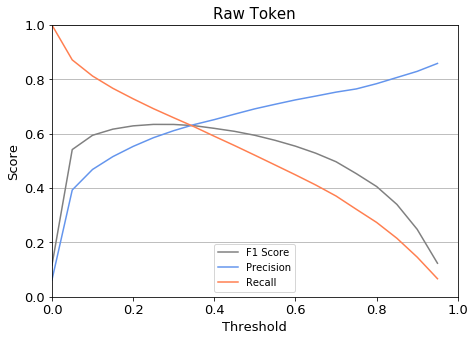

In [46]:
#### Recall, Precision and F1 Score chartfig, ax = plt.subplots(figsize=(16,5))

plt.subplot(121)
sns.lineplot(x=combined_score.index, y=combined_score['F1 Score'], color='grey')
sns.lineplot(x=combined_score.index, y=combined_score['Precision'], color='cornflowerblue')
sns.lineplot(x=combined_score.index, y=combined_score['Recall'], color='coral')
plt.ylim(0, 1)
plt.xlim(0, 1)
# plt.xticks(rotation=45)
plt.title('Raw Token', fontsize=15)
plt.ylabel('Score', fontsize = 13)
plt.yticks(fontsize=13)
plt.xlabel('Threshold', fontsize = 13)
plt.xticks(fontsize=13)
plt.legend(combined_score.columns, loc='lower center')
plt.grid(axis='y')




In [47]:
model.save('./W2VSkipGram')

In [48]:
keras.models.load_model('./W2VSkipGram')

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### FastText CBOW embedding using training data.

In [17]:
%%time
FastText_CBOW = FastText(sentences=X_train_t, size=300, window=5, min_count=5, workers=6, sg=0)

INFO - 09:19:49: collecting all words and their counts
INFO - 09:19:49: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 09:19:49: PROGRESS: at sentence #10000, processed 130140 words, keeping 14738 word types
INFO - 09:19:49: PROGRESS: at sentence #20000, processed 259997 words, keeping 21600 word types
INFO - 09:19:49: PROGRESS: at sentence #30000, processed 389329 words, keeping 26790 word types
INFO - 09:19:49: PROGRESS: at sentence #40000, processed 518014 words, keeping 31120 word types
INFO - 09:19:49: PROGRESS: at sentence #50000, processed 646632 words, keeping 34806 word types
INFO - 09:19:49: PROGRESS: at sentence #60000, processed 775136 words, keeping 38145 word types
INFO - 09:19:49: PROGRESS: at sentence #70000, processed 904057 words, keeping 41267 word types
INFO - 09:19:49: PROGRESS: at sentence #80000, processed 1034004 words, keeping 44155 word types
INFO - 09:19:49: PROGRESS: at sentence #90000, processed 1163059 words, keeping 46939 word ty

INFO - 09:20:50: EPOCH - 1 : training on 13489665 raw words (9706592 effective words) took 48.9s, 198327 effective words/s
INFO - 09:20:52: EPOCH 2 - PROGRESS: at 2.13% examples, 190400 words/s, in_qsize 11, out_qsize 0
INFO - 09:20:53: EPOCH 2 - PROGRESS: at 4.13% examples, 188122 words/s, in_qsize 10, out_qsize 1
INFO - 09:20:54: EPOCH 2 - PROGRESS: at 6.22% examples, 190612 words/s, in_qsize 11, out_qsize 0
INFO - 09:20:55: EPOCH 2 - PROGRESS: at 8.43% examples, 195643 words/s, in_qsize 10, out_qsize 1
INFO - 09:20:56: EPOCH 2 - PROGRESS: at 10.51% examples, 193843 words/s, in_qsize 12, out_qsize 1
INFO - 09:20:57: EPOCH 2 - PROGRESS: at 12.66% examples, 194706 words/s, in_qsize 10, out_qsize 1
INFO - 09:20:58: EPOCH 2 - PROGRESS: at 14.75% examples, 194533 words/s, in_qsize 11, out_qsize 1
INFO - 09:20:59: EPOCH 2 - PROGRESS: at 16.81% examples, 194432 words/s, in_qsize 12, out_qsize 0
INFO - 09:21:00: EPOCH 2 - PROGRESS: at 18.90% examples, 194051 words/s, in_qsize 10, out_qsize 1

INFO - 09:23:27: EPOCH 5 - PROGRESS: at 4.36% examples, 201183 words/s, in_qsize 11, out_qsize 0
INFO - 09:23:28: EPOCH 5 - PROGRESS: at 6.74% examples, 207530 words/s, in_qsize 12, out_qsize 0
INFO - 09:23:29: EPOCH 5 - PROGRESS: at 8.88% examples, 206321 words/s, in_qsize 11, out_qsize 0
INFO - 09:23:30: EPOCH 5 - PROGRESS: at 11.11% examples, 203910 words/s, in_qsize 12, out_qsize 2
INFO - 09:23:31: EPOCH 5 - PROGRESS: at 13.33% examples, 203985 words/s, in_qsize 9, out_qsize 2
INFO - 09:23:32: EPOCH 5 - PROGRESS: at 15.56% examples, 204267 words/s, in_qsize 11, out_qsize 0
INFO - 09:23:33: EPOCH 5 - PROGRESS: at 18.07% examples, 206063 words/s, in_qsize 12, out_qsize 1
INFO - 09:23:34: EPOCH 5 - PROGRESS: at 20.45% examples, 207685 words/s, in_qsize 10, out_qsize 1
INFO - 09:23:35: EPOCH 5 - PROGRESS: at 22.45% examples, 206238 words/s, in_qsize 10, out_qsize 1
INFO - 09:23:37: EPOCH 5 - PROGRESS: at 24.52% examples, 204304 words/s, in_qsize 11, out_qsize 0
INFO - 09:23:38: EPOCH 5

Wall time: 4min 26s


In [18]:
FastText_CBOW.wv.most_similar('nice')

INFO - 09:24:16: precomputing L2-norms of word weight vectors
INFO - 09:24:16: precomputing L2-norms of ngram weight vectors


[("'nice", 0.9046734571456909),
 ('janice', 0.8113627433776855),
 ('venice', 0.7916750311851501),
 ('nicky', 0.7476757764816284),
 ('nicer', 0.745110273361206),
 ('nicely', 0.744707465171814),
 ('nicl', 0.7030104398727417),
 ('nicki', 0.7003128528594971),
 ('nicol', 0.6849815845489502),
 ('nick', 0.6637117862701416)]

In [19]:
# Tunning parameters
MAX_NB_WORDS = 160000
EMBEDDING_DIM = 300
LSTM_UNITS = 100
DROP = 0.2
RE_DROP = 0.2

In [20]:
%%time
embedding_matrix = np.zeros((len(tokenizer.word_index), EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in FastText_CBOW.wv.vocab:
        embedding_matrix[i] = FastText_CBOW.wv.get_vector(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 130051
Wall time: 407 ms


In [21]:
embedding_matrix.shape

(173994, 300)

In [22]:
%%time
#### LSTM## Network architecture
model = Sequential()

model.add(Embedding(173994, EMBEDDING_DIM, weights = [embedding_matrix], input_length=INPUT_LEN)) 
model.add(LSTM(LSTM_UNITS, dropout=DROP, recurrent_dropout=RE_DROP))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_data, y_train, validation_split=0.4, epochs=3)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 626938 samples, validate on 417959 samples
Epoch 1/3


  6176/626938 [..............................] - ETA: 19:54:42 - loss: 0.7309 - acc: 0.562 - ETA: 10:34:52 - loss: 0.6543 - acc: 0.734 - ETA: 7:26:18 - loss: 0.5812 - acc: 0.781 - ETA: 5:53:18 - loss: 0.5115 - acc: 0.82 - ETA: 4:57:04 - loss: 0.4931 - acc: 0.83 - ETA: 4:19:17 - loss: 0.4402 - acc: 0.85 - ETA: 3:52:21 - loss: 0.4214 - acc: 0.86 - ETA: 3:32:24 - loss: 0.4344 - acc: 0.85 - ETA: 3:16:31 - loss: 0.4451 - acc: 0.85 - ETA: 3:03:42 - loss: 0.4150 - acc: 0.86 - ETA: 2:53:28 - loss: 0.3809 - acc: 0.88 - ETA: 2:45:02 - loss: 0.3528 - acc: 0.89 - ETA: 2:37:56 - loss: 0.3382 - acc: 0.89 - ETA: 2:31:52 - loss: 0.3487 - acc: 0.89 - ETA: 2:26:41 - loss: 0.3430 - acc: 0.89 - ETA: 2:21:48 - loss: 0.3370 - acc: 0.90 - ETA: 2:17:35 - loss: 0.3383 - acc: 0.90 - ETA: 2:13:47 - loss: 0.3437 - acc: 0.89 - ETA: 2:10:38 - loss: 0.3324 - acc: 0.90 - ETA: 2:07:30 - loss: 0.3203 - acc: 0.90 - ETA: 2:04:46 - loss: 0.3070 - acc: 0.91 - ETA: 2:02:23 - loss: 0.2953 - acc: 0.91 - ETA: 2:00:14 - loss: 0

 24800/626938 [>.............................] - ETA: 1:13:53 - loss: 0.1695 - acc: 0.94 - ETA: 1:13:53 - loss: 0.1696 - acc: 0.94 - ETA: 1:13:53 - loss: 0.1697 - acc: 0.94 - ETA: 1:13:54 - loss: 0.1700 - acc: 0.94 - ETA: 1:13:55 - loss: 0.1698 - acc: 0.94 - ETA: 1:13:55 - loss: 0.1700 - acc: 0.94 - ETA: 1:13:57 - loss: 0.1702 - acc: 0.94 - ETA: 1:13:58 - loss: 0.1702 - acc: 0.94 - ETA: 1:13:57 - loss: 0.1704 - acc: 0.94 - ETA: 1:13:58 - loss: 0.1703 - acc: 0.94 - ETA: 1:13:58 - loss: 0.1705 - acc: 0.94 - ETA: 1:13:58 - loss: 0.1708 - acc: 0.94 - ETA: 1:13:58 - loss: 0.1708 - acc: 0.94 - ETA: 1:13:58 - loss: 0.1706 - acc: 0.94 - ETA: 1:13:57 - loss: 0.1706 - acc: 0.94 - ETA: 1:13:57 - loss: 0.1704 - acc: 0.94 - ETA: 1:13:56 - loss: 0.1703 - acc: 0.94 - ETA: 1:13:56 - loss: 0.1701 - acc: 0.94 - ETA: 1:13:56 - loss: 0.1701 - acc: 0.94 - ETA: 1:13:55 - loss: 0.1704 - acc: 0.94 - ETA: 1:13:55 - loss: 0.1702 - acc: 0.94 - ETA: 1:13:54 - loss: 0.1702 - acc: 0.94 - ETA: 1:13:54 - loss: 0.1701

 31008/626938 [>.............................] - ETA: 1:12:59 - loss: 0.1630 - acc: 0.94 - ETA: 1:12:58 - loss: 0.1630 - acc: 0.94 - ETA: 1:12:58 - loss: 0.1629 - acc: 0.94 - ETA: 1:12:57 - loss: 0.1629 - acc: 0.94 - ETA: 1:12:57 - loss: 0.1628 - acc: 0.94 - ETA: 1:12:56 - loss: 0.1630 - acc: 0.94 - ETA: 1:12:56 - loss: 0.1628 - acc: 0.94 - ETA: 1:12:56 - loss: 0.1627 - acc: 0.94 - ETA: 1:12:55 - loss: 0.1627 - acc: 0.94 - ETA: 1:12:55 - loss: 0.1626 - acc: 0.94 - ETA: 1:12:55 - loss: 0.1625 - acc: 0.94 - ETA: 1:12:55 - loss: 0.1624 - acc: 0.94 - ETA: 1:12:54 - loss: 0.1623 - acc: 0.94 - ETA: 1:12:54 - loss: 0.1622 - acc: 0.94 - ETA: 1:12:53 - loss: 0.1622 - acc: 0.94 - ETA: 1:12:53 - loss: 0.1622 - acc: 0.94 - ETA: 1:12:52 - loss: 0.1621 - acc: 0.94 - ETA: 1:12:52 - loss: 0.1622 - acc: 0.94 - ETA: 1:12:51 - loss: 0.1620 - acc: 0.94 - ETA: 1:12:51 - loss: 0.1619 - acc: 0.94 - ETA: 1:12:51 - loss: 0.1619 - acc: 0.94 - ETA: 1:12:51 - loss: 0.1618 - acc: 0.94 - ETA: 1:12:50 - loss: 0.1616

 37216/626938 [>.............................] - ETA: 1:11:51 - loss: 0.1575 - acc: 0.94 - ETA: 1:11:51 - loss: 0.1574 - acc: 0.94 - ETA: 1:11:51 - loss: 0.1574 - acc: 0.94 - ETA: 1:11:51 - loss: 0.1573 - acc: 0.94 - ETA: 1:11:51 - loss: 0.1571 - acc: 0.94 - ETA: 1:11:50 - loss: 0.1571 - acc: 0.94 - ETA: 1:11:50 - loss: 0.1574 - acc: 0.94 - ETA: 1:11:49 - loss: 0.1574 - acc: 0.94 - ETA: 1:11:49 - loss: 0.1573 - acc: 0.94 - ETA: 1:11:48 - loss: 0.1573 - acc: 0.94 - ETA: 1:11:48 - loss: 0.1572 - acc: 0.94 - ETA: 1:11:48 - loss: 0.1571 - acc: 0.94 - ETA: 1:11:48 - loss: 0.1571 - acc: 0.94 - ETA: 1:11:47 - loss: 0.1570 - acc: 0.94 - ETA: 1:11:47 - loss: 0.1569 - acc: 0.94 - ETA: 1:11:47 - loss: 0.1569 - acc: 0.94 - ETA: 1:11:47 - loss: 0.1567 - acc: 0.94 - ETA: 1:11:47 - loss: 0.1567 - acc: 0.94 - ETA: 1:11:46 - loss: 0.1567 - acc: 0.94 - ETA: 1:11:46 - loss: 0.1566 - acc: 0.94 - ETA: 1:11:46 - loss: 0.1567 - acc: 0.94 - ETA: 1:11:45 - loss: 0.1568 - acc: 0.94 - ETA: 1:11:45 - loss: 0.1569

 43424/626938 [=>............................] - ETA: 1:10:52 - loss: 0.1541 - acc: 0.94 - ETA: 1:10:52 - loss: 0.1540 - acc: 0.94 - ETA: 1:10:52 - loss: 0.1540 - acc: 0.94 - ETA: 1:10:52 - loss: 0.1540 - acc: 0.94 - ETA: 1:10:51 - loss: 0.1540 - acc: 0.94 - ETA: 1:10:51 - loss: 0.1539 - acc: 0.94 - ETA: 1:10:51 - loss: 0.1538 - acc: 0.94 - ETA: 1:10:51 - loss: 0.1537 - acc: 0.94 - ETA: 1:10:50 - loss: 0.1537 - acc: 0.94 - ETA: 1:10:50 - loss: 0.1537 - acc: 0.94 - ETA: 1:10:50 - loss: 0.1536 - acc: 0.94 - ETA: 1:10:49 - loss: 0.1535 - acc: 0.94 - ETA: 1:10:49 - loss: 0.1535 - acc: 0.94 - ETA: 1:10:48 - loss: 0.1535 - acc: 0.94 - ETA: 1:10:48 - loss: 0.1535 - acc: 0.94 - ETA: 1:10:48 - loss: 0.1534 - acc: 0.94 - ETA: 1:10:48 - loss: 0.1533 - acc: 0.94 - ETA: 1:10:47 - loss: 0.1532 - acc: 0.94 - ETA: 1:10:47 - loss: 0.1532 - acc: 0.94 - ETA: 1:10:47 - loss: 0.1532 - acc: 0.94 - ETA: 1:10:47 - loss: 0.1531 - acc: 0.94 - ETA: 1:10:47 - loss: 0.1530 - acc: 0.94 - ETA: 1:10:47 - loss: 0.1529

 49632/626938 [=>............................] - ETA: 1:10:05 - loss: 0.1512 - acc: 0.94 - ETA: 1:10:05 - loss: 0.1511 - acc: 0.94 - ETA: 1:10:05 - loss: 0.1512 - acc: 0.94 - ETA: 1:10:04 - loss: 0.1512 - acc: 0.94 - ETA: 1:10:04 - loss: 0.1512 - acc: 0.94 - ETA: 1:10:04 - loss: 0.1512 - acc: 0.94 - ETA: 1:10:04 - loss: 0.1512 - acc: 0.94 - ETA: 1:10:04 - loss: 0.1511 - acc: 0.94 - ETA: 1:10:04 - loss: 0.1510 - acc: 0.94 - ETA: 1:10:04 - loss: 0.1510 - acc: 0.94 - ETA: 1:10:04 - loss: 0.1509 - acc: 0.94 - ETA: 1:10:04 - loss: 0.1509 - acc: 0.94 - ETA: 1:10:04 - loss: 0.1510 - acc: 0.94 - ETA: 1:10:04 - loss: 0.1509 - acc: 0.94 - ETA: 1:10:04 - loss: 0.1509 - acc: 0.94 - ETA: 1:10:03 - loss: 0.1509 - acc: 0.94 - ETA: 1:10:03 - loss: 0.1509 - acc: 0.94 - ETA: 1:10:03 - loss: 0.1508 - acc: 0.94 - ETA: 1:10:03 - loss: 0.1508 - acc: 0.94 - ETA: 1:10:03 - loss: 0.1508 - acc: 0.94 - ETA: 1:10:03 - loss: 0.1507 - acc: 0.94 - ETA: 1:10:03 - loss: 0.1507 - acc: 0.94 - ETA: 1:10:03 - loss: 0.1507

 55840/626938 [=>............................] - ETA: 1:09:28 - loss: 0.1492 - acc: 0.94 - ETA: 1:09:27 - loss: 0.1492 - acc: 0.94 - ETA: 1:09:27 - loss: 0.1491 - acc: 0.94 - ETA: 1:09:27 - loss: 0.1492 - acc: 0.94 - ETA: 1:09:26 - loss: 0.1491 - acc: 0.94 - ETA: 1:09:26 - loss: 0.1491 - acc: 0.94 - ETA: 1:09:26 - loss: 0.1491 - acc: 0.94 - ETA: 1:09:26 - loss: 0.1491 - acc: 0.94 - ETA: 1:09:25 - loss: 0.1491 - acc: 0.94 - ETA: 1:09:25 - loss: 0.1490 - acc: 0.94 - ETA: 1:09:25 - loss: 0.1491 - acc: 0.94 - ETA: 1:09:25 - loss: 0.1491 - acc: 0.94 - ETA: 1:09:24 - loss: 0.1490 - acc: 0.94 - ETA: 1:09:24 - loss: 0.1489 - acc: 0.94 - ETA: 1:09:24 - loss: 0.1490 - acc: 0.94 - ETA: 1:09:24 - loss: 0.1490 - acc: 0.94 - ETA: 1:09:23 - loss: 0.1490 - acc: 0.94 - ETA: 1:09:23 - loss: 0.1489 - acc: 0.94 - ETA: 1:09:23 - loss: 0.1489 - acc: 0.94 - ETA: 1:09:22 - loss: 0.1490 - acc: 0.94 - ETA: 1:09:22 - loss: 0.1489 - acc: 0.94 - ETA: 1:09:22 - loss: 0.1488 - acc: 0.94 - ETA: 1:09:21 - loss: 0.1488

 62048/626938 [=>............................] - ETA: 1:08:55 - loss: 0.1486 - acc: 0.94 - ETA: 1:08:54 - loss: 0.1486 - acc: 0.94 - ETA: 1:08:54 - loss: 0.1486 - acc: 0.94 - ETA: 1:08:54 - loss: 0.1486 - acc: 0.94 - ETA: 1:08:54 - loss: 0.1487 - acc: 0.94 - ETA: 1:08:54 - loss: 0.1486 - acc: 0.94 - ETA: 1:08:53 - loss: 0.1485 - acc: 0.94 - ETA: 1:08:53 - loss: 0.1486 - acc: 0.94 - ETA: 1:08:53 - loss: 0.1486 - acc: 0.94 - ETA: 1:08:52 - loss: 0.1486 - acc: 0.94 - ETA: 1:08:52 - loss: 0.1485 - acc: 0.94 - ETA: 1:08:52 - loss: 0.1485 - acc: 0.94 - ETA: 1:08:52 - loss: 0.1485 - acc: 0.94 - ETA: 1:08:51 - loss: 0.1485 - acc: 0.94 - ETA: 1:08:51 - loss: 0.1484 - acc: 0.94 - ETA: 1:08:51 - loss: 0.1484 - acc: 0.94 - ETA: 1:08:51 - loss: 0.1484 - acc: 0.94 - ETA: 1:08:50 - loss: 0.1485 - acc: 0.94 - ETA: 1:08:50 - loss: 0.1486 - acc: 0.94 - ETA: 1:08:50 - loss: 0.1486 - acc: 0.94 - ETA: 1:08:50 - loss: 0.1485 - acc: 0.94 - ETA: 1:08:50 - loss: 0.1485 - acc: 0.94 - ETA: 1:08:50 - loss: 0.1485

 68256/626938 [==>...........................] - ETA: 1:08:28 - loss: 0.1471 - acc: 0.94 - ETA: 1:08:28 - loss: 0.1471 - acc: 0.94 - ETA: 1:08:28 - loss: 0.1472 - acc: 0.94 - ETA: 1:08:28 - loss: 0.1472 - acc: 0.94 - ETA: 1:08:28 - loss: 0.1472 - acc: 0.94 - ETA: 1:08:28 - loss: 0.1471 - acc: 0.94 - ETA: 1:08:27 - loss: 0.1471 - acc: 0.94 - ETA: 1:08:27 - loss: 0.1471 - acc: 0.94 - ETA: 1:08:27 - loss: 0.1471 - acc: 0.94 - ETA: 1:08:27 - loss: 0.1472 - acc: 0.94 - ETA: 1:08:27 - loss: 0.1471 - acc: 0.94 - ETA: 1:08:27 - loss: 0.1472 - acc: 0.94 - ETA: 1:08:26 - loss: 0.1471 - acc: 0.94 - ETA: 1:08:26 - loss: 0.1471 - acc: 0.94 - ETA: 1:08:26 - loss: 0.1471 - acc: 0.94 - ETA: 1:08:25 - loss: 0.1470 - acc: 0.94 - ETA: 1:08:25 - loss: 0.1470 - acc: 0.94 - ETA: 1:08:25 - loss: 0.1471 - acc: 0.94 - ETA: 1:08:25 - loss: 0.1470 - acc: 0.94 - ETA: 1:08:24 - loss: 0.1470 - acc: 0.94 - ETA: 1:08:24 - loss: 0.1470 - acc: 0.94 - ETA: 1:08:24 - loss: 0.1470 - acc: 0.94 - ETA: 1:08:23 - loss: 0.1470

 74464/626938 [==>...........................] - ETA: 1:07:07 - loss: 0.1460 - acc: 0.94 - ETA: 1:07:07 - loss: 0.1461 - acc: 0.94 - ETA: 1:07:06 - loss: 0.1460 - acc: 0.94 - ETA: 1:07:06 - loss: 0.1461 - acc: 0.94 - ETA: 1:07:06 - loss: 0.1461 - acc: 0.94 - ETA: 1:07:05 - loss: 0.1461 - acc: 0.94 - ETA: 1:07:04 - loss: 0.1461 - acc: 0.94 - ETA: 1:07:04 - loss: 0.1460 - acc: 0.94 - ETA: 1:07:03 - loss: 0.1462 - acc: 0.94 - ETA: 1:07:03 - loss: 0.1461 - acc: 0.94 - ETA: 1:07:03 - loss: 0.1461 - acc: 0.94 - ETA: 1:07:02 - loss: 0.1461 - acc: 0.94 - ETA: 1:07:02 - loss: 0.1461 - acc: 0.94 - ETA: 1:07:01 - loss: 0.1461 - acc: 0.94 - ETA: 1:07:01 - loss: 0.1460 - acc: 0.94 - ETA: 1:07:00 - loss: 0.1460 - acc: 0.94 - ETA: 1:06:59 - loss: 0.1460 - acc: 0.94 - ETA: 1:06:59 - loss: 0.1461 - acc: 0.94 - ETA: 1:06:59 - loss: 0.1460 - acc: 0.94 - ETA: 1:06:58 - loss: 0.1460 - acc: 0.94 - ETA: 1:06:58 - loss: 0.1460 - acc: 0.94 - ETA: 1:06:57 - loss: 0.1460 - acc: 0.94 - ETA: 1:06:57 - loss: 0.1459

 80672/626938 [==>...........................] - ETA: 1:05:44 - loss: 0.1454 - acc: 0.94 - ETA: 1:05:44 - loss: 0.1454 - acc: 0.94 - ETA: 1:05:44 - loss: 0.1454 - acc: 0.94 - ETA: 1:05:44 - loss: 0.1454 - acc: 0.94 - ETA: 1:05:43 - loss: 0.1453 - acc: 0.94 - ETA: 1:05:43 - loss: 0.1453 - acc: 0.94 - ETA: 1:05:43 - loss: 0.1453 - acc: 0.94 - ETA: 1:05:43 - loss: 0.1453 - acc: 0.94 - ETA: 1:05:44 - loss: 0.1453 - acc: 0.94 - ETA: 1:05:43 - loss: 0.1453 - acc: 0.94 - ETA: 1:05:43 - loss: 0.1453 - acc: 0.94 - ETA: 1:05:42 - loss: 0.1454 - acc: 0.94 - ETA: 1:05:42 - loss: 0.1454 - acc: 0.94 - ETA: 1:05:42 - loss: 0.1453 - acc: 0.94 - ETA: 1:05:41 - loss: 0.1453 - acc: 0.94 - ETA: 1:05:41 - loss: 0.1453 - acc: 0.94 - ETA: 1:05:41 - loss: 0.1452 - acc: 0.94 - ETA: 1:05:40 - loss: 0.1453 - acc: 0.94 - ETA: 1:05:40 - loss: 0.1453 - acc: 0.94 - ETA: 1:05:39 - loss: 0.1454 - acc: 0.94 - ETA: 1:05:39 - loss: 0.1454 - acc: 0.94 - ETA: 1:05:38 - loss: 0.1453 - acc: 0.94 - ETA: 1:05:38 - loss: 0.1453

 86880/626938 [===>..........................] - ETA: 1:04:41 - loss: 0.1440 - acc: 0.94 - ETA: 1:04:40 - loss: 0.1440 - acc: 0.94 - ETA: 1:04:40 - loss: 0.1441 - acc: 0.94 - ETA: 1:04:40 - loss: 0.1440 - acc: 0.94 - ETA: 1:04:39 - loss: 0.1440 - acc: 0.94 - ETA: 1:04:39 - loss: 0.1441 - acc: 0.94 - ETA: 1:04:39 - loss: 0.1442 - acc: 0.94 - ETA: 1:04:38 - loss: 0.1442 - acc: 0.94 - ETA: 1:04:38 - loss: 0.1443 - acc: 0.94 - ETA: 1:04:37 - loss: 0.1443 - acc: 0.94 - ETA: 1:04:37 - loss: 0.1444 - acc: 0.94 - ETA: 1:04:37 - loss: 0.1444 - acc: 0.94 - ETA: 1:04:36 - loss: 0.1444 - acc: 0.94 - ETA: 1:04:36 - loss: 0.1444 - acc: 0.94 - ETA: 1:04:36 - loss: 0.1444 - acc: 0.94 - ETA: 1:04:35 - loss: 0.1444 - acc: 0.94 - ETA: 1:04:35 - loss: 0.1444 - acc: 0.94 - ETA: 1:04:35 - loss: 0.1444 - acc: 0.94 - ETA: 1:04:35 - loss: 0.1444 - acc: 0.94 - ETA: 1:04:35 - loss: 0.1444 - acc: 0.94 - ETA: 1:04:35 - loss: 0.1444 - acc: 0.94 - ETA: 1:04:35 - loss: 0.1444 - acc: 0.94 - ETA: 1:04:34 - loss: 0.1444

 93088/626938 [===>..........................] - ETA: 1:03:37 - loss: 0.1441 - acc: 0.94 - ETA: 1:03:37 - loss: 0.1441 - acc: 0.94 - ETA: 1:03:37 - loss: 0.1441 - acc: 0.94 - ETA: 1:03:36 - loss: 0.1440 - acc: 0.94 - ETA: 1:03:36 - loss: 0.1440 - acc: 0.94 - ETA: 1:03:36 - loss: 0.1441 - acc: 0.94 - ETA: 1:03:35 - loss: 0.1440 - acc: 0.94 - ETA: 1:03:35 - loss: 0.1440 - acc: 0.94 - ETA: 1:03:35 - loss: 0.1441 - acc: 0.94 - ETA: 1:03:34 - loss: 0.1440 - acc: 0.94 - ETA: 1:03:34 - loss: 0.1440 - acc: 0.94 - ETA: 1:03:34 - loss: 0.1440 - acc: 0.94 - ETA: 1:03:33 - loss: 0.1441 - acc: 0.94 - ETA: 1:03:33 - loss: 0.1441 - acc: 0.94 - ETA: 1:03:33 - loss: 0.1441 - acc: 0.94 - ETA: 1:03:33 - loss: 0.1441 - acc: 0.94 - ETA: 1:03:32 - loss: 0.1441 - acc: 0.94 - ETA: 1:03:32 - loss: 0.1441 - acc: 0.94 - ETA: 1:03:32 - loss: 0.1441 - acc: 0.94 - ETA: 1:03:31 - loss: 0.1441 - acc: 0.94 - ETA: 1:03:31 - loss: 0.1441 - acc: 0.94 - ETA: 1:03:31 - loss: 0.1441 - acc: 0.94 - ETA: 1:03:30 - loss: 0.1441

 99296/626938 [===>..........................] - ETA: 1:02:41 - loss: 0.1434 - acc: 0.94 - ETA: 1:02:41 - loss: 0.1434 - acc: 0.94 - ETA: 1:02:40 - loss: 0.1434 - acc: 0.94 - ETA: 1:02:40 - loss: 0.1434 - acc: 0.94 - ETA: 1:02:40 - loss: 0.1433 - acc: 0.94 - ETA: 1:02:40 - loss: 0.1433 - acc: 0.94 - ETA: 1:02:39 - loss: 0.1433 - acc: 0.94 - ETA: 1:02:39 - loss: 0.1433 - acc: 0.94 - ETA: 1:02:39 - loss: 0.1433 - acc: 0.94 - ETA: 1:02:38 - loss: 0.1433 - acc: 0.94 - ETA: 1:02:38 - loss: 0.1433 - acc: 0.94 - ETA: 1:02:38 - loss: 0.1433 - acc: 0.94 - ETA: 1:02:37 - loss: 0.1433 - acc: 0.94 - ETA: 1:02:37 - loss: 0.1433 - acc: 0.94 - ETA: 1:02:36 - loss: 0.1433 - acc: 0.94 - ETA: 1:02:36 - loss: 0.1433 - acc: 0.94 - ETA: 1:02:36 - loss: 0.1433 - acc: 0.94 - ETA: 1:02:36 - loss: 0.1433 - acc: 0.94 - ETA: 1:02:35 - loss: 0.1433 - acc: 0.94 - ETA: 1:02:35 - loss: 0.1432 - acc: 0.94 - ETA: 1:02:34 - loss: 0.1433 - acc: 0.94 - ETA: 1:02:34 - loss: 0.1432 - acc: 0.94 - ETA: 1:02:34 - loss: 0.1432

105504/626938 [====>.........................] - ETA: 1:01:37 - loss: 0.1428 - acc: 0.94 - ETA: 1:01:36 - loss: 0.1429 - acc: 0.94 - ETA: 1:01:36 - loss: 0.1429 - acc: 0.94 - ETA: 1:01:35 - loss: 0.1429 - acc: 0.94 - ETA: 1:01:35 - loss: 0.1429 - acc: 0.94 - ETA: 1:01:35 - loss: 0.1428 - acc: 0.94 - ETA: 1:01:34 - loss: 0.1429 - acc: 0.94 - ETA: 1:01:34 - loss: 0.1428 - acc: 0.94 - ETA: 1:01:34 - loss: 0.1429 - acc: 0.94 - ETA: 1:01:33 - loss: 0.1430 - acc: 0.94 - ETA: 1:01:33 - loss: 0.1429 - acc: 0.94 - ETA: 1:01:33 - loss: 0.1429 - acc: 0.94 - ETA: 1:01:32 - loss: 0.1429 - acc: 0.94 - ETA: 1:01:32 - loss: 0.1429 - acc: 0.94 - ETA: 1:01:31 - loss: 0.1428 - acc: 0.94 - ETA: 1:01:31 - loss: 0.1429 - acc: 0.94 - ETA: 1:01:31 - loss: 0.1428 - acc: 0.94 - ETA: 1:01:30 - loss: 0.1429 - acc: 0.94 - ETA: 1:01:30 - loss: 0.1429 - acc: 0.94 - ETA: 1:01:30 - loss: 0.1429 - acc: 0.94 - ETA: 1:01:29 - loss: 0.1429 - acc: 0.94 - ETA: 1:01:29 - loss: 0.1428 - acc: 0.94 - ETA: 1:01:28 - loss: 0.1428

111904/626938 [====>.........................] - ETA: 1:00:29 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:28 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:28 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:28 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:27 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:27 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:27 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:26 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:26 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:26 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:25 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:25 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:25 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:25 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:24 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:24 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:24 - loss: 0.1424 - acc: 0.94 - ETA: 1:00:23 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:23 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:22 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:22 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:22 - loss: 0.1423 - acc: 0.94 - ETA: 1:00:21 - loss: 0.1423

118432/626938 [====>.........................] - ETA: 59:25 - loss: 0.1418 - acc: 0.94 - ETA: 59:25 - loss: 0.1418 - acc: 0.94 - ETA: 59:25 - loss: 0.1418 - acc: 0.94 - ETA: 59:24 - loss: 0.1418 - acc: 0.94 - ETA: 59:24 - loss: 0.1418 - acc: 0.94 - ETA: 59:24 - loss: 0.1417 - acc: 0.94 - ETA: 59:24 - loss: 0.1417 - acc: 0.94 - ETA: 59:23 - loss: 0.1418 - acc: 0.94 - ETA: 59:23 - loss: 0.1419 - acc: 0.94 - ETA: 59:23 - loss: 0.1419 - acc: 0.94 - ETA: 59:22 - loss: 0.1419 - acc: 0.94 - ETA: 59:22 - loss: 0.1419 - acc: 0.94 - ETA: 59:22 - loss: 0.1419 - acc: 0.94 - ETA: 59:21 - loss: 0.1419 - acc: 0.94 - ETA: 59:21 - loss: 0.1419 - acc: 0.94 - ETA: 59:21 - loss: 0.1419 - acc: 0.94 - ETA: 59:20 - loss: 0.1419 - acc: 0.94 - ETA: 59:20 - loss: 0.1419 - acc: 0.94 - ETA: 59:20 - loss: 0.1419 - acc: 0.94 - ETA: 59:19 - loss: 0.1419 - acc: 0.94 - ETA: 59:19 - loss: 0.1419 - acc: 0.94 - ETA: 59:19 - loss: 0.1419 - acc: 0.94 - ETA: 59:18 - loss: 0.1419 - acc: 0.94 - ETA: 59:18 - loss: 0.1419 - acc

124960/626938 [====>.........................] - ETA: 58:25 - loss: 0.1411 - acc: 0.94 - ETA: 58:25 - loss: 0.1410 - acc: 0.94 - ETA: 58:24 - loss: 0.1410 - acc: 0.94 - ETA: 58:24 - loss: 0.1410 - acc: 0.94 - ETA: 58:24 - loss: 0.1410 - acc: 0.94 - ETA: 58:24 - loss: 0.1410 - acc: 0.94 - ETA: 58:23 - loss: 0.1411 - acc: 0.94 - ETA: 58:23 - loss: 0.1410 - acc: 0.94 - ETA: 58:23 - loss: 0.1410 - acc: 0.94 - ETA: 58:23 - loss: 0.1410 - acc: 0.94 - ETA: 58:22 - loss: 0.1410 - acc: 0.94 - ETA: 58:22 - loss: 0.1410 - acc: 0.94 - ETA: 58:22 - loss: 0.1410 - acc: 0.94 - ETA: 58:22 - loss: 0.1410 - acc: 0.94 - ETA: 58:21 - loss: 0.1410 - acc: 0.94 - ETA: 58:21 - loss: 0.1411 - acc: 0.94 - ETA: 58:21 - loss: 0.1411 - acc: 0.94 - ETA: 58:20 - loss: 0.1411 - acc: 0.94 - ETA: 58:20 - loss: 0.1411 - acc: 0.94 - ETA: 58:20 - loss: 0.1411 - acc: 0.94 - ETA: 58:20 - loss: 0.1411 - acc: 0.94 - ETA: 58:20 - loss: 0.1411 - acc: 0.94 - ETA: 58:19 - loss: 0.1411 - acc: 0.94 - ETA: 58:19 - loss: 0.1410 - acc

131488/626938 [=====>........................] - ETA: 57:26 - loss: 0.1404 - acc: 0.94 - ETA: 57:25 - loss: 0.1404 - acc: 0.94 - ETA: 57:25 - loss: 0.1404 - acc: 0.94 - ETA: 57:25 - loss: 0.1404 - acc: 0.94 - ETA: 57:24 - loss: 0.1404 - acc: 0.94 - ETA: 57:24 - loss: 0.1404 - acc: 0.94 - ETA: 57:24 - loss: 0.1404 - acc: 0.94 - ETA: 57:24 - loss: 0.1404 - acc: 0.94 - ETA: 57:23 - loss: 0.1404 - acc: 0.94 - ETA: 57:23 - loss: 0.1404 - acc: 0.94 - ETA: 57:23 - loss: 0.1405 - acc: 0.94 - ETA: 57:23 - loss: 0.1405 - acc: 0.94 - ETA: 57:22 - loss: 0.1405 - acc: 0.94 - ETA: 57:22 - loss: 0.1405 - acc: 0.94 - ETA: 57:22 - loss: 0.1405 - acc: 0.94 - ETA: 57:21 - loss: 0.1405 - acc: 0.94 - ETA: 57:21 - loss: 0.1405 - acc: 0.94 - ETA: 57:21 - loss: 0.1404 - acc: 0.94 - ETA: 57:21 - loss: 0.1404 - acc: 0.94 - ETA: 57:20 - loss: 0.1404 - acc: 0.94 - ETA: 57:20 - loss: 0.1404 - acc: 0.94 - ETA: 57:20 - loss: 0.1404 - acc: 0.94 - ETA: 57:19 - loss: 0.1404 - acc: 0.94 - ETA: 57:19 - loss: 0.1404 - acc

137856/626938 [=====>........................] - ETA: 56:28 - loss: 0.1401 - acc: 0.94 - ETA: 56:28 - loss: 0.1401 - acc: 0.94 - ETA: 56:27 - loss: 0.1401 - acc: 0.94 - ETA: 56:27 - loss: 0.1401 - acc: 0.94 - ETA: 56:27 - loss: 0.1401 - acc: 0.94 - ETA: 56:27 - loss: 0.1401 - acc: 0.94 - ETA: 56:26 - loss: 0.1401 - acc: 0.94 - ETA: 56:26 - loss: 0.1401 - acc: 0.94 - ETA: 56:26 - loss: 0.1401 - acc: 0.94 - ETA: 56:26 - loss: 0.1401 - acc: 0.94 - ETA: 56:25 - loss: 0.1401 - acc: 0.94 - ETA: 56:25 - loss: 0.1402 - acc: 0.94 - ETA: 56:25 - loss: 0.1401 - acc: 0.94 - ETA: 56:25 - loss: 0.1401 - acc: 0.94 - ETA: 56:24 - loss: 0.1401 - acc: 0.94 - ETA: 56:24 - loss: 0.1401 - acc: 0.94 - ETA: 56:24 - loss: 0.1401 - acc: 0.94 - ETA: 56:24 - loss: 0.1401 - acc: 0.94 - ETA: 56:23 - loss: 0.1401 - acc: 0.94 - ETA: 56:23 - loss: 0.1401 - acc: 0.94 - ETA: 56:23 - loss: 0.1401 - acc: 0.94 - ETA: 56:23 - loss: 0.1401 - acc: 0.94 - ETA: 56:22 - loss: 0.1401 - acc: 0.94 - ETA: 56:22 - loss: 0.1401 - acc

144064/626938 [=====>........................] - ETA: 1:21:34 - loss: 0.1398 - acc: 0.94 - ETA: 1:21:34 - loss: 0.1398 - acc: 0.94 - ETA: 1:21:34 - loss: 0.1398 - acc: 0.94 - ETA: 1:21:33 - loss: 0.1398 - acc: 0.94 - ETA: 1:21:32 - loss: 0.1398 - acc: 0.94 - ETA: 1:21:32 - loss: 0.1398 - acc: 0.94 - ETA: 1:21:31 - loss: 0.1398 - acc: 0.94 - ETA: 1:21:31 - loss: 0.1398 - acc: 0.94 - ETA: 1:21:30 - loss: 0.1398 - acc: 0.94 - ETA: 1:21:29 - loss: 0.1397 - acc: 0.94 - ETA: 1:21:29 - loss: 0.1397 - acc: 0.94 - ETA: 1:21:28 - loss: 0.1397 - acc: 0.94 - ETA: 1:21:27 - loss: 0.1397 - acc: 0.94 - ETA: 1:21:27 - loss: 0.1397 - acc: 0.94 - ETA: 1:21:26 - loss: 0.1397 - acc: 0.94 - ETA: 1:21:25 - loss: 0.1397 - acc: 0.94 - ETA: 1:21:24 - loss: 0.1397 - acc: 0.94 - ETA: 1:21:24 - loss: 0.1397 - acc: 0.94 - ETA: 1:21:23 - loss: 0.1397 - acc: 0.94 - ETA: 1:21:22 - loss: 0.1397 - acc: 0.94 - ETA: 1:21:22 - loss: 0.1397 - acc: 0.94 - ETA: 1:21:21 - loss: 0.1397 - acc: 0.94 - ETA: 1:21:20 - loss: 0.1396

150272/626938 [======>.......................] - ETA: 1:19:19 - loss: 0.1388 - acc: 0.94 - ETA: 1:19:19 - loss: 0.1388 - acc: 0.94 - ETA: 1:19:18 - loss: 0.1388 - acc: 0.94 - ETA: 1:19:17 - loss: 0.1388 - acc: 0.94 - ETA: 1:19:16 - loss: 0.1388 - acc: 0.94 - ETA: 1:19:16 - loss: 0.1388 - acc: 0.94 - ETA: 1:19:15 - loss: 0.1388 - acc: 0.94 - ETA: 1:19:14 - loss: 0.1388 - acc: 0.94 - ETA: 1:19:14 - loss: 0.1388 - acc: 0.94 - ETA: 1:19:13 - loss: 0.1387 - acc: 0.94 - ETA: 1:19:13 - loss: 0.1388 - acc: 0.94 - ETA: 1:19:12 - loss: 0.1388 - acc: 0.94 - ETA: 1:19:11 - loss: 0.1388 - acc: 0.94 - ETA: 1:19:10 - loss: 0.1388 - acc: 0.94 - ETA: 1:19:10 - loss: 0.1388 - acc: 0.94 - ETA: 1:19:09 - loss: 0.1388 - acc: 0.94 - ETA: 1:19:08 - loss: 0.1388 - acc: 0.94 - ETA: 1:19:08 - loss: 0.1387 - acc: 0.94 - ETA: 1:19:07 - loss: 0.1387 - acc: 0.94 - ETA: 1:19:06 - loss: 0.1387 - acc: 0.94 - ETA: 1:19:06 - loss: 0.1387 - acc: 0.94 - ETA: 1:19:05 - loss: 0.1387 - acc: 0.94 - ETA: 1:19:04 - loss: 0.1387

156480/626938 [======>.......................] - ETA: 1:17:10 - loss: 0.1379 - acc: 0.94 - ETA: 1:17:09 - loss: 0.1379 - acc: 0.94 - ETA: 1:17:08 - loss: 0.1379 - acc: 0.94 - ETA: 1:17:08 - loss: 0.1379 - acc: 0.94 - ETA: 1:17:07 - loss: 0.1379 - acc: 0.94 - ETA: 1:17:07 - loss: 0.1379 - acc: 0.94 - ETA: 1:17:06 - loss: 0.1379 - acc: 0.94 - ETA: 1:17:05 - loss: 0.1379 - acc: 0.94 - ETA: 1:17:04 - loss: 0.1379 - acc: 0.94 - ETA: 1:17:04 - loss: 0.1379 - acc: 0.94 - ETA: 1:17:03 - loss: 0.1379 - acc: 0.94 - ETA: 1:17:03 - loss: 0.1379 - acc: 0.94 - ETA: 1:17:02 - loss: 0.1379 - acc: 0.94 - ETA: 1:17:01 - loss: 0.1379 - acc: 0.94 - ETA: 1:17:01 - loss: 0.1380 - acc: 0.94 - ETA: 1:17:00 - loss: 0.1380 - acc: 0.94 - ETA: 1:16:59 - loss: 0.1379 - acc: 0.94 - ETA: 1:16:59 - loss: 0.1379 - acc: 0.94 - ETA: 1:16:58 - loss: 0.1379 - acc: 0.94 - ETA: 1:16:57 - loss: 0.1379 - acc: 0.94 - ETA: 1:16:57 - loss: 0.1379 - acc: 0.94 - ETA: 1:16:56 - loss: 0.1379 - acc: 0.94 - ETA: 1:16:56 - loss: 0.1379

162688/626938 [======>.......................] - ETA: 1:15:06 - loss: 0.1375 - acc: 0.94 - ETA: 1:15:06 - loss: 0.1375 - acc: 0.94 - ETA: 1:15:05 - loss: 0.1375 - acc: 0.94 - ETA: 1:15:05 - loss: 0.1374 - acc: 0.94 - ETA: 1:15:04 - loss: 0.1374 - acc: 0.94 - ETA: 1:15:03 - loss: 0.1374 - acc: 0.94 - ETA: 1:15:03 - loss: 0.1374 - acc: 0.94 - ETA: 1:15:02 - loss: 0.1374 - acc: 0.94 - ETA: 1:15:01 - loss: 0.1374 - acc: 0.94 - ETA: 1:15:01 - loss: 0.1374 - acc: 0.94 - ETA: 1:15:00 - loss: 0.1374 - acc: 0.94 - ETA: 1:15:00 - loss: 0.1375 - acc: 0.94 - ETA: 1:14:59 - loss: 0.1375 - acc: 0.94 - ETA: 1:14:58 - loss: 0.1375 - acc: 0.94 - ETA: 1:14:58 - loss: 0.1375 - acc: 0.94 - ETA: 1:14:57 - loss: 0.1374 - acc: 0.94 - ETA: 1:14:56 - loss: 0.1374 - acc: 0.94 - ETA: 1:14:56 - loss: 0.1374 - acc: 0.94 - ETA: 1:14:55 - loss: 0.1375 - acc: 0.94 - ETA: 1:14:55 - loss: 0.1375 - acc: 0.94 - ETA: 1:14:54 - loss: 0.1375 - acc: 0.94 - ETA: 1:14:53 - loss: 0.1375 - acc: 0.94 - ETA: 1:14:53 - loss: 0.1375

168896/626938 [=======>......................] - ETA: 1:13:17 - loss: 0.1373 - acc: 0.94 - ETA: 1:13:16 - loss: 0.1373 - acc: 0.94 - ETA: 1:13:16 - loss: 0.1373 - acc: 0.94 - ETA: 1:13:15 - loss: 0.1373 - acc: 0.94 - ETA: 1:13:15 - loss: 0.1373 - acc: 0.94 - ETA: 1:13:14 - loss: 0.1373 - acc: 0.94 - ETA: 1:13:14 - loss: 0.1373 - acc: 0.94 - ETA: 1:13:13 - loss: 0.1373 - acc: 0.94 - ETA: 1:13:13 - loss: 0.1373 - acc: 0.94 - ETA: 1:13:12 - loss: 0.1373 - acc: 0.94 - ETA: 1:13:12 - loss: 0.1373 - acc: 0.94 - ETA: 1:13:11 - loss: 0.1373 - acc: 0.94 - ETA: 1:13:11 - loss: 0.1372 - acc: 0.94 - ETA: 1:13:10 - loss: 0.1373 - acc: 0.94 - ETA: 1:13:10 - loss: 0.1372 - acc: 0.94 - ETA: 1:13:09 - loss: 0.1373 - acc: 0.94 - ETA: 1:13:09 - loss: 0.1373 - acc: 0.94 - ETA: 1:13:08 - loss: 0.1373 - acc: 0.94 - ETA: 1:13:08 - loss: 0.1372 - acc: 0.94 - ETA: 1:13:08 - loss: 0.1372 - acc: 0.94 - ETA: 1:13:07 - loss: 0.1373 - acc: 0.94 - ETA: 1:13:06 - loss: 0.1373 - acc: 0.94 - ETA: 1:13:06 - loss: 0.1373

175104/626938 [=======>......................] - ETA: 1:11:32 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:31 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:30 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:30 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:29 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:29 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:28 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:28 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:27 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:27 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:26 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:26 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:25 - loss: 0.1367 - acc: 0.94 - ETA: 1:11:24 - loss: 0.1367 - acc: 0.94 - ETA: 1:11:24 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:23 - loss: 0.1367 - acc: 0.94 - ETA: 1:11:23 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:22 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:22 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:21 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:21 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:20 - loss: 0.1368 - acc: 0.94 - ETA: 1:11:20 - loss: 0.1368

181312/626938 [=======>......................] - ETA: 1:09:46 - loss: 0.1365 - acc: 0.94 - ETA: 1:09:45 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:45 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:44 - loss: 0.1365 - acc: 0.94 - ETA: 1:09:44 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:43 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:43 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:42 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:41 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:41 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:40 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:40 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:39 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:39 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:38 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:38 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:37 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:36 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:36 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:35 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:35 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:34 - loss: 0.1366 - acc: 0.94 - ETA: 1:09:34 - loss: 0.1366

187520/626938 [=======>......................] - ETA: 1:08:03 - loss: 0.1366 - acc: 0.94 - ETA: 1:08:03 - loss: 0.1366 - acc: 0.94 - ETA: 1:08:02 - loss: 0.1366 - acc: 0.94 - ETA: 1:08:02 - loss: 0.1366 - acc: 0.94 - ETA: 1:08:01 - loss: 0.1366 - acc: 0.94 - ETA: 1:08:01 - loss: 0.1366 - acc: 0.94 - ETA: 1:08:00 - loss: 0.1366 - acc: 0.94 - ETA: 1:08:00 - loss: 0.1366 - acc: 0.94 - ETA: 1:07:59 - loss: 0.1366 - acc: 0.94 - ETA: 1:07:59 - loss: 0.1366 - acc: 0.94 - ETA: 1:07:59 - loss: 0.1366 - acc: 0.94 - ETA: 1:07:58 - loss: 0.1366 - acc: 0.94 - ETA: 1:07:57 - loss: 0.1366 - acc: 0.94 - ETA: 1:07:57 - loss: 0.1366 - acc: 0.94 - ETA: 1:07:57 - loss: 0.1366 - acc: 0.94 - ETA: 1:07:56 - loss: 0.1366 - acc: 0.94 - ETA: 1:07:56 - loss: 0.1366 - acc: 0.94 - ETA: 1:07:55 - loss: 0.1366 - acc: 0.94 - ETA: 1:07:54 - loss: 0.1367 - acc: 0.94 - ETA: 1:07:54 - loss: 0.1367 - acc: 0.94 - ETA: 1:07:53 - loss: 0.1367 - acc: 0.94 - ETA: 1:07:53 - loss: 0.1367 - acc: 0.94 - ETA: 1:07:53 - loss: 0.1367

193728/626938 [========>.....................] - ETA: 1:06:30 - loss: 0.1361 - acc: 0.94 - ETA: 1:06:29 - loss: 0.1361 - acc: 0.94 - ETA: 1:06:29 - loss: 0.1362 - acc: 0.94 - ETA: 1:06:28 - loss: 0.1361 - acc: 0.94 - ETA: 1:06:28 - loss: 0.1361 - acc: 0.94 - ETA: 1:06:27 - loss: 0.1361 - acc: 0.94 - ETA: 1:06:26 - loss: 0.1361 - acc: 0.94 - ETA: 1:06:26 - loss: 0.1362 - acc: 0.94 - ETA: 1:06:25 - loss: 0.1361 - acc: 0.94 - ETA: 1:06:25 - loss: 0.1362 - acc: 0.94 - ETA: 1:06:24 - loss: 0.1362 - acc: 0.94 - ETA: 1:06:24 - loss: 0.1362 - acc: 0.94 - ETA: 1:06:23 - loss: 0.1361 - acc: 0.94 - ETA: 1:06:23 - loss: 0.1361 - acc: 0.94 - ETA: 1:06:22 - loss: 0.1361 - acc: 0.94 - ETA: 1:06:22 - loss: 0.1361 - acc: 0.94 - ETA: 1:06:21 - loss: 0.1361 - acc: 0.94 - ETA: 1:06:21 - loss: 0.1361 - acc: 0.94 - ETA: 1:06:20 - loss: 0.1361 - acc: 0.94 - ETA: 1:06:20 - loss: 0.1362 - acc: 0.94 - ETA: 1:06:19 - loss: 0.1362 - acc: 0.94 - ETA: 1:06:19 - loss: 0.1362 - acc: 0.94 - ETA: 1:06:18 - loss: 0.1362

199936/626938 [========>.....................] - ETA: 1:04:54 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:54 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:53 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:53 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:52 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:52 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:51 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:51 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:51 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:50 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:50 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:49 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:49 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:48 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:48 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:47 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:47 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:46 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:46 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:45 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:45 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:44 - loss: 0.1359 - acc: 0.94 - ETA: 1:04:44 - loss: 0.1359

206144/626938 [========>.....................] - ETA: 1:03:23 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:23 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:22 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:22 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:21 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:21 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:20 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:20 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:19 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:19 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:18 - loss: 0.1354 - acc: 0.94 - ETA: 1:03:18 - loss: 0.1354 - acc: 0.94 - ETA: 1:03:17 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:17 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:16 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:16 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:16 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:15 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:15 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:14 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:14 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:13 - loss: 0.1353 - acc: 0.94 - ETA: 1:03:13 - loss: 0.1353

212352/626938 [=========>....................] - ETA: 1:01:54 - loss: 0.1349 - acc: 0.94 - ETA: 1:01:54 - loss: 0.1349 - acc: 0.94 - ETA: 1:01:53 - loss: 0.1349 - acc: 0.94 - ETA: 1:01:53 - loss: 0.1349 - acc: 0.94 - ETA: 1:01:52 - loss: 0.1349 - acc: 0.94 - ETA: 1:01:52 - loss: 0.1349 - acc: 0.94 - ETA: 1:01:52 - loss: 0.1349 - acc: 0.94 - ETA: 1:01:51 - loss: 0.1349 - acc: 0.94 - ETA: 1:01:51 - loss: 0.1349 - acc: 0.94 - ETA: 1:01:50 - loss: 0.1349 - acc: 0.94 - ETA: 1:01:50 - loss: 0.1349 - acc: 0.94 - ETA: 1:01:49 - loss: 0.1349 - acc: 0.94 - ETA: 1:01:49 - loss: 0.1349 - acc: 0.94 - ETA: 1:01:48 - loss: 0.1349 - acc: 0.94 - ETA: 1:01:48 - loss: 0.1349 - acc: 0.94 - ETA: 1:01:47 - loss: 0.1349 - acc: 0.94 - ETA: 1:01:47 - loss: 0.1348 - acc: 0.94 - ETA: 1:01:47 - loss: 0.1348 - acc: 0.94 - ETA: 1:01:46 - loss: 0.1348 - acc: 0.94 - ETA: 1:01:46 - loss: 0.1348 - acc: 0.94 - ETA: 1:01:45 - loss: 0.1348 - acc: 0.94 - ETA: 1:01:45 - loss: 0.1348 - acc: 0.94 - ETA: 1:01:44 - loss: 0.1348

218784/626938 [=========>....................] - ETA: 1:00:29 - loss: 0.1346 - acc: 0.94 - ETA: 1:00:28 - loss: 0.1346 - acc: 0.94 - ETA: 1:00:28 - loss: 0.1346 - acc: 0.94 - ETA: 1:00:27 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:27 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:26 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:26 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:25 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:25 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:25 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:24 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:24 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:23 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:23 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:22 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:22 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:21 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:21 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:21 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:20 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:20 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:19 - loss: 0.1345 - acc: 0.94 - ETA: 1:00:19 - loss: 0.1345

225312/626938 [=========>....................] - ETA: 59:04 - loss: 0.1341 - acc: 0.94 - ETA: 59:03 - loss: 0.1341 - acc: 0.94 - ETA: 59:03 - loss: 0.1341 - acc: 0.94 - ETA: 59:03 - loss: 0.1341 - acc: 0.94 - ETA: 59:02 - loss: 0.1341 - acc: 0.94 - ETA: 59:02 - loss: 0.1341 - acc: 0.94 - ETA: 59:01 - loss: 0.1341 - acc: 0.94 - ETA: 59:01 - loss: 0.1341 - acc: 0.94 - ETA: 59:00 - loss: 0.1341 - acc: 0.94 - ETA: 59:00 - loss: 0.1341 - acc: 0.94 - ETA: 59:00 - loss: 0.1341 - acc: 0.94 - ETA: 58:59 - loss: 0.1341 - acc: 0.94 - ETA: 58:59 - loss: 0.1341 - acc: 0.94 - ETA: 58:58 - loss: 0.1341 - acc: 0.94 - ETA: 58:58 - loss: 0.1341 - acc: 0.94 - ETA: 58:58 - loss: 0.1341 - acc: 0.94 - ETA: 58:57 - loss: 0.1341 - acc: 0.94 - ETA: 58:57 - loss: 0.1341 - acc: 0.94 - ETA: 58:56 - loss: 0.1341 - acc: 0.94 - ETA: 58:56 - loss: 0.1341 - acc: 0.94 - ETA: 58:55 - loss: 0.1341 - acc: 0.94 - ETA: 58:55 - loss: 0.1341 - acc: 0.94 - ETA: 58:55 - loss: 0.1341 - acc: 0.94 - ETA: 58:54 - loss: 0.1341 - acc

231840/626938 [==========>...................] - ETA: 57:42 - loss: 0.1338 - acc: 0.94 - ETA: 57:41 - loss: 0.1338 - acc: 0.94 - ETA: 57:41 - loss: 0.1338 - acc: 0.94 - ETA: 57:40 - loss: 0.1338 - acc: 0.94 - ETA: 57:40 - loss: 0.1338 - acc: 0.94 - ETA: 57:40 - loss: 0.1338 - acc: 0.94 - ETA: 57:39 - loss: 0.1338 - acc: 0.94 - ETA: 57:39 - loss: 0.1337 - acc: 0.94 - ETA: 57:39 - loss: 0.1337 - acc: 0.94 - ETA: 57:38 - loss: 0.1337 - acc: 0.94 - ETA: 57:38 - loss: 0.1337 - acc: 0.94 - ETA: 57:38 - loss: 0.1337 - acc: 0.94 - ETA: 57:37 - loss: 0.1337 - acc: 0.94 - ETA: 57:37 - loss: 0.1337 - acc: 0.94 - ETA: 57:36 - loss: 0.1337 - acc: 0.94 - ETA: 57:36 - loss: 0.1337 - acc: 0.94 - ETA: 57:36 - loss: 0.1337 - acc: 0.94 - ETA: 57:35 - loss: 0.1337 - acc: 0.94 - ETA: 57:35 - loss: 0.1337 - acc: 0.94 - ETA: 57:34 - loss: 0.1337 - acc: 0.94 - ETA: 57:34 - loss: 0.1337 - acc: 0.94 - ETA: 57:34 - loss: 0.1337 - acc: 0.94 - ETA: 57:33 - loss: 0.1337 - acc: 0.94 - ETA: 57:33 - loss: 0.1337 - acc

238368/626938 [==========>...................] - ETA: 56:21 - loss: 0.1332 - acc: 0.94 - ETA: 56:21 - loss: 0.1332 - acc: 0.94 - ETA: 56:21 - loss: 0.1332 - acc: 0.94 - ETA: 56:20 - loss: 0.1332 - acc: 0.94 - ETA: 56:20 - loss: 0.1332 - acc: 0.94 - ETA: 56:20 - loss: 0.1332 - acc: 0.94 - ETA: 56:19 - loss: 0.1332 - acc: 0.94 - ETA: 56:19 - loss: 0.1332 - acc: 0.94 - ETA: 56:18 - loss: 0.1332 - acc: 0.94 - ETA: 56:18 - loss: 0.1332 - acc: 0.94 - ETA: 56:18 - loss: 0.1332 - acc: 0.94 - ETA: 56:17 - loss: 0.1332 - acc: 0.94 - ETA: 56:17 - loss: 0.1332 - acc: 0.94 - ETA: 56:16 - loss: 0.1332 - acc: 0.94 - ETA: 56:16 - loss: 0.1333 - acc: 0.94 - ETA: 56:16 - loss: 0.1333 - acc: 0.94 - ETA: 56:15 - loss: 0.1333 - acc: 0.94 - ETA: 56:15 - loss: 0.1333 - acc: 0.94 - ETA: 56:14 - loss: 0.1332 - acc: 0.94 - ETA: 56:14 - loss: 0.1332 - acc: 0.94 - ETA: 56:14 - loss: 0.1333 - acc: 0.94 - ETA: 56:13 - loss: 0.1333 - acc: 0.94 - ETA: 56:13 - loss: 0.1332 - acc: 0.94 - ETA: 56:13 - loss: 0.1332 - acc

244896/626938 [==========>...................] - ETA: 55:02 - loss: 0.1329 - acc: 0.94 - ETA: 55:02 - loss: 0.1329 - acc: 0.94 - ETA: 55:01 - loss: 0.1330 - acc: 0.94 - ETA: 55:01 - loss: 0.1329 - acc: 0.94 - ETA: 55:00 - loss: 0.1329 - acc: 0.94 - ETA: 55:00 - loss: 0.1329 - acc: 0.94 - ETA: 55:00 - loss: 0.1330 - acc: 0.94 - ETA: 54:59 - loss: 0.1329 - acc: 0.94 - ETA: 54:59 - loss: 0.1329 - acc: 0.94 - ETA: 54:59 - loss: 0.1329 - acc: 0.94 - ETA: 54:58 - loss: 0.1329 - acc: 0.94 - ETA: 54:58 - loss: 0.1329 - acc: 0.94 - ETA: 54:57 - loss: 0.1329 - acc: 0.94 - ETA: 54:57 - loss: 0.1329 - acc: 0.94 - ETA: 54:57 - loss: 0.1329 - acc: 0.94 - ETA: 54:56 - loss: 0.1329 - acc: 0.94 - ETA: 54:56 - loss: 0.1329 - acc: 0.94 - ETA: 54:56 - loss: 0.1329 - acc: 0.94 - ETA: 54:55 - loss: 0.1329 - acc: 0.94 - ETA: 54:55 - loss: 0.1329 - acc: 0.94 - ETA: 54:54 - loss: 0.1329 - acc: 0.94 - ETA: 54:54 - loss: 0.1330 - acc: 0.94 - ETA: 54:54 - loss: 0.1330 - acc: 0.94 - ETA: 54:53 - loss: 0.1330 - acc

251424/626938 [===========>..................] - ETA: 53:44 - loss: 0.1325 - acc: 0.94 - ETA: 53:43 - loss: 0.1325 - acc: 0.94 - ETA: 53:43 - loss: 0.1325 - acc: 0.94 - ETA: 53:43 - loss: 0.1325 - acc: 0.94 - ETA: 53:42 - loss: 0.1325 - acc: 0.94 - ETA: 53:42 - loss: 0.1325 - acc: 0.94 - ETA: 53:41 - loss: 0.1325 - acc: 0.94 - ETA: 53:41 - loss: 0.1325 - acc: 0.94 - ETA: 53:41 - loss: 0.1325 - acc: 0.94 - ETA: 53:40 - loss: 0.1325 - acc: 0.94 - ETA: 53:40 - loss: 0.1325 - acc: 0.94 - ETA: 53:39 - loss: 0.1325 - acc: 0.94 - ETA: 53:39 - loss: 0.1325 - acc: 0.94 - ETA: 53:39 - loss: 0.1324 - acc: 0.94 - ETA: 53:38 - loss: 0.1324 - acc: 0.94 - ETA: 53:38 - loss: 0.1324 - acc: 0.94 - ETA: 53:38 - loss: 0.1324 - acc: 0.94 - ETA: 53:37 - loss: 0.1324 - acc: 0.94 - ETA: 53:37 - loss: 0.1324 - acc: 0.94 - ETA: 53:36 - loss: 0.1324 - acc: 0.94 - ETA: 53:36 - loss: 0.1324 - acc: 0.94 - ETA: 53:36 - loss: 0.1324 - acc: 0.94 - ETA: 53:35 - loss: 0.1324 - acc: 0.94 - ETA: 53:35 - loss: 0.1324 - acc

257952/626938 [===========>..................] - ETA: 52:28 - loss: 0.1322 - acc: 0.94 - ETA: 52:27 - loss: 0.1322 - acc: 0.94 - ETA: 52:27 - loss: 0.1322 - acc: 0.94 - ETA: 52:26 - loss: 0.1322 - acc: 0.94 - ETA: 52:26 - loss: 0.1322 - acc: 0.94 - ETA: 52:26 - loss: 0.1322 - acc: 0.94 - ETA: 52:25 - loss: 0.1322 - acc: 0.94 - ETA: 52:25 - loss: 0.1322 - acc: 0.94 - ETA: 52:25 - loss: 0.1322 - acc: 0.94 - ETA: 52:24 - loss: 0.1322 - acc: 0.94 - ETA: 52:24 - loss: 0.1322 - acc: 0.94 - ETA: 52:23 - loss: 0.1322 - acc: 0.94 - ETA: 52:23 - loss: 0.1322 - acc: 0.94 - ETA: 52:23 - loss: 0.1322 - acc: 0.94 - ETA: 52:22 - loss: 0.1322 - acc: 0.94 - ETA: 52:22 - loss: 0.1322 - acc: 0.94 - ETA: 52:22 - loss: 0.1322 - acc: 0.94 - ETA: 52:21 - loss: 0.1322 - acc: 0.94 - ETA: 52:21 - loss: 0.1322 - acc: 0.94 - ETA: 52:21 - loss: 0.1323 - acc: 0.94 - ETA: 52:20 - loss: 0.1323 - acc: 0.94 - ETA: 52:20 - loss: 0.1323 - acc: 0.94 - ETA: 52:19 - loss: 0.1323 - acc: 0.94 - ETA: 52:19 - loss: 0.1323 - acc

264480/626938 [===========>..................] - ETA: 51:13 - loss: 0.1322 - acc: 0.94 - ETA: 51:13 - loss: 0.1322 - acc: 0.94 - ETA: 51:13 - loss: 0.1322 - acc: 0.94 - ETA: 51:12 - loss: 0.1322 - acc: 0.94 - ETA: 51:12 - loss: 0.1321 - acc: 0.94 - ETA: 51:12 - loss: 0.1322 - acc: 0.94 - ETA: 51:11 - loss: 0.1322 - acc: 0.94 - ETA: 51:11 - loss: 0.1321 - acc: 0.94 - ETA: 51:11 - loss: 0.1322 - acc: 0.94 - ETA: 51:10 - loss: 0.1322 - acc: 0.94 - ETA: 51:10 - loss: 0.1322 - acc: 0.94 - ETA: 51:09 - loss: 0.1322 - acc: 0.94 - ETA: 51:09 - loss: 0.1322 - acc: 0.94 - ETA: 51:09 - loss: 0.1322 - acc: 0.94 - ETA: 51:08 - loss: 0.1321 - acc: 0.94 - ETA: 51:08 - loss: 0.1321 - acc: 0.94 - ETA: 51:08 - loss: 0.1321 - acc: 0.94 - ETA: 51:07 - loss: 0.1321 - acc: 0.94 - ETA: 51:07 - loss: 0.1321 - acc: 0.94 - ETA: 51:07 - loss: 0.1321 - acc: 0.94 - ETA: 51:06 - loss: 0.1321 - acc: 0.94 - ETA: 51:06 - loss: 0.1321 - acc: 0.94 - ETA: 51:05 - loss: 0.1321 - acc: 0.94 - ETA: 51:05 - loss: 0.1321 - acc

271008/626938 [===========>..................] - ETA: 50:00 - loss: 0.1319 - acc: 0.94 - ETA: 50:00 - loss: 0.1318 - acc: 0.94 - ETA: 50:00 - loss: 0.1319 - acc: 0.94 - ETA: 49:59 - loss: 0.1319 - acc: 0.94 - ETA: 49:59 - loss: 0.1319 - acc: 0.94 - ETA: 49:59 - loss: 0.1319 - acc: 0.94 - ETA: 49:58 - loss: 0.1319 - acc: 0.94 - ETA: 49:58 - loss: 0.1319 - acc: 0.94 - ETA: 49:57 - loss: 0.1318 - acc: 0.94 - ETA: 49:57 - loss: 0.1318 - acc: 0.94 - ETA: 49:57 - loss: 0.1318 - acc: 0.94 - ETA: 49:56 - loss: 0.1318 - acc: 0.94 - ETA: 49:56 - loss: 0.1318 - acc: 0.94 - ETA: 49:56 - loss: 0.1318 - acc: 0.94 - ETA: 49:55 - loss: 0.1318 - acc: 0.94 - ETA: 49:55 - loss: 0.1318 - acc: 0.94 - ETA: 49:55 - loss: 0.1318 - acc: 0.94 - ETA: 49:54 - loss: 0.1318 - acc: 0.94 - ETA: 49:54 - loss: 0.1319 - acc: 0.94 - ETA: 49:54 - loss: 0.1319 - acc: 0.94 - ETA: 49:53 - loss: 0.1318 - acc: 0.94 - ETA: 49:53 - loss: 0.1319 - acc: 0.94 - ETA: 49:53 - loss: 0.1319 - acc: 0.94 - ETA: 49:52 - loss: 0.1319 - acc

277536/626938 [============>.................] - ETA: 48:49 - loss: 0.1317 - acc: 0.94 - ETA: 48:48 - loss: 0.1317 - acc: 0.94 - ETA: 48:48 - loss: 0.1317 - acc: 0.94 - ETA: 48:48 - loss: 0.1317 - acc: 0.94 - ETA: 48:47 - loss: 0.1317 - acc: 0.94 - ETA: 48:47 - loss: 0.1317 - acc: 0.94 - ETA: 48:47 - loss: 0.1317 - acc: 0.94 - ETA: 48:46 - loss: 0.1316 - acc: 0.94 - ETA: 48:46 - loss: 0.1316 - acc: 0.94 - ETA: 48:46 - loss: 0.1316 - acc: 0.94 - ETA: 48:45 - loss: 0.1316 - acc: 0.94 - ETA: 48:45 - loss: 0.1317 - acc: 0.94 - ETA: 48:44 - loss: 0.1317 - acc: 0.94 - ETA: 48:44 - loss: 0.1317 - acc: 0.94 - ETA: 48:44 - loss: 0.1316 - acc: 0.94 - ETA: 48:43 - loss: 0.1317 - acc: 0.94 - ETA: 48:43 - loss: 0.1316 - acc: 0.94 - ETA: 48:43 - loss: 0.1316 - acc: 0.94 - ETA: 48:42 - loss: 0.1317 - acc: 0.94 - ETA: 48:42 - loss: 0.1316 - acc: 0.94 - ETA: 48:42 - loss: 0.1316 - acc: 0.94 - ETA: 48:41 - loss: 0.1316 - acc: 0.94 - ETA: 48:41 - loss: 0.1316 - acc: 0.94 - ETA: 48:41 - loss: 0.1316 - acc

284064/626938 [============>.................] - ETA: 47:39 - loss: 0.1315 - acc: 0.94 - ETA: 47:38 - loss: 0.1315 - acc: 0.94 - ETA: 47:38 - loss: 0.1314 - acc: 0.94 - ETA: 47:38 - loss: 0.1314 - acc: 0.94 - ETA: 47:37 - loss: 0.1315 - acc: 0.94 - ETA: 47:37 - loss: 0.1314 - acc: 0.94 - ETA: 47:37 - loss: 0.1314 - acc: 0.94 - ETA: 47:36 - loss: 0.1314 - acc: 0.94 - ETA: 47:36 - loss: 0.1314 - acc: 0.94 - ETA: 47:36 - loss: 0.1314 - acc: 0.94 - ETA: 47:35 - loss: 0.1314 - acc: 0.94 - ETA: 47:35 - loss: 0.1314 - acc: 0.94 - ETA: 47:35 - loss: 0.1314 - acc: 0.94 - ETA: 47:34 - loss: 0.1314 - acc: 0.94 - ETA: 47:34 - loss: 0.1314 - acc: 0.94 - ETA: 47:34 - loss: 0.1314 - acc: 0.94 - ETA: 47:33 - loss: 0.1314 - acc: 0.94 - ETA: 47:33 - loss: 0.1314 - acc: 0.94 - ETA: 47:33 - loss: 0.1314 - acc: 0.94 - ETA: 47:32 - loss: 0.1314 - acc: 0.94 - ETA: 47:32 - loss: 0.1314 - acc: 0.94 - ETA: 47:32 - loss: 0.1314 - acc: 0.94 - ETA: 47:31 - loss: 0.1314 - acc: 0.94 - ETA: 47:31 - loss: 0.1314 - acc

290592/626938 [============>.................] - ETA: 46:30 - loss: 0.1314 - acc: 0.94 - ETA: 46:30 - loss: 0.1314 - acc: 0.94 - ETA: 46:30 - loss: 0.1314 - acc: 0.94 - ETA: 46:29 - loss: 0.1314 - acc: 0.94 - ETA: 46:29 - loss: 0.1314 - acc: 0.94 - ETA: 46:29 - loss: 0.1314 - acc: 0.94 - ETA: 46:28 - loss: 0.1314 - acc: 0.94 - ETA: 46:28 - loss: 0.1314 - acc: 0.94 - ETA: 46:28 - loss: 0.1313 - acc: 0.94 - ETA: 46:27 - loss: 0.1314 - acc: 0.94 - ETA: 46:27 - loss: 0.1313 - acc: 0.94 - ETA: 46:27 - loss: 0.1313 - acc: 0.94 - ETA: 46:26 - loss: 0.1313 - acc: 0.94 - ETA: 46:26 - loss: 0.1313 - acc: 0.94 - ETA: 46:26 - loss: 0.1313 - acc: 0.94 - ETA: 46:25 - loss: 0.1313 - acc: 0.94 - ETA: 46:25 - loss: 0.1313 - acc: 0.94 - ETA: 46:25 - loss: 0.1313 - acc: 0.94 - ETA: 46:24 - loss: 0.1313 - acc: 0.94 - ETA: 46:24 - loss: 0.1313 - acc: 0.94 - ETA: 46:24 - loss: 0.1314 - acc: 0.94 - ETA: 46:23 - loss: 0.1313 - acc: 0.94 - ETA: 46:23 - loss: 0.1313 - acc: 0.94 - ETA: 46:23 - loss: 0.1313 - acc

297120/626938 [=============>................] - ETA: 45:23 - loss: 0.1312 - acc: 0.94 - ETA: 45:22 - loss: 0.1312 - acc: 0.94 - ETA: 45:22 - loss: 0.1312 - acc: 0.94 - ETA: 45:22 - loss: 0.1312 - acc: 0.94 - ETA: 45:21 - loss: 0.1312 - acc: 0.94 - ETA: 45:21 - loss: 0.1312 - acc: 0.94 - ETA: 45:21 - loss: 0.1312 - acc: 0.94 - ETA: 45:20 - loss: 0.1312 - acc: 0.94 - ETA: 45:20 - loss: 0.1312 - acc: 0.94 - ETA: 45:20 - loss: 0.1312 - acc: 0.94 - ETA: 45:19 - loss: 0.1312 - acc: 0.94 - ETA: 45:19 - loss: 0.1312 - acc: 0.94 - ETA: 45:19 - loss: 0.1312 - acc: 0.94 - ETA: 45:18 - loss: 0.1312 - acc: 0.94 - ETA: 45:18 - loss: 0.1312 - acc: 0.94 - ETA: 45:18 - loss: 0.1312 - acc: 0.94 - ETA: 45:17 - loss: 0.1312 - acc: 0.94 - ETA: 45:17 - loss: 0.1312 - acc: 0.94 - ETA: 45:17 - loss: 0.1312 - acc: 0.94 - ETA: 45:16 - loss: 0.1312 - acc: 0.94 - ETA: 45:16 - loss: 0.1312 - acc: 0.94 - ETA: 45:16 - loss: 0.1312 - acc: 0.94 - ETA: 45:15 - loss: 0.1312 - acc: 0.94 - ETA: 45:15 - loss: 0.1312 - acc

303648/626938 [=============>................] - ETA: 44:16 - loss: 0.1309 - acc: 0.94 - ETA: 44:16 - loss: 0.1309 - acc: 0.94 - ETA: 44:15 - loss: 0.1309 - acc: 0.94 - ETA: 44:15 - loss: 0.1309 - acc: 0.94 - ETA: 44:15 - loss: 0.1309 - acc: 0.94 - ETA: 44:14 - loss: 0.1309 - acc: 0.94 - ETA: 44:14 - loss: 0.1309 - acc: 0.94 - ETA: 44:14 - loss: 0.1309 - acc: 0.94 - ETA: 44:13 - loss: 0.1309 - acc: 0.94 - ETA: 44:13 - loss: 0.1309 - acc: 0.94 - ETA: 44:13 - loss: 0.1309 - acc: 0.94 - ETA: 44:12 - loss: 0.1309 - acc: 0.94 - ETA: 44:12 - loss: 0.1309 - acc: 0.94 - ETA: 44:12 - loss: 0.1309 - acc: 0.94 - ETA: 44:11 - loss: 0.1309 - acc: 0.94 - ETA: 44:11 - loss: 0.1309 - acc: 0.94 - ETA: 44:11 - loss: 0.1310 - acc: 0.94 - ETA: 44:10 - loss: 0.1309 - acc: 0.94 - ETA: 44:10 - loss: 0.1309 - acc: 0.94 - ETA: 44:10 - loss: 0.1309 - acc: 0.94 - ETA: 44:10 - loss: 0.1309 - acc: 0.94 - ETA: 44:09 - loss: 0.1309 - acc: 0.94 - ETA: 44:09 - loss: 0.1309 - acc: 0.94 - ETA: 44:09 - loss: 0.1309 - acc

310176/626938 [=============>................] - ETA: 43:11 - loss: 0.1307 - acc: 0.94 - ETA: 43:10 - loss: 0.1307 - acc: 0.94 - ETA: 43:10 - loss: 0.1307 - acc: 0.94 - ETA: 43:10 - loss: 0.1307 - acc: 0.94 - ETA: 43:09 - loss: 0.1307 - acc: 0.94 - ETA: 43:09 - loss: 0.1306 - acc: 0.94 - ETA: 43:09 - loss: 0.1306 - acc: 0.94 - ETA: 43:08 - loss: 0.1306 - acc: 0.94 - ETA: 43:08 - loss: 0.1306 - acc: 0.94 - ETA: 43:08 - loss: 0.1306 - acc: 0.94 - ETA: 43:07 - loss: 0.1306 - acc: 0.94 - ETA: 43:07 - loss: 0.1306 - acc: 0.94 - ETA: 43:07 - loss: 0.1306 - acc: 0.94 - ETA: 43:06 - loss: 0.1306 - acc: 0.94 - ETA: 43:06 - loss: 0.1306 - acc: 0.94 - ETA: 43:06 - loss: 0.1306 - acc: 0.94 - ETA: 43:05 - loss: 0.1306 - acc: 0.94 - ETA: 43:05 - loss: 0.1306 - acc: 0.94 - ETA: 43:05 - loss: 0.1306 - acc: 0.94 - ETA: 43:04 - loss: 0.1306 - acc: 0.94 - ETA: 43:04 - loss: 0.1306 - acc: 0.94 - ETA: 43:04 - loss: 0.1306 - acc: 0.94 - ETA: 43:03 - loss: 0.1306 - acc: 0.94 - ETA: 43:03 - loss: 0.1306 - acc

316704/626938 [==============>...............] - ETA: 42:06 - loss: 0.1304 - acc: 0.94 - ETA: 42:06 - loss: 0.1304 - acc: 0.94 - ETA: 42:06 - loss: 0.1304 - acc: 0.94 - ETA: 42:05 - loss: 0.1304 - acc: 0.94 - ETA: 42:05 - loss: 0.1304 - acc: 0.94 - ETA: 42:05 - loss: 0.1304 - acc: 0.94 - ETA: 42:04 - loss: 0.1304 - acc: 0.94 - ETA: 42:04 - loss: 0.1304 - acc: 0.94 - ETA: 42:04 - loss: 0.1304 - acc: 0.94 - ETA: 42:03 - loss: 0.1304 - acc: 0.94 - ETA: 42:03 - loss: 0.1304 - acc: 0.94 - ETA: 42:03 - loss: 0.1304 - acc: 0.94 - ETA: 42:03 - loss: 0.1304 - acc: 0.94 - ETA: 42:02 - loss: 0.1304 - acc: 0.94 - ETA: 42:02 - loss: 0.1304 - acc: 0.94 - ETA: 42:02 - loss: 0.1304 - acc: 0.94 - ETA: 42:01 - loss: 0.1304 - acc: 0.94 - ETA: 42:01 - loss: 0.1304 - acc: 0.94 - ETA: 42:01 - loss: 0.1304 - acc: 0.94 - ETA: 42:00 - loss: 0.1304 - acc: 0.94 - ETA: 42:00 - loss: 0.1304 - acc: 0.94 - ETA: 42:00 - loss: 0.1304 - acc: 0.94 - ETA: 41:59 - loss: 0.1304 - acc: 0.94 - ETA: 41:59 - loss: 0.1304 - acc

323232/626938 [==============>...............] - ETA: 41:04 - loss: 0.1301 - acc: 0.94 - ETA: 41:03 - loss: 0.1301 - acc: 0.94 - ETA: 41:03 - loss: 0.1301 - acc: 0.94 - ETA: 41:03 - loss: 0.1301 - acc: 0.94 - ETA: 41:02 - loss: 0.1301 - acc: 0.94 - ETA: 41:02 - loss: 0.1301 - acc: 0.94 - ETA: 41:02 - loss: 0.1301 - acc: 0.94 - ETA: 41:01 - loss: 0.1301 - acc: 0.94 - ETA: 41:01 - loss: 0.1301 - acc: 0.94 - ETA: 41:01 - loss: 0.1301 - acc: 0.94 - ETA: 41:00 - loss: 0.1301 - acc: 0.94 - ETA: 41:00 - loss: 0.1301 - acc: 0.94 - ETA: 41:00 - loss: 0.1301 - acc: 0.94 - ETA: 41:00 - loss: 0.1301 - acc: 0.94 - ETA: 40:59 - loss: 0.1301 - acc: 0.94 - ETA: 40:59 - loss: 0.1301 - acc: 0.94 - ETA: 40:59 - loss: 0.1302 - acc: 0.94 - ETA: 40:58 - loss: 0.1302 - acc: 0.94 - ETA: 40:58 - loss: 0.1302 - acc: 0.94 - ETA: 40:58 - loss: 0.1302 - acc: 0.94 - ETA: 40:57 - loss: 0.1302 - acc: 0.94 - ETA: 40:57 - loss: 0.1302 - acc: 0.94 - ETA: 40:57 - loss: 0.1302 - acc: 0.94 - ETA: 40:56 - loss: 0.1302 - acc

329760/626938 [==============>...............] - ETA: 40:05 - loss: 0.1302 - acc: 0.94 - ETA: 40:05 - loss: 0.1302 - acc: 0.94 - ETA: 40:05 - loss: 0.1302 - acc: 0.94 - ETA: 40:04 - loss: 0.1301 - acc: 0.94 - ETA: 40:04 - loss: 0.1301 - acc: 0.94 - ETA: 40:04 - loss: 0.1301 - acc: 0.94 - ETA: 40:03 - loss: 0.1301 - acc: 0.94 - ETA: 40:03 - loss: 0.1302 - acc: 0.94 - ETA: 40:03 - loss: 0.1302 - acc: 0.94 - ETA: 40:02 - loss: 0.1302 - acc: 0.94 - ETA: 40:02 - loss: 0.1302 - acc: 0.94 - ETA: 40:02 - loss: 0.1302 - acc: 0.94 - ETA: 40:02 - loss: 0.1302 - acc: 0.94 - ETA: 40:01 - loss: 0.1302 - acc: 0.94 - ETA: 40:01 - loss: 0.1302 - acc: 0.94 - ETA: 40:01 - loss: 0.1302 - acc: 0.94 - ETA: 40:00 - loss: 0.1302 - acc: 0.94 - ETA: 40:00 - loss: 0.1302 - acc: 0.94 - ETA: 40:00 - loss: 0.1302 - acc: 0.94 - ETA: 39:59 - loss: 0.1302 - acc: 0.94 - ETA: 39:59 - loss: 0.1302 - acc: 0.94 - ETA: 39:59 - loss: 0.1302 - acc: 0.94 - ETA: 39:58 - loss: 0.1302 - acc: 0.94 - ETA: 39:58 - loss: 0.1301 - acc

336288/626938 [===============>..............] - ETA: 39:04 - loss: 0.1302 - acc: 0.94 - ETA: 39:04 - loss: 0.1302 - acc: 0.94 - ETA: 39:03 - loss: 0.1302 - acc: 0.94 - ETA: 39:03 - loss: 0.1302 - acc: 0.94 - ETA: 39:03 - loss: 0.1302 - acc: 0.94 - ETA: 39:02 - loss: 0.1302 - acc: 0.94 - ETA: 39:02 - loss: 0.1302 - acc: 0.94 - ETA: 39:02 - loss: 0.1302 - acc: 0.94 - ETA: 39:01 - loss: 0.1302 - acc: 0.94 - ETA: 39:01 - loss: 0.1302 - acc: 0.94 - ETA: 39:01 - loss: 0.1302 - acc: 0.94 - ETA: 39:01 - loss: 0.1302 - acc: 0.94 - ETA: 39:00 - loss: 0.1302 - acc: 0.94 - ETA: 39:00 - loss: 0.1302 - acc: 0.94 - ETA: 39:00 - loss: 0.1302 - acc: 0.94 - ETA: 38:59 - loss: 0.1302 - acc: 0.94 - ETA: 38:59 - loss: 0.1302 - acc: 0.94 - ETA: 38:59 - loss: 0.1302 - acc: 0.94 - ETA: 38:58 - loss: 0.1302 - acc: 0.94 - ETA: 38:58 - loss: 0.1302 - acc: 0.94 - ETA: 38:58 - loss: 0.1302 - acc: 0.94 - ETA: 38:58 - loss: 0.1302 - acc: 0.94 - ETA: 38:57 - loss: 0.1302 - acc: 0.94 - ETA: 38:57 - loss: 0.1302 - acc

342816/626938 [===============>..............] - ETA: 38:03 - loss: 0.1302 - acc: 0.94 - ETA: 38:03 - loss: 0.1302 - acc: 0.94 - ETA: 38:02 - loss: 0.1302 - acc: 0.94 - ETA: 38:02 - loss: 0.1302 - acc: 0.94 - ETA: 38:02 - loss: 0.1302 - acc: 0.94 - ETA: 38:01 - loss: 0.1302 - acc: 0.94 - ETA: 38:01 - loss: 0.1302 - acc: 0.94 - ETA: 38:01 - loss: 0.1302 - acc: 0.94 - ETA: 38:01 - loss: 0.1302 - acc: 0.94 - ETA: 38:00 - loss: 0.1302 - acc: 0.94 - ETA: 38:00 - loss: 0.1302 - acc: 0.94 - ETA: 38:00 - loss: 0.1302 - acc: 0.94 - ETA: 37:59 - loss: 0.1302 - acc: 0.94 - ETA: 37:59 - loss: 0.1302 - acc: 0.94 - ETA: 37:59 - loss: 0.1302 - acc: 0.94 - ETA: 37:58 - loss: 0.1302 - acc: 0.94 - ETA: 37:58 - loss: 0.1302 - acc: 0.94 - ETA: 37:58 - loss: 0.1302 - acc: 0.94 - ETA: 37:58 - loss: 0.1302 - acc: 0.94 - ETA: 37:57 - loss: 0.1302 - acc: 0.94 - ETA: 37:57 - loss: 0.1302 - acc: 0.94 - ETA: 37:57 - loss: 0.1302 - acc: 0.94 - ETA: 37:56 - loss: 0.1302 - acc: 0.94 - ETA: 37:56 - loss: 0.1302 - acc

349344/626938 [===============>..............] - ETA: 37:03 - loss: 0.1301 - acc: 0.94 - ETA: 37:03 - loss: 0.1301 - acc: 0.94 - ETA: 37:02 - loss: 0.1301 - acc: 0.94 - ETA: 37:02 - loss: 0.1301 - acc: 0.94 - ETA: 37:02 - loss: 0.1301 - acc: 0.94 - ETA: 37:02 - loss: 0.1302 - acc: 0.94 - ETA: 37:01 - loss: 0.1302 - acc: 0.94 - ETA: 37:01 - loss: 0.1302 - acc: 0.94 - ETA: 37:01 - loss: 0.1302 - acc: 0.94 - ETA: 37:00 - loss: 0.1302 - acc: 0.94 - ETA: 37:00 - loss: 0.1302 - acc: 0.94 - ETA: 37:00 - loss: 0.1302 - acc: 0.94 - ETA: 37:00 - loss: 0.1301 - acc: 0.94 - ETA: 36:59 - loss: 0.1301 - acc: 0.94 - ETA: 36:59 - loss: 0.1301 - acc: 0.94 - ETA: 36:59 - loss: 0.1301 - acc: 0.94 - ETA: 36:58 - loss: 0.1301 - acc: 0.94 - ETA: 36:58 - loss: 0.1301 - acc: 0.94 - ETA: 36:58 - loss: 0.1301 - acc: 0.94 - ETA: 36:57 - loss: 0.1301 - acc: 0.94 - ETA: 36:57 - loss: 0.1301 - acc: 0.94 - ETA: 36:57 - loss: 0.1301 - acc: 0.94 - ETA: 36:57 - loss: 0.1301 - acc: 0.94 - ETA: 36:56 - loss: 0.1301 - acc

355872/626938 [================>.............] - ETA: 36:05 - loss: 0.1299 - acc: 0.94 - ETA: 36:05 - loss: 0.1299 - acc: 0.94 - ETA: 36:05 - loss: 0.1299 - acc: 0.94 - ETA: 36:04 - loss: 0.1299 - acc: 0.94 - ETA: 36:04 - loss: 0.1299 - acc: 0.94 - ETA: 36:04 - loss: 0.1299 - acc: 0.94 - ETA: 36:04 - loss: 0.1299 - acc: 0.94 - ETA: 36:03 - loss: 0.1299 - acc: 0.94 - ETA: 36:03 - loss: 0.1299 - acc: 0.94 - ETA: 36:03 - loss: 0.1299 - acc: 0.94 - ETA: 36:02 - loss: 0.1299 - acc: 0.94 - ETA: 36:02 - loss: 0.1299 - acc: 0.94 - ETA: 36:02 - loss: 0.1299 - acc: 0.94 - ETA: 36:02 - loss: 0.1299 - acc: 0.94 - ETA: 36:01 - loss: 0.1299 - acc: 0.94 - ETA: 36:01 - loss: 0.1299 - acc: 0.94 - ETA: 36:01 - loss: 0.1299 - acc: 0.94 - ETA: 36:00 - loss: 0.1299 - acc: 0.94 - ETA: 36:00 - loss: 0.1299 - acc: 0.94 - ETA: 36:00 - loss: 0.1299 - acc: 0.94 - ETA: 36:00 - loss: 0.1299 - acc: 0.94 - ETA: 35:59 - loss: 0.1299 - acc: 0.94 - ETA: 35:59 - loss: 0.1299 - acc: 0.94 - ETA: 35:59 - loss: 0.1299 - acc

362400/626938 [================>.............] - ETA: 35:07 - loss: 0.1298 - acc: 0.94 - ETA: 35:06 - loss: 0.1298 - acc: 0.94 - ETA: 35:06 - loss: 0.1298 - acc: 0.94 - ETA: 35:06 - loss: 0.1298 - acc: 0.94 - ETA: 35:06 - loss: 0.1298 - acc: 0.94 - ETA: 35:05 - loss: 0.1298 - acc: 0.94 - ETA: 35:05 - loss: 0.1298 - acc: 0.94 - ETA: 35:05 - loss: 0.1298 - acc: 0.94 - ETA: 35:04 - loss: 0.1298 - acc: 0.94 - ETA: 35:04 - loss: 0.1297 - acc: 0.94 - ETA: 35:04 - loss: 0.1298 - acc: 0.94 - ETA: 35:04 - loss: 0.1298 - acc: 0.94 - ETA: 35:03 - loss: 0.1298 - acc: 0.94 - ETA: 35:03 - loss: 0.1298 - acc: 0.94 - ETA: 35:03 - loss: 0.1298 - acc: 0.94 - ETA: 35:02 - loss: 0.1298 - acc: 0.94 - ETA: 35:02 - loss: 0.1298 - acc: 0.94 - ETA: 35:02 - loss: 0.1298 - acc: 0.94 - ETA: 35:02 - loss: 0.1298 - acc: 0.94 - ETA: 35:01 - loss: 0.1298 - acc: 0.94 - ETA: 35:01 - loss: 0.1298 - acc: 0.94 - ETA: 35:01 - loss: 0.1298 - acc: 0.94 - ETA: 35:00 - loss: 0.1298 - acc: 0.94 - ETA: 35:00 - loss: 0.1298 - acc

368928/626938 [================>.............] - ETA: 34:09 - loss: 0.1296 - acc: 0.94 - ETA: 34:09 - loss: 0.1296 - acc: 0.94 - ETA: 34:08 - loss: 0.1296 - acc: 0.94 - ETA: 34:08 - loss: 0.1296 - acc: 0.94 - ETA: 34:08 - loss: 0.1297 - acc: 0.94 - ETA: 34:07 - loss: 0.1296 - acc: 0.94 - ETA: 34:07 - loss: 0.1296 - acc: 0.94 - ETA: 34:07 - loss: 0.1297 - acc: 0.94 - ETA: 34:07 - loss: 0.1297 - acc: 0.94 - ETA: 34:06 - loss: 0.1297 - acc: 0.94 - ETA: 34:06 - loss: 0.1297 - acc: 0.94 - ETA: 34:06 - loss: 0.1297 - acc: 0.94 - ETA: 34:05 - loss: 0.1297 - acc: 0.94 - ETA: 34:05 - loss: 0.1297 - acc: 0.94 - ETA: 34:05 - loss: 0.1297 - acc: 0.94 - ETA: 34:05 - loss: 0.1297 - acc: 0.94 - ETA: 34:04 - loss: 0.1296 - acc: 0.94 - ETA: 34:04 - loss: 0.1297 - acc: 0.94 - ETA: 34:04 - loss: 0.1297 - acc: 0.94 - ETA: 34:03 - loss: 0.1297 - acc: 0.94 - ETA: 34:03 - loss: 0.1297 - acc: 0.94 - ETA: 34:03 - loss: 0.1297 - acc: 0.94 - ETA: 34:03 - loss: 0.1297 - acc: 0.94 - ETA: 34:02 - loss: 0.1297 - acc

375456/626938 [================>.............] - ETA: 33:12 - loss: 0.1296 - acc: 0.94 - ETA: 33:11 - loss: 0.1296 - acc: 0.94 - ETA: 33:11 - loss: 0.1296 - acc: 0.94 - ETA: 33:11 - loss: 0.1296 - acc: 0.94 - ETA: 33:10 - loss: 0.1296 - acc: 0.94 - ETA: 33:10 - loss: 0.1296 - acc: 0.94 - ETA: 33:10 - loss: 0.1296 - acc: 0.94 - ETA: 33:10 - loss: 0.1296 - acc: 0.94 - ETA: 33:09 - loss: 0.1296 - acc: 0.94 - ETA: 33:09 - loss: 0.1296 - acc: 0.94 - ETA: 33:09 - loss: 0.1296 - acc: 0.94 - ETA: 33:09 - loss: 0.1296 - acc: 0.94 - ETA: 33:08 - loss: 0.1296 - acc: 0.94 - ETA: 33:08 - loss: 0.1296 - acc: 0.94 - ETA: 33:08 - loss: 0.1296 - acc: 0.94 - ETA: 33:07 - loss: 0.1295 - acc: 0.94 - ETA: 33:07 - loss: 0.1295 - acc: 0.94 - ETA: 33:07 - loss: 0.1295 - acc: 0.94 - ETA: 33:07 - loss: 0.1295 - acc: 0.94 - ETA: 33:06 - loss: 0.1295 - acc: 0.94 - ETA: 33:06 - loss: 0.1295 - acc: 0.94 - ETA: 33:06 - loss: 0.1295 - acc: 0.94 - ETA: 33:05 - loss: 0.1295 - acc: 0.94 - ETA: 33:05 - loss: 0.1295 - acc

381984/626938 [=================>............] - ETA: 32:15 - loss: 0.1295 - acc: 0.94 - ETA: 32:15 - loss: 0.1295 - acc: 0.94 - ETA: 32:14 - loss: 0.1295 - acc: 0.94 - ETA: 32:14 - loss: 0.1295 - acc: 0.94 - ETA: 32:14 - loss: 0.1295 - acc: 0.94 - ETA: 32:13 - loss: 0.1295 - acc: 0.94 - ETA: 32:13 - loss: 0.1295 - acc: 0.94 - ETA: 32:13 - loss: 0.1295 - acc: 0.94 - ETA: 32:13 - loss: 0.1295 - acc: 0.94 - ETA: 32:12 - loss: 0.1295 - acc: 0.94 - ETA: 32:12 - loss: 0.1295 - acc: 0.94 - ETA: 32:12 - loss: 0.1295 - acc: 0.94 - ETA: 32:12 - loss: 0.1295 - acc: 0.94 - ETA: 32:11 - loss: 0.1295 - acc: 0.94 - ETA: 32:11 - loss: 0.1295 - acc: 0.94 - ETA: 32:11 - loss: 0.1295 - acc: 0.94 - ETA: 32:10 - loss: 0.1295 - acc: 0.94 - ETA: 32:10 - loss: 0.1295 - acc: 0.94 - ETA: 32:10 - loss: 0.1295 - acc: 0.94 - ETA: 32:10 - loss: 0.1295 - acc: 0.94 - ETA: 32:09 - loss: 0.1295 - acc: 0.94 - ETA: 32:09 - loss: 0.1295 - acc: 0.94 - ETA: 32:09 - loss: 0.1295 - acc: 0.94 - ETA: 32:08 - loss: 0.1295 - acc

388512/626938 [=================>............] - ETA: 31:19 - loss: 0.1295 - acc: 0.94 - ETA: 31:19 - loss: 0.1295 - acc: 0.94 - ETA: 31:19 - loss: 0.1295 - acc: 0.94 - ETA: 31:18 - loss: 0.1294 - acc: 0.94 - ETA: 31:18 - loss: 0.1294 - acc: 0.94 - ETA: 31:18 - loss: 0.1295 - acc: 0.94 - ETA: 31:18 - loss: 0.1295 - acc: 0.94 - ETA: 31:17 - loss: 0.1295 - acc: 0.94 - ETA: 31:17 - loss: 0.1295 - acc: 0.94 - ETA: 31:17 - loss: 0.1295 - acc: 0.94 - ETA: 31:17 - loss: 0.1294 - acc: 0.94 - ETA: 31:16 - loss: 0.1295 - acc: 0.94 - ETA: 31:16 - loss: 0.1295 - acc: 0.94 - ETA: 31:16 - loss: 0.1295 - acc: 0.94 - ETA: 31:15 - loss: 0.1294 - acc: 0.94 - ETA: 31:15 - loss: 0.1294 - acc: 0.94 - ETA: 31:15 - loss: 0.1294 - acc: 0.94 - ETA: 31:15 - loss: 0.1294 - acc: 0.94 - ETA: 31:14 - loss: 0.1294 - acc: 0.94 - ETA: 31:14 - loss: 0.1294 - acc: 0.94 - ETA: 31:14 - loss: 0.1294 - acc: 0.94 - ETA: 31:14 - loss: 0.1294 - acc: 0.94 - ETA: 31:13 - loss: 0.1294 - acc: 0.94 - ETA: 31:13 - loss: 0.1294 - acc

395040/626938 [=================>............] - ETA: 30:23 - loss: 0.1292 - acc: 0.94 - ETA: 30:23 - loss: 0.1292 - acc: 0.94 - ETA: 30:23 - loss: 0.1292 - acc: 0.94 - ETA: 30:23 - loss: 0.1292 - acc: 0.94 - ETA: 30:22 - loss: 0.1292 - acc: 0.94 - ETA: 30:22 - loss: 0.1292 - acc: 0.94 - ETA: 30:22 - loss: 0.1292 - acc: 0.94 - ETA: 30:22 - loss: 0.1292 - acc: 0.94 - ETA: 30:21 - loss: 0.1292 - acc: 0.94 - ETA: 30:21 - loss: 0.1292 - acc: 0.94 - ETA: 30:21 - loss: 0.1292 - acc: 0.94 - ETA: 30:20 - loss: 0.1292 - acc: 0.94 - ETA: 30:20 - loss: 0.1292 - acc: 0.94 - ETA: 30:20 - loss: 0.1292 - acc: 0.94 - ETA: 30:20 - loss: 0.1292 - acc: 0.94 - ETA: 30:19 - loss: 0.1292 - acc: 0.94 - ETA: 30:19 - loss: 0.1292 - acc: 0.94 - ETA: 30:19 - loss: 0.1292 - acc: 0.94 - ETA: 30:19 - loss: 0.1292 - acc: 0.94 - ETA: 30:18 - loss: 0.1292 - acc: 0.94 - ETA: 30:18 - loss: 0.1292 - acc: 0.94 - ETA: 30:18 - loss: 0.1292 - acc: 0.94 - ETA: 30:17 - loss: 0.1291 - acc: 0.94 - ETA: 30:17 - loss: 0.1291 - acc

401568/626938 [==================>...........] - ETA: 29:28 - loss: 0.1290 - acc: 0.94 - ETA: 29:28 - loss: 0.1290 - acc: 0.94 - ETA: 29:27 - loss: 0.1290 - acc: 0.94 - ETA: 29:27 - loss: 0.1290 - acc: 0.94 - ETA: 29:27 - loss: 0.1290 - acc: 0.94 - ETA: 29:27 - loss: 0.1290 - acc: 0.94 - ETA: 29:26 - loss: 0.1290 - acc: 0.94 - ETA: 29:26 - loss: 0.1290 - acc: 0.94 - ETA: 29:26 - loss: 0.1290 - acc: 0.94 - ETA: 29:26 - loss: 0.1290 - acc: 0.94 - ETA: 29:25 - loss: 0.1290 - acc: 0.94 - ETA: 29:25 - loss: 0.1291 - acc: 0.94 - ETA: 29:25 - loss: 0.1291 - acc: 0.94 - ETA: 29:24 - loss: 0.1291 - acc: 0.94 - ETA: 29:24 - loss: 0.1291 - acc: 0.94 - ETA: 29:24 - loss: 0.1291 - acc: 0.94 - ETA: 29:24 - loss: 0.1291 - acc: 0.94 - ETA: 29:23 - loss: 0.1291 - acc: 0.94 - ETA: 29:23 - loss: 0.1291 - acc: 0.94 - ETA: 29:23 - loss: 0.1291 - acc: 0.94 - ETA: 29:23 - loss: 0.1291 - acc: 0.94 - ETA: 29:22 - loss: 0.1291 - acc: 0.94 - ETA: 29:22 - loss: 0.1291 - acc: 0.94 - ETA: 29:22 - loss: 0.1291 - acc

408096/626938 [==================>...........] - ETA: 28:33 - loss: 0.1290 - acc: 0.94 - ETA: 28:33 - loss: 0.1290 - acc: 0.94 - ETA: 28:33 - loss: 0.1290 - acc: 0.94 - ETA: 28:33 - loss: 0.1290 - acc: 0.94 - ETA: 28:32 - loss: 0.1290 - acc: 0.94 - ETA: 28:32 - loss: 0.1290 - acc: 0.94 - ETA: 28:32 - loss: 0.1290 - acc: 0.94 - ETA: 28:31 - loss: 0.1290 - acc: 0.94 - ETA: 28:31 - loss: 0.1290 - acc: 0.94 - ETA: 28:31 - loss: 0.1290 - acc: 0.94 - ETA: 28:31 - loss: 0.1290 - acc: 0.94 - ETA: 28:30 - loss: 0.1290 - acc: 0.94 - ETA: 28:30 - loss: 0.1290 - acc: 0.94 - ETA: 28:30 - loss: 0.1290 - acc: 0.94 - ETA: 28:30 - loss: 0.1290 - acc: 0.94 - ETA: 28:29 - loss: 0.1290 - acc: 0.94 - ETA: 28:29 - loss: 0.1290 - acc: 0.94 - ETA: 28:29 - loss: 0.1290 - acc: 0.94 - ETA: 28:28 - loss: 0.1290 - acc: 0.94 - ETA: 28:28 - loss: 0.1290 - acc: 0.94 - ETA: 28:28 - loss: 0.1290 - acc: 0.94 - ETA: 28:28 - loss: 0.1290 - acc: 0.94 - ETA: 28:27 - loss: 0.1290 - acc: 0.94 - ETA: 28:27 - loss: 0.1290 - acc

414624/626938 [==================>...........] - ETA: 27:39 - loss: 0.1288 - acc: 0.94 - ETA: 27:39 - loss: 0.1288 - acc: 0.94 - ETA: 27:38 - loss: 0.1288 - acc: 0.94 - ETA: 27:38 - loss: 0.1288 - acc: 0.94 - ETA: 27:38 - loss: 0.1288 - acc: 0.94 - ETA: 27:38 - loss: 0.1288 - acc: 0.94 - ETA: 27:37 - loss: 0.1288 - acc: 0.94 - ETA: 27:37 - loss: 0.1288 - acc: 0.94 - ETA: 27:37 - loss: 0.1288 - acc: 0.94 - ETA: 27:37 - loss: 0.1289 - acc: 0.94 - ETA: 27:36 - loss: 0.1288 - acc: 0.94 - ETA: 27:36 - loss: 0.1288 - acc: 0.94 - ETA: 27:36 - loss: 0.1289 - acc: 0.94 - ETA: 27:36 - loss: 0.1289 - acc: 0.94 - ETA: 27:35 - loss: 0.1289 - acc: 0.94 - ETA: 27:35 - loss: 0.1289 - acc: 0.94 - ETA: 27:35 - loss: 0.1289 - acc: 0.94 - ETA: 27:34 - loss: 0.1289 - acc: 0.94 - ETA: 27:34 - loss: 0.1289 - acc: 0.94 - ETA: 27:34 - loss: 0.1289 - acc: 0.94 - ETA: 27:34 - loss: 0.1289 - acc: 0.94 - ETA: 27:33 - loss: 0.1289 - acc: 0.94 - ETA: 27:33 - loss: 0.1289 - acc: 0.94 - ETA: 27:33 - loss: 0.1289 - acc

421152/626938 [===================>..........] - ETA: 26:45 - loss: 0.1288 - acc: 0.94 - ETA: 26:45 - loss: 0.1288 - acc: 0.94 - ETA: 26:44 - loss: 0.1288 - acc: 0.94 - ETA: 26:44 - loss: 0.1288 - acc: 0.94 - ETA: 26:44 - loss: 0.1288 - acc: 0.94 - ETA: 26:44 - loss: 0.1288 - acc: 0.94 - ETA: 26:43 - loss: 0.1288 - acc: 0.94 - ETA: 26:43 - loss: 0.1288 - acc: 0.94 - ETA: 26:43 - loss: 0.1287 - acc: 0.94 - ETA: 26:43 - loss: 0.1287 - acc: 0.94 - ETA: 26:42 - loss: 0.1287 - acc: 0.94 - ETA: 26:42 - loss: 0.1287 - acc: 0.94 - ETA: 26:42 - loss: 0.1287 - acc: 0.94 - ETA: 26:41 - loss: 0.1287 - acc: 0.94 - ETA: 26:41 - loss: 0.1287 - acc: 0.94 - ETA: 26:41 - loss: 0.1287 - acc: 0.94 - ETA: 26:41 - loss: 0.1288 - acc: 0.94 - ETA: 26:40 - loss: 0.1287 - acc: 0.94 - ETA: 26:40 - loss: 0.1287 - acc: 0.94 - ETA: 26:40 - loss: 0.1287 - acc: 0.94 - ETA: 26:40 - loss: 0.1287 - acc: 0.94 - ETA: 26:39 - loss: 0.1287 - acc: 0.94 - ETA: 26:39 - loss: 0.1287 - acc: 0.94 - ETA: 26:39 - loss: 0.1287 - acc

427680/626938 [===================>..........] - ETA: 25:51 - loss: 0.1287 - acc: 0.94 - ETA: 25:51 - loss: 0.1287 - acc: 0.94 - ETA: 25:51 - loss: 0.1287 - acc: 0.94 - ETA: 25:51 - loss: 0.1287 - acc: 0.94 - ETA: 25:50 - loss: 0.1287 - acc: 0.94 - ETA: 25:50 - loss: 0.1287 - acc: 0.94 - ETA: 25:50 - loss: 0.1287 - acc: 0.94 - ETA: 25:50 - loss: 0.1287 - acc: 0.94 - ETA: 25:49 - loss: 0.1287 - acc: 0.94 - ETA: 25:49 - loss: 0.1287 - acc: 0.94 - ETA: 25:49 - loss: 0.1287 - acc: 0.94 - ETA: 25:49 - loss: 0.1287 - acc: 0.94 - ETA: 25:48 - loss: 0.1287 - acc: 0.94 - ETA: 25:48 - loss: 0.1287 - acc: 0.94 - ETA: 25:48 - loss: 0.1287 - acc: 0.94 - ETA: 25:47 - loss: 0.1287 - acc: 0.94 - ETA: 25:47 - loss: 0.1287 - acc: 0.94 - ETA: 25:47 - loss: 0.1287 - acc: 0.94 - ETA: 25:47 - loss: 0.1287 - acc: 0.94 - ETA: 25:46 - loss: 0.1287 - acc: 0.94 - ETA: 25:46 - loss: 0.1287 - acc: 0.94 - ETA: 25:46 - loss: 0.1287 - acc: 0.94 - ETA: 25:46 - loss: 0.1287 - acc: 0.94 - ETA: 25:45 - loss: 0.1287 - acc

434208/626938 [===================>..........] - ETA: 24:58 - loss: 0.1285 - acc: 0.94 - ETA: 24:58 - loss: 0.1285 - acc: 0.94 - ETA: 24:58 - loss: 0.1285 - acc: 0.94 - ETA: 24:57 - loss: 0.1285 - acc: 0.94 - ETA: 24:57 - loss: 0.1285 - acc: 0.94 - ETA: 24:57 - loss: 0.1285 - acc: 0.94 - ETA: 24:57 - loss: 0.1285 - acc: 0.94 - ETA: 24:56 - loss: 0.1285 - acc: 0.94 - ETA: 24:56 - loss: 0.1285 - acc: 0.94 - ETA: 24:56 - loss: 0.1285 - acc: 0.94 - ETA: 24:56 - loss: 0.1285 - acc: 0.94 - ETA: 24:55 - loss: 0.1285 - acc: 0.94 - ETA: 24:55 - loss: 0.1285 - acc: 0.94 - ETA: 24:55 - loss: 0.1285 - acc: 0.94 - ETA: 24:55 - loss: 0.1285 - acc: 0.94 - ETA: 24:54 - loss: 0.1285 - acc: 0.94 - ETA: 24:54 - loss: 0.1285 - acc: 0.94 - ETA: 24:54 - loss: 0.1285 - acc: 0.94 - ETA: 24:54 - loss: 0.1285 - acc: 0.94 - ETA: 24:53 - loss: 0.1285 - acc: 0.94 - ETA: 24:53 - loss: 0.1285 - acc: 0.94 - ETA: 24:53 - loss: 0.1285 - acc: 0.94 - ETA: 24:52 - loss: 0.1285 - acc: 0.94 - ETA: 24:52 - loss: 0.1285 - acc

440736/626938 [====================>.........] - ETA: 24:05 - loss: 0.1283 - acc: 0.94 - ETA: 24:05 - loss: 0.1283 - acc: 0.94 - ETA: 24:05 - loss: 0.1283 - acc: 0.94 - ETA: 24:04 - loss: 0.1283 - acc: 0.94 - ETA: 24:04 - loss: 0.1283 - acc: 0.94 - ETA: 24:04 - loss: 0.1283 - acc: 0.94 - ETA: 24:04 - loss: 0.1283 - acc: 0.94 - ETA: 24:03 - loss: 0.1283 - acc: 0.94 - ETA: 24:03 - loss: 0.1283 - acc: 0.94 - ETA: 24:03 - loss: 0.1283 - acc: 0.94 - ETA: 24:03 - loss: 0.1284 - acc: 0.94 - ETA: 24:02 - loss: 0.1284 - acc: 0.94 - ETA: 24:02 - loss: 0.1283 - acc: 0.94 - ETA: 24:02 - loss: 0.1283 - acc: 0.94 - ETA: 24:02 - loss: 0.1283 - acc: 0.94 - ETA: 24:01 - loss: 0.1283 - acc: 0.94 - ETA: 24:01 - loss: 0.1283 - acc: 0.94 - ETA: 24:01 - loss: 0.1283 - acc: 0.94 - ETA: 24:01 - loss: 0.1283 - acc: 0.94 - ETA: 24:00 - loss: 0.1283 - acc: 0.94 - ETA: 24:00 - loss: 0.1283 - acc: 0.94 - ETA: 24:00 - loss: 0.1284 - acc: 0.94 - ETA: 24:00 - loss: 0.1283 - acc: 0.94 - ETA: 23:59 - loss: 0.1283 - acc

447264/626938 [====================>.........] - ETA: 23:13 - loss: 0.1281 - acc: 0.94 - ETA: 23:13 - loss: 0.1281 - acc: 0.94 - ETA: 23:13 - loss: 0.1281 - acc: 0.94 - ETA: 23:12 - loss: 0.1281 - acc: 0.94 - ETA: 23:12 - loss: 0.1281 - acc: 0.94 - ETA: 23:12 - loss: 0.1281 - acc: 0.94 - ETA: 23:12 - loss: 0.1281 - acc: 0.94 - ETA: 23:11 - loss: 0.1281 - acc: 0.94 - ETA: 23:11 - loss: 0.1281 - acc: 0.94 - ETA: 23:11 - loss: 0.1281 - acc: 0.94 - ETA: 23:11 - loss: 0.1281 - acc: 0.94 - ETA: 23:10 - loss: 0.1281 - acc: 0.94 - ETA: 23:10 - loss: 0.1281 - acc: 0.94 - ETA: 23:10 - loss: 0.1281 - acc: 0.94 - ETA: 23:10 - loss: 0.1281 - acc: 0.94 - ETA: 23:09 - loss: 0.1281 - acc: 0.94 - ETA: 23:09 - loss: 0.1281 - acc: 0.94 - ETA: 23:09 - loss: 0.1281 - acc: 0.94 - ETA: 23:09 - loss: 0.1281 - acc: 0.94 - ETA: 23:08 - loss: 0.1281 - acc: 0.94 - ETA: 23:08 - loss: 0.1281 - acc: 0.94 - ETA: 23:08 - loss: 0.1281 - acc: 0.94 - ETA: 23:08 - loss: 0.1281 - acc: 0.94 - ETA: 23:07 - loss: 0.1281 - acc

453792/626938 [====================>.........] - ETA: 22:21 - loss: 0.1281 - acc: 0.94 - ETA: 22:21 - loss: 0.1281 - acc: 0.94 - ETA: 22:21 - loss: 0.1281 - acc: 0.94 - ETA: 22:20 - loss: 0.1281 - acc: 0.94 - ETA: 22:20 - loss: 0.1281 - acc: 0.94 - ETA: 22:20 - loss: 0.1281 - acc: 0.94 - ETA: 22:20 - loss: 0.1281 - acc: 0.94 - ETA: 22:19 - loss: 0.1281 - acc: 0.94 - ETA: 22:19 - loss: 0.1281 - acc: 0.94 - ETA: 22:19 - loss: 0.1281 - acc: 0.94 - ETA: 22:19 - loss: 0.1281 - acc: 0.94 - ETA: 22:18 - loss: 0.1281 - acc: 0.94 - ETA: 22:18 - loss: 0.1281 - acc: 0.94 - ETA: 22:18 - loss: 0.1280 - acc: 0.94 - ETA: 22:18 - loss: 0.1280 - acc: 0.94 - ETA: 22:17 - loss: 0.1281 - acc: 0.94 - ETA: 22:17 - loss: 0.1280 - acc: 0.94 - ETA: 22:17 - loss: 0.1280 - acc: 0.94 - ETA: 22:16 - loss: 0.1280 - acc: 0.94 - ETA: 22:16 - loss: 0.1281 - acc: 0.94 - ETA: 22:16 - loss: 0.1281 - acc: 0.94 - ETA: 22:16 - loss: 0.1281 - acc: 0.94 - ETA: 22:15 - loss: 0.1281 - acc: 0.94 - ETA: 22:15 - loss: 0.1280 - acc

460320/626938 [=====================>........] - ETA: 21:30 - loss: 0.1279 - acc: 0.94 - ETA: 21:30 - loss: 0.1280 - acc: 0.94 - ETA: 21:30 - loss: 0.1279 - acc: 0.94 - ETA: 21:29 - loss: 0.1279 - acc: 0.94 - ETA: 21:29 - loss: 0.1279 - acc: 0.94 - ETA: 21:29 - loss: 0.1279 - acc: 0.94 - ETA: 21:29 - loss: 0.1279 - acc: 0.94 - ETA: 21:28 - loss: 0.1279 - acc: 0.94 - ETA: 21:28 - loss: 0.1279 - acc: 0.94 - ETA: 21:28 - loss: 0.1279 - acc: 0.94 - ETA: 21:28 - loss: 0.1279 - acc: 0.94 - ETA: 21:27 - loss: 0.1279 - acc: 0.94 - ETA: 21:27 - loss: 0.1279 - acc: 0.94 - ETA: 21:27 - loss: 0.1279 - acc: 0.94 - ETA: 21:27 - loss: 0.1279 - acc: 0.94 - ETA: 21:26 - loss: 0.1279 - acc: 0.94 - ETA: 21:26 - loss: 0.1279 - acc: 0.94 - ETA: 21:26 - loss: 0.1279 - acc: 0.94 - ETA: 21:26 - loss: 0.1279 - acc: 0.94 - ETA: 21:25 - loss: 0.1279 - acc: 0.94 - ETA: 21:25 - loss: 0.1279 - acc: 0.94 - ETA: 21:25 - loss: 0.1279 - acc: 0.94 - ETA: 21:25 - loss: 0.1279 - acc: 0.94 - ETA: 21:24 - loss: 0.1279 - acc

466848/626938 [=====================>........] - ETA: 20:39 - loss: 0.1279 - acc: 0.94 - ETA: 20:39 - loss: 0.1279 - acc: 0.94 - ETA: 20:39 - loss: 0.1279 - acc: 0.94 - ETA: 20:38 - loss: 0.1279 - acc: 0.94 - ETA: 20:38 - loss: 0.1279 - acc: 0.94 - ETA: 20:38 - loss: 0.1279 - acc: 0.94 - ETA: 20:38 - loss: 0.1279 - acc: 0.94 - ETA: 20:37 - loss: 0.1279 - acc: 0.94 - ETA: 20:37 - loss: 0.1279 - acc: 0.94 - ETA: 20:37 - loss: 0.1279 - acc: 0.94 - ETA: 20:37 - loss: 0.1279 - acc: 0.94 - ETA: 20:36 - loss: 0.1279 - acc: 0.94 - ETA: 20:36 - loss: 0.1279 - acc: 0.94 - ETA: 20:36 - loss: 0.1279 - acc: 0.94 - ETA: 20:36 - loss: 0.1279 - acc: 0.94 - ETA: 20:35 - loss: 0.1279 - acc: 0.94 - ETA: 20:35 - loss: 0.1279 - acc: 0.94 - ETA: 20:35 - loss: 0.1279 - acc: 0.94 - ETA: 20:35 - loss: 0.1279 - acc: 0.94 - ETA: 20:34 - loss: 0.1279 - acc: 0.94 - ETA: 20:34 - loss: 0.1279 - acc: 0.94 - ETA: 20:34 - loss: 0.1279 - acc: 0.94 - ETA: 20:34 - loss: 0.1279 - acc: 0.94 - ETA: 20:33 - loss: 0.1279 - acc

473376/626938 [=====================>........] - ETA: 19:48 - loss: 0.1277 - acc: 0.95 - ETA: 19:48 - loss: 0.1277 - acc: 0.95 - ETA: 19:48 - loss: 0.1277 - acc: 0.95 - ETA: 19:47 - loss: 0.1277 - acc: 0.95 - ETA: 19:47 - loss: 0.1277 - acc: 0.95 - ETA: 19:47 - loss: 0.1277 - acc: 0.95 - ETA: 19:47 - loss: 0.1277 - acc: 0.95 - ETA: 19:46 - loss: 0.1277 - acc: 0.95 - ETA: 19:46 - loss: 0.1277 - acc: 0.95 - ETA: 19:46 - loss: 0.1277 - acc: 0.95 - ETA: 19:46 - loss: 0.1277 - acc: 0.95 - ETA: 19:45 - loss: 0.1277 - acc: 0.95 - ETA: 19:45 - loss: 0.1277 - acc: 0.95 - ETA: 19:45 - loss: 0.1277 - acc: 0.95 - ETA: 19:45 - loss: 0.1277 - acc: 0.95 - ETA: 19:44 - loss: 0.1277 - acc: 0.95 - ETA: 19:44 - loss: 0.1277 - acc: 0.95 - ETA: 19:44 - loss: 0.1277 - acc: 0.95 - ETA: 19:44 - loss: 0.1277 - acc: 0.95 - ETA: 19:43 - loss: 0.1277 - acc: 0.95 - ETA: 19:43 - loss: 0.1277 - acc: 0.95 - ETA: 19:43 - loss: 0.1277 - acc: 0.95 - ETA: 19:43 - loss: 0.1277 - acc: 0.95 - ETA: 19:42 - loss: 0.1277 - acc

479904/626938 [=====================>........] - ETA: 18:58 - loss: 0.1277 - acc: 0.95 - ETA: 18:58 - loss: 0.1277 - acc: 0.95 - ETA: 18:58 - loss: 0.1277 - acc: 0.95 - ETA: 18:57 - loss: 0.1277 - acc: 0.95 - ETA: 18:57 - loss: 0.1277 - acc: 0.95 - ETA: 18:57 - loss: 0.1277 - acc: 0.95 - ETA: 18:57 - loss: 0.1277 - acc: 0.95 - ETA: 18:56 - loss: 0.1277 - acc: 0.95 - ETA: 18:56 - loss: 0.1277 - acc: 0.95 - ETA: 18:56 - loss: 0.1277 - acc: 0.95 - ETA: 18:56 - loss: 0.1277 - acc: 0.95 - ETA: 18:55 - loss: 0.1277 - acc: 0.95 - ETA: 18:55 - loss: 0.1277 - acc: 0.95 - ETA: 18:55 - loss: 0.1277 - acc: 0.95 - ETA: 18:55 - loss: 0.1277 - acc: 0.95 - ETA: 18:54 - loss: 0.1277 - acc: 0.95 - ETA: 18:54 - loss: 0.1277 - acc: 0.95 - ETA: 18:54 - loss: 0.1277 - acc: 0.95 - ETA: 18:54 - loss: 0.1277 - acc: 0.95 - ETA: 18:53 - loss: 0.1276 - acc: 0.95 - ETA: 18:53 - loss: 0.1276 - acc: 0.95 - ETA: 18:53 - loss: 0.1277 - acc: 0.95 - ETA: 18:53 - loss: 0.1276 - acc: 0.95 - ETA: 18:52 - loss: 0.1276 - acc

486432/626938 [======================>.......] - ETA: 18:07 - loss: 0.1274 - acc: 0.95 - ETA: 18:07 - loss: 0.1274 - acc: 0.95 - ETA: 18:07 - loss: 0.1274 - acc: 0.95 - ETA: 18:07 - loss: 0.1274 - acc: 0.95 - ETA: 18:06 - loss: 0.1274 - acc: 0.95 - ETA: 18:06 - loss: 0.1274 - acc: 0.95 - ETA: 18:06 - loss: 0.1274 - acc: 0.95 - ETA: 18:06 - loss: 0.1274 - acc: 0.95 - ETA: 18:05 - loss: 0.1274 - acc: 0.95 - ETA: 18:05 - loss: 0.1274 - acc: 0.95 - ETA: 18:05 - loss: 0.1274 - acc: 0.95 - ETA: 18:05 - loss: 0.1274 - acc: 0.95 - ETA: 18:04 - loss: 0.1274 - acc: 0.95 - ETA: 18:04 - loss: 0.1274 - acc: 0.95 - ETA: 18:04 - loss: 0.1274 - acc: 0.95 - ETA: 18:04 - loss: 0.1274 - acc: 0.95 - ETA: 18:03 - loss: 0.1274 - acc: 0.95 - ETA: 18:03 - loss: 0.1274 - acc: 0.95 - ETA: 18:03 - loss: 0.1274 - acc: 0.95 - ETA: 18:03 - loss: 0.1274 - acc: 0.95 - ETA: 18:02 - loss: 0.1274 - acc: 0.95 - ETA: 18:02 - loss: 0.1274 - acc: 0.95 - ETA: 18:02 - loss: 0.1274 - acc: 0.95 - ETA: 18:02 - loss: 0.1274 - acc

492960/626938 [======================>.......] - ETA: 17:17 - loss: 0.1274 - acc: 0.95 - ETA: 17:17 - loss: 0.1274 - acc: 0.95 - ETA: 17:17 - loss: 0.1274 - acc: 0.95 - ETA: 17:16 - loss: 0.1273 - acc: 0.95 - ETA: 17:16 - loss: 0.1274 - acc: 0.95 - ETA: 17:16 - loss: 0.1274 - acc: 0.95 - ETA: 17:16 - loss: 0.1274 - acc: 0.95 - ETA: 17:15 - loss: 0.1274 - acc: 0.95 - ETA: 17:15 - loss: 0.1274 - acc: 0.95 - ETA: 17:15 - loss: 0.1274 - acc: 0.95 - ETA: 17:15 - loss: 0.1274 - acc: 0.95 - ETA: 17:14 - loss: 0.1274 - acc: 0.95 - ETA: 17:14 - loss: 0.1274 - acc: 0.95 - ETA: 17:14 - loss: 0.1274 - acc: 0.95 - ETA: 17:14 - loss: 0.1274 - acc: 0.95 - ETA: 17:13 - loss: 0.1274 - acc: 0.95 - ETA: 17:13 - loss: 0.1274 - acc: 0.95 - ETA: 17:13 - loss: 0.1274 - acc: 0.95 - ETA: 17:13 - loss: 0.1274 - acc: 0.95 - ETA: 17:12 - loss: 0.1274 - acc: 0.95 - ETA: 17:12 - loss: 0.1273 - acc: 0.95 - ETA: 17:12 - loss: 0.1274 - acc: 0.95 - ETA: 17:12 - loss: 0.1273 - acc: 0.95 - ETA: 17:11 - loss: 0.1273 - acc

499488/626938 [======================>.......] - ETA: 16:27 - loss: 0.1272 - acc: 0.95 - ETA: 16:27 - loss: 0.1272 - acc: 0.95 - ETA: 16:26 - loss: 0.1272 - acc: 0.95 - ETA: 16:26 - loss: 0.1272 - acc: 0.95 - ETA: 16:26 - loss: 0.1272 - acc: 0.95 - ETA: 16:26 - loss: 0.1272 - acc: 0.95 - ETA: 16:25 - loss: 0.1272 - acc: 0.95 - ETA: 16:25 - loss: 0.1272 - acc: 0.95 - ETA: 16:25 - loss: 0.1272 - acc: 0.95 - ETA: 16:25 - loss: 0.1272 - acc: 0.95 - ETA: 16:24 - loss: 0.1272 - acc: 0.95 - ETA: 16:24 - loss: 0.1272 - acc: 0.95 - ETA: 16:24 - loss: 0.1272 - acc: 0.95 - ETA: 16:24 - loss: 0.1272 - acc: 0.95 - ETA: 16:23 - loss: 0.1272 - acc: 0.95 - ETA: 16:23 - loss: 0.1272 - acc: 0.95 - ETA: 16:23 - loss: 0.1272 - acc: 0.95 - ETA: 16:23 - loss: 0.1272 - acc: 0.95 - ETA: 16:22 - loss: 0.1272 - acc: 0.95 - ETA: 16:22 - loss: 0.1272 - acc: 0.95 - ETA: 16:22 - loss: 0.1272 - acc: 0.95 - ETA: 16:22 - loss: 0.1272 - acc: 0.95 - ETA: 16:21 - loss: 0.1272 - acc: 0.95 - ETA: 16:21 - loss: 0.1272 - acc

506016/626938 [=======================>......] - ETA: 15:37 - loss: 0.1270 - acc: 0.95 - ETA: 15:37 - loss: 0.1270 - acc: 0.95 - ETA: 15:36 - loss: 0.1270 - acc: 0.95 - ETA: 15:36 - loss: 0.1270 - acc: 0.95 - ETA: 15:36 - loss: 0.1270 - acc: 0.95 - ETA: 15:36 - loss: 0.1270 - acc: 0.95 - ETA: 15:35 - loss: 0.1270 - acc: 0.95 - ETA: 15:35 - loss: 0.1270 - acc: 0.95 - ETA: 15:35 - loss: 0.1270 - acc: 0.95 - ETA: 15:35 - loss: 0.1270 - acc: 0.95 - ETA: 15:34 - loss: 0.1270 - acc: 0.95 - ETA: 15:34 - loss: 0.1270 - acc: 0.95 - ETA: 15:34 - loss: 0.1270 - acc: 0.95 - ETA: 15:34 - loss: 0.1270 - acc: 0.95 - ETA: 15:33 - loss: 0.1270 - acc: 0.95 - ETA: 15:33 - loss: 0.1270 - acc: 0.95 - ETA: 15:33 - loss: 0.1270 - acc: 0.95 - ETA: 15:33 - loss: 0.1270 - acc: 0.95 - ETA: 15:32 - loss: 0.1270 - acc: 0.95 - ETA: 15:32 - loss: 0.1270 - acc: 0.95 - ETA: 15:32 - loss: 0.1270 - acc: 0.95 - ETA: 15:32 - loss: 0.1270 - acc: 0.95 - ETA: 15:31 - loss: 0.1270 - acc: 0.95 - ETA: 15:31 - loss: 0.1269 - acc

512544/626938 [=======================>......] - ETA: 14:47 - loss: 0.1268 - acc: 0.95 - ETA: 14:47 - loss: 0.1268 - acc: 0.95 - ETA: 14:47 - loss: 0.1268 - acc: 0.95 - ETA: 14:46 - loss: 0.1268 - acc: 0.95 - ETA: 14:46 - loss: 0.1268 - acc: 0.95 - ETA: 14:46 - loss: 0.1268 - acc: 0.95 - ETA: 14:46 - loss: 0.1268 - acc: 0.95 - ETA: 14:45 - loss: 0.1268 - acc: 0.95 - ETA: 14:45 - loss: 0.1268 - acc: 0.95 - ETA: 14:45 - loss: 0.1268 - acc: 0.95 - ETA: 14:45 - loss: 0.1268 - acc: 0.95 - ETA: 14:44 - loss: 0.1268 - acc: 0.95 - ETA: 14:44 - loss: 0.1268 - acc: 0.95 - ETA: 14:44 - loss: 0.1268 - acc: 0.95 - ETA: 14:44 - loss: 0.1268 - acc: 0.95 - ETA: 14:43 - loss: 0.1268 - acc: 0.95 - ETA: 14:43 - loss: 0.1268 - acc: 0.95 - ETA: 14:43 - loss: 0.1268 - acc: 0.95 - ETA: 14:43 - loss: 0.1268 - acc: 0.95 - ETA: 14:43 - loss: 0.1268 - acc: 0.95 - ETA: 14:42 - loss: 0.1268 - acc: 0.95 - ETA: 14:42 - loss: 0.1268 - acc: 0.95 - ETA: 14:42 - loss: 0.1268 - acc: 0.95 - ETA: 14:42 - loss: 0.1268 - acc

519072/626938 [=======================>......] - ETA: 13:58 - loss: 0.1267 - acc: 0.95 - ETA: 13:57 - loss: 0.1267 - acc: 0.95 - ETA: 13:57 - loss: 0.1267 - acc: 0.95 - ETA: 13:57 - loss: 0.1267 - acc: 0.95 - ETA: 13:57 - loss: 0.1267 - acc: 0.95 - ETA: 13:57 - loss: 0.1267 - acc: 0.95 - ETA: 13:56 - loss: 0.1267 - acc: 0.95 - ETA: 13:56 - loss: 0.1267 - acc: 0.95 - ETA: 13:56 - loss: 0.1267 - acc: 0.95 - ETA: 13:56 - loss: 0.1267 - acc: 0.95 - ETA: 13:55 - loss: 0.1267 - acc: 0.95 - ETA: 13:55 - loss: 0.1267 - acc: 0.95 - ETA: 13:55 - loss: 0.1267 - acc: 0.95 - ETA: 13:55 - loss: 0.1267 - acc: 0.95 - ETA: 13:54 - loss: 0.1267 - acc: 0.95 - ETA: 13:54 - loss: 0.1267 - acc: 0.95 - ETA: 13:54 - loss: 0.1267 - acc: 0.95 - ETA: 13:54 - loss: 0.1267 - acc: 0.95 - ETA: 13:53 - loss: 0.1267 - acc: 0.95 - ETA: 13:53 - loss: 0.1267 - acc: 0.95 - ETA: 13:53 - loss: 0.1267 - acc: 0.95 - ETA: 13:53 - loss: 0.1267 - acc: 0.95 - ETA: 13:52 - loss: 0.1267 - acc: 0.95 - ETA: 13:52 - loss: 0.1267 - acc

525600/626938 [========================>.....] - ETA: 13:09 - loss: 0.1266 - acc: 0.95 - ETA: 13:08 - loss: 0.1267 - acc: 0.95 - ETA: 13:08 - loss: 0.1267 - acc: 0.95 - ETA: 13:08 - loss: 0.1266 - acc: 0.95 - ETA: 13:08 - loss: 0.1266 - acc: 0.95 - ETA: 13:08 - loss: 0.1266 - acc: 0.95 - ETA: 13:07 - loss: 0.1266 - acc: 0.95 - ETA: 13:07 - loss: 0.1266 - acc: 0.95 - ETA: 13:07 - loss: 0.1266 - acc: 0.95 - ETA: 13:07 - loss: 0.1266 - acc: 0.95 - ETA: 13:06 - loss: 0.1266 - acc: 0.95 - ETA: 13:06 - loss: 0.1266 - acc: 0.95 - ETA: 13:06 - loss: 0.1266 - acc: 0.95 - ETA: 13:06 - loss: 0.1266 - acc: 0.95 - ETA: 13:05 - loss: 0.1266 - acc: 0.95 - ETA: 13:05 - loss: 0.1266 - acc: 0.95 - ETA: 13:05 - loss: 0.1266 - acc: 0.95 - ETA: 13:05 - loss: 0.1266 - acc: 0.95 - ETA: 13:04 - loss: 0.1266 - acc: 0.95 - ETA: 13:04 - loss: 0.1266 - acc: 0.95 - ETA: 13:04 - loss: 0.1266 - acc: 0.95 - ETA: 13:04 - loss: 0.1266 - acc: 0.95 - ETA: 13:03 - loss: 0.1266 - acc: 0.95 - ETA: 13:03 - loss: 0.1266 - acc

532128/626938 [========================>.....] - ETA: 12:20 - loss: 0.1265 - acc: 0.95 - ETA: 12:20 - loss: 0.1265 - acc: 0.95 - ETA: 12:19 - loss: 0.1265 - acc: 0.95 - ETA: 12:19 - loss: 0.1265 - acc: 0.95 - ETA: 12:19 - loss: 0.1265 - acc: 0.95 - ETA: 12:19 - loss: 0.1265 - acc: 0.95 - ETA: 12:18 - loss: 0.1265 - acc: 0.95 - ETA: 12:18 - loss: 0.1265 - acc: 0.95 - ETA: 12:18 - loss: 0.1265 - acc: 0.95 - ETA: 12:18 - loss: 0.1265 - acc: 0.95 - ETA: 12:17 - loss: 0.1265 - acc: 0.95 - ETA: 12:17 - loss: 0.1265 - acc: 0.95 - ETA: 12:17 - loss: 0.1265 - acc: 0.95 - ETA: 12:17 - loss: 0.1265 - acc: 0.95 - ETA: 12:17 - loss: 0.1265 - acc: 0.95 - ETA: 12:16 - loss: 0.1265 - acc: 0.95 - ETA: 12:16 - loss: 0.1265 - acc: 0.95 - ETA: 12:16 - loss: 0.1265 - acc: 0.95 - ETA: 12:16 - loss: 0.1265 - acc: 0.95 - ETA: 12:15 - loss: 0.1265 - acc: 0.95 - ETA: 12:15 - loss: 0.1265 - acc: 0.95 - ETA: 12:15 - loss: 0.1265 - acc: 0.95 - ETA: 12:15 - loss: 0.1265 - acc: 0.95 - ETA: 12:14 - loss: 0.1265 - acc

538656/626938 [========================>.....] - ETA: 11:31 - loss: 0.1265 - acc: 0.95 - ETA: 11:31 - loss: 0.1265 - acc: 0.95 - ETA: 11:31 - loss: 0.1265 - acc: 0.95 - ETA: 11:30 - loss: 0.1265 - acc: 0.95 - ETA: 11:30 - loss: 0.1265 - acc: 0.95 - ETA: 11:30 - loss: 0.1265 - acc: 0.95 - ETA: 11:30 - loss: 0.1265 - acc: 0.95 - ETA: 11:29 - loss: 0.1265 - acc: 0.95 - ETA: 11:29 - loss: 0.1264 - acc: 0.95 - ETA: 11:29 - loss: 0.1264 - acc: 0.95 - ETA: 11:29 - loss: 0.1264 - acc: 0.95 - ETA: 11:29 - loss: 0.1264 - acc: 0.95 - ETA: 11:28 - loss: 0.1265 - acc: 0.95 - ETA: 11:28 - loss: 0.1264 - acc: 0.95 - ETA: 11:28 - loss: 0.1264 - acc: 0.95 - ETA: 11:28 - loss: 0.1264 - acc: 0.95 - ETA: 11:27 - loss: 0.1264 - acc: 0.95 - ETA: 11:27 - loss: 0.1264 - acc: 0.95 - ETA: 11:27 - loss: 0.1264 - acc: 0.95 - ETA: 11:27 - loss: 0.1264 - acc: 0.95 - ETA: 11:26 - loss: 0.1264 - acc: 0.95 - ETA: 11:26 - loss: 0.1264 - acc: 0.95 - ETA: 11:26 - loss: 0.1264 - acc: 0.95 - ETA: 11:26 - loss: 0.1264 - acc

545184/626938 [=========================>....] - ETA: 10:42 - loss: 0.1265 - acc: 0.95 - ETA: 10:42 - loss: 0.1265 - acc: 0.95 - ETA: 10:42 - loss: 0.1265 - acc: 0.95 - ETA: 10:42 - loss: 0.1265 - acc: 0.95 - ETA: 10:42 - loss: 0.1265 - acc: 0.95 - ETA: 10:41 - loss: 0.1265 - acc: 0.95 - ETA: 10:41 - loss: 0.1265 - acc: 0.95 - ETA: 10:41 - loss: 0.1265 - acc: 0.95 - ETA: 10:41 - loss: 0.1265 - acc: 0.95 - ETA: 10:40 - loss: 0.1265 - acc: 0.95 - ETA: 10:40 - loss: 0.1265 - acc: 0.95 - ETA: 10:40 - loss: 0.1265 - acc: 0.95 - ETA: 10:40 - loss: 0.1265 - acc: 0.95 - ETA: 10:39 - loss: 0.1265 - acc: 0.95 - ETA: 10:39 - loss: 0.1265 - acc: 0.95 - ETA: 10:39 - loss: 0.1265 - acc: 0.95 - ETA: 10:39 - loss: 0.1265 - acc: 0.95 - ETA: 10:38 - loss: 0.1265 - acc: 0.95 - ETA: 10:38 - loss: 0.1265 - acc: 0.95 - ETA: 10:38 - loss: 0.1265 - acc: 0.95 - ETA: 10:38 - loss: 0.1265 - acc: 0.95 - ETA: 10:37 - loss: 0.1265 - acc: 0.95 - ETA: 10:37 - loss: 0.1265 - acc: 0.95 - ETA: 10:37 - loss: 0.1265 - acc

551712/626938 [=========================>....] - ETA: 9:54 - loss: 0.1264 - acc: 0.950 - ETA: 9:54 - loss: 0.1264 - acc: 0.950 - ETA: 9:54 - loss: 0.1264 - acc: 0.950 - ETA: 9:53 - loss: 0.1264 - acc: 0.950 - ETA: 9:53 - loss: 0.1264 - acc: 0.950 - ETA: 9:53 - loss: 0.1264 - acc: 0.950 - ETA: 9:53 - loss: 0.1264 - acc: 0.950 - ETA: 9:52 - loss: 0.1264 - acc: 0.950 - ETA: 9:52 - loss: 0.1264 - acc: 0.950 - ETA: 9:52 - loss: 0.1264 - acc: 0.950 - ETA: 9:52 - loss: 0.1264 - acc: 0.950 - ETA: 9:51 - loss: 0.1264 - acc: 0.950 - ETA: 9:51 - loss: 0.1264 - acc: 0.950 - ETA: 9:51 - loss: 0.1264 - acc: 0.950 - ETA: 9:51 - loss: 0.1264 - acc: 0.950 - ETA: 9:50 - loss: 0.1264 - acc: 0.950 - ETA: 9:50 - loss: 0.1264 - acc: 0.950 - ETA: 9:50 - loss: 0.1264 - acc: 0.950 - ETA: 9:50 - loss: 0.1264 - acc: 0.950 - ETA: 9:50 - loss: 0.1264 - acc: 0.950 - ETA: 9:49 - loss: 0.1264 - acc: 0.950 - ETA: 9:49 - loss: 0.1264 - acc: 0.950 - ETA: 9:49 - loss: 0.1264 - acc: 0.950 - ETA: 9:49 - loss: 0.1264 - acc:

558240/626938 [=========================>....] - ETA: 9:06 - loss: 0.1264 - acc: 0.950 - ETA: 9:06 - loss: 0.1264 - acc: 0.950 - ETA: 9:05 - loss: 0.1264 - acc: 0.950 - ETA: 9:05 - loss: 0.1264 - acc: 0.950 - ETA: 9:05 - loss: 0.1264 - acc: 0.950 - ETA: 9:05 - loss: 0.1264 - acc: 0.950 - ETA: 9:04 - loss: 0.1264 - acc: 0.950 - ETA: 9:04 - loss: 0.1264 - acc: 0.950 - ETA: 9:04 - loss: 0.1264 - acc: 0.950 - ETA: 9:04 - loss: 0.1264 - acc: 0.950 - ETA: 9:03 - loss: 0.1264 - acc: 0.950 - ETA: 9:03 - loss: 0.1264 - acc: 0.950 - ETA: 9:03 - loss: 0.1264 - acc: 0.950 - ETA: 9:03 - loss: 0.1264 - acc: 0.950 - ETA: 9:02 - loss: 0.1264 - acc: 0.950 - ETA: 9:02 - loss: 0.1264 - acc: 0.950 - ETA: 9:02 - loss: 0.1264 - acc: 0.950 - ETA: 9:02 - loss: 0.1264 - acc: 0.950 - ETA: 9:02 - loss: 0.1264 - acc: 0.950 - ETA: 9:01 - loss: 0.1264 - acc: 0.950 - ETA: 9:01 - loss: 0.1264 - acc: 0.950 - ETA: 9:01 - loss: 0.1264 - acc: 0.950 - ETA: 9:01 - loss: 0.1264 - acc: 0.950 - ETA: 9:00 - loss: 0.1264 - acc:

564768/626938 [==========================>...] - ETA: 8:18 - loss: 0.1263 - acc: 0.950 - ETA: 8:17 - loss: 0.1263 - acc: 0.950 - ETA: 8:17 - loss: 0.1263 - acc: 0.950 - ETA: 8:17 - loss: 0.1263 - acc: 0.950 - ETA: 8:17 - loss: 0.1263 - acc: 0.950 - ETA: 8:17 - loss: 0.1263 - acc: 0.950 - ETA: 8:16 - loss: 0.1263 - acc: 0.950 - ETA: 8:16 - loss: 0.1263 - acc: 0.950 - ETA: 8:16 - loss: 0.1263 - acc: 0.950 - ETA: 8:16 - loss: 0.1263 - acc: 0.950 - ETA: 8:15 - loss: 0.1263 - acc: 0.950 - ETA: 8:15 - loss: 0.1263 - acc: 0.950 - ETA: 8:15 - loss: 0.1263 - acc: 0.950 - ETA: 8:15 - loss: 0.1263 - acc: 0.950 - ETA: 8:14 - loss: 0.1263 - acc: 0.950 - ETA: 8:14 - loss: 0.1263 - acc: 0.950 - ETA: 8:14 - loss: 0.1263 - acc: 0.950 - ETA: 8:14 - loss: 0.1263 - acc: 0.950 - ETA: 8:13 - loss: 0.1263 - acc: 0.950 - ETA: 8:13 - loss: 0.1263 - acc: 0.950 - ETA: 8:13 - loss: 0.1263 - acc: 0.950 - ETA: 8:13 - loss: 0.1263 - acc: 0.950 - ETA: 8:12 - loss: 0.1263 - acc: 0.950 - ETA: 8:12 - loss: 0.1263 - acc:

571296/626938 [==========================>...] - ETA: 7:30 - loss: 0.1262 - acc: 0.950 - ETA: 7:30 - loss: 0.1262 - acc: 0.950 - ETA: 7:29 - loss: 0.1262 - acc: 0.950 - ETA: 7:29 - loss: 0.1262 - acc: 0.950 - ETA: 7:29 - loss: 0.1262 - acc: 0.950 - ETA: 7:29 - loss: 0.1262 - acc: 0.950 - ETA: 7:28 - loss: 0.1262 - acc: 0.950 - ETA: 7:28 - loss: 0.1262 - acc: 0.950 - ETA: 7:28 - loss: 0.1262 - acc: 0.950 - ETA: 7:28 - loss: 0.1262 - acc: 0.950 - ETA: 7:27 - loss: 0.1262 - acc: 0.950 - ETA: 7:27 - loss: 0.1262 - acc: 0.950 - ETA: 7:27 - loss: 0.1262 - acc: 0.950 - ETA: 7:27 - loss: 0.1262 - acc: 0.950 - ETA: 7:26 - loss: 0.1262 - acc: 0.950 - ETA: 7:26 - loss: 0.1262 - acc: 0.950 - ETA: 7:26 - loss: 0.1262 - acc: 0.950 - ETA: 7:26 - loss: 0.1262 - acc: 0.950 - ETA: 7:26 - loss: 0.1262 - acc: 0.950 - ETA: 7:25 - loss: 0.1262 - acc: 0.950 - ETA: 7:25 - loss: 0.1262 - acc: 0.950 - ETA: 7:25 - loss: 0.1262 - acc: 0.950 - ETA: 7:25 - loss: 0.1262 - acc: 0.950 - ETA: 7:24 - loss: 0.1262 - acc:

577824/626938 [==========================>...] - ETA: 6:42 - loss: 0.1262 - acc: 0.950 - ETA: 6:42 - loss: 0.1262 - acc: 0.950 - ETA: 6:41 - loss: 0.1262 - acc: 0.950 - ETA: 6:41 - loss: 0.1261 - acc: 0.950 - ETA: 6:41 - loss: 0.1261 - acc: 0.950 - ETA: 6:41 - loss: 0.1261 - acc: 0.950 - ETA: 6:41 - loss: 0.1261 - acc: 0.950 - ETA: 6:40 - loss: 0.1261 - acc: 0.950 - ETA: 6:40 - loss: 0.1261 - acc: 0.950 - ETA: 6:40 - loss: 0.1261 - acc: 0.950 - ETA: 6:40 - loss: 0.1261 - acc: 0.950 - ETA: 6:39 - loss: 0.1261 - acc: 0.950 - ETA: 6:39 - loss: 0.1261 - acc: 0.950 - ETA: 6:39 - loss: 0.1261 - acc: 0.950 - ETA: 6:39 - loss: 0.1261 - acc: 0.950 - ETA: 6:38 - loss: 0.1261 - acc: 0.950 - ETA: 6:38 - loss: 0.1261 - acc: 0.950 - ETA: 6:38 - loss: 0.1261 - acc: 0.950 - ETA: 6:38 - loss: 0.1261 - acc: 0.950 - ETA: 6:38 - loss: 0.1261 - acc: 0.950 - ETA: 6:37 - loss: 0.1261 - acc: 0.950 - ETA: 6:37 - loss: 0.1261 - acc: 0.950 - ETA: 6:37 - loss: 0.1261 - acc: 0.950 - ETA: 6:37 - loss: 0.1261 - acc:

584352/626938 [==========================>...] - ETA: 5:54 - loss: 0.1261 - acc: 0.950 - ETA: 5:54 - loss: 0.1260 - acc: 0.950 - ETA: 5:54 - loss: 0.1261 - acc: 0.950 - ETA: 5:54 - loss: 0.1260 - acc: 0.950 - ETA: 5:53 - loss: 0.1260 - acc: 0.950 - ETA: 5:53 - loss: 0.1260 - acc: 0.950 - ETA: 5:53 - loss: 0.1260 - acc: 0.950 - ETA: 5:53 - loss: 0.1260 - acc: 0.950 - ETA: 5:52 - loss: 0.1260 - acc: 0.950 - ETA: 5:52 - loss: 0.1260 - acc: 0.950 - ETA: 5:52 - loss: 0.1260 - acc: 0.950 - ETA: 5:52 - loss: 0.1260 - acc: 0.950 - ETA: 5:52 - loss: 0.1261 - acc: 0.950 - ETA: 5:51 - loss: 0.1261 - acc: 0.950 - ETA: 5:51 - loss: 0.1261 - acc: 0.950 - ETA: 5:51 - loss: 0.1261 - acc: 0.950 - ETA: 5:51 - loss: 0.1261 - acc: 0.950 - ETA: 5:50 - loss: 0.1261 - acc: 0.950 - ETA: 5:50 - loss: 0.1261 - acc: 0.950 - ETA: 5:50 - loss: 0.1261 - acc: 0.950 - ETA: 5:50 - loss: 0.1261 - acc: 0.950 - ETA: 5:49 - loss: 0.1261 - acc: 0.950 - ETA: 5:49 - loss: 0.1261 - acc: 0.950 - ETA: 5:49 - loss: 0.1261 - acc:

590880/626938 [===========================>..] - ETA: 5:07 - loss: 0.1261 - acc: 0.950 - ETA: 5:06 - loss: 0.1261 - acc: 0.950 - ETA: 5:06 - loss: 0.1260 - acc: 0.950 - ETA: 5:06 - loss: 0.1260 - acc: 0.950 - ETA: 5:06 - loss: 0.1260 - acc: 0.950 - ETA: 5:06 - loss: 0.1260 - acc: 0.950 - ETA: 5:05 - loss: 0.1260 - acc: 0.950 - ETA: 5:05 - loss: 0.1260 - acc: 0.950 - ETA: 5:05 - loss: 0.1260 - acc: 0.950 - ETA: 5:05 - loss: 0.1260 - acc: 0.950 - ETA: 5:04 - loss: 0.1260 - acc: 0.950 - ETA: 5:04 - loss: 0.1260 - acc: 0.950 - ETA: 5:04 - loss: 0.1260 - acc: 0.950 - ETA: 5:04 - loss: 0.1260 - acc: 0.950 - ETA: 5:03 - loss: 0.1260 - acc: 0.950 - ETA: 5:03 - loss: 0.1260 - acc: 0.950 - ETA: 5:03 - loss: 0.1260 - acc: 0.950 - ETA: 5:03 - loss: 0.1260 - acc: 0.950 - ETA: 5:03 - loss: 0.1260 - acc: 0.950 - ETA: 5:02 - loss: 0.1260 - acc: 0.950 - ETA: 5:02 - loss: 0.1260 - acc: 0.950 - ETA: 5:02 - loss: 0.1260 - acc: 0.950 - ETA: 5:02 - loss: 0.1260 - acc: 0.950 - ETA: 5:01 - loss: 0.1260 - acc:

597408/626938 [===========================>..] - ETA: 4:19 - loss: 0.1260 - acc: 0.950 - ETA: 4:19 - loss: 0.1260 - acc: 0.950 - ETA: 4:19 - loss: 0.1260 - acc: 0.950 - ETA: 4:19 - loss: 0.1260 - acc: 0.950 - ETA: 4:18 - loss: 0.1260 - acc: 0.950 - ETA: 4:18 - loss: 0.1260 - acc: 0.950 - ETA: 4:18 - loss: 0.1260 - acc: 0.950 - ETA: 4:18 - loss: 0.1259 - acc: 0.950 - ETA: 4:17 - loss: 0.1259 - acc: 0.950 - ETA: 4:17 - loss: 0.1259 - acc: 0.950 - ETA: 4:17 - loss: 0.1259 - acc: 0.950 - ETA: 4:17 - loss: 0.1259 - acc: 0.950 - ETA: 4:16 - loss: 0.1259 - acc: 0.950 - ETA: 4:16 - loss: 0.1259 - acc: 0.950 - ETA: 4:16 - loss: 0.1259 - acc: 0.950 - ETA: 4:16 - loss: 0.1259 - acc: 0.950 - ETA: 4:16 - loss: 0.1259 - acc: 0.950 - ETA: 4:15 - loss: 0.1259 - acc: 0.950 - ETA: 4:15 - loss: 0.1259 - acc: 0.950 - ETA: 4:15 - loss: 0.1259 - acc: 0.950 - ETA: 4:15 - loss: 0.1259 - acc: 0.950 - ETA: 4:14 - loss: 0.1259 - acc: 0.950 - ETA: 4:14 - loss: 0.1259 - acc: 0.950 - ETA: 4:14 - loss: 0.1259 - acc:

603936/626938 [===========================>..] - ETA: 3:32 - loss: 0.1258 - acc: 0.950 - ETA: 3:32 - loss: 0.1258 - acc: 0.950 - ETA: 3:31 - loss: 0.1258 - acc: 0.950 - ETA: 3:31 - loss: 0.1258 - acc: 0.950 - ETA: 3:31 - loss: 0.1258 - acc: 0.950 - ETA: 3:31 - loss: 0.1258 - acc: 0.950 - ETA: 3:30 - loss: 0.1258 - acc: 0.950 - ETA: 3:30 - loss: 0.1258 - acc: 0.950 - ETA: 3:30 - loss: 0.1258 - acc: 0.950 - ETA: 3:30 - loss: 0.1258 - acc: 0.950 - ETA: 3:30 - loss: 0.1258 - acc: 0.950 - ETA: 3:29 - loss: 0.1258 - acc: 0.950 - ETA: 3:29 - loss: 0.1258 - acc: 0.950 - ETA: 3:29 - loss: 0.1258 - acc: 0.950 - ETA: 3:29 - loss: 0.1258 - acc: 0.950 - ETA: 3:28 - loss: 0.1258 - acc: 0.950 - ETA: 3:28 - loss: 0.1258 - acc: 0.950 - ETA: 3:28 - loss: 0.1258 - acc: 0.950 - ETA: 3:28 - loss: 0.1258 - acc: 0.950 - ETA: 3:27 - loss: 0.1258 - acc: 0.950 - ETA: 3:27 - loss: 0.1258 - acc: 0.950 - ETA: 3:27 - loss: 0.1258 - acc: 0.950 - ETA: 3:27 - loss: 0.1258 - acc: 0.950 - ETA: 3:27 - loss: 0.1258 - acc:

610464/626938 [============================>.] - ETA: 2:45 - loss: 0.1256 - acc: 0.950 - ETA: 2:44 - loss: 0.1256 - acc: 0.950 - ETA: 2:44 - loss: 0.1256 - acc: 0.950 - ETA: 2:44 - loss: 0.1257 - acc: 0.950 - ETA: 2:44 - loss: 0.1257 - acc: 0.950 - ETA: 2:43 - loss: 0.1257 - acc: 0.950 - ETA: 2:43 - loss: 0.1257 - acc: 0.950 - ETA: 2:43 - loss: 0.1257 - acc: 0.950 - ETA: 2:43 - loss: 0.1257 - acc: 0.950 - ETA: 2:43 - loss: 0.1257 - acc: 0.950 - ETA: 2:42 - loss: 0.1257 - acc: 0.950 - ETA: 2:42 - loss: 0.1257 - acc: 0.950 - ETA: 2:42 - loss: 0.1257 - acc: 0.950 - ETA: 2:42 - loss: 0.1257 - acc: 0.950 - ETA: 2:41 - loss: 0.1257 - acc: 0.950 - ETA: 2:41 - loss: 0.1257 - acc: 0.950 - ETA: 2:41 - loss: 0.1257 - acc: 0.950 - ETA: 2:41 - loss: 0.1257 - acc: 0.950 - ETA: 2:40 - loss: 0.1257 - acc: 0.950 - ETA: 2:40 - loss: 0.1257 - acc: 0.950 - ETA: 2:40 - loss: 0.1257 - acc: 0.950 - ETA: 2:40 - loss: 0.1257 - acc: 0.950 - ETA: 2:40 - loss: 0.1257 - acc: 0.950 - ETA: 2:39 - loss: 0.1257 - acc:

616992/626938 [============================>.] - ETA: 1:58 - loss: 0.1256 - acc: 0.950 - ETA: 1:57 - loss: 0.1256 - acc: 0.950 - ETA: 1:57 - loss: 0.1256 - acc: 0.950 - ETA: 1:57 - loss: 0.1256 - acc: 0.950 - ETA: 1:57 - loss: 0.1256 - acc: 0.950 - ETA: 1:56 - loss: 0.1256 - acc: 0.950 - ETA: 1:56 - loss: 0.1256 - acc: 0.950 - ETA: 1:56 - loss: 0.1256 - acc: 0.950 - ETA: 1:56 - loss: 0.1256 - acc: 0.950 - ETA: 1:55 - loss: 0.1256 - acc: 0.950 - ETA: 1:55 - loss: 0.1256 - acc: 0.950 - ETA: 1:55 - loss: 0.1256 - acc: 0.950 - ETA: 1:55 - loss: 0.1256 - acc: 0.950 - ETA: 1:55 - loss: 0.1256 - acc: 0.950 - ETA: 1:54 - loss: 0.1256 - acc: 0.950 - ETA: 1:54 - loss: 0.1256 - acc: 0.950 - ETA: 1:54 - loss: 0.1256 - acc: 0.950 - ETA: 1:54 - loss: 0.1256 - acc: 0.950 - ETA: 1:53 - loss: 0.1256 - acc: 0.950 - ETA: 1:53 - loss: 0.1256 - acc: 0.950 - ETA: 1:53 - loss: 0.1256 - acc: 0.950 - ETA: 1:53 - loss: 0.1256 - acc: 0.950 - ETA: 1:52 - loss: 0.1256 - acc: 0.950 - ETA: 1:52 - loss: 0.1256 - acc:

623776/626938 [============================>.] - ETA: 1:11 - loss: 0.1255 - acc: 0.950 - ETA: 1:10 - loss: 0.1255 - acc: 0.950 - ETA: 1:10 - loss: 0.1255 - acc: 0.950 - ETA: 1:10 - loss: 0.1255 - acc: 0.950 - ETA: 1:10 - loss: 0.1255 - acc: 0.950 - ETA: 1:09 - loss: 0.1255 - acc: 0.950 - ETA: 1:09 - loss: 0.1255 - acc: 0.950 - ETA: 1:09 - loss: 0.1255 - acc: 0.950 - ETA: 1:09 - loss: 0.1255 - acc: 0.950 - ETA: 1:09 - loss: 0.1255 - acc: 0.950 - ETA: 1:08 - loss: 0.1255 - acc: 0.950 - ETA: 1:08 - loss: 0.1255 - acc: 0.950 - ETA: 1:08 - loss: 0.1255 - acc: 0.950 - ETA: 1:08 - loss: 0.1255 - acc: 0.950 - ETA: 1:07 - loss: 0.1255 - acc: 0.950 - ETA: 1:07 - loss: 0.1255 - acc: 0.950 - ETA: 1:07 - loss: 0.1255 - acc: 0.950 - ETA: 1:07 - loss: 0.1255 - acc: 0.950 - ETA: 1:06 - loss: 0.1255 - acc: 0.950 - ETA: 1:06 - loss: 0.1255 - acc: 0.950 - ETA: 1:06 - loss: 0.1255 - acc: 0.950 - ETA: 1:06 - loss: 0.1255 - acc: 0.950 - ETA: 1:06 - loss: 0.1255 - acc: 0.950 - ETA: 1:05 - loss: 0.1255 - acc:

626938/626938 [==============================] - ETA: 22s - loss: 0.1254 - acc: 0.95 - ETA: 22s - loss: 0.1254 - acc: 0.95 - ETA: 21s - loss: 0.1254 - acc: 0.95 - ETA: 21s - loss: 0.1254 - acc: 0.95 - ETA: 21s - loss: 0.1254 - acc: 0.95 - ETA: 21s - loss: 0.1254 - acc: 0.95 - ETA: 21s - loss: 0.1254 - acc: 0.95 - ETA: 20s - loss: 0.1254 - acc: 0.95 - ETA: 20s - loss: 0.1254 - acc: 0.95 - ETA: 20s - loss: 0.1254 - acc: 0.95 - ETA: 20s - loss: 0.1254 - acc: 0.95 - ETA: 19s - loss: 0.1254 - acc: 0.95 - ETA: 19s - loss: 0.1254 - acc: 0.95 - ETA: 19s - loss: 0.1254 - acc: 0.95 - ETA: 19s - loss: 0.1254 - acc: 0.95 - ETA: 18s - loss: 0.1254 - acc: 0.95 - ETA: 18s - loss: 0.1254 - acc: 0.95 - ETA: 18s - loss: 0.1254 - acc: 0.95 - ETA: 18s - loss: 0.1254 - acc: 0.95 - ETA: 18s - loss: 0.1254 - acc: 0.95 - ETA: 17s - loss: 0.1254 - acc: 0.95 - ETA: 17s - loss: 0.1254 - acc: 0.95 - ETA: 17s - loss: 0.1254 - acc: 0.95 - ETA: 17s - loss: 0.1254 - acc: 0.95 - ETA: 16s - loss: 0.1254 - acc: 0.95 - E

  6208/626938 [..............................] - ETA: 1:17:42 - loss: 0.0759 - acc: 0.93 - ETA: 1:12:09 - loss: 0.0507 - acc: 0.96 - ETA: 1:10:50 - loss: 0.0571 - acc: 0.96 - ETA: 1:08:58 - loss: 0.0709 - acc: 0.96 - ETA: 1:07:38 - loss: 0.1007 - acc: 0.95 - ETA: 1:07:21 - loss: 0.1226 - acc: 0.95 - ETA: 1:06:40 - loss: 0.1513 - acc: 0.94 - ETA: 1:06:37 - loss: 0.1491 - acc: 0.94 - ETA: 1:07:11 - loss: 0.1344 - acc: 0.95 - ETA: 1:07:00 - loss: 0.1319 - acc: 0.95 - ETA: 1:07:01 - loss: 0.1267 - acc: 0.95 - ETA: 1:06:40 - loss: 0.1169 - acc: 0.95 - ETA: 1:06:26 - loss: 0.1177 - acc: 0.95 - ETA: 1:06:24 - loss: 0.1109 - acc: 0.95 - ETA: 1:06:03 - loss: 0.1157 - acc: 0.95 - ETA: 1:05:50 - loss: 0.1153 - acc: 0.95 - ETA: 1:05:39 - loss: 0.1157 - acc: 0.95 - ETA: 1:05:46 - loss: 0.1123 - acc: 0.95 - ETA: 1:05:45 - loss: 0.1115 - acc: 0.95 - ETA: 1:05:34 - loss: 0.1151 - acc: 0.95 - ETA: 1:05:25 - loss: 0.1131 - acc: 0.95 - ETA: 1:05:20 - loss: 0.1142 - acc: 0.95 - ETA: 1:05:12 - loss: 0.1145

 24832/626938 [>.............................] - ETA: 1:04:23 - loss: 0.1107 - acc: 0.95 - ETA: 1:04:23 - loss: 0.1106 - acc: 0.95 - ETA: 1:04:23 - loss: 0.1107 - acc: 0.95 - ETA: 1:04:22 - loss: 0.1108 - acc: 0.95 - ETA: 1:04:22 - loss: 0.1107 - acc: 0.95 - ETA: 1:04:22 - loss: 0.1107 - acc: 0.95 - ETA: 1:04:22 - loss: 0.1108 - acc: 0.95 - ETA: 1:04:22 - loss: 0.1106 - acc: 0.95 - ETA: 1:04:21 - loss: 0.1105 - acc: 0.95 - ETA: 1:04:22 - loss: 0.1103 - acc: 0.95 - ETA: 1:04:21 - loss: 0.1103 - acc: 0.95 - ETA: 1:04:21 - loss: 0.1102 - acc: 0.95 - ETA: 1:04:21 - loss: 0.1104 - acc: 0.95 - ETA: 1:04:20 - loss: 0.1104 - acc: 0.95 - ETA: 1:04:20 - loss: 0.1105 - acc: 0.95 - ETA: 1:04:19 - loss: 0.1106 - acc: 0.95 - ETA: 1:04:19 - loss: 0.1106 - acc: 0.95 - ETA: 1:04:19 - loss: 0.1106 - acc: 0.95 - ETA: 1:04:19 - loss: 0.1105 - acc: 0.95 - ETA: 1:04:18 - loss: 0.1105 - acc: 0.95 - ETA: 1:04:18 - loss: 0.1105 - acc: 0.95 - ETA: 1:04:18 - loss: 0.1103 - acc: 0.95 - ETA: 1:04:18 - loss: 0.1103

 31040/626938 [>.............................] - ETA: 1:03:44 - loss: 0.1080 - acc: 0.95 - ETA: 1:03:43 - loss: 0.1079 - acc: 0.95 - ETA: 1:03:43 - loss: 0.1078 - acc: 0.95 - ETA: 1:03:44 - loss: 0.1078 - acc: 0.95 - ETA: 1:03:44 - loss: 0.1078 - acc: 0.95 - ETA: 1:03:44 - loss: 0.1078 - acc: 0.95 - ETA: 1:03:44 - loss: 0.1078 - acc: 0.95 - ETA: 1:03:44 - loss: 0.1078 - acc: 0.95 - ETA: 1:03:44 - loss: 0.1077 - acc: 0.95 - ETA: 1:03:43 - loss: 0.1078 - acc: 0.95 - ETA: 1:03:43 - loss: 0.1076 - acc: 0.95 - ETA: 1:03:42 - loss: 0.1076 - acc: 0.95 - ETA: 1:03:42 - loss: 0.1076 - acc: 0.95 - ETA: 1:03:42 - loss: 0.1076 - acc: 0.95 - ETA: 1:03:41 - loss: 0.1078 - acc: 0.95 - ETA: 1:03:41 - loss: 0.1077 - acc: 0.95 - ETA: 1:03:41 - loss: 0.1076 - acc: 0.95 - ETA: 1:03:41 - loss: 0.1077 - acc: 0.95 - ETA: 1:03:40 - loss: 0.1077 - acc: 0.95 - ETA: 1:03:41 - loss: 0.1076 - acc: 0.95 - ETA: 1:03:41 - loss: 0.1075 - acc: 0.95 - ETA: 1:03:40 - loss: 0.1074 - acc: 0.95 - ETA: 1:03:41 - loss: 0.1074

 37248/626938 [>.............................] - ETA: 1:03:08 - loss: 0.1074 - acc: 0.95 - ETA: 1:03:08 - loss: 0.1073 - acc: 0.95 - ETA: 1:03:08 - loss: 0.1073 - acc: 0.95 - ETA: 1:03:07 - loss: 0.1073 - acc: 0.95 - ETA: 1:03:07 - loss: 0.1073 - acc: 0.95 - ETA: 1:03:08 - loss: 0.1072 - acc: 0.95 - ETA: 1:03:07 - loss: 0.1071 - acc: 0.95 - ETA: 1:03:07 - loss: 0.1071 - acc: 0.95 - ETA: 1:03:07 - loss: 0.1071 - acc: 0.95 - ETA: 1:03:07 - loss: 0.1072 - acc: 0.95 - ETA: 1:03:07 - loss: 0.1072 - acc: 0.95 - ETA: 1:03:06 - loss: 0.1074 - acc: 0.95 - ETA: 1:03:06 - loss: 0.1074 - acc: 0.95 - ETA: 1:03:06 - loss: 0.1073 - acc: 0.95 - ETA: 1:03:05 - loss: 0.1073 - acc: 0.95 - ETA: 1:03:05 - loss: 0.1073 - acc: 0.95 - ETA: 1:03:05 - loss: 0.1073 - acc: 0.95 - ETA: 1:03:05 - loss: 0.1073 - acc: 0.95 - ETA: 1:03:05 - loss: 0.1073 - acc: 0.95 - ETA: 1:03:05 - loss: 0.1073 - acc: 0.95 - ETA: 1:03:04 - loss: 0.1074 - acc: 0.95 - ETA: 1:03:04 - loss: 0.1073 - acc: 0.95 - ETA: 1:03:04 - loss: 0.1073

 43456/626938 [=>............................] - ETA: 1:02:25 - loss: 0.1060 - acc: 0.95 - ETA: 1:02:24 - loss: 0.1060 - acc: 0.95 - ETA: 1:02:24 - loss: 0.1060 - acc: 0.95 - ETA: 1:02:24 - loss: 0.1060 - acc: 0.95 - ETA: 1:02:24 - loss: 0.1059 - acc: 0.95 - ETA: 1:02:24 - loss: 0.1059 - acc: 0.95 - ETA: 1:02:23 - loss: 0.1058 - acc: 0.95 - ETA: 1:02:23 - loss: 0.1058 - acc: 0.95 - ETA: 1:02:23 - loss: 0.1058 - acc: 0.95 - ETA: 1:02:23 - loss: 0.1058 - acc: 0.95 - ETA: 1:02:23 - loss: 0.1060 - acc: 0.95 - ETA: 1:02:22 - loss: 0.1060 - acc: 0.95 - ETA: 1:02:23 - loss: 0.1060 - acc: 0.95 - ETA: 1:02:22 - loss: 0.1063 - acc: 0.95 - ETA: 1:02:22 - loss: 0.1064 - acc: 0.95 - ETA: 1:02:22 - loss: 0.1064 - acc: 0.95 - ETA: 1:02:22 - loss: 0.1065 - acc: 0.95 - ETA: 1:02:21 - loss: 0.1065 - acc: 0.95 - ETA: 1:02:21 - loss: 0.1065 - acc: 0.95 - ETA: 1:02:21 - loss: 0.1066 - acc: 0.95 - ETA: 1:02:21 - loss: 0.1065 - acc: 0.95 - ETA: 1:02:20 - loss: 0.1065 - acc: 0.95 - ETA: 1:02:20 - loss: 0.1065

 49664/626938 [=>............................] - ETA: 1:01:38 - loss: 0.1052 - acc: 0.95 - ETA: 1:01:38 - loss: 0.1052 - acc: 0.95 - ETA: 1:01:38 - loss: 0.1051 - acc: 0.95 - ETA: 1:01:38 - loss: 0.1051 - acc: 0.95 - ETA: 1:01:37 - loss: 0.1050 - acc: 0.95 - ETA: 1:01:37 - loss: 0.1050 - acc: 0.95 - ETA: 1:01:36 - loss: 0.1050 - acc: 0.95 - ETA: 1:01:36 - loss: 0.1051 - acc: 0.95 - ETA: 1:01:36 - loss: 0.1050 - acc: 0.95 - ETA: 1:01:36 - loss: 0.1051 - acc: 0.95 - ETA: 1:01:35 - loss: 0.1050 - acc: 0.95 - ETA: 1:01:35 - loss: 0.1050 - acc: 0.95 - ETA: 1:01:35 - loss: 0.1050 - acc: 0.95 - ETA: 1:01:35 - loss: 0.1051 - acc: 0.95 - ETA: 1:01:35 - loss: 0.1052 - acc: 0.95 - ETA: 1:01:34 - loss: 0.1051 - acc: 0.95 - ETA: 1:01:34 - loss: 0.1051 - acc: 0.95 - ETA: 1:01:34 - loss: 0.1050 - acc: 0.95 - ETA: 1:01:33 - loss: 0.1051 - acc: 0.95 - ETA: 1:01:33 - loss: 0.1051 - acc: 0.95 - ETA: 1:01:33 - loss: 0.1051 - acc: 0.95 - ETA: 1:01:33 - loss: 0.1051 - acc: 0.95 - ETA: 1:01:33 - loss: 0.1051

 55872/626938 [=>............................] - ETA: 1:00:58 - loss: 0.1051 - acc: 0.95 - ETA: 1:00:57 - loss: 0.1051 - acc: 0.95 - ETA: 1:00:57 - loss: 0.1051 - acc: 0.95 - ETA: 1:00:57 - loss: 0.1050 - acc: 0.95 - ETA: 1:00:57 - loss: 0.1050 - acc: 0.95 - ETA: 1:00:56 - loss: 0.1049 - acc: 0.95 - ETA: 1:00:56 - loss: 0.1049 - acc: 0.95 - ETA: 1:00:56 - loss: 0.1049 - acc: 0.95 - ETA: 1:00:55 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:55 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:55 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:55 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:55 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:54 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:54 - loss: 0.1049 - acc: 0.95 - ETA: 1:00:54 - loss: 0.1049 - acc: 0.95 - ETA: 1:00:53 - loss: 0.1049 - acc: 0.95 - ETA: 1:00:53 - loss: 0.1049 - acc: 0.95 - ETA: 1:00:53 - loss: 0.1049 - acc: 0.95 - ETA: 1:00:52 - loss: 0.1049 - acc: 0.95 - ETA: 1:00:52 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:52 - loss: 0.1049 - acc: 0.95 - ETA: 1:00:51 - loss: 0.1048

 62272/626938 [=>............................] - ETA: 1:00:17 - loss: 0.1049 - acc: 0.95 - ETA: 1:00:17 - loss: 0.1049 - acc: 0.95 - ETA: 1:00:17 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:17 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:17 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:16 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:16 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:16 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:16 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:15 - loss: 0.1049 - acc: 0.95 - ETA: 1:00:15 - loss: 0.1049 - acc: 0.95 - ETA: 1:00:15 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:15 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:14 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:14 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:14 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:13 - loss: 0.1048 - acc: 0.95 - ETA: 1:00:13 - loss: 0.1047 - acc: 0.95 - ETA: 1:00:13 - loss: 0.1047 - acc: 0.95 - ETA: 1:00:13 - loss: 0.1047 - acc: 0.95 - ETA: 1:00:13 - loss: 0.1047 - acc: 0.95 - ETA: 1:00:12 - loss: 0.1047 - acc: 0.95 - ETA: 1:00:12 - loss: 0.1047

 68800/626938 [==>...........................] - ETA: 59:36 - loss: 0.1051 - acc: 0.95 - ETA: 59:36 - loss: 0.1051 - acc: 0.95 - ETA: 59:36 - loss: 0.1051 - acc: 0.95 - ETA: 59:36 - loss: 0.1052 - acc: 0.95 - ETA: 59:35 - loss: 0.1051 - acc: 0.95 - ETA: 59:35 - loss: 0.1051 - acc: 0.95 - ETA: 59:35 - loss: 0.1051 - acc: 0.95 - ETA: 59:35 - loss: 0.1051 - acc: 0.95 - ETA: 59:35 - loss: 0.1050 - acc: 0.95 - ETA: 59:35 - loss: 0.1050 - acc: 0.95 - ETA: 59:34 - loss: 0.1050 - acc: 0.95 - ETA: 59:34 - loss: 0.1049 - acc: 0.95 - ETA: 59:34 - loss: 0.1049 - acc: 0.95 - ETA: 59:34 - loss: 0.1049 - acc: 0.95 - ETA: 59:34 - loss: 0.1049 - acc: 0.95 - ETA: 59:34 - loss: 0.1049 - acc: 0.95 - ETA: 59:33 - loss: 0.1049 - acc: 0.95 - ETA: 59:34 - loss: 0.1049 - acc: 0.95 - ETA: 59:33 - loss: 0.1048 - acc: 0.95 - ETA: 59:33 - loss: 0.1049 - acc: 0.95 - ETA: 59:33 - loss: 0.1049 - acc: 0.95 - ETA: 59:33 - loss: 0.1049 - acc: 0.95 - ETA: 59:32 - loss: 0.1050 - acc: 0.95 - ETA: 59:32 - loss: 0.1050 - acc

 75328/626938 [==>...........................] - ETA: 59:08 - loss: 0.1054 - acc: 0.95 - ETA: 59:08 - loss: 0.1054 - acc: 0.95 - ETA: 59:08 - loss: 0.1054 - acc: 0.95 - ETA: 59:09 - loss: 0.1054 - acc: 0.95 - ETA: 59:09 - loss: 0.1054 - acc: 0.95 - ETA: 59:10 - loss: 0.1055 - acc: 0.95 - ETA: 59:10 - loss: 0.1055 - acc: 0.95 - ETA: 59:09 - loss: 0.1056 - acc: 0.95 - ETA: 59:09 - loss: 0.1056 - acc: 0.95 - ETA: 59:09 - loss: 0.1056 - acc: 0.95 - ETA: 59:09 - loss: 0.1057 - acc: 0.95 - ETA: 59:09 - loss: 0.1057 - acc: 0.95 - ETA: 59:09 - loss: 0.1057 - acc: 0.95 - ETA: 59:09 - loss: 0.1057 - acc: 0.95 - ETA: 59:09 - loss: 0.1057 - acc: 0.95 - ETA: 59:09 - loss: 0.1057 - acc: 0.95 - ETA: 59:09 - loss: 0.1057 - acc: 0.95 - ETA: 59:09 - loss: 0.1056 - acc: 0.95 - ETA: 59:09 - loss: 0.1057 - acc: 0.95 - ETA: 59:09 - loss: 0.1057 - acc: 0.95 - ETA: 59:09 - loss: 0.1058 - acc: 0.95 - ETA: 59:09 - loss: 0.1058 - acc: 0.95 - ETA: 59:09 - loss: 0.1058 - acc: 0.95 - ETA: 59:09 - loss: 0.1058 - acc

 81856/626938 [==>...........................] - ETA: 59:02 - loss: 0.1060 - acc: 0.95 - ETA: 59:02 - loss: 0.1059 - acc: 0.95 - ETA: 59:02 - loss: 0.1059 - acc: 0.95 - ETA: 59:02 - loss: 0.1059 - acc: 0.95 - ETA: 59:02 - loss: 0.1059 - acc: 0.95 - ETA: 59:02 - loss: 0.1059 - acc: 0.95 - ETA: 59:02 - loss: 0.1059 - acc: 0.95 - ETA: 59:02 - loss: 0.1060 - acc: 0.95 - ETA: 59:02 - loss: 0.1060 - acc: 0.95 - ETA: 59:02 - loss: 0.1060 - acc: 0.95 - ETA: 59:02 - loss: 0.1061 - acc: 0.95 - ETA: 59:02 - loss: 0.1061 - acc: 0.95 - ETA: 59:02 - loss: 0.1062 - acc: 0.95 - ETA: 59:02 - loss: 0.1062 - acc: 0.95 - ETA: 59:02 - loss: 0.1062 - acc: 0.95 - ETA: 59:02 - loss: 0.1061 - acc: 0.95 - ETA: 59:02 - loss: 0.1061 - acc: 0.95 - ETA: 59:02 - loss: 0.1061 - acc: 0.95 - ETA: 59:02 - loss: 0.1062 - acc: 0.95 - ETA: 59:03 - loss: 0.1061 - acc: 0.95 - ETA: 59:03 - loss: 0.1061 - acc: 0.95 - ETA: 59:03 - loss: 0.1061 - acc: 0.95 - ETA: 59:02 - loss: 0.1060 - acc: 0.95 - ETA: 59:02 - loss: 0.1060 - acc

 88384/626938 [===>..........................] - ETA: 58:56 - loss: 0.1066 - acc: 0.95 - ETA: 58:56 - loss: 0.1067 - acc: 0.95 - ETA: 58:55 - loss: 0.1067 - acc: 0.95 - ETA: 58:55 - loss: 0.1067 - acc: 0.95 - ETA: 58:55 - loss: 0.1067 - acc: 0.95 - ETA: 58:55 - loss: 0.1067 - acc: 0.95 - ETA: 58:55 - loss: 0.1067 - acc: 0.95 - ETA: 58:55 - loss: 0.1067 - acc: 0.95 - ETA: 58:55 - loss: 0.1068 - acc: 0.95 - ETA: 58:54 - loss: 0.1068 - acc: 0.95 - ETA: 58:54 - loss: 0.1068 - acc: 0.95 - ETA: 58:54 - loss: 0.1068 - acc: 0.95 - ETA: 58:54 - loss: 0.1068 - acc: 0.95 - ETA: 58:54 - loss: 0.1068 - acc: 0.95 - ETA: 58:54 - loss: 0.1068 - acc: 0.95 - ETA: 58:54 - loss: 0.1069 - acc: 0.95 - ETA: 58:54 - loss: 0.1069 - acc: 0.95 - ETA: 58:53 - loss: 0.1069 - acc: 0.95 - ETA: 58:53 - loss: 0.1069 - acc: 0.95 - ETA: 58:53 - loss: 0.1070 - acc: 0.95 - ETA: 58:53 - loss: 0.1071 - acc: 0.95 - ETA: 58:53 - loss: 0.1071 - acc: 0.95 - ETA: 58:53 - loss: 0.1071 - acc: 0.95 - ETA: 58:53 - loss: 0.1071 - acc

 94912/626938 [===>..........................] - ETA: 58:32 - loss: 0.1071 - acc: 0.95 - ETA: 58:31 - loss: 0.1071 - acc: 0.95 - ETA: 58:31 - loss: 0.1071 - acc: 0.95 - ETA: 58:31 - loss: 0.1070 - acc: 0.95 - ETA: 58:31 - loss: 0.1070 - acc: 0.95 - ETA: 58:31 - loss: 0.1070 - acc: 0.95 - ETA: 58:31 - loss: 0.1070 - acc: 0.95 - ETA: 58:31 - loss: 0.1070 - acc: 0.95 - ETA: 58:31 - loss: 0.1070 - acc: 0.95 - ETA: 58:31 - loss: 0.1071 - acc: 0.95 - ETA: 58:31 - loss: 0.1070 - acc: 0.95 - ETA: 58:30 - loss: 0.1070 - acc: 0.95 - ETA: 58:30 - loss: 0.1070 - acc: 0.95 - ETA: 58:30 - loss: 0.1070 - acc: 0.95 - ETA: 58:30 - loss: 0.1070 - acc: 0.95 - ETA: 58:30 - loss: 0.1070 - acc: 0.95 - ETA: 58:30 - loss: 0.1070 - acc: 0.95 - ETA: 58:29 - loss: 0.1070 - acc: 0.95 - ETA: 58:29 - loss: 0.1070 - acc: 0.95 - ETA: 58:29 - loss: 0.1070 - acc: 0.95 - ETA: 58:29 - loss: 0.1069 - acc: 0.95 - ETA: 58:29 - loss: 0.1070 - acc: 0.95 - ETA: 58:29 - loss: 0.1071 - acc: 0.95 - ETA: 58:29 - loss: 0.1071 - acc

101440/626938 [===>..........................] - ETA: 58:05 - loss: 0.1069 - acc: 0.95 - ETA: 58:04 - loss: 0.1070 - acc: 0.95 - ETA: 58:04 - loss: 0.1070 - acc: 0.95 - ETA: 58:04 - loss: 0.1070 - acc: 0.95 - ETA: 58:04 - loss: 0.1070 - acc: 0.95 - ETA: 58:04 - loss: 0.1070 - acc: 0.95 - ETA: 58:04 - loss: 0.1070 - acc: 0.95 - ETA: 58:04 - loss: 0.1070 - acc: 0.95 - ETA: 58:04 - loss: 0.1070 - acc: 0.95 - ETA: 58:04 - loss: 0.1070 - acc: 0.95 - ETA: 58:03 - loss: 0.1070 - acc: 0.95 - ETA: 58:03 - loss: 0.1070 - acc: 0.95 - ETA: 58:03 - loss: 0.1070 - acc: 0.95 - ETA: 58:03 - loss: 0.1070 - acc: 0.95 - ETA: 58:03 - loss: 0.1070 - acc: 0.95 - ETA: 58:03 - loss: 0.1070 - acc: 0.95 - ETA: 58:02 - loss: 0.1071 - acc: 0.95 - ETA: 58:03 - loss: 0.1071 - acc: 0.95 - ETA: 58:03 - loss: 0.1071 - acc: 0.95 - ETA: 58:03 - loss: 0.1070 - acc: 0.95 - ETA: 58:02 - loss: 0.1070 - acc: 0.95 - ETA: 58:02 - loss: 0.1070 - acc: 0.95 - ETA: 58:02 - loss: 0.1070 - acc: 0.95 - ETA: 58:02 - loss: 0.1070 - acc

107968/626938 [====>.........................] - ETA: 57:37 - loss: 0.1074 - acc: 0.95 - ETA: 57:37 - loss: 0.1073 - acc: 0.95 - ETA: 57:37 - loss: 0.1074 - acc: 0.95 - ETA: 57:37 - loss: 0.1074 - acc: 0.95 - ETA: 57:37 - loss: 0.1074 - acc: 0.95 - ETA: 57:37 - loss: 0.1074 - acc: 0.95 - ETA: 57:36 - loss: 0.1074 - acc: 0.95 - ETA: 57:36 - loss: 0.1073 - acc: 0.95 - ETA: 57:36 - loss: 0.1073 - acc: 0.95 - ETA: 57:36 - loss: 0.1073 - acc: 0.95 - ETA: 57:36 - loss: 0.1073 - acc: 0.95 - ETA: 57:36 - loss: 0.1073 - acc: 0.95 - ETA: 57:35 - loss: 0.1073 - acc: 0.95 - ETA: 57:35 - loss: 0.1073 - acc: 0.95 - ETA: 57:35 - loss: 0.1073 - acc: 0.95 - ETA: 57:35 - loss: 0.1073 - acc: 0.95 - ETA: 57:35 - loss: 0.1073 - acc: 0.95 - ETA: 57:34 - loss: 0.1073 - acc: 0.95 - ETA: 57:34 - loss: 0.1074 - acc: 0.95 - ETA: 57:34 - loss: 0.1075 - acc: 0.95 - ETA: 57:34 - loss: 0.1075 - acc: 0.95 - ETA: 57:34 - loss: 0.1074 - acc: 0.95 - ETA: 57:34 - loss: 0.1074 - acc: 0.95 - ETA: 57:33 - loss: 0.1074 - acc

114496/626938 [====>.........................] - ETA: 57:08 - loss: 0.1074 - acc: 0.95 - ETA: 57:08 - loss: 0.1074 - acc: 0.95 - ETA: 57:07 - loss: 0.1074 - acc: 0.95 - ETA: 57:07 - loss: 0.1074 - acc: 0.95 - ETA: 57:07 - loss: 0.1074 - acc: 0.95 - ETA: 57:07 - loss: 0.1074 - acc: 0.95 - ETA: 57:07 - loss: 0.1074 - acc: 0.95 - ETA: 57:07 - loss: 0.1074 - acc: 0.95 - ETA: 57:06 - loss: 0.1073 - acc: 0.95 - ETA: 57:06 - loss: 0.1073 - acc: 0.95 - ETA: 57:06 - loss: 0.1073 - acc: 0.95 - ETA: 57:06 - loss: 0.1073 - acc: 0.95 - ETA: 57:06 - loss: 0.1073 - acc: 0.95 - ETA: 57:06 - loss: 0.1073 - acc: 0.95 - ETA: 57:05 - loss: 0.1073 - acc: 0.95 - ETA: 57:05 - loss: 0.1073 - acc: 0.95 - ETA: 57:05 - loss: 0.1073 - acc: 0.95 - ETA: 57:05 - loss: 0.1073 - acc: 0.95 - ETA: 57:05 - loss: 0.1073 - acc: 0.95 - ETA: 57:05 - loss: 0.1073 - acc: 0.95 - ETA: 57:05 - loss: 0.1073 - acc: 0.95 - ETA: 57:05 - loss: 0.1073 - acc: 0.95 - ETA: 57:04 - loss: 0.1073 - acc: 0.95 - ETA: 57:04 - loss: 0.1073 - acc

121024/626938 [====>.........................] - ETA: 56:38 - loss: 0.1072 - acc: 0.95 - ETA: 56:38 - loss: 0.1072 - acc: 0.95 - ETA: 56:38 - loss: 0.1072 - acc: 0.95 - ETA: 56:38 - loss: 0.1072 - acc: 0.95 - ETA: 56:38 - loss: 0.1072 - acc: 0.95 - ETA: 56:38 - loss: 0.1071 - acc: 0.95 - ETA: 56:38 - loss: 0.1072 - acc: 0.95 - ETA: 56:38 - loss: 0.1072 - acc: 0.95 - ETA: 56:38 - loss: 0.1072 - acc: 0.95 - ETA: 56:38 - loss: 0.1072 - acc: 0.95 - ETA: 56:37 - loss: 0.1072 - acc: 0.95 - ETA: 56:37 - loss: 0.1071 - acc: 0.95 - ETA: 56:37 - loss: 0.1072 - acc: 0.95 - ETA: 56:37 - loss: 0.1072 - acc: 0.95 - ETA: 56:37 - loss: 0.1072 - acc: 0.95 - ETA: 56:36 - loss: 0.1071 - acc: 0.95 - ETA: 56:36 - loss: 0.1072 - acc: 0.95 - ETA: 56:36 - loss: 0.1071 - acc: 0.95 - ETA: 56:36 - loss: 0.1072 - acc: 0.95 - ETA: 56:36 - loss: 0.1072 - acc: 0.95 - ETA: 56:35 - loss: 0.1072 - acc: 0.95 - ETA: 56:35 - loss: 0.1072 - acc: 0.95 - ETA: 56:35 - loss: 0.1072 - acc: 0.95 - ETA: 56:35 - loss: 0.1072 - acc

127552/626938 [=====>........................] - ETA: 56:09 - loss: 0.1077 - acc: 0.95 - ETA: 56:09 - loss: 0.1077 - acc: 0.95 - ETA: 56:09 - loss: 0.1077 - acc: 0.95 - ETA: 56:08 - loss: 0.1077 - acc: 0.95 - ETA: 56:08 - loss: 0.1077 - acc: 0.95 - ETA: 56:08 - loss: 0.1077 - acc: 0.95 - ETA: 56:08 - loss: 0.1077 - acc: 0.95 - ETA: 56:08 - loss: 0.1077 - acc: 0.95 - ETA: 56:08 - loss: 0.1077 - acc: 0.95 - ETA: 56:08 - loss: 0.1077 - acc: 0.95 - ETA: 56:08 - loss: 0.1078 - acc: 0.95 - ETA: 56:07 - loss: 0.1078 - acc: 0.95 - ETA: 56:07 - loss: 0.1078 - acc: 0.95 - ETA: 56:07 - loss: 0.1078 - acc: 0.95 - ETA: 56:07 - loss: 0.1078 - acc: 0.95 - ETA: 56:07 - loss: 0.1078 - acc: 0.95 - ETA: 56:07 - loss: 0.1078 - acc: 0.95 - ETA: 56:06 - loss: 0.1078 - acc: 0.95 - ETA: 56:06 - loss: 0.1078 - acc: 0.95 - ETA: 56:06 - loss: 0.1078 - acc: 0.95 - ETA: 56:06 - loss: 0.1078 - acc: 0.95 - ETA: 56:06 - loss: 0.1078 - acc: 0.95 - ETA: 56:06 - loss: 0.1078 - acc: 0.95 - ETA: 56:05 - loss: 0.1078 - acc

134080/626938 [=====>........................] - ETA: 55:40 - loss: 0.1080 - acc: 0.95 - ETA: 55:40 - loss: 0.1080 - acc: 0.95 - ETA: 55:40 - loss: 0.1080 - acc: 0.95 - ETA: 55:40 - loss: 0.1080 - acc: 0.95 - ETA: 55:40 - loss: 0.1080 - acc: 0.95 - ETA: 55:40 - loss: 0.1080 - acc: 0.95 - ETA: 55:40 - loss: 0.1080 - acc: 0.95 - ETA: 55:39 - loss: 0.1080 - acc: 0.95 - ETA: 55:39 - loss: 0.1080 - acc: 0.95 - ETA: 55:39 - loss: 0.1080 - acc: 0.95 - ETA: 55:39 - loss: 0.1080 - acc: 0.95 - ETA: 55:39 - loss: 0.1080 - acc: 0.95 - ETA: 55:39 - loss: 0.1080 - acc: 0.95 - ETA: 55:38 - loss: 0.1080 - acc: 0.95 - ETA: 55:38 - loss: 0.1080 - acc: 0.95 - ETA: 55:38 - loss: 0.1080 - acc: 0.95 - ETA: 55:38 - loss: 0.1080 - acc: 0.95 - ETA: 55:38 - loss: 0.1080 - acc: 0.95 - ETA: 55:38 - loss: 0.1080 - acc: 0.95 - ETA: 55:38 - loss: 0.1080 - acc: 0.95 - ETA: 55:38 - loss: 0.1080 - acc: 0.95 - ETA: 55:38 - loss: 0.1079 - acc: 0.95 - ETA: 55:37 - loss: 0.1080 - acc: 0.95 - ETA: 55:37 - loss: 0.1080 - acc

140608/626938 [=====>........................] - ETA: 55:15 - loss: 0.1079 - acc: 0.95 - ETA: 55:15 - loss: 0.1079 - acc: 0.95 - ETA: 55:15 - loss: 0.1079 - acc: 0.95 - ETA: 55:14 - loss: 0.1080 - acc: 0.95 - ETA: 55:14 - loss: 0.1080 - acc: 0.95 - ETA: 55:14 - loss: 0.1080 - acc: 0.95 - ETA: 55:14 - loss: 0.1080 - acc: 0.95 - ETA: 55:14 - loss: 0.1080 - acc: 0.95 - ETA: 55:14 - loss: 0.1079 - acc: 0.95 - ETA: 55:14 - loss: 0.1079 - acc: 0.95 - ETA: 55:14 - loss: 0.1079 - acc: 0.95 - ETA: 55:14 - loss: 0.1079 - acc: 0.95 - ETA: 55:13 - loss: 0.1079 - acc: 0.95 - ETA: 55:14 - loss: 0.1079 - acc: 0.95 - ETA: 55:13 - loss: 0.1079 - acc: 0.95 - ETA: 55:13 - loss: 0.1079 - acc: 0.95 - ETA: 55:13 - loss: 0.1079 - acc: 0.95 - ETA: 55:13 - loss: 0.1079 - acc: 0.95 - ETA: 55:13 - loss: 0.1078 - acc: 0.95 - ETA: 55:13 - loss: 0.1078 - acc: 0.95 - ETA: 55:13 - loss: 0.1078 - acc: 0.95 - ETA: 55:13 - loss: 0.1078 - acc: 0.95 - ETA: 55:12 - loss: 0.1078 - acc: 0.95 - ETA: 55:12 - loss: 0.1078 - acc

147136/626938 [======>.......................] - ETA: 54:42 - loss: 0.1077 - acc: 0.95 - ETA: 54:42 - loss: 0.1077 - acc: 0.95 - ETA: 54:42 - loss: 0.1077 - acc: 0.95 - ETA: 54:42 - loss: 0.1077 - acc: 0.95 - ETA: 54:42 - loss: 0.1077 - acc: 0.95 - ETA: 54:42 - loss: 0.1077 - acc: 0.95 - ETA: 54:42 - loss: 0.1077 - acc: 0.95 - ETA: 54:41 - loss: 0.1077 - acc: 0.95 - ETA: 54:41 - loss: 0.1077 - acc: 0.95 - ETA: 54:41 - loss: 0.1076 - acc: 0.95 - ETA: 54:41 - loss: 0.1077 - acc: 0.95 - ETA: 54:41 - loss: 0.1076 - acc: 0.95 - ETA: 54:41 - loss: 0.1077 - acc: 0.95 - ETA: 54:40 - loss: 0.1077 - acc: 0.95 - ETA: 54:40 - loss: 0.1077 - acc: 0.95 - ETA: 54:40 - loss: 0.1077 - acc: 0.95 - ETA: 54:40 - loss: 0.1078 - acc: 0.95 - ETA: 54:40 - loss: 0.1078 - acc: 0.95 - ETA: 54:40 - loss: 0.1078 - acc: 0.95 - ETA: 54:40 - loss: 0.1078 - acc: 0.95 - ETA: 54:39 - loss: 0.1078 - acc: 0.95 - ETA: 54:39 - loss: 0.1078 - acc: 0.95 - ETA: 54:39 - loss: 0.1078 - acc: 0.95 - ETA: 54:39 - loss: 0.1078 - acc

153664/626938 [======>.......................] - ETA: 54:08 - loss: 0.1076 - acc: 0.95 - ETA: 54:08 - loss: 0.1076 - acc: 0.95 - ETA: 54:07 - loss: 0.1076 - acc: 0.95 - ETA: 54:07 - loss: 0.1076 - acc: 0.95 - ETA: 54:07 - loss: 0.1076 - acc: 0.95 - ETA: 54:07 - loss: 0.1076 - acc: 0.95 - ETA: 54:07 - loss: 0.1076 - acc: 0.95 - ETA: 54:07 - loss: 0.1076 - acc: 0.95 - ETA: 54:06 - loss: 0.1076 - acc: 0.95 - ETA: 54:06 - loss: 0.1076 - acc: 0.95 - ETA: 54:06 - loss: 0.1076 - acc: 0.95 - ETA: 54:06 - loss: 0.1076 - acc: 0.95 - ETA: 54:06 - loss: 0.1076 - acc: 0.95 - ETA: 54:05 - loss: 0.1076 - acc: 0.95 - ETA: 54:05 - loss: 0.1076 - acc: 0.95 - ETA: 54:05 - loss: 0.1076 - acc: 0.95 - ETA: 54:05 - loss: 0.1076 - acc: 0.95 - ETA: 54:05 - loss: 0.1076 - acc: 0.95 - ETA: 54:05 - loss: 0.1076 - acc: 0.95 - ETA: 54:04 - loss: 0.1076 - acc: 0.95 - ETA: 54:04 - loss: 0.1076 - acc: 0.95 - ETA: 54:04 - loss: 0.1076 - acc: 0.95 - ETA: 54:04 - loss: 0.1076 - acc: 0.95 - ETA: 54:04 - loss: 0.1076 - acc

160192/626938 [======>.......................] - ETA: 53:31 - loss: 0.1077 - acc: 0.95 - ETA: 53:31 - loss: 0.1077 - acc: 0.95 - ETA: 53:31 - loss: 0.1077 - acc: 0.95 - ETA: 53:31 - loss: 0.1077 - acc: 0.95 - ETA: 53:30 - loss: 0.1077 - acc: 0.95 - ETA: 53:30 - loss: 0.1077 - acc: 0.95 - ETA: 53:30 - loss: 0.1077 - acc: 0.95 - ETA: 53:30 - loss: 0.1077 - acc: 0.95 - ETA: 53:30 - loss: 0.1077 - acc: 0.95 - ETA: 53:30 - loss: 0.1077 - acc: 0.95 - ETA: 53:29 - loss: 0.1077 - acc: 0.95 - ETA: 53:29 - loss: 0.1077 - acc: 0.95 - ETA: 53:29 - loss: 0.1077 - acc: 0.95 - ETA: 53:29 - loss: 0.1077 - acc: 0.95 - ETA: 53:29 - loss: 0.1077 - acc: 0.95 - ETA: 53:29 - loss: 0.1076 - acc: 0.95 - ETA: 53:29 - loss: 0.1076 - acc: 0.95 - ETA: 53:28 - loss: 0.1076 - acc: 0.95 - ETA: 53:28 - loss: 0.1076 - acc: 0.95 - ETA: 53:28 - loss: 0.1077 - acc: 0.95 - ETA: 53:28 - loss: 0.1076 - acc: 0.95 - ETA: 53:28 - loss: 0.1076 - acc: 0.95 - ETA: 53:28 - loss: 0.1076 - acc: 0.95 - ETA: 53:28 - loss: 0.1076 - acc

166720/626938 [======>.......................] - ETA: 52:55 - loss: 0.1074 - acc: 0.95 - ETA: 52:55 - loss: 0.1074 - acc: 0.95 - ETA: 52:55 - loss: 0.1074 - acc: 0.95 - ETA: 52:55 - loss: 0.1074 - acc: 0.95 - ETA: 52:54 - loss: 0.1074 - acc: 0.95 - ETA: 52:54 - loss: 0.1074 - acc: 0.95 - ETA: 52:54 - loss: 0.1074 - acc: 0.95 - ETA: 52:54 - loss: 0.1074 - acc: 0.95 - ETA: 52:54 - loss: 0.1074 - acc: 0.95 - ETA: 52:54 - loss: 0.1074 - acc: 0.95 - ETA: 52:53 - loss: 0.1074 - acc: 0.95 - ETA: 52:53 - loss: 0.1074 - acc: 0.95 - ETA: 52:53 - loss: 0.1074 - acc: 0.95 - ETA: 52:53 - loss: 0.1074 - acc: 0.95 - ETA: 52:53 - loss: 0.1074 - acc: 0.95 - ETA: 52:52 - loss: 0.1074 - acc: 0.95 - ETA: 52:52 - loss: 0.1074 - acc: 0.95 - ETA: 52:52 - loss: 0.1074 - acc: 0.95 - ETA: 52:52 - loss: 0.1074 - acc: 0.95 - ETA: 52:52 - loss: 0.1074 - acc: 0.95 - ETA: 52:51 - loss: 0.1074 - acc: 0.95 - ETA: 52:51 - loss: 0.1074 - acc: 0.95 - ETA: 52:51 - loss: 0.1074 - acc: 0.95 - ETA: 52:51 - loss: 0.1074 - acc

173248/626938 [=======>......................] - ETA: 52:19 - loss: 0.1076 - acc: 0.95 - ETA: 52:19 - loss: 0.1076 - acc: 0.95 - ETA: 52:19 - loss: 0.1076 - acc: 0.95 - ETA: 52:19 - loss: 0.1076 - acc: 0.95 - ETA: 52:18 - loss: 0.1076 - acc: 0.95 - ETA: 52:18 - loss: 0.1076 - acc: 0.95 - ETA: 52:18 - loss: 0.1076 - acc: 0.95 - ETA: 52:18 - loss: 0.1076 - acc: 0.95 - ETA: 52:18 - loss: 0.1076 - acc: 0.95 - ETA: 52:17 - loss: 0.1076 - acc: 0.95 - ETA: 52:17 - loss: 0.1075 - acc: 0.95 - ETA: 52:17 - loss: 0.1075 - acc: 0.95 - ETA: 52:17 - loss: 0.1075 - acc: 0.95 - ETA: 52:17 - loss: 0.1076 - acc: 0.95 - ETA: 52:16 - loss: 0.1076 - acc: 0.95 - ETA: 52:16 - loss: 0.1076 - acc: 0.95 - ETA: 52:16 - loss: 0.1076 - acc: 0.95 - ETA: 52:16 - loss: 0.1076 - acc: 0.95 - ETA: 52:16 - loss: 0.1076 - acc: 0.95 - ETA: 52:15 - loss: 0.1076 - acc: 0.95 - ETA: 52:15 - loss: 0.1076 - acc: 0.95 - ETA: 52:15 - loss: 0.1076 - acc: 0.95 - ETA: 52:15 - loss: 0.1076 - acc: 0.95 - ETA: 52:15 - loss: 0.1076 - acc

179776/626938 [=======>......................] - ETA: 51:40 - loss: 0.1079 - acc: 0.95 - ETA: 51:40 - loss: 0.1079 - acc: 0.95 - ETA: 51:40 - loss: 0.1079 - acc: 0.95 - ETA: 51:39 - loss: 0.1079 - acc: 0.95 - ETA: 51:39 - loss: 0.1079 - acc: 0.95 - ETA: 51:39 - loss: 0.1078 - acc: 0.95 - ETA: 51:39 - loss: 0.1078 - acc: 0.95 - ETA: 51:39 - loss: 0.1078 - acc: 0.95 - ETA: 51:38 - loss: 0.1078 - acc: 0.95 - ETA: 51:38 - loss: 0.1078 - acc: 0.95 - ETA: 51:38 - loss: 0.1079 - acc: 0.95 - ETA: 51:38 - loss: 0.1079 - acc: 0.95 - ETA: 51:38 - loss: 0.1079 - acc: 0.95 - ETA: 51:38 - loss: 0.1079 - acc: 0.95 - ETA: 51:37 - loss: 0.1079 - acc: 0.95 - ETA: 51:37 - loss: 0.1079 - acc: 0.95 - ETA: 51:37 - loss: 0.1079 - acc: 0.95 - ETA: 51:37 - loss: 0.1079 - acc: 0.95 - ETA: 51:37 - loss: 0.1079 - acc: 0.95 - ETA: 51:36 - loss: 0.1079 - acc: 0.95 - ETA: 51:36 - loss: 0.1078 - acc: 0.95 - ETA: 51:36 - loss: 0.1079 - acc: 0.95 - ETA: 51:36 - loss: 0.1079 - acc: 0.95 - ETA: 51:36 - loss: 0.1079 - acc

186304/626938 [=======>......................] - ETA: 51:00 - loss: 0.1076 - acc: 0.95 - ETA: 51:00 - loss: 0.1076 - acc: 0.95 - ETA: 51:00 - loss: 0.1076 - acc: 0.95 - ETA: 50:59 - loss: 0.1076 - acc: 0.95 - ETA: 50:59 - loss: 0.1076 - acc: 0.95 - ETA: 50:59 - loss: 0.1076 - acc: 0.95 - ETA: 50:59 - loss: 0.1076 - acc: 0.95 - ETA: 50:59 - loss: 0.1076 - acc: 0.95 - ETA: 50:58 - loss: 0.1076 - acc: 0.95 - ETA: 50:58 - loss: 0.1076 - acc: 0.95 - ETA: 50:58 - loss: 0.1076 - acc: 0.95 - ETA: 50:58 - loss: 0.1076 - acc: 0.95 - ETA: 50:58 - loss: 0.1076 - acc: 0.95 - ETA: 50:57 - loss: 0.1076 - acc: 0.95 - ETA: 50:57 - loss: 0.1076 - acc: 0.95 - ETA: 50:57 - loss: 0.1077 - acc: 0.95 - ETA: 50:57 - loss: 0.1077 - acc: 0.95 - ETA: 50:57 - loss: 0.1077 - acc: 0.95 - ETA: 50:57 - loss: 0.1077 - acc: 0.95 - ETA: 50:57 - loss: 0.1077 - acc: 0.95 - ETA: 50:56 - loss: 0.1077 - acc: 0.95 - ETA: 50:56 - loss: 0.1077 - acc: 0.95 - ETA: 50:56 - loss: 0.1077 - acc: 0.95 - ETA: 50:56 - loss: 0.1077 - acc

192832/626938 [========>.....................] - ETA: 50:24 - loss: 0.1075 - acc: 0.95 - ETA: 50:24 - loss: 0.1075 - acc: 0.95 - ETA: 50:24 - loss: 0.1075 - acc: 0.95 - ETA: 50:23 - loss: 0.1075 - acc: 0.95 - ETA: 50:23 - loss: 0.1075 - acc: 0.95 - ETA: 50:23 - loss: 0.1075 - acc: 0.95 - ETA: 50:23 - loss: 0.1075 - acc: 0.95 - ETA: 50:23 - loss: 0.1075 - acc: 0.95 - ETA: 50:23 - loss: 0.1075 - acc: 0.95 - ETA: 50:22 - loss: 0.1075 - acc: 0.95 - ETA: 50:22 - loss: 0.1075 - acc: 0.95 - ETA: 50:22 - loss: 0.1075 - acc: 0.95 - ETA: 50:22 - loss: 0.1075 - acc: 0.95 - ETA: 50:22 - loss: 0.1075 - acc: 0.95 - ETA: 50:22 - loss: 0.1075 - acc: 0.95 - ETA: 50:22 - loss: 0.1074 - acc: 0.95 - ETA: 50:21 - loss: 0.1074 - acc: 0.95 - ETA: 50:21 - loss: 0.1074 - acc: 0.95 - ETA: 50:21 - loss: 0.1074 - acc: 0.95 - ETA: 50:21 - loss: 0.1074 - acc: 0.95 - ETA: 50:21 - loss: 0.1074 - acc: 0.95 - ETA: 50:20 - loss: 0.1074 - acc: 0.95 - ETA: 50:20 - loss: 0.1074 - acc: 0.95 - ETA: 50:20 - loss: 0.1074 - acc

199360/626938 [========>.....................] - ETA: 49:46 - loss: 0.1072 - acc: 0.95 - ETA: 49:46 - loss: 0.1072 - acc: 0.95 - ETA: 49:45 - loss: 0.1072 - acc: 0.95 - ETA: 49:45 - loss: 0.1072 - acc: 0.95 - ETA: 49:45 - loss: 0.1072 - acc: 0.95 - ETA: 49:45 - loss: 0.1072 - acc: 0.95 - ETA: 49:45 - loss: 0.1073 - acc: 0.95 - ETA: 49:44 - loss: 0.1073 - acc: 0.95 - ETA: 49:44 - loss: 0.1072 - acc: 0.95 - ETA: 49:44 - loss: 0.1072 - acc: 0.95 - ETA: 49:44 - loss: 0.1072 - acc: 0.95 - ETA: 49:44 - loss: 0.1072 - acc: 0.95 - ETA: 49:43 - loss: 0.1072 - acc: 0.95 - ETA: 49:43 - loss: 0.1072 - acc: 0.95 - ETA: 49:43 - loss: 0.1072 - acc: 0.95 - ETA: 49:43 - loss: 0.1073 - acc: 0.95 - ETA: 49:43 - loss: 0.1073 - acc: 0.95 - ETA: 49:42 - loss: 0.1073 - acc: 0.95 - ETA: 49:42 - loss: 0.1073 - acc: 0.95 - ETA: 49:42 - loss: 0.1073 - acc: 0.95 - ETA: 49:42 - loss: 0.1073 - acc: 0.95 - ETA: 49:42 - loss: 0.1073 - acc: 0.95 - ETA: 49:41 - loss: 0.1073 - acc: 0.95 - ETA: 49:41 - loss: 0.1073 - acc

205888/626938 [========>.....................] - ETA: 49:05 - loss: 0.1074 - acc: 0.95 - ETA: 49:05 - loss: 0.1074 - acc: 0.95 - ETA: 49:04 - loss: 0.1074 - acc: 0.95 - ETA: 49:04 - loss: 0.1074 - acc: 0.95 - ETA: 49:04 - loss: 0.1074 - acc: 0.95 - ETA: 49:04 - loss: 0.1074 - acc: 0.95 - ETA: 49:03 - loss: 0.1074 - acc: 0.95 - ETA: 49:03 - loss: 0.1074 - acc: 0.95 - ETA: 49:03 - loss: 0.1074 - acc: 0.95 - ETA: 49:03 - loss: 0.1074 - acc: 0.95 - ETA: 49:03 - loss: 0.1074 - acc: 0.95 - ETA: 49:02 - loss: 0.1074 - acc: 0.95 - ETA: 49:02 - loss: 0.1074 - acc: 0.95 - ETA: 49:02 - loss: 0.1074 - acc: 0.95 - ETA: 49:02 - loss: 0.1074 - acc: 0.95 - ETA: 49:02 - loss: 0.1073 - acc: 0.95 - ETA: 49:01 - loss: 0.1073 - acc: 0.95 - ETA: 49:01 - loss: 0.1073 - acc: 0.95 - ETA: 49:01 - loss: 0.1074 - acc: 0.95 - ETA: 49:01 - loss: 0.1073 - acc: 0.95 - ETA: 49:01 - loss: 0.1073 - acc: 0.95 - ETA: 49:00 - loss: 0.1073 - acc: 0.95 - ETA: 49:00 - loss: 0.1073 - acc: 0.95 - ETA: 49:00 - loss: 0.1073 - acc

212416/626938 [=========>....................] - ETA: 48:25 - loss: 0.1072 - acc: 0.95 - ETA: 48:24 - loss: 0.1072 - acc: 0.95 - ETA: 48:24 - loss: 0.1072 - acc: 0.95 - ETA: 48:24 - loss: 0.1072 - acc: 0.95 - ETA: 48:24 - loss: 0.1073 - acc: 0.95 - ETA: 48:23 - loss: 0.1072 - acc: 0.95 - ETA: 48:23 - loss: 0.1072 - acc: 0.95 - ETA: 48:23 - loss: 0.1072 - acc: 0.95 - ETA: 48:23 - loss: 0.1072 - acc: 0.95 - ETA: 48:23 - loss: 0.1072 - acc: 0.95 - ETA: 48:23 - loss: 0.1073 - acc: 0.95 - ETA: 48:22 - loss: 0.1073 - acc: 0.95 - ETA: 48:22 - loss: 0.1072 - acc: 0.95 - ETA: 48:22 - loss: 0.1072 - acc: 0.95 - ETA: 48:22 - loss: 0.1072 - acc: 0.95 - ETA: 48:21 - loss: 0.1072 - acc: 0.95 - ETA: 48:21 - loss: 0.1072 - acc: 0.95 - ETA: 48:21 - loss: 0.1072 - acc: 0.95 - ETA: 48:21 - loss: 0.1072 - acc: 0.95 - ETA: 48:21 - loss: 0.1072 - acc: 0.95 - ETA: 48:20 - loss: 0.1073 - acc: 0.95 - ETA: 48:20 - loss: 0.1073 - acc: 0.95 - ETA: 48:20 - loss: 0.1073 - acc: 0.95 - ETA: 48:20 - loss: 0.1073 - acc

218944/626938 [=========>....................] - ETA: 47:38 - loss: 0.1072 - acc: 0.95 - ETA: 47:38 - loss: 0.1072 - acc: 0.95 - ETA: 47:38 - loss: 0.1072 - acc: 0.95 - ETA: 47:37 - loss: 0.1072 - acc: 0.95 - ETA: 47:37 - loss: 0.1072 - acc: 0.95 - ETA: 47:37 - loss: 0.1072 - acc: 0.95 - ETA: 47:37 - loss: 0.1072 - acc: 0.95 - ETA: 47:36 - loss: 0.1072 - acc: 0.95 - ETA: 47:36 - loss: 0.1072 - acc: 0.95 - ETA: 47:36 - loss: 0.1072 - acc: 0.95 - ETA: 47:36 - loss: 0.1072 - acc: 0.95 - ETA: 47:36 - loss: 0.1072 - acc: 0.95 - ETA: 47:35 - loss: 0.1072 - acc: 0.95 - ETA: 47:35 - loss: 0.1072 - acc: 0.95 - ETA: 47:35 - loss: 0.1072 - acc: 0.95 - ETA: 47:35 - loss: 0.1072 - acc: 0.95 - ETA: 47:34 - loss: 0.1072 - acc: 0.95 - ETA: 47:34 - loss: 0.1072 - acc: 0.95 - ETA: 47:34 - loss: 0.1072 - acc: 0.95 - ETA: 47:34 - loss: 0.1072 - acc: 0.95 - ETA: 47:33 - loss: 0.1072 - acc: 0.95 - ETA: 47:33 - loss: 0.1072 - acc: 0.95 - ETA: 47:33 - loss: 0.1072 - acc: 0.95 - ETA: 47:33 - loss: 0.1072 - acc

225472/626938 [=========>....................] - ETA: 46:49 - loss: 0.1073 - acc: 0.95 - ETA: 46:49 - loss: 0.1074 - acc: 0.95 - ETA: 46:48 - loss: 0.1074 - acc: 0.95 - ETA: 46:48 - loss: 0.1074 - acc: 0.95 - ETA: 46:48 - loss: 0.1073 - acc: 0.95 - ETA: 46:47 - loss: 0.1073 - acc: 0.95 - ETA: 46:47 - loss: 0.1074 - acc: 0.95 - ETA: 46:47 - loss: 0.1073 - acc: 0.95 - ETA: 46:47 - loss: 0.1074 - acc: 0.95 - ETA: 46:46 - loss: 0.1074 - acc: 0.95 - ETA: 46:46 - loss: 0.1074 - acc: 0.95 - ETA: 46:46 - loss: 0.1073 - acc: 0.95 - ETA: 46:46 - loss: 0.1073 - acc: 0.95 - ETA: 46:45 - loss: 0.1074 - acc: 0.95 - ETA: 46:45 - loss: 0.1074 - acc: 0.95 - ETA: 46:45 - loss: 0.1074 - acc: 0.95 - ETA: 46:45 - loss: 0.1073 - acc: 0.95 - ETA: 46:44 - loss: 0.1073 - acc: 0.95 - ETA: 46:44 - loss: 0.1073 - acc: 0.95 - ETA: 46:44 - loss: 0.1073 - acc: 0.95 - ETA: 46:44 - loss: 0.1073 - acc: 0.95 - ETA: 46:44 - loss: 0.1073 - acc: 0.95 - ETA: 46:43 - loss: 0.1073 - acc: 0.95 - ETA: 46:43 - loss: 0.1073 - acc

232000/626938 [==========>...................] - ETA: 45:58 - loss: 0.1075 - acc: 0.95 - ETA: 45:58 - loss: 0.1075 - acc: 0.95 - ETA: 45:58 - loss: 0.1075 - acc: 0.95 - ETA: 45:57 - loss: 0.1075 - acc: 0.95 - ETA: 45:57 - loss: 0.1075 - acc: 0.95 - ETA: 45:57 - loss: 0.1075 - acc: 0.95 - ETA: 45:57 - loss: 0.1075 - acc: 0.95 - ETA: 45:56 - loss: 0.1075 - acc: 0.95 - ETA: 45:56 - loss: 0.1075 - acc: 0.95 - ETA: 45:56 - loss: 0.1075 - acc: 0.95 - ETA: 45:55 - loss: 0.1075 - acc: 0.95 - ETA: 45:55 - loss: 0.1075 - acc: 0.95 - ETA: 45:55 - loss: 0.1075 - acc: 0.95 - ETA: 45:55 - loss: 0.1075 - acc: 0.95 - ETA: 45:54 - loss: 0.1075 - acc: 0.95 - ETA: 45:54 - loss: 0.1075 - acc: 0.95 - ETA: 45:54 - loss: 0.1075 - acc: 0.95 - ETA: 45:54 - loss: 0.1076 - acc: 0.95 - ETA: 45:53 - loss: 0.1075 - acc: 0.95 - ETA: 45:53 - loss: 0.1076 - acc: 0.95 - ETA: 45:53 - loss: 0.1076 - acc: 0.95 - ETA: 45:53 - loss: 0.1076 - acc: 0.95 - ETA: 45:52 - loss: 0.1076 - acc: 0.95 - ETA: 45:52 - loss: 0.1076 - acc

238528/626938 [==========>...................] - ETA: 45:08 - loss: 0.1077 - acc: 0.95 - ETA: 45:07 - loss: 0.1077 - acc: 0.95 - ETA: 45:07 - loss: 0.1077 - acc: 0.95 - ETA: 45:07 - loss: 0.1077 - acc: 0.95 - ETA: 45:07 - loss: 0.1077 - acc: 0.95 - ETA: 45:06 - loss: 0.1077 - acc: 0.95 - ETA: 45:06 - loss: 0.1077 - acc: 0.95 - ETA: 45:06 - loss: 0.1077 - acc: 0.95 - ETA: 45:06 - loss: 0.1077 - acc: 0.95 - ETA: 45:05 - loss: 0.1077 - acc: 0.95 - ETA: 45:05 - loss: 0.1077 - acc: 0.95 - ETA: 45:05 - loss: 0.1077 - acc: 0.95 - ETA: 45:05 - loss: 0.1077 - acc: 0.95 - ETA: 45:05 - loss: 0.1077 - acc: 0.95 - ETA: 45:05 - loss: 0.1077 - acc: 0.95 - ETA: 45:05 - loss: 0.1077 - acc: 0.95 - ETA: 45:05 - loss: 0.1077 - acc: 0.95 - ETA: 45:04 - loss: 0.1077 - acc: 0.95 - ETA: 45:04 - loss: 0.1077 - acc: 0.95 - ETA: 45:04 - loss: 0.1077 - acc: 0.95 - ETA: 45:04 - loss: 0.1077 - acc: 0.95 - ETA: 45:04 - loss: 0.1077 - acc: 0.95 - ETA: 45:04 - loss: 0.1077 - acc: 0.95 - ETA: 45:03 - loss: 0.1077 - acc

245056/626938 [==========>...................] - ETA: 44:19 - loss: 0.1078 - acc: 0.95 - ETA: 44:19 - loss: 0.1078 - acc: 0.95 - ETA: 44:19 - loss: 0.1078 - acc: 0.95 - ETA: 44:19 - loss: 0.1078 - acc: 0.95 - ETA: 44:18 - loss: 0.1078 - acc: 0.95 - ETA: 44:18 - loss: 0.1078 - acc: 0.95 - ETA: 44:18 - loss: 0.1078 - acc: 0.95 - ETA: 44:18 - loss: 0.1078 - acc: 0.95 - ETA: 44:17 - loss: 0.1078 - acc: 0.95 - ETA: 44:17 - loss: 0.1078 - acc: 0.95 - ETA: 44:17 - loss: 0.1077 - acc: 0.95 - ETA: 44:17 - loss: 0.1078 - acc: 0.95 - ETA: 44:16 - loss: 0.1078 - acc: 0.95 - ETA: 44:16 - loss: 0.1078 - acc: 0.95 - ETA: 44:16 - loss: 0.1078 - acc: 0.95 - ETA: 44:16 - loss: 0.1078 - acc: 0.95 - ETA: 44:16 - loss: 0.1078 - acc: 0.95 - ETA: 44:15 - loss: 0.1078 - acc: 0.95 - ETA: 44:15 - loss: 0.1078 - acc: 0.95 - ETA: 44:15 - loss: 0.1078 - acc: 0.95 - ETA: 44:15 - loss: 0.1078 - acc: 0.95 - ETA: 44:14 - loss: 0.1078 - acc: 0.95 - ETA: 44:14 - loss: 0.1078 - acc: 0.95 - ETA: 44:14 - loss: 0.1078 - acc

251584/626938 [===========>..................] - ETA: 43:30 - loss: 0.1076 - acc: 0.95 - ETA: 43:30 - loss: 0.1076 - acc: 0.95 - ETA: 43:29 - loss: 0.1076 - acc: 0.95 - ETA: 43:29 - loss: 0.1076 - acc: 0.95 - ETA: 43:29 - loss: 0.1076 - acc: 0.95 - ETA: 43:29 - loss: 0.1076 - acc: 0.95 - ETA: 43:28 - loss: 0.1075 - acc: 0.95 - ETA: 43:28 - loss: 0.1076 - acc: 0.95 - ETA: 43:28 - loss: 0.1076 - acc: 0.95 - ETA: 43:28 - loss: 0.1076 - acc: 0.95 - ETA: 43:27 - loss: 0.1076 - acc: 0.95 - ETA: 43:27 - loss: 0.1076 - acc: 0.95 - ETA: 43:27 - loss: 0.1076 - acc: 0.95 - ETA: 43:27 - loss: 0.1076 - acc: 0.95 - ETA: 43:26 - loss: 0.1076 - acc: 0.95 - ETA: 43:26 - loss: 0.1076 - acc: 0.95 - ETA: 43:26 - loss: 0.1076 - acc: 0.95 - ETA: 43:26 - loss: 0.1076 - acc: 0.95 - ETA: 43:25 - loss: 0.1076 - acc: 0.95 - ETA: 43:25 - loss: 0.1076 - acc: 0.95 - ETA: 43:25 - loss: 0.1076 - acc: 0.95 - ETA: 43:25 - loss: 0.1076 - acc: 0.95 - ETA: 43:24 - loss: 0.1076 - acc: 0.95 - ETA: 43:24 - loss: 0.1076 - acc

258112/626938 [===========>..................] - ETA: 42:40 - loss: 0.1079 - acc: 0.95 - ETA: 42:40 - loss: 0.1079 - acc: 0.95 - ETA: 42:40 - loss: 0.1078 - acc: 0.95 - ETA: 42:40 - loss: 0.1079 - acc: 0.95 - ETA: 42:39 - loss: 0.1078 - acc: 0.95 - ETA: 42:39 - loss: 0.1078 - acc: 0.95 - ETA: 42:39 - loss: 0.1078 - acc: 0.95 - ETA: 42:39 - loss: 0.1078 - acc: 0.95 - ETA: 42:38 - loss: 0.1079 - acc: 0.95 - ETA: 42:38 - loss: 0.1078 - acc: 0.95 - ETA: 42:38 - loss: 0.1079 - acc: 0.95 - ETA: 42:38 - loss: 0.1079 - acc: 0.95 - ETA: 42:37 - loss: 0.1078 - acc: 0.95 - ETA: 42:37 - loss: 0.1079 - acc: 0.95 - ETA: 42:37 - loss: 0.1079 - acc: 0.95 - ETA: 42:37 - loss: 0.1079 - acc: 0.95 - ETA: 42:36 - loss: 0.1078 - acc: 0.95 - ETA: 42:36 - loss: 0.1078 - acc: 0.95 - ETA: 42:36 - loss: 0.1078 - acc: 0.95 - ETA: 42:36 - loss: 0.1078 - acc: 0.95 - ETA: 42:35 - loss: 0.1078 - acc: 0.95 - ETA: 42:35 - loss: 0.1079 - acc: 0.95 - ETA: 42:35 - loss: 0.1079 - acc: 0.95 - ETA: 42:35 - loss: 0.1079 - acc

264640/626938 [===========>..................] - ETA: 41:51 - loss: 0.1079 - acc: 0.95 - ETA: 41:51 - loss: 0.1079 - acc: 0.95 - ETA: 41:51 - loss: 0.1079 - acc: 0.95 - ETA: 41:51 - loss: 0.1078 - acc: 0.95 - ETA: 41:50 - loss: 0.1079 - acc: 0.95 - ETA: 41:50 - loss: 0.1079 - acc: 0.95 - ETA: 41:50 - loss: 0.1079 - acc: 0.95 - ETA: 41:50 - loss: 0.1078 - acc: 0.95 - ETA: 41:49 - loss: 0.1079 - acc: 0.95 - ETA: 41:49 - loss: 0.1079 - acc: 0.95 - ETA: 41:49 - loss: 0.1079 - acc: 0.95 - ETA: 41:49 - loss: 0.1079 - acc: 0.95 - ETA: 41:48 - loss: 0.1079 - acc: 0.95 - ETA: 41:48 - loss: 0.1079 - acc: 0.95 - ETA: 41:48 - loss: 0.1079 - acc: 0.95 - ETA: 41:48 - loss: 0.1079 - acc: 0.95 - ETA: 41:47 - loss: 0.1079 - acc: 0.95 - ETA: 41:47 - loss: 0.1079 - acc: 0.95 - ETA: 41:47 - loss: 0.1079 - acc: 0.95 - ETA: 41:47 - loss: 0.1079 - acc: 0.95 - ETA: 41:46 - loss: 0.1079 - acc: 0.95 - ETA: 41:46 - loss: 0.1079 - acc: 0.95 - ETA: 41:46 - loss: 0.1079 - acc: 0.95 - ETA: 41:46 - loss: 0.1079 - acc

271168/626938 [===========>..................] - ETA: 41:04 - loss: 0.1078 - acc: 0.95 - ETA: 41:03 - loss: 0.1078 - acc: 0.95 - ETA: 41:03 - loss: 0.1078 - acc: 0.95 - ETA: 41:03 - loss: 0.1078 - acc: 0.95 - ETA: 41:03 - loss: 0.1078 - acc: 0.95 - ETA: 41:02 - loss: 0.1078 - acc: 0.95 - ETA: 41:02 - loss: 0.1078 - acc: 0.95 - ETA: 41:02 - loss: 0.1078 - acc: 0.95 - ETA: 41:02 - loss: 0.1078 - acc: 0.95 - ETA: 41:01 - loss: 0.1078 - acc: 0.95 - ETA: 41:01 - loss: 0.1078 - acc: 0.95 - ETA: 41:01 - loss: 0.1078 - acc: 0.95 - ETA: 41:01 - loss: 0.1078 - acc: 0.95 - ETA: 41:01 - loss: 0.1078 - acc: 0.95 - ETA: 41:01 - loss: 0.1078 - acc: 0.95 - ETA: 41:00 - loss: 0.1078 - acc: 0.95 - ETA: 41:00 - loss: 0.1078 - acc: 0.95 - ETA: 41:00 - loss: 0.1078 - acc: 0.95 - ETA: 41:00 - loss: 0.1078 - acc: 0.95 - ETA: 40:59 - loss: 0.1078 - acc: 0.95 - ETA: 40:59 - loss: 0.1078 - acc: 0.95 - ETA: 40:59 - loss: 0.1078 - acc: 0.95 - ETA: 40:59 - loss: 0.1078 - acc: 0.95 - ETA: 40:59 - loss: 0.1078 - acc

277696/626938 [============>.................] - ETA: 40:16 - loss: 0.1078 - acc: 0.95 - ETA: 40:16 - loss: 0.1078 - acc: 0.95 - ETA: 40:15 - loss: 0.1078 - acc: 0.95 - ETA: 40:15 - loss: 0.1078 - acc: 0.95 - ETA: 40:15 - loss: 0.1078 - acc: 0.95 - ETA: 40:15 - loss: 0.1078 - acc: 0.95 - ETA: 40:14 - loss: 0.1078 - acc: 0.95 - ETA: 40:14 - loss: 0.1078 - acc: 0.95 - ETA: 40:14 - loss: 0.1077 - acc: 0.95 - ETA: 40:14 - loss: 0.1077 - acc: 0.95 - ETA: 40:14 - loss: 0.1077 - acc: 0.95 - ETA: 40:13 - loss: 0.1077 - acc: 0.95 - ETA: 40:13 - loss: 0.1077 - acc: 0.95 - ETA: 40:13 - loss: 0.1077 - acc: 0.95 - ETA: 40:13 - loss: 0.1077 - acc: 0.95 - ETA: 40:12 - loss: 0.1077 - acc: 0.95 - ETA: 40:12 - loss: 0.1077 - acc: 0.95 - ETA: 40:12 - loss: 0.1077 - acc: 0.95 - ETA: 40:12 - loss: 0.1077 - acc: 0.95 - ETA: 40:11 - loss: 0.1077 - acc: 0.95 - ETA: 40:11 - loss: 0.1077 - acc: 0.95 - ETA: 40:11 - loss: 0.1077 - acc: 0.95 - ETA: 40:11 - loss: 0.1077 - acc: 0.95 - ETA: 40:10 - loss: 0.1077 - acc

284224/626938 [============>.................] - ETA: 39:28 - loss: 0.1076 - acc: 0.95 - ETA: 39:28 - loss: 0.1077 - acc: 0.95 - ETA: 39:27 - loss: 0.1077 - acc: 0.95 - ETA: 39:27 - loss: 0.1077 - acc: 0.95 - ETA: 39:27 - loss: 0.1076 - acc: 0.95 - ETA: 39:27 - loss: 0.1077 - acc: 0.95 - ETA: 39:26 - loss: 0.1077 - acc: 0.95 - ETA: 39:26 - loss: 0.1077 - acc: 0.95 - ETA: 39:26 - loss: 0.1076 - acc: 0.95 - ETA: 39:26 - loss: 0.1077 - acc: 0.95 - ETA: 39:25 - loss: 0.1076 - acc: 0.95 - ETA: 39:25 - loss: 0.1076 - acc: 0.95 - ETA: 39:25 - loss: 0.1076 - acc: 0.95 - ETA: 39:25 - loss: 0.1076 - acc: 0.95 - ETA: 39:25 - loss: 0.1076 - acc: 0.95 - ETA: 39:24 - loss: 0.1076 - acc: 0.95 - ETA: 39:24 - loss: 0.1076 - acc: 0.95 - ETA: 39:24 - loss: 0.1076 - acc: 0.95 - ETA: 39:24 - loss: 0.1076 - acc: 0.95 - ETA: 39:23 - loss: 0.1076 - acc: 0.95 - ETA: 39:23 - loss: 0.1076 - acc: 0.95 - ETA: 39:23 - loss: 0.1076 - acc: 0.95 - ETA: 39:23 - loss: 0.1076 - acc: 0.95 - ETA: 39:22 - loss: 0.1076 - acc

290752/626938 [============>.................] - ETA: 38:40 - loss: 0.1077 - acc: 0.95 - ETA: 38:40 - loss: 0.1077 - acc: 0.95 - ETA: 38:39 - loss: 0.1077 - acc: 0.95 - ETA: 38:39 - loss: 0.1076 - acc: 0.95 - ETA: 38:39 - loss: 0.1076 - acc: 0.95 - ETA: 38:39 - loss: 0.1076 - acc: 0.95 - ETA: 38:38 - loss: 0.1076 - acc: 0.95 - ETA: 38:38 - loss: 0.1076 - acc: 0.95 - ETA: 38:38 - loss: 0.1076 - acc: 0.95 - ETA: 38:38 - loss: 0.1076 - acc: 0.95 - ETA: 38:38 - loss: 0.1077 - acc: 0.95 - ETA: 38:37 - loss: 0.1077 - acc: 0.95 - ETA: 38:37 - loss: 0.1077 - acc: 0.95 - ETA: 38:37 - loss: 0.1076 - acc: 0.95 - ETA: 38:37 - loss: 0.1076 - acc: 0.95 - ETA: 38:36 - loss: 0.1076 - acc: 0.95 - ETA: 38:36 - loss: 0.1077 - acc: 0.95 - ETA: 38:36 - loss: 0.1076 - acc: 0.95 - ETA: 38:36 - loss: 0.1076 - acc: 0.95 - ETA: 38:35 - loss: 0.1076 - acc: 0.95 - ETA: 38:35 - loss: 0.1076 - acc: 0.95 - ETA: 38:35 - loss: 0.1077 - acc: 0.95 - ETA: 38:35 - loss: 0.1077 - acc: 0.95 - ETA: 38:35 - loss: 0.1077 - acc

297280/626938 [=============>................] - ETA: 37:53 - loss: 0.1079 - acc: 0.95 - ETA: 37:52 - loss: 0.1078 - acc: 0.95 - ETA: 37:52 - loss: 0.1078 - acc: 0.95 - ETA: 37:52 - loss: 0.1079 - acc: 0.95 - ETA: 37:52 - loss: 0.1079 - acc: 0.95 - ETA: 37:51 - loss: 0.1079 - acc: 0.95 - ETA: 37:51 - loss: 0.1079 - acc: 0.95 - ETA: 37:51 - loss: 0.1079 - acc: 0.95 - ETA: 37:51 - loss: 0.1079 - acc: 0.95 - ETA: 37:51 - loss: 0.1079 - acc: 0.95 - ETA: 37:50 - loss: 0.1079 - acc: 0.95 - ETA: 37:50 - loss: 0.1079 - acc: 0.95 - ETA: 37:50 - loss: 0.1079 - acc: 0.95 - ETA: 37:50 - loss: 0.1079 - acc: 0.95 - ETA: 37:49 - loss: 0.1079 - acc: 0.95 - ETA: 37:49 - loss: 0.1079 - acc: 0.95 - ETA: 37:49 - loss: 0.1079 - acc: 0.95 - ETA: 37:49 - loss: 0.1079 - acc: 0.95 - ETA: 37:48 - loss: 0.1079 - acc: 0.95 - ETA: 37:48 - loss: 0.1079 - acc: 0.95 - ETA: 37:48 - loss: 0.1079 - acc: 0.95 - ETA: 37:48 - loss: 0.1079 - acc: 0.95 - ETA: 37:48 - loss: 0.1079 - acc: 0.95 - ETA: 37:47 - loss: 0.1079 - acc

303808/626938 [=============>................] - ETA: 37:05 - loss: 0.1080 - acc: 0.95 - ETA: 37:05 - loss: 0.1080 - acc: 0.95 - ETA: 37:05 - loss: 0.1081 - acc: 0.95 - ETA: 37:05 - loss: 0.1081 - acc: 0.95 - ETA: 37:04 - loss: 0.1081 - acc: 0.95 - ETA: 37:04 - loss: 0.1081 - acc: 0.95 - ETA: 37:04 - loss: 0.1081 - acc: 0.95 - ETA: 37:04 - loss: 0.1081 - acc: 0.95 - ETA: 37:03 - loss: 0.1081 - acc: 0.95 - ETA: 37:03 - loss: 0.1081 - acc: 0.95 - ETA: 37:03 - loss: 0.1081 - acc: 0.95 - ETA: 37:03 - loss: 0.1080 - acc: 0.95 - ETA: 37:03 - loss: 0.1080 - acc: 0.95 - ETA: 37:02 - loss: 0.1080 - acc: 0.95 - ETA: 37:02 - loss: 0.1080 - acc: 0.95 - ETA: 37:02 - loss: 0.1080 - acc: 0.95 - ETA: 37:02 - loss: 0.1080 - acc: 0.95 - ETA: 37:02 - loss: 0.1081 - acc: 0.95 - ETA: 37:01 - loss: 0.1081 - acc: 0.95 - ETA: 37:01 - loss: 0.1080 - acc: 0.95 - ETA: 37:01 - loss: 0.1080 - acc: 0.95 - ETA: 37:01 - loss: 0.1080 - acc: 0.95 - ETA: 37:00 - loss: 0.1080 - acc: 0.95 - ETA: 37:00 - loss: 0.1080 - acc

310336/626938 [=============>................] - ETA: 36:18 - loss: 0.1081 - acc: 0.95 - ETA: 36:18 - loss: 0.1081 - acc: 0.95 - ETA: 36:18 - loss: 0.1081 - acc: 0.95 - ETA: 36:18 - loss: 0.1080 - acc: 0.95 - ETA: 36:17 - loss: 0.1081 - acc: 0.95 - ETA: 36:17 - loss: 0.1080 - acc: 0.95 - ETA: 36:17 - loss: 0.1080 - acc: 0.95 - ETA: 36:17 - loss: 0.1080 - acc: 0.95 - ETA: 36:17 - loss: 0.1080 - acc: 0.95 - ETA: 36:16 - loss: 0.1080 - acc: 0.95 - ETA: 36:16 - loss: 0.1080 - acc: 0.95 - ETA: 36:16 - loss: 0.1080 - acc: 0.95 - ETA: 36:16 - loss: 0.1080 - acc: 0.95 - ETA: 36:15 - loss: 0.1080 - acc: 0.95 - ETA: 36:15 - loss: 0.1080 - acc: 0.95 - ETA: 36:15 - loss: 0.1080 - acc: 0.95 - ETA: 36:15 - loss: 0.1080 - acc: 0.95 - ETA: 36:15 - loss: 0.1080 - acc: 0.95 - ETA: 36:14 - loss: 0.1080 - acc: 0.95 - ETA: 36:14 - loss: 0.1080 - acc: 0.95 - ETA: 36:14 - loss: 0.1080 - acc: 0.95 - ETA: 36:14 - loss: 0.1080 - acc: 0.95 - ETA: 36:13 - loss: 0.1080 - acc: 0.95 - ETA: 36:13 - loss: 0.1080 - acc

316864/626938 [==============>...............] - ETA: 35:31 - loss: 0.1080 - acc: 0.95 - ETA: 35:31 - loss: 0.1080 - acc: 0.95 - ETA: 35:31 - loss: 0.1080 - acc: 0.95 - ETA: 35:31 - loss: 0.1080 - acc: 0.95 - ETA: 35:31 - loss: 0.1080 - acc: 0.95 - ETA: 35:30 - loss: 0.1081 - acc: 0.95 - ETA: 35:30 - loss: 0.1081 - acc: 0.95 - ETA: 35:30 - loss: 0.1080 - acc: 0.95 - ETA: 35:30 - loss: 0.1080 - acc: 0.95 - ETA: 35:29 - loss: 0.1080 - acc: 0.95 - ETA: 35:29 - loss: 0.1080 - acc: 0.95 - ETA: 35:29 - loss: 0.1080 - acc: 0.95 - ETA: 35:29 - loss: 0.1080 - acc: 0.95 - ETA: 35:29 - loss: 0.1080 - acc: 0.95 - ETA: 35:28 - loss: 0.1080 - acc: 0.95 - ETA: 35:28 - loss: 0.1080 - acc: 0.95 - ETA: 35:28 - loss: 0.1080 - acc: 0.95 - ETA: 35:28 - loss: 0.1080 - acc: 0.95 - ETA: 35:27 - loss: 0.1080 - acc: 0.95 - ETA: 35:27 - loss: 0.1080 - acc: 0.95 - ETA: 35:27 - loss: 0.1080 - acc: 0.95 - ETA: 35:27 - loss: 0.1080 - acc: 0.95 - ETA: 35:26 - loss: 0.1080 - acc: 0.95 - ETA: 35:26 - loss: 0.1080 - acc

323392/626938 [==============>...............] - ETA: 34:45 - loss: 0.1080 - acc: 0.95 - ETA: 34:45 - loss: 0.1080 - acc: 0.95 - ETA: 34:45 - loss: 0.1081 - acc: 0.95 - ETA: 34:44 - loss: 0.1081 - acc: 0.95 - ETA: 34:44 - loss: 0.1081 - acc: 0.95 - ETA: 34:44 - loss: 0.1081 - acc: 0.95 - ETA: 34:44 - loss: 0.1081 - acc: 0.95 - ETA: 34:43 - loss: 0.1081 - acc: 0.95 - ETA: 34:43 - loss: 0.1081 - acc: 0.95 - ETA: 34:43 - loss: 0.1081 - acc: 0.95 - ETA: 34:43 - loss: 0.1081 - acc: 0.95 - ETA: 34:43 - loss: 0.1081 - acc: 0.95 - ETA: 34:42 - loss: 0.1081 - acc: 0.95 - ETA: 34:42 - loss: 0.1081 - acc: 0.95 - ETA: 34:42 - loss: 0.1081 - acc: 0.95 - ETA: 34:42 - loss: 0.1081 - acc: 0.95 - ETA: 34:41 - loss: 0.1081 - acc: 0.95 - ETA: 34:41 - loss: 0.1081 - acc: 0.95 - ETA: 34:41 - loss: 0.1081 - acc: 0.95 - ETA: 34:41 - loss: 0.1081 - acc: 0.95 - ETA: 34:40 - loss: 0.1081 - acc: 0.95 - ETA: 34:40 - loss: 0.1081 - acc: 0.95 - ETA: 34:40 - loss: 0.1081 - acc: 0.95 - ETA: 34:40 - loss: 0.1081 - acc

329920/626938 [==============>...............] - ETA: 33:58 - loss: 0.1081 - acc: 0.95 - ETA: 33:58 - loss: 0.1081 - acc: 0.95 - ETA: 33:58 - loss: 0.1081 - acc: 0.95 - ETA: 33:58 - loss: 0.1081 - acc: 0.95 - ETA: 33:58 - loss: 0.1081 - acc: 0.95 - ETA: 33:57 - loss: 0.1081 - acc: 0.95 - ETA: 33:57 - loss: 0.1081 - acc: 0.95 - ETA: 33:57 - loss: 0.1081 - acc: 0.95 - ETA: 33:57 - loss: 0.1081 - acc: 0.95 - ETA: 33:56 - loss: 0.1081 - acc: 0.95 - ETA: 33:56 - loss: 0.1081 - acc: 0.95 - ETA: 33:56 - loss: 0.1081 - acc: 0.95 - ETA: 33:56 - loss: 0.1081 - acc: 0.95 - ETA: 33:56 - loss: 0.1081 - acc: 0.95 - ETA: 33:55 - loss: 0.1081 - acc: 0.95 - ETA: 33:55 - loss: 0.1081 - acc: 0.95 - ETA: 33:55 - loss: 0.1081 - acc: 0.95 - ETA: 33:55 - loss: 0.1081 - acc: 0.95 - ETA: 33:54 - loss: 0.1081 - acc: 0.95 - ETA: 33:54 - loss: 0.1081 - acc: 0.95 - ETA: 33:54 - loss: 0.1081 - acc: 0.95 - ETA: 33:54 - loss: 0.1081 - acc: 0.95 - ETA: 33:53 - loss: 0.1081 - acc: 0.95 - ETA: 33:53 - loss: 0.1081 - acc

336448/626938 [===============>..............] - ETA: 33:13 - loss: 0.1080 - acc: 0.95 - ETA: 33:12 - loss: 0.1080 - acc: 0.95 - ETA: 33:12 - loss: 0.1080 - acc: 0.95 - ETA: 33:12 - loss: 0.1080 - acc: 0.95 - ETA: 33:12 - loss: 0.1080 - acc: 0.95 - ETA: 33:11 - loss: 0.1080 - acc: 0.95 - ETA: 33:11 - loss: 0.1080 - acc: 0.95 - ETA: 33:11 - loss: 0.1080 - acc: 0.95 - ETA: 33:11 - loss: 0.1080 - acc: 0.95 - ETA: 33:11 - loss: 0.1080 - acc: 0.95 - ETA: 33:10 - loss: 0.1080 - acc: 0.95 - ETA: 33:10 - loss: 0.1080 - acc: 0.95 - ETA: 33:10 - loss: 0.1080 - acc: 0.95 - ETA: 33:10 - loss: 0.1080 - acc: 0.95 - ETA: 33:09 - loss: 0.1080 - acc: 0.95 - ETA: 33:09 - loss: 0.1080 - acc: 0.95 - ETA: 33:09 - loss: 0.1080 - acc: 0.95 - ETA: 33:09 - loss: 0.1080 - acc: 0.95 - ETA: 33:08 - loss: 0.1080 - acc: 0.95 - ETA: 33:08 - loss: 0.1080 - acc: 0.95 - ETA: 33:08 - loss: 0.1080 - acc: 0.95 - ETA: 33:08 - loss: 0.1080 - acc: 0.95 - ETA: 33:08 - loss: 0.1080 - acc: 0.95 - ETA: 33:07 - loss: 0.1080 - acc

342976/626938 [===============>..............] - ETA: 32:27 - loss: 0.1081 - acc: 0.95 - ETA: 32:26 - loss: 0.1081 - acc: 0.95 - ETA: 32:26 - loss: 0.1081 - acc: 0.95 - ETA: 32:26 - loss: 0.1081 - acc: 0.95 - ETA: 32:26 - loss: 0.1081 - acc: 0.95 - ETA: 32:26 - loss: 0.1081 - acc: 0.95 - ETA: 32:25 - loss: 0.1081 - acc: 0.95 - ETA: 32:25 - loss: 0.1081 - acc: 0.95 - ETA: 32:25 - loss: 0.1081 - acc: 0.95 - ETA: 32:25 - loss: 0.1081 - acc: 0.95 - ETA: 32:24 - loss: 0.1081 - acc: 0.95 - ETA: 32:24 - loss: 0.1081 - acc: 0.95 - ETA: 32:24 - loss: 0.1080 - acc: 0.95 - ETA: 32:24 - loss: 0.1080 - acc: 0.95 - ETA: 32:24 - loss: 0.1080 - acc: 0.95 - ETA: 32:23 - loss: 0.1080 - acc: 0.95 - ETA: 32:23 - loss: 0.1080 - acc: 0.95 - ETA: 32:23 - loss: 0.1080 - acc: 0.95 - ETA: 32:23 - loss: 0.1080 - acc: 0.95 - ETA: 32:22 - loss: 0.1080 - acc: 0.95 - ETA: 32:22 - loss: 0.1080 - acc: 0.95 - ETA: 32:22 - loss: 0.1080 - acc: 0.95 - ETA: 32:22 - loss: 0.1080 - acc: 0.95 - ETA: 32:21 - loss: 0.1080 - acc

349504/626938 [===============>..............] - ETA: 31:41 - loss: 0.1080 - acc: 0.95 - ETA: 31:41 - loss: 0.1080 - acc: 0.95 - ETA: 31:40 - loss: 0.1080 - acc: 0.95 - ETA: 31:40 - loss: 0.1080 - acc: 0.95 - ETA: 31:40 - loss: 0.1080 - acc: 0.95 - ETA: 31:40 - loss: 0.1080 - acc: 0.95 - ETA: 31:39 - loss: 0.1080 - acc: 0.95 - ETA: 31:39 - loss: 0.1080 - acc: 0.95 - ETA: 31:39 - loss: 0.1080 - acc: 0.95 - ETA: 31:39 - loss: 0.1080 - acc: 0.95 - ETA: 31:39 - loss: 0.1080 - acc: 0.95 - ETA: 31:38 - loss: 0.1080 - acc: 0.95 - ETA: 31:38 - loss: 0.1080 - acc: 0.95 - ETA: 31:38 - loss: 0.1080 - acc: 0.95 - ETA: 31:38 - loss: 0.1080 - acc: 0.95 - ETA: 31:38 - loss: 0.1080 - acc: 0.95 - ETA: 31:37 - loss: 0.1080 - acc: 0.95 - ETA: 31:37 - loss: 0.1080 - acc: 0.95 - ETA: 31:37 - loss: 0.1080 - acc: 0.95 - ETA: 31:37 - loss: 0.1080 - acc: 0.95 - ETA: 31:36 - loss: 0.1080 - acc: 0.95 - ETA: 31:36 - loss: 0.1080 - acc: 0.95 - ETA: 31:36 - loss: 0.1080 - acc: 0.95 - ETA: 31:36 - loss: 0.1080 - acc

356032/626938 [================>.............] - ETA: 30:56 - loss: 0.1080 - acc: 0.95 - ETA: 30:56 - loss: 0.1080 - acc: 0.95 - ETA: 30:56 - loss: 0.1080 - acc: 0.95 - ETA: 30:55 - loss: 0.1080 - acc: 0.95 - ETA: 30:55 - loss: 0.1080 - acc: 0.95 - ETA: 30:55 - loss: 0.1080 - acc: 0.95 - ETA: 30:55 - loss: 0.1080 - acc: 0.95 - ETA: 30:54 - loss: 0.1080 - acc: 0.95 - ETA: 30:54 - loss: 0.1080 - acc: 0.95 - ETA: 30:54 - loss: 0.1080 - acc: 0.95 - ETA: 30:54 - loss: 0.1080 - acc: 0.95 - ETA: 30:54 - loss: 0.1080 - acc: 0.95 - ETA: 30:53 - loss: 0.1080 - acc: 0.95 - ETA: 30:53 - loss: 0.1080 - acc: 0.95 - ETA: 30:53 - loss: 0.1080 - acc: 0.95 - ETA: 30:53 - loss: 0.1080 - acc: 0.95 - ETA: 30:52 - loss: 0.1080 - acc: 0.95 - ETA: 30:52 - loss: 0.1080 - acc: 0.95 - ETA: 30:52 - loss: 0.1080 - acc: 0.95 - ETA: 30:52 - loss: 0.1080 - acc: 0.95 - ETA: 30:52 - loss: 0.1080 - acc: 0.95 - ETA: 30:51 - loss: 0.1080 - acc: 0.95 - ETA: 30:51 - loss: 0.1080 - acc: 0.95 - ETA: 30:51 - loss: 0.1080 - acc

362560/626938 [================>.............] - ETA: 30:11 - loss: 0.1079 - acc: 0.95 - ETA: 30:11 - loss: 0.1079 - acc: 0.95 - ETA: 30:11 - loss: 0.1079 - acc: 0.95 - ETA: 30:10 - loss: 0.1079 - acc: 0.95 - ETA: 30:10 - loss: 0.1079 - acc: 0.95 - ETA: 30:10 - loss: 0.1079 - acc: 0.95 - ETA: 30:10 - loss: 0.1079 - acc: 0.95 - ETA: 30:09 - loss: 0.1079 - acc: 0.95 - ETA: 30:09 - loss: 0.1079 - acc: 0.95 - ETA: 30:09 - loss: 0.1079 - acc: 0.95 - ETA: 30:09 - loss: 0.1079 - acc: 0.95 - ETA: 30:09 - loss: 0.1079 - acc: 0.95 - ETA: 30:08 - loss: 0.1079 - acc: 0.95 - ETA: 30:08 - loss: 0.1079 - acc: 0.95 - ETA: 30:08 - loss: 0.1079 - acc: 0.95 - ETA: 30:08 - loss: 0.1079 - acc: 0.95 - ETA: 30:07 - loss: 0.1079 - acc: 0.95 - ETA: 30:07 - loss: 0.1079 - acc: 0.95 - ETA: 30:07 - loss: 0.1079 - acc: 0.95 - ETA: 30:07 - loss: 0.1079 - acc: 0.95 - ETA: 30:07 - loss: 0.1079 - acc: 0.95 - ETA: 30:06 - loss: 0.1079 - acc: 0.95 - ETA: 30:06 - loss: 0.1079 - acc: 0.95 - ETA: 30:06 - loss: 0.1079 - acc

369088/626938 [================>.............] - ETA: 29:26 - loss: 0.1081 - acc: 0.95 - ETA: 29:26 - loss: 0.1081 - acc: 0.95 - ETA: 29:26 - loss: 0.1081 - acc: 0.95 - ETA: 29:26 - loss: 0.1081 - acc: 0.95 - ETA: 29:26 - loss: 0.1081 - acc: 0.95 - ETA: 29:25 - loss: 0.1081 - acc: 0.95 - ETA: 29:25 - loss: 0.1081 - acc: 0.95 - ETA: 29:25 - loss: 0.1081 - acc: 0.95 - ETA: 29:25 - loss: 0.1081 - acc: 0.95 - ETA: 29:24 - loss: 0.1081 - acc: 0.95 - ETA: 29:24 - loss: 0.1081 - acc: 0.95 - ETA: 29:24 - loss: 0.1081 - acc: 0.95 - ETA: 29:24 - loss: 0.1081 - acc: 0.95 - ETA: 29:23 - loss: 0.1081 - acc: 0.95 - ETA: 29:23 - loss: 0.1081 - acc: 0.95 - ETA: 29:23 - loss: 0.1081 - acc: 0.95 - ETA: 29:23 - loss: 0.1081 - acc: 0.95 - ETA: 29:23 - loss: 0.1081 - acc: 0.95 - ETA: 29:22 - loss: 0.1081 - acc: 0.95 - ETA: 29:22 - loss: 0.1081 - acc: 0.95 - ETA: 29:22 - loss: 0.1081 - acc: 0.95 - ETA: 29:22 - loss: 0.1081 - acc: 0.95 - ETA: 29:22 - loss: 0.1081 - acc: 0.95 - ETA: 29:21 - loss: 0.1081 - acc

375616/626938 [================>.............] - ETA: 28:42 - loss: 0.1080 - acc: 0.95 - ETA: 28:42 - loss: 0.1080 - acc: 0.95 - ETA: 28:41 - loss: 0.1080 - acc: 0.95 - ETA: 28:41 - loss: 0.1080 - acc: 0.95 - ETA: 28:41 - loss: 0.1080 - acc: 0.95 - ETA: 28:41 - loss: 0.1080 - acc: 0.95 - ETA: 28:41 - loss: 0.1080 - acc: 0.95 - ETA: 28:40 - loss: 0.1080 - acc: 0.95 - ETA: 28:40 - loss: 0.1080 - acc: 0.95 - ETA: 28:40 - loss: 0.1080 - acc: 0.95 - ETA: 28:40 - loss: 0.1080 - acc: 0.95 - ETA: 28:39 - loss: 0.1080 - acc: 0.95 - ETA: 28:39 - loss: 0.1080 - acc: 0.95 - ETA: 28:39 - loss: 0.1080 - acc: 0.95 - ETA: 28:39 - loss: 0.1080 - acc: 0.95 - ETA: 28:39 - loss: 0.1080 - acc: 0.95 - ETA: 28:38 - loss: 0.1080 - acc: 0.95 - ETA: 28:38 - loss: 0.1080 - acc: 0.95 - ETA: 28:38 - loss: 0.1080 - acc: 0.95 - ETA: 28:38 - loss: 0.1080 - acc: 0.95 - ETA: 28:38 - loss: 0.1080 - acc: 0.95 - ETA: 28:37 - loss: 0.1080 - acc: 0.95 - ETA: 28:37 - loss: 0.1080 - acc: 0.95 - ETA: 28:37 - loss: 0.1080 - acc

382144/626938 [=================>............] - ETA: 27:58 - loss: 0.1081 - acc: 0.95 - ETA: 27:58 - loss: 0.1081 - acc: 0.95 - ETA: 27:58 - loss: 0.1081 - acc: 0.95 - ETA: 27:57 - loss: 0.1081 - acc: 0.95 - ETA: 27:57 - loss: 0.1080 - acc: 0.95 - ETA: 27:57 - loss: 0.1081 - acc: 0.95 - ETA: 27:57 - loss: 0.1081 - acc: 0.95 - ETA: 27:56 - loss: 0.1081 - acc: 0.95 - ETA: 27:56 - loss: 0.1081 - acc: 0.95 - ETA: 27:56 - loss: 0.1081 - acc: 0.95 - ETA: 27:56 - loss: 0.1081 - acc: 0.95 - ETA: 27:56 - loss: 0.1081 - acc: 0.95 - ETA: 27:55 - loss: 0.1081 - acc: 0.95 - ETA: 27:55 - loss: 0.1081 - acc: 0.95 - ETA: 27:55 - loss: 0.1081 - acc: 0.95 - ETA: 27:55 - loss: 0.1081 - acc: 0.95 - ETA: 27:54 - loss: 0.1081 - acc: 0.95 - ETA: 27:54 - loss: 0.1081 - acc: 0.95 - ETA: 27:54 - loss: 0.1081 - acc: 0.95 - ETA: 27:54 - loss: 0.1081 - acc: 0.95 - ETA: 27:54 - loss: 0.1081 - acc: 0.95 - ETA: 27:53 - loss: 0.1081 - acc: 0.95 - ETA: 27:53 - loss: 0.1081 - acc: 0.95 - ETA: 27:53 - loss: 0.1081 - acc

388672/626938 [=================>............] - ETA: 27:13 - loss: 0.1080 - acc: 0.95 - ETA: 27:13 - loss: 0.1080 - acc: 0.95 - ETA: 27:13 - loss: 0.1080 - acc: 0.95 - ETA: 27:13 - loss: 0.1080 - acc: 0.95 - ETA: 27:13 - loss: 0.1080 - acc: 0.95 - ETA: 27:12 - loss: 0.1080 - acc: 0.95 - ETA: 27:12 - loss: 0.1080 - acc: 0.95 - ETA: 27:12 - loss: 0.1080 - acc: 0.95 - ETA: 27:12 - loss: 0.1080 - acc: 0.95 - ETA: 27:12 - loss: 0.1080 - acc: 0.95 - ETA: 27:11 - loss: 0.1080 - acc: 0.95 - ETA: 27:11 - loss: 0.1080 - acc: 0.95 - ETA: 27:11 - loss: 0.1080 - acc: 0.95 - ETA: 27:11 - loss: 0.1080 - acc: 0.95 - ETA: 27:10 - loss: 0.1080 - acc: 0.95 - ETA: 27:10 - loss: 0.1080 - acc: 0.95 - ETA: 27:10 - loss: 0.1080 - acc: 0.95 - ETA: 27:10 - loss: 0.1080 - acc: 0.95 - ETA: 27:10 - loss: 0.1080 - acc: 0.95 - ETA: 27:10 - loss: 0.1080 - acc: 0.95 - ETA: 27:09 - loss: 0.1080 - acc: 0.95 - ETA: 27:09 - loss: 0.1080 - acc: 0.95 - ETA: 27:09 - loss: 0.1080 - acc: 0.95 - ETA: 27:09 - loss: 0.1080 - acc

395200/626938 [=================>............] - ETA: 26:30 - loss: 0.1080 - acc: 0.95 - ETA: 26:30 - loss: 0.1080 - acc: 0.95 - ETA: 26:30 - loss: 0.1080 - acc: 0.95 - ETA: 26:29 - loss: 0.1080 - acc: 0.95 - ETA: 26:29 - loss: 0.1080 - acc: 0.95 - ETA: 26:29 - loss: 0.1080 - acc: 0.95 - ETA: 26:29 - loss: 0.1080 - acc: 0.95 - ETA: 26:28 - loss: 0.1080 - acc: 0.95 - ETA: 26:28 - loss: 0.1080 - acc: 0.95 - ETA: 26:28 - loss: 0.1080 - acc: 0.95 - ETA: 26:28 - loss: 0.1080 - acc: 0.95 - ETA: 26:28 - loss: 0.1080 - acc: 0.95 - ETA: 26:27 - loss: 0.1080 - acc: 0.95 - ETA: 26:27 - loss: 0.1080 - acc: 0.95 - ETA: 26:27 - loss: 0.1080 - acc: 0.95 - ETA: 26:27 - loss: 0.1080 - acc: 0.95 - ETA: 26:26 - loss: 0.1080 - acc: 0.95 - ETA: 26:26 - loss: 0.1080 - acc: 0.95 - ETA: 26:26 - loss: 0.1080 - acc: 0.95 - ETA: 26:26 - loss: 0.1080 - acc: 0.95 - ETA: 26:26 - loss: 0.1080 - acc: 0.95 - ETA: 26:25 - loss: 0.1080 - acc: 0.95 - ETA: 26:25 - loss: 0.1080 - acc: 0.95 - ETA: 26:25 - loss: 0.1080 - acc

401728/626938 [==================>...........] - ETA: 25:46 - loss: 0.1081 - acc: 0.95 - ETA: 25:46 - loss: 0.1081 - acc: 0.95 - ETA: 25:46 - loss: 0.1081 - acc: 0.95 - ETA: 25:46 - loss: 0.1081 - acc: 0.95 - ETA: 25:45 - loss: 0.1081 - acc: 0.95 - ETA: 25:45 - loss: 0.1081 - acc: 0.95 - ETA: 25:45 - loss: 0.1081 - acc: 0.95 - ETA: 25:45 - loss: 0.1081 - acc: 0.95 - ETA: 25:44 - loss: 0.1081 - acc: 0.95 - ETA: 25:44 - loss: 0.1081 - acc: 0.95 - ETA: 25:44 - loss: 0.1081 - acc: 0.95 - ETA: 25:44 - loss: 0.1081 - acc: 0.95 - ETA: 25:44 - loss: 0.1081 - acc: 0.95 - ETA: 25:43 - loss: 0.1081 - acc: 0.95 - ETA: 25:43 - loss: 0.1081 - acc: 0.95 - ETA: 25:43 - loss: 0.1081 - acc: 0.95 - ETA: 25:43 - loss: 0.1081 - acc: 0.95 - ETA: 25:42 - loss: 0.1081 - acc: 0.95 - ETA: 25:42 - loss: 0.1081 - acc: 0.95 - ETA: 25:42 - loss: 0.1081 - acc: 0.95 - ETA: 25:42 - loss: 0.1081 - acc: 0.95 - ETA: 25:42 - loss: 0.1081 - acc: 0.95 - ETA: 25:41 - loss: 0.1081 - acc: 0.95 - ETA: 25:41 - loss: 0.1081 - acc

408256/626938 [==================>...........] - ETA: 25:02 - loss: 0.1080 - acc: 0.95 - ETA: 25:01 - loss: 0.1080 - acc: 0.95 - ETA: 25:01 - loss: 0.1080 - acc: 0.95 - ETA: 25:01 - loss: 0.1080 - acc: 0.95 - ETA: 25:01 - loss: 0.1080 - acc: 0.95 - ETA: 25:01 - loss: 0.1080 - acc: 0.95 - ETA: 25:00 - loss: 0.1080 - acc: 0.95 - ETA: 25:00 - loss: 0.1080 - acc: 0.95 - ETA: 25:00 - loss: 0.1080 - acc: 0.95 - ETA: 25:00 - loss: 0.1080 - acc: 0.95 - ETA: 24:59 - loss: 0.1080 - acc: 0.95 - ETA: 24:59 - loss: 0.1080 - acc: 0.95 - ETA: 24:59 - loss: 0.1080 - acc: 0.95 - ETA: 24:59 - loss: 0.1081 - acc: 0.95 - ETA: 24:59 - loss: 0.1081 - acc: 0.95 - ETA: 24:58 - loss: 0.1081 - acc: 0.95 - ETA: 24:58 - loss: 0.1081 - acc: 0.95 - ETA: 24:58 - loss: 0.1081 - acc: 0.95 - ETA: 24:58 - loss: 0.1081 - acc: 0.95 - ETA: 24:58 - loss: 0.1081 - acc: 0.95 - ETA: 24:57 - loss: 0.1081 - acc: 0.95 - ETA: 24:57 - loss: 0.1081 - acc: 0.95 - ETA: 24:57 - loss: 0.1081 - acc: 0.95 - ETA: 24:57 - loss: 0.1081 - acc

414784/626938 [==================>...........] - ETA: 24:17 - loss: 0.1081 - acc: 0.95 - ETA: 24:17 - loss: 0.1081 - acc: 0.95 - ETA: 24:17 - loss: 0.1081 - acc: 0.95 - ETA: 24:17 - loss: 0.1081 - acc: 0.95 - ETA: 24:17 - loss: 0.1081 - acc: 0.95 - ETA: 24:16 - loss: 0.1081 - acc: 0.95 - ETA: 24:16 - loss: 0.1081 - acc: 0.95 - ETA: 24:16 - loss: 0.1081 - acc: 0.95 - ETA: 24:16 - loss: 0.1081 - acc: 0.95 - ETA: 24:15 - loss: 0.1081 - acc: 0.95 - ETA: 24:15 - loss: 0.1081 - acc: 0.95 - ETA: 24:15 - loss: 0.1081 - acc: 0.95 - ETA: 24:15 - loss: 0.1081 - acc: 0.95 - ETA: 24:15 - loss: 0.1081 - acc: 0.95 - ETA: 24:14 - loss: 0.1081 - acc: 0.95 - ETA: 24:14 - loss: 0.1081 - acc: 0.95 - ETA: 24:14 - loss: 0.1081 - acc: 0.95 - ETA: 24:14 - loss: 0.1081 - acc: 0.95 - ETA: 24:13 - loss: 0.1081 - acc: 0.95 - ETA: 24:13 - loss: 0.1081 - acc: 0.95 - ETA: 24:13 - loss: 0.1081 - acc: 0.95 - ETA: 24:13 - loss: 0.1081 - acc: 0.95 - ETA: 24:13 - loss: 0.1081 - acc: 0.95 - ETA: 24:12 - loss: 0.1081 - acc

421312/626938 [===================>..........] - ETA: 23:33 - loss: 0.1080 - acc: 0.95 - ETA: 23:32 - loss: 0.1080 - acc: 0.95 - ETA: 23:32 - loss: 0.1080 - acc: 0.95 - ETA: 23:32 - loss: 0.1080 - acc: 0.95 - ETA: 23:32 - loss: 0.1081 - acc: 0.95 - ETA: 23:32 - loss: 0.1081 - acc: 0.95 - ETA: 23:31 - loss: 0.1081 - acc: 0.95 - ETA: 23:31 - loss: 0.1081 - acc: 0.95 - ETA: 23:31 - loss: 0.1081 - acc: 0.95 - ETA: 23:31 - loss: 0.1081 - acc: 0.95 - ETA: 23:30 - loss: 0.1081 - acc: 0.95 - ETA: 23:30 - loss: 0.1081 - acc: 0.95 - ETA: 23:30 - loss: 0.1081 - acc: 0.95 - ETA: 23:30 - loss: 0.1081 - acc: 0.95 - ETA: 23:30 - loss: 0.1081 - acc: 0.95 - ETA: 23:29 - loss: 0.1081 - acc: 0.95 - ETA: 23:29 - loss: 0.1080 - acc: 0.95 - ETA: 23:29 - loss: 0.1081 - acc: 0.95 - ETA: 23:29 - loss: 0.1081 - acc: 0.95 - ETA: 23:29 - loss: 0.1081 - acc: 0.95 - ETA: 23:28 - loss: 0.1081 - acc: 0.95 - ETA: 23:28 - loss: 0.1081 - acc: 0.95 - ETA: 23:28 - loss: 0.1081 - acc: 0.95 - ETA: 23:28 - loss: 0.1081 - acc

427840/626938 [===================>..........] - ETA: 22:48 - loss: 0.1081 - acc: 0.95 - ETA: 22:48 - loss: 0.1080 - acc: 0.95 - ETA: 22:48 - loss: 0.1080 - acc: 0.95 - ETA: 22:48 - loss: 0.1080 - acc: 0.95 - ETA: 22:47 - loss: 0.1080 - acc: 0.95 - ETA: 22:47 - loss: 0.1080 - acc: 0.95 - ETA: 22:47 - loss: 0.1080 - acc: 0.95 - ETA: 22:47 - loss: 0.1080 - acc: 0.95 - ETA: 22:46 - loss: 0.1080 - acc: 0.95 - ETA: 22:46 - loss: 0.1080 - acc: 0.95 - ETA: 22:46 - loss: 0.1080 - acc: 0.95 - ETA: 22:46 - loss: 0.1080 - acc: 0.95 - ETA: 22:46 - loss: 0.1080 - acc: 0.95 - ETA: 22:45 - loss: 0.1080 - acc: 0.95 - ETA: 22:45 - loss: 0.1080 - acc: 0.95 - ETA: 22:45 - loss: 0.1080 - acc: 0.95 - ETA: 22:45 - loss: 0.1080 - acc: 0.95 - ETA: 22:44 - loss: 0.1080 - acc: 0.95 - ETA: 22:44 - loss: 0.1080 - acc: 0.95 - ETA: 22:44 - loss: 0.1080 - acc: 0.95 - ETA: 22:44 - loss: 0.1080 - acc: 0.95 - ETA: 22:44 - loss: 0.1080 - acc: 0.95 - ETA: 22:43 - loss: 0.1080 - acc: 0.95 - ETA: 22:43 - loss: 0.1080 - acc

434368/626938 [===================>..........] - ETA: 22:04 - loss: 0.1080 - acc: 0.95 - ETA: 22:04 - loss: 0.1080 - acc: 0.95 - ETA: 22:03 - loss: 0.1080 - acc: 0.95 - ETA: 22:03 - loss: 0.1080 - acc: 0.95 - ETA: 22:03 - loss: 0.1080 - acc: 0.95 - ETA: 22:03 - loss: 0.1080 - acc: 0.95 - ETA: 22:03 - loss: 0.1080 - acc: 0.95 - ETA: 22:02 - loss: 0.1080 - acc: 0.95 - ETA: 22:02 - loss: 0.1080 - acc: 0.95 - ETA: 22:02 - loss: 0.1080 - acc: 0.95 - ETA: 22:02 - loss: 0.1080 - acc: 0.95 - ETA: 22:01 - loss: 0.1080 - acc: 0.95 - ETA: 22:01 - loss: 0.1080 - acc: 0.95 - ETA: 22:01 - loss: 0.1080 - acc: 0.95 - ETA: 22:01 - loss: 0.1080 - acc: 0.95 - ETA: 22:01 - loss: 0.1080 - acc: 0.95 - ETA: 22:00 - loss: 0.1080 - acc: 0.95 - ETA: 22:00 - loss: 0.1080 - acc: 0.95 - ETA: 22:00 - loss: 0.1080 - acc: 0.95 - ETA: 22:00 - loss: 0.1080 - acc: 0.95 - ETA: 21:59 - loss: 0.1080 - acc: 0.95 - ETA: 21:59 - loss: 0.1080 - acc: 0.95 - ETA: 21:59 - loss: 0.1080 - acc: 0.95 - ETA: 21:59 - loss: 0.1081 - acc

440896/626938 [====================>.........] - ETA: 21:19 - loss: 0.1079 - acc: 0.95 - ETA: 21:19 - loss: 0.1079 - acc: 0.95 - ETA: 21:19 - loss: 0.1079 - acc: 0.95 - ETA: 21:19 - loss: 0.1079 - acc: 0.95 - ETA: 21:19 - loss: 0.1079 - acc: 0.95 - ETA: 21:18 - loss: 0.1079 - acc: 0.95 - ETA: 21:18 - loss: 0.1079 - acc: 0.95 - ETA: 21:18 - loss: 0.1079 - acc: 0.95 - ETA: 21:18 - loss: 0.1079 - acc: 0.95 - ETA: 21:17 - loss: 0.1079 - acc: 0.95 - ETA: 21:17 - loss: 0.1079 - acc: 0.95 - ETA: 21:17 - loss: 0.1079 - acc: 0.95 - ETA: 21:17 - loss: 0.1079 - acc: 0.95 - ETA: 21:17 - loss: 0.1079 - acc: 0.95 - ETA: 21:16 - loss: 0.1079 - acc: 0.95 - ETA: 21:16 - loss: 0.1079 - acc: 0.95 - ETA: 21:16 - loss: 0.1079 - acc: 0.95 - ETA: 21:16 - loss: 0.1079 - acc: 0.95 - ETA: 21:15 - loss: 0.1079 - acc: 0.95 - ETA: 21:15 - loss: 0.1079 - acc: 0.95 - ETA: 21:15 - loss: 0.1079 - acc: 0.95 - ETA: 21:15 - loss: 0.1079 - acc: 0.95 - ETA: 21:15 - loss: 0.1079 - acc: 0.95 - ETA: 21:14 - loss: 0.1079 - acc

447424/626938 [====================>.........] - ETA: 20:35 - loss: 0.1078 - acc: 0.95 - ETA: 20:35 - loss: 0.1078 - acc: 0.95 - ETA: 20:35 - loss: 0.1078 - acc: 0.95 - ETA: 20:34 - loss: 0.1078 - acc: 0.95 - ETA: 20:34 - loss: 0.1078 - acc: 0.95 - ETA: 20:34 - loss: 0.1078 - acc: 0.95 - ETA: 20:34 - loss: 0.1078 - acc: 0.95 - ETA: 20:34 - loss: 0.1078 - acc: 0.95 - ETA: 20:33 - loss: 0.1078 - acc: 0.95 - ETA: 20:33 - loss: 0.1078 - acc: 0.95 - ETA: 20:33 - loss: 0.1078 - acc: 0.95 - ETA: 20:33 - loss: 0.1079 - acc: 0.95 - ETA: 20:33 - loss: 0.1079 - acc: 0.95 - ETA: 20:32 - loss: 0.1079 - acc: 0.95 - ETA: 20:32 - loss: 0.1078 - acc: 0.95 - ETA: 20:32 - loss: 0.1078 - acc: 0.95 - ETA: 20:32 - loss: 0.1078 - acc: 0.95 - ETA: 20:31 - loss: 0.1078 - acc: 0.95 - ETA: 20:31 - loss: 0.1078 - acc: 0.95 - ETA: 20:31 - loss: 0.1078 - acc: 0.95 - ETA: 20:31 - loss: 0.1078 - acc: 0.95 - ETA: 20:31 - loss: 0.1078 - acc: 0.95 - ETA: 20:30 - loss: 0.1078 - acc: 0.95 - ETA: 20:30 - loss: 0.1078 - acc

453952/626938 [====================>.........] - ETA: 19:51 - loss: 0.1078 - acc: 0.95 - ETA: 19:51 - loss: 0.1078 - acc: 0.95 - ETA: 19:50 - loss: 0.1078 - acc: 0.95 - ETA: 19:50 - loss: 0.1078 - acc: 0.95 - ETA: 19:50 - loss: 0.1078 - acc: 0.95 - ETA: 19:50 - loss: 0.1078 - acc: 0.95 - ETA: 19:50 - loss: 0.1078 - acc: 0.95 - ETA: 19:49 - loss: 0.1078 - acc: 0.95 - ETA: 19:49 - loss: 0.1078 - acc: 0.95 - ETA: 19:49 - loss: 0.1078 - acc: 0.95 - ETA: 19:49 - loss: 0.1078 - acc: 0.95 - ETA: 19:49 - loss: 0.1078 - acc: 0.95 - ETA: 19:48 - loss: 0.1078 - acc: 0.95 - ETA: 19:48 - loss: 0.1078 - acc: 0.95 - ETA: 19:48 - loss: 0.1078 - acc: 0.95 - ETA: 19:48 - loss: 0.1078 - acc: 0.95 - ETA: 19:47 - loss: 0.1078 - acc: 0.95 - ETA: 19:47 - loss: 0.1078 - acc: 0.95 - ETA: 19:47 - loss: 0.1078 - acc: 0.95 - ETA: 19:47 - loss: 0.1078 - acc: 0.95 - ETA: 19:47 - loss: 0.1078 - acc: 0.95 - ETA: 19:46 - loss: 0.1078 - acc: 0.95 - ETA: 19:46 - loss: 0.1077 - acc: 0.95 - ETA: 19:46 - loss: 0.1078 - acc

460480/626938 [=====================>........] - ETA: 19:07 - loss: 0.1078 - acc: 0.95 - ETA: 19:07 - loss: 0.1078 - acc: 0.95 - ETA: 19:06 - loss: 0.1078 - acc: 0.95 - ETA: 19:06 - loss: 0.1078 - acc: 0.95 - ETA: 19:06 - loss: 0.1078 - acc: 0.95 - ETA: 19:06 - loss: 0.1078 - acc: 0.95 - ETA: 19:06 - loss: 0.1078 - acc: 0.95 - ETA: 19:05 - loss: 0.1078 - acc: 0.95 - ETA: 19:05 - loss: 0.1078 - acc: 0.95 - ETA: 19:05 - loss: 0.1078 - acc: 0.95 - ETA: 19:05 - loss: 0.1078 - acc: 0.95 - ETA: 19:04 - loss: 0.1078 - acc: 0.95 - ETA: 19:04 - loss: 0.1078 - acc: 0.95 - ETA: 19:04 - loss: 0.1078 - acc: 0.95 - ETA: 19:04 - loss: 0.1078 - acc: 0.95 - ETA: 19:04 - loss: 0.1078 - acc: 0.95 - ETA: 19:03 - loss: 0.1078 - acc: 0.95 - ETA: 19:03 - loss: 0.1078 - acc: 0.95 - ETA: 19:03 - loss: 0.1078 - acc: 0.95 - ETA: 19:03 - loss: 0.1078 - acc: 0.95 - ETA: 19:03 - loss: 0.1078 - acc: 0.95 - ETA: 19:02 - loss: 0.1078 - acc: 0.95 - ETA: 19:02 - loss: 0.1078 - acc: 0.95 - ETA: 19:02 - loss: 0.1078 - acc

467008/626938 [=====================>........] - ETA: 18:23 - loss: 0.1077 - acc: 0.95 - ETA: 18:23 - loss: 0.1077 - acc: 0.95 - ETA: 18:22 - loss: 0.1077 - acc: 0.95 - ETA: 18:22 - loss: 0.1077 - acc: 0.95 - ETA: 18:22 - loss: 0.1077 - acc: 0.95 - ETA: 18:22 - loss: 0.1077 - acc: 0.95 - ETA: 18:22 - loss: 0.1077 - acc: 0.95 - ETA: 18:21 - loss: 0.1077 - acc: 0.95 - ETA: 18:21 - loss: 0.1077 - acc: 0.95 - ETA: 18:21 - loss: 0.1077 - acc: 0.95 - ETA: 18:21 - loss: 0.1077 - acc: 0.95 - ETA: 18:20 - loss: 0.1077 - acc: 0.95 - ETA: 18:20 - loss: 0.1077 - acc: 0.95 - ETA: 18:20 - loss: 0.1077 - acc: 0.95 - ETA: 18:20 - loss: 0.1077 - acc: 0.95 - ETA: 18:20 - loss: 0.1077 - acc: 0.95 - ETA: 18:19 - loss: 0.1077 - acc: 0.95 - ETA: 18:19 - loss: 0.1077 - acc: 0.95 - ETA: 18:19 - loss: 0.1077 - acc: 0.95 - ETA: 18:19 - loss: 0.1077 - acc: 0.95 - ETA: 18:19 - loss: 0.1077 - acc: 0.95 - ETA: 18:18 - loss: 0.1077 - acc: 0.95 - ETA: 18:18 - loss: 0.1077 - acc: 0.95 - ETA: 18:18 - loss: 0.1077 - acc

473536/626938 [=====================>........] - ETA: 17:39 - loss: 0.1076 - acc: 0.95 - ETA: 17:39 - loss: 0.1076 - acc: 0.95 - ETA: 17:39 - loss: 0.1076 - acc: 0.95 - ETA: 17:38 - loss: 0.1076 - acc: 0.95 - ETA: 17:38 - loss: 0.1076 - acc: 0.95 - ETA: 17:38 - loss: 0.1076 - acc: 0.95 - ETA: 17:38 - loss: 0.1076 - acc: 0.95 - ETA: 17:38 - loss: 0.1076 - acc: 0.95 - ETA: 17:37 - loss: 0.1076 - acc: 0.95 - ETA: 17:37 - loss: 0.1076 - acc: 0.95 - ETA: 17:37 - loss: 0.1076 - acc: 0.95 - ETA: 17:37 - loss: 0.1076 - acc: 0.95 - ETA: 17:37 - loss: 0.1076 - acc: 0.95 - ETA: 17:36 - loss: 0.1076 - acc: 0.95 - ETA: 17:36 - loss: 0.1076 - acc: 0.95 - ETA: 17:36 - loss: 0.1076 - acc: 0.95 - ETA: 17:36 - loss: 0.1076 - acc: 0.95 - ETA: 17:35 - loss: 0.1076 - acc: 0.95 - ETA: 17:35 - loss: 0.1076 - acc: 0.95 - ETA: 17:35 - loss: 0.1076 - acc: 0.95 - ETA: 17:35 - loss: 0.1076 - acc: 0.95 - ETA: 17:35 - loss: 0.1076 - acc: 0.95 - ETA: 17:34 - loss: 0.1076 - acc: 0.95 - ETA: 17:34 - loss: 0.1076 - acc

480064/626938 [=====================>........] - ETA: 16:55 - loss: 0.1075 - acc: 0.95 - ETA: 16:55 - loss: 0.1075 - acc: 0.95 - ETA: 16:55 - loss: 0.1075 - acc: 0.95 - ETA: 16:55 - loss: 0.1075 - acc: 0.95 - ETA: 16:54 - loss: 0.1075 - acc: 0.95 - ETA: 16:54 - loss: 0.1075 - acc: 0.95 - ETA: 16:54 - loss: 0.1075 - acc: 0.95 - ETA: 16:54 - loss: 0.1075 - acc: 0.95 - ETA: 16:53 - loss: 0.1075 - acc: 0.95 - ETA: 16:53 - loss: 0.1075 - acc: 0.95 - ETA: 16:53 - loss: 0.1075 - acc: 0.95 - ETA: 16:53 - loss: 0.1075 - acc: 0.95 - ETA: 16:53 - loss: 0.1075 - acc: 0.95 - ETA: 16:52 - loss: 0.1075 - acc: 0.95 - ETA: 16:52 - loss: 0.1075 - acc: 0.95 - ETA: 16:52 - loss: 0.1075 - acc: 0.95 - ETA: 16:52 - loss: 0.1075 - acc: 0.95 - ETA: 16:52 - loss: 0.1075 - acc: 0.95 - ETA: 16:51 - loss: 0.1075 - acc: 0.95 - ETA: 16:51 - loss: 0.1075 - acc: 0.95 - ETA: 16:51 - loss: 0.1075 - acc: 0.95 - ETA: 16:51 - loss: 0.1075 - acc: 0.95 - ETA: 16:51 - loss: 0.1075 - acc: 0.95 - ETA: 16:50 - loss: 0.1075 - acc

486592/626938 [======================>.......] - ETA: 16:11 - loss: 0.1076 - acc: 0.95 - ETA: 16:11 - loss: 0.1076 - acc: 0.95 - ETA: 16:11 - loss: 0.1076 - acc: 0.95 - ETA: 16:11 - loss: 0.1076 - acc: 0.95 - ETA: 16:11 - loss: 0.1076 - acc: 0.95 - ETA: 16:10 - loss: 0.1076 - acc: 0.95 - ETA: 16:10 - loss: 0.1076 - acc: 0.95 - ETA: 16:10 - loss: 0.1076 - acc: 0.95 - ETA: 16:10 - loss: 0.1076 - acc: 0.95 - ETA: 16:10 - loss: 0.1076 - acc: 0.95 - ETA: 16:09 - loss: 0.1076 - acc: 0.95 - ETA: 16:09 - loss: 0.1076 - acc: 0.95 - ETA: 16:09 - loss: 0.1076 - acc: 0.95 - ETA: 16:09 - loss: 0.1076 - acc: 0.95 - ETA: 16:08 - loss: 0.1076 - acc: 0.95 - ETA: 16:08 - loss: 0.1076 - acc: 0.95 - ETA: 16:08 - loss: 0.1076 - acc: 0.95 - ETA: 16:08 - loss: 0.1075 - acc: 0.95 - ETA: 16:08 - loss: 0.1075 - acc: 0.95 - ETA: 16:07 - loss: 0.1075 - acc: 0.95 - ETA: 16:07 - loss: 0.1075 - acc: 0.95 - ETA: 16:07 - loss: 0.1075 - acc: 0.95 - ETA: 16:07 - loss: 0.1075 - acc: 0.95 - ETA: 16:07 - loss: 0.1075 - acc

493120/626938 [======================>.......] - ETA: 15:28 - loss: 0.1076 - acc: 0.95 - ETA: 15:28 - loss: 0.1076 - acc: 0.95 - ETA: 15:27 - loss: 0.1076 - acc: 0.95 - ETA: 15:27 - loss: 0.1076 - acc: 0.95 - ETA: 15:27 - loss: 0.1076 - acc: 0.95 - ETA: 15:27 - loss: 0.1076 - acc: 0.95 - ETA: 15:27 - loss: 0.1076 - acc: 0.95 - ETA: 15:26 - loss: 0.1076 - acc: 0.95 - ETA: 15:26 - loss: 0.1076 - acc: 0.95 - ETA: 15:26 - loss: 0.1076 - acc: 0.95 - ETA: 15:26 - loss: 0.1076 - acc: 0.95 - ETA: 15:25 - loss: 0.1076 - acc: 0.95 - ETA: 15:25 - loss: 0.1076 - acc: 0.95 - ETA: 15:25 - loss: 0.1076 - acc: 0.95 - ETA: 15:25 - loss: 0.1076 - acc: 0.95 - ETA: 15:25 - loss: 0.1076 - acc: 0.95 - ETA: 15:24 - loss: 0.1076 - acc: 0.95 - ETA: 15:24 - loss: 0.1076 - acc: 0.95 - ETA: 15:24 - loss: 0.1076 - acc: 0.95 - ETA: 15:24 - loss: 0.1076 - acc: 0.95 - ETA: 15:24 - loss: 0.1076 - acc: 0.95 - ETA: 15:23 - loss: 0.1076 - acc: 0.95 - ETA: 15:23 - loss: 0.1076 - acc: 0.95 - ETA: 15:23 - loss: 0.1076 - acc

499648/626938 [======================>.......] - ETA: 14:44 - loss: 0.1075 - acc: 0.95 - ETA: 14:44 - loss: 0.1075 - acc: 0.95 - ETA: 14:44 - loss: 0.1075 - acc: 0.95 - ETA: 14:44 - loss: 0.1075 - acc: 0.95 - ETA: 14:43 - loss: 0.1075 - acc: 0.95 - ETA: 14:43 - loss: 0.1075 - acc: 0.95 - ETA: 14:43 - loss: 0.1075 - acc: 0.95 - ETA: 14:43 - loss: 0.1075 - acc: 0.95 - ETA: 14:42 - loss: 0.1075 - acc: 0.95 - ETA: 14:42 - loss: 0.1075 - acc: 0.95 - ETA: 14:42 - loss: 0.1075 - acc: 0.95 - ETA: 14:42 - loss: 0.1075 - acc: 0.95 - ETA: 14:42 - loss: 0.1075 - acc: 0.95 - ETA: 14:41 - loss: 0.1075 - acc: 0.95 - ETA: 14:41 - loss: 0.1075 - acc: 0.95 - ETA: 14:41 - loss: 0.1075 - acc: 0.95 - ETA: 14:41 - loss: 0.1075 - acc: 0.95 - ETA: 14:41 - loss: 0.1075 - acc: 0.95 - ETA: 14:40 - loss: 0.1075 - acc: 0.95 - ETA: 14:40 - loss: 0.1075 - acc: 0.95 - ETA: 14:40 - loss: 0.1075 - acc: 0.95 - ETA: 14:40 - loss: 0.1075 - acc: 0.95 - ETA: 14:39 - loss: 0.1075 - acc: 0.95 - ETA: 14:39 - loss: 0.1075 - acc

506176/626938 [=======================>......] - ETA: 14:01 - loss: 0.1075 - acc: 0.95 - ETA: 14:01 - loss: 0.1075 - acc: 0.95 - ETA: 14:00 - loss: 0.1075 - acc: 0.95 - ETA: 14:00 - loss: 0.1075 - acc: 0.95 - ETA: 14:00 - loss: 0.1075 - acc: 0.95 - ETA: 14:00 - loss: 0.1075 - acc: 0.95 - ETA: 14:00 - loss: 0.1075 - acc: 0.95 - ETA: 13:59 - loss: 0.1075 - acc: 0.95 - ETA: 13:59 - loss: 0.1075 - acc: 0.95 - ETA: 13:59 - loss: 0.1075 - acc: 0.95 - ETA: 13:59 - loss: 0.1075 - acc: 0.95 - ETA: 13:58 - loss: 0.1075 - acc: 0.95 - ETA: 13:58 - loss: 0.1075 - acc: 0.95 - ETA: 13:58 - loss: 0.1075 - acc: 0.95 - ETA: 13:58 - loss: 0.1075 - acc: 0.95 - ETA: 13:58 - loss: 0.1075 - acc: 0.95 - ETA: 13:57 - loss: 0.1075 - acc: 0.95 - ETA: 13:57 - loss: 0.1075 - acc: 0.95 - ETA: 13:57 - loss: 0.1075 - acc: 0.95 - ETA: 13:57 - loss: 0.1075 - acc: 0.95 - ETA: 13:57 - loss: 0.1075 - acc: 0.95 - ETA: 13:56 - loss: 0.1075 - acc: 0.95 - ETA: 13:56 - loss: 0.1075 - acc: 0.95 - ETA: 13:56 - loss: 0.1075 - acc

512704/626938 [=======================>......] - ETA: 13:17 - loss: 0.1075 - acc: 0.95 - ETA: 13:17 - loss: 0.1075 - acc: 0.95 - ETA: 13:17 - loss: 0.1075 - acc: 0.95 - ETA: 13:17 - loss: 0.1075 - acc: 0.95 - ETA: 13:16 - loss: 0.1075 - acc: 0.95 - ETA: 13:16 - loss: 0.1075 - acc: 0.95 - ETA: 13:16 - loss: 0.1075 - acc: 0.95 - ETA: 13:16 - loss: 0.1075 - acc: 0.95 - ETA: 13:16 - loss: 0.1075 - acc: 0.95 - ETA: 13:15 - loss: 0.1075 - acc: 0.95 - ETA: 13:15 - loss: 0.1075 - acc: 0.95 - ETA: 13:15 - loss: 0.1075 - acc: 0.95 - ETA: 13:15 - loss: 0.1075 - acc: 0.95 - ETA: 13:14 - loss: 0.1075 - acc: 0.95 - ETA: 13:14 - loss: 0.1075 - acc: 0.95 - ETA: 13:14 - loss: 0.1075 - acc: 0.95 - ETA: 13:14 - loss: 0.1075 - acc: 0.95 - ETA: 13:14 - loss: 0.1075 - acc: 0.95 - ETA: 13:13 - loss: 0.1075 - acc: 0.95 - ETA: 13:13 - loss: 0.1075 - acc: 0.95 - ETA: 13:13 - loss: 0.1075 - acc: 0.95 - ETA: 13:13 - loss: 0.1075 - acc: 0.95 - ETA: 13:13 - loss: 0.1075 - acc: 0.95 - ETA: 13:12 - loss: 0.1075 - acc

519232/626938 [=======================>......] - ETA: 12:34 - loss: 0.1075 - acc: 0.95 - ETA: 12:34 - loss: 0.1075 - acc: 0.95 - ETA: 12:33 - loss: 0.1075 - acc: 0.95 - ETA: 12:33 - loss: 0.1075 - acc: 0.95 - ETA: 12:33 - loss: 0.1075 - acc: 0.95 - ETA: 12:33 - loss: 0.1075 - acc: 0.95 - ETA: 12:33 - loss: 0.1075 - acc: 0.95 - ETA: 12:32 - loss: 0.1075 - acc: 0.95 - ETA: 12:32 - loss: 0.1075 - acc: 0.95 - ETA: 12:32 - loss: 0.1075 - acc: 0.95 - ETA: 12:32 - loss: 0.1075 - acc: 0.95 - ETA: 12:31 - loss: 0.1075 - acc: 0.95 - ETA: 12:31 - loss: 0.1075 - acc: 0.95 - ETA: 12:31 - loss: 0.1075 - acc: 0.95 - ETA: 12:31 - loss: 0.1075 - acc: 0.95 - ETA: 12:31 - loss: 0.1075 - acc: 0.95 - ETA: 12:30 - loss: 0.1075 - acc: 0.95 - ETA: 12:30 - loss: 0.1075 - acc: 0.95 - ETA: 12:30 - loss: 0.1075 - acc: 0.95 - ETA: 12:30 - loss: 0.1075 - acc: 0.95 - ETA: 12:30 - loss: 0.1075 - acc: 0.95 - ETA: 12:29 - loss: 0.1075 - acc: 0.95 - ETA: 12:29 - loss: 0.1075 - acc: 0.95 - ETA: 12:29 - loss: 0.1075 - acc

525760/626938 [========================>.....] - ETA: 11:50 - loss: 0.1075 - acc: 0.95 - ETA: 11:50 - loss: 0.1075 - acc: 0.95 - ETA: 11:50 - loss: 0.1075 - acc: 0.95 - ETA: 11:50 - loss: 0.1075 - acc: 0.95 - ETA: 11:50 - loss: 0.1075 - acc: 0.95 - ETA: 11:49 - loss: 0.1075 - acc: 0.95 - ETA: 11:49 - loss: 0.1075 - acc: 0.95 - ETA: 11:49 - loss: 0.1075 - acc: 0.95 - ETA: 11:49 - loss: 0.1075 - acc: 0.95 - ETA: 11:48 - loss: 0.1075 - acc: 0.95 - ETA: 11:48 - loss: 0.1075 - acc: 0.95 - ETA: 11:48 - loss: 0.1075 - acc: 0.95 - ETA: 11:48 - loss: 0.1075 - acc: 0.95 - ETA: 11:48 - loss: 0.1075 - acc: 0.95 - ETA: 11:47 - loss: 0.1075 - acc: 0.95 - ETA: 11:47 - loss: 0.1075 - acc: 0.95 - ETA: 11:47 - loss: 0.1075 - acc: 0.95 - ETA: 11:47 - loss: 0.1075 - acc: 0.95 - ETA: 11:47 - loss: 0.1075 - acc: 0.95 - ETA: 11:46 - loss: 0.1075 - acc: 0.95 - ETA: 11:46 - loss: 0.1075 - acc: 0.95 - ETA: 11:46 - loss: 0.1075 - acc: 0.95 - ETA: 11:46 - loss: 0.1075 - acc: 0.95 - ETA: 11:45 - loss: 0.1075 - acc

532288/626938 [========================>.....] - ETA: 11:07 - loss: 0.1075 - acc: 0.95 - ETA: 11:07 - loss: 0.1075 - acc: 0.95 - ETA: 11:07 - loss: 0.1075 - acc: 0.95 - ETA: 11:06 - loss: 0.1075 - acc: 0.95 - ETA: 11:06 - loss: 0.1075 - acc: 0.95 - ETA: 11:06 - loss: 0.1075 - acc: 0.95 - ETA: 11:06 - loss: 0.1075 - acc: 0.95 - ETA: 11:06 - loss: 0.1075 - acc: 0.95 - ETA: 11:05 - loss: 0.1075 - acc: 0.95 - ETA: 11:05 - loss: 0.1075 - acc: 0.95 - ETA: 11:05 - loss: 0.1075 - acc: 0.95 - ETA: 11:05 - loss: 0.1075 - acc: 0.95 - ETA: 11:04 - loss: 0.1075 - acc: 0.95 - ETA: 11:04 - loss: 0.1075 - acc: 0.95 - ETA: 11:04 - loss: 0.1075 - acc: 0.95 - ETA: 11:04 - loss: 0.1075 - acc: 0.95 - ETA: 11:04 - loss: 0.1075 - acc: 0.95 - ETA: 11:03 - loss: 0.1075 - acc: 0.95 - ETA: 11:03 - loss: 0.1075 - acc: 0.95 - ETA: 11:03 - loss: 0.1075 - acc: 0.95 - ETA: 11:03 - loss: 0.1075 - acc: 0.95 - ETA: 11:03 - loss: 0.1075 - acc: 0.95 - ETA: 11:02 - loss: 0.1075 - acc: 0.95 - ETA: 11:02 - loss: 0.1075 - acc

538816/626938 [========================>.....] - ETA: 10:24 - loss: 0.1076 - acc: 0.95 - ETA: 10:24 - loss: 0.1076 - acc: 0.95 - ETA: 10:23 - loss: 0.1076 - acc: 0.95 - ETA: 10:23 - loss: 0.1076 - acc: 0.95 - ETA: 10:23 - loss: 0.1076 - acc: 0.95 - ETA: 10:23 - loss: 0.1076 - acc: 0.95 - ETA: 10:22 - loss: 0.1076 - acc: 0.95 - ETA: 10:22 - loss: 0.1076 - acc: 0.95 - ETA: 10:22 - loss: 0.1076 - acc: 0.95 - ETA: 10:22 - loss: 0.1076 - acc: 0.95 - ETA: 10:22 - loss: 0.1076 - acc: 0.95 - ETA: 10:21 - loss: 0.1076 - acc: 0.95 - ETA: 10:21 - loss: 0.1076 - acc: 0.95 - ETA: 10:21 - loss: 0.1076 - acc: 0.95 - ETA: 10:21 - loss: 0.1076 - acc: 0.95 - ETA: 10:21 - loss: 0.1076 - acc: 0.95 - ETA: 10:20 - loss: 0.1076 - acc: 0.95 - ETA: 10:20 - loss: 0.1076 - acc: 0.95 - ETA: 10:20 - loss: 0.1076 - acc: 0.95 - ETA: 10:20 - loss: 0.1076 - acc: 0.95 - ETA: 10:20 - loss: 0.1076 - acc: 0.95 - ETA: 10:19 - loss: 0.1076 - acc: 0.95 - ETA: 10:19 - loss: 0.1076 - acc: 0.95 - ETA: 10:19 - loss: 0.1076 - acc

545344/626938 [=========================>....] - ETA: 9:40 - loss: 0.1076 - acc: 0.956 - ETA: 9:40 - loss: 0.1076 - acc: 0.956 - ETA: 9:40 - loss: 0.1076 - acc: 0.956 - ETA: 9:40 - loss: 0.1076 - acc: 0.956 - ETA: 9:40 - loss: 0.1076 - acc: 0.956 - ETA: 9:39 - loss: 0.1076 - acc: 0.956 - ETA: 9:39 - loss: 0.1076 - acc: 0.956 - ETA: 9:39 - loss: 0.1076 - acc: 0.956 - ETA: 9:39 - loss: 0.1076 - acc: 0.956 - ETA: 9:39 - loss: 0.1076 - acc: 0.956 - ETA: 9:38 - loss: 0.1076 - acc: 0.956 - ETA: 9:38 - loss: 0.1076 - acc: 0.956 - ETA: 9:38 - loss: 0.1076 - acc: 0.956 - ETA: 9:38 - loss: 0.1076 - acc: 0.956 - ETA: 9:37 - loss: 0.1076 - acc: 0.956 - ETA: 9:37 - loss: 0.1076 - acc: 0.956 - ETA: 9:37 - loss: 0.1076 - acc: 0.956 - ETA: 9:37 - loss: 0.1076 - acc: 0.956 - ETA: 9:37 - loss: 0.1076 - acc: 0.956 - ETA: 9:36 - loss: 0.1076 - acc: 0.956 - ETA: 9:36 - loss: 0.1076 - acc: 0.956 - ETA: 9:36 - loss: 0.1076 - acc: 0.956 - ETA: 9:36 - loss: 0.1076 - acc: 0.956 - ETA: 9:36 - loss: 0.1076 - acc:

551872/626938 [=========================>....] - ETA: 8:57 - loss: 0.1077 - acc: 0.956 - ETA: 8:57 - loss: 0.1077 - acc: 0.956 - ETA: 8:57 - loss: 0.1077 - acc: 0.956 - ETA: 8:57 - loss: 0.1077 - acc: 0.956 - ETA: 8:56 - loss: 0.1077 - acc: 0.956 - ETA: 8:56 - loss: 0.1077 - acc: 0.956 - ETA: 8:56 - loss: 0.1077 - acc: 0.956 - ETA: 8:56 - loss: 0.1077 - acc: 0.956 - ETA: 8:55 - loss: 0.1077 - acc: 0.956 - ETA: 8:55 - loss: 0.1077 - acc: 0.956 - ETA: 8:55 - loss: 0.1077 - acc: 0.956 - ETA: 8:55 - loss: 0.1077 - acc: 0.956 - ETA: 8:55 - loss: 0.1077 - acc: 0.956 - ETA: 8:54 - loss: 0.1077 - acc: 0.956 - ETA: 8:54 - loss: 0.1077 - acc: 0.956 - ETA: 8:54 - loss: 0.1077 - acc: 0.956 - ETA: 8:54 - loss: 0.1077 - acc: 0.956 - ETA: 8:54 - loss: 0.1077 - acc: 0.956 - ETA: 8:53 - loss: 0.1077 - acc: 0.956 - ETA: 8:53 - loss: 0.1077 - acc: 0.956 - ETA: 8:53 - loss: 0.1077 - acc: 0.956 - ETA: 8:53 - loss: 0.1077 - acc: 0.956 - ETA: 8:52 - loss: 0.1077 - acc: 0.956 - ETA: 8:52 - loss: 0.1077 - acc:

558400/626938 [=========================>....] - ETA: 8:14 - loss: 0.1078 - acc: 0.956 - ETA: 8:14 - loss: 0.1078 - acc: 0.956 - ETA: 8:13 - loss: 0.1078 - acc: 0.956 - ETA: 8:13 - loss: 0.1078 - acc: 0.956 - ETA: 8:13 - loss: 0.1078 - acc: 0.956 - ETA: 8:13 - loss: 0.1078 - acc: 0.956 - ETA: 8:13 - loss: 0.1078 - acc: 0.956 - ETA: 8:12 - loss: 0.1078 - acc: 0.956 - ETA: 8:12 - loss: 0.1078 - acc: 0.956 - ETA: 8:12 - loss: 0.1078 - acc: 0.956 - ETA: 8:12 - loss: 0.1078 - acc: 0.956 - ETA: 8:11 - loss: 0.1078 - acc: 0.956 - ETA: 8:11 - loss: 0.1078 - acc: 0.956 - ETA: 8:11 - loss: 0.1078 - acc: 0.956 - ETA: 8:11 - loss: 0.1078 - acc: 0.956 - ETA: 8:11 - loss: 0.1078 - acc: 0.956 - ETA: 8:10 - loss: 0.1078 - acc: 0.956 - ETA: 8:10 - loss: 0.1078 - acc: 0.956 - ETA: 8:10 - loss: 0.1078 - acc: 0.956 - ETA: 8:10 - loss: 0.1078 - acc: 0.956 - ETA: 8:10 - loss: 0.1078 - acc: 0.956 - ETA: 8:09 - loss: 0.1078 - acc: 0.956 - ETA: 8:09 - loss: 0.1078 - acc: 0.956 - ETA: 8:09 - loss: 0.1078 - acc:

564928/626938 [==========================>...] - ETA: 7:31 - loss: 0.1077 - acc: 0.956 - ETA: 7:30 - loss: 0.1077 - acc: 0.956 - ETA: 7:30 - loss: 0.1077 - acc: 0.956 - ETA: 7:30 - loss: 0.1077 - acc: 0.956 - ETA: 7:30 - loss: 0.1077 - acc: 0.956 - ETA: 7:29 - loss: 0.1077 - acc: 0.956 - ETA: 7:29 - loss: 0.1077 - acc: 0.956 - ETA: 7:29 - loss: 0.1077 - acc: 0.956 - ETA: 7:29 - loss: 0.1077 - acc: 0.956 - ETA: 7:29 - loss: 0.1077 - acc: 0.956 - ETA: 7:28 - loss: 0.1077 - acc: 0.956 - ETA: 7:28 - loss: 0.1077 - acc: 0.956 - ETA: 7:28 - loss: 0.1077 - acc: 0.956 - ETA: 7:28 - loss: 0.1077 - acc: 0.956 - ETA: 7:28 - loss: 0.1077 - acc: 0.956 - ETA: 7:27 - loss: 0.1077 - acc: 0.956 - ETA: 7:27 - loss: 0.1077 - acc: 0.956 - ETA: 7:27 - loss: 0.1077 - acc: 0.956 - ETA: 7:27 - loss: 0.1077 - acc: 0.956 - ETA: 7:27 - loss: 0.1077 - acc: 0.956 - ETA: 7:26 - loss: 0.1077 - acc: 0.956 - ETA: 7:26 - loss: 0.1077 - acc: 0.956 - ETA: 7:26 - loss: 0.1077 - acc: 0.956 - ETA: 7:26 - loss: 0.1077 - acc:

571456/626938 [==========================>...] - ETA: 6:47 - loss: 0.1077 - acc: 0.956 - ETA: 6:47 - loss: 0.1077 - acc: 0.956 - ETA: 6:47 - loss: 0.1077 - acc: 0.956 - ETA: 6:47 - loss: 0.1077 - acc: 0.956 - ETA: 6:46 - loss: 0.1077 - acc: 0.956 - ETA: 6:46 - loss: 0.1077 - acc: 0.956 - ETA: 6:46 - loss: 0.1077 - acc: 0.956 - ETA: 6:46 - loss: 0.1077 - acc: 0.956 - ETA: 6:46 - loss: 0.1077 - acc: 0.956 - ETA: 6:45 - loss: 0.1077 - acc: 0.956 - ETA: 6:45 - loss: 0.1077 - acc: 0.956 - ETA: 6:45 - loss: 0.1077 - acc: 0.956 - ETA: 6:45 - loss: 0.1077 - acc: 0.956 - ETA: 6:45 - loss: 0.1077 - acc: 0.956 - ETA: 6:44 - loss: 0.1077 - acc: 0.956 - ETA: 6:44 - loss: 0.1077 - acc: 0.956 - ETA: 6:44 - loss: 0.1077 - acc: 0.956 - ETA: 6:44 - loss: 0.1077 - acc: 0.956 - ETA: 6:43 - loss: 0.1077 - acc: 0.956 - ETA: 6:43 - loss: 0.1077 - acc: 0.956 - ETA: 6:43 - loss: 0.1077 - acc: 0.956 - ETA: 6:43 - loss: 0.1077 - acc: 0.956 - ETA: 6:43 - loss: 0.1077 - acc: 0.956 - ETA: 6:42 - loss: 0.1077 - acc:

577984/626938 [==========================>...] - ETA: 6:04 - loss: 0.1076 - acc: 0.956 - ETA: 6:04 - loss: 0.1076 - acc: 0.956 - ETA: 6:04 - loss: 0.1076 - acc: 0.956 - ETA: 6:04 - loss: 0.1076 - acc: 0.956 - ETA: 6:03 - loss: 0.1076 - acc: 0.956 - ETA: 6:03 - loss: 0.1076 - acc: 0.956 - ETA: 6:03 - loss: 0.1076 - acc: 0.956 - ETA: 6:03 - loss: 0.1076 - acc: 0.956 - ETA: 6:02 - loss: 0.1076 - acc: 0.956 - ETA: 6:02 - loss: 0.1076 - acc: 0.956 - ETA: 6:02 - loss: 0.1076 - acc: 0.956 - ETA: 6:02 - loss: 0.1076 - acc: 0.956 - ETA: 6:02 - loss: 0.1076 - acc: 0.956 - ETA: 6:01 - loss: 0.1076 - acc: 0.956 - ETA: 6:01 - loss: 0.1076 - acc: 0.956 - ETA: 6:01 - loss: 0.1076 - acc: 0.956 - ETA: 6:01 - loss: 0.1076 - acc: 0.956 - ETA: 6:01 - loss: 0.1076 - acc: 0.956 - ETA: 6:00 - loss: 0.1076 - acc: 0.956 - ETA: 6:00 - loss: 0.1076 - acc: 0.956 - ETA: 6:00 - loss: 0.1076 - acc: 0.956 - ETA: 6:00 - loss: 0.1076 - acc: 0.956 - ETA: 6:00 - loss: 0.1076 - acc: 0.956 - ETA: 5:59 - loss: 0.1076 - acc:

584512/626938 [==========================>...] - ETA: 5:21 - loss: 0.1077 - acc: 0.956 - ETA: 5:21 - loss: 0.1077 - acc: 0.956 - ETA: 5:21 - loss: 0.1077 - acc: 0.956 - ETA: 5:20 - loss: 0.1077 - acc: 0.956 - ETA: 5:20 - loss: 0.1077 - acc: 0.956 - ETA: 5:20 - loss: 0.1077 - acc: 0.956 - ETA: 5:20 - loss: 0.1077 - acc: 0.956 - ETA: 5:20 - loss: 0.1077 - acc: 0.956 - ETA: 5:19 - loss: 0.1077 - acc: 0.956 - ETA: 5:19 - loss: 0.1077 - acc: 0.956 - ETA: 5:19 - loss: 0.1077 - acc: 0.956 - ETA: 5:19 - loss: 0.1077 - acc: 0.956 - ETA: 5:18 - loss: 0.1077 - acc: 0.956 - ETA: 5:18 - loss: 0.1077 - acc: 0.956 - ETA: 5:18 - loss: 0.1077 - acc: 0.956 - ETA: 5:18 - loss: 0.1077 - acc: 0.956 - ETA: 5:18 - loss: 0.1077 - acc: 0.956 - ETA: 5:17 - loss: 0.1077 - acc: 0.956 - ETA: 5:17 - loss: 0.1077 - acc: 0.956 - ETA: 5:17 - loss: 0.1077 - acc: 0.956 - ETA: 5:17 - loss: 0.1077 - acc: 0.956 - ETA: 5:17 - loss: 0.1077 - acc: 0.956 - ETA: 5:16 - loss: 0.1077 - acc: 0.956 - ETA: 5:16 - loss: 0.1077 - acc:

591040/626938 [===========================>..] - ETA: 4:38 - loss: 0.1077 - acc: 0.956 - ETA: 4:38 - loss: 0.1077 - acc: 0.956 - ETA: 4:38 - loss: 0.1077 - acc: 0.956 - ETA: 4:37 - loss: 0.1077 - acc: 0.956 - ETA: 4:37 - loss: 0.1077 - acc: 0.956 - ETA: 4:37 - loss: 0.1077 - acc: 0.956 - ETA: 4:37 - loss: 0.1077 - acc: 0.956 - ETA: 4:36 - loss: 0.1077 - acc: 0.956 - ETA: 4:36 - loss: 0.1077 - acc: 0.956 - ETA: 4:36 - loss: 0.1077 - acc: 0.956 - ETA: 4:36 - loss: 0.1077 - acc: 0.956 - ETA: 4:36 - loss: 0.1077 - acc: 0.956 - ETA: 4:35 - loss: 0.1077 - acc: 0.956 - ETA: 4:35 - loss: 0.1077 - acc: 0.956 - ETA: 4:35 - loss: 0.1077 - acc: 0.956 - ETA: 4:35 - loss: 0.1077 - acc: 0.956 - ETA: 4:35 - loss: 0.1077 - acc: 0.956 - ETA: 4:34 - loss: 0.1077 - acc: 0.956 - ETA: 4:34 - loss: 0.1077 - acc: 0.956 - ETA: 4:34 - loss: 0.1077 - acc: 0.956 - ETA: 4:34 - loss: 0.1077 - acc: 0.956 - ETA: 4:34 - loss: 0.1077 - acc: 0.956 - ETA: 4:33 - loss: 0.1077 - acc: 0.956 - ETA: 4:33 - loss: 0.1077 - acc:

597568/626938 [===========================>..] - ETA: 3:55 - loss: 0.1077 - acc: 0.956 - ETA: 3:55 - loss: 0.1077 - acc: 0.956 - ETA: 3:55 - loss: 0.1077 - acc: 0.956 - ETA: 3:54 - loss: 0.1078 - acc: 0.956 - ETA: 3:54 - loss: 0.1077 - acc: 0.956 - ETA: 3:54 - loss: 0.1077 - acc: 0.956 - ETA: 3:54 - loss: 0.1077 - acc: 0.956 - ETA: 3:53 - loss: 0.1078 - acc: 0.956 - ETA: 3:53 - loss: 0.1078 - acc: 0.956 - ETA: 3:53 - loss: 0.1078 - acc: 0.956 - ETA: 3:53 - loss: 0.1078 - acc: 0.956 - ETA: 3:53 - loss: 0.1078 - acc: 0.956 - ETA: 3:52 - loss: 0.1077 - acc: 0.956 - ETA: 3:52 - loss: 0.1077 - acc: 0.956 - ETA: 3:52 - loss: 0.1077 - acc: 0.956 - ETA: 3:52 - loss: 0.1077 - acc: 0.956 - ETA: 3:52 - loss: 0.1077 - acc: 0.956 - ETA: 3:51 - loss: 0.1077 - acc: 0.956 - ETA: 3:51 - loss: 0.1078 - acc: 0.956 - ETA: 3:51 - loss: 0.1077 - acc: 0.956 - ETA: 3:51 - loss: 0.1077 - acc: 0.956 - ETA: 3:51 - loss: 0.1077 - acc: 0.956 - ETA: 3:50 - loss: 0.1077 - acc: 0.956 - ETA: 3:50 - loss: 0.1077 - acc:

604096/626938 [===========================>..] - ETA: 3:12 - loss: 0.1077 - acc: 0.956 - ETA: 3:12 - loss: 0.1077 - acc: 0.956 - ETA: 3:12 - loss: 0.1077 - acc: 0.956 - ETA: 3:11 - loss: 0.1077 - acc: 0.956 - ETA: 3:11 - loss: 0.1077 - acc: 0.956 - ETA: 3:11 - loss: 0.1077 - acc: 0.956 - ETA: 3:11 - loss: 0.1077 - acc: 0.956 - ETA: 3:11 - loss: 0.1077 - acc: 0.956 - ETA: 3:10 - loss: 0.1077 - acc: 0.956 - ETA: 3:10 - loss: 0.1077 - acc: 0.956 - ETA: 3:10 - loss: 0.1077 - acc: 0.956 - ETA: 3:10 - loss: 0.1077 - acc: 0.956 - ETA: 3:09 - loss: 0.1077 - acc: 0.956 - ETA: 3:09 - loss: 0.1077 - acc: 0.956 - ETA: 3:09 - loss: 0.1077 - acc: 0.956 - ETA: 3:09 - loss: 0.1077 - acc: 0.956 - ETA: 3:09 - loss: 0.1077 - acc: 0.956 - ETA: 3:08 - loss: 0.1077 - acc: 0.956 - ETA: 3:08 - loss: 0.1077 - acc: 0.956 - ETA: 3:08 - loss: 0.1077 - acc: 0.956 - ETA: 3:08 - loss: 0.1077 - acc: 0.956 - ETA: 3:08 - loss: 0.1077 - acc: 0.956 - ETA: 3:07 - loss: 0.1077 - acc: 0.956 - ETA: 3:07 - loss: 0.1077 - acc:

610624/626938 [============================>.] - ETA: 2:29 - loss: 0.1078 - acc: 0.956 - ETA: 2:29 - loss: 0.1078 - acc: 0.956 - ETA: 2:29 - loss: 0.1078 - acc: 0.956 - ETA: 2:29 - loss: 0.1078 - acc: 0.956 - ETA: 2:28 - loss: 0.1078 - acc: 0.956 - ETA: 2:28 - loss: 0.1078 - acc: 0.956 - ETA: 2:28 - loss: 0.1078 - acc: 0.956 - ETA: 2:28 - loss: 0.1078 - acc: 0.956 - ETA: 2:28 - loss: 0.1078 - acc: 0.956 - ETA: 2:27 - loss: 0.1078 - acc: 0.956 - ETA: 2:27 - loss: 0.1078 - acc: 0.956 - ETA: 2:27 - loss: 0.1078 - acc: 0.956 - ETA: 2:27 - loss: 0.1078 - acc: 0.956 - ETA: 2:26 - loss: 0.1077 - acc: 0.956 - ETA: 2:26 - loss: 0.1078 - acc: 0.956 - ETA: 2:26 - loss: 0.1078 - acc: 0.956 - ETA: 2:26 - loss: 0.1078 - acc: 0.956 - ETA: 2:26 - loss: 0.1078 - acc: 0.956 - ETA: 2:25 - loss: 0.1078 - acc: 0.956 - ETA: 2:25 - loss: 0.1078 - acc: 0.956 - ETA: 2:25 - loss: 0.1078 - acc: 0.956 - ETA: 2:25 - loss: 0.1077 - acc: 0.956 - ETA: 2:25 - loss: 0.1078 - acc: 0.956 - ETA: 2:24 - loss: 0.1078 - acc:

617152/626938 [============================>.] - ETA: 1:46 - loss: 0.1078 - acc: 0.956 - ETA: 1:46 - loss: 0.1078 - acc: 0.956 - ETA: 1:46 - loss: 0.1078 - acc: 0.956 - ETA: 1:46 - loss: 0.1078 - acc: 0.956 - ETA: 1:46 - loss: 0.1078 - acc: 0.956 - ETA: 1:45 - loss: 0.1078 - acc: 0.956 - ETA: 1:45 - loss: 0.1078 - acc: 0.956 - ETA: 1:45 - loss: 0.1078 - acc: 0.956 - ETA: 1:45 - loss: 0.1078 - acc: 0.956 - ETA: 1:44 - loss: 0.1078 - acc: 0.956 - ETA: 1:44 - loss: 0.1078 - acc: 0.956 - ETA: 1:44 - loss: 0.1078 - acc: 0.956 - ETA: 1:44 - loss: 0.1078 - acc: 0.956 - ETA: 1:44 - loss: 0.1078 - acc: 0.956 - ETA: 1:43 - loss: 0.1078 - acc: 0.956 - ETA: 1:43 - loss: 0.1078 - acc: 0.956 - ETA: 1:43 - loss: 0.1078 - acc: 0.956 - ETA: 1:43 - loss: 0.1078 - acc: 0.956 - ETA: 1:43 - loss: 0.1078 - acc: 0.956 - ETA: 1:42 - loss: 0.1078 - acc: 0.956 - ETA: 1:42 - loss: 0.1078 - acc: 0.956 - ETA: 1:42 - loss: 0.1078 - acc: 0.956 - ETA: 1:42 - loss: 0.1078 - acc: 0.956 - ETA: 1:42 - loss: 0.1078 - acc:

624000/626938 [============================>.] - ETA: 1:04 - loss: 0.1078 - acc: 0.956 - ETA: 1:03 - loss: 0.1078 - acc: 0.956 - ETA: 1:03 - loss: 0.1078 - acc: 0.956 - ETA: 1:03 - loss: 0.1078 - acc: 0.956 - ETA: 1:03 - loss: 0.1078 - acc: 0.956 - ETA: 1:02 - loss: 0.1078 - acc: 0.956 - ETA: 1:02 - loss: 0.1078 - acc: 0.956 - ETA: 1:02 - loss: 0.1078 - acc: 0.956 - ETA: 1:02 - loss: 0.1078 - acc: 0.956 - ETA: 1:02 - loss: 0.1078 - acc: 0.956 - ETA: 1:01 - loss: 0.1078 - acc: 0.956 - ETA: 1:01 - loss: 0.1078 - acc: 0.956 - ETA: 1:01 - loss: 0.1078 - acc: 0.956 - ETA: 1:01 - loss: 0.1078 - acc: 0.956 - ETA: 1:01 - loss: 0.1078 - acc: 0.956 - ETA: 1:00 - loss: 0.1078 - acc: 0.956 - ETA: 1:00 - loss: 0.1078 - acc: 0.956 - ETA: 1:00 - loss: 0.1078 - acc: 0.956 - ETA: 1:00 - loss: 0.1078 - acc: 0.956 - ETA: 1:00 - loss: 0.1078 - acc: 0.956 - ETA: 59s - loss: 0.1078 - acc: 0.956 - ETA: 59s - loss: 0.1078 - acc: 0.95 - ETA: 59s - loss: 0.1078 - acc: 0.95 - ETA: 59s - loss: 0.1078 - acc: 0.95 

626938/626938 [==============================] - ETA: 19s - loss: 0.1078 - acc: 0.95 - ETA: 18s - loss: 0.1078 - acc: 0.95 - ETA: 18s - loss: 0.1078 - acc: 0.95 - ETA: 18s - loss: 0.1078 - acc: 0.95 - ETA: 18s - loss: 0.1078 - acc: 0.95 - ETA: 18s - loss: 0.1078 - acc: 0.95 - ETA: 17s - loss: 0.1078 - acc: 0.95 - ETA: 17s - loss: 0.1078 - acc: 0.95 - ETA: 17s - loss: 0.1078 - acc: 0.95 - ETA: 17s - loss: 0.1078 - acc: 0.95 - ETA: 16s - loss: 0.1078 - acc: 0.95 - ETA: 16s - loss: 0.1078 - acc: 0.95 - ETA: 16s - loss: 0.1078 - acc: 0.95 - ETA: 16s - loss: 0.1078 - acc: 0.95 - ETA: 16s - loss: 0.1078 - acc: 0.95 - ETA: 15s - loss: 0.1078 - acc: 0.95 - ETA: 15s - loss: 0.1078 - acc: 0.95 - ETA: 15s - loss: 0.1078 - acc: 0.95 - ETA: 15s - loss: 0.1078 - acc: 0.95 - ETA: 15s - loss: 0.1078 - acc: 0.95 - ETA: 14s - loss: 0.1078 - acc: 0.95 - ETA: 14s - loss: 0.1078 - acc: 0.95 - ETA: 14s - loss: 0.1078 - acc: 0.95 - ETA: 14s - loss: 0.1078 - acc: 0.95 - ETA: 14s - loss: 0.1078 - acc: 0.95 - E

  6208/626938 [..............................] - ETA: 1:12:10 - loss: 0.0632 - acc: 0.96 - ETA: 1:08:04 - loss: 0.1090 - acc: 0.95 - ETA: 1:08:59 - loss: 0.1179 - acc: 0.94 - ETA: 1:08:23 - loss: 0.1018 - acc: 0.95 - ETA: 1:07:42 - loss: 0.0968 - acc: 0.95 - ETA: 1:07:27 - loss: 0.0859 - acc: 0.95 - ETA: 1:06:38 - loss: 0.0846 - acc: 0.95 - ETA: 1:06:32 - loss: 0.0850 - acc: 0.95 - ETA: 1:06:13 - loss: 0.0781 - acc: 0.96 - ETA: 1:05:51 - loss: 0.0901 - acc: 0.96 - ETA: 1:05:39 - loss: 0.0972 - acc: 0.96 - ETA: 1:05:32 - loss: 0.1047 - acc: 0.95 - ETA: 1:05:35 - loss: 0.1068 - acc: 0.95 - ETA: 1:05:25 - loss: 0.1066 - acc: 0.95 - ETA: 1:05:23 - loss: 0.1075 - acc: 0.95 - ETA: 1:05:24 - loss: 0.1044 - acc: 0.96 - ETA: 1:05:26 - loss: 0.1017 - acc: 0.96 - ETA: 1:05:36 - loss: 0.1044 - acc: 0.96 - ETA: 1:05:29 - loss: 0.1024 - acc: 0.96 - ETA: 1:05:24 - loss: 0.1033 - acc: 0.96 - ETA: 1:05:19 - loss: 0.1014 - acc: 0.96 - ETA: 1:05:13 - loss: 0.1005 - acc: 0.96 - ETA: 1:05:08 - loss: 0.1014

 24832/626938 [>.............................] - ETA: 1:04:11 - loss: 0.0920 - acc: 0.96 - ETA: 1:04:11 - loss: 0.0920 - acc: 0.96 - ETA: 1:04:11 - loss: 0.0922 - acc: 0.96 - ETA: 1:04:10 - loss: 0.0921 - acc: 0.96 - ETA: 1:04:10 - loss: 0.0921 - acc: 0.96 - ETA: 1:04:09 - loss: 0.0921 - acc: 0.96 - ETA: 1:04:09 - loss: 0.0920 - acc: 0.96 - ETA: 1:04:08 - loss: 0.0920 - acc: 0.96 - ETA: 1:04:08 - loss: 0.0919 - acc: 0.96 - ETA: 1:04:08 - loss: 0.0919 - acc: 0.96 - ETA: 1:04:08 - loss: 0.0918 - acc: 0.96 - ETA: 1:04:08 - loss: 0.0922 - acc: 0.96 - ETA: 1:04:08 - loss: 0.0923 - acc: 0.96 - ETA: 1:04:07 - loss: 0.0922 - acc: 0.96 - ETA: 1:04:07 - loss: 0.0922 - acc: 0.96 - ETA: 1:04:06 - loss: 0.0922 - acc: 0.96 - ETA: 1:04:05 - loss: 0.0922 - acc: 0.96 - ETA: 1:04:05 - loss: 0.0922 - acc: 0.96 - ETA: 1:04:05 - loss: 0.0921 - acc: 0.96 - ETA: 1:04:04 - loss: 0.0921 - acc: 0.96 - ETA: 1:04:04 - loss: 0.0921 - acc: 0.96 - ETA: 1:04:03 - loss: 0.0920 - acc: 0.96 - ETA: 1:04:03 - loss: 0.0919

 31040/626938 [>.............................] - ETA: 1:03:18 - loss: 0.0930 - acc: 0.96 - ETA: 1:03:19 - loss: 0.0930 - acc: 0.96 - ETA: 1:03:18 - loss: 0.0930 - acc: 0.96 - ETA: 1:03:18 - loss: 0.0930 - acc: 0.96 - ETA: 1:03:18 - loss: 0.0930 - acc: 0.96 - ETA: 1:03:17 - loss: 0.0929 - acc: 0.96 - ETA: 1:03:17 - loss: 0.0930 - acc: 0.96 - ETA: 1:03:17 - loss: 0.0931 - acc: 0.96 - ETA: 1:03:17 - loss: 0.0930 - acc: 0.96 - ETA: 1:03:17 - loss: 0.0932 - acc: 0.96 - ETA: 1:03:16 - loss: 0.0931 - acc: 0.96 - ETA: 1:03:16 - loss: 0.0931 - acc: 0.96 - ETA: 1:03:16 - loss: 0.0931 - acc: 0.96 - ETA: 1:03:16 - loss: 0.0930 - acc: 0.96 - ETA: 1:03:15 - loss: 0.0930 - acc: 0.96 - ETA: 1:03:15 - loss: 0.0930 - acc: 0.96 - ETA: 1:03:15 - loss: 0.0932 - acc: 0.96 - ETA: 1:03:15 - loss: 0.0931 - acc: 0.96 - ETA: 1:03:14 - loss: 0.0931 - acc: 0.96 - ETA: 1:03:14 - loss: 0.0930 - acc: 0.96 - ETA: 1:03:14 - loss: 0.0930 - acc: 0.96 - ETA: 1:03:13 - loss: 0.0930 - acc: 0.96 - ETA: 1:03:13 - loss: 0.0930

 37248/626938 [>.............................] - ETA: 1:02:36 - loss: 0.0930 - acc: 0.96 - ETA: 1:02:36 - loss: 0.0931 - acc: 0.96 - ETA: 1:02:35 - loss: 0.0931 - acc: 0.96 - ETA: 1:02:35 - loss: 0.0931 - acc: 0.96 - ETA: 1:02:35 - loss: 0.0930 - acc: 0.96 - ETA: 1:02:35 - loss: 0.0930 - acc: 0.96 - ETA: 1:02:35 - loss: 0.0930 - acc: 0.96 - ETA: 1:02:34 - loss: 0.0930 - acc: 0.96 - ETA: 1:02:34 - loss: 0.0930 - acc: 0.96 - ETA: 1:02:33 - loss: 0.0930 - acc: 0.96 - ETA: 1:02:33 - loss: 0.0931 - acc: 0.96 - ETA: 1:02:33 - loss: 0.0931 - acc: 0.96 - ETA: 1:02:32 - loss: 0.0931 - acc: 0.96 - ETA: 1:02:32 - loss: 0.0931 - acc: 0.96 - ETA: 1:02:32 - loss: 0.0931 - acc: 0.96 - ETA: 1:02:32 - loss: 0.0932 - acc: 0.96 - ETA: 1:02:31 - loss: 0.0931 - acc: 0.96 - ETA: 1:02:31 - loss: 0.0934 - acc: 0.96 - ETA: 1:02:31 - loss: 0.0935 - acc: 0.96 - ETA: 1:02:31 - loss: 0.0935 - acc: 0.96 - ETA: 1:02:31 - loss: 0.0934 - acc: 0.96 - ETA: 1:02:30 - loss: 0.0934 - acc: 0.96 - ETA: 1:02:30 - loss: 0.0933

 43456/626938 [=>............................] - ETA: 1:02:02 - loss: 0.0936 - acc: 0.96 - ETA: 1:02:02 - loss: 0.0936 - acc: 0.96 - ETA: 1:02:01 - loss: 0.0936 - acc: 0.96 - ETA: 1:02:01 - loss: 0.0935 - acc: 0.96 - ETA: 1:02:01 - loss: 0.0935 - acc: 0.96 - ETA: 1:02:00 - loss: 0.0935 - acc: 0.96 - ETA: 1:02:00 - loss: 0.0935 - acc: 0.96 - ETA: 1:02:00 - loss: 0.0935 - acc: 0.96 - ETA: 1:02:00 - loss: 0.0935 - acc: 0.96 - ETA: 1:02:00 - loss: 0.0935 - acc: 0.96 - ETA: 1:02:00 - loss: 0.0935 - acc: 0.96 - ETA: 1:01:59 - loss: 0.0935 - acc: 0.96 - ETA: 1:01:59 - loss: 0.0935 - acc: 0.96 - ETA: 1:01:59 - loss: 0.0935 - acc: 0.96 - ETA: 1:01:59 - loss: 0.0934 - acc: 0.96 - ETA: 1:01:59 - loss: 0.0934 - acc: 0.96 - ETA: 1:01:58 - loss: 0.0934 - acc: 0.96 - ETA: 1:01:58 - loss: 0.0934 - acc: 0.96 - ETA: 1:01:58 - loss: 0.0934 - acc: 0.96 - ETA: 1:01:58 - loss: 0.0934 - acc: 0.96 - ETA: 1:01:58 - loss: 0.0933 - acc: 0.96 - ETA: 1:01:57 - loss: 0.0933 - acc: 0.96 - ETA: 1:01:57 - loss: 0.0933

 49664/626938 [=>............................] - ETA: 1:01:25 - loss: 0.0940 - acc: 0.96 - ETA: 1:01:25 - loss: 0.0940 - acc: 0.96 - ETA: 1:01:25 - loss: 0.0939 - acc: 0.96 - ETA: 1:01:25 - loss: 0.0939 - acc: 0.96 - ETA: 1:01:25 - loss: 0.0939 - acc: 0.96 - ETA: 1:01:24 - loss: 0.0939 - acc: 0.96 - ETA: 1:01:24 - loss: 0.0939 - acc: 0.96 - ETA: 1:01:24 - loss: 0.0938 - acc: 0.96 - ETA: 1:01:24 - loss: 0.0937 - acc: 0.96 - ETA: 1:01:23 - loss: 0.0937 - acc: 0.96 - ETA: 1:01:23 - loss: 0.0937 - acc: 0.96 - ETA: 1:01:23 - loss: 0.0937 - acc: 0.96 - ETA: 1:01:23 - loss: 0.0937 - acc: 0.96 - ETA: 1:01:23 - loss: 0.0937 - acc: 0.96 - ETA: 1:01:23 - loss: 0.0937 - acc: 0.96 - ETA: 1:01:23 - loss: 0.0937 - acc: 0.96 - ETA: 1:01:22 - loss: 0.0938 - acc: 0.96 - ETA: 1:01:22 - loss: 0.0937 - acc: 0.96 - ETA: 1:01:22 - loss: 0.0937 - acc: 0.96 - ETA: 1:01:22 - loss: 0.0937 - acc: 0.96 - ETA: 1:01:21 - loss: 0.0936 - acc: 0.96 - ETA: 1:01:21 - loss: 0.0936 - acc: 0.96 - ETA: 1:01:21 - loss: 0.0936

 55872/626938 [=>............................] - ETA: 1:00:45 - loss: 0.0938 - acc: 0.96 - ETA: 1:00:44 - loss: 0.0938 - acc: 0.96 - ETA: 1:00:44 - loss: 0.0938 - acc: 0.96 - ETA: 1:00:44 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:44 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:43 - loss: 0.0940 - acc: 0.96 - ETA: 1:00:43 - loss: 0.0940 - acc: 0.96 - ETA: 1:00:43 - loss: 0.0941 - acc: 0.96 - ETA: 1:00:43 - loss: 0.0941 - acc: 0.96 - ETA: 1:00:42 - loss: 0.0940 - acc: 0.96 - ETA: 1:00:42 - loss: 0.0941 - acc: 0.96 - ETA: 1:00:42 - loss: 0.0940 - acc: 0.96 - ETA: 1:00:41 - loss: 0.0940 - acc: 0.96 - ETA: 1:00:41 - loss: 0.0940 - acc: 0.96 - ETA: 1:00:42 - loss: 0.0940 - acc: 0.96 - ETA: 1:00:41 - loss: 0.0940 - acc: 0.96 - ETA: 1:00:41 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:41 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:41 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:41 - loss: 0.0938 - acc: 0.96 - ETA: 1:00:40 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:40 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:40 - loss: 0.0939

 62368/626938 [=>............................] - ETA: 1:00:06 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:06 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:06 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:06 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:05 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:05 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:05 - loss: 0.0938 - acc: 0.96 - ETA: 1:00:05 - loss: 0.0938 - acc: 0.96 - ETA: 1:00:05 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:04 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:04 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:04 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:04 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:03 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:03 - loss: 0.0938 - acc: 0.96 - ETA: 1:00:03 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:03 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:03 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:03 - loss: 0.0939 - acc: 0.96 - ETA: 1:00:02 - loss: 0.0938 - acc: 0.96 - ETA: 1:00:02 - loss: 0.0938 - acc: 0.96 - ETA: 1:00:02 - loss: 0.0938 - acc: 0.96 - ETA: 1:00:02 - loss: 0.0939

 68896/626938 [==>...........................] - ETA: 59:23 - loss: 0.0935 - acc: 0.96 - ETA: 59:23 - loss: 0.0935 - acc: 0.96 - ETA: 59:23 - loss: 0.0936 - acc: 0.96 - ETA: 59:23 - loss: 0.0935 - acc: 0.96 - ETA: 59:23 - loss: 0.0935 - acc: 0.96 - ETA: 59:23 - loss: 0.0935 - acc: 0.96 - ETA: 59:23 - loss: 0.0935 - acc: 0.96 - ETA: 59:22 - loss: 0.0935 - acc: 0.96 - ETA: 59:22 - loss: 0.0935 - acc: 0.96 - ETA: 59:22 - loss: 0.0934 - acc: 0.96 - ETA: 59:22 - loss: 0.0934 - acc: 0.96 - ETA: 59:21 - loss: 0.0934 - acc: 0.96 - ETA: 59:21 - loss: 0.0934 - acc: 0.96 - ETA: 59:21 - loss: 0.0934 - acc: 0.96 - ETA: 59:21 - loss: 0.0934 - acc: 0.96 - ETA: 59:21 - loss: 0.0934 - acc: 0.96 - ETA: 59:21 - loss: 0.0934 - acc: 0.96 - ETA: 59:20 - loss: 0.0934 - acc: 0.96 - ETA: 59:20 - loss: 0.0934 - acc: 0.96 - ETA: 59:20 - loss: 0.0934 - acc: 0.96 - ETA: 59:20 - loss: 0.0935 - acc: 0.96 - ETA: 59:19 - loss: 0.0935 - acc: 0.96 - ETA: 59:19 - loss: 0.0936 - acc: 0.96 - ETA: 59:19 - loss: 0.0936 - acc

 75424/626938 [==>...........................] - ETA: 58:41 - loss: 0.0940 - acc: 0.96 - ETA: 58:41 - loss: 0.0940 - acc: 0.96 - ETA: 58:40 - loss: 0.0940 - acc: 0.96 - ETA: 58:40 - loss: 0.0939 - acc: 0.96 - ETA: 58:40 - loss: 0.0939 - acc: 0.96 - ETA: 58:40 - loss: 0.0940 - acc: 0.96 - ETA: 58:40 - loss: 0.0939 - acc: 0.96 - ETA: 58:40 - loss: 0.0939 - acc: 0.96 - ETA: 58:39 - loss: 0.0939 - acc: 0.96 - ETA: 58:39 - loss: 0.0939 - acc: 0.96 - ETA: 58:39 - loss: 0.0939 - acc: 0.96 - ETA: 58:39 - loss: 0.0939 - acc: 0.96 - ETA: 58:38 - loss: 0.0940 - acc: 0.96 - ETA: 58:38 - loss: 0.0940 - acc: 0.96 - ETA: 58:38 - loss: 0.0941 - acc: 0.96 - ETA: 58:38 - loss: 0.0941 - acc: 0.96 - ETA: 58:38 - loss: 0.0940 - acc: 0.96 - ETA: 58:38 - loss: 0.0940 - acc: 0.96 - ETA: 58:38 - loss: 0.0940 - acc: 0.96 - ETA: 58:38 - loss: 0.0940 - acc: 0.96 - ETA: 58:37 - loss: 0.0940 - acc: 0.96 - ETA: 58:37 - loss: 0.0940 - acc: 0.96 - ETA: 58:37 - loss: 0.0939 - acc: 0.96 - ETA: 58:37 - loss: 0.0939 - acc

 81952/626938 [==>...........................] - ETA: 58:01 - loss: 0.0946 - acc: 0.96 - ETA: 58:01 - loss: 0.0947 - acc: 0.96 - ETA: 58:01 - loss: 0.0947 - acc: 0.96 - ETA: 58:00 - loss: 0.0947 - acc: 0.96 - ETA: 58:00 - loss: 0.0947 - acc: 0.96 - ETA: 58:00 - loss: 0.0948 - acc: 0.96 - ETA: 58:00 - loss: 0.0948 - acc: 0.96 - ETA: 58:00 - loss: 0.0948 - acc: 0.96 - ETA: 57:59 - loss: 0.0948 - acc: 0.96 - ETA: 57:59 - loss: 0.0947 - acc: 0.96 - ETA: 57:59 - loss: 0.0947 - acc: 0.96 - ETA: 57:59 - loss: 0.0947 - acc: 0.96 - ETA: 57:58 - loss: 0.0947 - acc: 0.96 - ETA: 57:58 - loss: 0.0947 - acc: 0.96 - ETA: 57:58 - loss: 0.0947 - acc: 0.96 - ETA: 57:58 - loss: 0.0948 - acc: 0.96 - ETA: 57:57 - loss: 0.0948 - acc: 0.96 - ETA: 57:57 - loss: 0.0947 - acc: 0.96 - ETA: 57:57 - loss: 0.0947 - acc: 0.96 - ETA: 57:57 - loss: 0.0947 - acc: 0.96 - ETA: 57:57 - loss: 0.0947 - acc: 0.96 - ETA: 57:56 - loss: 0.0948 - acc: 0.96 - ETA: 57:56 - loss: 0.0948 - acc: 0.96 - ETA: 57:56 - loss: 0.0948 - acc

 88480/626938 [===>..........................] - ETA: 57:23 - loss: 0.0948 - acc: 0.96 - ETA: 57:23 - loss: 0.0948 - acc: 0.96 - ETA: 57:23 - loss: 0.0948 - acc: 0.96 - ETA: 57:24 - loss: 0.0948 - acc: 0.96 - ETA: 57:24 - loss: 0.0948 - acc: 0.96 - ETA: 57:25 - loss: 0.0948 - acc: 0.96 - ETA: 57:25 - loss: 0.0949 - acc: 0.96 - ETA: 57:26 - loss: 0.0949 - acc: 0.96 - ETA: 57:26 - loss: 0.0949 - acc: 0.96 - ETA: 57:26 - loss: 0.0949 - acc: 0.96 - ETA: 57:25 - loss: 0.0949 - acc: 0.96 - ETA: 57:25 - loss: 0.0949 - acc: 0.96 - ETA: 57:25 - loss: 0.0948 - acc: 0.96 - ETA: 57:25 - loss: 0.0949 - acc: 0.96 - ETA: 57:25 - loss: 0.0949 - acc: 0.96 - ETA: 57:26 - loss: 0.0948 - acc: 0.96 - ETA: 57:26 - loss: 0.0948 - acc: 0.96 - ETA: 57:26 - loss: 0.0948 - acc: 0.96 - ETA: 57:26 - loss: 0.0948 - acc: 0.96 - ETA: 57:26 - loss: 0.0948 - acc: 0.96 - ETA: 57:26 - loss: 0.0947 - acc: 0.96 - ETA: 57:26 - loss: 0.0948 - acc: 0.96 - ETA: 57:26 - loss: 0.0947 - acc: 0.96 - ETA: 57:26 - loss: 0.0947 - acc

 95008/626938 [===>..........................] - ETA: 57:09 - loss: 0.0941 - acc: 0.96 - ETA: 57:09 - loss: 0.0941 - acc: 0.96 - ETA: 57:09 - loss: 0.0940 - acc: 0.96 - ETA: 57:09 - loss: 0.0940 - acc: 0.96 - ETA: 57:09 - loss: 0.0940 - acc: 0.96 - ETA: 57:09 - loss: 0.0940 - acc: 0.96 - ETA: 57:08 - loss: 0.0941 - acc: 0.96 - ETA: 57:08 - loss: 0.0941 - acc: 0.96 - ETA: 57:08 - loss: 0.0941 - acc: 0.96 - ETA: 57:08 - loss: 0.0941 - acc: 0.96 - ETA: 57:07 - loss: 0.0941 - acc: 0.96 - ETA: 57:07 - loss: 0.0941 - acc: 0.96 - ETA: 57:07 - loss: 0.0941 - acc: 0.96 - ETA: 57:07 - loss: 0.0941 - acc: 0.96 - ETA: 57:07 - loss: 0.0941 - acc: 0.96 - ETA: 57:06 - loss: 0.0941 - acc: 0.96 - ETA: 57:06 - loss: 0.0941 - acc: 0.96 - ETA: 57:06 - loss: 0.0942 - acc: 0.96 - ETA: 57:06 - loss: 0.0941 - acc: 0.96 - ETA: 57:06 - loss: 0.0941 - acc: 0.96 - ETA: 57:05 - loss: 0.0942 - acc: 0.96 - ETA: 57:05 - loss: 0.0942 - acc: 0.96 - ETA: 57:05 - loss: 0.0942 - acc: 0.96 - ETA: 57:05 - loss: 0.0944 - acc

101536/626938 [===>..........................] - ETA: 56:39 - loss: 0.0949 - acc: 0.96 - ETA: 56:39 - loss: 0.0949 - acc: 0.96 - ETA: 56:38 - loss: 0.0949 - acc: 0.96 - ETA: 56:38 - loss: 0.0949 - acc: 0.96 - ETA: 56:38 - loss: 0.0949 - acc: 0.96 - ETA: 56:38 - loss: 0.0949 - acc: 0.96 - ETA: 56:38 - loss: 0.0949 - acc: 0.96 - ETA: 56:38 - loss: 0.0949 - acc: 0.96 - ETA: 56:38 - loss: 0.0949 - acc: 0.96 - ETA: 56:37 - loss: 0.0949 - acc: 0.96 - ETA: 56:37 - loss: 0.0949 - acc: 0.96 - ETA: 56:37 - loss: 0.0950 - acc: 0.96 - ETA: 56:37 - loss: 0.0951 - acc: 0.96 - ETA: 56:37 - loss: 0.0951 - acc: 0.96 - ETA: 56:36 - loss: 0.0951 - acc: 0.96 - ETA: 56:36 - loss: 0.0951 - acc: 0.96 - ETA: 56:36 - loss: 0.0951 - acc: 0.96 - ETA: 56:36 - loss: 0.0950 - acc: 0.96 - ETA: 56:36 - loss: 0.0950 - acc: 0.96 - ETA: 56:35 - loss: 0.0950 - acc: 0.96 - ETA: 56:35 - loss: 0.0950 - acc: 0.96 - ETA: 56:35 - loss: 0.0950 - acc: 0.96 - ETA: 56:35 - loss: 0.0950 - acc: 0.96 - ETA: 56:34 - loss: 0.0949 - acc

108064/626938 [====>.........................] - ETA: 55:56 - loss: 0.0948 - acc: 0.96 - ETA: 55:55 - loss: 0.0947 - acc: 0.96 - ETA: 55:55 - loss: 0.0947 - acc: 0.96 - ETA: 55:55 - loss: 0.0948 - acc: 0.96 - ETA: 55:55 - loss: 0.0947 - acc: 0.96 - ETA: 55:55 - loss: 0.0947 - acc: 0.96 - ETA: 55:54 - loss: 0.0947 - acc: 0.96 - ETA: 55:54 - loss: 0.0947 - acc: 0.96 - ETA: 55:54 - loss: 0.0948 - acc: 0.96 - ETA: 55:54 - loss: 0.0947 - acc: 0.96 - ETA: 55:54 - loss: 0.0948 - acc: 0.96 - ETA: 55:53 - loss: 0.0948 - acc: 0.96 - ETA: 55:53 - loss: 0.0948 - acc: 0.96 - ETA: 55:53 - loss: 0.0948 - acc: 0.96 - ETA: 55:53 - loss: 0.0948 - acc: 0.96 - ETA: 55:52 - loss: 0.0948 - acc: 0.96 - ETA: 55:52 - loss: 0.0948 - acc: 0.96 - ETA: 55:52 - loss: 0.0949 - acc: 0.96 - ETA: 55:52 - loss: 0.0949 - acc: 0.96 - ETA: 55:52 - loss: 0.0949 - acc: 0.96 - ETA: 55:52 - loss: 0.0949 - acc: 0.96 - ETA: 55:52 - loss: 0.0949 - acc: 0.96 - ETA: 55:52 - loss: 0.0949 - acc: 0.96 - ETA: 55:51 - loss: 0.0949 - acc

114592/626938 [====>.........................] - ETA: 55:15 - loss: 0.0955 - acc: 0.96 - ETA: 55:14 - loss: 0.0954 - acc: 0.96 - ETA: 55:14 - loss: 0.0955 - acc: 0.96 - ETA: 55:14 - loss: 0.0955 - acc: 0.96 - ETA: 55:14 - loss: 0.0955 - acc: 0.96 - ETA: 55:13 - loss: 0.0955 - acc: 0.96 - ETA: 55:13 - loss: 0.0956 - acc: 0.96 - ETA: 55:13 - loss: 0.0956 - acc: 0.96 - ETA: 55:13 - loss: 0.0956 - acc: 0.96 - ETA: 55:12 - loss: 0.0956 - acc: 0.96 - ETA: 55:12 - loss: 0.0956 - acc: 0.96 - ETA: 55:12 - loss: 0.0956 - acc: 0.96 - ETA: 55:12 - loss: 0.0956 - acc: 0.96 - ETA: 55:12 - loss: 0.0956 - acc: 0.96 - ETA: 55:11 - loss: 0.0956 - acc: 0.96 - ETA: 55:11 - loss: 0.0956 - acc: 0.96 - ETA: 55:11 - loss: 0.0956 - acc: 0.96 - ETA: 55:11 - loss: 0.0957 - acc: 0.96 - ETA: 55:11 - loss: 0.0957 - acc: 0.96 - ETA: 55:11 - loss: 0.0957 - acc: 0.96 - ETA: 55:11 - loss: 0.0958 - acc: 0.96 - ETA: 55:10 - loss: 0.0958 - acc: 0.96 - ETA: 55:10 - loss: 0.0958 - acc: 0.96 - ETA: 55:10 - loss: 0.0958 - acc

121120/626938 [====>.........................] - ETA: 54:32 - loss: 0.0955 - acc: 0.96 - ETA: 54:32 - loss: 0.0954 - acc: 0.96 - ETA: 54:32 - loss: 0.0955 - acc: 0.96 - ETA: 54:32 - loss: 0.0955 - acc: 0.96 - ETA: 54:31 - loss: 0.0955 - acc: 0.96 - ETA: 54:31 - loss: 0.0955 - acc: 0.96 - ETA: 54:31 - loss: 0.0955 - acc: 0.96 - ETA: 54:31 - loss: 0.0955 - acc: 0.96 - ETA: 54:31 - loss: 0.0955 - acc: 0.96 - ETA: 54:30 - loss: 0.0955 - acc: 0.96 - ETA: 54:30 - loss: 0.0955 - acc: 0.96 - ETA: 54:30 - loss: 0.0956 - acc: 0.96 - ETA: 54:30 - loss: 0.0955 - acc: 0.96 - ETA: 54:29 - loss: 0.0955 - acc: 0.96 - ETA: 54:29 - loss: 0.0955 - acc: 0.96 - ETA: 54:29 - loss: 0.0955 - acc: 0.96 - ETA: 54:29 - loss: 0.0955 - acc: 0.96 - ETA: 54:28 - loss: 0.0955 - acc: 0.96 - ETA: 54:28 - loss: 0.0955 - acc: 0.96 - ETA: 54:28 - loss: 0.0955 - acc: 0.96 - ETA: 54:28 - loss: 0.0955 - acc: 0.96 - ETA: 54:27 - loss: 0.0955 - acc: 0.96 - ETA: 54:27 - loss: 0.0955 - acc: 0.96 - ETA: 54:27 - loss: 0.0955 - acc

127648/626938 [=====>........................] - ETA: 53:47 - loss: 0.0958 - acc: 0.96 - ETA: 53:47 - loss: 0.0958 - acc: 0.96 - ETA: 53:47 - loss: 0.0958 - acc: 0.96 - ETA: 53:47 - loss: 0.0958 - acc: 0.96 - ETA: 53:46 - loss: 0.0958 - acc: 0.96 - ETA: 53:46 - loss: 0.0958 - acc: 0.96 - ETA: 53:46 - loss: 0.0958 - acc: 0.96 - ETA: 53:46 - loss: 0.0958 - acc: 0.96 - ETA: 53:45 - loss: 0.0958 - acc: 0.96 - ETA: 53:45 - loss: 0.0958 - acc: 0.96 - ETA: 53:45 - loss: 0.0958 - acc: 0.96 - ETA: 53:45 - loss: 0.0958 - acc: 0.96 - ETA: 53:45 - loss: 0.0958 - acc: 0.96 - ETA: 53:44 - loss: 0.0958 - acc: 0.96 - ETA: 53:44 - loss: 0.0958 - acc: 0.96 - ETA: 53:44 - loss: 0.0958 - acc: 0.96 - ETA: 53:44 - loss: 0.0957 - acc: 0.96 - ETA: 53:44 - loss: 0.0958 - acc: 0.96 - ETA: 53:43 - loss: 0.0958 - acc: 0.96 - ETA: 53:43 - loss: 0.0958 - acc: 0.96 - ETA: 53:43 - loss: 0.0957 - acc: 0.96 - ETA: 53:43 - loss: 0.0957 - acc: 0.96 - ETA: 53:42 - loss: 0.0957 - acc: 0.96 - ETA: 53:42 - loss: 0.0957 - acc

134176/626938 [=====>........................] - ETA: 53:05 - loss: 0.0954 - acc: 0.96 - ETA: 53:04 - loss: 0.0954 - acc: 0.96 - ETA: 53:04 - loss: 0.0954 - acc: 0.96 - ETA: 53:04 - loss: 0.0955 - acc: 0.96 - ETA: 53:04 - loss: 0.0955 - acc: 0.96 - ETA: 53:03 - loss: 0.0955 - acc: 0.96 - ETA: 53:03 - loss: 0.0956 - acc: 0.96 - ETA: 53:03 - loss: 0.0956 - acc: 0.96 - ETA: 53:03 - loss: 0.0955 - acc: 0.96 - ETA: 53:03 - loss: 0.0955 - acc: 0.96 - ETA: 53:02 - loss: 0.0955 - acc: 0.96 - ETA: 53:02 - loss: 0.0955 - acc: 0.96 - ETA: 53:02 - loss: 0.0955 - acc: 0.96 - ETA: 53:02 - loss: 0.0955 - acc: 0.96 - ETA: 53:01 - loss: 0.0955 - acc: 0.96 - ETA: 53:01 - loss: 0.0956 - acc: 0.96 - ETA: 53:01 - loss: 0.0956 - acc: 0.96 - ETA: 53:01 - loss: 0.0956 - acc: 0.96 - ETA: 53:00 - loss: 0.0956 - acc: 0.96 - ETA: 53:00 - loss: 0.0955 - acc: 0.96 - ETA: 53:00 - loss: 0.0955 - acc: 0.96 - ETA: 53:00 - loss: 0.0955 - acc: 0.96 - ETA: 53:00 - loss: 0.0955 - acc: 0.96 - ETA: 52:59 - loss: 0.0955 - acc

140704/626938 [=====>........................] - ETA: 52:23 - loss: 0.0949 - acc: 0.96 - ETA: 52:23 - loss: 0.0948 - acc: 0.96 - ETA: 52:22 - loss: 0.0949 - acc: 0.96 - ETA: 52:22 - loss: 0.0949 - acc: 0.96 - ETA: 52:22 - loss: 0.0949 - acc: 0.96 - ETA: 52:22 - loss: 0.0949 - acc: 0.96 - ETA: 52:22 - loss: 0.0949 - acc: 0.96 - ETA: 52:21 - loss: 0.0948 - acc: 0.96 - ETA: 52:21 - loss: 0.0949 - acc: 0.96 - ETA: 52:21 - loss: 0.0948 - acc: 0.96 - ETA: 52:21 - loss: 0.0948 - acc: 0.96 - ETA: 52:21 - loss: 0.0948 - acc: 0.96 - ETA: 52:20 - loss: 0.0948 - acc: 0.96 - ETA: 52:20 - loss: 0.0948 - acc: 0.96 - ETA: 52:20 - loss: 0.0948 - acc: 0.96 - ETA: 52:20 - loss: 0.0948 - acc: 0.96 - ETA: 52:20 - loss: 0.0948 - acc: 0.96 - ETA: 52:19 - loss: 0.0948 - acc: 0.96 - ETA: 52:19 - loss: 0.0948 - acc: 0.96 - ETA: 52:19 - loss: 0.0948 - acc: 0.96 - ETA: 52:19 - loss: 0.0948 - acc: 0.96 - ETA: 52:19 - loss: 0.0948 - acc: 0.96 - ETA: 52:19 - loss: 0.0948 - acc: 0.96 - ETA: 52:19 - loss: 0.0948 - acc

147232/626938 [======>.......................] - ETA: 51:41 - loss: 0.0946 - acc: 0.96 - ETA: 51:40 - loss: 0.0946 - acc: 0.96 - ETA: 51:40 - loss: 0.0946 - acc: 0.96 - ETA: 51:40 - loss: 0.0946 - acc: 0.96 - ETA: 51:40 - loss: 0.0946 - acc: 0.96 - ETA: 51:39 - loss: 0.0946 - acc: 0.96 - ETA: 51:39 - loss: 0.0946 - acc: 0.96 - ETA: 51:39 - loss: 0.0946 - acc: 0.96 - ETA: 51:39 - loss: 0.0946 - acc: 0.96 - ETA: 51:39 - loss: 0.0946 - acc: 0.96 - ETA: 51:38 - loss: 0.0946 - acc: 0.96 - ETA: 51:38 - loss: 0.0946 - acc: 0.96 - ETA: 51:38 - loss: 0.0945 - acc: 0.96 - ETA: 51:38 - loss: 0.0945 - acc: 0.96 - ETA: 51:38 - loss: 0.0946 - acc: 0.96 - ETA: 51:37 - loss: 0.0945 - acc: 0.96 - ETA: 51:37 - loss: 0.0945 - acc: 0.96 - ETA: 51:37 - loss: 0.0945 - acc: 0.96 - ETA: 51:37 - loss: 0.0945 - acc: 0.96 - ETA: 51:36 - loss: 0.0945 - acc: 0.96 - ETA: 51:36 - loss: 0.0945 - acc: 0.96 - ETA: 51:36 - loss: 0.0945 - acc: 0.96 - ETA: 51:36 - loss: 0.0945 - acc: 0.96 - ETA: 51:35 - loss: 0.0945 - acc

153760/626938 [======>.......................] - ETA: 50:56 - loss: 0.0943 - acc: 0.96 - ETA: 50:56 - loss: 0.0943 - acc: 0.96 - ETA: 50:56 - loss: 0.0942 - acc: 0.96 - ETA: 50:56 - loss: 0.0942 - acc: 0.96 - ETA: 50:56 - loss: 0.0943 - acc: 0.96 - ETA: 50:55 - loss: 0.0943 - acc: 0.96 - ETA: 50:55 - loss: 0.0943 - acc: 0.96 - ETA: 50:55 - loss: 0.0943 - acc: 0.96 - ETA: 50:55 - loss: 0.0943 - acc: 0.96 - ETA: 50:54 - loss: 0.0943 - acc: 0.96 - ETA: 50:54 - loss: 0.0943 - acc: 0.96 - ETA: 50:54 - loss: 0.0943 - acc: 0.96 - ETA: 50:54 - loss: 0.0942 - acc: 0.96 - ETA: 50:54 - loss: 0.0943 - acc: 0.96 - ETA: 50:54 - loss: 0.0943 - acc: 0.96 - ETA: 50:53 - loss: 0.0943 - acc: 0.96 - ETA: 50:53 - loss: 0.0943 - acc: 0.96 - ETA: 50:53 - loss: 0.0943 - acc: 0.96 - ETA: 50:53 - loss: 0.0943 - acc: 0.96 - ETA: 50:53 - loss: 0.0943 - acc: 0.96 - ETA: 50:52 - loss: 0.0943 - acc: 0.96 - ETA: 50:52 - loss: 0.0943 - acc: 0.96 - ETA: 50:52 - loss: 0.0944 - acc: 0.96 - ETA: 50:52 - loss: 0.0944 - acc

160288/626938 [======>.......................] - ETA: 50:14 - loss: 0.0944 - acc: 0.96 - ETA: 50:13 - loss: 0.0944 - acc: 0.96 - ETA: 50:13 - loss: 0.0944 - acc: 0.96 - ETA: 50:13 - loss: 0.0944 - acc: 0.96 - ETA: 50:13 - loss: 0.0944 - acc: 0.96 - ETA: 50:12 - loss: 0.0944 - acc: 0.96 - ETA: 50:12 - loss: 0.0944 - acc: 0.96 - ETA: 50:12 - loss: 0.0944 - acc: 0.96 - ETA: 50:12 - loss: 0.0944 - acc: 0.96 - ETA: 50:11 - loss: 0.0944 - acc: 0.96 - ETA: 50:11 - loss: 0.0943 - acc: 0.96 - ETA: 50:11 - loss: 0.0944 - acc: 0.96 - ETA: 50:11 - loss: 0.0944 - acc: 0.96 - ETA: 50:11 - loss: 0.0944 - acc: 0.96 - ETA: 50:10 - loss: 0.0944 - acc: 0.96 - ETA: 50:10 - loss: 0.0944 - acc: 0.96 - ETA: 50:10 - loss: 0.0944 - acc: 0.96 - ETA: 50:10 - loss: 0.0944 - acc: 0.96 - ETA: 50:10 - loss: 0.0943 - acc: 0.96 - ETA: 50:09 - loss: 0.0944 - acc: 0.96 - ETA: 50:09 - loss: 0.0944 - acc: 0.96 - ETA: 50:09 - loss: 0.0943 - acc: 0.96 - ETA: 50:09 - loss: 0.0943 - acc: 0.96 - ETA: 50:09 - loss: 0.0944 - acc

166816/626938 [======>.......................] - ETA: 49:31 - loss: 0.0945 - acc: 0.96 - ETA: 49:30 - loss: 0.0945 - acc: 0.96 - ETA: 49:30 - loss: 0.0945 - acc: 0.96 - ETA: 49:30 - loss: 0.0945 - acc: 0.96 - ETA: 49:30 - loss: 0.0945 - acc: 0.96 - ETA: 49:29 - loss: 0.0945 - acc: 0.96 - ETA: 49:29 - loss: 0.0946 - acc: 0.96 - ETA: 49:29 - loss: 0.0945 - acc: 0.96 - ETA: 49:29 - loss: 0.0945 - acc: 0.96 - ETA: 49:29 - loss: 0.0945 - acc: 0.96 - ETA: 49:28 - loss: 0.0945 - acc: 0.96 - ETA: 49:28 - loss: 0.0945 - acc: 0.96 - ETA: 49:28 - loss: 0.0945 - acc: 0.96 - ETA: 49:28 - loss: 0.0945 - acc: 0.96 - ETA: 49:28 - loss: 0.0945 - acc: 0.96 - ETA: 49:27 - loss: 0.0945 - acc: 0.96 - ETA: 49:27 - loss: 0.0945 - acc: 0.96 - ETA: 49:27 - loss: 0.0945 - acc: 0.96 - ETA: 49:27 - loss: 0.0945 - acc: 0.96 - ETA: 49:26 - loss: 0.0945 - acc: 0.96 - ETA: 49:26 - loss: 0.0945 - acc: 0.96 - ETA: 49:26 - loss: 0.0945 - acc: 0.96 - ETA: 49:26 - loss: 0.0945 - acc: 0.96 - ETA: 49:26 - loss: 0.0945 - acc

173344/626938 [=======>......................] - ETA: 48:49 - loss: 0.0949 - acc: 0.96 - ETA: 48:48 - loss: 0.0949 - acc: 0.96 - ETA: 48:48 - loss: 0.0949 - acc: 0.96 - ETA: 48:48 - loss: 0.0949 - acc: 0.96 - ETA: 48:48 - loss: 0.0949 - acc: 0.96 - ETA: 48:48 - loss: 0.0949 - acc: 0.96 - ETA: 48:47 - loss: 0.0949 - acc: 0.96 - ETA: 48:47 - loss: 0.0949 - acc: 0.96 - ETA: 48:47 - loss: 0.0949 - acc: 0.96 - ETA: 48:47 - loss: 0.0949 - acc: 0.96 - ETA: 48:47 - loss: 0.0949 - acc: 0.96 - ETA: 48:46 - loss: 0.0949 - acc: 0.96 - ETA: 48:46 - loss: 0.0948 - acc: 0.96 - ETA: 48:46 - loss: 0.0949 - acc: 0.96 - ETA: 48:46 - loss: 0.0948 - acc: 0.96 - ETA: 48:46 - loss: 0.0949 - acc: 0.96 - ETA: 48:45 - loss: 0.0949 - acc: 0.96 - ETA: 48:45 - loss: 0.0949 - acc: 0.96 - ETA: 48:45 - loss: 0.0949 - acc: 0.96 - ETA: 48:45 - loss: 0.0949 - acc: 0.96 - ETA: 48:44 - loss: 0.0948 - acc: 0.96 - ETA: 48:44 - loss: 0.0948 - acc: 0.96 - ETA: 48:44 - loss: 0.0948 - acc: 0.96 - ETA: 48:44 - loss: 0.0949 - acc

179872/626938 [=======>......................] - ETA: 48:08 - loss: 0.0952 - acc: 0.96 - ETA: 48:08 - loss: 0.0952 - acc: 0.96 - ETA: 48:08 - loss: 0.0951 - acc: 0.96 - ETA: 48:08 - loss: 0.0951 - acc: 0.96 - ETA: 48:07 - loss: 0.0951 - acc: 0.96 - ETA: 48:07 - loss: 0.0951 - acc: 0.96 - ETA: 48:07 - loss: 0.0951 - acc: 0.96 - ETA: 48:07 - loss: 0.0951 - acc: 0.96 - ETA: 48:07 - loss: 0.0951 - acc: 0.96 - ETA: 48:06 - loss: 0.0951 - acc: 0.96 - ETA: 48:06 - loss: 0.0951 - acc: 0.96 - ETA: 48:06 - loss: 0.0951 - acc: 0.96 - ETA: 48:06 - loss: 0.0951 - acc: 0.96 - ETA: 48:06 - loss: 0.0952 - acc: 0.96 - ETA: 48:05 - loss: 0.0952 - acc: 0.96 - ETA: 48:05 - loss: 0.0952 - acc: 0.96 - ETA: 48:05 - loss: 0.0952 - acc: 0.96 - ETA: 48:05 - loss: 0.0952 - acc: 0.96 - ETA: 48:05 - loss: 0.0952 - acc: 0.96 - ETA: 48:04 - loss: 0.0951 - acc: 0.96 - ETA: 48:04 - loss: 0.0952 - acc: 0.96 - ETA: 48:04 - loss: 0.0952 - acc: 0.96 - ETA: 48:04 - loss: 0.0952 - acc: 0.96 - ETA: 48:03 - loss: 0.0952 - acc

186400/626938 [=======>......................] - ETA: 47:26 - loss: 0.0954 - acc: 0.96 - ETA: 47:25 - loss: 0.0954 - acc: 0.96 - ETA: 47:25 - loss: 0.0954 - acc: 0.96 - ETA: 47:25 - loss: 0.0954 - acc: 0.96 - ETA: 47:25 - loss: 0.0954 - acc: 0.96 - ETA: 47:25 - loss: 0.0954 - acc: 0.96 - ETA: 47:24 - loss: 0.0954 - acc: 0.96 - ETA: 47:24 - loss: 0.0954 - acc: 0.96 - ETA: 47:24 - loss: 0.0954 - acc: 0.96 - ETA: 47:24 - loss: 0.0954 - acc: 0.96 - ETA: 47:23 - loss: 0.0954 - acc: 0.96 - ETA: 47:23 - loss: 0.0954 - acc: 0.96 - ETA: 47:23 - loss: 0.0954 - acc: 0.96 - ETA: 47:23 - loss: 0.0954 - acc: 0.96 - ETA: 47:23 - loss: 0.0954 - acc: 0.96 - ETA: 47:22 - loss: 0.0954 - acc: 0.96 - ETA: 47:22 - loss: 0.0954 - acc: 0.96 - ETA: 47:22 - loss: 0.0954 - acc: 0.96 - ETA: 47:22 - loss: 0.0954 - acc: 0.96 - ETA: 47:22 - loss: 0.0954 - acc: 0.96 - ETA: 47:21 - loss: 0.0954 - acc: 0.96 - ETA: 47:21 - loss: 0.0954 - acc: 0.96 - ETA: 47:21 - loss: 0.0954 - acc: 0.96 - ETA: 47:21 - loss: 0.0954 - acc

192928/626938 [========>.....................] - ETA: 46:43 - loss: 0.0953 - acc: 0.96 - ETA: 46:43 - loss: 0.0953 - acc: 0.96 - ETA: 46:43 - loss: 0.0953 - acc: 0.96 - ETA: 46:43 - loss: 0.0953 - acc: 0.96 - ETA: 46:42 - loss: 0.0953 - acc: 0.96 - ETA: 46:42 - loss: 0.0953 - acc: 0.96 - ETA: 46:42 - loss: 0.0953 - acc: 0.96 - ETA: 46:42 - loss: 0.0953 - acc: 0.96 - ETA: 46:42 - loss: 0.0953 - acc: 0.96 - ETA: 46:41 - loss: 0.0953 - acc: 0.96 - ETA: 46:41 - loss: 0.0953 - acc: 0.96 - ETA: 46:41 - loss: 0.0953 - acc: 0.96 - ETA: 46:41 - loss: 0.0953 - acc: 0.96 - ETA: 46:41 - loss: 0.0953 - acc: 0.96 - ETA: 46:40 - loss: 0.0953 - acc: 0.96 - ETA: 46:40 - loss: 0.0953 - acc: 0.96 - ETA: 46:40 - loss: 0.0953 - acc: 0.96 - ETA: 46:40 - loss: 0.0953 - acc: 0.96 - ETA: 46:40 - loss: 0.0953 - acc: 0.96 - ETA: 46:39 - loss: 0.0953 - acc: 0.96 - ETA: 46:39 - loss: 0.0953 - acc: 0.96 - ETA: 46:39 - loss: 0.0953 - acc: 0.96 - ETA: 46:39 - loss: 0.0953 - acc: 0.96 - ETA: 46:39 - loss: 0.0953 - acc

199456/626938 [========>.....................] - ETA: 46:01 - loss: 0.0957 - acc: 0.96 - ETA: 46:01 - loss: 0.0957 - acc: 0.96 - ETA: 46:01 - loss: 0.0957 - acc: 0.96 - ETA: 46:01 - loss: 0.0957 - acc: 0.96 - ETA: 46:00 - loss: 0.0957 - acc: 0.96 - ETA: 46:00 - loss: 0.0957 - acc: 0.96 - ETA: 46:00 - loss: 0.0957 - acc: 0.96 - ETA: 46:00 - loss: 0.0957 - acc: 0.96 - ETA: 46:00 - loss: 0.0957 - acc: 0.96 - ETA: 45:59 - loss: 0.0957 - acc: 0.96 - ETA: 45:59 - loss: 0.0957 - acc: 0.96 - ETA: 45:59 - loss: 0.0957 - acc: 0.96 - ETA: 45:59 - loss: 0.0957 - acc: 0.96 - ETA: 45:58 - loss: 0.0957 - acc: 0.96 - ETA: 45:58 - loss: 0.0957 - acc: 0.96 - ETA: 45:58 - loss: 0.0957 - acc: 0.96 - ETA: 45:58 - loss: 0.0956 - acc: 0.96 - ETA: 45:58 - loss: 0.0957 - acc: 0.96 - ETA: 45:57 - loss: 0.0957 - acc: 0.96 - ETA: 45:57 - loss: 0.0957 - acc: 0.96 - ETA: 45:57 - loss: 0.0957 - acc: 0.96 - ETA: 45:57 - loss: 0.0957 - acc: 0.96 - ETA: 45:57 - loss: 0.0957 - acc: 0.96 - ETA: 45:56 - loss: 0.0957 - acc

205984/626938 [========>.....................] - ETA: 45:19 - loss: 0.0958 - acc: 0.96 - ETA: 45:19 - loss: 0.0958 - acc: 0.96 - ETA: 45:19 - loss: 0.0958 - acc: 0.96 - ETA: 45:19 - loss: 0.0958 - acc: 0.96 - ETA: 45:19 - loss: 0.0958 - acc: 0.96 - ETA: 45:18 - loss: 0.0958 - acc: 0.96 - ETA: 45:18 - loss: 0.0958 - acc: 0.96 - ETA: 45:18 - loss: 0.0958 - acc: 0.96 - ETA: 45:18 - loss: 0.0957 - acc: 0.96 - ETA: 45:18 - loss: 0.0957 - acc: 0.96 - ETA: 45:17 - loss: 0.0957 - acc: 0.96 - ETA: 45:17 - loss: 0.0957 - acc: 0.96 - ETA: 45:17 - loss: 0.0957 - acc: 0.96 - ETA: 45:17 - loss: 0.0957 - acc: 0.96 - ETA: 45:16 - loss: 0.0957 - acc: 0.96 - ETA: 45:16 - loss: 0.0957 - acc: 0.96 - ETA: 45:16 - loss: 0.0957 - acc: 0.96 - ETA: 45:16 - loss: 0.0957 - acc: 0.96 - ETA: 45:16 - loss: 0.0957 - acc: 0.96 - ETA: 45:15 - loss: 0.0957 - acc: 0.96 - ETA: 45:15 - loss: 0.0957 - acc: 0.96 - ETA: 45:15 - loss: 0.0957 - acc: 0.96 - ETA: 45:15 - loss: 0.0957 - acc: 0.96 - ETA: 45:15 - loss: 0.0958 - acc

212512/626938 [=========>....................] - ETA: 44:38 - loss: 0.0959 - acc: 0.96 - ETA: 44:38 - loss: 0.0959 - acc: 0.96 - ETA: 44:37 - loss: 0.0959 - acc: 0.96 - ETA: 44:37 - loss: 0.0960 - acc: 0.96 - ETA: 44:37 - loss: 0.0960 - acc: 0.96 - ETA: 44:37 - loss: 0.0960 - acc: 0.96 - ETA: 44:37 - loss: 0.0960 - acc: 0.96 - ETA: 44:36 - loss: 0.0960 - acc: 0.96 - ETA: 44:36 - loss: 0.0960 - acc: 0.96 - ETA: 44:36 - loss: 0.0960 - acc: 0.96 - ETA: 44:36 - loss: 0.0960 - acc: 0.96 - ETA: 44:36 - loss: 0.0960 - acc: 0.96 - ETA: 44:35 - loss: 0.0960 - acc: 0.96 - ETA: 44:35 - loss: 0.0960 - acc: 0.96 - ETA: 44:35 - loss: 0.0960 - acc: 0.96 - ETA: 44:35 - loss: 0.0960 - acc: 0.96 - ETA: 44:34 - loss: 0.0961 - acc: 0.96 - ETA: 44:34 - loss: 0.0960 - acc: 0.96 - ETA: 44:34 - loss: 0.0961 - acc: 0.96 - ETA: 44:34 - loss: 0.0960 - acc: 0.96 - ETA: 44:34 - loss: 0.0960 - acc: 0.96 - ETA: 44:33 - loss: 0.0960 - acc: 0.96 - ETA: 44:33 - loss: 0.0960 - acc: 0.96 - ETA: 44:33 - loss: 0.0960 - acc

219040/626938 [=========>....................] - ETA: 43:55 - loss: 0.0962 - acc: 0.96 - ETA: 43:54 - loss: 0.0962 - acc: 0.96 - ETA: 43:54 - loss: 0.0962 - acc: 0.96 - ETA: 43:54 - loss: 0.0962 - acc: 0.96 - ETA: 43:54 - loss: 0.0962 - acc: 0.96 - ETA: 43:54 - loss: 0.0962 - acc: 0.96 - ETA: 43:53 - loss: 0.0962 - acc: 0.96 - ETA: 43:53 - loss: 0.0962 - acc: 0.96 - ETA: 43:53 - loss: 0.0962 - acc: 0.96 - ETA: 43:53 - loss: 0.0962 - acc: 0.96 - ETA: 43:53 - loss: 0.0962 - acc: 0.96 - ETA: 43:52 - loss: 0.0962 - acc: 0.96 - ETA: 43:52 - loss: 0.0962 - acc: 0.96 - ETA: 43:52 - loss: 0.0962 - acc: 0.96 - ETA: 43:52 - loss: 0.0962 - acc: 0.96 - ETA: 43:52 - loss: 0.0962 - acc: 0.96 - ETA: 43:51 - loss: 0.0962 - acc: 0.96 - ETA: 43:51 - loss: 0.0962 - acc: 0.96 - ETA: 43:51 - loss: 0.0962 - acc: 0.96 - ETA: 43:51 - loss: 0.0962 - acc: 0.96 - ETA: 43:51 - loss: 0.0961 - acc: 0.96 - ETA: 43:50 - loss: 0.0961 - acc: 0.96 - ETA: 43:50 - loss: 0.0961 - acc: 0.96 - ETA: 43:50 - loss: 0.0961 - acc

225568/626938 [=========>....................] - ETA: 43:12 - loss: 0.0962 - acc: 0.96 - ETA: 43:12 - loss: 0.0962 - acc: 0.96 - ETA: 43:11 - loss: 0.0962 - acc: 0.96 - ETA: 43:11 - loss: 0.0962 - acc: 0.96 - ETA: 43:11 - loss: 0.0962 - acc: 0.96 - ETA: 43:11 - loss: 0.0962 - acc: 0.96 - ETA: 43:10 - loss: 0.0962 - acc: 0.96 - ETA: 43:10 - loss: 0.0962 - acc: 0.96 - ETA: 43:10 - loss: 0.0962 - acc: 0.96 - ETA: 43:10 - loss: 0.0962 - acc: 0.96 - ETA: 43:10 - loss: 0.0962 - acc: 0.96 - ETA: 43:09 - loss: 0.0962 - acc: 0.96 - ETA: 43:09 - loss: 0.0962 - acc: 0.96 - ETA: 43:09 - loss: 0.0962 - acc: 0.96 - ETA: 43:09 - loss: 0.0962 - acc: 0.96 - ETA: 43:08 - loss: 0.0962 - acc: 0.96 - ETA: 43:08 - loss: 0.0962 - acc: 0.96 - ETA: 43:08 - loss: 0.0963 - acc: 0.96 - ETA: 43:08 - loss: 0.0963 - acc: 0.96 - ETA: 43:08 - loss: 0.0962 - acc: 0.96 - ETA: 43:07 - loss: 0.0962 - acc: 0.96 - ETA: 43:07 - loss: 0.0962 - acc: 0.96 - ETA: 43:07 - loss: 0.0962 - acc: 0.96 - ETA: 43:07 - loss: 0.0962 - acc

232096/626938 [==========>...................] - ETA: 42:30 - loss: 0.0965 - acc: 0.96 - ETA: 42:29 - loss: 0.0965 - acc: 0.96 - ETA: 42:29 - loss: 0.0965 - acc: 0.96 - ETA: 42:29 - loss: 0.0965 - acc: 0.96 - ETA: 42:29 - loss: 0.0965 - acc: 0.96 - ETA: 42:29 - loss: 0.0965 - acc: 0.96 - ETA: 42:28 - loss: 0.0965 - acc: 0.96 - ETA: 42:28 - loss: 0.0965 - acc: 0.96 - ETA: 42:28 - loss: 0.0965 - acc: 0.96 - ETA: 42:28 - loss: 0.0965 - acc: 0.96 - ETA: 42:28 - loss: 0.0965 - acc: 0.96 - ETA: 42:27 - loss: 0.0965 - acc: 0.96 - ETA: 42:27 - loss: 0.0965 - acc: 0.96 - ETA: 42:27 - loss: 0.0965 - acc: 0.96 - ETA: 42:27 - loss: 0.0965 - acc: 0.96 - ETA: 42:26 - loss: 0.0965 - acc: 0.96 - ETA: 42:26 - loss: 0.0965 - acc: 0.96 - ETA: 42:26 - loss: 0.0965 - acc: 0.96 - ETA: 42:26 - loss: 0.0965 - acc: 0.96 - ETA: 42:26 - loss: 0.0965 - acc: 0.96 - ETA: 42:25 - loss: 0.0964 - acc: 0.96 - ETA: 42:25 - loss: 0.0964 - acc: 0.96 - ETA: 42:25 - loss: 0.0964 - acc: 0.96 - ETA: 42:25 - loss: 0.0964 - acc

238624/626938 [==========>...................] - ETA: 41:47 - loss: 0.0965 - acc: 0.96 - ETA: 41:47 - loss: 0.0965 - acc: 0.96 - ETA: 41:47 - loss: 0.0965 - acc: 0.96 - ETA: 41:46 - loss: 0.0966 - acc: 0.96 - ETA: 41:46 - loss: 0.0965 - acc: 0.96 - ETA: 41:46 - loss: 0.0965 - acc: 0.96 - ETA: 41:46 - loss: 0.0965 - acc: 0.96 - ETA: 41:46 - loss: 0.0965 - acc: 0.96 - ETA: 41:45 - loss: 0.0965 - acc: 0.96 - ETA: 41:45 - loss: 0.0965 - acc: 0.96 - ETA: 41:45 - loss: 0.0965 - acc: 0.96 - ETA: 41:45 - loss: 0.0965 - acc: 0.96 - ETA: 41:45 - loss: 0.0965 - acc: 0.96 - ETA: 41:44 - loss: 0.0965 - acc: 0.96 - ETA: 41:44 - loss: 0.0965 - acc: 0.96 - ETA: 41:44 - loss: 0.0965 - acc: 0.96 - ETA: 41:44 - loss: 0.0965 - acc: 0.96 - ETA: 41:44 - loss: 0.0965 - acc: 0.96 - ETA: 41:43 - loss: 0.0965 - acc: 0.96 - ETA: 41:43 - loss: 0.0965 - acc: 0.96 - ETA: 41:43 - loss: 0.0965 - acc: 0.96 - ETA: 41:43 - loss: 0.0965 - acc: 0.96 - ETA: 41:42 - loss: 0.0965 - acc: 0.96 - ETA: 41:42 - loss: 0.0965 - acc

245152/626938 [==========>...................] - ETA: 41:05 - loss: 0.0967 - acc: 0.96 - ETA: 41:04 - loss: 0.0967 - acc: 0.96 - ETA: 41:04 - loss: 0.0967 - acc: 0.96 - ETA: 41:04 - loss: 0.0967 - acc: 0.96 - ETA: 41:04 - loss: 0.0967 - acc: 0.96 - ETA: 41:04 - loss: 0.0967 - acc: 0.96 - ETA: 41:03 - loss: 0.0967 - acc: 0.96 - ETA: 41:03 - loss: 0.0967 - acc: 0.96 - ETA: 41:03 - loss: 0.0968 - acc: 0.96 - ETA: 41:03 - loss: 0.0967 - acc: 0.96 - ETA: 41:03 - loss: 0.0967 - acc: 0.96 - ETA: 41:02 - loss: 0.0968 - acc: 0.96 - ETA: 41:02 - loss: 0.0967 - acc: 0.96 - ETA: 41:02 - loss: 0.0967 - acc: 0.96 - ETA: 41:02 - loss: 0.0967 - acc: 0.96 - ETA: 41:02 - loss: 0.0968 - acc: 0.96 - ETA: 41:01 - loss: 0.0967 - acc: 0.96 - ETA: 41:01 - loss: 0.0968 - acc: 0.96 - ETA: 41:01 - loss: 0.0968 - acc: 0.96 - ETA: 41:01 - loss: 0.0968 - acc: 0.96 - ETA: 41:01 - loss: 0.0967 - acc: 0.96 - ETA: 41:00 - loss: 0.0968 - acc: 0.96 - ETA: 41:00 - loss: 0.0968 - acc: 0.96 - ETA: 41:00 - loss: 0.0968 - acc

251680/626938 [===========>..................] - ETA: 40:24 - loss: 0.0969 - acc: 0.96 - ETA: 40:23 - loss: 0.0969 - acc: 0.96 - ETA: 40:23 - loss: 0.0970 - acc: 0.96 - ETA: 40:23 - loss: 0.0970 - acc: 0.96 - ETA: 40:23 - loss: 0.0970 - acc: 0.96 - ETA: 40:23 - loss: 0.0970 - acc: 0.96 - ETA: 40:22 - loss: 0.0970 - acc: 0.96 - ETA: 40:22 - loss: 0.0970 - acc: 0.96 - ETA: 40:22 - loss: 0.0970 - acc: 0.96 - ETA: 40:22 - loss: 0.0970 - acc: 0.96 - ETA: 40:22 - loss: 0.0970 - acc: 0.96 - ETA: 40:21 - loss: 0.0970 - acc: 0.96 - ETA: 40:21 - loss: 0.0970 - acc: 0.96 - ETA: 40:21 - loss: 0.0970 - acc: 0.96 - ETA: 40:21 - loss: 0.0970 - acc: 0.96 - ETA: 40:21 - loss: 0.0969 - acc: 0.96 - ETA: 40:20 - loss: 0.0969 - acc: 0.96 - ETA: 40:20 - loss: 0.0969 - acc: 0.96 - ETA: 40:20 - loss: 0.0969 - acc: 0.96 - ETA: 40:20 - loss: 0.0969 - acc: 0.96 - ETA: 40:20 - loss: 0.0969 - acc: 0.96 - ETA: 40:19 - loss: 0.0969 - acc: 0.96 - ETA: 40:19 - loss: 0.0969 - acc: 0.96 - ETA: 40:19 - loss: 0.0969 - acc

258208/626938 [===========>..................] - ETA: 39:42 - loss: 0.0969 - acc: 0.96 - ETA: 39:42 - loss: 0.0969 - acc: 0.96 - ETA: 39:42 - loss: 0.0969 - acc: 0.96 - ETA: 39:42 - loss: 0.0969 - acc: 0.96 - ETA: 39:41 - loss: 0.0969 - acc: 0.96 - ETA: 39:41 - loss: 0.0969 - acc: 0.96 - ETA: 39:41 - loss: 0.0969 - acc: 0.96 - ETA: 39:41 - loss: 0.0969 - acc: 0.96 - ETA: 39:41 - loss: 0.0969 - acc: 0.96 - ETA: 39:40 - loss: 0.0969 - acc: 0.96 - ETA: 39:40 - loss: 0.0969 - acc: 0.96 - ETA: 39:40 - loss: 0.0969 - acc: 0.96 - ETA: 39:40 - loss: 0.0969 - acc: 0.96 - ETA: 39:40 - loss: 0.0969 - acc: 0.96 - ETA: 39:39 - loss: 0.0969 - acc: 0.96 - ETA: 39:39 - loss: 0.0969 - acc: 0.96 - ETA: 39:39 - loss: 0.0969 - acc: 0.96 - ETA: 39:39 - loss: 0.0969 - acc: 0.96 - ETA: 39:39 - loss: 0.0969 - acc: 0.96 - ETA: 39:38 - loss: 0.0969 - acc: 0.96 - ETA: 39:38 - loss: 0.0969 - acc: 0.96 - ETA: 39:38 - loss: 0.0968 - acc: 0.96 - ETA: 39:38 - loss: 0.0969 - acc: 0.96 - ETA: 39:38 - loss: 0.0969 - acc

264736/626938 [===========>..................] - ETA: 39:00 - loss: 0.0967 - acc: 0.96 - ETA: 39:00 - loss: 0.0967 - acc: 0.96 - ETA: 39:00 - loss: 0.0967 - acc: 0.96 - ETA: 39:00 - loss: 0.0967 - acc: 0.96 - ETA: 38:59 - loss: 0.0967 - acc: 0.96 - ETA: 38:59 - loss: 0.0967 - acc: 0.96 - ETA: 38:59 - loss: 0.0967 - acc: 0.96 - ETA: 38:59 - loss: 0.0967 - acc: 0.96 - ETA: 38:59 - loss: 0.0967 - acc: 0.96 - ETA: 38:58 - loss: 0.0967 - acc: 0.96 - ETA: 38:58 - loss: 0.0967 - acc: 0.96 - ETA: 38:58 - loss: 0.0967 - acc: 0.96 - ETA: 38:58 - loss: 0.0967 - acc: 0.96 - ETA: 38:58 - loss: 0.0967 - acc: 0.96 - ETA: 38:57 - loss: 0.0967 - acc: 0.96 - ETA: 38:57 - loss: 0.0967 - acc: 0.96 - ETA: 38:57 - loss: 0.0967 - acc: 0.96 - ETA: 38:57 - loss: 0.0967 - acc: 0.96 - ETA: 38:57 - loss: 0.0967 - acc: 0.96 - ETA: 38:56 - loss: 0.0967 - acc: 0.96 - ETA: 38:56 - loss: 0.0967 - acc: 0.96 - ETA: 38:56 - loss: 0.0967 - acc: 0.96 - ETA: 38:56 - loss: 0.0967 - acc: 0.96 - ETA: 38:55 - loss: 0.0967 - acc

271264/626938 [===========>..................] - ETA: 38:20 - loss: 0.0966 - acc: 0.96 - ETA: 38:20 - loss: 0.0966 - acc: 0.96 - ETA: 38:20 - loss: 0.0966 - acc: 0.96 - ETA: 38:20 - loss: 0.0966 - acc: 0.96 - ETA: 38:20 - loss: 0.0966 - acc: 0.96 - ETA: 38:19 - loss: 0.0966 - acc: 0.96 - ETA: 38:19 - loss: 0.0966 - acc: 0.96 - ETA: 38:19 - loss: 0.0966 - acc: 0.96 - ETA: 38:19 - loss: 0.0966 - acc: 0.96 - ETA: 38:19 - loss: 0.0966 - acc: 0.96 - ETA: 38:18 - loss: 0.0966 - acc: 0.96 - ETA: 38:18 - loss: 0.0966 - acc: 0.96 - ETA: 38:18 - loss: 0.0966 - acc: 0.96 - ETA: 38:18 - loss: 0.0966 - acc: 0.96 - ETA: 38:18 - loss: 0.0966 - acc: 0.96 - ETA: 38:17 - loss: 0.0966 - acc: 0.96 - ETA: 38:17 - loss: 0.0966 - acc: 0.96 - ETA: 38:17 - loss: 0.0966 - acc: 0.96 - ETA: 38:17 - loss: 0.0966 - acc: 0.96 - ETA: 38:17 - loss: 0.0966 - acc: 0.96 - ETA: 38:16 - loss: 0.0966 - acc: 0.96 - ETA: 38:16 - loss: 0.0966 - acc: 0.96 - ETA: 38:16 - loss: 0.0965 - acc: 0.96 - ETA: 38:16 - loss: 0.0965 - acc

277792/626938 [============>.................] - ETA: 37:40 - loss: 0.0966 - acc: 0.96 - ETA: 37:40 - loss: 0.0966 - acc: 0.96 - ETA: 37:40 - loss: 0.0966 - acc: 0.96 - ETA: 37:40 - loss: 0.0966 - acc: 0.96 - ETA: 37:39 - loss: 0.0966 - acc: 0.96 - ETA: 37:39 - loss: 0.0966 - acc: 0.96 - ETA: 37:39 - loss: 0.0966 - acc: 0.96 - ETA: 37:39 - loss: 0.0966 - acc: 0.96 - ETA: 37:39 - loss: 0.0966 - acc: 0.96 - ETA: 37:38 - loss: 0.0966 - acc: 0.96 - ETA: 37:38 - loss: 0.0966 - acc: 0.96 - ETA: 37:38 - loss: 0.0966 - acc: 0.96 - ETA: 37:38 - loss: 0.0966 - acc: 0.96 - ETA: 37:38 - loss: 0.0966 - acc: 0.96 - ETA: 37:38 - loss: 0.0966 - acc: 0.96 - ETA: 37:37 - loss: 0.0966 - acc: 0.96 - ETA: 37:37 - loss: 0.0966 - acc: 0.96 - ETA: 37:37 - loss: 0.0966 - acc: 0.96 - ETA: 37:37 - loss: 0.0966 - acc: 0.96 - ETA: 37:37 - loss: 0.0966 - acc: 0.96 - ETA: 37:36 - loss: 0.0966 - acc: 0.96 - ETA: 37:36 - loss: 0.0966 - acc: 0.96 - ETA: 37:36 - loss: 0.0966 - acc: 0.96 - ETA: 37:36 - loss: 0.0966 - acc

284320/626938 [============>.................] - ETA: 37:00 - loss: 0.0968 - acc: 0.96 - ETA: 37:00 - loss: 0.0968 - acc: 0.96 - ETA: 37:00 - loss: 0.0968 - acc: 0.96 - ETA: 36:59 - loss: 0.0968 - acc: 0.96 - ETA: 36:59 - loss: 0.0968 - acc: 0.96 - ETA: 36:59 - loss: 0.0968 - acc: 0.96 - ETA: 36:59 - loss: 0.0968 - acc: 0.96 - ETA: 36:59 - loss: 0.0968 - acc: 0.96 - ETA: 36:59 - loss: 0.0968 - acc: 0.96 - ETA: 36:58 - loss: 0.0968 - acc: 0.96 - ETA: 36:58 - loss: 0.0968 - acc: 0.96 - ETA: 36:58 - loss: 0.0968 - acc: 0.96 - ETA: 36:58 - loss: 0.0968 - acc: 0.96 - ETA: 36:58 - loss: 0.0968 - acc: 0.96 - ETA: 36:57 - loss: 0.0968 - acc: 0.96 - ETA: 36:57 - loss: 0.0968 - acc: 0.96 - ETA: 36:57 - loss: 0.0968 - acc: 0.96 - ETA: 36:57 - loss: 0.0968 - acc: 0.96 - ETA: 36:57 - loss: 0.0968 - acc: 0.96 - ETA: 36:56 - loss: 0.0968 - acc: 0.96 - ETA: 36:56 - loss: 0.0968 - acc: 0.96 - ETA: 36:56 - loss: 0.0968 - acc: 0.96 - ETA: 36:56 - loss: 0.0968 - acc: 0.96 - ETA: 36:56 - loss: 0.0968 - acc

290848/626938 [============>.................] - ETA: 36:21 - loss: 0.0969 - acc: 0.96 - ETA: 36:20 - loss: 0.0969 - acc: 0.96 - ETA: 36:20 - loss: 0.0969 - acc: 0.96 - ETA: 36:20 - loss: 0.0969 - acc: 0.96 - ETA: 36:20 - loss: 0.0969 - acc: 0.96 - ETA: 36:20 - loss: 0.0969 - acc: 0.96 - ETA: 36:19 - loss: 0.0969 - acc: 0.96 - ETA: 36:19 - loss: 0.0969 - acc: 0.96 - ETA: 36:19 - loss: 0.0969 - acc: 0.96 - ETA: 36:19 - loss: 0.0969 - acc: 0.96 - ETA: 36:19 - loss: 0.0969 - acc: 0.96 - ETA: 36:18 - loss: 0.0969 - acc: 0.96 - ETA: 36:18 - loss: 0.0970 - acc: 0.96 - ETA: 36:18 - loss: 0.0970 - acc: 0.96 - ETA: 36:18 - loss: 0.0970 - acc: 0.96 - ETA: 36:18 - loss: 0.0970 - acc: 0.96 - ETA: 36:17 - loss: 0.0970 - acc: 0.96 - ETA: 36:17 - loss: 0.0970 - acc: 0.96 - ETA: 36:17 - loss: 0.0970 - acc: 0.96 - ETA: 36:17 - loss: 0.0970 - acc: 0.96 - ETA: 36:17 - loss: 0.0970 - acc: 0.96 - ETA: 36:16 - loss: 0.0970 - acc: 0.96 - ETA: 36:16 - loss: 0.0970 - acc: 0.96 - ETA: 36:16 - loss: 0.0970 - acc

297376/626938 [=============>................] - ETA: 35:40 - loss: 0.0971 - acc: 0.96 - ETA: 35:40 - loss: 0.0972 - acc: 0.96 - ETA: 35:40 - loss: 0.0972 - acc: 0.96 - ETA: 35:40 - loss: 0.0972 - acc: 0.96 - ETA: 35:40 - loss: 0.0972 - acc: 0.96 - ETA: 35:39 - loss: 0.0972 - acc: 0.96 - ETA: 35:39 - loss: 0.0972 - acc: 0.96 - ETA: 35:39 - loss: 0.0972 - acc: 0.96 - ETA: 35:39 - loss: 0.0972 - acc: 0.96 - ETA: 35:39 - loss: 0.0972 - acc: 0.96 - ETA: 35:39 - loss: 0.0972 - acc: 0.96 - ETA: 35:38 - loss: 0.0972 - acc: 0.96 - ETA: 35:38 - loss: 0.0972 - acc: 0.96 - ETA: 35:38 - loss: 0.0972 - acc: 0.96 - ETA: 35:38 - loss: 0.0972 - acc: 0.96 - ETA: 35:38 - loss: 0.0972 - acc: 0.96 - ETA: 35:37 - loss: 0.0972 - acc: 0.96 - ETA: 35:37 - loss: 0.0972 - acc: 0.96 - ETA: 35:37 - loss: 0.0972 - acc: 0.96 - ETA: 35:37 - loss: 0.0972 - acc: 0.96 - ETA: 35:37 - loss: 0.0972 - acc: 0.96 - ETA: 35:36 - loss: 0.0972 - acc: 0.96 - ETA: 35:36 - loss: 0.0972 - acc: 0.96 - ETA: 35:36 - loss: 0.0972 - acc

303904/626938 [=============>................] - ETA: 34:59 - loss: 0.0974 - acc: 0.96 - ETA: 34:59 - loss: 0.0974 - acc: 0.96 - ETA: 34:59 - loss: 0.0974 - acc: 0.96 - ETA: 34:59 - loss: 0.0974 - acc: 0.96 - ETA: 34:59 - loss: 0.0974 - acc: 0.96 - ETA: 34:58 - loss: 0.0974 - acc: 0.96 - ETA: 34:58 - loss: 0.0974 - acc: 0.96 - ETA: 34:58 - loss: 0.0974 - acc: 0.96 - ETA: 34:58 - loss: 0.0974 - acc: 0.96 - ETA: 34:58 - loss: 0.0974 - acc: 0.96 - ETA: 34:57 - loss: 0.0974 - acc: 0.96 - ETA: 34:57 - loss: 0.0974 - acc: 0.96 - ETA: 34:57 - loss: 0.0974 - acc: 0.96 - ETA: 34:57 - loss: 0.0974 - acc: 0.96 - ETA: 34:56 - loss: 0.0974 - acc: 0.96 - ETA: 34:56 - loss: 0.0974 - acc: 0.96 - ETA: 34:56 - loss: 0.0974 - acc: 0.96 - ETA: 34:56 - loss: 0.0974 - acc: 0.96 - ETA: 34:56 - loss: 0.0974 - acc: 0.96 - ETA: 34:56 - loss: 0.0974 - acc: 0.96 - ETA: 34:55 - loss: 0.0974 - acc: 0.96 - ETA: 34:55 - loss: 0.0974 - acc: 0.96 - ETA: 34:55 - loss: 0.0974 - acc: 0.96 - ETA: 34:55 - loss: 0.0974 - acc

310432/626938 [=============>................] - ETA: 34:18 - loss: 0.0974 - acc: 0.96 - ETA: 34:17 - loss: 0.0974 - acc: 0.96 - ETA: 34:17 - loss: 0.0974 - acc: 0.96 - ETA: 34:17 - loss: 0.0974 - acc: 0.96 - ETA: 34:17 - loss: 0.0974 - acc: 0.96 - ETA: 34:17 - loss: 0.0974 - acc: 0.96 - ETA: 34:16 - loss: 0.0974 - acc: 0.96 - ETA: 34:16 - loss: 0.0974 - acc: 0.96 - ETA: 34:16 - loss: 0.0974 - acc: 0.96 - ETA: 34:16 - loss: 0.0974 - acc: 0.96 - ETA: 34:15 - loss: 0.0974 - acc: 0.96 - ETA: 34:15 - loss: 0.0974 - acc: 0.96 - ETA: 34:15 - loss: 0.0974 - acc: 0.96 - ETA: 34:15 - loss: 0.0974 - acc: 0.96 - ETA: 34:15 - loss: 0.0974 - acc: 0.96 - ETA: 34:14 - loss: 0.0974 - acc: 0.96 - ETA: 34:14 - loss: 0.0974 - acc: 0.96 - ETA: 34:14 - loss: 0.0974 - acc: 0.96 - ETA: 34:14 - loss: 0.0974 - acc: 0.96 - ETA: 34:14 - loss: 0.0974 - acc: 0.96 - ETA: 34:13 - loss: 0.0974 - acc: 0.96 - ETA: 34:13 - loss: 0.0974 - acc: 0.96 - ETA: 34:13 - loss: 0.0974 - acc: 0.96 - ETA: 34:13 - loss: 0.0974 - acc

316960/626938 [==============>...............] - ETA: 33:35 - loss: 0.0974 - acc: 0.96 - ETA: 33:35 - loss: 0.0974 - acc: 0.96 - ETA: 33:35 - loss: 0.0974 - acc: 0.96 - ETA: 33:35 - loss: 0.0974 - acc: 0.96 - ETA: 33:34 - loss: 0.0973 - acc: 0.96 - ETA: 33:34 - loss: 0.0974 - acc: 0.96 - ETA: 33:34 - loss: 0.0974 - acc: 0.96 - ETA: 33:34 - loss: 0.0974 - acc: 0.96 - ETA: 33:34 - loss: 0.0974 - acc: 0.96 - ETA: 33:33 - loss: 0.0973 - acc: 0.96 - ETA: 33:33 - loss: 0.0973 - acc: 0.96 - ETA: 33:33 - loss: 0.0973 - acc: 0.96 - ETA: 33:33 - loss: 0.0973 - acc: 0.96 - ETA: 33:33 - loss: 0.0973 - acc: 0.96 - ETA: 33:32 - loss: 0.0973 - acc: 0.96 - ETA: 33:32 - loss: 0.0973 - acc: 0.96 - ETA: 33:32 - loss: 0.0973 - acc: 0.96 - ETA: 33:32 - loss: 0.0973 - acc: 0.96 - ETA: 33:32 - loss: 0.0973 - acc: 0.96 - ETA: 33:31 - loss: 0.0973 - acc: 0.96 - ETA: 33:31 - loss: 0.0973 - acc: 0.96 - ETA: 33:31 - loss: 0.0973 - acc: 0.96 - ETA: 33:31 - loss: 0.0973 - acc: 0.96 - ETA: 33:30 - loss: 0.0973 - acc

323488/626938 [==============>...............] - ETA: 32:53 - loss: 0.0973 - acc: 0.96 - ETA: 32:53 - loss: 0.0973 - acc: 0.96 - ETA: 32:52 - loss: 0.0973 - acc: 0.96 - ETA: 32:52 - loss: 0.0973 - acc: 0.96 - ETA: 32:52 - loss: 0.0973 - acc: 0.96 - ETA: 32:52 - loss: 0.0973 - acc: 0.96 - ETA: 32:52 - loss: 0.0973 - acc: 0.96 - ETA: 32:51 - loss: 0.0973 - acc: 0.96 - ETA: 32:51 - loss: 0.0973 - acc: 0.96 - ETA: 32:51 - loss: 0.0973 - acc: 0.96 - ETA: 32:51 - loss: 0.0973 - acc: 0.96 - ETA: 32:51 - loss: 0.0973 - acc: 0.96 - ETA: 32:50 - loss: 0.0973 - acc: 0.96 - ETA: 32:50 - loss: 0.0973 - acc: 0.96 - ETA: 32:50 - loss: 0.0973 - acc: 0.96 - ETA: 32:50 - loss: 0.0973 - acc: 0.96 - ETA: 32:50 - loss: 0.0973 - acc: 0.96 - ETA: 32:49 - loss: 0.0973 - acc: 0.96 - ETA: 32:49 - loss: 0.0973 - acc: 0.96 - ETA: 32:49 - loss: 0.0973 - acc: 0.96 - ETA: 32:49 - loss: 0.0973 - acc: 0.96 - ETA: 32:49 - loss: 0.0973 - acc: 0.96 - ETA: 32:48 - loss: 0.0973 - acc: 0.96 - ETA: 32:48 - loss: 0.0973 - acc

330016/626938 [==============>...............] - ETA: 32:12 - loss: 0.0973 - acc: 0.96 - ETA: 32:12 - loss: 0.0973 - acc: 0.96 - ETA: 32:12 - loss: 0.0973 - acc: 0.96 - ETA: 32:12 - loss: 0.0973 - acc: 0.96 - ETA: 32:12 - loss: 0.0973 - acc: 0.96 - ETA: 32:11 - loss: 0.0973 - acc: 0.96 - ETA: 32:11 - loss: 0.0973 - acc: 0.96 - ETA: 32:11 - loss: 0.0973 - acc: 0.96 - ETA: 32:11 - loss: 0.0973 - acc: 0.96 - ETA: 32:11 - loss: 0.0973 - acc: 0.96 - ETA: 32:10 - loss: 0.0973 - acc: 0.96 - ETA: 32:10 - loss: 0.0973 - acc: 0.96 - ETA: 32:10 - loss: 0.0973 - acc: 0.96 - ETA: 32:10 - loss: 0.0973 - acc: 0.96 - ETA: 32:10 - loss: 0.0973 - acc: 0.96 - ETA: 32:09 - loss: 0.0973 - acc: 0.96 - ETA: 32:09 - loss: 0.0973 - acc: 0.96 - ETA: 32:09 - loss: 0.0973 - acc: 0.96 - ETA: 32:09 - loss: 0.0973 - acc: 0.96 - ETA: 32:09 - loss: 0.0973 - acc: 0.96 - ETA: 32:08 - loss: 0.0973 - acc: 0.96 - ETA: 32:08 - loss: 0.0973 - acc: 0.96 - ETA: 32:08 - loss: 0.0973 - acc: 0.96 - ETA: 32:08 - loss: 0.0973 - acc

336544/626938 [===============>..............] - ETA: 31:31 - loss: 0.0973 - acc: 0.96 - ETA: 31:31 - loss: 0.0973 - acc: 0.96 - ETA: 31:31 - loss: 0.0973 - acc: 0.96 - ETA: 31:30 - loss: 0.0973 - acc: 0.96 - ETA: 31:30 - loss: 0.0973 - acc: 0.96 - ETA: 31:30 - loss: 0.0973 - acc: 0.96 - ETA: 31:30 - loss: 0.0973 - acc: 0.96 - ETA: 31:30 - loss: 0.0973 - acc: 0.96 - ETA: 31:29 - loss: 0.0973 - acc: 0.96 - ETA: 31:29 - loss: 0.0973 - acc: 0.96 - ETA: 31:29 - loss: 0.0973 - acc: 0.96 - ETA: 31:29 - loss: 0.0973 - acc: 0.96 - ETA: 31:29 - loss: 0.0973 - acc: 0.96 - ETA: 31:28 - loss: 0.0973 - acc: 0.96 - ETA: 31:28 - loss: 0.0973 - acc: 0.96 - ETA: 31:28 - loss: 0.0973 - acc: 0.96 - ETA: 31:28 - loss: 0.0973 - acc: 0.96 - ETA: 31:28 - loss: 0.0973 - acc: 0.96 - ETA: 31:27 - loss: 0.0973 - acc: 0.96 - ETA: 31:27 - loss: 0.0973 - acc: 0.96 - ETA: 31:27 - loss: 0.0973 - acc: 0.96 - ETA: 31:27 - loss: 0.0973 - acc: 0.96 - ETA: 31:26 - loss: 0.0973 - acc: 0.96 - ETA: 31:26 - loss: 0.0973 - acc

343072/626938 [===============>..............] - ETA: 30:49 - loss: 0.0973 - acc: 0.96 - ETA: 30:49 - loss: 0.0973 - acc: 0.96 - ETA: 30:49 - loss: 0.0973 - acc: 0.96 - ETA: 30:48 - loss: 0.0973 - acc: 0.96 - ETA: 30:48 - loss: 0.0973 - acc: 0.96 - ETA: 30:48 - loss: 0.0973 - acc: 0.96 - ETA: 30:48 - loss: 0.0973 - acc: 0.96 - ETA: 30:48 - loss: 0.0973 - acc: 0.96 - ETA: 30:47 - loss: 0.0973 - acc: 0.96 - ETA: 30:47 - loss: 0.0973 - acc: 0.96 - ETA: 30:47 - loss: 0.0973 - acc: 0.96 - ETA: 30:47 - loss: 0.0973 - acc: 0.96 - ETA: 30:46 - loss: 0.0972 - acc: 0.96 - ETA: 30:46 - loss: 0.0972 - acc: 0.96 - ETA: 30:46 - loss: 0.0973 - acc: 0.96 - ETA: 30:46 - loss: 0.0973 - acc: 0.96 - ETA: 30:46 - loss: 0.0972 - acc: 0.96 - ETA: 30:45 - loss: 0.0973 - acc: 0.96 - ETA: 30:45 - loss: 0.0973 - acc: 0.96 - ETA: 30:45 - loss: 0.0972 - acc: 0.96 - ETA: 30:45 - loss: 0.0972 - acc: 0.96 - ETA: 30:45 - loss: 0.0972 - acc: 0.96 - ETA: 30:44 - loss: 0.0972 - acc: 0.96 - ETA: 30:44 - loss: 0.0972 - acc

349600/626938 [===============>..............] - ETA: 30:07 - loss: 0.0973 - acc: 0.96 - ETA: 30:07 - loss: 0.0973 - acc: 0.96 - ETA: 30:06 - loss: 0.0973 - acc: 0.96 - ETA: 30:06 - loss: 0.0973 - acc: 0.96 - ETA: 30:06 - loss: 0.0973 - acc: 0.96 - ETA: 30:06 - loss: 0.0973 - acc: 0.96 - ETA: 30:06 - loss: 0.0973 - acc: 0.96 - ETA: 30:05 - loss: 0.0973 - acc: 0.96 - ETA: 30:05 - loss: 0.0973 - acc: 0.96 - ETA: 30:05 - loss: 0.0973 - acc: 0.96 - ETA: 30:05 - loss: 0.0973 - acc: 0.96 - ETA: 30:05 - loss: 0.0973 - acc: 0.96 - ETA: 30:04 - loss: 0.0973 - acc: 0.96 - ETA: 30:04 - loss: 0.0973 - acc: 0.96 - ETA: 30:04 - loss: 0.0973 - acc: 0.96 - ETA: 30:04 - loss: 0.0973 - acc: 0.96 - ETA: 30:04 - loss: 0.0973 - acc: 0.96 - ETA: 30:03 - loss: 0.0973 - acc: 0.96 - ETA: 30:03 - loss: 0.0973 - acc: 0.96 - ETA: 30:03 - loss: 0.0973 - acc: 0.96 - ETA: 30:03 - loss: 0.0973 - acc: 0.96 - ETA: 30:03 - loss: 0.0973 - acc: 0.96 - ETA: 30:02 - loss: 0.0973 - acc: 0.96 - ETA: 30:02 - loss: 0.0973 - acc

356128/626938 [================>.............] - ETA: 29:25 - loss: 0.0974 - acc: 0.96 - ETA: 29:25 - loss: 0.0974 - acc: 0.96 - ETA: 29:25 - loss: 0.0974 - acc: 0.96 - ETA: 29:24 - loss: 0.0974 - acc: 0.96 - ETA: 29:24 - loss: 0.0974 - acc: 0.96 - ETA: 29:24 - loss: 0.0974 - acc: 0.96 - ETA: 29:24 - loss: 0.0974 - acc: 0.96 - ETA: 29:24 - loss: 0.0974 - acc: 0.96 - ETA: 29:23 - loss: 0.0974 - acc: 0.96 - ETA: 29:23 - loss: 0.0974 - acc: 0.96 - ETA: 29:23 - loss: 0.0974 - acc: 0.96 - ETA: 29:23 - loss: 0.0974 - acc: 0.96 - ETA: 29:23 - loss: 0.0974 - acc: 0.96 - ETA: 29:22 - loss: 0.0974 - acc: 0.96 - ETA: 29:22 - loss: 0.0974 - acc: 0.96 - ETA: 29:22 - loss: 0.0974 - acc: 0.96 - ETA: 29:22 - loss: 0.0974 - acc: 0.96 - ETA: 29:22 - loss: 0.0974 - acc: 0.96 - ETA: 29:21 - loss: 0.0974 - acc: 0.96 - ETA: 29:21 - loss: 0.0974 - acc: 0.96 - ETA: 29:21 - loss: 0.0974 - acc: 0.96 - ETA: 29:21 - loss: 0.0974 - acc: 0.96 - ETA: 29:21 - loss: 0.0974 - acc: 0.96 - ETA: 29:20 - loss: 0.0974 - acc

362656/626938 [================>.............] - ETA: 28:43 - loss: 0.0974 - acc: 0.96 - ETA: 28:43 - loss: 0.0974 - acc: 0.96 - ETA: 28:43 - loss: 0.0974 - acc: 0.96 - ETA: 28:42 - loss: 0.0974 - acc: 0.96 - ETA: 28:42 - loss: 0.0974 - acc: 0.96 - ETA: 28:42 - loss: 0.0974 - acc: 0.96 - ETA: 28:42 - loss: 0.0974 - acc: 0.96 - ETA: 28:42 - loss: 0.0974 - acc: 0.96 - ETA: 28:41 - loss: 0.0974 - acc: 0.96 - ETA: 28:41 - loss: 0.0974 - acc: 0.96 - ETA: 28:41 - loss: 0.0974 - acc: 0.96 - ETA: 28:41 - loss: 0.0974 - acc: 0.96 - ETA: 28:41 - loss: 0.0974 - acc: 0.96 - ETA: 28:41 - loss: 0.0974 - acc: 0.96 - ETA: 28:40 - loss: 0.0974 - acc: 0.96 - ETA: 28:40 - loss: 0.0974 - acc: 0.96 - ETA: 28:40 - loss: 0.0974 - acc: 0.96 - ETA: 28:40 - loss: 0.0974 - acc: 0.96 - ETA: 28:39 - loss: 0.0974 - acc: 0.96 - ETA: 28:39 - loss: 0.0974 - acc: 0.96 - ETA: 28:39 - loss: 0.0974 - acc: 0.96 - ETA: 28:39 - loss: 0.0974 - acc: 0.96 - ETA: 28:39 - loss: 0.0974 - acc: 0.96 - ETA: 28:38 - loss: 0.0974 - acc

369184/626938 [================>.............] - ETA: 28:01 - loss: 0.0976 - acc: 0.96 - ETA: 28:01 - loss: 0.0976 - acc: 0.96 - ETA: 28:01 - loss: 0.0976 - acc: 0.96 - ETA: 28:01 - loss: 0.0976 - acc: 0.96 - ETA: 28:01 - loss: 0.0976 - acc: 0.96 - ETA: 28:00 - loss: 0.0976 - acc: 0.96 - ETA: 28:00 - loss: 0.0976 - acc: 0.96 - ETA: 28:00 - loss: 0.0976 - acc: 0.96 - ETA: 28:00 - loss: 0.0976 - acc: 0.96 - ETA: 28:00 - loss: 0.0976 - acc: 0.96 - ETA: 27:59 - loss: 0.0976 - acc: 0.96 - ETA: 27:59 - loss: 0.0976 - acc: 0.96 - ETA: 27:59 - loss: 0.0976 - acc: 0.96 - ETA: 27:59 - loss: 0.0976 - acc: 0.96 - ETA: 27:58 - loss: 0.0976 - acc: 0.96 - ETA: 27:58 - loss: 0.0976 - acc: 0.96 - ETA: 27:58 - loss: 0.0976 - acc: 0.96 - ETA: 27:58 - loss: 0.0976 - acc: 0.96 - ETA: 27:58 - loss: 0.0976 - acc: 0.96 - ETA: 27:57 - loss: 0.0976 - acc: 0.96 - ETA: 27:57 - loss: 0.0976 - acc: 0.96 - ETA: 27:57 - loss: 0.0976 - acc: 0.96 - ETA: 27:57 - loss: 0.0976 - acc: 0.96 - ETA: 27:57 - loss: 0.0976 - acc

375712/626938 [================>.............] - ETA: 27:20 - loss: 0.0975 - acc: 0.96 - ETA: 27:19 - loss: 0.0975 - acc: 0.96 - ETA: 27:19 - loss: 0.0975 - acc: 0.96 - ETA: 27:19 - loss: 0.0975 - acc: 0.96 - ETA: 27:19 - loss: 0.0975 - acc: 0.96 - ETA: 27:19 - loss: 0.0975 - acc: 0.96 - ETA: 27:18 - loss: 0.0975 - acc: 0.96 - ETA: 27:18 - loss: 0.0975 - acc: 0.96 - ETA: 27:18 - loss: 0.0975 - acc: 0.96 - ETA: 27:18 - loss: 0.0975 - acc: 0.96 - ETA: 27:18 - loss: 0.0975 - acc: 0.96 - ETA: 27:17 - loss: 0.0975 - acc: 0.96 - ETA: 27:17 - loss: 0.0975 - acc: 0.96 - ETA: 27:17 - loss: 0.0975 - acc: 0.96 - ETA: 27:17 - loss: 0.0975 - acc: 0.96 - ETA: 27:17 - loss: 0.0975 - acc: 0.96 - ETA: 27:16 - loss: 0.0975 - acc: 0.96 - ETA: 27:16 - loss: 0.0975 - acc: 0.96 - ETA: 27:16 - loss: 0.0975 - acc: 0.96 - ETA: 27:16 - loss: 0.0975 - acc: 0.96 - ETA: 27:16 - loss: 0.0975 - acc: 0.96 - ETA: 27:15 - loss: 0.0975 - acc: 0.96 - ETA: 27:15 - loss: 0.0975 - acc: 0.96 - ETA: 27:15 - loss: 0.0975 - acc

382240/626938 [=================>............] - ETA: 26:38 - loss: 0.0976 - acc: 0.96 - ETA: 26:38 - loss: 0.0976 - acc: 0.96 - ETA: 26:38 - loss: 0.0976 - acc: 0.96 - ETA: 26:37 - loss: 0.0976 - acc: 0.96 - ETA: 26:37 - loss: 0.0976 - acc: 0.96 - ETA: 26:37 - loss: 0.0976 - acc: 0.96 - ETA: 26:37 - loss: 0.0976 - acc: 0.96 - ETA: 26:37 - loss: 0.0976 - acc: 0.96 - ETA: 26:36 - loss: 0.0976 - acc: 0.96 - ETA: 26:36 - loss: 0.0976 - acc: 0.96 - ETA: 26:36 - loss: 0.0976 - acc: 0.96 - ETA: 26:36 - loss: 0.0976 - acc: 0.96 - ETA: 26:35 - loss: 0.0976 - acc: 0.96 - ETA: 26:35 - loss: 0.0976 - acc: 0.96 - ETA: 26:35 - loss: 0.0976 - acc: 0.96 - ETA: 26:35 - loss: 0.0976 - acc: 0.96 - ETA: 26:35 - loss: 0.0976 - acc: 0.96 - ETA: 26:34 - loss: 0.0977 - acc: 0.96 - ETA: 26:34 - loss: 0.0977 - acc: 0.96 - ETA: 26:34 - loss: 0.0977 - acc: 0.96 - ETA: 26:34 - loss: 0.0977 - acc: 0.96 - ETA: 26:34 - loss: 0.0977 - acc: 0.96 - ETA: 26:33 - loss: 0.0976 - acc: 0.96 - ETA: 26:33 - loss: 0.0977 - acc

388768/626938 [=================>............] - ETA: 25:56 - loss: 0.0978 - acc: 0.96 - ETA: 25:56 - loss: 0.0978 - acc: 0.96 - ETA: 25:56 - loss: 0.0978 - acc: 0.96 - ETA: 25:56 - loss: 0.0978 - acc: 0.96 - ETA: 25:55 - loss: 0.0978 - acc: 0.96 - ETA: 25:55 - loss: 0.0978 - acc: 0.96 - ETA: 25:55 - loss: 0.0978 - acc: 0.96 - ETA: 25:55 - loss: 0.0978 - acc: 0.96 - ETA: 25:55 - loss: 0.0978 - acc: 0.96 - ETA: 25:54 - loss: 0.0978 - acc: 0.96 - ETA: 25:54 - loss: 0.0978 - acc: 0.96 - ETA: 25:54 - loss: 0.0978 - acc: 0.96 - ETA: 25:54 - loss: 0.0978 - acc: 0.96 - ETA: 25:54 - loss: 0.0978 - acc: 0.96 - ETA: 25:53 - loss: 0.0978 - acc: 0.96 - ETA: 25:53 - loss: 0.0978 - acc: 0.96 - ETA: 25:53 - loss: 0.0978 - acc: 0.96 - ETA: 25:53 - loss: 0.0978 - acc: 0.96 - ETA: 25:53 - loss: 0.0978 - acc: 0.96 - ETA: 25:52 - loss: 0.0978 - acc: 0.96 - ETA: 25:52 - loss: 0.0978 - acc: 0.96 - ETA: 25:52 - loss: 0.0978 - acc: 0.96 - ETA: 25:52 - loss: 0.0978 - acc: 0.96 - ETA: 25:52 - loss: 0.0978 - acc

395296/626938 [=================>............] - ETA: 25:15 - loss: 0.0978 - acc: 0.96 - ETA: 25:14 - loss: 0.0978 - acc: 0.96 - ETA: 25:14 - loss: 0.0978 - acc: 0.96 - ETA: 25:14 - loss: 0.0978 - acc: 0.96 - ETA: 25:14 - loss: 0.0978 - acc: 0.96 - ETA: 25:14 - loss: 0.0978 - acc: 0.96 - ETA: 25:13 - loss: 0.0978 - acc: 0.96 - ETA: 25:13 - loss: 0.0979 - acc: 0.96 - ETA: 25:13 - loss: 0.0979 - acc: 0.96 - ETA: 25:13 - loss: 0.0978 - acc: 0.96 - ETA: 25:13 - loss: 0.0978 - acc: 0.96 - ETA: 25:12 - loss: 0.0979 - acc: 0.96 - ETA: 25:12 - loss: 0.0978 - acc: 0.96 - ETA: 25:12 - loss: 0.0978 - acc: 0.96 - ETA: 25:12 - loss: 0.0978 - acc: 0.96 - ETA: 25:12 - loss: 0.0978 - acc: 0.96 - ETA: 25:11 - loss: 0.0979 - acc: 0.96 - ETA: 25:11 - loss: 0.0979 - acc: 0.96 - ETA: 25:11 - loss: 0.0978 - acc: 0.96 - ETA: 25:11 - loss: 0.0978 - acc: 0.96 - ETA: 25:11 - loss: 0.0978 - acc: 0.96 - ETA: 25:10 - loss: 0.0978 - acc: 0.96 - ETA: 25:10 - loss: 0.0978 - acc: 0.96 - ETA: 25:10 - loss: 0.0978 - acc

401824/626938 [==================>...........] - ETA: 24:33 - loss: 0.0978 - acc: 0.96 - ETA: 24:33 - loss: 0.0978 - acc: 0.96 - ETA: 24:33 - loss: 0.0978 - acc: 0.96 - ETA: 24:32 - loss: 0.0978 - acc: 0.96 - ETA: 24:32 - loss: 0.0978 - acc: 0.96 - ETA: 24:32 - loss: 0.0978 - acc: 0.96 - ETA: 24:32 - loss: 0.0978 - acc: 0.96 - ETA: 24:32 - loss: 0.0978 - acc: 0.96 - ETA: 24:31 - loss: 0.0978 - acc: 0.96 - ETA: 24:31 - loss: 0.0978 - acc: 0.96 - ETA: 24:31 - loss: 0.0978 - acc: 0.96 - ETA: 24:31 - loss: 0.0978 - acc: 0.96 - ETA: 24:31 - loss: 0.0978 - acc: 0.96 - ETA: 24:30 - loss: 0.0978 - acc: 0.96 - ETA: 24:30 - loss: 0.0978 - acc: 0.96 - ETA: 24:30 - loss: 0.0978 - acc: 0.96 - ETA: 24:30 - loss: 0.0978 - acc: 0.96 - ETA: 24:30 - loss: 0.0978 - acc: 0.96 - ETA: 24:29 - loss: 0.0978 - acc: 0.96 - ETA: 24:29 - loss: 0.0978 - acc: 0.96 - ETA: 24:29 - loss: 0.0978 - acc: 0.96 - ETA: 24:29 - loss: 0.0978 - acc: 0.96 - ETA: 24:29 - loss: 0.0978 - acc: 0.96 - ETA: 24:28 - loss: 0.0978 - acc

408352/626938 [==================>...........] - ETA: 23:51 - loss: 0.0978 - acc: 0.96 - ETA: 23:51 - loss: 0.0978 - acc: 0.96 - ETA: 23:51 - loss: 0.0978 - acc: 0.96 - ETA: 23:51 - loss: 0.0978 - acc: 0.96 - ETA: 23:50 - loss: 0.0978 - acc: 0.96 - ETA: 23:50 - loss: 0.0978 - acc: 0.96 - ETA: 23:50 - loss: 0.0978 - acc: 0.96 - ETA: 23:50 - loss: 0.0978 - acc: 0.96 - ETA: 23:50 - loss: 0.0978 - acc: 0.96 - ETA: 23:49 - loss: 0.0978 - acc: 0.96 - ETA: 23:49 - loss: 0.0978 - acc: 0.96 - ETA: 23:49 - loss: 0.0978 - acc: 0.96 - ETA: 23:49 - loss: 0.0978 - acc: 0.96 - ETA: 23:49 - loss: 0.0978 - acc: 0.96 - ETA: 23:48 - loss: 0.0978 - acc: 0.96 - ETA: 23:48 - loss: 0.0978 - acc: 0.96 - ETA: 23:48 - loss: 0.0978 - acc: 0.96 - ETA: 23:48 - loss: 0.0978 - acc: 0.96 - ETA: 23:48 - loss: 0.0978 - acc: 0.96 - ETA: 23:47 - loss: 0.0978 - acc: 0.96 - ETA: 23:47 - loss: 0.0978 - acc: 0.96 - ETA: 23:47 - loss: 0.0978 - acc: 0.96 - ETA: 23:47 - loss: 0.0978 - acc: 0.96 - ETA: 23:47 - loss: 0.0978 - acc

414880/626938 [==================>...........] - ETA: 23:10 - loss: 0.0978 - acc: 0.96 - ETA: 23:09 - loss: 0.0978 - acc: 0.96 - ETA: 23:09 - loss: 0.0978 - acc: 0.96 - ETA: 23:09 - loss: 0.0978 - acc: 0.96 - ETA: 23:09 - loss: 0.0978 - acc: 0.96 - ETA: 23:09 - loss: 0.0978 - acc: 0.96 - ETA: 23:08 - loss: 0.0978 - acc: 0.96 - ETA: 23:08 - loss: 0.0978 - acc: 0.96 - ETA: 23:08 - loss: 0.0978 - acc: 0.96 - ETA: 23:08 - loss: 0.0978 - acc: 0.96 - ETA: 23:08 - loss: 0.0978 - acc: 0.96 - ETA: 23:07 - loss: 0.0978 - acc: 0.96 - ETA: 23:07 - loss: 0.0978 - acc: 0.96 - ETA: 23:07 - loss: 0.0978 - acc: 0.96 - ETA: 23:07 - loss: 0.0978 - acc: 0.96 - ETA: 23:07 - loss: 0.0978 - acc: 0.96 - ETA: 23:07 - loss: 0.0978 - acc: 0.96 - ETA: 23:06 - loss: 0.0978 - acc: 0.96 - ETA: 23:06 - loss: 0.0978 - acc: 0.96 - ETA: 23:06 - loss: 0.0978 - acc: 0.96 - ETA: 23:06 - loss: 0.0978 - acc: 0.96 - ETA: 23:06 - loss: 0.0978 - acc: 0.96 - ETA: 23:05 - loss: 0.0978 - acc: 0.96 - ETA: 23:05 - loss: 0.0978 - acc

421408/626938 [===================>..........] - ETA: 22:29 - loss: 0.0979 - acc: 0.96 - ETA: 22:29 - loss: 0.0979 - acc: 0.96 - ETA: 22:29 - loss: 0.0979 - acc: 0.96 - ETA: 22:29 - loss: 0.0979 - acc: 0.96 - ETA: 22:29 - loss: 0.0979 - acc: 0.96 - ETA: 22:28 - loss: 0.0979 - acc: 0.96 - ETA: 22:28 - loss: 0.0979 - acc: 0.96 - ETA: 22:28 - loss: 0.0979 - acc: 0.96 - ETA: 22:28 - loss: 0.0979 - acc: 0.96 - ETA: 22:28 - loss: 0.0979 - acc: 0.96 - ETA: 22:27 - loss: 0.0979 - acc: 0.96 - ETA: 22:27 - loss: 0.0979 - acc: 0.96 - ETA: 22:27 - loss: 0.0978 - acc: 0.96 - ETA: 22:27 - loss: 0.0978 - acc: 0.96 - ETA: 22:27 - loss: 0.0978 - acc: 0.96 - ETA: 22:26 - loss: 0.0978 - acc: 0.96 - ETA: 22:26 - loss: 0.0978 - acc: 0.96 - ETA: 22:26 - loss: 0.0978 - acc: 0.96 - ETA: 22:26 - loss: 0.0978 - acc: 0.96 - ETA: 22:26 - loss: 0.0978 - acc: 0.96 - ETA: 22:25 - loss: 0.0978 - acc: 0.96 - ETA: 22:25 - loss: 0.0978 - acc: 0.96 - ETA: 22:25 - loss: 0.0979 - acc: 0.96 - ETA: 22:25 - loss: 0.0979 - acc

427936/626938 [===================>..........] - ETA: 21:48 - loss: 0.0978 - acc: 0.96 - ETA: 21:48 - loss: 0.0978 - acc: 0.96 - ETA: 21:48 - loss: 0.0978 - acc: 0.96 - ETA: 21:48 - loss: 0.0978 - acc: 0.96 - ETA: 21:48 - loss: 0.0978 - acc: 0.96 - ETA: 21:48 - loss: 0.0978 - acc: 0.96 - ETA: 21:47 - loss: 0.0978 - acc: 0.96 - ETA: 21:47 - loss: 0.0978 - acc: 0.96 - ETA: 21:47 - loss: 0.0978 - acc: 0.96 - ETA: 21:47 - loss: 0.0978 - acc: 0.96 - ETA: 21:47 - loss: 0.0978 - acc: 0.96 - ETA: 21:46 - loss: 0.0978 - acc: 0.96 - ETA: 21:46 - loss: 0.0978 - acc: 0.96 - ETA: 21:46 - loss: 0.0978 - acc: 0.96 - ETA: 21:46 - loss: 0.0978 - acc: 0.96 - ETA: 21:46 - loss: 0.0978 - acc: 0.96 - ETA: 21:45 - loss: 0.0978 - acc: 0.96 - ETA: 21:45 - loss: 0.0978 - acc: 0.96 - ETA: 21:45 - loss: 0.0978 - acc: 0.96 - ETA: 21:45 - loss: 0.0978 - acc: 0.96 - ETA: 21:45 - loss: 0.0978 - acc: 0.96 - ETA: 21:44 - loss: 0.0978 - acc: 0.96 - ETA: 21:44 - loss: 0.0978 - acc: 0.96 - ETA: 21:44 - loss: 0.0978 - acc

434464/626938 [===================>..........] - ETA: 21:07 - loss: 0.0979 - acc: 0.96 - ETA: 21:07 - loss: 0.0979 - acc: 0.96 - ETA: 21:07 - loss: 0.0979 - acc: 0.96 - ETA: 21:07 - loss: 0.0979 - acc: 0.96 - ETA: 21:06 - loss: 0.0979 - acc: 0.96 - ETA: 21:06 - loss: 0.0979 - acc: 0.96 - ETA: 21:06 - loss: 0.0979 - acc: 0.96 - ETA: 21:06 - loss: 0.0979 - acc: 0.96 - ETA: 21:06 - loss: 0.0979 - acc: 0.96 - ETA: 21:05 - loss: 0.0979 - acc: 0.96 - ETA: 21:05 - loss: 0.0979 - acc: 0.96 - ETA: 21:05 - loss: 0.0979 - acc: 0.96 - ETA: 21:05 - loss: 0.0979 - acc: 0.96 - ETA: 21:05 - loss: 0.0979 - acc: 0.96 - ETA: 21:04 - loss: 0.0979 - acc: 0.96 - ETA: 21:04 - loss: 0.0979 - acc: 0.96 - ETA: 21:04 - loss: 0.0979 - acc: 0.96 - ETA: 21:04 - loss: 0.0979 - acc: 0.96 - ETA: 21:04 - loss: 0.0979 - acc: 0.96 - ETA: 21:03 - loss: 0.0979 - acc: 0.96 - ETA: 21:03 - loss: 0.0979 - acc: 0.96 - ETA: 21:03 - loss: 0.0979 - acc: 0.96 - ETA: 21:03 - loss: 0.0979 - acc: 0.96 - ETA: 21:03 - loss: 0.0979 - acc

440992/626938 [====================>.........] - ETA: 20:26 - loss: 0.0978 - acc: 0.96 - ETA: 20:26 - loss: 0.0978 - acc: 0.96 - ETA: 20:25 - loss: 0.0978 - acc: 0.96 - ETA: 20:25 - loss: 0.0978 - acc: 0.96 - ETA: 20:25 - loss: 0.0978 - acc: 0.96 - ETA: 20:25 - loss: 0.0978 - acc: 0.96 - ETA: 20:25 - loss: 0.0978 - acc: 0.96 - ETA: 20:24 - loss: 0.0978 - acc: 0.96 - ETA: 20:24 - loss: 0.0978 - acc: 0.96 - ETA: 20:24 - loss: 0.0978 - acc: 0.96 - ETA: 20:24 - loss: 0.0978 - acc: 0.96 - ETA: 20:23 - loss: 0.0978 - acc: 0.96 - ETA: 20:23 - loss: 0.0978 - acc: 0.96 - ETA: 20:23 - loss: 0.0978 - acc: 0.96 - ETA: 20:23 - loss: 0.0978 - acc: 0.96 - ETA: 20:23 - loss: 0.0978 - acc: 0.96 - ETA: 20:22 - loss: 0.0978 - acc: 0.96 - ETA: 20:22 - loss: 0.0978 - acc: 0.96 - ETA: 20:22 - loss: 0.0978 - acc: 0.96 - ETA: 20:22 - loss: 0.0978 - acc: 0.96 - ETA: 20:22 - loss: 0.0978 - acc: 0.96 - ETA: 20:21 - loss: 0.0978 - acc: 0.96 - ETA: 20:21 - loss: 0.0978 - acc: 0.96 - ETA: 20:21 - loss: 0.0978 - acc

447520/626938 [====================>.........] - ETA: 19:44 - loss: 0.0977 - acc: 0.96 - ETA: 19:44 - loss: 0.0977 - acc: 0.96 - ETA: 19:44 - loss: 0.0977 - acc: 0.96 - ETA: 19:43 - loss: 0.0977 - acc: 0.96 - ETA: 19:43 - loss: 0.0977 - acc: 0.96 - ETA: 19:43 - loss: 0.0977 - acc: 0.96 - ETA: 19:43 - loss: 0.0977 - acc: 0.96 - ETA: 19:43 - loss: 0.0977 - acc: 0.96 - ETA: 19:42 - loss: 0.0977 - acc: 0.96 - ETA: 19:42 - loss: 0.0977 - acc: 0.96 - ETA: 19:42 - loss: 0.0977 - acc: 0.96 - ETA: 19:42 - loss: 0.0977 - acc: 0.96 - ETA: 19:41 - loss: 0.0977 - acc: 0.96 - ETA: 19:41 - loss: 0.0977 - acc: 0.96 - ETA: 19:41 - loss: 0.0977 - acc: 0.96 - ETA: 19:41 - loss: 0.0977 - acc: 0.96 - ETA: 19:41 - loss: 0.0977 - acc: 0.96 - ETA: 19:41 - loss: 0.0977 - acc: 0.96 - ETA: 19:40 - loss: 0.0977 - acc: 0.96 - ETA: 19:40 - loss: 0.0977 - acc: 0.96 - ETA: 19:40 - loss: 0.0977 - acc: 0.96 - ETA: 19:40 - loss: 0.0977 - acc: 0.96 - ETA: 19:39 - loss: 0.0977 - acc: 0.96 - ETA: 19:39 - loss: 0.0977 - acc

454048/626938 [====================>.........] - ETA: 19:02 - loss: 0.0977 - acc: 0.96 - ETA: 19:02 - loss: 0.0977 - acc: 0.96 - ETA: 19:02 - loss: 0.0977 - acc: 0.96 - ETA: 19:02 - loss: 0.0977 - acc: 0.96 - ETA: 19:02 - loss: 0.0977 - acc: 0.96 - ETA: 19:01 - loss: 0.0977 - acc: 0.96 - ETA: 19:01 - loss: 0.0977 - acc: 0.96 - ETA: 19:01 - loss: 0.0977 - acc: 0.96 - ETA: 19:01 - loss: 0.0977 - acc: 0.96 - ETA: 19:01 - loss: 0.0977 - acc: 0.96 - ETA: 19:00 - loss: 0.0977 - acc: 0.96 - ETA: 19:00 - loss: 0.0977 - acc: 0.96 - ETA: 19:00 - loss: 0.0977 - acc: 0.96 - ETA: 19:00 - loss: 0.0977 - acc: 0.96 - ETA: 19:00 - loss: 0.0977 - acc: 0.96 - ETA: 18:59 - loss: 0.0977 - acc: 0.96 - ETA: 18:59 - loss: 0.0977 - acc: 0.96 - ETA: 18:59 - loss: 0.0977 - acc: 0.96 - ETA: 18:59 - loss: 0.0978 - acc: 0.96 - ETA: 18:59 - loss: 0.0978 - acc: 0.96 - ETA: 18:58 - loss: 0.0978 - acc: 0.96 - ETA: 18:58 - loss: 0.0978 - acc: 0.96 - ETA: 18:58 - loss: 0.0978 - acc: 0.96 - ETA: 18:58 - loss: 0.0977 - acc

460576/626938 [=====================>........] - ETA: 18:21 - loss: 0.0978 - acc: 0.96 - ETA: 18:21 - loss: 0.0978 - acc: 0.96 - ETA: 18:21 - loss: 0.0978 - acc: 0.96 - ETA: 18:21 - loss: 0.0978 - acc: 0.96 - ETA: 18:20 - loss: 0.0978 - acc: 0.96 - ETA: 18:20 - loss: 0.0978 - acc: 0.96 - ETA: 18:20 - loss: 0.0978 - acc: 0.96 - ETA: 18:20 - loss: 0.0978 - acc: 0.96 - ETA: 18:20 - loss: 0.0978 - acc: 0.96 - ETA: 18:19 - loss: 0.0978 - acc: 0.96 - ETA: 18:19 - loss: 0.0978 - acc: 0.96 - ETA: 18:19 - loss: 0.0978 - acc: 0.96 - ETA: 18:19 - loss: 0.0978 - acc: 0.96 - ETA: 18:18 - loss: 0.0978 - acc: 0.96 - ETA: 18:18 - loss: 0.0978 - acc: 0.96 - ETA: 18:18 - loss: 0.0978 - acc: 0.96 - ETA: 18:18 - loss: 0.0978 - acc: 0.96 - ETA: 18:18 - loss: 0.0978 - acc: 0.96 - ETA: 18:17 - loss: 0.0978 - acc: 0.96 - ETA: 18:17 - loss: 0.0978 - acc: 0.96 - ETA: 18:17 - loss: 0.0978 - acc: 0.96 - ETA: 18:17 - loss: 0.0978 - acc: 0.96 - ETA: 18:17 - loss: 0.0978 - acc: 0.96 - ETA: 18:16 - loss: 0.0978 - acc

467104/626938 [=====================>........] - ETA: 17:40 - loss: 0.0977 - acc: 0.96 - ETA: 17:39 - loss: 0.0977 - acc: 0.96 - ETA: 17:39 - loss: 0.0977 - acc: 0.96 - ETA: 17:39 - loss: 0.0977 - acc: 0.96 - ETA: 17:39 - loss: 0.0977 - acc: 0.96 - ETA: 17:39 - loss: 0.0977 - acc: 0.96 - ETA: 17:38 - loss: 0.0977 - acc: 0.96 - ETA: 17:38 - loss: 0.0977 - acc: 0.96 - ETA: 17:38 - loss: 0.0977 - acc: 0.96 - ETA: 17:38 - loss: 0.0977 - acc: 0.96 - ETA: 17:38 - loss: 0.0977 - acc: 0.96 - ETA: 17:37 - loss: 0.0977 - acc: 0.96 - ETA: 17:37 - loss: 0.0977 - acc: 0.96 - ETA: 17:37 - loss: 0.0977 - acc: 0.96 - ETA: 17:37 - loss: 0.0977 - acc: 0.96 - ETA: 17:37 - loss: 0.0977 - acc: 0.96 - ETA: 17:36 - loss: 0.0977 - acc: 0.96 - ETA: 17:36 - loss: 0.0977 - acc: 0.96 - ETA: 17:36 - loss: 0.0977 - acc: 0.96 - ETA: 17:36 - loss: 0.0977 - acc: 0.96 - ETA: 17:36 - loss: 0.0977 - acc: 0.96 - ETA: 17:35 - loss: 0.0977 - acc: 0.96 - ETA: 17:35 - loss: 0.0977 - acc: 0.96 - ETA: 17:35 - loss: 0.0977 - acc

473632/626938 [=====================>........] - ETA: 16:59 - loss: 0.0978 - acc: 0.96 - ETA: 16:59 - loss: 0.0978 - acc: 0.96 - ETA: 16:58 - loss: 0.0978 - acc: 0.96 - ETA: 16:58 - loss: 0.0978 - acc: 0.96 - ETA: 16:58 - loss: 0.0978 - acc: 0.96 - ETA: 16:58 - loss: 0.0978 - acc: 0.96 - ETA: 16:58 - loss: 0.0978 - acc: 0.96 - ETA: 16:57 - loss: 0.0978 - acc: 0.96 - ETA: 16:57 - loss: 0.0978 - acc: 0.96 - ETA: 16:57 - loss: 0.0978 - acc: 0.96 - ETA: 16:57 - loss: 0.0978 - acc: 0.96 - ETA: 16:57 - loss: 0.0978 - acc: 0.96 - ETA: 16:56 - loss: 0.0978 - acc: 0.96 - ETA: 16:56 - loss: 0.0978 - acc: 0.96 - ETA: 16:56 - loss: 0.0978 - acc: 0.96 - ETA: 16:56 - loss: 0.0978 - acc: 0.96 - ETA: 16:55 - loss: 0.0978 - acc: 0.96 - ETA: 16:55 - loss: 0.0978 - acc: 0.96 - ETA: 16:55 - loss: 0.0978 - acc: 0.96 - ETA: 16:55 - loss: 0.0978 - acc: 0.96 - ETA: 16:55 - loss: 0.0978 - acc: 0.96 - ETA: 16:54 - loss: 0.0978 - acc: 0.96 - ETA: 16:54 - loss: 0.0978 - acc: 0.96 - ETA: 16:54 - loss: 0.0978 - acc

480160/626938 [=====================>........] - ETA: 16:17 - loss: 0.0978 - acc: 0.96 - ETA: 16:17 - loss: 0.0978 - acc: 0.96 - ETA: 16:17 - loss: 0.0978 - acc: 0.96 - ETA: 16:16 - loss: 0.0978 - acc: 0.96 - ETA: 16:16 - loss: 0.0978 - acc: 0.96 - ETA: 16:16 - loss: 0.0978 - acc: 0.96 - ETA: 16:16 - loss: 0.0978 - acc: 0.96 - ETA: 16:15 - loss: 0.0978 - acc: 0.96 - ETA: 16:15 - loss: 0.0979 - acc: 0.96 - ETA: 16:15 - loss: 0.0979 - acc: 0.96 - ETA: 16:15 - loss: 0.0979 - acc: 0.96 - ETA: 16:15 - loss: 0.0978 - acc: 0.96 - ETA: 16:14 - loss: 0.0979 - acc: 0.96 - ETA: 16:14 - loss: 0.0979 - acc: 0.96 - ETA: 16:14 - loss: 0.0979 - acc: 0.96 - ETA: 16:14 - loss: 0.0979 - acc: 0.96 - ETA: 16:14 - loss: 0.0979 - acc: 0.96 - ETA: 16:13 - loss: 0.0978 - acc: 0.96 - ETA: 16:13 - loss: 0.0978 - acc: 0.96 - ETA: 16:13 - loss: 0.0978 - acc: 0.96 - ETA: 16:13 - loss: 0.0978 - acc: 0.96 - ETA: 16:13 - loss: 0.0978 - acc: 0.96 - ETA: 16:12 - loss: 0.0978 - acc: 0.96 - ETA: 16:12 - loss: 0.0978 - acc

486688/626938 [======================>.......] - ETA: 15:35 - loss: 0.0979 - acc: 0.96 - ETA: 15:35 - loss: 0.0979 - acc: 0.96 - ETA: 15:35 - loss: 0.0979 - acc: 0.96 - ETA: 15:35 - loss: 0.0979 - acc: 0.96 - ETA: 15:34 - loss: 0.0979 - acc: 0.96 - ETA: 15:34 - loss: 0.0979 - acc: 0.96 - ETA: 15:34 - loss: 0.0979 - acc: 0.96 - ETA: 15:34 - loss: 0.0979 - acc: 0.96 - ETA: 15:34 - loss: 0.0979 - acc: 0.96 - ETA: 15:33 - loss: 0.0979 - acc: 0.96 - ETA: 15:33 - loss: 0.0979 - acc: 0.96 - ETA: 15:33 - loss: 0.0979 - acc: 0.96 - ETA: 15:33 - loss: 0.0979 - acc: 0.96 - ETA: 15:33 - loss: 0.0979 - acc: 0.96 - ETA: 15:32 - loss: 0.0979 - acc: 0.96 - ETA: 15:32 - loss: 0.0979 - acc: 0.96 - ETA: 15:32 - loss: 0.0979 - acc: 0.96 - ETA: 15:32 - loss: 0.0979 - acc: 0.96 - ETA: 15:32 - loss: 0.0979 - acc: 0.96 - ETA: 15:31 - loss: 0.0979 - acc: 0.96 - ETA: 15:31 - loss: 0.0979 - acc: 0.96 - ETA: 15:31 - loss: 0.0979 - acc: 0.96 - ETA: 15:31 - loss: 0.0979 - acc: 0.96 - ETA: 15:31 - loss: 0.0979 - acc

493216/626938 [======================>.......] - ETA: 14:54 - loss: 0.0979 - acc: 0.96 - ETA: 14:53 - loss: 0.0979 - acc: 0.96 - ETA: 14:53 - loss: 0.0980 - acc: 0.96 - ETA: 14:53 - loss: 0.0980 - acc: 0.96 - ETA: 14:53 - loss: 0.0980 - acc: 0.96 - ETA: 14:53 - loss: 0.0980 - acc: 0.96 - ETA: 14:52 - loss: 0.0980 - acc: 0.96 - ETA: 14:52 - loss: 0.0980 - acc: 0.96 - ETA: 14:52 - loss: 0.0980 - acc: 0.96 - ETA: 14:52 - loss: 0.0980 - acc: 0.96 - ETA: 14:52 - loss: 0.0980 - acc: 0.96 - ETA: 14:51 - loss: 0.0980 - acc: 0.96 - ETA: 14:51 - loss: 0.0980 - acc: 0.96 - ETA: 14:51 - loss: 0.0980 - acc: 0.96 - ETA: 14:51 - loss: 0.0980 - acc: 0.96 - ETA: 14:50 - loss: 0.0980 - acc: 0.96 - ETA: 14:50 - loss: 0.0980 - acc: 0.96 - ETA: 14:50 - loss: 0.0980 - acc: 0.96 - ETA: 14:50 - loss: 0.0980 - acc: 0.96 - ETA: 14:50 - loss: 0.0980 - acc: 0.96 - ETA: 14:49 - loss: 0.0980 - acc: 0.96 - ETA: 14:49 - loss: 0.0980 - acc: 0.96 - ETA: 14:49 - loss: 0.0980 - acc: 0.96 - ETA: 14:49 - loss: 0.0980 - acc

499744/626938 [======================>.......] - ETA: 14:12 - loss: 0.0980 - acc: 0.96 - ETA: 14:12 - loss: 0.0980 - acc: 0.96 - ETA: 14:12 - loss: 0.0980 - acc: 0.96 - ETA: 14:11 - loss: 0.0980 - acc: 0.96 - ETA: 14:11 - loss: 0.0980 - acc: 0.96 - ETA: 14:11 - loss: 0.0980 - acc: 0.96 - ETA: 14:11 - loss: 0.0980 - acc: 0.96 - ETA: 14:11 - loss: 0.0980 - acc: 0.96 - ETA: 14:10 - loss: 0.0980 - acc: 0.96 - ETA: 14:10 - loss: 0.0980 - acc: 0.96 - ETA: 14:10 - loss: 0.0980 - acc: 0.96 - ETA: 14:10 - loss: 0.0980 - acc: 0.96 - ETA: 14:10 - loss: 0.0980 - acc: 0.96 - ETA: 14:09 - loss: 0.0980 - acc: 0.96 - ETA: 14:09 - loss: 0.0980 - acc: 0.96 - ETA: 14:09 - loss: 0.0980 - acc: 0.96 - ETA: 14:09 - loss: 0.0980 - acc: 0.96 - ETA: 14:09 - loss: 0.0980 - acc: 0.96 - ETA: 14:08 - loss: 0.0980 - acc: 0.96 - ETA: 14:08 - loss: 0.0980 - acc: 0.96 - ETA: 14:08 - loss: 0.0980 - acc: 0.96 - ETA: 14:08 - loss: 0.0980 - acc: 0.96 - ETA: 14:08 - loss: 0.0980 - acc: 0.96 - ETA: 14:07 - loss: 0.0980 - acc

506272/626938 [=======================>......] - ETA: 13:31 - loss: 0.0980 - acc: 0.96 - ETA: 13:30 - loss: 0.0980 - acc: 0.96 - ETA: 13:30 - loss: 0.0980 - acc: 0.96 - ETA: 13:30 - loss: 0.0980 - acc: 0.96 - ETA: 13:30 - loss: 0.0980 - acc: 0.96 - ETA: 13:30 - loss: 0.0980 - acc: 0.96 - ETA: 13:29 - loss: 0.0980 - acc: 0.96 - ETA: 13:29 - loss: 0.0980 - acc: 0.96 - ETA: 13:29 - loss: 0.0980 - acc: 0.96 - ETA: 13:29 - loss: 0.0980 - acc: 0.96 - ETA: 13:29 - loss: 0.0980 - acc: 0.96 - ETA: 13:28 - loss: 0.0980 - acc: 0.96 - ETA: 13:28 - loss: 0.0980 - acc: 0.96 - ETA: 13:28 - loss: 0.0980 - acc: 0.96 - ETA: 13:28 - loss: 0.0980 - acc: 0.96 - ETA: 13:28 - loss: 0.0980 - acc: 0.96 - ETA: 13:27 - loss: 0.0980 - acc: 0.96 - ETA: 13:27 - loss: 0.0980 - acc: 0.96 - ETA: 13:27 - loss: 0.0980 - acc: 0.96 - ETA: 13:27 - loss: 0.0980 - acc: 0.96 - ETA: 13:27 - loss: 0.0980 - acc: 0.96 - ETA: 13:26 - loss: 0.0980 - acc: 0.96 - ETA: 13:26 - loss: 0.0980 - acc: 0.96 - ETA: 13:26 - loss: 0.0980 - acc

512800/626938 [=======================>......] - ETA: 12:49 - loss: 0.0980 - acc: 0.96 - ETA: 12:49 - loss: 0.0980 - acc: 0.96 - ETA: 12:49 - loss: 0.0980 - acc: 0.96 - ETA: 12:49 - loss: 0.0980 - acc: 0.96 - ETA: 12:49 - loss: 0.0980 - acc: 0.96 - ETA: 12:48 - loss: 0.0980 - acc: 0.96 - ETA: 12:48 - loss: 0.0980 - acc: 0.96 - ETA: 12:48 - loss: 0.0980 - acc: 0.96 - ETA: 12:48 - loss: 0.0980 - acc: 0.96 - ETA: 12:48 - loss: 0.0980 - acc: 0.96 - ETA: 12:47 - loss: 0.0980 - acc: 0.96 - ETA: 12:47 - loss: 0.0980 - acc: 0.96 - ETA: 12:47 - loss: 0.0980 - acc: 0.96 - ETA: 12:47 - loss: 0.0980 - acc: 0.96 - ETA: 12:47 - loss: 0.0980 - acc: 0.96 - ETA: 12:46 - loss: 0.0980 - acc: 0.96 - ETA: 12:46 - loss: 0.0980 - acc: 0.96 - ETA: 12:46 - loss: 0.0980 - acc: 0.96 - ETA: 12:46 - loss: 0.0980 - acc: 0.96 - ETA: 12:45 - loss: 0.0980 - acc: 0.96 - ETA: 12:45 - loss: 0.0980 - acc: 0.96 - ETA: 12:45 - loss: 0.0980 - acc: 0.96 - ETA: 12:45 - loss: 0.0980 - acc: 0.96 - ETA: 12:45 - loss: 0.0980 - acc

519328/626938 [=======================>......] - ETA: 12:08 - loss: 0.0980 - acc: 0.96 - ETA: 12:08 - loss: 0.0980 - acc: 0.96 - ETA: 12:07 - loss: 0.0980 - acc: 0.96 - ETA: 12:07 - loss: 0.0980 - acc: 0.96 - ETA: 12:07 - loss: 0.0980 - acc: 0.96 - ETA: 12:07 - loss: 0.0980 - acc: 0.96 - ETA: 12:07 - loss: 0.0980 - acc: 0.96 - ETA: 12:06 - loss: 0.0980 - acc: 0.96 - ETA: 12:06 - loss: 0.0980 - acc: 0.96 - ETA: 12:06 - loss: 0.0980 - acc: 0.96 - ETA: 12:06 - loss: 0.0980 - acc: 0.96 - ETA: 12:06 - loss: 0.0980 - acc: 0.96 - ETA: 12:05 - loss: 0.0980 - acc: 0.96 - ETA: 12:05 - loss: 0.0980 - acc: 0.96 - ETA: 12:05 - loss: 0.0980 - acc: 0.96 - ETA: 12:05 - loss: 0.0980 - acc: 0.96 - ETA: 12:05 - loss: 0.0980 - acc: 0.96 - ETA: 12:04 - loss: 0.0980 - acc: 0.96 - ETA: 12:04 - loss: 0.0980 - acc: 0.96 - ETA: 12:04 - loss: 0.0980 - acc: 0.96 - ETA: 12:04 - loss: 0.0980 - acc: 0.96 - ETA: 12:04 - loss: 0.0980 - acc: 0.96 - ETA: 12:03 - loss: 0.0980 - acc: 0.96 - ETA: 12:03 - loss: 0.0980 - acc

525856/626938 [========================>.....] - ETA: 11:26 - loss: 0.0980 - acc: 0.96 - ETA: 11:26 - loss: 0.0980 - acc: 0.96 - ETA: 11:26 - loss: 0.0980 - acc: 0.96 - ETA: 11:26 - loss: 0.0980 - acc: 0.96 - ETA: 11:26 - loss: 0.0980 - acc: 0.96 - ETA: 11:25 - loss: 0.0980 - acc: 0.96 - ETA: 11:25 - loss: 0.0980 - acc: 0.96 - ETA: 11:25 - loss: 0.0980 - acc: 0.96 - ETA: 11:25 - loss: 0.0980 - acc: 0.96 - ETA: 11:24 - loss: 0.0980 - acc: 0.96 - ETA: 11:24 - loss: 0.0980 - acc: 0.96 - ETA: 11:24 - loss: 0.0980 - acc: 0.96 - ETA: 11:24 - loss: 0.0980 - acc: 0.96 - ETA: 11:24 - loss: 0.0980 - acc: 0.96 - ETA: 11:23 - loss: 0.0980 - acc: 0.96 - ETA: 11:23 - loss: 0.0980 - acc: 0.96 - ETA: 11:23 - loss: 0.0980 - acc: 0.96 - ETA: 11:23 - loss: 0.0980 - acc: 0.96 - ETA: 11:23 - loss: 0.0980 - acc: 0.96 - ETA: 11:22 - loss: 0.0980 - acc: 0.96 - ETA: 11:22 - loss: 0.0980 - acc: 0.96 - ETA: 11:22 - loss: 0.0980 - acc: 0.96 - ETA: 11:22 - loss: 0.0980 - acc: 0.96 - ETA: 11:22 - loss: 0.0980 - acc

532384/626938 [========================>.....] - ETA: 10:45 - loss: 0.0979 - acc: 0.96 - ETA: 10:45 - loss: 0.0979 - acc: 0.96 - ETA: 10:44 - loss: 0.0979 - acc: 0.96 - ETA: 10:44 - loss: 0.0979 - acc: 0.96 - ETA: 10:44 - loss: 0.0979 - acc: 0.96 - ETA: 10:44 - loss: 0.0979 - acc: 0.96 - ETA: 10:44 - loss: 0.0979 - acc: 0.96 - ETA: 10:43 - loss: 0.0979 - acc: 0.96 - ETA: 10:43 - loss: 0.0979 - acc: 0.96 - ETA: 10:43 - loss: 0.0979 - acc: 0.96 - ETA: 10:43 - loss: 0.0979 - acc: 0.96 - ETA: 10:43 - loss: 0.0979 - acc: 0.96 - ETA: 10:42 - loss: 0.0979 - acc: 0.96 - ETA: 10:42 - loss: 0.0979 - acc: 0.96 - ETA: 10:42 - loss: 0.0979 - acc: 0.96 - ETA: 10:42 - loss: 0.0979 - acc: 0.96 - ETA: 10:42 - loss: 0.0979 - acc: 0.96 - ETA: 10:41 - loss: 0.0979 - acc: 0.96 - ETA: 10:41 - loss: 0.0979 - acc: 0.96 - ETA: 10:41 - loss: 0.0979 - acc: 0.96 - ETA: 10:41 - loss: 0.0979 - acc: 0.96 - ETA: 10:40 - loss: 0.0979 - acc: 0.96 - ETA: 10:40 - loss: 0.0979 - acc: 0.96 - ETA: 10:40 - loss: 0.0979 - acc

538912/626938 [========================>.....] - ETA: 10:03 - loss: 0.0979 - acc: 0.96 - ETA: 10:03 - loss: 0.0979 - acc: 0.96 - ETA: 10:03 - loss: 0.0979 - acc: 0.96 - ETA: 10:03 - loss: 0.0979 - acc: 0.96 - ETA: 10:02 - loss: 0.0979 - acc: 0.96 - ETA: 10:02 - loss: 0.0979 - acc: 0.96 - ETA: 10:02 - loss: 0.0979 - acc: 0.96 - ETA: 10:02 - loss: 0.0979 - acc: 0.96 - ETA: 10:02 - loss: 0.0979 - acc: 0.96 - ETA: 10:01 - loss: 0.0979 - acc: 0.96 - ETA: 10:01 - loss: 0.0979 - acc: 0.96 - ETA: 10:01 - loss: 0.0979 - acc: 0.96 - ETA: 10:01 - loss: 0.0979 - acc: 0.96 - ETA: 10:00 - loss: 0.0979 - acc: 0.96 - ETA: 10:00 - loss: 0.0979 - acc: 0.96 - ETA: 10:00 - loss: 0.0979 - acc: 0.96 - ETA: 10:00 - loss: 0.0979 - acc: 0.96 - ETA: 10:00 - loss: 0.0979 - acc: 0.96 - ETA: 9:59 - loss: 0.0979 - acc: 0.9610 - ETA: 9:59 - loss: 0.0979 - acc: 0.961 - ETA: 9:59 - loss: 0.0979 - acc: 0.961 - ETA: 9:59 - loss: 0.0980 - acc: 0.961 - ETA: 9:59 - loss: 0.0979 - acc: 0.961 - ETA: 9:58 - loss: 0.0979 - acc

545440/626938 [=========================>....] - ETA: 9:22 - loss: 0.0980 - acc: 0.961 - ETA: 9:21 - loss: 0.0980 - acc: 0.961 - ETA: 9:21 - loss: 0.0980 - acc: 0.961 - ETA: 9:21 - loss: 0.0980 - acc: 0.961 - ETA: 9:21 - loss: 0.0980 - acc: 0.961 - ETA: 9:21 - loss: 0.0980 - acc: 0.961 - ETA: 9:20 - loss: 0.0980 - acc: 0.961 - ETA: 9:20 - loss: 0.0980 - acc: 0.961 - ETA: 9:20 - loss: 0.0980 - acc: 0.961 - ETA: 9:20 - loss: 0.0980 - acc: 0.961 - ETA: 9:20 - loss: 0.0980 - acc: 0.961 - ETA: 9:19 - loss: 0.0980 - acc: 0.961 - ETA: 9:19 - loss: 0.0980 - acc: 0.961 - ETA: 9:19 - loss: 0.0980 - acc: 0.961 - ETA: 9:19 - loss: 0.0980 - acc: 0.961 - ETA: 9:19 - loss: 0.0980 - acc: 0.961 - ETA: 9:18 - loss: 0.0980 - acc: 0.961 - ETA: 9:18 - loss: 0.0980 - acc: 0.961 - ETA: 9:18 - loss: 0.0980 - acc: 0.961 - ETA: 9:18 - loss: 0.0980 - acc: 0.961 - ETA: 9:17 - loss: 0.0980 - acc: 0.961 - ETA: 9:17 - loss: 0.0980 - acc: 0.961 - ETA: 9:17 - loss: 0.0980 - acc: 0.961 - ETA: 9:17 - loss: 0.0980 - acc:

551968/626938 [=========================>....] - ETA: 8:40 - loss: 0.0980 - acc: 0.961 - ETA: 8:40 - loss: 0.0980 - acc: 0.961 - ETA: 8:40 - loss: 0.0980 - acc: 0.961 - ETA: 8:39 - loss: 0.0980 - acc: 0.961 - ETA: 8:39 - loss: 0.0979 - acc: 0.961 - ETA: 8:39 - loss: 0.0980 - acc: 0.961 - ETA: 8:39 - loss: 0.0979 - acc: 0.961 - ETA: 8:39 - loss: 0.0979 - acc: 0.961 - ETA: 8:38 - loss: 0.0979 - acc: 0.961 - ETA: 8:38 - loss: 0.0979 - acc: 0.961 - ETA: 8:38 - loss: 0.0979 - acc: 0.961 - ETA: 8:38 - loss: 0.0979 - acc: 0.961 - ETA: 8:38 - loss: 0.0980 - acc: 0.961 - ETA: 8:37 - loss: 0.0980 - acc: 0.961 - ETA: 8:37 - loss: 0.0980 - acc: 0.961 - ETA: 8:37 - loss: 0.0980 - acc: 0.961 - ETA: 8:37 - loss: 0.0980 - acc: 0.961 - ETA: 8:37 - loss: 0.0980 - acc: 0.961 - ETA: 8:36 - loss: 0.0980 - acc: 0.961 - ETA: 8:36 - loss: 0.0980 - acc: 0.961 - ETA: 8:36 - loss: 0.0980 - acc: 0.961 - ETA: 8:36 - loss: 0.0980 - acc: 0.961 - ETA: 8:36 - loss: 0.0980 - acc: 0.961 - ETA: 8:35 - loss: 0.0980 - acc:

558496/626938 [=========================>....] - ETA: 7:58 - loss: 0.0980 - acc: 0.961 - ETA: 7:58 - loss: 0.0980 - acc: 0.961 - ETA: 7:58 - loss: 0.0980 - acc: 0.961 - ETA: 7:58 - loss: 0.0980 - acc: 0.961 - ETA: 7:58 - loss: 0.0980 - acc: 0.961 - ETA: 7:57 - loss: 0.0980 - acc: 0.961 - ETA: 7:57 - loss: 0.0980 - acc: 0.961 - ETA: 7:57 - loss: 0.0980 - acc: 0.961 - ETA: 7:57 - loss: 0.0980 - acc: 0.961 - ETA: 7:57 - loss: 0.0980 - acc: 0.961 - ETA: 7:56 - loss: 0.0980 - acc: 0.961 - ETA: 7:56 - loss: 0.0980 - acc: 0.961 - ETA: 7:56 - loss: 0.0980 - acc: 0.961 - ETA: 7:56 - loss: 0.0980 - acc: 0.961 - ETA: 7:56 - loss: 0.0980 - acc: 0.961 - ETA: 7:55 - loss: 0.0980 - acc: 0.961 - ETA: 7:55 - loss: 0.0980 - acc: 0.961 - ETA: 7:55 - loss: 0.0980 - acc: 0.961 - ETA: 7:55 - loss: 0.0980 - acc: 0.961 - ETA: 7:55 - loss: 0.0980 - acc: 0.961 - ETA: 7:54 - loss: 0.0980 - acc: 0.961 - ETA: 7:54 - loss: 0.0980 - acc: 0.961 - ETA: 7:54 - loss: 0.0980 - acc: 0.961 - ETA: 7:54 - loss: 0.0980 - acc:

565024/626938 [==========================>...] - ETA: 7:17 - loss: 0.0980 - acc: 0.961 - ETA: 7:17 - loss: 0.0980 - acc: 0.961 - ETA: 7:16 - loss: 0.0980 - acc: 0.961 - ETA: 7:16 - loss: 0.0980 - acc: 0.961 - ETA: 7:16 - loss: 0.0980 - acc: 0.961 - ETA: 7:16 - loss: 0.0980 - acc: 0.961 - ETA: 7:16 - loss: 0.0980 - acc: 0.961 - ETA: 7:15 - loss: 0.0980 - acc: 0.961 - ETA: 7:15 - loss: 0.0980 - acc: 0.961 - ETA: 7:15 - loss: 0.0980 - acc: 0.961 - ETA: 7:15 - loss: 0.0980 - acc: 0.961 - ETA: 7:14 - loss: 0.0980 - acc: 0.961 - ETA: 7:14 - loss: 0.0980 - acc: 0.961 - ETA: 7:14 - loss: 0.0980 - acc: 0.961 - ETA: 7:14 - loss: 0.0980 - acc: 0.961 - ETA: 7:14 - loss: 0.0980 - acc: 0.961 - ETA: 7:13 - loss: 0.0980 - acc: 0.961 - ETA: 7:13 - loss: 0.0980 - acc: 0.961 - ETA: 7:13 - loss: 0.0980 - acc: 0.961 - ETA: 7:13 - loss: 0.0980 - acc: 0.961 - ETA: 7:13 - loss: 0.0980 - acc: 0.961 - ETA: 7:12 - loss: 0.0980 - acc: 0.961 - ETA: 7:12 - loss: 0.0980 - acc: 0.961 - ETA: 7:12 - loss: 0.0980 - acc:

571552/626938 [==========================>...] - ETA: 6:35 - loss: 0.0980 - acc: 0.961 - ETA: 6:35 - loss: 0.0980 - acc: 0.961 - ETA: 6:35 - loss: 0.0980 - acc: 0.961 - ETA: 6:35 - loss: 0.0980 - acc: 0.961 - ETA: 6:34 - loss: 0.0981 - acc: 0.961 - ETA: 6:34 - loss: 0.0981 - acc: 0.961 - ETA: 6:34 - loss: 0.0981 - acc: 0.961 - ETA: 6:34 - loss: 0.0981 - acc: 0.961 - ETA: 6:33 - loss: 0.0981 - acc: 0.961 - ETA: 6:33 - loss: 0.0981 - acc: 0.961 - ETA: 6:33 - loss: 0.0981 - acc: 0.961 - ETA: 6:33 - loss: 0.0981 - acc: 0.961 - ETA: 6:33 - loss: 0.0981 - acc: 0.961 - ETA: 6:32 - loss: 0.0981 - acc: 0.961 - ETA: 6:32 - loss: 0.0981 - acc: 0.961 - ETA: 6:32 - loss: 0.0981 - acc: 0.961 - ETA: 6:32 - loss: 0.0981 - acc: 0.961 - ETA: 6:32 - loss: 0.0981 - acc: 0.961 - ETA: 6:31 - loss: 0.0981 - acc: 0.961 - ETA: 6:31 - loss: 0.0981 - acc: 0.961 - ETA: 6:31 - loss: 0.0981 - acc: 0.961 - ETA: 6:31 - loss: 0.0981 - acc: 0.961 - ETA: 6:31 - loss: 0.0981 - acc: 0.961 - ETA: 6:30 - loss: 0.0981 - acc:

578080/626938 [==========================>...] - ETA: 5:53 - loss: 0.0980 - acc: 0.961 - ETA: 5:53 - loss: 0.0981 - acc: 0.961 - ETA: 5:53 - loss: 0.0981 - acc: 0.961 - ETA: 5:53 - loss: 0.0981 - acc: 0.961 - ETA: 5:53 - loss: 0.0980 - acc: 0.961 - ETA: 5:52 - loss: 0.0981 - acc: 0.961 - ETA: 5:52 - loss: 0.0981 - acc: 0.961 - ETA: 5:52 - loss: 0.0981 - acc: 0.961 - ETA: 5:52 - loss: 0.0980 - acc: 0.961 - ETA: 5:52 - loss: 0.0980 - acc: 0.961 - ETA: 5:51 - loss: 0.0980 - acc: 0.961 - ETA: 5:51 - loss: 0.0980 - acc: 0.961 - ETA: 5:51 - loss: 0.0980 - acc: 0.961 - ETA: 5:51 - loss: 0.0980 - acc: 0.961 - ETA: 5:51 - loss: 0.0980 - acc: 0.961 - ETA: 5:50 - loss: 0.0980 - acc: 0.961 - ETA: 5:50 - loss: 0.0980 - acc: 0.961 - ETA: 5:50 - loss: 0.0980 - acc: 0.961 - ETA: 5:50 - loss: 0.0980 - acc: 0.961 - ETA: 5:49 - loss: 0.0980 - acc: 0.961 - ETA: 5:49 - loss: 0.0980 - acc: 0.961 - ETA: 5:49 - loss: 0.0980 - acc: 0.961 - ETA: 5:49 - loss: 0.0981 - acc: 0.961 - ETA: 5:49 - loss: 0.0981 - acc:

584608/626938 [==========================>...] - ETA: 5:12 - loss: 0.0981 - acc: 0.961 - ETA: 5:11 - loss: 0.0981 - acc: 0.961 - ETA: 5:11 - loss: 0.0981 - acc: 0.961 - ETA: 5:11 - loss: 0.0981 - acc: 0.961 - ETA: 5:11 - loss: 0.0981 - acc: 0.961 - ETA: 5:11 - loss: 0.0981 - acc: 0.961 - ETA: 5:10 - loss: 0.0981 - acc: 0.961 - ETA: 5:10 - loss: 0.0980 - acc: 0.961 - ETA: 5:10 - loss: 0.0980 - acc: 0.961 - ETA: 5:10 - loss: 0.0981 - acc: 0.961 - ETA: 5:10 - loss: 0.0981 - acc: 0.961 - ETA: 5:09 - loss: 0.0981 - acc: 0.961 - ETA: 5:09 - loss: 0.0981 - acc: 0.961 - ETA: 5:09 - loss: 0.0981 - acc: 0.961 - ETA: 5:09 - loss: 0.0981 - acc: 0.961 - ETA: 5:09 - loss: 0.0981 - acc: 0.961 - ETA: 5:08 - loss: 0.0981 - acc: 0.961 - ETA: 5:08 - loss: 0.0981 - acc: 0.961 - ETA: 5:08 - loss: 0.0980 - acc: 0.961 - ETA: 5:08 - loss: 0.0980 - acc: 0.961 - ETA: 5:08 - loss: 0.0981 - acc: 0.961 - ETA: 5:07 - loss: 0.0981 - acc: 0.961 - ETA: 5:07 - loss: 0.0981 - acc: 0.961 - ETA: 5:07 - loss: 0.0981 - acc:

591136/626938 [===========================>..] - ETA: 4:30 - loss: 0.0980 - acc: 0.961 - ETA: 4:30 - loss: 0.0980 - acc: 0.961 - ETA: 4:30 - loss: 0.0980 - acc: 0.961 - ETA: 4:29 - loss: 0.0980 - acc: 0.961 - ETA: 4:29 - loss: 0.0980 - acc: 0.961 - ETA: 4:29 - loss: 0.0980 - acc: 0.961 - ETA: 4:29 - loss: 0.0980 - acc: 0.961 - ETA: 4:28 - loss: 0.0980 - acc: 0.961 - ETA: 4:28 - loss: 0.0980 - acc: 0.961 - ETA: 4:28 - loss: 0.0980 - acc: 0.961 - ETA: 4:28 - loss: 0.0980 - acc: 0.961 - ETA: 4:28 - loss: 0.0980 - acc: 0.961 - ETA: 4:27 - loss: 0.0980 - acc: 0.961 - ETA: 4:27 - loss: 0.0980 - acc: 0.961 - ETA: 4:27 - loss: 0.0980 - acc: 0.961 - ETA: 4:27 - loss: 0.0980 - acc: 0.961 - ETA: 4:27 - loss: 0.0980 - acc: 0.961 - ETA: 4:26 - loss: 0.0980 - acc: 0.961 - ETA: 4:26 - loss: 0.0980 - acc: 0.961 - ETA: 4:26 - loss: 0.0980 - acc: 0.961 - ETA: 4:26 - loss: 0.0980 - acc: 0.961 - ETA: 4:26 - loss: 0.0980 - acc: 0.961 - ETA: 4:25 - loss: 0.0980 - acc: 0.961 - ETA: 4:25 - loss: 0.0980 - acc:

597664/626938 [===========================>..] - ETA: 3:48 - loss: 0.0980 - acc: 0.961 - ETA: 3:48 - loss: 0.0980 - acc: 0.961 - ETA: 3:48 - loss: 0.0980 - acc: 0.961 - ETA: 3:48 - loss: 0.0980 - acc: 0.961 - ETA: 3:47 - loss: 0.0980 - acc: 0.961 - ETA: 3:47 - loss: 0.0980 - acc: 0.961 - ETA: 3:47 - loss: 0.0980 - acc: 0.961 - ETA: 3:47 - loss: 0.0980 - acc: 0.961 - ETA: 3:47 - loss: 0.0980 - acc: 0.961 - ETA: 3:46 - loss: 0.0980 - acc: 0.961 - ETA: 3:46 - loss: 0.0980 - acc: 0.961 - ETA: 3:46 - loss: 0.0980 - acc: 0.961 - ETA: 3:46 - loss: 0.0980 - acc: 0.961 - ETA: 3:45 - loss: 0.0980 - acc: 0.961 - ETA: 3:45 - loss: 0.0980 - acc: 0.961 - ETA: 3:45 - loss: 0.0980 - acc: 0.961 - ETA: 3:45 - loss: 0.0980 - acc: 0.961 - ETA: 3:45 - loss: 0.0980 - acc: 0.961 - ETA: 3:44 - loss: 0.0980 - acc: 0.961 - ETA: 3:44 - loss: 0.0980 - acc: 0.961 - ETA: 3:44 - loss: 0.0980 - acc: 0.961 - ETA: 3:44 - loss: 0.0980 - acc: 0.961 - ETA: 3:44 - loss: 0.0980 - acc: 0.961 - ETA: 3:43 - loss: 0.0980 - acc:

604192/626938 [===========================>..] - ETA: 3:06 - loss: 0.0979 - acc: 0.961 - ETA: 3:06 - loss: 0.0979 - acc: 0.961 - ETA: 3:06 - loss: 0.0980 - acc: 0.961 - ETA: 3:06 - loss: 0.0980 - acc: 0.961 - ETA: 3:06 - loss: 0.0980 - acc: 0.961 - ETA: 3:05 - loss: 0.0980 - acc: 0.961 - ETA: 3:05 - loss: 0.0980 - acc: 0.961 - ETA: 3:05 - loss: 0.0980 - acc: 0.961 - ETA: 3:05 - loss: 0.0980 - acc: 0.961 - ETA: 3:05 - loss: 0.0980 - acc: 0.961 - ETA: 3:04 - loss: 0.0980 - acc: 0.961 - ETA: 3:04 - loss: 0.0980 - acc: 0.961 - ETA: 3:04 - loss: 0.0980 - acc: 0.961 - ETA: 3:04 - loss: 0.0980 - acc: 0.961 - ETA: 3:04 - loss: 0.0980 - acc: 0.961 - ETA: 3:03 - loss: 0.0980 - acc: 0.961 - ETA: 3:03 - loss: 0.0980 - acc: 0.961 - ETA: 3:03 - loss: 0.0980 - acc: 0.961 - ETA: 3:03 - loss: 0.0980 - acc: 0.961 - ETA: 3:03 - loss: 0.0980 - acc: 0.961 - ETA: 3:02 - loss: 0.0980 - acc: 0.961 - ETA: 3:02 - loss: 0.0980 - acc: 0.961 - ETA: 3:02 - loss: 0.0980 - acc: 0.961 - ETA: 3:02 - loss: 0.0980 - acc:

610720/626938 [============================>.] - ETA: 2:25 - loss: 0.0980 - acc: 0.961 - ETA: 2:24 - loss: 0.0980 - acc: 0.961 - ETA: 2:24 - loss: 0.0980 - acc: 0.961 - ETA: 2:24 - loss: 0.0980 - acc: 0.961 - ETA: 2:24 - loss: 0.0980 - acc: 0.961 - ETA: 2:24 - loss: 0.0980 - acc: 0.961 - ETA: 2:23 - loss: 0.0980 - acc: 0.961 - ETA: 2:23 - loss: 0.0980 - acc: 0.961 - ETA: 2:23 - loss: 0.0980 - acc: 0.961 - ETA: 2:23 - loss: 0.0980 - acc: 0.961 - ETA: 2:23 - loss: 0.0980 - acc: 0.961 - ETA: 2:22 - loss: 0.0980 - acc: 0.961 - ETA: 2:22 - loss: 0.0980 - acc: 0.961 - ETA: 2:22 - loss: 0.0980 - acc: 0.961 - ETA: 2:22 - loss: 0.0980 - acc: 0.961 - ETA: 2:22 - loss: 0.0980 - acc: 0.961 - ETA: 2:21 - loss: 0.0980 - acc: 0.961 - ETA: 2:21 - loss: 0.0980 - acc: 0.961 - ETA: 2:21 - loss: 0.0980 - acc: 0.961 - ETA: 2:21 - loss: 0.0980 - acc: 0.961 - ETA: 2:21 - loss: 0.0980 - acc: 0.961 - ETA: 2:20 - loss: 0.0980 - acc: 0.961 - ETA: 2:20 - loss: 0.0980 - acc: 0.961 - ETA: 2:20 - loss: 0.0980 - acc:

617248/626938 [============================>.] - ETA: 1:43 - loss: 0.0980 - acc: 0.961 - ETA: 1:43 - loss: 0.0980 - acc: 0.961 - ETA: 1:43 - loss: 0.0980 - acc: 0.961 - ETA: 1:42 - loss: 0.0980 - acc: 0.961 - ETA: 1:42 - loss: 0.0980 - acc: 0.961 - ETA: 1:42 - loss: 0.0980 - acc: 0.961 - ETA: 1:42 - loss: 0.0980 - acc: 0.961 - ETA: 1:41 - loss: 0.0980 - acc: 0.961 - ETA: 1:41 - loss: 0.0980 - acc: 0.961 - ETA: 1:41 - loss: 0.0980 - acc: 0.961 - ETA: 1:41 - loss: 0.0980 - acc: 0.961 - ETA: 1:41 - loss: 0.0980 - acc: 0.961 - ETA: 1:40 - loss: 0.0980 - acc: 0.961 - ETA: 1:40 - loss: 0.0980 - acc: 0.961 - ETA: 1:40 - loss: 0.0980 - acc: 0.961 - ETA: 1:40 - loss: 0.0980 - acc: 0.961 - ETA: 1:40 - loss: 0.0980 - acc: 0.961 - ETA: 1:39 - loss: 0.0980 - acc: 0.961 - ETA: 1:39 - loss: 0.0980 - acc: 0.961 - ETA: 1:39 - loss: 0.0980 - acc: 0.961 - ETA: 1:39 - loss: 0.0980 - acc: 0.961 - ETA: 1:39 - loss: 0.0980 - acc: 0.961 - ETA: 1:38 - loss: 0.0980 - acc: 0.961 - ETA: 1:38 - loss: 0.0980 - acc:

624096/626938 [============================>.] - ETA: 1:01 - loss: 0.0980 - acc: 0.961 - ETA: 1:01 - loss: 0.0980 - acc: 0.961 - ETA: 1:01 - loss: 0.0980 - acc: 0.961 - ETA: 1:01 - loss: 0.0980 - acc: 0.961 - ETA: 1:00 - loss: 0.0980 - acc: 0.961 - ETA: 1:00 - loss: 0.0980 - acc: 0.961 - ETA: 1:00 - loss: 0.0980 - acc: 0.961 - ETA: 1:00 - loss: 0.0980 - acc: 0.961 - ETA: 1:00 - loss: 0.0980 - acc: 0.961 - ETA: 59s - loss: 0.0980 - acc: 0.961 - ETA: 59s - loss: 0.0980 - acc: 0.96 - ETA: 59s - loss: 0.0980 - acc: 0.96 - ETA: 59s - loss: 0.0980 - acc: 0.96 - ETA: 59s - loss: 0.0980 - acc: 0.96 - ETA: 58s - loss: 0.0980 - acc: 0.96 - ETA: 58s - loss: 0.0980 - acc: 0.96 - ETA: 58s - loss: 0.0980 - acc: 0.96 - ETA: 58s - loss: 0.0980 - acc: 0.96 - ETA: 58s - loss: 0.0980 - acc: 0.96 - ETA: 57s - loss: 0.0980 - acc: 0.96 - ETA: 57s - loss: 0.0980 - acc: 0.96 - ETA: 57s - loss: 0.0980 - acc: 0.96 - ETA: 57s - loss: 0.0980 - acc: 0.96 - ETA: 57s - loss: 0.0980 - acc: 0.96 - ETA: 56s - loss: 0.0

626938/626938 [==============================] - ETA: 17s - loss: 0.0981 - acc: 0.96 - ETA: 17s - loss: 0.0981 - acc: 0.96 - ETA: 17s - loss: 0.0981 - acc: 0.96 - ETA: 17s - loss: 0.0981 - acc: 0.96 - ETA: 17s - loss: 0.0981 - acc: 0.96 - ETA: 16s - loss: 0.0981 - acc: 0.96 - ETA: 16s - loss: 0.0981 - acc: 0.96 - ETA: 16s - loss: 0.0981 - acc: 0.96 - ETA: 16s - loss: 0.0981 - acc: 0.96 - ETA: 16s - loss: 0.0981 - acc: 0.96 - ETA: 15s - loss: 0.0981 - acc: 0.96 - ETA: 15s - loss: 0.0981 - acc: 0.96 - ETA: 15s - loss: 0.0981 - acc: 0.96 - ETA: 15s - loss: 0.0981 - acc: 0.96 - ETA: 15s - loss: 0.0981 - acc: 0.96 - ETA: 14s - loss: 0.0981 - acc: 0.96 - ETA: 14s - loss: 0.0981 - acc: 0.96 - ETA: 14s - loss: 0.0981 - acc: 0.96 - ETA: 14s - loss: 0.0981 - acc: 0.96 - ETA: 14s - loss: 0.0981 - acc: 0.96 - ETA: 13s - loss: 0.0981 - acc: 0.96 - ETA: 13s - loss: 0.0981 - acc: 0.96 - ETA: 13s - loss: 0.0981 - acc: 0.96 - ETA: 13s - loss: 0.0981 - acc: 0.96 - ETA: 13s - loss: 0.0981 - acc: 0.96 - E

In [23]:
%%time
y_pred = model.predict(X_test_data, workers=6)

Wall time: 9min


In [32]:
y_predRound = [ 1 if y >= 0.3 else 0  for y in y_pred]

In [33]:
print('accuracy %s' % accuracy_score(y_test, y_predRound))
print(classification_report(y_test, y_predRound))
confusion_matrix(y_test, y_predRound)

accuracy 0.951807828500335
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    245063
           1       0.60      0.64      0.62     16162

   micro avg       0.95      0.95      0.95    261225
   macro avg       0.79      0.81      0.80    261225
weighted avg       0.95      0.95      0.95    261225



array([[238244,   6819],
       [  5770,  10392]], dtype=int64)

In [27]:
threshold_list = []
recall_list = []
precision_list = []
f1_list = []
for thres in range(0, 100, 5):
    
    y_predRound = [ 1 if y >= thres/100 else 0  for y in y_pred]
    threshold_list.append(thres/100)
    recall_list.append(recall_score(y_test,  y_predRound))
    precision_list.append(precision_score(y_test,  y_predRound))
    f1_list.append(f1_score(y_test,  y_predRound))

In [34]:
combined_score = pd.DataFrame(index=threshold_list)
combined_score['F1 Score'] = f1_list
combined_score['Precision'] = precision_list
combined_score['Recall'] = recall_list

In [35]:
combined_score.to_pickle('./FastText_CBOW_combined_score.pkl')

In [36]:
combined_score = pd.read_pickle('./FastText_CBOW_combined_score.pkl')

#### Recall, Precision and F1 Score chart

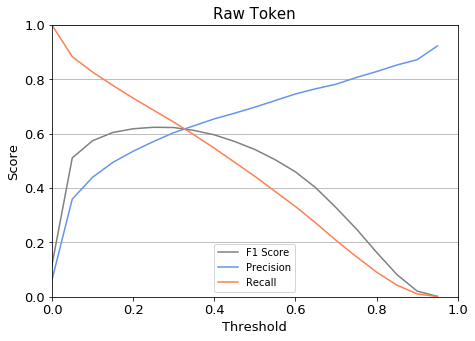

In [37]:
#### Recall, Precision and F1 Score chartfig, ax = plt.subplots(figsize=(16,5))

plt.subplot(121)
sns.lineplot(x=combined_score.index, y=combined_score['F1 Score'], color='grey')
sns.lineplot(x=combined_score.index, y=combined_score['Precision'], color='cornflowerblue')
sns.lineplot(x=combined_score.index, y=combined_score['Recall'], color='coral')
plt.ylim(0, 1)
plt.xlim(0, 1)
# plt.xticks(rotation=45)
plt.title('Raw Token', fontsize=15)
plt.ylabel('Score', fontsize = 13)
plt.yticks(fontsize=13)
plt.xlabel('Threshold', fontsize = 13)
plt.xticks(fontsize=13)
plt.legend(combined_score.columns, loc='lower center')
plt.grid(axis='y')




In [38]:
model.save('./FastText_CBOW')

In [ ]:
keras.models.load_model('./FastText_CBOW')

### FastText Skip-Gram embedding using training data.

In [57]:
%%time
FastText_SkipGram = FastText(sentences=X_train_t, size=300, window=5, min_count=5, workers=6, sg=1)

INFO - 09:40:45: collecting all words and their counts
INFO - 09:40:45: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 09:40:45: PROGRESS: at sentence #10000, processed 130140 words, keeping 14738 word types
INFO - 09:40:45: PROGRESS: at sentence #20000, processed 259997 words, keeping 21600 word types
INFO - 09:40:46: PROGRESS: at sentence #30000, processed 389329 words, keeping 26790 word types
INFO - 09:40:47: PROGRESS: at sentence #40000, processed 518014 words, keeping 31120 word types
INFO - 09:40:47: PROGRESS: at sentence #50000, processed 646632 words, keeping 34806 word types
INFO - 09:40:47: PROGRESS: at sentence #60000, processed 775136 words, keeping 38145 word types
INFO - 09:40:47: PROGRESS: at sentence #70000, processed 904057 words, keeping 41267 word types
INFO - 09:40:47: PROGRESS: at sentence #80000, processed 1034004 words, keeping 44155 word types
INFO - 09:40:47: PROGRESS: at sentence #90000, processed 1163059 words, keeping 46939 word ty

INFO - 09:41:40: EPOCH 2 - PROGRESS: at 93.19% examples, 404545 words/s, in_qsize 11, out_qsize 0
INFO - 09:41:41: EPOCH 2 - PROGRESS: at 97.49% examples, 404874 words/s, in_qsize 12, out_qsize 0
INFO - 09:41:41: worker thread finished; awaiting finish of 5 more threads
INFO - 09:41:41: worker thread finished; awaiting finish of 4 more threads
INFO - 09:41:41: worker thread finished; awaiting finish of 3 more threads
INFO - 09:41:41: worker thread finished; awaiting finish of 2 more threads
INFO - 09:41:41: worker thread finished; awaiting finish of 1 more threads
INFO - 09:41:41: worker thread finished; awaiting finish of 0 more threads
INFO - 09:41:41: EPOCH - 2 : training on 13489665 raw words (9705214 effective words) took 23.9s, 405775 effective words/s
INFO - 09:41:42: EPOCH 3 - PROGRESS: at 4.06% examples, 394968 words/s, in_qsize 12, out_qsize 0
INFO - 09:41:43: EPOCH 3 - PROGRESS: at 8.36% examples, 403912 words/s, in_qsize 12, out_qsize 0
INFO - 09:41:44: EPOCH 3 - PROGRESS: 

Wall time: 2min 11s


In [58]:
FastText_SkipGram.wv.most_similar('nice')

INFO - 09:42:57: precomputing L2-norms of word weight vectors


[('charming', 0.6280179619789124),
 ('sneaky', 0.572664201259613),
 ('cute', 0.5725623369216919),
 ('comforting', 0.570707380771637),
 ('slutty', 0.5703924298286438),
 ('impolite', 0.5681282877922058),
 ('classy', 0.566018283367157),
 ('nerdy', 0.5623044967651367),
 ('flirtatious', 0.5622875690460205),
 ('timid', 0.5592190623283386)]


#### LSTM FastText Skip-Gram

In [59]:
# Tunning parameters
MAX_NB_WORDS = 160000
EMBEDDING_DIM = 300
LSTM_UNITS = 100
DROP = 0.2
RE_DROP = 0.2

In [60]:
%%time
embedding_matrix = np.zeros((len(tokenizer.word_index), EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in FastText_SkipGram.wv.vocab:
        embedding_matrix[i] = FastText_SkipGram.wv.get_vector(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 130051
Wall time: 624 ms


In [ ]:
embedding_matrix.shape

(173994, 300)

In [ ]:
%%time
#### LSTM## Network architecture
model = Sequential()

model.add(Embedding(173994, EMBEDDING_DIM, weights = [embedding_matrix], input_length=INPUT_LEN)) 
model.add(LSTM(LSTM_UNITS, dropout=DROP, recurrent_dropout=RE_DROP))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_data, y_train, validation_split=0.4, epochs=3)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 626938 samples, validate on 417959 samples
Epoch 1/3
  6176/626938 [..............................] - ETA: 19:26:18 - loss: 0.6499 - acc: 0.843 - ETA: 10:19:12 - loss: 0.5994 - acc: 0.906 - ETA: 7:17:48 - loss: 0.5432 - acc: 0.937 - ETA: 5:45:53 - loss: 0.4939 - acc: 0.95 - ETA: 4:51:42 - loss: 0.4876 - acc: 0.93 - ETA: 4:15:52 - loss: 0.4544 - acc: 0.93 - ETA: 3:50:26 - loss: 0.4342 - acc: 0.92 - ETA: 3:32:31 - loss: 0.4344 - acc: 0.91 - ETA: 3:17:42 - loss: 0.4106 - acc: 0.92 - ETA: 3:06:03 - loss: 0.3941 - acc: 0.92 - ETA: 2:56:26 - loss: 0.4001 - acc: 0.91 - ETA: 2:49:18 - loss: 0.3771 - acc: 0.92 - ETA: 2:42:04 - loss: 0.3597 - acc: 0.92 - ETA: 2:35:48 - loss: 0.3645 - acc: 0.92 - ETA: 2:29:58 - loss: 0.3564 - acc: 0.92 - ETA: 2:25:50 - loss: 0.3532 - acc: 0.92 - ETA: 2:21:32 - loss: 0.3574 - acc: 0.91 - ETA: 2:18:19 - loss: 0.3509 - acc: 0.92 - ETA: 2:14:51 - loss: 0.3393 - acc: 0.92 - ETA: 2:11:36 - loss: 0.3365 - acc: 0.92 - ETA: 2:08:43 - loss: 0.3272 - acc: 0.92 - ET

In [ ]:
%%time
y_pred = model.predict(X_test_data, workers=6)

In [ ]:
y_predRound = [ 1 if y >= 0.3 else 0  for y in y_pred]

In [ ]:
print('accuracy %s' % accuracy_score(y_test, y_predRound))
print(classification_report(y_test, y_predRound))
confusion_matrix(y_test, y_predRound)

In [ ]:
threshold_list = []
recall_list = []
precision_list = []
f1_list = []
for thres in range(0, 100, 5):
    
    y_predRound = [ 1 if y >= thres/100 else 0  for y in y_pred]
    threshold_list.append(thres/100)
    recall_list.append(recall_score(y_test,  y_predRound))
    precision_list.append(precision_score(y_test,  y_predRound))
    f1_list.append(f1_score(y_test,  y_predRound))

In [ ]:
combined_score = pd.DataFrame(index=threshold_list)
combined_score['F1 Score'] = f1_list
combined_score['Precision'] = precision_list
combined_score['Recall'] = recall_list

In [ ]:
combined_score.to_pickle('./FastText_SkipGram_combined_score.pkl')

In [ ]:
combined_score = pd.read_pickle('./FastText_SkipGram_combined_score.pkl')

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))

plt.subplot(121)
sns.lineplot(x=combined_score.index, y=combined_score['F1 Score'], color='grey')
sns.lineplot(x=combined_score.index, y=combined_score['Precision'], color='cornflowerblue')
sns.lineplot(x=combined_score.index, y=combined_score['Recall'], color='coral')
plt.ylim(0, 1)
plt.xlim(0, 1)
# plt.xticks(rotation=45)
plt.title('Raw Token', fontsize=15)
plt.ylabel('Score', fontsize = 13)
plt.yticks(fontsize=13)
plt.xlabel('Threshold', fontsize = 13)
plt.xticks(fontsize=13)
plt.legend(combined_score.columns, loc='lower center')
plt.grid(axis='y')




In [ ]:
model.save('./FastText_SkipGram')

In [ ]:
keras.models.load_model('./FastText_SkipGram')